In [1]:
!pip install scikit-optimize
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [4]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [5]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [6]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [7]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [8]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Load df

In [9]:
import pickle

with open('./Okko_ratings_RUSS_FULL_kws.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [10]:
df.shape

(1705, 33859)

In [11]:
d = df[df['release_year'] >= 2000]

In [12]:
d.shape

(1666, 33859)

In [13]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating       67
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR                57
COMPOSER            298
DESIGN              390
DIRECTOR             15
EDITOR              653
OPERATOR            242
PRODUCER             96
WRITER               47
BUDGET             1482
MARKETING          1659
RUS                1087
USA                1620
WORLD              1261
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [14]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [15]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [16]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [17]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [18]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [19]:
df_pr = preprocesser.preprocess(d)

In [20]:
df_pr.shape

(1666, 33872)

In [21]:
df_pr.isnull().sum()[:30]

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
element_uid           0
BUDGET             1482
MARKETING          1659
RUS                1087
USA                1620
WORLD              1261
rating                0
джек                  0
расследовать          0
подруга               0
ограбление            0
катя                  0
макс                  0
мечтать               0
отважный              0
фрэнк                 0
воспитывать           0
супергерой            0
безжалостный          0
маньяк                0
эксцентричный         0
одержимый             0
влюбляться            0
капитан               0
приключение           0
dtype: int64

In [22]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33872)

In [23]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [24]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [25]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [26]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [27]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [28]:
df_pr.shape

(1666, 33872)

### target destrib

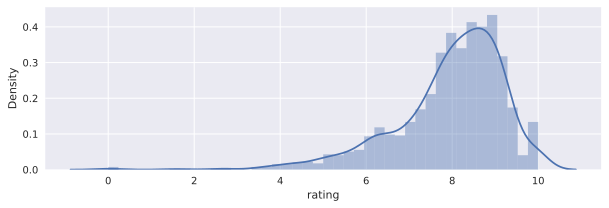

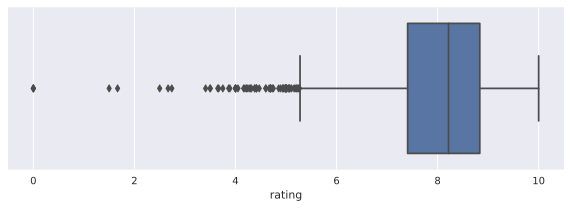

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [30]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33872)

In [31]:
df_pr.shape

(1666, 33872)

## Split

In [32]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((1453, 33868), (162, 33868), (51, 33868), (1453,), (162,), (51,))

## Get just keywords

In [33]:
X_train_kws = X_train.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_train_df = X_train[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]

X_val_kws = X_val.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_val_df = X_val[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]

X_test_kws = X_test.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_test_df = X_test[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]


## Standartization

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_kws = sc.fit_transform(X_train_kws)
X_val_kws = sc.transform(X_val_kws)
X_test_kws = sc.transform(X_test_kws)

## PCA

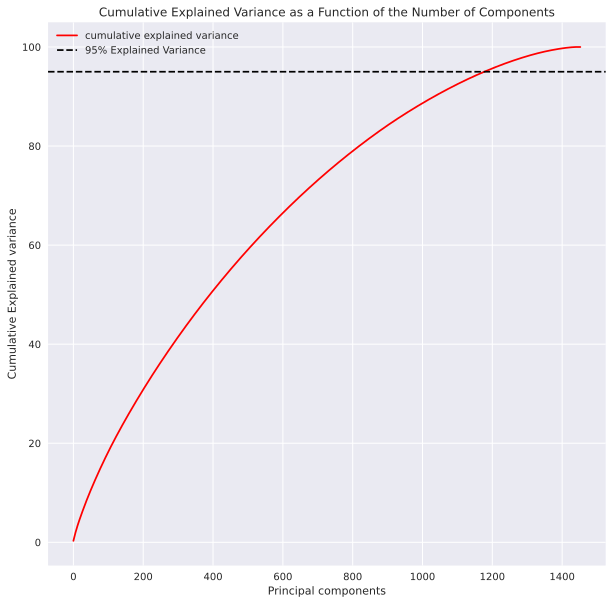

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_kws)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [36]:
pca.n_components_

1453

In [70]:
pca = PCA(n_components=1000) 

X_train_kws_pca = pca.fit_transform(X_train_kws)
X_val_kws_pca = pca.transform(X_val_kws)
X_test_kws_pca = pca.transform(X_test_kws)

**Convert to dataframe**

In [71]:
component_names = [f"PC{i+1}" for i in range(X_train_kws_pca.shape[1])]
X_train_kws_pca = pd.DataFrame(X_train_kws_pca, columns=component_names)

X_train_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.100491 -0.878278 -0.478663  2.055372  0.114766 -0.870037 -0.135271   
1 -0.592628 -0.503715 -0.545103 -0.265271  0.094767 -0.472392 -0.349170   
2 -0.461993 -0.568238 -0.053422 -0.036848 -0.657600 -0.252977 -0.869750   
3 -0.589315 -0.339803 -0.614520 -0.347178 -0.119393 -0.827666 -0.435063   
4 -0.574556 -0.415340 -0.348870 -0.328686 -0.102609  0.277663 -0.399710   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.796430  0.491677 -1.005263  ... -0.110700  0.290552  0.819356  0.774166   
1 -0.433524 -0.190063 -0.949184  ...  0.630002 -1.118110  0.665239  0.449971   
2 -0.659541 -0.630272 -0.266046  ... -0.341151  2.424285 -0.004292 -0.786399   
3 -0.252797  1.111075  0.285944  ...  0.380585 -0.736824 -0.741061 -0.169861   
4 -0.454843  0.102365 -0.621328  ...  1.618676  0.267123 -0.047939  0.912911   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.206464  0.432157  0.430105 -0.086480  0.232673  0.767414  
1 -0.246907  1.654115  1.675470  0.058702 -0.746630 -0.313645  
2 -0.153500  0.751910 -0.908131 -0.594510  1.041328 -1.070772  
3 -0.526697  0.884860  0.281989  0.556603  0.576545 -0.457742  
4 -0.886204  0.874456 -1.711217  1.595627 -2.538120 -0.511236  

[5 rows x 1000 columns]

In [72]:
X_train_df = X_train_df.reset_index().drop('index', axis=1)
X_train = X_train_df.join(X_train_kws_pca, on=X_train_df.index)

X_train.head()

age_access_type    type   duration  budget  marketing  rus  USA  world  \
0               12  SERIAL  17.216708     NaN        NaN  NaN  NaN    NaN   
1               12   MOVIE  15.846287     NaN        NaN  NaN  NaN    NaN   
2               16   MOVIE  15.789592     NaN        NaN  NaN  NaN    NaN   
3               16   MOVIE  15.534700     NaN        NaN  NaN  NaN    NaN   
4               16  SERIAL  17.216708     NaN        NaN  NaN  NaN    NaN   

            actor_0         actor_1  ...     PC991     PC992     PC993  \
0    Марта Клубович    Олег Табаков  ... -0.110700  0.290552  0.819356   
1  Людмила Гурченко  Лия Ахеджакова  ...  0.630002 -1.118110  0.665239   
2    Андрей Смирнов   Галина Тюнина  ... -0.341151  2.424285 -0.004292   
3     Антон Баранов   Мария Костина  ...  0.380585 -0.736824 -0.741061   
4    Дмитрий Певцов  Ольга Дроздова  ...  1.618676  0.267123 -0.047939   

      PC994     PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.774166 -0.206464  0.432157  0.430105 -0.086480  0.232673  0.767414  
1  0.449971 -0.246907  1.654115  1.675470  0.058702 -0.746630 -0.313645  
2 -0.786399 -0.153500  0.751910 -0.908131 -0.594510  1.041328 -1.070772  
3 -0.169861 -0.526697  0.884860  0.281989  0.556603  0.576545 -0.457742  
4  0.912911 -0.886204  0.874456 -1.711217  1.595627 -2.538120 -0.511236  

[5 rows x 1036 columns]

In [73]:
component_names = [f"PC{i+1}" for i in range(X_val_kws_pca.shape[1])]
X_val_kws_pca = pd.DataFrame(X_val_kws_pca, columns=component_names)

X_val_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.274025 -0.228022  0.153248  0.089765  0.569823  1.200245 -0.475623   
1 -0.478511  0.106580 -0.226431  0.776309  0.073290 -0.679534 -0.406981   
2  0.231267 -0.429703 -0.220550 -0.309655 -0.118348 -0.772652 -0.364972   
3 -0.241610 -0.337576 -0.554622 -0.315825 -0.350006 -0.911993 -0.438272   
4  0.103164 -0.219037 -0.042756 -0.084330 -0.244002  1.674170 -0.431882   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0  1.024598 -0.374661 -0.199302  ... -0.144082  0.011013  0.055057 -0.488530   
1 -0.965393  3.256464 -0.169998  ...  0.664117  0.439334 -1.008953  0.316821   
2 -0.607210  0.119986 -0.894305  ... -1.090836  0.188815  0.058119  1.458144   
3 -0.278824 -0.350690 -0.951496  ...  0.094768  0.337376  0.297053  0.074717   
4  1.120315 -0.208555  1.107532  ... -0.327621 -0.374742  1.302126 -0.287561   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.979735  0.260194 -1.373709 -0.419343  0.356281  0.932053  
1 -0.663612 -0.421504 -0.348392 -0.627341  0.057152  1.153889  
2 -0.019804 -0.155483  0.207651  0.087394 -0.621738  0.309005  
3 -0.032929  0.339999 -0.070476  0.472869  0.286688 -0.353793  
4  1.010286  0.263178 -0.315447  0.064160  0.637984 -0.650562  

[5 rows x 1000 columns]

In [74]:
X_val_df = X_val_df.reset_index().drop('index', axis=1)
X_val = X_val_df.join(X_val_kws_pca, on=X_val_df.index)

X_val.head()

age_access_type    type   duration  budget  marketing        rus  USA  \
0               18   MOVIE  15.587067     NaN        NaN        NaN  NaN   
1               18  SERIAL  16.418200     NaN        NaN        NaN  NaN   
2               16   MOVIE  15.922081     NaN        NaN  15.858558  NaN   
3               16  SERIAL  17.990513     NaN        NaN        NaN  NaN   
4               16  SERIAL  17.013367     NaN        NaN        NaN  NaN   

       world          actor_0            actor_1  ...     PC991     PC992  \
0        NaN  Евгений Цыганов    Ясмина Омерович  ... -0.144082  0.011013   
1        NaN  Любовь Аксёнова  Игорь Миркурбанов  ...  0.664117  0.439334   
2  15.881274    Фёдор Федотов        Софья Присс  ... -1.090836  0.188815   
3        NaN    Глеб Калюжный      Анна Демидова  ...  0.094768  0.337376   
4        NaN     Илья Малаков        Кирилл Кяро  ... -0.327621 -0.374742   

      PC993     PC994     PC995     PC996     PC997     PC998     PC999  \
0  0.055057 -0.488530  0.979735  0.260194 -1.373709 -0.419343  0.356281   
1 -1.008953  0.316821 -0.663612 -0.421504 -0.348392 -0.627341  0.057152   
2  0.058119  1.458144 -0.019804 -0.155483  0.207651  0.087394 -0.621738   
3  0.297053  0.074717 -0.032929  0.339999 -0.070476  0.472869  0.286688   
4  1.302126 -0.287561  1.010286  0.263178 -0.315447  0.064160  0.637984   

     PC1000  
0  0.932053  
1  1.153889  
2  0.309005  
3 -0.353793  
4 -0.650562  

[5 rows x 1036 columns]

In [75]:
component_names = [f"PC{i+1}" for i in range(X_test_kws_pca.shape[1])]
X_test_kws_pca = pd.DataFrame(X_test_kws_pca, columns=component_names)

X_test_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.403228 -0.389947 -0.240926  0.113835  0.114138  0.530291 -0.621824   
1  0.068449 -0.548182 -0.669554  1.297906 -0.169407 -1.091324 -0.123825   
2 -0.245966  0.922357 -0.354337 -0.304945 -0.569774 -0.209129  1.428315   
3 -0.290315 -0.503701 -0.588130 -0.424365 -0.377861 -0.805541 -0.473645   
4  0.199375 -0.204266  0.324686 -0.377237  2.988797 -0.075984 -0.368887   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.386840 -0.327931 -0.402157  ... -0.201884 -0.494240  0.166266  0.603874   
1 -0.535553 -0.480430 -0.646014  ... -0.414762 -0.360871 -0.618014  0.063095   
2 -0.034849  0.275942 -0.487103  ... -0.089131 -0.375221  0.545844  0.017558   
3 -0.553327 -0.216569 -0.882490  ...  0.480831 -0.160171 -0.112620 -0.331408   
4 -0.037194 -0.554702  0.481797  ... -1.206997 -0.338734  0.963622 -0.752784   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.547086  0.123462 -0.586788  0.510341  0.037912  0.043468  
1  0.784063  0.019877  0.962531 -0.352453  0.733155  1.490954  
2  0.061121  0.050657 -0.278776  0.216156 -0.757544  0.077613  
3  0.060201  0.206468 -0.148373 -0.411446 -0.101059  0.259490  
4  1.596601 -1.196342 -3.824435  0.436717  1.159749  0.860196  

[5 rows x 1000 columns]

In [76]:
X_test_df = X_test_df.reset_index().drop('index', axis=1)
X_test = X_test_df.join(X_test_kws_pca, on=X_test_df.index)

X_test.head()

age_access_type    type   duration  budget  marketing        rus  USA  \
0               16  SERIAL  15.479437     NaN        NaN        NaN  NaN   
1               16   MOVIE  15.576811     NaN        NaN  10.103567  NaN   
2               16  SERIAL  16.172584     NaN        NaN        NaN  NaN   
3               12   MOVIE  15.545395     NaN        NaN  12.057422  NaN   
4               18  SERIAL  16.757842     NaN        NaN        NaN  NaN   

   world                actor_0            actor_1  ...     PC991     PC992  \
0    NaN  Александра Никифорова    Алексей Демидов  ... -0.201884 -0.494240   
1    NaN        Леонид Парфенов                 Na  ... -0.414762 -0.360871   
2    NaN        Агата Муцениеце   Михаил Пшеничный  ... -0.089131 -0.375221   
3    NaN      Александр Пацевич       Роман Коваль  ...  0.480831 -0.160171   
4    NaN      Пелагея Невзорова  Никита Кологривый  ... -1.206997 -0.338734   

      PC993     PC994     PC995     PC996     PC997     PC998     PC999  \
0  0.166266  0.603874  0.547086  0.123462 -0.586788  0.510341  0.037912   
1 -0.618014  0.063095  0.784063  0.019877  0.962531 -0.352453  0.733155   
2  0.545844  0.017558  0.061121  0.050657 -0.278776  0.216156 -0.757544   
3 -0.112620 -0.331408  0.060201  0.206468 -0.148373 -0.411446 -0.101059   
4  0.963622 -0.752784  1.596601 -1.196342 -3.824435  0.436717  1.159749   

     PC1000  
0  0.043468  
1  1.490954  
2  0.077613  
3  0.259490  
4  0.860196  

[5 rows x 1036 columns]

### Model

In [77]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [78]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.053997
0:	learn: 0.9466196	test: 0.9538974	best: 0.9538974 (0)	total: 44ms	remaining: 44s
100:	learn: 0.7071879	test: 0.8669594	best: 0.8621402 (48)	total: 5.95s	remaining: 52.9s
200:	learn: 0.5493129	test: 0.8664149	best: 0.8621402 (48)	total: 11.8s	remaining: 46.8s
300:	learn: 0.3853916	test: 0.8600408	best: 0.8572152 (250)	total: 17.7s	remaining: 41s
400:	learn: 0.2685703	test: 0.8679031	best: 0.8572152 (250)	total: 23.6s	remaining: 35.2s
500:	learn: 0.1940279	test: 0.8731575	best: 0.8572152 (250)	total: 29.5s	remaining: 29.3s
600:	learn: 0.1356678	test: 0.8741808	best: 0.8572152 (250)	total: 35.3s	remaining: 23.5s
700:	learn: 0.0992919	test: 0.8769928	best: 0.8572152 (250)	total: 41.2s	remaining: 17.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8572152333
bestIteration = 250

Shrink model to first 251 iterations.


In [79]:
y_pred = cat_model.predict(test_dataset)

In [80]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.6520397736243697
RMSE:  1.2853169934395055
R2:    0.19482329314551095
MAE:   0.9175102302348858
MedAE: 0.7755499638096435
------------------------------


In [81]:
cat_model.save_model('DEMO_okko_ratings_pred_pca_russ')

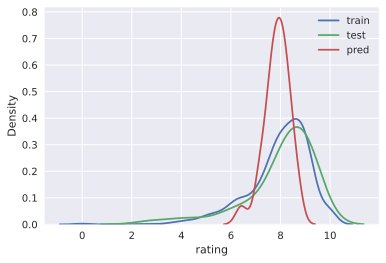

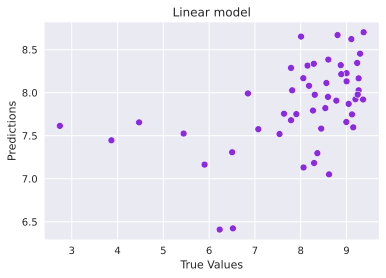

In [82]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [5.51843717 3.57998636 8.00271407 0.         0.         1.01660988
 0.         0.95336321 0.93891108 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.97032172 0.        ]


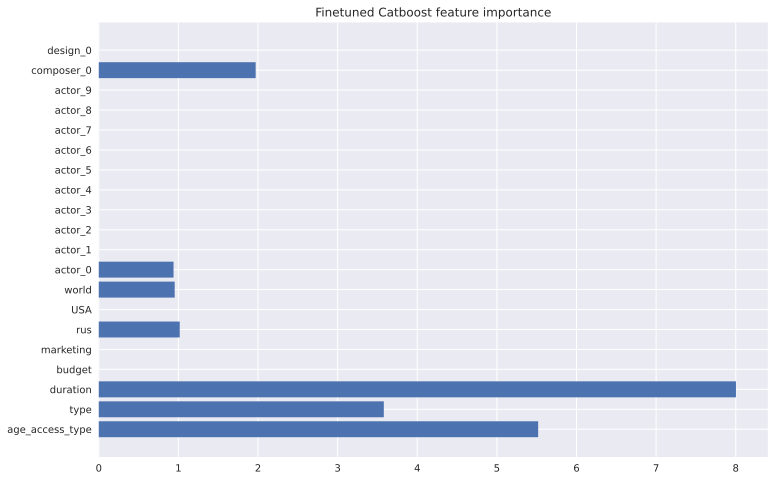

In [83]:
get_feature_imp(cat_model, train_dataset)

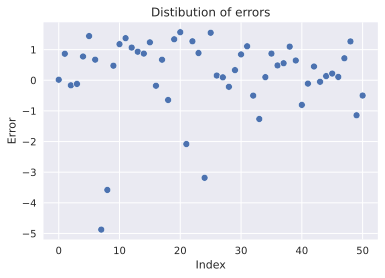

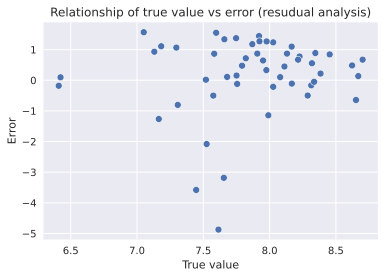

In [84]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [85]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                                               name  \
10378               16                                         Тихие воды   
7938                16                      Русские грузины. Фильм второй   
10377               16              Я знаю твои секреты 7. Дыхание смерти   
7698                12                                      Тайна амулета   
10370               18                                          Два холма   
10369               18                                            Оффлайн   
10368               16                              И снова здравствуйте!   
5410                16                                         Другое имя   
4462                16                                         Селфимания   
10391                0                               Мой мир. Поем вместе   
10390               18                                             Смычок   
7909                 0                        Три кота и море приключений   
8189                12  Все в сад! Или русская классика в цветах. Сезон 2   
10475               18  Что делать женщине, если у неё два любовника, ...   
10399               18                                               Жиза   
7644                 6                                       Забытое чудо   
5474                18                                             Модель   
10440               18                                   Закрыть гештальт   
10389               16                            Кабинет Путешественника   
5542                16                                        Многоэтажка   
7505                18                                               Ника   
5556                16                                         Бодибилдер   
6304                 6                           Кощей. Похититель невест   
5208                12                          1941. Крылья над Берлином   
6183                16                                     Доктор Свисток   
6354                16                                    Молодой человек   
6404                16                                           Свингеры   
6435                18                                          Приплыли!   
6012                 6                                   Мой папа – вождь   
5925                16                                              Дикая   
10246               12                            Предпоследняя инстанция   
6673                16                                        Страна Саша   
6697                16                        Эластико: Двенадцатый игрок   
6771                18                                              Рэпер   
10281                0                                         Спорт Тоша   
10286               18                                          Номинация   
10306               16                                              Агеев   
5681                16                             День слепого Валентина   
7499                12                                      Мистер Нокаут   
5566                16                                         Хочу замуж   
6267                16                                        Убить босса   
10341               16                                          Пианистка   
7515                12                                       Первый Оскар   
10349               16                                     Танцы на углях   
10350               16                                             Янычар   
10352               16                            Исправление и наказание   
10354               16                          Орлинская. Стрелы Нептуна   
7549                16                                         Бультерьер   
7565                 6                                             Финник   
5551                16                                             Стикер   
10486                6                                       Большие игры   

  

# Tuning

In [86]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [87]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop_pred_pca_russ', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.9132880	total: 17.9ms	remaining: 1m 29s
1:	learn: 0.9082252	total: 37.9ms	remaining: 1m 34s
2:	learn: 0.9036120	total: 55.2ms	remaining: 1m 31s
3:	learn: 0.9002115	total: 72.8ms	remaining: 1m 30s
4:	learn: 0.8960877	total: 91.6ms	remaining: 1m 31s
5:	learn: 0.8920180	total: 110ms	remaining: 1m 31s
6:	learn: 0.8887359	total: 128ms	remaining: 1m 31s
7:	learn: 0.8860679	total: 146ms	remaining: 1m 31s
8:	learn: 0.8822574	total: 167ms	remaining: 1m 32s
9:	learn: 0.8788711	total: 184ms	remaining: 1m 31s
10:	learn: 0.8756619	total: 201ms	remaining: 1m 31s
11:	learn: 0.8726181	total: 218ms	remaining: 1m 30s
12:	learn: 0.8703395	total: 237ms	remaining: 1m 30s
13:	learn: 0.8674877	total: 256ms	remaining: 1m 31s
14:	learn: 0.8648104	total: 272ms	remaining: 1m 30s
15:	learn: 0.8626263	total: 289ms	remaining: 1m 30s
16:	learn: 0.8608879	total: 306ms	remaining: 1m 29s
17:	learn: 0.8586965	total: 323ms	remaining: 1m 29s
18:	lear

158:	learn: 0.7585350	total: 2.84s	remaining: 1m 26s
159:	learn: 0.7581232	total: 2.86s	remaining: 1m 26s
160:	learn: 0.7574568	total: 2.87s	remaining: 1m 26s
161:	learn: 0.7571192	total: 2.89s	remaining: 1m 26s
162:	learn: 0.7565892	total: 2.91s	remaining: 1m 26s
163:	learn: 0.7561506	total: 2.92s	remaining: 1m 26s
164:	learn: 0.7557328	total: 2.94s	remaining: 1m 26s
165:	learn: 0.7553576	total: 2.96s	remaining: 1m 26s
166:	learn: 0.7548282	total: 2.98s	remaining: 1m 26s
167:	learn: 0.7546771	total: 3s	remaining: 1m 26s
168:	learn: 0.7540994	total: 3.01s	remaining: 1m 26s
169:	learn: 0.7534959	total: 3.03s	remaining: 1m 26s
170:	learn: 0.7528429	total: 3.05s	remaining: 1m 26s
171:	learn: 0.7526997	total: 3.07s	remaining: 1m 26s
172:	learn: 0.7523157	total: 3.08s	remaining: 1m 26s
173:	learn: 0.7519900	total: 3.1s	remaining: 1m 26s
174:	learn: 0.7516014	total: 3.12s	remaining: 1m 26s
175:	learn: 0.7512724	total: 3.14s	remaining: 1m 26s
176:	learn: 0.7510561	total: 3.16s	remaining: 1m 2

323:	learn: 0.6916988	total: 5.78s	remaining: 1m 23s
324:	learn: 0.6916589	total: 5.8s	remaining: 1m 23s
325:	learn: 0.6912012	total: 5.82s	remaining: 1m 23s
326:	learn: 0.6909391	total: 5.83s	remaining: 1m 23s
327:	learn: 0.6908508	total: 5.85s	remaining: 1m 23s
328:	learn: 0.6905919	total: 5.87s	remaining: 1m 23s
329:	learn: 0.6900473	total: 5.89s	remaining: 1m 23s
330:	learn: 0.6895139	total: 5.9s	remaining: 1m 23s
331:	learn: 0.6889314	total: 5.92s	remaining: 1m 23s
332:	learn: 0.6884002	total: 5.94s	remaining: 1m 23s
333:	learn: 0.6879162	total: 5.96s	remaining: 1m 23s
334:	learn: 0.6874761	total: 5.97s	remaining: 1m 23s
335:	learn: 0.6871612	total: 5.99s	remaining: 1m 23s
336:	learn: 0.6863087	total: 6.01s	remaining: 1m 23s
337:	learn: 0.6861467	total: 6.03s	remaining: 1m 23s
338:	learn: 0.6855785	total: 6.04s	remaining: 1m 23s
339:	learn: 0.6850086	total: 6.06s	remaining: 1m 23s
340:	learn: 0.6841046	total: 6.08s	remaining: 1m 23s
341:	learn: 0.6840100	total: 6.09s	remaining: 1m

478:	learn: 0.6214915	total: 8.49s	remaining: 1m 20s
479:	learn: 0.6213701	total: 8.51s	remaining: 1m 20s
480:	learn: 0.6210459	total: 8.52s	remaining: 1m 20s
481:	learn: 0.6203777	total: 8.54s	remaining: 1m 20s
482:	learn: 0.6198187	total: 8.56s	remaining: 1m 20s
483:	learn: 0.6195406	total: 8.57s	remaining: 1m 19s
484:	learn: 0.6186581	total: 8.59s	remaining: 1m 19s
485:	learn: 0.6180924	total: 8.61s	remaining: 1m 19s
486:	learn: 0.6177040	total: 8.63s	remaining: 1m 19s
487:	learn: 0.6176577	total: 8.64s	remaining: 1m 19s
488:	learn: 0.6174507	total: 8.66s	remaining: 1m 19s
489:	learn: 0.6166370	total: 8.68s	remaining: 1m 19s
490:	learn: 0.6160019	total: 8.7s	remaining: 1m 19s
491:	learn: 0.6155219	total: 8.71s	remaining: 1m 19s
492:	learn: 0.6147601	total: 8.73s	remaining: 1m 19s
493:	learn: 0.6142288	total: 8.75s	remaining: 1m 19s
494:	learn: 0.6139553	total: 8.77s	remaining: 1m 19s
495:	learn: 0.6137195	total: 8.78s	remaining: 1m 19s
496:	learn: 0.6135927	total: 8.8s	remaining: 1m

645:	learn: 0.5546113	total: 11.4s	remaining: 1m 16s
646:	learn: 0.5538432	total: 11.4s	remaining: 1m 16s
647:	learn: 0.5532707	total: 11.5s	remaining: 1m 16s
648:	learn: 0.5526627	total: 11.5s	remaining: 1m 16s
649:	learn: 0.5521738	total: 11.5s	remaining: 1m 16s
650:	learn: 0.5516060	total: 11.5s	remaining: 1m 16s
651:	learn: 0.5514788	total: 11.5s	remaining: 1m 16s
652:	learn: 0.5508375	total: 11.5s	remaining: 1m 16s
653:	learn: 0.5507611	total: 11.6s	remaining: 1m 16s
654:	learn: 0.5505913	total: 11.6s	remaining: 1m 16s
655:	learn: 0.5499320	total: 11.6s	remaining: 1m 16s
656:	learn: 0.5495015	total: 11.6s	remaining: 1m 16s
657:	learn: 0.5491554	total: 11.6s	remaining: 1m 16s
658:	learn: 0.5484075	total: 11.7s	remaining: 1m 16s
659:	learn: 0.5481329	total: 11.7s	remaining: 1m 16s
660:	learn: 0.5478119	total: 11.7s	remaining: 1m 16s
661:	learn: 0.5474880	total: 11.7s	remaining: 1m 16s
662:	learn: 0.5472272	total: 11.7s	remaining: 1m 16s
663:	learn: 0.5466849	total: 11.7s	remaining: 

801:	learn: 0.4940383	total: 14.1s	remaining: 1m 14s
802:	learn: 0.4937412	total: 14.2s	remaining: 1m 14s
803:	learn: 0.4934826	total: 14.2s	remaining: 1m 14s
804:	learn: 0.4930173	total: 14.2s	remaining: 1m 13s
805:	learn: 0.4925127	total: 14.2s	remaining: 1m 13s
806:	learn: 0.4921978	total: 14.2s	remaining: 1m 13s
807:	learn: 0.4919815	total: 14.3s	remaining: 1m 13s
808:	learn: 0.4917229	total: 14.3s	remaining: 1m 13s
809:	learn: 0.4915210	total: 14.3s	remaining: 1m 13s
810:	learn: 0.4910749	total: 14.3s	remaining: 1m 13s
811:	learn: 0.4906025	total: 14.3s	remaining: 1m 13s
812:	learn: 0.4904126	total: 14.3s	remaining: 1m 13s
813:	learn: 0.4899595	total: 14.4s	remaining: 1m 13s
814:	learn: 0.4895494	total: 14.4s	remaining: 1m 13s
815:	learn: 0.4891468	total: 14.4s	remaining: 1m 13s
816:	learn: 0.4890905	total: 14.4s	remaining: 1m 13s
817:	learn: 0.4887129	total: 14.4s	remaining: 1m 13s
818:	learn: 0.4884017	total: 14.4s	remaining: 1m 13s
819:	learn: 0.4879392	total: 14.5s	remaining: 

967:	learn: 0.4401321	total: 17.1s	remaining: 1m 11s
968:	learn: 0.4398085	total: 17.1s	remaining: 1m 11s
969:	learn: 0.4395941	total: 17.1s	remaining: 1m 11s
970:	learn: 0.4394738	total: 17.1s	remaining: 1m 11s
971:	learn: 0.4392232	total: 17.1s	remaining: 1m 11s
972:	learn: 0.4387029	total: 17.2s	remaining: 1m 11s
973:	learn: 0.4384122	total: 17.2s	remaining: 1m 11s
974:	learn: 0.4379707	total: 17.2s	remaining: 1m 10s
975:	learn: 0.4375508	total: 17.2s	remaining: 1m 10s
976:	learn: 0.4371880	total: 17.2s	remaining: 1m 10s
977:	learn: 0.4369828	total: 17.2s	remaining: 1m 10s
978:	learn: 0.4367702	total: 17.3s	remaining: 1m 10s
979:	learn: 0.4365836	total: 17.3s	remaining: 1m 10s
980:	learn: 0.4363175	total: 17.3s	remaining: 1m 10s
981:	learn: 0.4358785	total: 17.3s	remaining: 1m 10s
982:	learn: 0.4355964	total: 17.3s	remaining: 1m 10s
983:	learn: 0.4353564	total: 17.4s	remaining: 1m 10s
984:	learn: 0.4350242	total: 17.4s	remaining: 1m 10s
985:	learn: 0.4348454	total: 17.4s	remaining: 

1123:	learn: 0.3972757	total: 19.8s	remaining: 1m 8s
1124:	learn: 0.3968663	total: 19.8s	remaining: 1m 8s
1125:	learn: 0.3966521	total: 19.8s	remaining: 1m 8s
1126:	learn: 0.3964888	total: 19.9s	remaining: 1m 8s
1127:	learn: 0.3963160	total: 19.9s	remaining: 1m 8s
1128:	learn: 0.3959737	total: 19.9s	remaining: 1m 8s
1129:	learn: 0.3957742	total: 19.9s	remaining: 1m 8s
1130:	learn: 0.3956166	total: 19.9s	remaining: 1m 8s
1131:	learn: 0.3952435	total: 19.9s	remaining: 1m 8s
1132:	learn: 0.3951682	total: 20s	remaining: 1m 8s
1133:	learn: 0.3951497	total: 20s	remaining: 1m 8s
1134:	learn: 0.3947121	total: 20s	remaining: 1m 8s
1135:	learn: 0.3944378	total: 20s	remaining: 1m 8s
1136:	learn: 0.3940120	total: 20s	remaining: 1m 8s
1137:	learn: 0.3938004	total: 20.1s	remaining: 1m 8s
1138:	learn: 0.3934754	total: 20.1s	remaining: 1m 8s
1139:	learn: 0.3932075	total: 20.1s	remaining: 1m 8s
1140:	learn: 0.3928159	total: 20.1s	remaining: 1m 7s
1141:	learn: 0.3923583	total: 20.1s	remaining: 1m 7s
114

1290:	learn: 0.3567688	total: 22.7s	remaining: 1m 5s
1291:	learn: 0.3566715	total: 22.8s	remaining: 1m 5s
1292:	learn: 0.3565184	total: 22.8s	remaining: 1m 5s
1293:	learn: 0.3562493	total: 22.8s	remaining: 1m 5s
1294:	learn: 0.3558092	total: 22.8s	remaining: 1m 5s
1295:	learn: 0.3555319	total: 22.8s	remaining: 1m 5s
1296:	learn: 0.3554478	total: 22.9s	remaining: 1m 5s
1297:	learn: 0.3552423	total: 22.9s	remaining: 1m 5s
1298:	learn: 0.3549692	total: 22.9s	remaining: 1m 5s
1299:	learn: 0.3548184	total: 22.9s	remaining: 1m 5s
1300:	learn: 0.3546557	total: 22.9s	remaining: 1m 5s
1301:	learn: 0.3542388	total: 22.9s	remaining: 1m 5s
1302:	learn: 0.3539548	total: 23s	remaining: 1m 5s
1303:	learn: 0.3536965	total: 23s	remaining: 1m 5s
1304:	learn: 0.3535044	total: 23s	remaining: 1m 5s
1305:	learn: 0.3533237	total: 23s	remaining: 1m 5s
1306:	learn: 0.3530323	total: 23s	remaining: 1m 5s
1307:	learn: 0.3527850	total: 23.1s	remaining: 1m 5s
1308:	learn: 0.3525734	total: 23.1s	remaining: 1m 5s
130

1457:	learn: 0.3210065	total: 25.7s	remaining: 1m 2s
1458:	learn: 0.3206814	total: 25.7s	remaining: 1m 2s
1459:	learn: 0.3205167	total: 25.8s	remaining: 1m 2s
1460:	learn: 0.3204724	total: 25.8s	remaining: 1m 2s
1461:	learn: 0.3202801	total: 25.8s	remaining: 1m 2s
1462:	learn: 0.3202077	total: 25.8s	remaining: 1m 2s
1463:	learn: 0.3200412	total: 25.8s	remaining: 1m 2s
1464:	learn: 0.3199824	total: 25.8s	remaining: 1m 2s
1465:	learn: 0.3198030	total: 25.9s	remaining: 1m 2s
1466:	learn: 0.3196585	total: 25.9s	remaining: 1m 2s
1467:	learn: 0.3195216	total: 25.9s	remaining: 1m 2s
1468:	learn: 0.3194706	total: 25.9s	remaining: 1m 2s
1469:	learn: 0.3191946	total: 25.9s	remaining: 1m 2s
1470:	learn: 0.3189959	total: 25.9s	remaining: 1m 2s
1471:	learn: 0.3187614	total: 26s	remaining: 1m 2s
1472:	learn: 0.3185899	total: 26s	remaining: 1m 2s
1473:	learn: 0.3184470	total: 26s	remaining: 1m 2s
1474:	learn: 0.3182719	total: 26s	remaining: 1m 2s
1475:	learn: 0.3180070	total: 26s	remaining: 1m 2s
147

1625:	learn: 0.2886293	total: 28.7s	remaining: 59.5s
1626:	learn: 0.2884684	total: 28.7s	remaining: 59.4s
1627:	learn: 0.2881915	total: 28.7s	remaining: 59.4s
1628:	learn: 0.2879577	total: 28.7s	remaining: 59.4s
1629:	learn: 0.2879187	total: 28.7s	remaining: 59.4s
1630:	learn: 0.2878805	total: 28.7s	remaining: 59.4s
1631:	learn: 0.2876949	total: 28.8s	remaining: 59.4s
1632:	learn: 0.2876130	total: 28.8s	remaining: 59.3s
1633:	learn: 0.2873982	total: 28.8s	remaining: 59.3s
1634:	learn: 0.2870937	total: 28.8s	remaining: 59.3s
1635:	learn: 0.2869143	total: 28.8s	remaining: 59.3s
1636:	learn: 0.2867325	total: 28.8s	remaining: 59.3s
1637:	learn: 0.2864861	total: 28.9s	remaining: 59.3s
1638:	learn: 0.2862781	total: 28.9s	remaining: 59.2s
1639:	learn: 0.2861124	total: 28.9s	remaining: 59.2s
1640:	learn: 0.2859840	total: 28.9s	remaining: 59.2s
1641:	learn: 0.2858173	total: 28.9s	remaining: 59.2s
1642:	learn: 0.2856928	total: 29s	remaining: 59.2s
1643:	learn: 0.2854304	total: 29s	remaining: 59.

1781:	learn: 0.2624947	total: 31.4s	remaining: 56.7s
1782:	learn: 0.2623226	total: 31.4s	remaining: 56.7s
1783:	learn: 0.2621155	total: 31.4s	remaining: 56.7s
1784:	learn: 0.2620435	total: 31.5s	remaining: 56.7s
1785:	learn: 0.2618736	total: 31.5s	remaining: 56.7s
1786:	learn: 0.2617593	total: 31.5s	remaining: 56.6s
1787:	learn: 0.2615268	total: 31.5s	remaining: 56.6s
1788:	learn: 0.2612789	total: 31.5s	remaining: 56.6s
1789:	learn: 0.2610595	total: 31.5s	remaining: 56.6s
1790:	learn: 0.2608604	total: 31.6s	remaining: 56.5s
1791:	learn: 0.2607163	total: 31.6s	remaining: 56.5s
1792:	learn: 0.2605933	total: 31.6s	remaining: 56.5s
1793:	learn: 0.2604119	total: 31.6s	remaining: 56.5s
1794:	learn: 0.2602331	total: 31.6s	remaining: 56.5s
1795:	learn: 0.2600468	total: 31.6s	remaining: 56.5s
1796:	learn: 0.2599923	total: 31.7s	remaining: 56.4s
1797:	learn: 0.2599320	total: 31.7s	remaining: 56.4s
1798:	learn: 0.2598792	total: 31.7s	remaining: 56.4s
1799:	learn: 0.2596019	total: 31.7s	remaining:

1948:	learn: 0.2380959	total: 34.3s	remaining: 53.8s
1949:	learn: 0.2380447	total: 34.4s	remaining: 53.7s
1950:	learn: 0.2378300	total: 34.4s	remaining: 53.7s
1951:	learn: 0.2377068	total: 34.4s	remaining: 53.7s
1952:	learn: 0.2376105	total: 34.4s	remaining: 53.7s
1953:	learn: 0.2374126	total: 34.4s	remaining: 53.7s
1954:	learn: 0.2372279	total: 34.4s	remaining: 53.6s
1955:	learn: 0.2370484	total: 34.5s	remaining: 53.6s
1956:	learn: 0.2368509	total: 34.5s	remaining: 53.6s
1957:	learn: 0.2365886	total: 34.5s	remaining: 53.6s
1958:	learn: 0.2364184	total: 34.5s	remaining: 53.6s
1959:	learn: 0.2364031	total: 34.5s	remaining: 53.6s
1960:	learn: 0.2362034	total: 34.5s	remaining: 53.5s
1961:	learn: 0.2360175	total: 34.6s	remaining: 53.5s
1962:	learn: 0.2360024	total: 34.6s	remaining: 53.5s
1963:	learn: 0.2357649	total: 34.6s	remaining: 53.5s
1964:	learn: 0.2356580	total: 34.6s	remaining: 53.5s
1965:	learn: 0.2353587	total: 34.6s	remaining: 53.5s
1966:	learn: 0.2352465	total: 34.7s	remaining:

2104:	learn: 0.2175263	total: 37.1s	remaining: 51s
2105:	learn: 0.2174058	total: 37.1s	remaining: 51s
2106:	learn: 0.2173656	total: 37.1s	remaining: 50.9s
2107:	learn: 0.2172484	total: 37.1s	remaining: 50.9s
2108:	learn: 0.2171067	total: 37.1s	remaining: 50.9s
2109:	learn: 0.2170482	total: 37.2s	remaining: 50.9s
2110:	learn: 0.2169583	total: 37.2s	remaining: 50.9s
2111:	learn: 0.2168101	total: 37.2s	remaining: 50.9s
2112:	learn: 0.2167759	total: 37.2s	remaining: 50.8s
2113:	learn: 0.2166340	total: 37.2s	remaining: 50.8s
2114:	learn: 0.2165367	total: 37.2s	remaining: 50.8s
2115:	learn: 0.2164041	total: 37.3s	remaining: 50.8s
2116:	learn: 0.2162465	total: 37.3s	remaining: 50.8s
2117:	learn: 0.2160386	total: 37.3s	remaining: 50.8s
2118:	learn: 0.2159765	total: 37.3s	remaining: 50.7s
2119:	learn: 0.2158807	total: 37.3s	remaining: 50.7s
2120:	learn: 0.2157103	total: 37.4s	remaining: 50.7s
2121:	learn: 0.2156315	total: 37.4s	remaining: 50.7s
2122:	learn: 0.2156214	total: 37.4s	remaining: 50.

2260:	learn: 0.1995845	total: 39.8s	remaining: 48.2s
2261:	learn: 0.1994419	total: 39.8s	remaining: 48.2s
2262:	learn: 0.1993458	total: 39.9s	remaining: 48.2s
2263:	learn: 0.1992866	total: 39.9s	remaining: 48.2s
2264:	learn: 0.1991341	total: 39.9s	remaining: 48.2s
2265:	learn: 0.1990608	total: 39.9s	remaining: 48.2s
2266:	learn: 0.1989401	total: 39.9s	remaining: 48.1s
2267:	learn: 0.1988167	total: 40s	remaining: 48.1s
2268:	learn: 0.1987315	total: 40s	remaining: 48.1s
2269:	learn: 0.1987240	total: 40s	remaining: 48.1s
2270:	learn: 0.1985767	total: 40s	remaining: 48.1s
2271:	learn: 0.1985495	total: 40s	remaining: 48.1s
2272:	learn: 0.1984280	total: 40s	remaining: 48s
2273:	learn: 0.1983139	total: 40.1s	remaining: 48s
2274:	learn: 0.1982072	total: 40.1s	remaining: 48s
2275:	learn: 0.1981804	total: 40.1s	remaining: 48s
2276:	learn: 0.1980561	total: 40.1s	remaining: 48s
2277:	learn: 0.1979272	total: 40.1s	remaining: 48s
2278:	learn: 0.1977588	total: 40.1s	remaining: 47.9s
2279:	learn: 0.19

2427:	learn: 0.1834743	total: 42.8s	remaining: 45.3s
2428:	learn: 0.1833994	total: 42.8s	remaining: 45.3s
2429:	learn: 0.1833374	total: 42.8s	remaining: 45.3s
2430:	learn: 0.1832412	total: 42.8s	remaining: 45.3s
2431:	learn: 0.1832333	total: 42.8s	remaining: 45.2s
2432:	learn: 0.1831245	total: 42.9s	remaining: 45.2s
2433:	learn: 0.1830408	total: 42.9s	remaining: 45.2s
2434:	learn: 0.1830212	total: 42.9s	remaining: 45.2s
2435:	learn: 0.1828435	total: 42.9s	remaining: 45.2s
2436:	learn: 0.1827421	total: 42.9s	remaining: 45.1s
2437:	learn: 0.1825900	total: 42.9s	remaining: 45.1s
2438:	learn: 0.1825528	total: 43s	remaining: 45.1s
2439:	learn: 0.1824879	total: 43s	remaining: 45.1s
2440:	learn: 0.1823022	total: 43s	remaining: 45.1s
2441:	learn: 0.1821996	total: 43s	remaining: 45.1s
2442:	learn: 0.1821386	total: 43s	remaining: 45s
2443:	learn: 0.1820024	total: 43s	remaining: 45s
2444:	learn: 0.1819567	total: 43.1s	remaining: 45s
2445:	learn: 0.1819027	total: 43.1s	remaining: 45s
2446:	learn: 

2594:	learn: 0.1685579	total: 45.7s	remaining: 42.4s
2595:	learn: 0.1685225	total: 45.7s	remaining: 42.4s
2596:	learn: 0.1684911	total: 45.8s	remaining: 42.3s
2597:	learn: 0.1684582	total: 45.8s	remaining: 42.3s
2598:	learn: 0.1684570	total: 45.8s	remaining: 42.3s
2599:	learn: 0.1684567	total: 45.8s	remaining: 42.3s
2600:	learn: 0.1684341	total: 45.8s	remaining: 42.3s
2601:	learn: 0.1683261	total: 45.8s	remaining: 42.2s
2602:	learn: 0.1682902	total: 45.9s	remaining: 42.2s
2603:	learn: 0.1682380	total: 45.9s	remaining: 42.2s
2604:	learn: 0.1682067	total: 45.9s	remaining: 42.2s
2605:	learn: 0.1681478	total: 45.9s	remaining: 42.2s
2606:	learn: 0.1680162	total: 45.9s	remaining: 42.2s
2607:	learn: 0.1680037	total: 45.9s	remaining: 42.1s
2608:	learn: 0.1679702	total: 46s	remaining: 42.1s
2609:	learn: 0.1679104	total: 46s	remaining: 42.1s
2610:	learn: 0.1677722	total: 46s	remaining: 42.1s
2611:	learn: 0.1676604	total: 46s	remaining: 42.1s
2612:	learn: 0.1676306	total: 46s	remaining: 42.1s
261

2761:	learn: 0.1563684	total: 48.6s	remaining: 39.4s
2762:	learn: 0.1562557	total: 48.7s	remaining: 39.4s
2763:	learn: 0.1561662	total: 48.7s	remaining: 39.4s
2764:	learn: 0.1560969	total: 48.7s	remaining: 39.4s
2765:	learn: 0.1560080	total: 48.7s	remaining: 39.4s
2766:	learn: 0.1559622	total: 48.7s	remaining: 39.3s
2767:	learn: 0.1559400	total: 48.8s	remaining: 39.3s
2768:	learn: 0.1558768	total: 48.8s	remaining: 39.3s
2769:	learn: 0.1558149	total: 48.8s	remaining: 39.3s
2770:	learn: 0.1556876	total: 48.8s	remaining: 39.3s
2771:	learn: 0.1556082	total: 48.8s	remaining: 39.2s
2772:	learn: 0.1555606	total: 48.8s	remaining: 39.2s
2773:	learn: 0.1555599	total: 48.9s	remaining: 39.2s
2774:	learn: 0.1554912	total: 48.9s	remaining: 39.2s
2775:	learn: 0.1553954	total: 48.9s	remaining: 39.2s
2776:	learn: 0.1552488	total: 48.9s	remaining: 39.2s
2777:	learn: 0.1551656	total: 48.9s	remaining: 39.1s
2778:	learn: 0.1550740	total: 49s	remaining: 39.1s
2779:	learn: 0.1550472	total: 49s	remaining: 39.

2927:	learn: 0.1461635	total: 51.6s	remaining: 36.5s
2928:	learn: 0.1460883	total: 51.6s	remaining: 36.5s
2929:	learn: 0.1460505	total: 51.6s	remaining: 36.5s
2930:	learn: 0.1459707	total: 51.6s	remaining: 36.4s
2931:	learn: 0.1458507	total: 51.6s	remaining: 36.4s
2932:	learn: 0.1458055	total: 51.7s	remaining: 36.4s
2933:	learn: 0.1457737	total: 51.7s	remaining: 36.4s
2934:	learn: 0.1456951	total: 51.7s	remaining: 36.4s
2935:	learn: 0.1456291	total: 51.7s	remaining: 36.4s
2936:	learn: 0.1455499	total: 51.7s	remaining: 36.3s
2937:	learn: 0.1454226	total: 51.7s	remaining: 36.3s
2938:	learn: 0.1453636	total: 51.8s	remaining: 36.3s
2939:	learn: 0.1453638	total: 51.8s	remaining: 36.3s
2940:	learn: 0.1453079	total: 51.8s	remaining: 36.3s
2941:	learn: 0.1452573	total: 51.8s	remaining: 36.2s
2942:	learn: 0.1452265	total: 51.8s	remaining: 36.2s
2943:	learn: 0.1451772	total: 51.9s	remaining: 36.2s
2944:	learn: 0.1450788	total: 51.9s	remaining: 36.2s
2945:	learn: 0.1449733	total: 51.9s	remaining:

3083:	learn: 0.1367160	total: 54.3s	remaining: 33.7s
3084:	learn: 0.1366367	total: 54.3s	remaining: 33.7s
3085:	learn: 0.1365771	total: 54.3s	remaining: 33.7s
3086:	learn: 0.1365183	total: 54.3s	remaining: 33.7s
3087:	learn: 0.1365184	total: 54.4s	remaining: 33.7s
3088:	learn: 0.1364209	total: 54.4s	remaining: 33.6s
3089:	learn: 0.1363203	total: 54.4s	remaining: 33.6s
3090:	learn: 0.1362379	total: 54.4s	remaining: 33.6s
3091:	learn: 0.1362132	total: 54.4s	remaining: 33.6s
3092:	learn: 0.1361487	total: 54.4s	remaining: 33.6s
3093:	learn: 0.1361493	total: 54.5s	remaining: 33.6s
3094:	learn: 0.1360797	total: 54.5s	remaining: 33.5s
3095:	learn: 0.1360014	total: 54.5s	remaining: 33.5s
3096:	learn: 0.1359348	total: 54.5s	remaining: 33.5s
3097:	learn: 0.1358786	total: 54.5s	remaining: 33.5s
3098:	learn: 0.1358252	total: 54.5s	remaining: 33.5s
3099:	learn: 0.1357941	total: 54.6s	remaining: 33.4s
3100:	learn: 0.1357373	total: 54.6s	remaining: 33.4s
3101:	learn: 0.1357085	total: 54.6s	remaining:

3239:	learn: 0.1283908	total: 57s	remaining: 31s
3240:	learn: 0.1283520	total: 57s	remaining: 30.9s
3241:	learn: 0.1283344	total: 57s	remaining: 30.9s
3242:	learn: 0.1281988	total: 57.1s	remaining: 30.9s
3243:	learn: 0.1281936	total: 57.1s	remaining: 30.9s
3244:	learn: 0.1281218	total: 57.1s	remaining: 30.9s
3245:	learn: 0.1280989	total: 57.1s	remaining: 30.9s
3246:	learn: 0.1280504	total: 57.1s	remaining: 30.8s
3247:	learn: 0.1280505	total: 57.1s	remaining: 30.8s
3248:	learn: 0.1279366	total: 57.2s	remaining: 30.8s
3249:	learn: 0.1279088	total: 57.2s	remaining: 30.8s
3250:	learn: 0.1278234	total: 57.2s	remaining: 30.8s
3251:	learn: 0.1277685	total: 57.2s	remaining: 30.8s
3252:	learn: 0.1277448	total: 57.2s	remaining: 30.7s
3253:	learn: 0.1277423	total: 57.2s	remaining: 30.7s
3254:	learn: 0.1276778	total: 57.3s	remaining: 30.7s
3255:	learn: 0.1276558	total: 57.3s	remaining: 30.7s
3256:	learn: 0.1276530	total: 57.3s	remaining: 30.7s
3257:	learn: 0.1276115	total: 57.3s	remaining: 30.6s
3

3406:	learn: 0.1205258	total: 59.9s	remaining: 28s
3407:	learn: 0.1204497	total: 59.9s	remaining: 28s
3408:	learn: 0.1204451	total: 59.9s	remaining: 28s
3409:	learn: 0.1204000	total: 60s	remaining: 28s
3410:	learn: 0.1203647	total: 60s	remaining: 27.9s
3411:	learn: 0.1203602	total: 1m	remaining: 27.9s
3412:	learn: 0.1202859	total: 1m	remaining: 27.9s
3413:	learn: 0.1202444	total: 1m	remaining: 27.9s
3414:	learn: 0.1202189	total: 1m	remaining: 27.9s
3415:	learn: 0.1202032	total: 1m	remaining: 27.9s
3416:	learn: 0.1201781	total: 1m	remaining: 27.8s
3417:	learn: 0.1200920	total: 1m	remaining: 27.8s
3418:	learn: 0.1200604	total: 1m	remaining: 27.8s
3419:	learn: 0.1200512	total: 1m	remaining: 27.8s
3420:	learn: 0.1200271	total: 1m	remaining: 27.8s
3421:	learn: 0.1199596	total: 1m	remaining: 27.8s
3422:	learn: 0.1199469	total: 1m	remaining: 27.7s
3423:	learn: 0.1198967	total: 1m	remaining: 27.7s
3424:	learn: 0.1198454	total: 1m	remaining: 27.7s
3425:	learn: 0.1197868	total: 1m	remaining: 27.

3573:	learn: 0.1145697	total: 1m 2s	remaining: 25.1s
3574:	learn: 0.1144569	total: 1m 2s	remaining: 25.1s
3575:	learn: 0.1144540	total: 1m 2s	remaining: 25s
3576:	learn: 0.1143923	total: 1m 2s	remaining: 25s
3577:	learn: 0.1143476	total: 1m 2s	remaining: 25s
3578:	learn: 0.1143152	total: 1m 2s	remaining: 25s
3579:	learn: 0.1142568	total: 1m 2s	remaining: 25s
3580:	learn: 0.1142471	total: 1m 2s	remaining: 25s
3581:	learn: 0.1142319	total: 1m 3s	remaining: 24.9s
3582:	learn: 0.1141776	total: 1m 3s	remaining: 24.9s
3583:	learn: 0.1141291	total: 1m 3s	remaining: 24.9s
3584:	learn: 0.1141058	total: 1m 3s	remaining: 24.9s
3585:	learn: 0.1140984	total: 1m 3s	remaining: 24.9s
3586:	learn: 0.1140483	total: 1m 3s	remaining: 24.9s
3587:	learn: 0.1140069	total: 1m 3s	remaining: 24.8s
3588:	learn: 0.1139329	total: 1m 3s	remaining: 24.8s
3589:	learn: 0.1138592	total: 1m 3s	remaining: 24.8s
3590:	learn: 0.1138511	total: 1m 3s	remaining: 24.8s
3591:	learn: 0.1138304	total: 1m 3s	remaining: 24.8s
3592:

3729:	learn: 0.1086338	total: 1m 5s	remaining: 22.3s
3730:	learn: 0.1086073	total: 1m 5s	remaining: 22.3s
3731:	learn: 0.1085627	total: 1m 5s	remaining: 22.3s
3732:	learn: 0.1085084	total: 1m 5s	remaining: 22.3s
3733:	learn: 0.1084593	total: 1m 5s	remaining: 22.3s
3734:	learn: 0.1083761	total: 1m 5s	remaining: 22.2s
3735:	learn: 0.1083587	total: 1m 5s	remaining: 22.2s
3736:	learn: 0.1083493	total: 1m 5s	remaining: 22.2s
3737:	learn: 0.1083164	total: 1m 5s	remaining: 22.2s
3738:	learn: 0.1082420	total: 1m 5s	remaining: 22.2s
3739:	learn: 0.1081961	total: 1m 5s	remaining: 22.2s
3740:	learn: 0.1081740	total: 1m 5s	remaining: 22.1s
3741:	learn: 0.1080998	total: 1m 5s	remaining: 22.1s
3742:	learn: 0.1080395	total: 1m 5s	remaining: 22.1s
3743:	learn: 0.1080028	total: 1m 5s	remaining: 22.1s
3744:	learn: 0.1079737	total: 1m 5s	remaining: 22.1s
3745:	learn: 0.1079557	total: 1m 5s	remaining: 22.1s
3746:	learn: 0.1079420	total: 1m 5s	remaining: 22s
3747:	learn: 0.1078535	total: 1m 5s	remaining: 2

3885:	learn: 0.1027016	total: 1m 8s	remaining: 19.6s
3886:	learn: 0.1026566	total: 1m 8s	remaining: 19.6s
3887:	learn: 0.1026512	total: 1m 8s	remaining: 19.6s
3888:	learn: 0.1025988	total: 1m 8s	remaining: 19.5s
3889:	learn: 0.1025693	total: 1m 8s	remaining: 19.5s
3890:	learn: 0.1025102	total: 1m 8s	remaining: 19.5s
3891:	learn: 0.1024826	total: 1m 8s	remaining: 19.5s
3892:	learn: 0.1024569	total: 1m 8s	remaining: 19.5s
3893:	learn: 0.1024044	total: 1m 8s	remaining: 19.4s
3894:	learn: 0.1023966	total: 1m 8s	remaining: 19.4s
3895:	learn: 0.1023935	total: 1m 8s	remaining: 19.4s
3896:	learn: 0.1023863	total: 1m 8s	remaining: 19.4s
3897:	learn: 0.1023816	total: 1m 8s	remaining: 19.4s
3898:	learn: 0.1023324	total: 1m 8s	remaining: 19.4s
3899:	learn: 0.1023278	total: 1m 8s	remaining: 19.3s
3900:	learn: 0.1023010	total: 1m 8s	remaining: 19.3s
3901:	learn: 0.1022700	total: 1m 8s	remaining: 19.3s
3902:	learn: 0.1022095	total: 1m 8s	remaining: 19.3s
3903:	learn: 0.1021728	total: 1m 8s	remaining:

4041:	learn: 0.0971870	total: 1m 11s	remaining: 16.8s
4042:	learn: 0.0971529	total: 1m 11s	remaining: 16.8s
4043:	learn: 0.0971428	total: 1m 11s	remaining: 16.8s
4044:	learn: 0.0970897	total: 1m 11s	remaining: 16.8s
4045:	learn: 0.0970501	total: 1m 11s	remaining: 16.8s
4046:	learn: 0.0970230	total: 1m 11s	remaining: 16.8s
4047:	learn: 0.0969761	total: 1m 11s	remaining: 16.7s
4048:	learn: 0.0969732	total: 1m 11s	remaining: 16.7s
4049:	learn: 0.0969168	total: 1m 11s	remaining: 16.7s
4050:	learn: 0.0968844	total: 1m 11s	remaining: 16.7s
4051:	learn: 0.0968384	total: 1m 11s	remaining: 16.7s
4052:	learn: 0.0968121	total: 1m 11s	remaining: 16.7s
4053:	learn: 0.0967840	total: 1m 11s	remaining: 16.6s
4054:	learn: 0.0967237	total: 1m 11s	remaining: 16.6s
4055:	learn: 0.0967249	total: 1m 11s	remaining: 16.6s
4056:	learn: 0.0966919	total: 1m 11s	remaining: 16.6s
4057:	learn: 0.0966624	total: 1m 11s	remaining: 16.6s
4058:	learn: 0.0966541	total: 1m 11s	remaining: 16.5s
4059:	learn: 0.0966288	total

4195:	learn: 0.0922738	total: 1m 13s	remaining: 14.1s
4196:	learn: 0.0922534	total: 1m 13s	remaining: 14.1s
4197:	learn: 0.0922143	total: 1m 13s	remaining: 14.1s
4198:	learn: 0.0921659	total: 1m 13s	remaining: 14.1s
4199:	learn: 0.0921470	total: 1m 13s	remaining: 14.1s
4200:	learn: 0.0921074	total: 1m 13s	remaining: 14.1s
4201:	learn: 0.0920659	total: 1m 13s	remaining: 14s
4202:	learn: 0.0920261	total: 1m 13s	remaining: 14s
4203:	learn: 0.0919932	total: 1m 13s	remaining: 14s
4204:	learn: 0.0919492	total: 1m 13s	remaining: 14s
4205:	learn: 0.0919297	total: 1m 13s	remaining: 14s
4206:	learn: 0.0919015	total: 1m 13s	remaining: 13.9s
4207:	learn: 0.0918959	total: 1m 14s	remaining: 13.9s
4208:	learn: 0.0918782	total: 1m 14s	remaining: 13.9s
4209:	learn: 0.0918268	total: 1m 14s	remaining: 13.9s
4210:	learn: 0.0917932	total: 1m 14s	remaining: 13.9s
4211:	learn: 0.0917636	total: 1m 14s	remaining: 13.9s
4212:	learn: 0.0917300	total: 1m 14s	remaining: 13.8s
4213:	learn: 0.0917042	total: 1m 14s	r

4350:	learn: 0.0875307	total: 1m 16s	remaining: 11.4s
4351:	learn: 0.0875105	total: 1m 16s	remaining: 11.4s
4352:	learn: 0.0875066	total: 1m 16s	remaining: 11.4s
4353:	learn: 0.0874650	total: 1m 16s	remaining: 11.4s
4354:	learn: 0.0874550	total: 1m 16s	remaining: 11.3s
4355:	learn: 0.0874264	total: 1m 16s	remaining: 11.3s
4356:	learn: 0.0873613	total: 1m 16s	remaining: 11.3s
4357:	learn: 0.0873046	total: 1m 16s	remaining: 11.3s
4358:	learn: 0.0872782	total: 1m 16s	remaining: 11.3s
4359:	learn: 0.0872333	total: 1m 16s	remaining: 11.3s
4360:	learn: 0.0872157	total: 1m 16s	remaining: 11.2s
4361:	learn: 0.0871540	total: 1m 16s	remaining: 11.2s
4362:	learn: 0.0871377	total: 1m 16s	remaining: 11.2s
4363:	learn: 0.0871135	total: 1m 16s	remaining: 11.2s
4364:	learn: 0.0870878	total: 1m 16s	remaining: 11.2s
4365:	learn: 0.0870837	total: 1m 16s	remaining: 11.2s
4366:	learn: 0.0870213	total: 1m 16s	remaining: 11.1s
4367:	learn: 0.0869849	total: 1m 16s	remaining: 11.1s
4368:	learn: 0.0869586	total

4505:	learn: 0.0838161	total: 1m 19s	remaining: 8.69s
4506:	learn: 0.0837940	total: 1m 19s	remaining: 8.67s
4507:	learn: 0.0837563	total: 1m 19s	remaining: 8.65s
4508:	learn: 0.0837012	total: 1m 19s	remaining: 8.64s
4509:	learn: 0.0836772	total: 1m 19s	remaining: 8.62s
4510:	learn: 0.0836691	total: 1m 19s	remaining: 8.6s
4511:	learn: 0.0836465	total: 1m 19s	remaining: 8.58s
4512:	learn: 0.0836441	total: 1m 19s	remaining: 8.57s
4513:	learn: 0.0836215	total: 1m 19s	remaining: 8.55s
4514:	learn: 0.0835945	total: 1m 19s	remaining: 8.53s
4515:	learn: 0.0835509	total: 1m 19s	remaining: 8.51s
4516:	learn: 0.0835404	total: 1m 19s	remaining: 8.49s
4517:	learn: 0.0835381	total: 1m 19s	remaining: 8.48s
4518:	learn: 0.0835304	total: 1m 19s	remaining: 8.46s
4519:	learn: 0.0834500	total: 1m 19s	remaining: 8.44s
4520:	learn: 0.0834435	total: 1m 19s	remaining: 8.43s
4521:	learn: 0.0833972	total: 1m 19s	remaining: 8.41s
4522:	learn: 0.0833861	total: 1m 19s	remaining: 8.39s
4523:	learn: 0.0833438	total:

4661:	learn: 0.0803357	total: 1m 21s	remaining: 5.94s
4662:	learn: 0.0802875	total: 1m 22s	remaining: 5.93s
4663:	learn: 0.0802638	total: 1m 22s	remaining: 5.91s
4664:	learn: 0.0802158	total: 1m 22s	remaining: 5.89s
4665:	learn: 0.0802111	total: 1m 22s	remaining: 5.87s
4666:	learn: 0.0802066	total: 1m 22s	remaining: 5.86s
4667:	learn: 0.0801715	total: 1m 22s	remaining: 5.84s
4668:	learn: 0.0801389	total: 1m 22s	remaining: 5.82s
4669:	learn: 0.0801150	total: 1m 22s	remaining: 5.8s
4670:	learn: 0.0800992	total: 1m 22s	remaining: 5.79s
4671:	learn: 0.0800513	total: 1m 22s	remaining: 5.77s
4672:	learn: 0.0800143	total: 1m 22s	remaining: 5.75s
4673:	learn: 0.0800102	total: 1m 22s	remaining: 5.73s
4674:	learn: 0.0799812	total: 1m 22s	remaining: 5.72s
4675:	learn: 0.0799380	total: 1m 22s	remaining: 5.7s
4676:	learn: 0.0799119	total: 1m 22s	remaining: 5.68s
4677:	learn: 0.0798930	total: 1m 22s	remaining: 5.66s
4678:	learn: 0.0798813	total: 1m 22s	remaining: 5.64s
4679:	learn: 0.0798776	total: 

4816:	learn: 0.0767167	total: 1m 24s	remaining: 3.22s
4817:	learn: 0.0767069	total: 1m 24s	remaining: 3.2s
4818:	learn: 0.0766853	total: 1m 24s	remaining: 3.18s
4819:	learn: 0.0766535	total: 1m 24s	remaining: 3.17s
4820:	learn: 0.0766219	total: 1m 24s	remaining: 3.15s
4821:	learn: 0.0766024	total: 1m 24s	remaining: 3.13s
4822:	learn: 0.0766003	total: 1m 24s	remaining: 3.11s
4823:	learn: 0.0765866	total: 1m 24s	remaining: 3.1s
4824:	learn: 0.0765694	total: 1m 24s	remaining: 3.08s
4825:	learn: 0.0765434	total: 1m 24s	remaining: 3.06s
4826:	learn: 0.0765358	total: 1m 24s	remaining: 3.04s
4827:	learn: 0.0764745	total: 1m 24s	remaining: 3.02s
4828:	learn: 0.0764721	total: 1m 24s	remaining: 3.01s
4829:	learn: 0.0764679	total: 1m 24s	remaining: 2.99s
4830:	learn: 0.0764606	total: 1m 24s	remaining: 2.97s
4831:	learn: 0.0764436	total: 1m 24s	remaining: 2.95s
4832:	learn: 0.0764424	total: 1m 24s	remaining: 2.94s
4833:	learn: 0.0764213	total: 1m 25s	remaining: 2.92s
4834:	learn: 0.0764086	total: 

4972:	learn: 0.0735338	total: 1m 27s	remaining: 475ms
4973:	learn: 0.0735157	total: 1m 27s	remaining: 457ms
4974:	learn: 0.0735063	total: 1m 27s	remaining: 440ms
4975:	learn: 0.0735036	total: 1m 27s	remaining: 422ms
4976:	learn: 0.0735017	total: 1m 27s	remaining: 404ms
4977:	learn: 0.0734850	total: 1m 27s	remaining: 387ms
4978:	learn: 0.0734825	total: 1m 27s	remaining: 369ms
4979:	learn: 0.0734794	total: 1m 27s	remaining: 352ms
4980:	learn: 0.0734725	total: 1m 27s	remaining: 334ms
4981:	learn: 0.0734694	total: 1m 27s	remaining: 317ms
4982:	learn: 0.0734566	total: 1m 27s	remaining: 299ms
4983:	learn: 0.0734372	total: 1m 27s	remaining: 281ms
4984:	learn: 0.0734238	total: 1m 27s	remaining: 264ms
4985:	learn: 0.0734106	total: 1m 27s	remaining: 246ms
4986:	learn: 0.0733937	total: 1m 27s	remaining: 229ms
4987:	learn: 0.0733596	total: 1m 27s	remaining: 211ms
4988:	learn: 0.0733343	total: 1m 27s	remaining: 193ms
4989:	learn: 0.0733110	total: 1m 27s	remaining: 176ms
4990:	learn: 0.0732901	total

132:	learn: 0.8260381	total: 2.36s	remaining: 1m 26s
133:	learn: 0.8259289	total: 2.38s	remaining: 1m 26s
134:	learn: 0.8254158	total: 2.4s	remaining: 1m 26s
135:	learn: 0.8253464	total: 2.41s	remaining: 1m 26s
136:	learn: 0.8246271	total: 2.43s	remaining: 1m 26s
137:	learn: 0.8244220	total: 2.45s	remaining: 1m 26s
138:	learn: 0.8240639	total: 2.46s	remaining: 1m 26s
139:	learn: 0.8234601	total: 2.48s	remaining: 1m 26s
140:	learn: 0.8233439	total: 2.5s	remaining: 1m 26s
141:	learn: 0.8229082	total: 2.52s	remaining: 1m 26s
142:	learn: 0.8219019	total: 2.54s	remaining: 1m 26s
143:	learn: 0.8216786	total: 2.56s	remaining: 1m 26s
144:	learn: 0.8212394	total: 2.57s	remaining: 1m 26s
145:	learn: 0.8209368	total: 2.59s	remaining: 1m 26s
146:	learn: 0.8208324	total: 2.61s	remaining: 1m 26s
147:	learn: 0.8207729	total: 2.63s	remaining: 1m 26s
148:	learn: 0.8204784	total: 2.65s	remaining: 1m 26s
149:	learn: 0.8200609	total: 2.66s	remaining: 1m 26s
150:	learn: 0.8199592	total: 2.68s	remaining: 1m

288:	learn: 0.7722798	total: 5.09s	remaining: 1m 23s
289:	learn: 0.7720121	total: 5.11s	remaining: 1m 23s
290:	learn: 0.7719433	total: 5.13s	remaining: 1m 22s
291:	learn: 0.7718168	total: 5.15s	remaining: 1m 22s
292:	learn: 0.7713341	total: 5.16s	remaining: 1m 22s
293:	learn: 0.7712261	total: 5.18s	remaining: 1m 22s
294:	learn: 0.7706705	total: 5.2s	remaining: 1m 22s
295:	learn: 0.7702093	total: 5.21s	remaining: 1m 22s
296:	learn: 0.7696945	total: 5.23s	remaining: 1m 22s
297:	learn: 0.7693864	total: 5.25s	remaining: 1m 22s
298:	learn: 0.7689167	total: 5.27s	remaining: 1m 22s
299:	learn: 0.7684241	total: 5.29s	remaining: 1m 22s
300:	learn: 0.7683567	total: 5.3s	remaining: 1m 22s
301:	learn: 0.7679445	total: 5.32s	remaining: 1m 22s
302:	learn: 0.7677838	total: 5.34s	remaining: 1m 22s
303:	learn: 0.7669159	total: 5.35s	remaining: 1m 22s
304:	learn: 0.7664382	total: 5.37s	remaining: 1m 22s
305:	learn: 0.7659947	total: 5.39s	remaining: 1m 22s
306:	learn: 0.7655303	total: 5.41s	remaining: 1m

443:	learn: 0.7141740	total: 7.83s	remaining: 1m 20s
444:	learn: 0.7138253	total: 7.85s	remaining: 1m 20s
445:	learn: 0.7136770	total: 7.87s	remaining: 1m 20s
446:	learn: 0.7127551	total: 7.89s	remaining: 1m 20s
447:	learn: 0.7123351	total: 7.91s	remaining: 1m 20s
448:	learn: 0.7119093	total: 7.92s	remaining: 1m 20s
449:	learn: 0.7116072	total: 7.94s	remaining: 1m 20s
450:	learn: 0.7112747	total: 7.96s	remaining: 1m 20s
451:	learn: 0.7105750	total: 7.98s	remaining: 1m 20s
452:	learn: 0.7103811	total: 8s	remaining: 1m 20s
453:	learn: 0.7100476	total: 8.01s	remaining: 1m 20s
454:	learn: 0.7100185	total: 8.03s	remaining: 1m 20s
455:	learn: 0.7094715	total: 8.04s	remaining: 1m 20s
456:	learn: 0.7089912	total: 8.06s	remaining: 1m 20s
457:	learn: 0.7086103	total: 8.08s	remaining: 1m 20s
458:	learn: 0.7082598	total: 8.1s	remaining: 1m 20s
459:	learn: 0.7077975	total: 8.11s	remaining: 1m 20s
460:	learn: 0.7075636	total: 8.13s	remaining: 1m 20s
461:	learn: 0.7069002	total: 8.15s	remaining: 1m 2

609:	learn: 0.6508056	total: 10.8s	remaining: 1m 17s
610:	learn: 0.6505425	total: 10.8s	remaining: 1m 17s
611:	learn: 0.6499980	total: 10.8s	remaining: 1m 17s
612:	learn: 0.6495718	total: 10.8s	remaining: 1m 17s
613:	learn: 0.6487881	total: 10.8s	remaining: 1m 17s
614:	learn: 0.6485676	total: 10.8s	remaining: 1m 17s
615:	learn: 0.6480669	total: 10.9s	remaining: 1m 17s
616:	learn: 0.6472662	total: 10.9s	remaining: 1m 17s
617:	learn: 0.6465120	total: 10.9s	remaining: 1m 17s
618:	learn: 0.6464933	total: 10.9s	remaining: 1m 17s
619:	learn: 0.6464739	total: 10.9s	remaining: 1m 17s
620:	learn: 0.6461331	total: 11s	remaining: 1m 17s
621:	learn: 0.6459267	total: 11s	remaining: 1m 17s
622:	learn: 0.6452254	total: 11s	remaining: 1m 17s
623:	learn: 0.6445364	total: 11s	remaining: 1m 17s
624:	learn: 0.6439385	total: 11s	remaining: 1m 17s
625:	learn: 0.6431491	total: 11s	remaining: 1m 17s
626:	learn: 0.6426451	total: 11.1s	remaining: 1m 17s
627:	learn: 0.6425358	total: 11.1s	remaining: 1m 17s
628:	

775:	learn: 0.5868192	total: 13.7s	remaining: 1m 14s
776:	learn: 0.5864028	total: 13.7s	remaining: 1m 14s
777:	learn: 0.5858212	total: 13.7s	remaining: 1m 14s
778:	learn: 0.5855033	total: 13.8s	remaining: 1m 14s
779:	learn: 0.5848972	total: 13.8s	remaining: 1m 14s
780:	learn: 0.5843550	total: 13.8s	remaining: 1m 14s
781:	learn: 0.5840873	total: 13.8s	remaining: 1m 14s
782:	learn: 0.5837212	total: 13.8s	remaining: 1m 14s
783:	learn: 0.5833878	total: 13.8s	remaining: 1m 14s
784:	learn: 0.5833037	total: 13.9s	remaining: 1m 14s
785:	learn: 0.5827380	total: 13.9s	remaining: 1m 14s
786:	learn: 0.5826454	total: 13.9s	remaining: 1m 14s
787:	learn: 0.5825410	total: 13.9s	remaining: 1m 14s
788:	learn: 0.5821405	total: 13.9s	remaining: 1m 14s
789:	learn: 0.5816877	total: 14s	remaining: 1m 14s
790:	learn: 0.5815263	total: 14s	remaining: 1m 14s
791:	learn: 0.5813375	total: 14s	remaining: 1m 14s
792:	learn: 0.5813411	total: 14s	remaining: 1m 14s
793:	learn: 0.5810065	total: 14s	remaining: 1m 14s
794

931:	learn: 0.5352023	total: 16.5s	remaining: 1m 11s
932:	learn: 0.5348291	total: 16.5s	remaining: 1m 11s
933:	learn: 0.5342725	total: 16.5s	remaining: 1m 11s
934:	learn: 0.5336731	total: 16.5s	remaining: 1m 11s
935:	learn: 0.5331023	total: 16.5s	remaining: 1m 11s
936:	learn: 0.5330472	total: 16.6s	remaining: 1m 11s
937:	learn: 0.5329865	total: 16.6s	remaining: 1m 11s
938:	learn: 0.5327612	total: 16.6s	remaining: 1m 11s
939:	learn: 0.5323989	total: 16.6s	remaining: 1m 11s
940:	learn: 0.5320241	total: 16.6s	remaining: 1m 11s
941:	learn: 0.5319681	total: 16.7s	remaining: 1m 11s
942:	learn: 0.5315013	total: 16.7s	remaining: 1m 11s
943:	learn: 0.5313351	total: 16.7s	remaining: 1m 11s
944:	learn: 0.5308835	total: 16.7s	remaining: 1m 11s
945:	learn: 0.5304246	total: 16.7s	remaining: 1m 11s
946:	learn: 0.5300616	total: 16.7s	remaining: 1m 11s
947:	learn: 0.5293542	total: 16.8s	remaining: 1m 11s
948:	learn: 0.5287417	total: 16.8s	remaining: 1m 11s
949:	learn: 0.5284281	total: 16.8s	remaining: 

1094:	learn: 0.4826945	total: 19.4s	remaining: 1m 9s
1095:	learn: 0.4822601	total: 19.4s	remaining: 1m 9s
1096:	learn: 0.4820409	total: 19.5s	remaining: 1m 9s
1097:	learn: 0.4817271	total: 19.5s	remaining: 1m 9s
1098:	learn: 0.4816949	total: 19.5s	remaining: 1m 9s
1099:	learn: 0.4812726	total: 19.5s	remaining: 1m 9s
1100:	learn: 0.4809470	total: 19.5s	remaining: 1m 9s
1101:	learn: 0.4808239	total: 19.5s	remaining: 1m 9s
1102:	learn: 0.4803478	total: 19.6s	remaining: 1m 9s
1103:	learn: 0.4800842	total: 19.6s	remaining: 1m 9s
1104:	learn: 0.4796627	total: 19.6s	remaining: 1m 9s
1105:	learn: 0.4792471	total: 19.6s	remaining: 1m 9s
1106:	learn: 0.4789146	total: 19.6s	remaining: 1m 9s
1107:	learn: 0.4788523	total: 19.6s	remaining: 1m 9s
1108:	learn: 0.4784361	total: 19.7s	remaining: 1m 8s
1109:	learn: 0.4782222	total: 19.7s	remaining: 1m 8s
1110:	learn: 0.4781835	total: 19.7s	remaining: 1m 8s
1111:	learn: 0.4777720	total: 19.7s	remaining: 1m 8s
1112:	learn: 0.4774500	total: 19.7s	remaining:

1250:	learn: 0.4374799	total: 22.1s	remaining: 1m 6s
1251:	learn: 0.4373624	total: 22.2s	remaining: 1m 6s
1252:	learn: 0.4369807	total: 22.2s	remaining: 1m 6s
1253:	learn: 0.4367057	total: 22.2s	remaining: 1m 6s
1254:	learn: 0.4362668	total: 22.2s	remaining: 1m 6s
1255:	learn: 0.4358761	total: 22.2s	remaining: 1m 6s
1256:	learn: 0.4357171	total: 22.3s	remaining: 1m 6s
1257:	learn: 0.4353828	total: 22.3s	remaining: 1m 6s
1258:	learn: 0.4351542	total: 22.3s	remaining: 1m 6s
1259:	learn: 0.4348082	total: 22.3s	remaining: 1m 6s
1260:	learn: 0.4344243	total: 22.3s	remaining: 1m 6s
1261:	learn: 0.4339417	total: 22.3s	remaining: 1m 6s
1262:	learn: 0.4335526	total: 22.4s	remaining: 1m 6s
1263:	learn: 0.4333530	total: 22.4s	remaining: 1m 6s
1264:	learn: 0.4330797	total: 22.4s	remaining: 1m 6s
1265:	learn: 0.4327105	total: 22.4s	remaining: 1m 6s
1266:	learn: 0.4324404	total: 22.4s	remaining: 1m 6s
1267:	learn: 0.4323119	total: 22.4s	remaining: 1m 6s
1268:	learn: 0.4318064	total: 22.5s	remaining:

1416:	learn: 0.3911711	total: 25.1s	remaining: 1m 3s
1417:	learn: 0.3909743	total: 25.1s	remaining: 1m 3s
1418:	learn: 0.3909352	total: 25.1s	remaining: 1m 3s
1419:	learn: 0.3907783	total: 25.1s	remaining: 1m 3s
1420:	learn: 0.3905886	total: 25.2s	remaining: 1m 3s
1421:	learn: 0.3903973	total: 25.2s	remaining: 1m 3s
1422:	learn: 0.3902279	total: 25.2s	remaining: 1m 3s
1423:	learn: 0.3900075	total: 25.2s	remaining: 1m 3s
1424:	learn: 0.3896620	total: 25.2s	remaining: 1m 3s
1425:	learn: 0.3893200	total: 25.2s	remaining: 1m 3s
1426:	learn: 0.3888764	total: 25.3s	remaining: 1m 3s
1427:	learn: 0.3886726	total: 25.3s	remaining: 1m 3s
1428:	learn: 0.3884171	total: 25.3s	remaining: 1m 3s
1429:	learn: 0.3880571	total: 25.3s	remaining: 1m 3s
1430:	learn: 0.3876404	total: 25.3s	remaining: 1m 3s
1431:	learn: 0.3875702	total: 25.3s	remaining: 1m 3s
1432:	learn: 0.3872578	total: 25.4s	remaining: 1m 3s
1433:	learn: 0.3870702	total: 25.4s	remaining: 1m 3s
1434:	learn: 0.3868726	total: 25.4s	remaining:

1583:	learn: 0.3518723	total: 28s	remaining: 1m
1584:	learn: 0.3516152	total: 28.1s	remaining: 1m
1585:	learn: 0.3513634	total: 28.1s	remaining: 1m
1586:	learn: 0.3513522	total: 28.1s	remaining: 1m
1587:	learn: 0.3511784	total: 28.1s	remaining: 1m
1588:	learn: 0.3511335	total: 28.1s	remaining: 1m
1589:	learn: 0.3508711	total: 28.2s	remaining: 1m
1590:	learn: 0.3508294	total: 28.2s	remaining: 1m
1591:	learn: 0.3505377	total: 28.2s	remaining: 1m
1592:	learn: 0.3503380	total: 28.2s	remaining: 1m
1593:	learn: 0.3501261	total: 28.2s	remaining: 1m
1594:	learn: 0.3499455	total: 28.2s	remaining: 1m
1595:	learn: 0.3496361	total: 28.3s	remaining: 1m
1596:	learn: 0.3493891	total: 28.3s	remaining: 1m
1597:	learn: 0.3493083	total: 28.3s	remaining: 1m
1598:	learn: 0.3492042	total: 28.3s	remaining: 1m
1599:	learn: 0.3489355	total: 28.3s	remaining: 1m
1600:	learn: 0.3486377	total: 28.4s	remaining: 1m
1601:	learn: 0.3483735	total: 28.4s	remaining: 1m
1602:	learn: 0.3481151	total: 28.4s	remaining: 1m
16

1750:	learn: 0.3174004	total: 31s	remaining: 57.5s
1751:	learn: 0.3170709	total: 31s	remaining: 57.5s
1752:	learn: 0.3169718	total: 31s	remaining: 57.5s
1753:	learn: 0.3167010	total: 31.1s	remaining: 57.5s
1754:	learn: 0.3164904	total: 31.1s	remaining: 57.5s
1755:	learn: 0.3162855	total: 31.1s	remaining: 57.4s
1756:	learn: 0.3160937	total: 31.1s	remaining: 57.4s
1757:	learn: 0.3158890	total: 31.1s	remaining: 57.4s
1758:	learn: 0.3156774	total: 31.1s	remaining: 57.4s
1759:	learn: 0.3153747	total: 31.2s	remaining: 57.4s
1760:	learn: 0.3152696	total: 31.2s	remaining: 57.4s
1761:	learn: 0.3151948	total: 31.2s	remaining: 57.3s
1762:	learn: 0.3147591	total: 31.2s	remaining: 57.3s
1763:	learn: 0.3147455	total: 31.2s	remaining: 57.3s
1764:	learn: 0.3145557	total: 31.3s	remaining: 57.3s
1765:	learn: 0.3142921	total: 31.3s	remaining: 57.3s
1766:	learn: 0.3141492	total: 31.3s	remaining: 57.2s
1767:	learn: 0.3139752	total: 31.3s	remaining: 57.2s
1768:	learn: 0.3136693	total: 31.3s	remaining: 57.2s

1916:	learn: 0.2867276	total: 33.9s	remaining: 54.6s
1917:	learn: 0.2865900	total: 33.9s	remaining: 54.6s
1918:	learn: 0.2864014	total: 34s	remaining: 54.5s
1919:	learn: 0.2860894	total: 34s	remaining: 54.5s
1920:	learn: 0.2857649	total: 34s	remaining: 54.5s
1921:	learn: 0.2856213	total: 34s	remaining: 54.5s
1922:	learn: 0.2853647	total: 34s	remaining: 54.5s
1923:	learn: 0.2852283	total: 34s	remaining: 54.4s
1924:	learn: 0.2849837	total: 34.1s	remaining: 54.4s
1925:	learn: 0.2847827	total: 34.1s	remaining: 54.4s
1926:	learn: 0.2847031	total: 34.1s	remaining: 54.4s
1927:	learn: 0.2844158	total: 34.1s	remaining: 54.4s
1928:	learn: 0.2842773	total: 34.1s	remaining: 54.3s
1929:	learn: 0.2841647	total: 34.2s	remaining: 54.3s
1930:	learn: 0.2839932	total: 34.2s	remaining: 54.3s
1931:	learn: 0.2838392	total: 34.2s	remaining: 54.3s
1932:	learn: 0.2835704	total: 34.2s	remaining: 54.3s
1933:	learn: 0.2834665	total: 34.2s	remaining: 54.3s
1934:	learn: 0.2832974	total: 34.2s	remaining: 54.2s
1935:

2082:	learn: 0.2595110	total: 36.9s	remaining: 51.7s
2083:	learn: 0.2592061	total: 36.9s	remaining: 51.6s
2084:	learn: 0.2589563	total: 36.9s	remaining: 51.6s
2085:	learn: 0.2588177	total: 36.9s	remaining: 51.6s
2086:	learn: 0.2586993	total: 37s	remaining: 51.6s
2087:	learn: 0.2585064	total: 37s	remaining: 51.6s
2088:	learn: 0.2583119	total: 37s	remaining: 51.6s
2089:	learn: 0.2581416	total: 37s	remaining: 51.5s
2090:	learn: 0.2579911	total: 37s	remaining: 51.5s
2091:	learn: 0.2579606	total: 37.1s	remaining: 51.5s
2092:	learn: 0.2578504	total: 37.1s	remaining: 51.5s
2093:	learn: 0.2577628	total: 37.1s	remaining: 51.5s
2094:	learn: 0.2575160	total: 37.1s	remaining: 51.5s
2095:	learn: 0.2573877	total: 37.1s	remaining: 51.4s
2096:	learn: 0.2572026	total: 37.1s	remaining: 51.4s
2097:	learn: 0.2570417	total: 37.2s	remaining: 51.4s
2098:	learn: 0.2567750	total: 37.2s	remaining: 51.4s
2099:	learn: 0.2567406	total: 37.2s	remaining: 51.4s
2100:	learn: 0.2566114	total: 37.2s	remaining: 51.3s
210

2248:	learn: 0.2358507	total: 39.8s	remaining: 48.7s
2249:	learn: 0.2356106	total: 39.9s	remaining: 48.7s
2250:	learn: 0.2355649	total: 39.9s	remaining: 48.7s
2251:	learn: 0.2353973	total: 39.9s	remaining: 48.7s
2252:	learn: 0.2353037	total: 39.9s	remaining: 48.7s
2253:	learn: 0.2352786	total: 39.9s	remaining: 48.6s
2254:	learn: 0.2351396	total: 39.9s	remaining: 48.6s
2255:	learn: 0.2350099	total: 40s	remaining: 48.6s
2256:	learn: 0.2348500	total: 40s	remaining: 48.6s
2257:	learn: 0.2348305	total: 40s	remaining: 48.6s
2258:	learn: 0.2347529	total: 40s	remaining: 48.6s
2259:	learn: 0.2344762	total: 40s	remaining: 48.5s
2260:	learn: 0.2343825	total: 40s	remaining: 48.5s
2261:	learn: 0.2343115	total: 40.1s	remaining: 48.5s
2262:	learn: 0.2341269	total: 40.1s	remaining: 48.5s
2263:	learn: 0.2340909	total: 40.1s	remaining: 48.5s
2264:	learn: 0.2339295	total: 40.1s	remaining: 48.5s
2265:	learn: 0.2338225	total: 40.1s	remaining: 48.4s
2266:	learn: 0.2337523	total: 40.2s	remaining: 48.4s
2267:

2415:	learn: 0.2155388	total: 42.8s	remaining: 45.8s
2416:	learn: 0.2154609	total: 42.8s	remaining: 45.8s
2417:	learn: 0.2154453	total: 42.8s	remaining: 45.7s
2418:	learn: 0.2152488	total: 42.9s	remaining: 45.7s
2419:	learn: 0.2150742	total: 42.9s	remaining: 45.7s
2420:	learn: 0.2148681	total: 42.9s	remaining: 45.7s
2421:	learn: 0.2147738	total: 42.9s	remaining: 45.7s
2422:	learn: 0.2146279	total: 42.9s	remaining: 45.6s
2423:	learn: 0.2144239	total: 42.9s	remaining: 45.6s
2424:	learn: 0.2143794	total: 43s	remaining: 45.6s
2425:	learn: 0.2142644	total: 43s	remaining: 45.6s
2426:	learn: 0.2141036	total: 43s	remaining: 45.6s
2427:	learn: 0.2139531	total: 43s	remaining: 45.6s
2428:	learn: 0.2139327	total: 43s	remaining: 45.5s
2429:	learn: 0.2138336	total: 43s	remaining: 45.5s
2430:	learn: 0.2137168	total: 43.1s	remaining: 45.5s
2431:	learn: 0.2135891	total: 43.1s	remaining: 45.5s
2432:	learn: 0.2134114	total: 43.1s	remaining: 45.5s
2433:	learn: 0.2133889	total: 43.1s	remaining: 45.5s
2434:

2580:	learn: 0.1970234	total: 45.7s	remaining: 42.9s
2581:	learn: 0.1968493	total: 45.7s	remaining: 42.8s
2582:	learn: 0.1966389	total: 45.8s	remaining: 42.8s
2583:	learn: 0.1966272	total: 45.8s	remaining: 42.8s
2584:	learn: 0.1964081	total: 45.8s	remaining: 42.8s
2585:	learn: 0.1962773	total: 45.8s	remaining: 42.8s
2586:	learn: 0.1962598	total: 45.8s	remaining: 42.8s
2587:	learn: 0.1960479	total: 45.9s	remaining: 42.7s
2588:	learn: 0.1960235	total: 45.9s	remaining: 42.7s
2589:	learn: 0.1958524	total: 45.9s	remaining: 42.7s
2590:	learn: 0.1957433	total: 45.9s	remaining: 42.7s
2591:	learn: 0.1955896	total: 45.9s	remaining: 42.7s
2592:	learn: 0.1955794	total: 45.9s	remaining: 42.6s
2593:	learn: 0.1954733	total: 46s	remaining: 42.6s
2594:	learn: 0.1953126	total: 46s	remaining: 42.6s
2595:	learn: 0.1952622	total: 46s	remaining: 42.6s
2596:	learn: 0.1950997	total: 46s	remaining: 42.6s
2597:	learn: 0.1949549	total: 46s	remaining: 42.6s
2598:	learn: 0.1948264	total: 46s	remaining: 42.5s
2599:

2747:	learn: 0.1807620	total: 48.7s	remaining: 39.9s
2748:	learn: 0.1806572	total: 48.7s	remaining: 39.9s
2749:	learn: 0.1806088	total: 48.7s	remaining: 39.9s
2750:	learn: 0.1805681	total: 48.7s	remaining: 39.8s
2751:	learn: 0.1804204	total: 48.7s	remaining: 39.8s
2752:	learn: 0.1803491	total: 48.8s	remaining: 39.8s
2753:	learn: 0.1803005	total: 48.8s	remaining: 39.8s
2754:	learn: 0.1802913	total: 48.8s	remaining: 39.8s
2755:	learn: 0.1802016	total: 48.8s	remaining: 39.7s
2756:	learn: 0.1801133	total: 48.8s	remaining: 39.7s
2757:	learn: 0.1800488	total: 48.9s	remaining: 39.7s
2758:	learn: 0.1799417	total: 48.9s	remaining: 39.7s
2759:	learn: 0.1799067	total: 48.9s	remaining: 39.7s
2760:	learn: 0.1798908	total: 48.9s	remaining: 39.7s
2761:	learn: 0.1797638	total: 48.9s	remaining: 39.6s
2762:	learn: 0.1797596	total: 48.9s	remaining: 39.6s
2763:	learn: 0.1797413	total: 49s	remaining: 39.6s
2764:	learn: 0.1796292	total: 49s	remaining: 39.6s
2765:	learn: 0.1796190	total: 49s	remaining: 39.6s

2914:	learn: 0.1688436	total: 51.7s	remaining: 37s
2915:	learn: 0.1687851	total: 51.7s	remaining: 36.9s
2916:	learn: 0.1687501	total: 51.7s	remaining: 36.9s
2917:	learn: 0.1686381	total: 51.7s	remaining: 36.9s
2918:	learn: 0.1685846	total: 51.7s	remaining: 36.9s
2919:	learn: 0.1684779	total: 51.8s	remaining: 36.9s
2920:	learn: 0.1683550	total: 51.8s	remaining: 36.9s
2921:	learn: 0.1682996	total: 51.8s	remaining: 36.8s
2922:	learn: 0.1681543	total: 51.8s	remaining: 36.8s
2923:	learn: 0.1680172	total: 51.8s	remaining: 36.8s
2924:	learn: 0.1680062	total: 51.8s	remaining: 36.8s
2925:	learn: 0.1679588	total: 51.9s	remaining: 36.8s
2926:	learn: 0.1678252	total: 51.9s	remaining: 36.7s
2927:	learn: 0.1676825	total: 51.9s	remaining: 36.7s
2928:	learn: 0.1675734	total: 51.9s	remaining: 36.7s
2929:	learn: 0.1675231	total: 51.9s	remaining: 36.7s
2930:	learn: 0.1674000	total: 51.9s	remaining: 36.7s
2931:	learn: 0.1673219	total: 52s	remaining: 36.7s
2932:	learn: 0.1672771	total: 52s	remaining: 36.6s

3079:	learn: 0.1559600	total: 54.6s	remaining: 34.1s
3080:	learn: 0.1558707	total: 54.6s	remaining: 34s
3081:	learn: 0.1558280	total: 54.7s	remaining: 34s
3082:	learn: 0.1557157	total: 54.7s	remaining: 34s
3083:	learn: 0.1556780	total: 54.7s	remaining: 34s
3084:	learn: 0.1556625	total: 54.7s	remaining: 34s
3085:	learn: 0.1556011	total: 54.7s	remaining: 33.9s
3086:	learn: 0.1554946	total: 54.8s	remaining: 33.9s
3087:	learn: 0.1554094	total: 54.8s	remaining: 33.9s
3088:	learn: 0.1553117	total: 54.8s	remaining: 33.9s
3089:	learn: 0.1551868	total: 54.8s	remaining: 33.9s
3090:	learn: 0.1551310	total: 54.8s	remaining: 33.9s
3091:	learn: 0.1550565	total: 54.8s	remaining: 33.8s
3092:	learn: 0.1549946	total: 54.9s	remaining: 33.8s
3093:	learn: 0.1549220	total: 54.9s	remaining: 33.8s
3094:	learn: 0.1549056	total: 54.9s	remaining: 33.8s
3095:	learn: 0.1547849	total: 54.9s	remaining: 33.8s
3096:	learn: 0.1545961	total: 54.9s	remaining: 33.8s
3097:	learn: 0.1545626	total: 54.9s	remaining: 33.7s
309

3242:	learn: 0.1450185	total: 57.6s	remaining: 31.2s
3243:	learn: 0.1449494	total: 57.6s	remaining: 31.2s
3244:	learn: 0.1448912	total: 57.6s	remaining: 31.2s
3245:	learn: 0.1448283	total: 57.6s	remaining: 31.1s
3246:	learn: 0.1447454	total: 57.6s	remaining: 31.1s
3247:	learn: 0.1447187	total: 57.7s	remaining: 31.1s
3248:	learn: 0.1446539	total: 57.7s	remaining: 31.1s
3249:	learn: 0.1446136	total: 57.7s	remaining: 31.1s
3250:	learn: 0.1444897	total: 57.7s	remaining: 31s
3251:	learn: 0.1444881	total: 57.7s	remaining: 31s
3252:	learn: 0.1444387	total: 57.7s	remaining: 31s
3253:	learn: 0.1443859	total: 57.8s	remaining: 31s
3254:	learn: 0.1443350	total: 57.8s	remaining: 31s
3255:	learn: 0.1443220	total: 57.8s	remaining: 31s
3256:	learn: 0.1442503	total: 57.8s	remaining: 30.9s
3257:	learn: 0.1442250	total: 57.8s	remaining: 30.9s
3258:	learn: 0.1441749	total: 57.9s	remaining: 30.9s
3259:	learn: 0.1441250	total: 57.9s	remaining: 30.9s
3260:	learn: 0.1440577	total: 57.9s	remaining: 30.9s
3261:

3410:	learn: 0.1352369	total: 1m	remaining: 28.3s
3411:	learn: 0.1351699	total: 1m	remaining: 28.3s
3412:	learn: 0.1351444	total: 1m	remaining: 28.2s
3413:	learn: 0.1350605	total: 1m	remaining: 28.2s
3414:	learn: 0.1349614	total: 1m	remaining: 28.2s
3415:	learn: 0.1348825	total: 1m	remaining: 28.2s
3416:	learn: 0.1348698	total: 1m	remaining: 28.2s
3417:	learn: 0.1348471	total: 1m	remaining: 28.2s
3418:	learn: 0.1347795	total: 1m	remaining: 28.1s
3419:	learn: 0.1347490	total: 1m	remaining: 28.1s
3420:	learn: 0.1346979	total: 1m	remaining: 28.1s
3421:	learn: 0.1346639	total: 1m	remaining: 28.1s
3422:	learn: 0.1346183	total: 1m	remaining: 28.1s
3423:	learn: 0.1345907	total: 1m	remaining: 28s
3424:	learn: 0.1344955	total: 1m	remaining: 28s
3425:	learn: 0.1344826	total: 1m	remaining: 28s
3426:	learn: 0.1344255	total: 1m	remaining: 28s
3427:	learn: 0.1343198	total: 1m 1s	remaining: 28s
3428:	learn: 0.1342655	total: 1m 1s	remaining: 28s
3429:	learn: 0.1342424	total: 1m 1s	remaining: 27.9s
343

3569:	learn: 0.1264774	total: 1m 3s	remaining: 25.5s
3570:	learn: 0.1264412	total: 1m 3s	remaining: 25.5s
3571:	learn: 0.1263812	total: 1m 3s	remaining: 25.4s
3572:	learn: 0.1262935	total: 1m 3s	remaining: 25.4s
3573:	learn: 0.1262503	total: 1m 3s	remaining: 25.4s
3574:	learn: 0.1262186	total: 1m 3s	remaining: 25.4s
3575:	learn: 0.1261932	total: 1m 3s	remaining: 25.4s
3576:	learn: 0.1260823	total: 1m 3s	remaining: 25.4s
3577:	learn: 0.1260489	total: 1m 3s	remaining: 25.3s
3578:	learn: 0.1260152	total: 1m 3s	remaining: 25.3s
3579:	learn: 0.1259432	total: 1m 3s	remaining: 25.3s
3580:	learn: 0.1258844	total: 1m 3s	remaining: 25.3s
3581:	learn: 0.1258546	total: 1m 3s	remaining: 25.3s
3582:	learn: 0.1258285	total: 1m 3s	remaining: 25.2s
3583:	learn: 0.1257401	total: 1m 3s	remaining: 25.2s
3584:	learn: 0.1256535	total: 1m 3s	remaining: 25.2s
3585:	learn: 0.1256081	total: 1m 3s	remaining: 25.2s
3586:	learn: 0.1256039	total: 1m 3s	remaining: 25.2s
3587:	learn: 0.1255572	total: 1m 3s	remaining:

3727:	learn: 0.1189865	total: 1m 6s	remaining: 22.7s
3728:	learn: 0.1189291	total: 1m 6s	remaining: 22.7s
3729:	learn: 0.1188768	total: 1m 6s	remaining: 22.7s
3730:	learn: 0.1188601	total: 1m 6s	remaining: 22.6s
3731:	learn: 0.1188098	total: 1m 6s	remaining: 22.6s
3732:	learn: 0.1187014	total: 1m 6s	remaining: 22.6s
3733:	learn: 0.1186639	total: 1m 6s	remaining: 22.6s
3734:	learn: 0.1185616	total: 1m 6s	remaining: 22.6s
3735:	learn: 0.1185342	total: 1m 6s	remaining: 22.5s
3736:	learn: 0.1184885	total: 1m 6s	remaining: 22.5s
3737:	learn: 0.1184693	total: 1m 6s	remaining: 22.5s
3738:	learn: 0.1184116	total: 1m 6s	remaining: 22.5s
3739:	learn: 0.1183504	total: 1m 6s	remaining: 22.5s
3740:	learn: 0.1182805	total: 1m 6s	remaining: 22.5s
3741:	learn: 0.1182251	total: 1m 6s	remaining: 22.4s
3742:	learn: 0.1181378	total: 1m 6s	remaining: 22.4s
3743:	learn: 0.1180640	total: 1m 6s	remaining: 22.4s
3744:	learn: 0.1180590	total: 1m 6s	remaining: 22.4s
3745:	learn: 0.1179801	total: 1m 6s	remaining:

3891:	learn: 0.1118612	total: 1m 9s	remaining: 19.8s
3892:	learn: 0.1118183	total: 1m 9s	remaining: 19.8s
3893:	learn: 0.1117785	total: 1m 9s	remaining: 19.7s
3894:	learn: 0.1117521	total: 1m 9s	remaining: 19.7s
3895:	learn: 0.1117445	total: 1m 9s	remaining: 19.7s
3896:	learn: 0.1116799	total: 1m 9s	remaining: 19.7s
3897:	learn: 0.1116552	total: 1m 9s	remaining: 19.7s
3898:	learn: 0.1116158	total: 1m 9s	remaining: 19.6s
3899:	learn: 0.1115973	total: 1m 9s	remaining: 19.6s
3900:	learn: 0.1115457	total: 1m 9s	remaining: 19.6s
3901:	learn: 0.1114721	total: 1m 9s	remaining: 19.6s
3902:	learn: 0.1114538	total: 1m 9s	remaining: 19.6s
3903:	learn: 0.1114053	total: 1m 9s	remaining: 19.6s
3904:	learn: 0.1113642	total: 1m 9s	remaining: 19.5s
3905:	learn: 0.1113150	total: 1m 9s	remaining: 19.5s
3906:	learn: 0.1112162	total: 1m 9s	remaining: 19.5s
3907:	learn: 0.1111576	total: 1m 9s	remaining: 19.5s
3908:	learn: 0.1111116	total: 1m 9s	remaining: 19.5s
3909:	learn: 0.1110589	total: 1m 9s	remaining:

4053:	learn: 0.1058698	total: 1m 12s	remaining: 16.9s
4054:	learn: 0.1058596	total: 1m 12s	remaining: 16.9s
4055:	learn: 0.1057997	total: 1m 12s	remaining: 16.9s
4056:	learn: 0.1057481	total: 1m 12s	remaining: 16.8s
4057:	learn: 0.1056676	total: 1m 12s	remaining: 16.8s
4058:	learn: 0.1056417	total: 1m 12s	remaining: 16.8s
4059:	learn: 0.1055806	total: 1m 12s	remaining: 16.8s
4060:	learn: 0.1055789	total: 1m 12s	remaining: 16.8s
4061:	learn: 0.1055466	total: 1m 12s	remaining: 16.8s
4062:	learn: 0.1054748	total: 1m 12s	remaining: 16.7s
4063:	learn: 0.1054708	total: 1m 12s	remaining: 16.7s
4064:	learn: 0.1054606	total: 1m 12s	remaining: 16.7s
4065:	learn: 0.1054439	total: 1m 12s	remaining: 16.7s
4066:	learn: 0.1054006	total: 1m 12s	remaining: 16.7s
4067:	learn: 0.1053938	total: 1m 12s	remaining: 16.6s
4068:	learn: 0.1053536	total: 1m 12s	remaining: 16.6s
4069:	learn: 0.1052893	total: 1m 12s	remaining: 16.6s
4070:	learn: 0.1052277	total: 1m 12s	remaining: 16.6s
4071:	learn: 0.1051843	total

4214:	learn: 0.1010787	total: 1m 15s	remaining: 14s
4215:	learn: 0.1010526	total: 1m 15s	remaining: 14s
4216:	learn: 0.1010258	total: 1m 15s	remaining: 14s
4217:	learn: 0.1009818	total: 1m 15s	remaining: 14s
4218:	learn: 0.1009261	total: 1m 15s	remaining: 14s
4219:	learn: 0.1008717	total: 1m 15s	remaining: 13.9s
4220:	learn: 0.1008703	total: 1m 15s	remaining: 13.9s
4221:	learn: 0.1008688	total: 1m 15s	remaining: 13.9s
4222:	learn: 0.1008648	total: 1m 15s	remaining: 13.9s
4223:	learn: 0.1008142	total: 1m 15s	remaining: 13.9s
4224:	learn: 0.1008085	total: 1m 15s	remaining: 13.9s
4225:	learn: 0.1007833	total: 1m 15s	remaining: 13.8s
4226:	learn: 0.1006696	total: 1m 15s	remaining: 13.8s
4227:	learn: 0.1006474	total: 1m 15s	remaining: 13.8s
4228:	learn: 0.1006244	total: 1m 15s	remaining: 13.8s
4229:	learn: 0.1005965	total: 1m 15s	remaining: 13.8s
4230:	learn: 0.1005926	total: 1m 15s	remaining: 13.7s
4231:	learn: 0.1005650	total: 1m 15s	remaining: 13.7s
4232:	learn: 0.1005409	total: 1m 15s	r

4376:	learn: 0.0967190	total: 1m 18s	remaining: 11.1s
4377:	learn: 0.0966942	total: 1m 18s	remaining: 11.1s
4378:	learn: 0.0966738	total: 1m 18s	remaining: 11.1s
4379:	learn: 0.0966215	total: 1m 18s	remaining: 11.1s
4380:	learn: 0.0966173	total: 1m 18s	remaining: 11.1s
4381:	learn: 0.0966018	total: 1m 18s	remaining: 11s
4382:	learn: 0.0965745	total: 1m 18s	remaining: 11s
4383:	learn: 0.0965599	total: 1m 18s	remaining: 11s
4384:	learn: 0.0965392	total: 1m 18s	remaining: 11s
4385:	learn: 0.0965374	total: 1m 18s	remaining: 11s
4386:	learn: 0.0965083	total: 1m 18s	remaining: 11s
4387:	learn: 0.0965016	total: 1m 18s	remaining: 10.9s
4388:	learn: 0.0964815	total: 1m 18s	remaining: 10.9s
4389:	learn: 0.0964718	total: 1m 18s	remaining: 10.9s
4390:	learn: 0.0964391	total: 1m 18s	remaining: 10.9s
4391:	learn: 0.0964191	total: 1m 18s	remaining: 10.9s
4392:	learn: 0.0963924	total: 1m 18s	remaining: 10.9s
4393:	learn: 0.0963686	total: 1m 18s	remaining: 10.8s
4394:	learn: 0.0963306	total: 1m 18s	rem

4537:	learn: 0.0923234	total: 1m 21s	remaining: 8.27s
4538:	learn: 0.0922951	total: 1m 21s	remaining: 8.25s
4539:	learn: 0.0922892	total: 1m 21s	remaining: 8.23s
4540:	learn: 0.0922835	total: 1m 21s	remaining: 8.21s
4541:	learn: 0.0922439	total: 1m 21s	remaining: 8.19s
4542:	learn: 0.0922415	total: 1m 21s	remaining: 8.18s
4543:	learn: 0.0922077	total: 1m 21s	remaining: 8.16s
4544:	learn: 0.0921912	total: 1m 21s	remaining: 8.14s
4545:	learn: 0.0921653	total: 1m 21s	remaining: 8.12s
4546:	learn: 0.0921138	total: 1m 21s	remaining: 8.1s
4547:	learn: 0.0920967	total: 1m 21s	remaining: 8.09s
4548:	learn: 0.0920813	total: 1m 21s	remaining: 8.07s
4549:	learn: 0.0920735	total: 1m 21s	remaining: 8.05s
4550:	learn: 0.0920609	total: 1m 21s	remaining: 8.03s
4551:	learn: 0.0920445	total: 1m 21s	remaining: 8.02s
4552:	learn: 0.0919927	total: 1m 21s	remaining: 8s
4553:	learn: 0.0919675	total: 1m 21s	remaining: 7.98s
4554:	learn: 0.0919661	total: 1m 21s	remaining: 7.96s
4555:	learn: 0.0919640	total: 1m

4699:	learn: 0.0881048	total: 1m 24s	remaining: 5.37s
4700:	learn: 0.0880598	total: 1m 24s	remaining: 5.35s
4701:	learn: 0.0880392	total: 1m 24s	remaining: 5.33s
4702:	learn: 0.0880350	total: 1m 24s	remaining: 5.32s
4703:	learn: 0.0880122	total: 1m 24s	remaining: 5.3s
4704:	learn: 0.0880118	total: 1m 24s	remaining: 5.28s
4705:	learn: 0.0879917	total: 1m 24s	remaining: 5.26s
4706:	learn: 0.0879735	total: 1m 24s	remaining: 5.25s
4707:	learn: 0.0879350	total: 1m 24s	remaining: 5.23s
4708:	learn: 0.0879212	total: 1m 24s	remaining: 5.21s
4709:	learn: 0.0879115	total: 1m 24s	remaining: 5.19s
4710:	learn: 0.0878893	total: 1m 24s	remaining: 5.17s
4711:	learn: 0.0878313	total: 1m 24s	remaining: 5.16s
4712:	learn: 0.0878156	total: 1m 24s	remaining: 5.14s
4713:	learn: 0.0877755	total: 1m 24s	remaining: 5.12s
4714:	learn: 0.0877725	total: 1m 24s	remaining: 5.1s
4715:	learn: 0.0877240	total: 1m 24s	remaining: 5.08s
4716:	learn: 0.0876919	total: 1m 24s	remaining: 5.07s
4717:	learn: 0.0876775	total: 

4863:	learn: 0.0841371	total: 1m 27s	remaining: 2.44s
4864:	learn: 0.0841227	total: 1m 27s	remaining: 2.42s
4865:	learn: 0.0840781	total: 1m 27s	remaining: 2.4s
4866:	learn: 0.0840425	total: 1m 27s	remaining: 2.38s
4867:	learn: 0.0840196	total: 1m 27s	remaining: 2.36s
4868:	learn: 0.0840166	total: 1m 27s	remaining: 2.35s
4869:	learn: 0.0840024	total: 1m 27s	remaining: 2.33s
4870:	learn: 0.0839813	total: 1m 27s	remaining: 2.31s
4871:	learn: 0.0839731	total: 1m 27s	remaining: 2.29s
4872:	learn: 0.0839121	total: 1m 27s	remaining: 2.27s
4873:	learn: 0.0838988	total: 1m 27s	remaining: 2.26s
4874:	learn: 0.0838647	total: 1m 27s	remaining: 2.24s
4875:	learn: 0.0838235	total: 1m 27s	remaining: 2.22s
4876:	learn: 0.0838229	total: 1m 27s	remaining: 2.2s
4877:	learn: 0.0838149	total: 1m 27s	remaining: 2.18s
4878:	learn: 0.0838041	total: 1m 27s	remaining: 2.17s
4879:	learn: 0.0837976	total: 1m 27s	remaining: 2.15s
4880:	learn: 0.0837890	total: 1m 27s	remaining: 2.13s
4881:	learn: 0.0837865	total: 

24:	learn: 0.9238485	total: 446ms	remaining: 1m 28s
25:	learn: 0.9222964	total: 464ms	remaining: 1m 28s
26:	learn: 0.9213476	total: 481ms	remaining: 1m 28s
27:	learn: 0.9196847	total: 499ms	remaining: 1m 28s
28:	learn: 0.9177937	total: 516ms	remaining: 1m 28s
29:	learn: 0.9167888	total: 534ms	remaining: 1m 28s
30:	learn: 0.9166309	total: 551ms	remaining: 1m 28s
31:	learn: 0.9156617	total: 569ms	remaining: 1m 28s
32:	learn: 0.9154675	total: 587ms	remaining: 1m 28s
33:	learn: 0.9152665	total: 605ms	remaining: 1m 28s
34:	learn: 0.9141139	total: 623ms	remaining: 1m 28s
35:	learn: 0.9125405	total: 643ms	remaining: 1m 28s
36:	learn: 0.9111641	total: 661ms	remaining: 1m 28s
37:	learn: 0.9098423	total: 680ms	remaining: 1m 28s
38:	learn: 0.9085294	total: 698ms	remaining: 1m 28s
39:	learn: 0.9063044	total: 716ms	remaining: 1m 28s
40:	learn: 0.9047756	total: 733ms	remaining: 1m 28s
41:	learn: 0.9037786	total: 751ms	remaining: 1m 28s
42:	learn: 0.9022620	total: 771ms	remaining: 1m 28s
43:	learn: 0

186:	learn: 0.8384243	total: 3.38s	remaining: 1m 26s
187:	learn: 0.8381681	total: 3.4s	remaining: 1m 26s
188:	learn: 0.8379778	total: 3.42s	remaining: 1m 26s
189:	learn: 0.8375437	total: 3.43s	remaining: 1m 26s
190:	learn: 0.8370423	total: 3.45s	remaining: 1m 26s
191:	learn: 0.8366252	total: 3.47s	remaining: 1m 26s
192:	learn: 0.8359742	total: 3.49s	remaining: 1m 26s
193:	learn: 0.8354828	total: 3.5s	remaining: 1m 26s
194:	learn: 0.8354383	total: 3.52s	remaining: 1m 26s
195:	learn: 0.8350148	total: 3.54s	remaining: 1m 26s
196:	learn: 0.8345906	total: 3.56s	remaining: 1m 26s
197:	learn: 0.8345604	total: 3.58s	remaining: 1m 26s
198:	learn: 0.8338346	total: 3.59s	remaining: 1m 26s
199:	learn: 0.8337266	total: 3.61s	remaining: 1m 26s
200:	learn: 0.8330744	total: 3.63s	remaining: 1m 26s
201:	learn: 0.8330342	total: 3.65s	remaining: 1m 26s
202:	learn: 0.8327310	total: 3.67s	remaining: 1m 26s
203:	learn: 0.8326919	total: 3.68s	remaining: 1m 26s
204:	learn: 0.8327228	total: 3.7s	remaining: 1m 

352:	learn: 0.7674945	total: 6.34s	remaining: 1m 23s
353:	learn: 0.7674754	total: 6.35s	remaining: 1m 23s
354:	learn: 0.7671585	total: 6.37s	remaining: 1m 23s
355:	learn: 0.7668059	total: 6.39s	remaining: 1m 23s
356:	learn: 0.7662638	total: 6.41s	remaining: 1m 23s
357:	learn: 0.7658309	total: 6.43s	remaining: 1m 23s
358:	learn: 0.7653005	total: 6.45s	remaining: 1m 23s
359:	learn: 0.7648951	total: 6.46s	remaining: 1m 23s
360:	learn: 0.7642782	total: 6.48s	remaining: 1m 23s
361:	learn: 0.7636936	total: 6.5s	remaining: 1m 23s
362:	learn: 0.7630564	total: 6.52s	remaining: 1m 23s
363:	learn: 0.7629025	total: 6.53s	remaining: 1m 23s
364:	learn: 0.7625128	total: 6.55s	remaining: 1m 23s
365:	learn: 0.7623533	total: 6.57s	remaining: 1m 23s
366:	learn: 0.7616665	total: 6.59s	remaining: 1m 23s
367:	learn: 0.7614918	total: 6.61s	remaining: 1m 23s
368:	learn: 0.7611071	total: 6.62s	remaining: 1m 23s
369:	learn: 0.7605884	total: 6.64s	remaining: 1m 23s
370:	learn: 0.7597103	total: 6.66s	remaining: 1

516:	learn: 0.6991282	total: 9.3s	remaining: 1m 20s
517:	learn: 0.6988993	total: 9.31s	remaining: 1m 20s
518:	learn: 0.6983649	total: 9.33s	remaining: 1m 20s
519:	learn: 0.6982902	total: 9.35s	remaining: 1m 20s
520:	learn: 0.6978475	total: 9.37s	remaining: 1m 20s
521:	learn: 0.6972111	total: 9.38s	remaining: 1m 20s
522:	learn: 0.6971767	total: 9.4s	remaining: 1m 20s
523:	learn: 0.6969288	total: 9.42s	remaining: 1m 20s
524:	learn: 0.6964154	total: 9.44s	remaining: 1m 20s
525:	learn: 0.6960919	total: 9.46s	remaining: 1m 20s
526:	learn: 0.6960346	total: 9.47s	remaining: 1m 20s
527:	learn: 0.6954048	total: 9.49s	remaining: 1m 20s
528:	learn: 0.6954059	total: 9.51s	remaining: 1m 20s
529:	learn: 0.6949904	total: 9.53s	remaining: 1m 20s
530:	learn: 0.6943854	total: 9.55s	remaining: 1m 20s
531:	learn: 0.6940425	total: 9.56s	remaining: 1m 20s
532:	learn: 0.6934135	total: 9.58s	remaining: 1m 20s
533:	learn: 0.6933570	total: 9.6s	remaining: 1m 20s
534:	learn: 0.6927710	total: 9.62s	remaining: 1m 

678:	learn: 0.6321391	total: 12.3s	remaining: 1m 17s
679:	learn: 0.6319006	total: 12.3s	remaining: 1m 17s
680:	learn: 0.6315480	total: 12.3s	remaining: 1m 17s
681:	learn: 0.6310827	total: 12.3s	remaining: 1m 17s
682:	learn: 0.6310692	total: 12.3s	remaining: 1m 17s
683:	learn: 0.6304135	total: 12.3s	remaining: 1m 17s
684:	learn: 0.6296156	total: 12.4s	remaining: 1m 17s
685:	learn: 0.6289419	total: 12.4s	remaining: 1m 17s
686:	learn: 0.6284351	total: 12.4s	remaining: 1m 17s
687:	learn: 0.6279560	total: 12.4s	remaining: 1m 17s
688:	learn: 0.6275440	total: 12.4s	remaining: 1m 17s
689:	learn: 0.6274033	total: 12.5s	remaining: 1m 17s
690:	learn: 0.6267209	total: 12.5s	remaining: 1m 17s
691:	learn: 0.6262769	total: 12.5s	remaining: 1m 17s
692:	learn: 0.6257277	total: 12.5s	remaining: 1m 17s
693:	learn: 0.6256851	total: 12.5s	remaining: 1m 17s
694:	learn: 0.6253174	total: 12.5s	remaining: 1m 17s
695:	learn: 0.6248466	total: 12.6s	remaining: 1m 17s
696:	learn: 0.6244792	total: 12.6s	remaining: 

841:	learn: 0.5692086	total: 15.2s	remaining: 1m 14s
842:	learn: 0.5689454	total: 15.2s	remaining: 1m 14s
843:	learn: 0.5684061	total: 15.2s	remaining: 1m 14s
844:	learn: 0.5678508	total: 15.2s	remaining: 1m 14s
845:	learn: 0.5676579	total: 15.3s	remaining: 1m 14s
846:	learn: 0.5671060	total: 15.3s	remaining: 1m 14s
847:	learn: 0.5665830	total: 15.3s	remaining: 1m 14s
848:	learn: 0.5664782	total: 15.3s	remaining: 1m 14s
849:	learn: 0.5661937	total: 15.3s	remaining: 1m 14s
850:	learn: 0.5658509	total: 15.3s	remaining: 1m 14s
851:	learn: 0.5655852	total: 15.4s	remaining: 1m 14s
852:	learn: 0.5651267	total: 15.4s	remaining: 1m 14s
853:	learn: 0.5646276	total: 15.4s	remaining: 1m 14s
854:	learn: 0.5643717	total: 15.4s	remaining: 1m 14s
855:	learn: 0.5641495	total: 15.4s	remaining: 1m 14s
856:	learn: 0.5635357	total: 15.5s	remaining: 1m 14s
857:	learn: 0.5630381	total: 15.5s	remaining: 1m 14s
858:	learn: 0.5627200	total: 15.5s	remaining: 1m 14s
859:	learn: 0.5626580	total: 15.5s	remaining: 

1007:	learn: 0.5090802	total: 18.1s	remaining: 1m 11s
1008:	learn: 0.5087261	total: 18.1s	remaining: 1m 11s
1009:	learn: 0.5081266	total: 18.1s	remaining: 1m 11s
1010:	learn: 0.5075915	total: 18.2s	remaining: 1m 11s
1011:	learn: 0.5071059	total: 18.2s	remaining: 1m 11s
1012:	learn: 0.5070712	total: 18.2s	remaining: 1m 11s
1013:	learn: 0.5066884	total: 18.2s	remaining: 1m 11s
1014:	learn: 0.5065778	total: 18.2s	remaining: 1m 11s
1015:	learn: 0.5063248	total: 18.2s	remaining: 1m 11s
1016:	learn: 0.5060349	total: 18.3s	remaining: 1m 11s
1017:	learn: 0.5055359	total: 18.3s	remaining: 1m 11s
1018:	learn: 0.5053874	total: 18.3s	remaining: 1m 11s
1019:	learn: 0.5050575	total: 18.3s	remaining: 1m 11s
1020:	learn: 0.5049850	total: 18.3s	remaining: 1m 11s
1021:	learn: 0.5047126	total: 18.3s	remaining: 1m 11s
1022:	learn: 0.5042002	total: 18.4s	remaining: 1m 11s
1023:	learn: 0.5038455	total: 18.4s	remaining: 1m 11s
1024:	learn: 0.5034014	total: 18.4s	remaining: 1m 11s
1025:	learn: 0.5029114	total

1162:	learn: 0.4588685	total: 20.8s	remaining: 1m 8s
1163:	learn: 0.4588127	total: 20.8s	remaining: 1m 8s
1164:	learn: 0.4585088	total: 20.9s	remaining: 1m 8s
1165:	learn: 0.4581739	total: 20.9s	remaining: 1m 8s
1166:	learn: 0.4578403	total: 20.9s	remaining: 1m 8s
1167:	learn: 0.4574453	total: 20.9s	remaining: 1m 8s
1168:	learn: 0.4574246	total: 20.9s	remaining: 1m 8s
1169:	learn: 0.4571290	total: 21s	remaining: 1m 8s
1170:	learn: 0.4570173	total: 21s	remaining: 1m 8s
1171:	learn: 0.4565332	total: 21s	remaining: 1m 8s
1172:	learn: 0.4564295	total: 21s	remaining: 1m 8s
1173:	learn: 0.4559751	total: 21s	remaining: 1m 8s
1174:	learn: 0.4556102	total: 21s	remaining: 1m 8s
1175:	learn: 0.4552975	total: 21.1s	remaining: 1m 8s
1176:	learn: 0.4551462	total: 21.1s	remaining: 1m 8s
1177:	learn: 0.4548140	total: 21.1s	remaining: 1m 8s
1178:	learn: 0.4546784	total: 21.1s	remaining: 1m 8s
1179:	learn: 0.4542546	total: 21.1s	remaining: 1m 8s
1180:	learn: 0.4538850	total: 21.2s	remaining: 1m 8s
1181:

1318:	learn: 0.4114015	total: 23.6s	remaining: 1m 5s
1319:	learn: 0.4112490	total: 23.6s	remaining: 1m 5s
1320:	learn: 0.4107995	total: 23.6s	remaining: 1m 5s
1321:	learn: 0.4106062	total: 23.6s	remaining: 1m 5s
1322:	learn: 0.4103018	total: 23.6s	remaining: 1m 5s
1323:	learn: 0.4100513	total: 23.6s	remaining: 1m 5s
1324:	learn: 0.4098423	total: 23.7s	remaining: 1m 5s
1325:	learn: 0.4097527	total: 23.7s	remaining: 1m 5s
1326:	learn: 0.4096097	total: 23.7s	remaining: 1m 5s
1327:	learn: 0.4094489	total: 23.7s	remaining: 1m 5s
1328:	learn: 0.4091788	total: 23.7s	remaining: 1m 5s
1329:	learn: 0.4089413	total: 23.7s	remaining: 1m 5s
1330:	learn: 0.4088795	total: 23.8s	remaining: 1m 5s
1331:	learn: 0.4088257	total: 23.8s	remaining: 1m 5s
1332:	learn: 0.4085342	total: 23.8s	remaining: 1m 5s
1333:	learn: 0.4084592	total: 23.8s	remaining: 1m 5s
1334:	learn: 0.4083049	total: 23.8s	remaining: 1m 5s
1335:	learn: 0.4082549	total: 23.8s	remaining: 1m 5s
1336:	learn: 0.4076993	total: 23.9s	remaining:

1485:	learn: 0.3695215	total: 26.5s	remaining: 1m 2s
1486:	learn: 0.3691658	total: 26.5s	remaining: 1m 2s
1487:	learn: 0.3688767	total: 26.5s	remaining: 1m 2s
1488:	learn: 0.3686393	total: 26.6s	remaining: 1m 2s
1489:	learn: 0.3682710	total: 26.6s	remaining: 1m 2s
1490:	learn: 0.3681675	total: 26.6s	remaining: 1m 2s
1491:	learn: 0.3677841	total: 26.6s	remaining: 1m 2s
1492:	learn: 0.3677521	total: 26.6s	remaining: 1m 2s
1493:	learn: 0.3675599	total: 26.6s	remaining: 1m 2s
1494:	learn: 0.3672515	total: 26.7s	remaining: 1m 2s
1495:	learn: 0.3669086	total: 26.7s	remaining: 1m 2s
1496:	learn: 0.3667753	total: 26.7s	remaining: 1m 2s
1497:	learn: 0.3662507	total: 26.7s	remaining: 1m 2s
1498:	learn: 0.3659218	total: 26.7s	remaining: 1m 2s
1499:	learn: 0.3657030	total: 26.8s	remaining: 1m 2s
1500:	learn: 0.3655290	total: 26.8s	remaining: 1m 2s
1501:	learn: 0.3653968	total: 26.8s	remaining: 1m 2s
1502:	learn: 0.3650295	total: 26.8s	remaining: 1m 2s
1503:	learn: 0.3647742	total: 26.8s	remaining:

1652:	learn: 0.3313256	total: 29.4s	remaining: 59.6s
1653:	learn: 0.3311153	total: 29.4s	remaining: 59.6s
1654:	learn: 0.3309526	total: 29.5s	remaining: 59.5s
1655:	learn: 0.3307747	total: 29.5s	remaining: 59.5s
1656:	learn: 0.3304234	total: 29.5s	remaining: 59.5s
1657:	learn: 0.3302477	total: 29.5s	remaining: 59.5s
1658:	learn: 0.3301317	total: 29.5s	remaining: 59.5s
1659:	learn: 0.3299427	total: 29.6s	remaining: 59.5s
1660:	learn: 0.3298639	total: 29.6s	remaining: 59.4s
1661:	learn: 0.3295258	total: 29.6s	remaining: 59.4s
1662:	learn: 0.3292181	total: 29.6s	remaining: 59.4s
1663:	learn: 0.3288838	total: 29.6s	remaining: 59.4s
1664:	learn: 0.3285425	total: 29.6s	remaining: 59.4s
1665:	learn: 0.3282380	total: 29.7s	remaining: 59.4s
1666:	learn: 0.3279658	total: 29.7s	remaining: 59.3s
1667:	learn: 0.3277228	total: 29.7s	remaining: 59.3s
1668:	learn: 0.3274727	total: 29.7s	remaining: 59.3s
1669:	learn: 0.3273300	total: 29.7s	remaining: 59.3s
1670:	learn: 0.3271428	total: 29.7s	remaining:

1818:	learn: 0.2950225	total: 32.4s	remaining: 56.6s
1819:	learn: 0.2949045	total: 32.4s	remaining: 56.6s
1820:	learn: 0.2946512	total: 32.4s	remaining: 56.5s
1821:	learn: 0.2944616	total: 32.4s	remaining: 56.5s
1822:	learn: 0.2941573	total: 32.4s	remaining: 56.5s
1823:	learn: 0.2938893	total: 32.4s	remaining: 56.5s
1824:	learn: 0.2935537	total: 32.5s	remaining: 56.5s
1825:	learn: 0.2933371	total: 32.5s	remaining: 56.5s
1826:	learn: 0.2933274	total: 32.5s	remaining: 56.4s
1827:	learn: 0.2930769	total: 32.5s	remaining: 56.4s
1828:	learn: 0.2929341	total: 32.5s	remaining: 56.4s
1829:	learn: 0.2927489	total: 32.5s	remaining: 56.4s
1830:	learn: 0.2924575	total: 32.6s	remaining: 56.4s
1831:	learn: 0.2923499	total: 32.6s	remaining: 56.3s
1832:	learn: 0.2922815	total: 32.6s	remaining: 56.3s
1833:	learn: 0.2919886	total: 32.6s	remaining: 56.3s
1834:	learn: 0.2916241	total: 32.6s	remaining: 56.3s
1835:	learn: 0.2912755	total: 32.6s	remaining: 56.3s
1836:	learn: 0.2909570	total: 32.7s	remaining:

1974:	learn: 0.2634221	total: 35.1s	remaining: 53.7s
1975:	learn: 0.2632046	total: 35.1s	remaining: 53.7s
1976:	learn: 0.2631653	total: 35.1s	remaining: 53.7s
1977:	learn: 0.2629569	total: 35.1s	remaining: 53.7s
1978:	learn: 0.2628371	total: 35.1s	remaining: 53.6s
1979:	learn: 0.2625465	total: 35.2s	remaining: 53.6s
1980:	learn: 0.2624577	total: 35.2s	remaining: 53.6s
1981:	learn: 0.2623215	total: 35.2s	remaining: 53.6s
1982:	learn: 0.2620293	total: 35.2s	remaining: 53.6s
1983:	learn: 0.2619144	total: 35.2s	remaining: 53.5s
1984:	learn: 0.2617948	total: 35.2s	remaining: 53.5s
1985:	learn: 0.2616234	total: 35.3s	remaining: 53.5s
1986:	learn: 0.2613593	total: 35.3s	remaining: 53.5s
1987:	learn: 0.2612368	total: 35.3s	remaining: 53.5s
1988:	learn: 0.2611155	total: 35.3s	remaining: 53.4s
1989:	learn: 0.2609029	total: 35.3s	remaining: 53.4s
1990:	learn: 0.2606764	total: 35.3s	remaining: 53.4s
1991:	learn: 0.2605503	total: 35.4s	remaining: 53.4s
1992:	learn: 0.2603357	total: 35.4s	remaining:

2130:	learn: 0.2370156	total: 37.8s	remaining: 50.9s
2131:	learn: 0.2368374	total: 37.8s	remaining: 50.9s
2132:	learn: 0.2366999	total: 37.8s	remaining: 50.9s
2133:	learn: 0.2366015	total: 37.9s	remaining: 50.8s
2134:	learn: 0.2364281	total: 37.9s	remaining: 50.8s
2135:	learn: 0.2362677	total: 37.9s	remaining: 50.8s
2136:	learn: 0.2361229	total: 37.9s	remaining: 50.8s
2137:	learn: 0.2359323	total: 37.9s	remaining: 50.8s
2138:	learn: 0.2357883	total: 37.9s	remaining: 50.7s
2139:	learn: 0.2357644	total: 38s	remaining: 50.7s
2140:	learn: 0.2356265	total: 38s	remaining: 50.7s
2141:	learn: 0.2355613	total: 38s	remaining: 50.7s
2142:	learn: 0.2354262	total: 38s	remaining: 50.7s
2143:	learn: 0.2351986	total: 38s	remaining: 50.7s
2144:	learn: 0.2350498	total: 38s	remaining: 50.6s
2145:	learn: 0.2348586	total: 38.1s	remaining: 50.6s
2146:	learn: 0.2347739	total: 38.1s	remaining: 50.6s
2147:	learn: 0.2345088	total: 38.1s	remaining: 50.6s
2148:	learn: 0.2342937	total: 38.1s	remaining: 50.6s
2149:

2297:	learn: 0.2128760	total: 40.7s	remaining: 47.9s
2298:	learn: 0.2127056	total: 40.7s	remaining: 47.9s
2299:	learn: 0.2125107	total: 40.8s	remaining: 47.9s
2300:	learn: 0.2123898	total: 40.8s	remaining: 47.8s
2301:	learn: 0.2121850	total: 40.8s	remaining: 47.8s
2302:	learn: 0.2120132	total: 40.8s	remaining: 47.8s
2303:	learn: 0.2119573	total: 40.8s	remaining: 47.8s
2304:	learn: 0.2117892	total: 40.9s	remaining: 47.8s
2305:	learn: 0.2116396	total: 40.9s	remaining: 47.7s
2306:	learn: 0.2115239	total: 40.9s	remaining: 47.7s
2307:	learn: 0.2113541	total: 40.9s	remaining: 47.7s
2308:	learn: 0.2112346	total: 40.9s	remaining: 47.7s
2309:	learn: 0.2110875	total: 40.9s	remaining: 47.7s
2310:	learn: 0.2109634	total: 41s	remaining: 47.7s
2311:	learn: 0.2108091	total: 41s	remaining: 47.6s
2312:	learn: 0.2106966	total: 41s	remaining: 47.6s
2313:	learn: 0.2106217	total: 41s	remaining: 47.6s
2314:	learn: 0.2104034	total: 41s	remaining: 47.6s
2315:	learn: 0.2103790	total: 41s	remaining: 47.6s
2316:

2464:	learn: 0.1935927	total: 43.7s	remaining: 44.9s
2465:	learn: 0.1934105	total: 43.7s	remaining: 44.9s
2466:	learn: 0.1933289	total: 43.7s	remaining: 44.9s
2467:	learn: 0.1931217	total: 43.7s	remaining: 44.9s
2468:	learn: 0.1930270	total: 43.7s	remaining: 44.8s
2469:	learn: 0.1930269	total: 43.8s	remaining: 44.8s
2470:	learn: 0.1928782	total: 43.8s	remaining: 44.8s
2471:	learn: 0.1927584	total: 43.8s	remaining: 44.8s
2472:	learn: 0.1925913	total: 43.8s	remaining: 44.8s
2473:	learn: 0.1924777	total: 43.8s	remaining: 44.8s
2474:	learn: 0.1924711	total: 43.8s	remaining: 44.7s
2475:	learn: 0.1924147	total: 43.9s	remaining: 44.7s
2476:	learn: 0.1922465	total: 43.9s	remaining: 44.7s
2477:	learn: 0.1921845	total: 43.9s	remaining: 44.7s
2478:	learn: 0.1921208	total: 43.9s	remaining: 44.7s
2479:	learn: 0.1920889	total: 43.9s	remaining: 44.6s
2480:	learn: 0.1919872	total: 44s	remaining: 44.6s
2481:	learn: 0.1918971	total: 44s	remaining: 44.6s
2482:	learn: 0.1918014	total: 44s	remaining: 44.6s

2620:	learn: 0.1763115	total: 46.4s	remaining: 42.1s
2621:	learn: 0.1762940	total: 46.4s	remaining: 42.1s
2622:	learn: 0.1762090	total: 46.4s	remaining: 42.1s
2623:	learn: 0.1761819	total: 46.5s	remaining: 42.1s
2624:	learn: 0.1760337	total: 46.5s	remaining: 42.1s
2625:	learn: 0.1759806	total: 46.5s	remaining: 42s
2626:	learn: 0.1758651	total: 46.5s	remaining: 42s
2627:	learn: 0.1756922	total: 46.5s	remaining: 42s
2628:	learn: 0.1755589	total: 46.5s	remaining: 42s
2629:	learn: 0.1754826	total: 46.6s	remaining: 42s
2630:	learn: 0.1753596	total: 46.6s	remaining: 41.9s
2631:	learn: 0.1752279	total: 46.6s	remaining: 41.9s
2632:	learn: 0.1751511	total: 46.6s	remaining: 41.9s
2633:	learn: 0.1751055	total: 46.6s	remaining: 41.9s
2634:	learn: 0.1750047	total: 46.7s	remaining: 41.9s
2635:	learn: 0.1749362	total: 46.7s	remaining: 41.9s
2636:	learn: 0.1748603	total: 46.7s	remaining: 41.8s
2637:	learn: 0.1748077	total: 46.7s	remaining: 41.8s
2638:	learn: 0.1748053	total: 46.7s	remaining: 41.8s
263

2776:	learn: 0.1622282	total: 49.1s	remaining: 39.3s
2777:	learn: 0.1621540	total: 49.1s	remaining: 39.3s
2778:	learn: 0.1620313	total: 49.2s	remaining: 39.3s
2779:	learn: 0.1619857	total: 49.2s	remaining: 39.3s
2780:	learn: 0.1619678	total: 49.2s	remaining: 39.2s
2781:	learn: 0.1619271	total: 49.2s	remaining: 39.2s
2782:	learn: 0.1619007	total: 49.2s	remaining: 39.2s
2783:	learn: 0.1617708	total: 49.2s	remaining: 39.2s
2784:	learn: 0.1616833	total: 49.3s	remaining: 39.2s
2785:	learn: 0.1615983	total: 49.3s	remaining: 39.2s
2786:	learn: 0.1615775	total: 49.3s	remaining: 39.1s
2787:	learn: 0.1614669	total: 49.3s	remaining: 39.1s
2788:	learn: 0.1613801	total: 49.3s	remaining: 39.1s
2789:	learn: 0.1612343	total: 49.4s	remaining: 39.1s
2790:	learn: 0.1610793	total: 49.4s	remaining: 39.1s
2791:	learn: 0.1609899	total: 49.4s	remaining: 39.1s
2792:	learn: 0.1608202	total: 49.4s	remaining: 39s
2793:	learn: 0.1608020	total: 49.4s	remaining: 39s
2794:	learn: 0.1607444	total: 49.4s	remaining: 39s

2943:	learn: 0.1489252	total: 52.1s	remaining: 36.4s
2944:	learn: 0.1488619	total: 52.1s	remaining: 36.3s
2945:	learn: 0.1487725	total: 52.1s	remaining: 36.3s
2946:	learn: 0.1486876	total: 52.1s	remaining: 36.3s
2947:	learn: 0.1486231	total: 52.1s	remaining: 36.3s
2948:	learn: 0.1485596	total: 52.1s	remaining: 36.3s
2949:	learn: 0.1484148	total: 52.2s	remaining: 36.2s
2950:	learn: 0.1483850	total: 52.2s	remaining: 36.2s
2951:	learn: 0.1482920	total: 52.2s	remaining: 36.2s
2952:	learn: 0.1482843	total: 52.2s	remaining: 36.2s
2953:	learn: 0.1481909	total: 52.2s	remaining: 36.2s
2954:	learn: 0.1481747	total: 52.2s	remaining: 36.2s
2955:	learn: 0.1481098	total: 52.3s	remaining: 36.1s
2956:	learn: 0.1480312	total: 52.3s	remaining: 36.1s
2957:	learn: 0.1479579	total: 52.3s	remaining: 36.1s
2958:	learn: 0.1478888	total: 52.3s	remaining: 36.1s
2959:	learn: 0.1478422	total: 52.3s	remaining: 36.1s
2960:	learn: 0.1478161	total: 52.4s	remaining: 36s
2961:	learn: 0.1477407	total: 52.4s	remaining: 3

3099:	learn: 0.1376117	total: 54.8s	remaining: 33.6s
3100:	learn: 0.1375392	total: 54.8s	remaining: 33.5s
3101:	learn: 0.1375375	total: 54.8s	remaining: 33.5s
3102:	learn: 0.1374501	total: 54.8s	remaining: 33.5s
3103:	learn: 0.1373466	total: 54.8s	remaining: 33.5s
3104:	learn: 0.1372687	total: 54.8s	remaining: 33.5s
3105:	learn: 0.1372349	total: 54.9s	remaining: 33.5s
3106:	learn: 0.1371783	total: 54.9s	remaining: 33.4s
3107:	learn: 0.1371056	total: 54.9s	remaining: 33.4s
3108:	learn: 0.1370667	total: 54.9s	remaining: 33.4s
3109:	learn: 0.1370013	total: 54.9s	remaining: 33.4s
3110:	learn: 0.1368742	total: 54.9s	remaining: 33.4s
3111:	learn: 0.1368423	total: 55s	remaining: 33.3s
3112:	learn: 0.1367399	total: 55s	remaining: 33.3s
3113:	learn: 0.1366146	total: 55s	remaining: 33.3s
3114:	learn: 0.1365528	total: 55s	remaining: 33.3s
3115:	learn: 0.1364702	total: 55s	remaining: 33.3s
3116:	learn: 0.1363797	total: 55s	remaining: 33.3s
3117:	learn: 0.1363391	total: 55.1s	remaining: 33.2s
3118:

3255:	learn: 0.1276414	total: 57.5s	remaining: 30.8s
3256:	learn: 0.1276324	total: 57.5s	remaining: 30.8s
3257:	learn: 0.1275668	total: 57.5s	remaining: 30.7s
3258:	learn: 0.1274696	total: 57.5s	remaining: 30.7s
3259:	learn: 0.1274623	total: 57.5s	remaining: 30.7s
3260:	learn: 0.1274244	total: 57.5s	remaining: 30.7s
3261:	learn: 0.1274225	total: 57.6s	remaining: 30.7s
3262:	learn: 0.1273310	total: 57.6s	remaining: 30.7s
3263:	learn: 0.1273082	total: 57.6s	remaining: 30.6s
3264:	learn: 0.1272771	total: 57.6s	remaining: 30.6s
3265:	learn: 0.1272101	total: 57.6s	remaining: 30.6s
3266:	learn: 0.1271739	total: 57.7s	remaining: 30.6s
3267:	learn: 0.1271589	total: 57.7s	remaining: 30.6s
3268:	learn: 0.1271457	total: 57.7s	remaining: 30.5s
3269:	learn: 0.1271313	total: 57.7s	remaining: 30.5s
3270:	learn: 0.1270543	total: 57.7s	remaining: 30.5s
3271:	learn: 0.1270105	total: 57.7s	remaining: 30.5s
3272:	learn: 0.1269705	total: 57.8s	remaining: 30.5s
3273:	learn: 0.1268862	total: 57.8s	remaining:

3422:	learn: 0.1199741	total: 1m	remaining: 27.8s
3423:	learn: 0.1199483	total: 1m	remaining: 27.8s
3424:	learn: 0.1199160	total: 1m	remaining: 27.8s
3425:	learn: 0.1198424	total: 1m	remaining: 27.8s
3426:	learn: 0.1197649	total: 1m	remaining: 27.7s
3427:	learn: 0.1197038	total: 1m	remaining: 27.7s
3428:	learn: 0.1196743	total: 1m	remaining: 27.7s
3429:	learn: 0.1196361	total: 1m	remaining: 27.7s
3430:	learn: 0.1195499	total: 1m	remaining: 27.7s
3431:	learn: 0.1195288	total: 1m	remaining: 27.7s
3432:	learn: 0.1194857	total: 1m	remaining: 27.6s
3433:	learn: 0.1194663	total: 1m	remaining: 27.6s
3434:	learn: 0.1193888	total: 1m	remaining: 27.6s
3435:	learn: 0.1193357	total: 1m	remaining: 27.6s
3436:	learn: 0.1192706	total: 1m	remaining: 27.6s
3437:	learn: 0.1191998	total: 1m	remaining: 27.5s
3438:	learn: 0.1191529	total: 1m	remaining: 27.5s
3439:	learn: 0.1191447	total: 1m	remaining: 27.5s
3440:	learn: 0.1190624	total: 1m	remaining: 27.5s
3441:	learn: 0.1190204	total: 1m	remaining: 27.5s


3590:	learn: 0.1114573	total: 1m 3s	remaining: 24.8s
3591:	learn: 0.1113888	total: 1m 3s	remaining: 24.8s
3592:	learn: 0.1113128	total: 1m 3s	remaining: 24.8s
3593:	learn: 0.1112507	total: 1m 3s	remaining: 24.8s
3594:	learn: 0.1111974	total: 1m 3s	remaining: 24.8s
3595:	learn: 0.1111410	total: 1m 3s	remaining: 24.7s
3596:	learn: 0.1111412	total: 1m 3s	remaining: 24.7s
3597:	learn: 0.1110828	total: 1m 3s	remaining: 24.7s
3598:	learn: 0.1110362	total: 1m 3s	remaining: 24.7s
3599:	learn: 0.1110067	total: 1m 3s	remaining: 24.7s
3600:	learn: 0.1109307	total: 1m 3s	remaining: 24.7s
3601:	learn: 0.1108840	total: 1m 3s	remaining: 24.6s
3602:	learn: 0.1108567	total: 1m 3s	remaining: 24.6s
3603:	learn: 0.1108036	total: 1m 3s	remaining: 24.6s
3604:	learn: 0.1107721	total: 1m 3s	remaining: 24.6s
3605:	learn: 0.1107437	total: 1m 3s	remaining: 24.6s
3606:	learn: 0.1107355	total: 1m 3s	remaining: 24.6s
3607:	learn: 0.1106822	total: 1m 3s	remaining: 24.5s
3608:	learn: 0.1106304	total: 1m 3s	remaining:

3746:	learn: 0.1046910	total: 1m 6s	remaining: 22.1s
3747:	learn: 0.1046289	total: 1m 6s	remaining: 22.1s
3748:	learn: 0.1045925	total: 1m 6s	remaining: 22s
3749:	learn: 0.1045322	total: 1m 6s	remaining: 22s
3750:	learn: 0.1044987	total: 1m 6s	remaining: 22s
3751:	learn: 0.1044138	total: 1m 6s	remaining: 22s
3752:	learn: 0.1043724	total: 1m 6s	remaining: 22s
3753:	learn: 0.1042801	total: 1m 6s	remaining: 21.9s
3754:	learn: 0.1042352	total: 1m 6s	remaining: 21.9s
3755:	learn: 0.1041514	total: 1m 6s	remaining: 21.9s
3756:	learn: 0.1041508	total: 1m 6s	remaining: 21.9s
3757:	learn: 0.1041230	total: 1m 6s	remaining: 21.9s
3758:	learn: 0.1040438	total: 1m 6s	remaining: 21.9s
3759:	learn: 0.1039978	total: 1m 6s	remaining: 21.8s
3760:	learn: 0.1039350	total: 1m 6s	remaining: 21.8s
3761:	learn: 0.1038790	total: 1m 6s	remaining: 21.8s
3762:	learn: 0.1038293	total: 1m 6s	remaining: 21.8s
3763:	learn: 0.1038088	total: 1m 6s	remaining: 21.8s
3764:	learn: 0.1037414	total: 1m 6s	remaining: 21.8s
376

3902:	learn: 0.0985722	total: 1m 8s	remaining: 19.3s
3903:	learn: 0.0985122	total: 1m 8s	remaining: 19.3s
3904:	learn: 0.0984323	total: 1m 8s	remaining: 19.3s
3905:	learn: 0.0984257	total: 1m 8s	remaining: 19.3s
3906:	learn: 0.0983995	total: 1m 8s	remaining: 19.2s
3907:	learn: 0.0983465	total: 1m 8s	remaining: 19.2s
3908:	learn: 0.0982996	total: 1m 8s	remaining: 19.2s
3909:	learn: 0.0982698	total: 1m 8s	remaining: 19.2s
3910:	learn: 0.0982005	total: 1m 8s	remaining: 19.2s
3911:	learn: 0.0981907	total: 1m 8s	remaining: 19.2s
3912:	learn: 0.0981544	total: 1m 8s	remaining: 19.1s
3913:	learn: 0.0981088	total: 1m 8s	remaining: 19.1s
3914:	learn: 0.0980857	total: 1m 8s	remaining: 19.1s
3915:	learn: 0.0980612	total: 1m 8s	remaining: 19.1s
3916:	learn: 0.0980376	total: 1m 8s	remaining: 19.1s
3917:	learn: 0.0979951	total: 1m 8s	remaining: 19.1s
3918:	learn: 0.0979559	total: 1m 9s	remaining: 19s
3919:	learn: 0.0979137	total: 1m 9s	remaining: 19s
3920:	learn: 0.0978639	total: 1m 9s	remaining: 19s

4058:	learn: 0.0934541	total: 1m 11s	remaining: 16.6s
4059:	learn: 0.0933961	total: 1m 11s	remaining: 16.5s
4060:	learn: 0.0933871	total: 1m 11s	remaining: 16.5s
4061:	learn: 0.0933796	total: 1m 11s	remaining: 16.5s
4062:	learn: 0.0933628	total: 1m 11s	remaining: 16.5s
4063:	learn: 0.0933499	total: 1m 11s	remaining: 16.5s
4064:	learn: 0.0933187	total: 1m 11s	remaining: 16.5s
4065:	learn: 0.0932640	total: 1m 11s	remaining: 16.4s
4066:	learn: 0.0932568	total: 1m 11s	remaining: 16.4s
4067:	learn: 0.0932407	total: 1m 11s	remaining: 16.4s
4068:	learn: 0.0932350	total: 1m 11s	remaining: 16.4s
4069:	learn: 0.0931926	total: 1m 11s	remaining: 16.4s
4070:	learn: 0.0931673	total: 1m 11s	remaining: 16.4s
4071:	learn: 0.0931463	total: 1m 11s	remaining: 16.3s
4072:	learn: 0.0931361	total: 1m 11s	remaining: 16.3s
4073:	learn: 0.0931243	total: 1m 11s	remaining: 16.3s
4074:	learn: 0.0930952	total: 1m 11s	remaining: 16.3s
4075:	learn: 0.0930162	total: 1m 11s	remaining: 16.3s
4076:	learn: 0.0929443	total

4213:	learn: 0.0889356	total: 1m 14s	remaining: 13.8s
4214:	learn: 0.0889184	total: 1m 14s	remaining: 13.8s
4215:	learn: 0.0889089	total: 1m 14s	remaining: 13.8s
4216:	learn: 0.0888730	total: 1m 14s	remaining: 13.8s
4217:	learn: 0.0888267	total: 1m 14s	remaining: 13.8s
4218:	learn: 0.0887809	total: 1m 14s	remaining: 13.7s
4219:	learn: 0.0887589	total: 1m 14s	remaining: 13.7s
4220:	learn: 0.0887305	total: 1m 14s	remaining: 13.7s
4221:	learn: 0.0887087	total: 1m 14s	remaining: 13.7s
4222:	learn: 0.0886787	total: 1m 14s	remaining: 13.7s
4223:	learn: 0.0886285	total: 1m 14s	remaining: 13.7s
4224:	learn: 0.0886144	total: 1m 14s	remaining: 13.6s
4225:	learn: 0.0886109	total: 1m 14s	remaining: 13.6s
4226:	learn: 0.0885625	total: 1m 14s	remaining: 13.6s
4227:	learn: 0.0885497	total: 1m 14s	remaining: 13.6s
4228:	learn: 0.0885343	total: 1m 14s	remaining: 13.6s
4229:	learn: 0.0884650	total: 1m 14s	remaining: 13.6s
4230:	learn: 0.0884303	total: 1m 14s	remaining: 13.5s
4231:	learn: 0.0883759	total

4369:	learn: 0.0844039	total: 1m 16s	remaining: 11.1s
4370:	learn: 0.0843414	total: 1m 16s	remaining: 11.1s
4371:	learn: 0.0843121	total: 1m 16s	remaining: 11s
4372:	learn: 0.0843114	total: 1m 16s	remaining: 11s
4373:	learn: 0.0843044	total: 1m 16s	remaining: 11s
4374:	learn: 0.0842613	total: 1m 16s	remaining: 11s
4375:	learn: 0.0842346	total: 1m 16s	remaining: 11s
4376:	learn: 0.0841914	total: 1m 16s	remaining: 11s
4377:	learn: 0.0841396	total: 1m 17s	remaining: 10.9s
4378:	learn: 0.0840931	total: 1m 17s	remaining: 10.9s
4379:	learn: 0.0840673	total: 1m 17s	remaining: 10.9s
4380:	learn: 0.0840498	total: 1m 17s	remaining: 10.9s
4381:	learn: 0.0840445	total: 1m 17s	remaining: 10.9s
4382:	learn: 0.0840334	total: 1m 17s	remaining: 10.9s
4383:	learn: 0.0840072	total: 1m 17s	remaining: 10.8s
4384:	learn: 0.0839888	total: 1m 17s	remaining: 10.8s
4385:	learn: 0.0839649	total: 1m 17s	remaining: 10.8s
4386:	learn: 0.0839470	total: 1m 17s	remaining: 10.8s
4387:	learn: 0.0839327	total: 1m 17s	rem

4524:	learn: 0.0814357	total: 1m 19s	remaining: 8.36s
4525:	learn: 0.0813763	total: 1m 19s	remaining: 8.34s
4526:	learn: 0.0813491	total: 1m 19s	remaining: 8.32s
4527:	learn: 0.0813078	total: 1m 19s	remaining: 8.3s
4528:	learn: 0.0812886	total: 1m 19s	remaining: 8.29s
4529:	learn: 0.0812584	total: 1m 19s	remaining: 8.27s
4530:	learn: 0.0812530	total: 1m 19s	remaining: 8.25s
4531:	learn: 0.0812253	total: 1m 19s	remaining: 8.23s
4532:	learn: 0.0812108	total: 1m 19s	remaining: 8.21s
4533:	learn: 0.0811667	total: 1m 19s	remaining: 8.2s
4534:	learn: 0.0811439	total: 1m 19s	remaining: 8.18s
4535:	learn: 0.0811033	total: 1m 19s	remaining: 8.16s
4536:	learn: 0.0810924	total: 1m 19s	remaining: 8.14s
4537:	learn: 0.0810625	total: 1m 19s	remaining: 8.13s
4538:	learn: 0.0810340	total: 1m 19s	remaining: 8.11s
4539:	learn: 0.0810347	total: 1m 19s	remaining: 8.09s
4540:	learn: 0.0810254	total: 1m 19s	remaining: 8.07s
4541:	learn: 0.0809898	total: 1m 19s	remaining: 8.06s
4542:	learn: 0.0809567	total: 

4679:	learn: 0.0777965	total: 1m 22s	remaining: 5.63s
4680:	learn: 0.0777907	total: 1m 22s	remaining: 5.61s
4681:	learn: 0.0777809	total: 1m 22s	remaining: 5.59s
4682:	learn: 0.0777791	total: 1m 22s	remaining: 5.58s
4683:	learn: 0.0777459	total: 1m 22s	remaining: 5.56s
4684:	learn: 0.0777271	total: 1m 22s	remaining: 5.54s
4685:	learn: 0.0777216	total: 1m 22s	remaining: 5.52s
4686:	learn: 0.0777002	total: 1m 22s	remaining: 5.5s
4687:	learn: 0.0776382	total: 1m 22s	remaining: 5.49s
4688:	learn: 0.0776216	total: 1m 22s	remaining: 5.47s
4689:	learn: 0.0775798	total: 1m 22s	remaining: 5.45s
4690:	learn: 0.0775673	total: 1m 22s	remaining: 5.43s
4691:	learn: 0.0775671	total: 1m 22s	remaining: 5.42s
4692:	learn: 0.0775633	total: 1m 22s	remaining: 5.4s
4693:	learn: 0.0775620	total: 1m 22s	remaining: 5.38s
4694:	learn: 0.0775194	total: 1m 22s	remaining: 5.36s
4695:	learn: 0.0774923	total: 1m 22s	remaining: 5.35s
4696:	learn: 0.0774509	total: 1m 22s	remaining: 5.33s
4697:	learn: 0.0773741	total: 

4835:	learn: 0.0746861	total: 1m 25s	remaining: 2.88s
4836:	learn: 0.0746781	total: 1m 25s	remaining: 2.87s
4837:	learn: 0.0746552	total: 1m 25s	remaining: 2.85s
4838:	learn: 0.0746455	total: 1m 25s	remaining: 2.83s
4839:	learn: 0.0746431	total: 1m 25s	remaining: 2.81s
4840:	learn: 0.0746134	total: 1m 25s	remaining: 2.79s
4841:	learn: 0.0746091	total: 1m 25s	remaining: 2.78s
4842:	learn: 0.0746125	total: 1m 25s	remaining: 2.76s
4843:	learn: 0.0745829	total: 1m 25s	remaining: 2.74s
4844:	learn: 0.0745541	total: 1m 25s	remaining: 2.73s
4845:	learn: 0.0745274	total: 1m 25s	remaining: 2.71s
4846:	learn: 0.0745162	total: 1m 25s	remaining: 2.69s
4847:	learn: 0.0744833	total: 1m 25s	remaining: 2.67s
4848:	learn: 0.0744457	total: 1m 25s	remaining: 2.65s
4849:	learn: 0.0744340	total: 1m 25s	remaining: 2.64s
4850:	learn: 0.0744196	total: 1m 25s	remaining: 2.62s
4851:	learn: 0.0743844	total: 1m 25s	remaining: 2.6s
4852:	learn: 0.0743297	total: 1m 25s	remaining: 2.58s
4853:	learn: 0.0742760	total:

4991:	learn: 0.0719000	total: 1m 27s	remaining: 141ms
4992:	learn: 0.0718757	total: 1m 27s	remaining: 123ms
4993:	learn: 0.0718461	total: 1m 27s	remaining: 105ms
4994:	learn: 0.0718319	total: 1m 27s	remaining: 87.9ms
4995:	learn: 0.0718104	total: 1m 27s	remaining: 70.3ms
4996:	learn: 0.0717900	total: 1m 27s	remaining: 52.7ms
4997:	learn: 0.0717846	total: 1m 27s	remaining: 35.2ms
4998:	learn: 0.0717834	total: 1m 27s	remaining: 17.6ms
4999:	learn: 0.0717734	total: 1m 27s	remaining: 0us
[CV 3/5] END depth=3, iterations=5000, learning_rate=0.02738069389897172;, score=0.152 total time= 1.5min
0:	learn: 0.9870821	total: 16.4ms	remaining: 1m 22s
1:	learn: 0.9833251	total: 35.8ms	remaining: 1m 29s
2:	learn: 0.9805514	total: 54.7ms	remaining: 1m 31s
3:	learn: 0.9767521	total: 72.6ms	remaining: 1m 30s
4:	learn: 0.9728372	total: 91.7ms	remaining: 1m 31s
5:	learn: 0.9697624	total: 109ms	remaining: 1m 30s
6:	learn: 0.9674646	total: 128ms	remaining: 1m 31s
7:	learn: 0.9651043	total: 145ms	remaining:

147:	learn: 0.8696132	total: 2.59s	remaining: 1m 24s
148:	learn: 0.8691775	total: 2.61s	remaining: 1m 24s
149:	learn: 0.8683613	total: 2.63s	remaining: 1m 24s
150:	learn: 0.8682966	total: 2.65s	remaining: 1m 24s
151:	learn: 0.8681736	total: 2.66s	remaining: 1m 24s
152:	learn: 0.8677267	total: 2.68s	remaining: 1m 24s
153:	learn: 0.8676721	total: 2.7s	remaining: 1m 24s
154:	learn: 0.8672664	total: 2.71s	remaining: 1m 24s
155:	learn: 0.8670229	total: 2.73s	remaining: 1m 24s
156:	learn: 0.8668825	total: 2.75s	remaining: 1m 24s
157:	learn: 0.8667390	total: 2.76s	remaining: 1m 24s
158:	learn: 0.8663074	total: 2.78s	remaining: 1m 24s
159:	learn: 0.8661902	total: 2.8s	remaining: 1m 24s
160:	learn: 0.8653171	total: 2.82s	remaining: 1m 24s
161:	learn: 0.8648673	total: 2.84s	remaining: 1m 24s
162:	learn: 0.8641001	total: 2.85s	remaining: 1m 24s
163:	learn: 0.8641079	total: 2.87s	remaining: 1m 24s
164:	learn: 0.8640035	total: 2.89s	remaining: 1m 24s
165:	learn: 0.8638837	total: 2.91s	remaining: 1m

302:	learn: 0.8132049	total: 5.33s	remaining: 1m 22s
303:	learn: 0.8125808	total: 5.35s	remaining: 1m 22s
304:	learn: 0.8115210	total: 5.37s	remaining: 1m 22s
305:	learn: 0.8103556	total: 5.38s	remaining: 1m 22s
306:	learn: 0.8101900	total: 5.4s	remaining: 1m 22s
307:	learn: 0.8100076	total: 5.42s	remaining: 1m 22s
308:	learn: 0.8097221	total: 5.44s	remaining: 1m 22s
309:	learn: 0.8094939	total: 5.45s	remaining: 1m 22s
310:	learn: 0.8091715	total: 5.47s	remaining: 1m 22s
311:	learn: 0.8079562	total: 5.49s	remaining: 1m 22s
312:	learn: 0.8077015	total: 5.5s	remaining: 1m 22s
313:	learn: 0.8070307	total: 5.52s	remaining: 1m 22s
314:	learn: 0.8062026	total: 5.54s	remaining: 1m 22s
315:	learn: 0.8060076	total: 5.56s	remaining: 1m 22s
316:	learn: 0.8056374	total: 5.58s	remaining: 1m 22s
317:	learn: 0.8050979	total: 5.59s	remaining: 1m 22s
318:	learn: 0.8048264	total: 5.61s	remaining: 1m 22s
319:	learn: 0.8044634	total: 5.63s	remaining: 1m 22s
320:	learn: 0.8041048	total: 5.64s	remaining: 1m

458:	learn: 0.7304614	total: 8.06s	remaining: 1m 19s
459:	learn: 0.7295504	total: 8.08s	remaining: 1m 19s
460:	learn: 0.7288281	total: 8.09s	remaining: 1m 19s
461:	learn: 0.7281141	total: 8.11s	remaining: 1m 19s
462:	learn: 0.7274499	total: 8.13s	remaining: 1m 19s
463:	learn: 0.7268150	total: 8.15s	remaining: 1m 19s
464:	learn: 0.7262111	total: 8.16s	remaining: 1m 19s
465:	learn: 0.7258159	total: 8.18s	remaining: 1m 19s
466:	learn: 0.7251363	total: 8.2s	remaining: 1m 19s
467:	learn: 0.7243154	total: 8.21s	remaining: 1m 19s
468:	learn: 0.7237427	total: 8.23s	remaining: 1m 19s
469:	learn: 0.7232949	total: 8.25s	remaining: 1m 19s
470:	learn: 0.7229874	total: 8.27s	remaining: 1m 19s
471:	learn: 0.7224330	total: 8.28s	remaining: 1m 19s
472:	learn: 0.7216899	total: 8.3s	remaining: 1m 19s
473:	learn: 0.7212546	total: 8.31s	remaining: 1m 19s
474:	learn: 0.7207504	total: 8.33s	remaining: 1m 19s
475:	learn: 0.7206299	total: 8.35s	remaining: 1m 19s
476:	learn: 0.7205247	total: 8.37s	remaining: 1m

614:	learn: 0.6506193	total: 10.8s	remaining: 1m 16s
615:	learn: 0.6500149	total: 10.8s	remaining: 1m 16s
616:	learn: 0.6493992	total: 10.8s	remaining: 1m 16s
617:	learn: 0.6489879	total: 10.8s	remaining: 1m 16s
618:	learn: 0.6481163	total: 10.8s	remaining: 1m 16s
619:	learn: 0.6479163	total: 10.8s	remaining: 1m 16s
620:	learn: 0.6471083	total: 10.9s	remaining: 1m 16s
621:	learn: 0.6463183	total: 10.9s	remaining: 1m 16s
622:	learn: 0.6455509	total: 10.9s	remaining: 1m 16s
623:	learn: 0.6451538	total: 10.9s	remaining: 1m 16s
624:	learn: 0.6444749	total: 10.9s	remaining: 1m 16s
625:	learn: 0.6443703	total: 11s	remaining: 1m 16s
626:	learn: 0.6440691	total: 11s	remaining: 1m 16s
627:	learn: 0.6436934	total: 11s	remaining: 1m 16s
628:	learn: 0.6432891	total: 11s	remaining: 1m 16s
629:	learn: 0.6426496	total: 11s	remaining: 1m 16s
630:	learn: 0.6422885	total: 11s	remaining: 1m 16s
631:	learn: 0.6420202	total: 11.1s	remaining: 1m 16s
632:	learn: 0.6415474	total: 11.1s	remaining: 1m 16s
633:	

781:	learn: 0.5800986	total: 13.7s	remaining: 1m 13s
782:	learn: 0.5800175	total: 13.7s	remaining: 1m 13s
783:	learn: 0.5797948	total: 13.7s	remaining: 1m 13s
784:	learn: 0.5793531	total: 13.8s	remaining: 1m 13s
785:	learn: 0.5787608	total: 13.8s	remaining: 1m 13s
786:	learn: 0.5786840	total: 13.8s	remaining: 1m 13s
787:	learn: 0.5778817	total: 13.8s	remaining: 1m 13s
788:	learn: 0.5773322	total: 13.8s	remaining: 1m 13s
789:	learn: 0.5768318	total: 13.8s	remaining: 1m 13s
790:	learn: 0.5763660	total: 13.9s	remaining: 1m 13s
791:	learn: 0.5756550	total: 13.9s	remaining: 1m 13s
792:	learn: 0.5751652	total: 13.9s	remaining: 1m 13s
793:	learn: 0.5745775	total: 13.9s	remaining: 1m 13s
794:	learn: 0.5745211	total: 13.9s	remaining: 1m 13s
795:	learn: 0.5743020	total: 14s	remaining: 1m 13s
796:	learn: 0.5737935	total: 14s	remaining: 1m 13s
797:	learn: 0.5731228	total: 14s	remaining: 1m 13s
798:	learn: 0.5726340	total: 14s	remaining: 1m 13s
799:	learn: 0.5723709	total: 14s	remaining: 1m 13s
800

948:	learn: 0.5165528	total: 16.6s	remaining: 1m 11s
949:	learn: 0.5160631	total: 16.7s	remaining: 1m 11s
950:	learn: 0.5157359	total: 16.7s	remaining: 1m 11s
951:	learn: 0.5151940	total: 16.7s	remaining: 1m 11s
952:	learn: 0.5147057	total: 16.7s	remaining: 1m 10s
953:	learn: 0.5144387	total: 16.7s	remaining: 1m 10s
954:	learn: 0.5140327	total: 16.8s	remaining: 1m 10s
955:	learn: 0.5136334	total: 16.8s	remaining: 1m 10s
956:	learn: 0.5134209	total: 16.8s	remaining: 1m 10s
957:	learn: 0.5130862	total: 16.8s	remaining: 1m 10s
958:	learn: 0.5128672	total: 16.8s	remaining: 1m 10s
959:	learn: 0.5122549	total: 16.8s	remaining: 1m 10s
960:	learn: 0.5117055	total: 16.9s	remaining: 1m 10s
961:	learn: 0.5113657	total: 16.9s	remaining: 1m 10s
962:	learn: 0.5110551	total: 16.9s	remaining: 1m 10s
963:	learn: 0.5103639	total: 16.9s	remaining: 1m 10s
964:	learn: 0.5098090	total: 16.9s	remaining: 1m 10s
965:	learn: 0.5097225	total: 17s	remaining: 1m 10s
966:	learn: 0.5091674	total: 17s	remaining: 1m 1

1104:	learn: 0.4638507	total: 19.4s	remaining: 1m 8s
1105:	learn: 0.4633622	total: 19.4s	remaining: 1m 8s
1106:	learn: 0.4629036	total: 19.4s	remaining: 1m 8s
1107:	learn: 0.4625873	total: 19.4s	remaining: 1m 8s
1108:	learn: 0.4622416	total: 19.5s	remaining: 1m 8s
1109:	learn: 0.4617812	total: 19.5s	remaining: 1m 8s
1110:	learn: 0.4613400	total: 19.5s	remaining: 1m 8s
1111:	learn: 0.4608996	total: 19.5s	remaining: 1m 8s
1112:	learn: 0.4604429	total: 19.5s	remaining: 1m 8s
1113:	learn: 0.4598914	total: 19.6s	remaining: 1m 8s
1114:	learn: 0.4596014	total: 19.6s	remaining: 1m 8s
1115:	learn: 0.4592560	total: 19.6s	remaining: 1m 8s
1116:	learn: 0.4589252	total: 19.6s	remaining: 1m 8s
1117:	learn: 0.4584854	total: 19.6s	remaining: 1m 8s
1118:	learn: 0.4583301	total: 19.6s	remaining: 1m 8s
1119:	learn: 0.4582988	total: 19.7s	remaining: 1m 8s
1120:	learn: 0.4579450	total: 19.7s	remaining: 1m 8s
1121:	learn: 0.4575001	total: 19.7s	remaining: 1m 8s
1122:	learn: 0.4571010	total: 19.7s	remaining:

1271:	learn: 0.4092536	total: 22.3s	remaining: 1m 5s
1272:	learn: 0.4090826	total: 22.3s	remaining: 1m 5s
1273:	learn: 0.4087884	total: 22.4s	remaining: 1m 5s
1274:	learn: 0.4084634	total: 22.4s	remaining: 1m 5s
1275:	learn: 0.4079851	total: 22.4s	remaining: 1m 5s
1276:	learn: 0.4075615	total: 22.4s	remaining: 1m 5s
1277:	learn: 0.4072892	total: 22.4s	remaining: 1m 5s
1278:	learn: 0.4071056	total: 22.4s	remaining: 1m 5s
1279:	learn: 0.4067921	total: 22.5s	remaining: 1m 5s
1280:	learn: 0.4065966	total: 22.5s	remaining: 1m 5s
1281:	learn: 0.4062472	total: 22.5s	remaining: 1m 5s
1282:	learn: 0.4061422	total: 22.5s	remaining: 1m 5s
1283:	learn: 0.4060952	total: 22.5s	remaining: 1m 5s
1284:	learn: 0.4058217	total: 22.6s	remaining: 1m 5s
1285:	learn: 0.4055816	total: 22.6s	remaining: 1m 5s
1286:	learn: 0.4053368	total: 22.6s	remaining: 1m 5s
1287:	learn: 0.4049606	total: 22.6s	remaining: 1m 5s
1288:	learn: 0.4046298	total: 22.6s	remaining: 1m 5s
1289:	learn: 0.4042077	total: 22.6s	remaining:

1427:	learn: 0.3665451	total: 25.1s	remaining: 1m 2s
1428:	learn: 0.3662668	total: 25.1s	remaining: 1m 2s
1429:	learn: 0.3657451	total: 25.1s	remaining: 1m 2s
1430:	learn: 0.3654015	total: 25.1s	remaining: 1m 2s
1431:	learn: 0.3652671	total: 25.1s	remaining: 1m 2s
1432:	learn: 0.3650365	total: 25.2s	remaining: 1m 2s
1433:	learn: 0.3647281	total: 25.2s	remaining: 1m 2s
1434:	learn: 0.3644222	total: 25.2s	remaining: 1m 2s
1435:	learn: 0.3642839	total: 25.2s	remaining: 1m 2s
1436:	learn: 0.3640112	total: 25.2s	remaining: 1m 2s
1437:	learn: 0.3640075	total: 25.2s	remaining: 1m 2s
1438:	learn: 0.3635287	total: 25.3s	remaining: 1m 2s
1439:	learn: 0.3632157	total: 25.3s	remaining: 1m 2s
1440:	learn: 0.3632092	total: 25.3s	remaining: 1m 2s
1441:	learn: 0.3628073	total: 25.3s	remaining: 1m 2s
1442:	learn: 0.3625522	total: 25.3s	remaining: 1m 2s
1443:	learn: 0.3622653	total: 25.4s	remaining: 1m 2s
1444:	learn: 0.3619216	total: 25.4s	remaining: 1m 2s
1445:	learn: 0.3618762	total: 25.4s	remaining:

1595:	learn: 0.3241877	total: 28s	remaining: 59.8s
1596:	learn: 0.3238713	total: 28s	remaining: 59.8s
1597:	learn: 0.3236910	total: 28.1s	remaining: 59.8s
1598:	learn: 0.3234761	total: 28.1s	remaining: 59.7s
1599:	learn: 0.3232113	total: 28.1s	remaining: 59.7s
1600:	learn: 0.3229407	total: 28.1s	remaining: 59.7s
1601:	learn: 0.3228401	total: 28.1s	remaining: 59.7s
1602:	learn: 0.3225172	total: 28.2s	remaining: 59.7s
1603:	learn: 0.3223718	total: 28.2s	remaining: 59.7s
1604:	learn: 0.3220532	total: 28.2s	remaining: 59.6s
1605:	learn: 0.3218607	total: 28.2s	remaining: 59.6s
1606:	learn: 0.3215888	total: 28.2s	remaining: 59.6s
1607:	learn: 0.3214999	total: 28.2s	remaining: 59.6s
1608:	learn: 0.3212392	total: 28.3s	remaining: 59.6s
1609:	learn: 0.3210036	total: 28.3s	remaining: 59.5s
1610:	learn: 0.3208357	total: 28.3s	remaining: 59.5s
1611:	learn: 0.3206989	total: 28.3s	remaining: 59.5s
1612:	learn: 0.3204039	total: 28.3s	remaining: 59.5s
1613:	learn: 0.3202274	total: 28.3s	remaining: 59.

1762:	learn: 0.2893731	total: 31s	remaining: 56.8s
1763:	learn: 0.2891303	total: 31s	remaining: 56.8s
1764:	learn: 0.2889078	total: 31s	remaining: 56.8s
1765:	learn: 0.2887565	total: 31s	remaining: 56.8s
1766:	learn: 0.2885925	total: 31s	remaining: 56.8s
1767:	learn: 0.2884184	total: 31s	remaining: 56.8s
1768:	learn: 0.2882435	total: 31.1s	remaining: 56.7s
1769:	learn: 0.2879944	total: 31.1s	remaining: 56.7s
1770:	learn: 0.2878819	total: 31.1s	remaining: 56.7s
1771:	learn: 0.2875660	total: 31.1s	remaining: 56.7s
1772:	learn: 0.2872790	total: 31.1s	remaining: 56.7s
1773:	learn: 0.2870227	total: 31.1s	remaining: 56.6s
1774:	learn: 0.2868355	total: 31.2s	remaining: 56.6s
1775:	learn: 0.2867885	total: 31.2s	remaining: 56.6s
1776:	learn: 0.2866813	total: 31.2s	remaining: 56.6s
1777:	learn: 0.2864302	total: 31.2s	remaining: 56.6s
1778:	learn: 0.2863896	total: 31.2s	remaining: 56.6s
1779:	learn: 0.2861596	total: 31.3s	remaining: 56.5s
1780:	learn: 0.2859701	total: 31.3s	remaining: 56.5s
1781:

1918:	learn: 0.2623624	total: 33.7s	remaining: 54.1s
1919:	learn: 0.2622215	total: 33.7s	remaining: 54.1s
1920:	learn: 0.2618831	total: 33.7s	remaining: 54.1s
1921:	learn: 0.2616809	total: 33.7s	remaining: 54s
1922:	learn: 0.2616188	total: 33.8s	remaining: 54s
1923:	learn: 0.2614027	total: 33.8s	remaining: 54s
1924:	learn: 0.2613341	total: 33.8s	remaining: 54s
1925:	learn: 0.2611130	total: 33.8s	remaining: 54s
1926:	learn: 0.2609691	total: 33.8s	remaining: 53.9s
1927:	learn: 0.2609403	total: 33.8s	remaining: 53.9s
1928:	learn: 0.2606991	total: 33.9s	remaining: 53.9s
1929:	learn: 0.2604972	total: 33.9s	remaining: 53.9s
1930:	learn: 0.2602612	total: 33.9s	remaining: 53.9s
1931:	learn: 0.2601731	total: 33.9s	remaining: 53.9s
1932:	learn: 0.2599368	total: 33.9s	remaining: 53.9s
1933:	learn: 0.2598435	total: 34s	remaining: 53.8s
1934:	learn: 0.2597469	total: 34s	remaining: 53.8s
1935:	learn: 0.2596212	total: 34s	remaining: 53.8s
1936:	learn: 0.2593386	total: 34s	remaining: 53.8s
1937:	learn

2074:	learn: 0.2371291	total: 36.4s	remaining: 51.3s
2075:	learn: 0.2369244	total: 36.4s	remaining: 51.3s
2076:	learn: 0.2367714	total: 36.5s	remaining: 51.3s
2077:	learn: 0.2367355	total: 36.5s	remaining: 51.3s
2078:	learn: 0.2365152	total: 36.5s	remaining: 51.3s
2079:	learn: 0.2363783	total: 36.5s	remaining: 51.3s
2080:	learn: 0.2362012	total: 36.5s	remaining: 51.2s
2081:	learn: 0.2359861	total: 36.5s	remaining: 51.2s
2082:	learn: 0.2359001	total: 36.6s	remaining: 51.2s
2083:	learn: 0.2357059	total: 36.6s	remaining: 51.2s
2084:	learn: 0.2354843	total: 36.6s	remaining: 51.2s
2085:	learn: 0.2353046	total: 36.6s	remaining: 51.1s
2086:	learn: 0.2351542	total: 36.6s	remaining: 51.1s
2087:	learn: 0.2350995	total: 36.6s	remaining: 51.1s
2088:	learn: 0.2348756	total: 36.7s	remaining: 51.1s
2089:	learn: 0.2346341	total: 36.7s	remaining: 51.1s
2090:	learn: 0.2345544	total: 36.7s	remaining: 51.1s
2091:	learn: 0.2343693	total: 36.7s	remaining: 51s
2092:	learn: 0.2341600	total: 36.7s	remaining: 5

2230:	learn: 0.2163543	total: 39.1s	remaining: 48.6s
2231:	learn: 0.2162535	total: 39.2s	remaining: 48.6s
2232:	learn: 0.2161682	total: 39.2s	remaining: 48.6s
2233:	learn: 0.2160749	total: 39.2s	remaining: 48.5s
2234:	learn: 0.2159708	total: 39.2s	remaining: 48.5s
2235:	learn: 0.2158435	total: 39.2s	remaining: 48.5s
2236:	learn: 0.2157930	total: 39.3s	remaining: 48.5s
2237:	learn: 0.2155764	total: 39.3s	remaining: 48.5s
2238:	learn: 0.2153176	total: 39.3s	remaining: 48.4s
2239:	learn: 0.2152005	total: 39.3s	remaining: 48.4s
2240:	learn: 0.2151686	total: 39.3s	remaining: 48.4s
2241:	learn: 0.2150346	total: 39.3s	remaining: 48.4s
2242:	learn: 0.2148248	total: 39.4s	remaining: 48.4s
2243:	learn: 0.2146103	total: 39.4s	remaining: 48.4s
2244:	learn: 0.2144185	total: 39.4s	remaining: 48.3s
2245:	learn: 0.2142370	total: 39.4s	remaining: 48.3s
2246:	learn: 0.2141239	total: 39.4s	remaining: 48.3s
2247:	learn: 0.2140436	total: 39.4s	remaining: 48.3s
2248:	learn: 0.2139072	total: 39.5s	remaining:

2396:	learn: 0.1978574	total: 42.1s	remaining: 45.7s
2397:	learn: 0.1978193	total: 42.1s	remaining: 45.7s
2398:	learn: 0.1976283	total: 42.1s	remaining: 45.7s
2399:	learn: 0.1976114	total: 42.1s	remaining: 45.6s
2400:	learn: 0.1975902	total: 42.2s	remaining: 45.6s
2401:	learn: 0.1975586	total: 42.2s	remaining: 45.6s
2402:	learn: 0.1973663	total: 42.2s	remaining: 45.6s
2403:	learn: 0.1972979	total: 42.2s	remaining: 45.6s
2404:	learn: 0.1972149	total: 42.2s	remaining: 45.6s
2405:	learn: 0.1970203	total: 42.2s	remaining: 45.5s
2406:	learn: 0.1967594	total: 42.3s	remaining: 45.5s
2407:	learn: 0.1967215	total: 42.3s	remaining: 45.5s
2408:	learn: 0.1965522	total: 42.3s	remaining: 45.5s
2409:	learn: 0.1963827	total: 42.3s	remaining: 45.5s
2410:	learn: 0.1962962	total: 42.3s	remaining: 45.4s
2411:	learn: 0.1961765	total: 42.3s	remaining: 45.4s
2412:	learn: 0.1961473	total: 42.4s	remaining: 45.4s
2413:	learn: 0.1960182	total: 42.4s	remaining: 45.4s
2414:	learn: 0.1958267	total: 42.4s	remaining:

2563:	learn: 0.1802540	total: 45s	remaining: 42.8s
2564:	learn: 0.1801638	total: 45s	remaining: 42.7s
2565:	learn: 0.1801252	total: 45s	remaining: 42.7s
2566:	learn: 0.1799950	total: 45.1s	remaining: 42.7s
2567:	learn: 0.1799821	total: 45.1s	remaining: 42.7s
2568:	learn: 0.1798481	total: 45.1s	remaining: 42.7s
2569:	learn: 0.1797121	total: 45.1s	remaining: 42.7s
2570:	learn: 0.1795742	total: 45.1s	remaining: 42.6s
2571:	learn: 0.1795411	total: 45.1s	remaining: 42.6s
2572:	learn: 0.1794193	total: 45.2s	remaining: 42.6s
2573:	learn: 0.1794058	total: 45.2s	remaining: 42.6s
2574:	learn: 0.1793385	total: 45.2s	remaining: 42.6s
2575:	learn: 0.1792282	total: 45.2s	remaining: 42.6s
2576:	learn: 0.1790746	total: 45.2s	remaining: 42.5s
2577:	learn: 0.1789862	total: 45.3s	remaining: 42.5s
2578:	learn: 0.1788257	total: 45.3s	remaining: 42.5s
2579:	learn: 0.1787517	total: 45.3s	remaining: 42.5s
2580:	learn: 0.1786813	total: 45.3s	remaining: 42.5s
2581:	learn: 0.1785487	total: 45.3s	remaining: 42.4s

2719:	learn: 0.1655563	total: 47.7s	remaining: 40s
2720:	learn: 0.1653983	total: 47.8s	remaining: 40s
2721:	learn: 0.1652643	total: 47.8s	remaining: 40s
2722:	learn: 0.1652200	total: 47.8s	remaining: 40s
2723:	learn: 0.1651257	total: 47.8s	remaining: 39.9s
2724:	learn: 0.1649956	total: 47.8s	remaining: 39.9s
2725:	learn: 0.1649010	total: 47.8s	remaining: 39.9s
2726:	learn: 0.1648921	total: 47.9s	remaining: 39.9s
2727:	learn: 0.1647790	total: 47.9s	remaining: 39.9s
2728:	learn: 0.1646480	total: 47.9s	remaining: 39.9s
2729:	learn: 0.1645625	total: 47.9s	remaining: 39.8s
2730:	learn: 0.1643721	total: 47.9s	remaining: 39.8s
2731:	learn: 0.1643129	total: 48s	remaining: 39.8s
2732:	learn: 0.1642119	total: 48s	remaining: 39.8s
2733:	learn: 0.1641051	total: 48s	remaining: 39.8s
2734:	learn: 0.1640326	total: 48s	remaining: 39.8s
2735:	learn: 0.1640050	total: 48s	remaining: 39.7s
2736:	learn: 0.1638680	total: 48s	remaining: 39.7s
2737:	learn: 0.1638747	total: 48.1s	remaining: 39.7s
2738:	learn: 

2875:	learn: 0.1522493	total: 50.5s	remaining: 37.3s
2876:	learn: 0.1521310	total: 50.5s	remaining: 37.3s
2877:	learn: 0.1520831	total: 50.5s	remaining: 37.3s
2878:	learn: 0.1520054	total: 50.5s	remaining: 37.2s
2879:	learn: 0.1519574	total: 50.6s	remaining: 37.2s
2880:	learn: 0.1518550	total: 50.6s	remaining: 37.2s
2881:	learn: 0.1518002	total: 50.6s	remaining: 37.2s
2882:	learn: 0.1517354	total: 50.6s	remaining: 37.2s
2883:	learn: 0.1516677	total: 50.6s	remaining: 37.2s
2884:	learn: 0.1515966	total: 50.7s	remaining: 37.1s
2885:	learn: 0.1515143	total: 50.7s	remaining: 37.1s
2886:	learn: 0.1514085	total: 50.7s	remaining: 37.1s
2887:	learn: 0.1513196	total: 50.7s	remaining: 37.1s
2888:	learn: 0.1512952	total: 50.7s	remaining: 37.1s
2889:	learn: 0.1512706	total: 50.7s	remaining: 37s
2890:	learn: 0.1512396	total: 50.8s	remaining: 37s
2891:	learn: 0.1511463	total: 50.8s	remaining: 37s
2892:	learn: 0.1510745	total: 50.8s	remaining: 37s
2893:	learn: 0.1509875	total: 50.8s	remaining: 37s
289

3042:	learn: 0.1397343	total: 53.4s	remaining: 34.4s
3043:	learn: 0.1397298	total: 53.4s	remaining: 34.3s
3044:	learn: 0.1396214	total: 53.5s	remaining: 34.3s
3045:	learn: 0.1395747	total: 53.5s	remaining: 34.3s
3046:	learn: 0.1395133	total: 53.5s	remaining: 34.3s
3047:	learn: 0.1394381	total: 53.5s	remaining: 34.3s
3048:	learn: 0.1393398	total: 53.5s	remaining: 34.3s
3049:	learn: 0.1392987	total: 53.5s	remaining: 34.2s
3050:	learn: 0.1392600	total: 53.6s	remaining: 34.2s
3051:	learn: 0.1391967	total: 53.6s	remaining: 34.2s
3052:	learn: 0.1391324	total: 53.6s	remaining: 34.2s
3053:	learn: 0.1391277	total: 53.6s	remaining: 34.2s
3054:	learn: 0.1390487	total: 53.6s	remaining: 34.1s
3055:	learn: 0.1389399	total: 53.7s	remaining: 34.1s
3056:	learn: 0.1389138	total: 53.7s	remaining: 34.1s
3057:	learn: 0.1388107	total: 53.7s	remaining: 34.1s
3058:	learn: 0.1387287	total: 53.7s	remaining: 34.1s
3059:	learn: 0.1386103	total: 53.7s	remaining: 34.1s
3060:	learn: 0.1385572	total: 53.7s	remaining:

3198:	learn: 0.1300539	total: 56.1s	remaining: 31.6s
3199:	learn: 0.1299673	total: 56.2s	remaining: 31.6s
3200:	learn: 0.1299181	total: 56.2s	remaining: 31.6s
3201:	learn: 0.1298358	total: 56.2s	remaining: 31.6s
3202:	learn: 0.1298232	total: 56.2s	remaining: 31.5s
3203:	learn: 0.1297188	total: 56.2s	remaining: 31.5s
3204:	learn: 0.1296806	total: 56.2s	remaining: 31.5s
3205:	learn: 0.1296018	total: 56.3s	remaining: 31.5s
3206:	learn: 0.1295309	total: 56.3s	remaining: 31.5s
3207:	learn: 0.1294885	total: 56.3s	remaining: 31.4s
3208:	learn: 0.1294451	total: 56.3s	remaining: 31.4s
3209:	learn: 0.1294028	total: 56.3s	remaining: 31.4s
3210:	learn: 0.1293654	total: 56.3s	remaining: 31.4s
3211:	learn: 0.1293253	total: 56.4s	remaining: 31.4s
3212:	learn: 0.1292603	total: 56.4s	remaining: 31.4s
3213:	learn: 0.1292218	total: 56.4s	remaining: 31.3s
3214:	learn: 0.1291788	total: 56.4s	remaining: 31.3s
3215:	learn: 0.1291019	total: 56.4s	remaining: 31.3s
3216:	learn: 0.1289802	total: 56.4s	remaining:

3354:	learn: 0.1214683	total: 58.9s	remaining: 28.9s
3355:	learn: 0.1214070	total: 58.9s	remaining: 28.8s
3356:	learn: 0.1213694	total: 58.9s	remaining: 28.8s
3357:	learn: 0.1213634	total: 58.9s	remaining: 28.8s
3358:	learn: 0.1213106	total: 58.9s	remaining: 28.8s
3359:	learn: 0.1212634	total: 59s	remaining: 28.8s
3360:	learn: 0.1212202	total: 59s	remaining: 28.8s
3361:	learn: 0.1211336	total: 59s	remaining: 28.7s
3362:	learn: 0.1211269	total: 59s	remaining: 28.7s
3363:	learn: 0.1211029	total: 59s	remaining: 28.7s
3364:	learn: 0.1210992	total: 59s	remaining: 28.7s
3365:	learn: 0.1210107	total: 59.1s	remaining: 28.7s
3366:	learn: 0.1209484	total: 59.1s	remaining: 28.7s
3367:	learn: 0.1209131	total: 59.1s	remaining: 28.6s
3368:	learn: 0.1208137	total: 59.1s	remaining: 28.6s
3369:	learn: 0.1207348	total: 59.1s	remaining: 28.6s
3370:	learn: 0.1206891	total: 59.1s	remaining: 28.6s
3371:	learn: 0.1206514	total: 59.2s	remaining: 28.6s
3372:	learn: 0.1205556	total: 59.2s	remaining: 28.5s
3373:

3521:	learn: 0.1132612	total: 1m 1s	remaining: 25.9s
3522:	learn: 0.1132260	total: 1m 1s	remaining: 25.9s
3523:	learn: 0.1131525	total: 1m 1s	remaining: 25.9s
3524:	learn: 0.1131092	total: 1m 1s	remaining: 25.9s
3525:	learn: 0.1130338	total: 1m 1s	remaining: 25.9s
3526:	learn: 0.1129790	total: 1m 1s	remaining: 25.9s
3527:	learn: 0.1129090	total: 1m 1s	remaining: 25.8s
3528:	learn: 0.1128250	total: 1m 1s	remaining: 25.8s
3529:	learn: 0.1128230	total: 1m 1s	remaining: 25.8s
3530:	learn: 0.1127713	total: 1m 1s	remaining: 25.8s
3531:	learn: 0.1127417	total: 1m 1s	remaining: 25.8s
3532:	learn: 0.1126683	total: 1m 2s	remaining: 25.7s
3533:	learn: 0.1126235	total: 1m 2s	remaining: 25.7s
3534:	learn: 0.1125605	total: 1m 2s	remaining: 25.7s
3535:	learn: 0.1124901	total: 1m 2s	remaining: 25.7s
3536:	learn: 0.1124790	total: 1m 2s	remaining: 25.7s
3537:	learn: 0.1123866	total: 1m 2s	remaining: 25.7s
3538:	learn: 0.1123089	total: 1m 2s	remaining: 25.6s
3539:	learn: 0.1122463	total: 1m 2s	remaining:

3676:	learn: 0.1063485	total: 1m 4s	remaining: 23.2s
3677:	learn: 0.1063459	total: 1m 4s	remaining: 23.2s
3678:	learn: 0.1062986	total: 1m 4s	remaining: 23.2s
3679:	learn: 0.1062907	total: 1m 4s	remaining: 23.2s
3680:	learn: 0.1062737	total: 1m 4s	remaining: 23.1s
3681:	learn: 0.1062366	total: 1m 4s	remaining: 23.1s
3682:	learn: 0.1062220	total: 1m 4s	remaining: 23.1s
3683:	learn: 0.1061713	total: 1m 4s	remaining: 23.1s
3684:	learn: 0.1061554	total: 1m 4s	remaining: 23.1s
3685:	learn: 0.1061302	total: 1m 4s	remaining: 23.1s
3686:	learn: 0.1060635	total: 1m 4s	remaining: 23s
3687:	learn: 0.1060281	total: 1m 4s	remaining: 23s
3688:	learn: 0.1059976	total: 1m 4s	remaining: 23s
3689:	learn: 0.1059523	total: 1m 4s	remaining: 23s
3690:	learn: 0.1059466	total: 1m 4s	remaining: 23s
3691:	learn: 0.1059039	total: 1m 4s	remaining: 22.9s
3692:	learn: 0.1058933	total: 1m 4s	remaining: 22.9s
3693:	learn: 0.1058437	total: 1m 4s	remaining: 22.9s
3694:	learn: 0.1058137	total: 1m 4s	remaining: 22.9s
369

3832:	learn: 0.1005008	total: 1m 7s	remaining: 20.5s
3833:	learn: 0.1004413	total: 1m 7s	remaining: 20.5s
3834:	learn: 0.1003822	total: 1m 7s	remaining: 20.4s
3835:	learn: 0.1003806	total: 1m 7s	remaining: 20.4s
3836:	learn: 0.1003340	total: 1m 7s	remaining: 20.4s
3837:	learn: 0.1003293	total: 1m 7s	remaining: 20.4s
3838:	learn: 0.1003003	total: 1m 7s	remaining: 20.4s
3839:	learn: 0.1002663	total: 1m 7s	remaining: 20.4s
3840:	learn: 0.1002249	total: 1m 7s	remaining: 20.3s
3841:	learn: 0.1001902	total: 1m 7s	remaining: 20.3s
3842:	learn: 0.1001548	total: 1m 7s	remaining: 20.3s
3843:	learn: 0.1001354	total: 1m 7s	remaining: 20.3s
3844:	learn: 0.1000779	total: 1m 7s	remaining: 20.3s
3845:	learn: 0.1000436	total: 1m 7s	remaining: 20.2s
3846:	learn: 0.0999684	total: 1m 7s	remaining: 20.2s
3847:	learn: 0.0999295	total: 1m 7s	remaining: 20.2s
3848:	learn: 0.0998766	total: 1m 7s	remaining: 20.2s
3849:	learn: 0.0998549	total: 1m 7s	remaining: 20.2s
3850:	learn: 0.0997785	total: 1m 7s	remaining:

3998:	learn: 0.0945885	total: 1m 10s	remaining: 17.6s
3999:	learn: 0.0945526	total: 1m 10s	remaining: 17.5s
4000:	learn: 0.0945473	total: 1m 10s	remaining: 17.5s
4001:	learn: 0.0945413	total: 1m 10s	remaining: 17.5s
4002:	learn: 0.0945008	total: 1m 10s	remaining: 17.5s
4003:	learn: 0.0944992	total: 1m 10s	remaining: 17.5s
4004:	learn: 0.0944721	total: 1m 10s	remaining: 17.5s
4005:	learn: 0.0944525	total: 1m 10s	remaining: 17.4s
4006:	learn: 0.0944102	total: 1m 10s	remaining: 17.4s
4007:	learn: 0.0943974	total: 1m 10s	remaining: 17.4s
4008:	learn: 0.0943222	total: 1m 10s	remaining: 17.4s
4009:	learn: 0.0942937	total: 1m 10s	remaining: 17.4s
4010:	learn: 0.0942354	total: 1m 10s	remaining: 17.3s
4011:	learn: 0.0941934	total: 1m 10s	remaining: 17.3s
4012:	learn: 0.0941301	total: 1m 10s	remaining: 17.3s
4013:	learn: 0.0941139	total: 1m 10s	remaining: 17.3s
4014:	learn: 0.0941050	total: 1m 10s	remaining: 17.3s
4015:	learn: 0.0941034	total: 1m 10s	remaining: 17.3s
4016:	learn: 0.0940635	total

4154:	learn: 0.0897396	total: 1m 12s	remaining: 14.8s
4155:	learn: 0.0896615	total: 1m 12s	remaining: 14.8s
4156:	learn: 0.0896382	total: 1m 12s	remaining: 14.8s
4157:	learn: 0.0896014	total: 1m 12s	remaining: 14.8s
4158:	learn: 0.0895734	total: 1m 12s	remaining: 14.7s
4159:	learn: 0.0895542	total: 1m 12s	remaining: 14.7s
4160:	learn: 0.0895034	total: 1m 12s	remaining: 14.7s
4161:	learn: 0.0895038	total: 1m 12s	remaining: 14.7s
4162:	learn: 0.0894814	total: 1m 12s	remaining: 14.7s
4163:	learn: 0.0894711	total: 1m 13s	remaining: 14.7s
4164:	learn: 0.0894453	total: 1m 13s	remaining: 14.6s
4165:	learn: 0.0894000	total: 1m 13s	remaining: 14.6s
4166:	learn: 0.0893888	total: 1m 13s	remaining: 14.6s
4167:	learn: 0.0893754	total: 1m 13s	remaining: 14.6s
4168:	learn: 0.0893561	total: 1m 13s	remaining: 14.6s
4169:	learn: 0.0893309	total: 1m 13s	remaining: 14.6s
4170:	learn: 0.0893088	total: 1m 13s	remaining: 14.5s
4171:	learn: 0.0892887	total: 1m 13s	remaining: 14.5s
4172:	learn: 0.0892512	total

4309:	learn: 0.0854011	total: 1m 15s	remaining: 12.1s
4310:	learn: 0.0853626	total: 1m 15s	remaining: 12.1s
4311:	learn: 0.0853495	total: 1m 15s	remaining: 12.1s
4312:	learn: 0.0853074	total: 1m 15s	remaining: 12s
4313:	learn: 0.0852367	total: 1m 15s	remaining: 12s
4314:	learn: 0.0852051	total: 1m 15s	remaining: 12s
4315:	learn: 0.0852016	total: 1m 15s	remaining: 12s
4316:	learn: 0.0851973	total: 1m 15s	remaining: 12s
4317:	learn: 0.0851926	total: 1m 15s	remaining: 12s
4318:	learn: 0.0851873	total: 1m 15s	remaining: 11.9s
4319:	learn: 0.0851780	total: 1m 15s	remaining: 11.9s
4320:	learn: 0.0851559	total: 1m 15s	remaining: 11.9s
4321:	learn: 0.0851432	total: 1m 15s	remaining: 11.9s
4322:	learn: 0.0851219	total: 1m 15s	remaining: 11.9s
4323:	learn: 0.0851019	total: 1m 15s	remaining: 11.9s
4324:	learn: 0.0850665	total: 1m 15s	remaining: 11.8s
4325:	learn: 0.0849873	total: 1m 15s	remaining: 11.8s
4326:	learn: 0.0849653	total: 1m 15s	remaining: 11.8s
4327:	learn: 0.0849636	total: 1m 15s	rem

4463:	learn: 0.0814058	total: 1m 18s	remaining: 9.4s
4464:	learn: 0.0813849	total: 1m 18s	remaining: 9.38s
4465:	learn: 0.0813671	total: 1m 18s	remaining: 9.36s
4466:	learn: 0.0813398	total: 1m 18s	remaining: 9.35s
4467:	learn: 0.0813385	total: 1m 18s	remaining: 9.33s
4468:	learn: 0.0813057	total: 1m 18s	remaining: 9.31s
4469:	learn: 0.0812785	total: 1m 18s	remaining: 9.29s
4470:	learn: 0.0812449	total: 1m 18s	remaining: 9.28s
4471:	learn: 0.0812078	total: 1m 18s	remaining: 9.26s
4472:	learn: 0.0812072	total: 1m 18s	remaining: 9.24s
4473:	learn: 0.0811628	total: 1m 18s	remaining: 9.22s
4474:	learn: 0.0811593	total: 1m 18s	remaining: 9.21s
4475:	learn: 0.0811581	total: 1m 18s	remaining: 9.19s
4476:	learn: 0.0811408	total: 1m 18s	remaining: 9.17s
4477:	learn: 0.0811291	total: 1m 18s	remaining: 9.15s
4478:	learn: 0.0810842	total: 1m 18s	remaining: 9.14s
4479:	learn: 0.0810649	total: 1m 18s	remaining: 9.12s
4480:	learn: 0.0810430	total: 1m 18s	remaining: 9.1s
4481:	learn: 0.0810145	total: 

4618:	learn: 0.0777593	total: 1m 21s	remaining: 6.68s
4619:	learn: 0.0777358	total: 1m 21s	remaining: 6.67s
4620:	learn: 0.0776996	total: 1m 21s	remaining: 6.65s
4621:	learn: 0.0776637	total: 1m 21s	remaining: 6.63s
4622:	learn: 0.0776349	total: 1m 21s	remaining: 6.61s
4623:	learn: 0.0776039	total: 1m 21s	remaining: 6.59s
4624:	learn: 0.0775798	total: 1m 21s	remaining: 6.58s
4625:	learn: 0.0775352	total: 1m 21s	remaining: 6.56s
4626:	learn: 0.0775007	total: 1m 21s	remaining: 6.54s
4627:	learn: 0.0774910	total: 1m 21s	remaining: 6.53s
4628:	learn: 0.0774846	total: 1m 21s	remaining: 6.51s
4629:	learn: 0.0774521	total: 1m 21s	remaining: 6.49s
4630:	learn: 0.0774210	total: 1m 21s	remaining: 6.47s
4631:	learn: 0.0774011	total: 1m 21s	remaining: 6.45s
4632:	learn: 0.0773604	total: 1m 21s	remaining: 6.44s
4633:	learn: 0.0773189	total: 1m 21s	remaining: 6.42s
4634:	learn: 0.0772741	total: 1m 21s	remaining: 6.4s
4635:	learn: 0.0772722	total: 1m 21s	remaining: 6.38s
4636:	learn: 0.0772686	total:

4773:	learn: 0.0741950	total: 1m 23s	remaining: 3.96s
4774:	learn: 0.0741635	total: 1m 23s	remaining: 3.95s
4775:	learn: 0.0741276	total: 1m 23s	remaining: 3.93s
4776:	learn: 0.0741022	total: 1m 23s	remaining: 3.91s
4777:	learn: 0.0740902	total: 1m 23s	remaining: 3.89s
4778:	learn: 0.0740583	total: 1m 23s	remaining: 3.88s
4779:	learn: 0.0740568	total: 1m 23s	remaining: 3.86s
4780:	learn: 0.0740446	total: 1m 23s	remaining: 3.84s
4781:	learn: 0.0740231	total: 1m 23s	remaining: 3.82s
4782:	learn: 0.0740212	total: 1m 23s	remaining: 3.81s
4783:	learn: 0.0739795	total: 1m 23s	remaining: 3.79s
4784:	learn: 0.0739704	total: 1m 23s	remaining: 3.77s
4785:	learn: 0.0739353	total: 1m 23s	remaining: 3.75s
4786:	learn: 0.0739044	total: 1m 23s	remaining: 3.74s
4787:	learn: 0.0738932	total: 1m 23s	remaining: 3.72s
4788:	learn: 0.0738613	total: 1m 24s	remaining: 3.7s
4789:	learn: 0.0738612	total: 1m 24s	remaining: 3.68s
4790:	learn: 0.0738456	total: 1m 24s	remaining: 3.67s
4791:	learn: 0.0738447	total:

4929:	learn: 0.0710020	total: 1m 26s	remaining: 1.23s
4930:	learn: 0.0709821	total: 1m 26s	remaining: 1.21s
4931:	learn: 0.0709724	total: 1m 26s	remaining: 1.19s
4932:	learn: 0.0709653	total: 1m 26s	remaining: 1.18s
4933:	learn: 0.0709504	total: 1m 26s	remaining: 1.16s
4934:	learn: 0.0709239	total: 1m 26s	remaining: 1.14s
4935:	learn: 0.0709098	total: 1m 26s	remaining: 1.12s
4936:	learn: 0.0709105	total: 1m 26s	remaining: 1.1s
4937:	learn: 0.0708856	total: 1m 26s	remaining: 1.09s
4938:	learn: 0.0708399	total: 1m 26s	remaining: 1.07s
4939:	learn: 0.0708240	total: 1m 26s	remaining: 1.05s
4940:	learn: 0.0708217	total: 1m 26s	remaining: 1.03s
4941:	learn: 0.0708002	total: 1m 26s	remaining: 1.02s
4942:	learn: 0.0707269	total: 1m 26s	remaining: 1000ms
4943:	learn: 0.0706688	total: 1m 26s	remaining: 982ms
4944:	learn: 0.0706499	total: 1m 26s	remaining: 965ms
4945:	learn: 0.0706148	total: 1m 26s	remaining: 947ms
4946:	learn: 0.0705902	total: 1m 26s	remaining: 929ms
4947:	learn: 0.0705819	total

89:	learn: 0.8461885	total: 1.58s	remaining: 1m 26s
90:	learn: 0.8459672	total: 1.6s	remaining: 1m 26s
91:	learn: 0.8458012	total: 1.62s	remaining: 1m 26s
92:	learn: 0.8456112	total: 1.64s	remaining: 1m 26s
93:	learn: 0.8451307	total: 1.65s	remaining: 1m 26s
94:	learn: 0.8450553	total: 1.67s	remaining: 1m 26s
95:	learn: 0.8448951	total: 1.69s	remaining: 1m 26s
96:	learn: 0.8446272	total: 1.7s	remaining: 1m 26s
97:	learn: 0.8444855	total: 1.73s	remaining: 1m 26s
98:	learn: 0.8440324	total: 1.75s	remaining: 1m 26s
99:	learn: 0.8432694	total: 1.76s	remaining: 1m 26s
100:	learn: 0.8425159	total: 1.78s	remaining: 1m 26s
101:	learn: 0.8422755	total: 1.8s	remaining: 1m 26s
102:	learn: 0.8421617	total: 1.81s	remaining: 1m 26s
103:	learn: 0.8420215	total: 1.83s	remaining: 1m 26s
104:	learn: 0.8415365	total: 1.85s	remaining: 1m 26s
105:	learn: 0.8415223	total: 1.87s	remaining: 1m 26s
106:	learn: 0.8408069	total: 1.88s	remaining: 1m 26s
107:	learn: 0.8407065	total: 1.9s	remaining: 1m 26s
108:	lea

245:	learn: 0.7911854	total: 4.32s	remaining: 1m 23s
246:	learn: 0.7906954	total: 4.34s	remaining: 1m 23s
247:	learn: 0.7899954	total: 4.36s	remaining: 1m 23s
248:	learn: 0.7896192	total: 4.38s	remaining: 1m 23s
249:	learn: 0.7895041	total: 4.4s	remaining: 1m 23s
250:	learn: 0.7891287	total: 4.41s	remaining: 1m 23s
251:	learn: 0.7890451	total: 4.43s	remaining: 1m 23s
252:	learn: 0.7886179	total: 4.45s	remaining: 1m 23s
253:	learn: 0.7883576	total: 4.47s	remaining: 1m 23s
254:	learn: 0.7883501	total: 4.48s	remaining: 1m 23s
255:	learn: 0.7879425	total: 4.5s	remaining: 1m 23s
256:	learn: 0.7873729	total: 4.52s	remaining: 1m 23s
257:	learn: 0.7869807	total: 4.54s	remaining: 1m 23s
258:	learn: 0.7869049	total: 4.55s	remaining: 1m 23s
259:	learn: 0.7866682	total: 4.57s	remaining: 1m 23s
260:	learn: 0.7864946	total: 4.59s	remaining: 1m 23s
261:	learn: 0.7857358	total: 4.6s	remaining: 1m 23s
262:	learn: 0.7854855	total: 4.62s	remaining: 1m 23s
263:	learn: 0.7853454	total: 4.64s	remaining: 1m 

400:	learn: 0.7302917	total: 7.03s	remaining: 1m 20s
401:	learn: 0.7296978	total: 7.04s	remaining: 1m 20s
402:	learn: 0.7294779	total: 7.06s	remaining: 1m 20s
403:	learn: 0.7289890	total: 7.08s	remaining: 1m 20s
404:	learn: 0.7284883	total: 7.09s	remaining: 1m 20s
405:	learn: 0.7278741	total: 7.11s	remaining: 1m 20s
406:	learn: 0.7276057	total: 7.13s	remaining: 1m 20s
407:	learn: 0.7274399	total: 7.15s	remaining: 1m 20s
408:	learn: 0.7270350	total: 7.17s	remaining: 1m 20s
409:	learn: 0.7268638	total: 7.18s	remaining: 1m 20s
410:	learn: 0.7262818	total: 7.2s	remaining: 1m 20s
411:	learn: 0.7257599	total: 7.22s	remaining: 1m 20s
412:	learn: 0.7251081	total: 7.24s	remaining: 1m 20s
413:	learn: 0.7245300	total: 7.25s	remaining: 1m 20s
414:	learn: 0.7240550	total: 7.27s	remaining: 1m 20s
415:	learn: 0.7236956	total: 7.29s	remaining: 1m 20s
416:	learn: 0.7234159	total: 7.31s	remaining: 1m 20s
417:	learn: 0.7229692	total: 7.33s	remaining: 1m 20s
418:	learn: 0.7220966	total: 7.35s	remaining: 1

566:	learn: 0.6538249	total: 9.96s	remaining: 1m 17s
567:	learn: 0.6531681	total: 9.97s	remaining: 1m 17s
568:	learn: 0.6525162	total: 9.99s	remaining: 1m 17s
569:	learn: 0.6521825	total: 10s	remaining: 1m 17s
570:	learn: 0.6519684	total: 10s	remaining: 1m 17s
571:	learn: 0.6515567	total: 10s	remaining: 1m 17s
572:	learn: 0.6515617	total: 10.1s	remaining: 1m 17s
573:	learn: 0.6510423	total: 10.1s	remaining: 1m 17s
574:	learn: 0.6508056	total: 10.1s	remaining: 1m 17s
575:	learn: 0.6502702	total: 10.1s	remaining: 1m 17s
576:	learn: 0.6499054	total: 10.1s	remaining: 1m 17s
577:	learn: 0.6494730	total: 10.1s	remaining: 1m 17s
578:	learn: 0.6490612	total: 10.2s	remaining: 1m 17s
579:	learn: 0.6484254	total: 10.2s	remaining: 1m 17s
580:	learn: 0.6481146	total: 10.2s	remaining: 1m 17s
581:	learn: 0.6478908	total: 10.2s	remaining: 1m 17s
582:	learn: 0.6476839	total: 10.2s	remaining: 1m 17s
583:	learn: 0.6475312	total: 10.3s	remaining: 1m 17s
584:	learn: 0.6474485	total: 10.3s	remaining: 1m 17s

722:	learn: 0.5899425	total: 12.7s	remaining: 1m 14s
723:	learn: 0.5895977	total: 12.7s	remaining: 1m 14s
724:	learn: 0.5891710	total: 12.7s	remaining: 1m 14s
725:	learn: 0.5886016	total: 12.7s	remaining: 1m 14s
726:	learn: 0.5881185	total: 12.7s	remaining: 1m 14s
727:	learn: 0.5878148	total: 12.8s	remaining: 1m 14s
728:	learn: 0.5874490	total: 12.8s	remaining: 1m 14s
729:	learn: 0.5867362	total: 12.8s	remaining: 1m 14s
730:	learn: 0.5863563	total: 12.8s	remaining: 1m 14s
731:	learn: 0.5859934	total: 12.8s	remaining: 1m 14s
732:	learn: 0.5859352	total: 12.9s	remaining: 1m 14s
733:	learn: 0.5855648	total: 12.9s	remaining: 1m 14s
734:	learn: 0.5852461	total: 12.9s	remaining: 1m 14s
735:	learn: 0.5848858	total: 12.9s	remaining: 1m 14s
736:	learn: 0.5845535	total: 12.9s	remaining: 1m 14s
737:	learn: 0.5840757	total: 12.9s	remaining: 1m 14s
738:	learn: 0.5836644	total: 13s	remaining: 1m 14s
739:	learn: 0.5832905	total: 13s	remaining: 1m 14s
740:	learn: 0.5829491	total: 13s	remaining: 1m 14s

889:	learn: 0.5291519	total: 15.6s	remaining: 1m 12s
890:	learn: 0.5287476	total: 15.6s	remaining: 1m 12s
891:	learn: 0.5285407	total: 15.7s	remaining: 1m 12s
892:	learn: 0.5279869	total: 15.7s	remaining: 1m 12s
893:	learn: 0.5275422	total: 15.7s	remaining: 1m 12s
894:	learn: 0.5274798	total: 15.7s	remaining: 1m 12s
895:	learn: 0.5270756	total: 15.7s	remaining: 1m 12s
896:	learn: 0.5266164	total: 15.7s	remaining: 1m 11s
897:	learn: 0.5263688	total: 15.8s	remaining: 1m 11s
898:	learn: 0.5263099	total: 15.8s	remaining: 1m 11s
899:	learn: 0.5256683	total: 15.8s	remaining: 1m 11s
900:	learn: 0.5253973	total: 15.8s	remaining: 1m 11s
901:	learn: 0.5250486	total: 15.8s	remaining: 1m 11s
902:	learn: 0.5246318	total: 15.8s	remaining: 1m 11s
903:	learn: 0.5244124	total: 15.9s	remaining: 1m 11s
904:	learn: 0.5238870	total: 15.9s	remaining: 1m 11s
905:	learn: 0.5234062	total: 15.9s	remaining: 1m 11s
906:	learn: 0.5231008	total: 15.9s	remaining: 1m 11s
907:	learn: 0.5226074	total: 15.9s	remaining: 

1045:	learn: 0.4752737	total: 18.4s	remaining: 1m 9s
1046:	learn: 0.4748461	total: 18.4s	remaining: 1m 9s
1047:	learn: 0.4744243	total: 18.4s	remaining: 1m 9s
1048:	learn: 0.4739447	total: 18.4s	remaining: 1m 9s
1049:	learn: 0.4735049	total: 18.4s	remaining: 1m 9s
1050:	learn: 0.4730721	total: 18.4s	remaining: 1m 9s
1051:	learn: 0.4727789	total: 18.5s	remaining: 1m 9s
1052:	learn: 0.4724766	total: 18.5s	remaining: 1m 9s
1053:	learn: 0.4720155	total: 18.5s	remaining: 1m 9s
1054:	learn: 0.4718147	total: 18.5s	remaining: 1m 9s
1055:	learn: 0.4713765	total: 18.5s	remaining: 1m 9s
1056:	learn: 0.4711045	total: 18.5s	remaining: 1m 9s
1057:	learn: 0.4707348	total: 18.6s	remaining: 1m 9s
1058:	learn: 0.4703558	total: 18.6s	remaining: 1m 9s
1059:	learn: 0.4699798	total: 18.6s	remaining: 1m 9s
1060:	learn: 0.4695516	total: 18.6s	remaining: 1m 9s
1061:	learn: 0.4693953	total: 18.6s	remaining: 1m 9s
1062:	learn: 0.4690408	total: 18.7s	remaining: 1m 9s
1063:	learn: 0.4685919	total: 18.7s	remaining:

1201:	learn: 0.4253016	total: 21.1s	remaining: 1m 6s
1202:	learn: 0.4249311	total: 21.1s	remaining: 1m 6s
1203:	learn: 0.4245099	total: 21.1s	remaining: 1m 6s
1204:	learn: 0.4244391	total: 21.1s	remaining: 1m 6s
1205:	learn: 0.4242284	total: 21.1s	remaining: 1m 6s
1206:	learn: 0.4240639	total: 21.2s	remaining: 1m 6s
1207:	learn: 0.4238109	total: 21.2s	remaining: 1m 6s
1208:	learn: 0.4233533	total: 21.2s	remaining: 1m 6s
1209:	learn: 0.4230129	total: 21.2s	remaining: 1m 6s
1210:	learn: 0.4229081	total: 21.2s	remaining: 1m 6s
1211:	learn: 0.4225911	total: 21.3s	remaining: 1m 6s
1212:	learn: 0.4221579	total: 21.3s	remaining: 1m 6s
1213:	learn: 0.4218125	total: 21.3s	remaining: 1m 6s
1214:	learn: 0.4215508	total: 21.3s	remaining: 1m 6s
1215:	learn: 0.4214873	total: 21.3s	remaining: 1m 6s
1216:	learn: 0.4213537	total: 21.3s	remaining: 1m 6s
1217:	learn: 0.4209138	total: 21.4s	remaining: 1m 6s
1218:	learn: 0.4206469	total: 21.4s	remaining: 1m 6s
1219:	learn: 0.4204229	total: 21.4s	remaining:

1366:	learn: 0.3786611	total: 24s	remaining: 1m 3s
1367:	learn: 0.3782777	total: 24s	remaining: 1m 3s
1368:	learn: 0.3781153	total: 24s	remaining: 1m 3s
1369:	learn: 0.3777829	total: 24.1s	remaining: 1m 3s
1370:	learn: 0.3777545	total: 24.1s	remaining: 1m 3s
1371:	learn: 0.3775423	total: 24.1s	remaining: 1m 3s
1372:	learn: 0.3772735	total: 24.1s	remaining: 1m 3s
1373:	learn: 0.3768498	total: 24.1s	remaining: 1m 3s
1374:	learn: 0.3767124	total: 24.1s	remaining: 1m 3s
1375:	learn: 0.3763732	total: 24.2s	remaining: 1m 3s
1376:	learn: 0.3760737	total: 24.2s	remaining: 1m 3s
1377:	learn: 0.3760236	total: 24.2s	remaining: 1m 3s
1378:	learn: 0.3756780	total: 24.2s	remaining: 1m 3s
1379:	learn: 0.3752230	total: 24.2s	remaining: 1m 3s
1380:	learn: 0.3749672	total: 24.3s	remaining: 1m 3s
1381:	learn: 0.3746946	total: 24.3s	remaining: 1m 3s
1382:	learn: 0.3743134	total: 24.3s	remaining: 1m 3s
1383:	learn: 0.3740307	total: 24.3s	remaining: 1m 3s
1384:	learn: 0.3738113	total: 24.3s	remaining: 1m 3s

1522:	learn: 0.3388786	total: 26.7s	remaining: 1m 1s
1523:	learn: 0.3386963	total: 26.7s	remaining: 1m
1524:	learn: 0.3384491	total: 26.8s	remaining: 1m
1525:	learn: 0.3383605	total: 26.8s	remaining: 1m
1526:	learn: 0.3381076	total: 26.8s	remaining: 1m
1527:	learn: 0.3379959	total: 26.8s	remaining: 1m
1528:	learn: 0.3377673	total: 26.8s	remaining: 1m
1529:	learn: 0.3374862	total: 26.8s	remaining: 1m
1530:	learn: 0.3372090	total: 26.9s	remaining: 1m
1531:	learn: 0.3370888	total: 26.9s	remaining: 1m
1532:	learn: 0.3370331	total: 26.9s	remaining: 1m
1533:	learn: 0.3367798	total: 26.9s	remaining: 1m
1534:	learn: 0.3364876	total: 26.9s	remaining: 1m
1535:	learn: 0.3361020	total: 27s	remaining: 1m
1536:	learn: 0.3360370	total: 27s	remaining: 1m
1537:	learn: 0.3357872	total: 27s	remaining: 1m
1538:	learn: 0.3356775	total: 27s	remaining: 1m
1539:	learn: 0.3356421	total: 27s	remaining: 1m
1540:	learn: 0.3353453	total: 27s	remaining: 1m
1541:	learn: 0.3351675	total: 27.1s	remaining: 1m
1542:	lea

1689:	learn: 0.3015285	total: 29.7s	remaining: 58.1s
1690:	learn: 0.3011921	total: 29.7s	remaining: 58.1s
1691:	learn: 0.3009460	total: 29.7s	remaining: 58.1s
1692:	learn: 0.3009318	total: 29.7s	remaining: 58.1s
1693:	learn: 0.3006768	total: 29.7s	remaining: 58.1s
1694:	learn: 0.3005067	total: 29.8s	remaining: 58s
1695:	learn: 0.3003998	total: 29.8s	remaining: 58s
1696:	learn: 0.3001615	total: 29.8s	remaining: 58s
1697:	learn: 0.2999922	total: 29.8s	remaining: 58s
1698:	learn: 0.2997552	total: 29.8s	remaining: 58s
1699:	learn: 0.2996679	total: 29.9s	remaining: 57.9s
1700:	learn: 0.2996663	total: 29.9s	remaining: 57.9s
1701:	learn: 0.2995455	total: 29.9s	remaining: 57.9s
1702:	learn: 0.2993332	total: 29.9s	remaining: 57.9s
1703:	learn: 0.2990050	total: 29.9s	remaining: 57.9s
1704:	learn: 0.2986901	total: 29.9s	remaining: 57.9s
1705:	learn: 0.2983858	total: 30s	remaining: 57.8s
1706:	learn: 0.2981685	total: 30s	remaining: 57.8s
1707:	learn: 0.2978055	total: 30s	remaining: 57.8s
1708:	lea

1856:	learn: 0.2715578	total: 32.6s	remaining: 55.2s
1857:	learn: 0.2713866	total: 32.6s	remaining: 55.2s
1858:	learn: 0.2711833	total: 32.7s	remaining: 55.2s
1859:	learn: 0.2710552	total: 32.7s	remaining: 55.2s
1860:	learn: 0.2708232	total: 32.7s	remaining: 55.2s
1861:	learn: 0.2705645	total: 32.7s	remaining: 55.1s
1862:	learn: 0.2704299	total: 32.7s	remaining: 55.1s
1863:	learn: 0.2702989	total: 32.8s	remaining: 55.1s
1864:	learn: 0.2701943	total: 32.8s	remaining: 55.1s
1865:	learn: 0.2700564	total: 32.8s	remaining: 55.1s
1866:	learn: 0.2700161	total: 32.8s	remaining: 55.1s
1867:	learn: 0.2698139	total: 32.8s	remaining: 55s
1868:	learn: 0.2695873	total: 32.8s	remaining: 55s
1869:	learn: 0.2693626	total: 32.9s	remaining: 55s
1870:	learn: 0.2691543	total: 32.9s	remaining: 55s
1871:	learn: 0.2689335	total: 32.9s	remaining: 55s
1872:	learn: 0.2687396	total: 32.9s	remaining: 54.9s
1873:	learn: 0.2683863	total: 32.9s	remaining: 54.9s
1874:	learn: 0.2681947	total: 32.9s	remaining: 54.9s
187

2012:	learn: 0.2451381	total: 35.4s	remaining: 52.5s
2013:	learn: 0.2448967	total: 35.4s	remaining: 52.5s
2014:	learn: 0.2445952	total: 35.4s	remaining: 52.5s
2015:	learn: 0.2444502	total: 35.4s	remaining: 52.4s
2016:	learn: 0.2442760	total: 35.4s	remaining: 52.4s
2017:	learn: 0.2440958	total: 35.5s	remaining: 52.4s
2018:	learn: 0.2439807	total: 35.5s	remaining: 52.4s
2019:	learn: 0.2437721	total: 35.5s	remaining: 52.4s
2020:	learn: 0.2437121	total: 35.5s	remaining: 52.3s
2021:	learn: 0.2435115	total: 35.5s	remaining: 52.3s
2022:	learn: 0.2433090	total: 35.6s	remaining: 52.3s
2023:	learn: 0.2430607	total: 35.6s	remaining: 52.3s
2024:	learn: 0.2428623	total: 35.6s	remaining: 52.3s
2025:	learn: 0.2427200	total: 35.6s	remaining: 52.3s
2026:	learn: 0.2424588	total: 35.6s	remaining: 52.3s
2027:	learn: 0.2423043	total: 35.6s	remaining: 52.2s
2028:	learn: 0.2420912	total: 35.7s	remaining: 52.2s
2029:	learn: 0.2419123	total: 35.7s	remaining: 52.2s
2030:	learn: 0.2415836	total: 35.7s	remaining:

2177:	learn: 0.2209909	total: 38.3s	remaining: 49.7s
2178:	learn: 0.2207866	total: 38.3s	remaining: 49.6s
2179:	learn: 0.2205970	total: 38.4s	remaining: 49.6s
2180:	learn: 0.2204558	total: 38.4s	remaining: 49.6s
2181:	learn: 0.2203693	total: 38.4s	remaining: 49.6s
2182:	learn: 0.2202268	total: 38.4s	remaining: 49.6s
2183:	learn: 0.2201359	total: 38.4s	remaining: 49.5s
2184:	learn: 0.2199672	total: 38.4s	remaining: 49.5s
2185:	learn: 0.2198825	total: 38.5s	remaining: 49.5s
2186:	learn: 0.2196910	total: 38.5s	remaining: 49.5s
2187:	learn: 0.2195409	total: 38.5s	remaining: 49.5s
2188:	learn: 0.2194046	total: 38.5s	remaining: 49.5s
2189:	learn: 0.2192037	total: 38.5s	remaining: 49.4s
2190:	learn: 0.2190450	total: 38.6s	remaining: 49.4s
2191:	learn: 0.2188964	total: 38.6s	remaining: 49.4s
2192:	learn: 0.2188033	total: 38.6s	remaining: 49.4s
2193:	learn: 0.2186497	total: 38.6s	remaining: 49.4s
2194:	learn: 0.2185880	total: 38.6s	remaining: 49.4s
2195:	learn: 0.2183854	total: 38.6s	remaining:

2344:	learn: 0.2007512	total: 41.3s	remaining: 46.7s
2345:	learn: 0.2007435	total: 41.3s	remaining: 46.7s
2346:	learn: 0.2006159	total: 41.3s	remaining: 46.7s
2347:	learn: 0.2004770	total: 41.3s	remaining: 46.7s
2348:	learn: 0.2003892	total: 41.3s	remaining: 46.6s
2349:	learn: 0.2002706	total: 41.3s	remaining: 46.6s
2350:	learn: 0.2001607	total: 41.4s	remaining: 46.6s
2351:	learn: 0.2000696	total: 41.4s	remaining: 46.6s
2352:	learn: 0.1999102	total: 41.4s	remaining: 46.6s
2353:	learn: 0.1998760	total: 41.4s	remaining: 46.6s
2354:	learn: 0.1997436	total: 41.4s	remaining: 46.5s
2355:	learn: 0.1995770	total: 41.5s	remaining: 46.5s
2356:	learn: 0.1994352	total: 41.5s	remaining: 46.5s
2357:	learn: 0.1993700	total: 41.5s	remaining: 46.5s
2358:	learn: 0.1992857	total: 41.5s	remaining: 46.5s
2359:	learn: 0.1991466	total: 41.5s	remaining: 46.5s
2360:	learn: 0.1990225	total: 41.5s	remaining: 46.4s
2361:	learn: 0.1989222	total: 41.6s	remaining: 46.4s
2362:	learn: 0.1987757	total: 41.6s	remaining:

2511:	learn: 0.1829234	total: 44.2s	remaining: 43.8s
2512:	learn: 0.1828158	total: 44.2s	remaining: 43.8s
2513:	learn: 0.1827029	total: 44.3s	remaining: 43.8s
2514:	learn: 0.1826237	total: 44.3s	remaining: 43.8s
2515:	learn: 0.1825351	total: 44.3s	remaining: 43.7s
2516:	learn: 0.1823418	total: 44.3s	remaining: 43.7s
2517:	learn: 0.1822647	total: 44.3s	remaining: 43.7s
2518:	learn: 0.1821434	total: 44.4s	remaining: 43.7s
2519:	learn: 0.1819584	total: 44.4s	remaining: 43.7s
2520:	learn: 0.1817814	total: 44.4s	remaining: 43.7s
2521:	learn: 0.1816925	total: 44.4s	remaining: 43.6s
2522:	learn: 0.1816246	total: 44.4s	remaining: 43.6s
2523:	learn: 0.1814448	total: 44.4s	remaining: 43.6s
2524:	learn: 0.1813219	total: 44.5s	remaining: 43.6s
2525:	learn: 0.1811252	total: 44.5s	remaining: 43.6s
2526:	learn: 0.1810798	total: 44.5s	remaining: 43.5s
2527:	learn: 0.1810372	total: 44.5s	remaining: 43.5s
2528:	learn: 0.1809686	total: 44.5s	remaining: 43.5s
2529:	learn: 0.1808572	total: 44.5s	remaining:

2677:	learn: 0.1671439	total: 47.2s	remaining: 40.9s
2678:	learn: 0.1670899	total: 47.2s	remaining: 40.9s
2679:	learn: 0.1669413	total: 47.2s	remaining: 40.9s
2680:	learn: 0.1668596	total: 47.2s	remaining: 40.8s
2681:	learn: 0.1668324	total: 47.2s	remaining: 40.8s
2682:	learn: 0.1666948	total: 47.2s	remaining: 40.8s
2683:	learn: 0.1666219	total: 47.3s	remaining: 40.8s
2684:	learn: 0.1665034	total: 47.3s	remaining: 40.8s
2685:	learn: 0.1663952	total: 47.3s	remaining: 40.7s
2686:	learn: 0.1663329	total: 47.3s	remaining: 40.7s
2687:	learn: 0.1663171	total: 47.3s	remaining: 40.7s
2688:	learn: 0.1662443	total: 47.4s	remaining: 40.7s
2689:	learn: 0.1661387	total: 47.4s	remaining: 40.7s
2690:	learn: 0.1661218	total: 47.4s	remaining: 40.7s
2691:	learn: 0.1661231	total: 47.4s	remaining: 40.6s
2692:	learn: 0.1660437	total: 47.4s	remaining: 40.6s
2693:	learn: 0.1658979	total: 47.4s	remaining: 40.6s
2694:	learn: 0.1658562	total: 47.5s	remaining: 40.6s
2695:	learn: 0.1657045	total: 47.5s	remaining:

2833:	learn: 0.1542752	total: 49.9s	remaining: 38.1s
2834:	learn: 0.1541740	total: 49.9s	remaining: 38.1s
2835:	learn: 0.1541308	total: 49.9s	remaining: 38.1s
2836:	learn: 0.1540462	total: 50s	remaining: 38.1s
2837:	learn: 0.1539566	total: 50s	remaining: 38.1s
2838:	learn: 0.1538433	total: 50s	remaining: 38.1s
2839:	learn: 0.1537806	total: 50s	remaining: 38s
2840:	learn: 0.1536684	total: 50s	remaining: 38s
2841:	learn: 0.1535600	total: 50.1s	remaining: 38s
2842:	learn: 0.1534429	total: 50.1s	remaining: 38s
2843:	learn: 0.1533298	total: 50.1s	remaining: 38s
2844:	learn: 0.1531911	total: 50.1s	remaining: 38s
2845:	learn: 0.1531855	total: 50.1s	remaining: 37.9s
2846:	learn: 0.1530134	total: 50.1s	remaining: 37.9s
2847:	learn: 0.1529329	total: 50.2s	remaining: 37.9s
2848:	learn: 0.1529229	total: 50.2s	remaining: 37.9s
2849:	learn: 0.1528599	total: 50.2s	remaining: 37.9s
2850:	learn: 0.1528245	total: 50.2s	remaining: 37.8s
2851:	learn: 0.1527034	total: 50.2s	remaining: 37.8s
2852:	learn: 0.

2999:	learn: 0.1426894	total: 52.9s	remaining: 35.2s
3000:	learn: 0.1426148	total: 52.9s	remaining: 35.2s
3001:	learn: 0.1425444	total: 52.9s	remaining: 35.2s
3002:	learn: 0.1424616	total: 52.9s	remaining: 35.2s
3003:	learn: 0.1424566	total: 52.9s	remaining: 35.2s
3004:	learn: 0.1423974	total: 52.9s	remaining: 35.2s
3005:	learn: 0.1422973	total: 53s	remaining: 35.1s
3006:	learn: 0.1422123	total: 53s	remaining: 35.1s
3007:	learn: 0.1420646	total: 53s	remaining: 35.1s
3008:	learn: 0.1419870	total: 53s	remaining: 35.1s
3009:	learn: 0.1419603	total: 53s	remaining: 35.1s
3010:	learn: 0.1418505	total: 53.1s	remaining: 35s
3011:	learn: 0.1417832	total: 53.1s	remaining: 35s
3012:	learn: 0.1416966	total: 53.1s	remaining: 35s
3013:	learn: 0.1415870	total: 53.1s	remaining: 35s
3014:	learn: 0.1415385	total: 53.1s	remaining: 35s
3015:	learn: 0.1414411	total: 53.1s	remaining: 35s
3016:	learn: 0.1414057	total: 53.2s	remaining: 34.9s
3017:	learn: 0.1412454	total: 53.2s	remaining: 34.9s
3018:	learn: 0.

3166:	learn: 0.1309336	total: 55.8s	remaining: 32.3s
3167:	learn: 0.1308547	total: 55.8s	remaining: 32.3s
3168:	learn: 0.1308453	total: 55.8s	remaining: 32.3s
3169:	learn: 0.1307717	total: 55.9s	remaining: 32.2s
3170:	learn: 0.1307260	total: 55.9s	remaining: 32.2s
3171:	learn: 0.1306981	total: 55.9s	remaining: 32.2s
3172:	learn: 0.1306652	total: 55.9s	remaining: 32.2s
3173:	learn: 0.1306173	total: 55.9s	remaining: 32.2s
3174:	learn: 0.1305079	total: 56s	remaining: 32.2s
3175:	learn: 0.1304404	total: 56s	remaining: 32.1s
3176:	learn: 0.1303719	total: 56s	remaining: 32.1s
3177:	learn: 0.1303210	total: 56s	remaining: 32.1s
3178:	learn: 0.1302699	total: 56s	remaining: 32.1s
3179:	learn: 0.1302256	total: 56s	remaining: 32.1s
3180:	learn: 0.1301135	total: 56.1s	remaining: 32.1s
3181:	learn: 0.1300510	total: 56.1s	remaining: 32s
3182:	learn: 0.1299636	total: 56.1s	remaining: 32s
3183:	learn: 0.1298762	total: 56.1s	remaining: 32s
3184:	learn: 0.1298161	total: 56.1s	remaining: 32s
3185:	learn: 

3332:	learn: 0.1205012	total: 58.8s	remaining: 29.4s
3333:	learn: 0.1204119	total: 58.8s	remaining: 29.4s
3334:	learn: 0.1203571	total: 58.8s	remaining: 29.4s
3335:	learn: 0.1203283	total: 58.8s	remaining: 29.3s
3336:	learn: 0.1202551	total: 58.8s	remaining: 29.3s
3337:	learn: 0.1201643	total: 58.8s	remaining: 29.3s
3338:	learn: 0.1201062	total: 58.9s	remaining: 29.3s
3339:	learn: 0.1200771	total: 58.9s	remaining: 29.3s
3340:	learn: 0.1200219	total: 58.9s	remaining: 29.2s
3341:	learn: 0.1199781	total: 58.9s	remaining: 29.2s
3342:	learn: 0.1199570	total: 58.9s	remaining: 29.2s
3343:	learn: 0.1199337	total: 58.9s	remaining: 29.2s
3344:	learn: 0.1198746	total: 59s	remaining: 29.2s
3345:	learn: 0.1198053	total: 59s	remaining: 29.2s
3346:	learn: 0.1197303	total: 59s	remaining: 29.1s
3347:	learn: 0.1196492	total: 59s	remaining: 29.1s
3348:	learn: 0.1195543	total: 59s	remaining: 29.1s
3349:	learn: 0.1195143	total: 59s	remaining: 29.1s
3350:	learn: 0.1194642	total: 59.1s	remaining: 29.1s
3351:

3494:	learn: 0.1118982	total: 1m 1s	remaining: 26.6s
3495:	learn: 0.1118344	total: 1m 1s	remaining: 26.5s
3496:	learn: 0.1117874	total: 1m 1s	remaining: 26.5s
3497:	learn: 0.1117666	total: 1m 1s	remaining: 26.5s
3498:	learn: 0.1117494	total: 1m 1s	remaining: 26.5s
3499:	learn: 0.1117253	total: 1m 1s	remaining: 26.5s
3500:	learn: 0.1116939	total: 1m 1s	remaining: 26.4s
3501:	learn: 0.1116259	total: 1m 1s	remaining: 26.4s
3502:	learn: 0.1116136	total: 1m 1s	remaining: 26.4s
3503:	learn: 0.1115530	total: 1m 1s	remaining: 26.4s
3504:	learn: 0.1115401	total: 1m 1s	remaining: 26.4s
3505:	learn: 0.1114768	total: 1m 1s	remaining: 26.4s
3506:	learn: 0.1114410	total: 1m 1s	remaining: 26.3s
3507:	learn: 0.1114030	total: 1m 1s	remaining: 26.3s
3508:	learn: 0.1113419	total: 1m 1s	remaining: 26.3s
3509:	learn: 0.1113017	total: 1m 1s	remaining: 26.3s
3510:	learn: 0.1112565	total: 1m 1s	remaining: 26.3s
3511:	learn: 0.1112279	total: 1m 1s	remaining: 26.3s
3512:	learn: 0.1111853	total: 1m 1s	remaining:

3660:	learn: 0.1046408	total: 1m 4s	remaining: 23.6s
3661:	learn: 0.1046165	total: 1m 4s	remaining: 23.6s
3662:	learn: 0.1045845	total: 1m 4s	remaining: 23.6s
3663:	learn: 0.1045436	total: 1m 4s	remaining: 23.6s
3664:	learn: 0.1045049	total: 1m 4s	remaining: 23.6s
3665:	learn: 0.1044444	total: 1m 4s	remaining: 23.5s
3666:	learn: 0.1044004	total: 1m 4s	remaining: 23.5s
3667:	learn: 0.1043379	total: 1m 4s	remaining: 23.5s
3668:	learn: 0.1042499	total: 1m 4s	remaining: 23.5s
3669:	learn: 0.1041940	total: 1m 4s	remaining: 23.5s
3670:	learn: 0.1041374	total: 1m 4s	remaining: 23.5s
3671:	learn: 0.1040689	total: 1m 4s	remaining: 23.4s
3672:	learn: 0.1040632	total: 1m 4s	remaining: 23.4s
3673:	learn: 0.1040082	total: 1m 4s	remaining: 23.4s
3674:	learn: 0.1039752	total: 1m 4s	remaining: 23.4s
3675:	learn: 0.1039332	total: 1m 4s	remaining: 23.4s
3676:	learn: 0.1038986	total: 1m 4s	remaining: 23.3s
3677:	learn: 0.1038519	total: 1m 4s	remaining: 23.3s
3678:	learn: 0.1037829	total: 1m 4s	remaining:

3826:	learn: 0.0982783	total: 1m 7s	remaining: 20.7s
3827:	learn: 0.0982686	total: 1m 7s	remaining: 20.7s
3828:	learn: 0.0982617	total: 1m 7s	remaining: 20.7s
3829:	learn: 0.0982598	total: 1m 7s	remaining: 20.7s
3830:	learn: 0.0981992	total: 1m 7s	remaining: 20.6s
3831:	learn: 0.0981477	total: 1m 7s	remaining: 20.6s
3832:	learn: 0.0980783	total: 1m 7s	remaining: 20.6s
3833:	learn: 0.0980611	total: 1m 7s	remaining: 20.6s
3834:	learn: 0.0980530	total: 1m 7s	remaining: 20.6s
3835:	learn: 0.0980044	total: 1m 7s	remaining: 20.5s
3836:	learn: 0.0979965	total: 1m 7s	remaining: 20.5s
3837:	learn: 0.0979647	total: 1m 7s	remaining: 20.5s
3838:	learn: 0.0979377	total: 1m 7s	remaining: 20.5s
3839:	learn: 0.0979218	total: 1m 7s	remaining: 20.5s
3840:	learn: 0.0979129	total: 1m 7s	remaining: 20.5s
3841:	learn: 0.0978664	total: 1m 7s	remaining: 20.4s
3842:	learn: 0.0978429	total: 1m 7s	remaining: 20.4s
3843:	learn: 0.0977462	total: 1m 7s	remaining: 20.4s
3844:	learn: 0.0977175	total: 1m 7s	remaining:

3982:	learn: 0.0930848	total: 1m 10s	remaining: 18s
3983:	learn: 0.0930425	total: 1m 10s	remaining: 17.9s
3984:	learn: 0.0930164	total: 1m 10s	remaining: 17.9s
3985:	learn: 0.0929980	total: 1m 10s	remaining: 17.9s
3986:	learn: 0.0929916	total: 1m 10s	remaining: 17.9s
3987:	learn: 0.0929331	total: 1m 10s	remaining: 17.9s
3988:	learn: 0.0928839	total: 1m 10s	remaining: 17.8s
3989:	learn: 0.0928639	total: 1m 10s	remaining: 17.8s
3990:	learn: 0.0928574	total: 1m 10s	remaining: 17.8s
3991:	learn: 0.0928240	total: 1m 10s	remaining: 17.8s
3992:	learn: 0.0927850	total: 1m 10s	remaining: 17.8s
3993:	learn: 0.0927787	total: 1m 10s	remaining: 17.8s
3994:	learn: 0.0927564	total: 1m 10s	remaining: 17.7s
3995:	learn: 0.0927423	total: 1m 10s	remaining: 17.7s
3996:	learn: 0.0926889	total: 1m 10s	remaining: 17.7s
3997:	learn: 0.0926568	total: 1m 10s	remaining: 17.7s
3998:	learn: 0.0926056	total: 1m 10s	remaining: 17.7s
3999:	learn: 0.0925585	total: 1m 10s	remaining: 17.6s
4000:	learn: 0.0924859	total: 

4137:	learn: 0.0881519	total: 1m 13s	remaining: 15.2s
4138:	learn: 0.0881011	total: 1m 13s	remaining: 15.2s
4139:	learn: 0.0880766	total: 1m 13s	remaining: 15.2s
4140:	learn: 0.0880680	total: 1m 13s	remaining: 15.2s
4141:	learn: 0.0880507	total: 1m 13s	remaining: 15.1s
4142:	learn: 0.0880193	total: 1m 13s	remaining: 15.1s
4143:	learn: 0.0879813	total: 1m 13s	remaining: 15.1s
4144:	learn: 0.0879729	total: 1m 13s	remaining: 15.1s
4145:	learn: 0.0879469	total: 1m 13s	remaining: 15.1s
4146:	learn: 0.0879116	total: 1m 13s	remaining: 15.1s
4147:	learn: 0.0878792	total: 1m 13s	remaining: 15s
4148:	learn: 0.0878354	total: 1m 13s	remaining: 15s
4149:	learn: 0.0878205	total: 1m 13s	remaining: 15s
4150:	learn: 0.0877741	total: 1m 13s	remaining: 15s
4151:	learn: 0.0877323	total: 1m 13s	remaining: 15s
4152:	learn: 0.0876603	total: 1m 13s	remaining: 15s
4153:	learn: 0.0876408	total: 1m 13s	remaining: 14.9s
4154:	learn: 0.0876129	total: 1m 13s	remaining: 14.9s
4155:	learn: 0.0876073	total: 1m 13s	rem

4291:	learn: 0.0838188	total: 1m 15s	remaining: 12.5s
4292:	learn: 0.0838157	total: 1m 15s	remaining: 12.5s
4293:	learn: 0.0837989	total: 1m 15s	remaining: 12.5s
4294:	learn: 0.0837346	total: 1m 15s	remaining: 12.4s
4295:	learn: 0.0837084	total: 1m 15s	remaining: 12.4s
4296:	learn: 0.0836838	total: 1m 15s	remaining: 12.4s
4297:	learn: 0.0836792	total: 1m 15s	remaining: 12.4s
4298:	learn: 0.0836465	total: 1m 15s	remaining: 12.4s
4299:	learn: 0.0835914	total: 1m 15s	remaining: 12.4s
4300:	learn: 0.0835898	total: 1m 15s	remaining: 12.3s
4301:	learn: 0.0835729	total: 1m 15s	remaining: 12.3s
4302:	learn: 0.0835260	total: 1m 15s	remaining: 12.3s
4303:	learn: 0.0835232	total: 1m 15s	remaining: 12.3s
4304:	learn: 0.0834920	total: 1m 16s	remaining: 12.3s
4305:	learn: 0.0834828	total: 1m 16s	remaining: 12.3s
4306:	learn: 0.0834712	total: 1m 16s	remaining: 12.2s
4307:	learn: 0.0834464	total: 1m 16s	remaining: 12.2s
4308:	learn: 0.0834274	total: 1m 16s	remaining: 12.2s
4309:	learn: 0.0833855	total

4446:	learn: 0.0798830	total: 1m 18s	remaining: 9.76s
4447:	learn: 0.0798790	total: 1m 18s	remaining: 9.75s
4448:	learn: 0.0798528	total: 1m 18s	remaining: 9.73s
4449:	learn: 0.0798456	total: 1m 18s	remaining: 9.71s
4450:	learn: 0.0798259	total: 1m 18s	remaining: 9.69s
4451:	learn: 0.0797596	total: 1m 18s	remaining: 9.68s
4452:	learn: 0.0797223	total: 1m 18s	remaining: 9.66s
4453:	learn: 0.0796799	total: 1m 18s	remaining: 9.64s
4454:	learn: 0.0796659	total: 1m 18s	remaining: 9.62s
4455:	learn: 0.0796133	total: 1m 18s	remaining: 9.61s
4456:	learn: 0.0796124	total: 1m 18s	remaining: 9.59s
4457:	learn: 0.0795876	total: 1m 18s	remaining: 9.57s
4458:	learn: 0.0795575	total: 1m 18s	remaining: 9.55s
4459:	learn: 0.0794972	total: 1m 18s	remaining: 9.54s
4460:	learn: 0.0794816	total: 1m 18s	remaining: 9.52s
4461:	learn: 0.0794390	total: 1m 18s	remaining: 9.5s
4462:	learn: 0.0793857	total: 1m 18s	remaining: 9.48s
4463:	learn: 0.0793802	total: 1m 18s	remaining: 9.46s
4464:	learn: 0.0793671	total:

4601:	learn: 0.0759347	total: 1m 21s	remaining: 7.03s
4602:	learn: 0.0759267	total: 1m 21s	remaining: 7.01s
4603:	learn: 0.0758882	total: 1m 21s	remaining: 6.99s
4604:	learn: 0.0758883	total: 1m 21s	remaining: 6.97s
4605:	learn: 0.0758640	total: 1m 21s	remaining: 6.96s
4606:	learn: 0.0758239	total: 1m 21s	remaining: 6.94s
4607:	learn: 0.0758004	total: 1m 21s	remaining: 6.92s
4608:	learn: 0.0757943	total: 1m 21s	remaining: 6.9s
4609:	learn: 0.0757405	total: 1m 21s	remaining: 6.88s
4610:	learn: 0.0757223	total: 1m 21s	remaining: 6.87s
4611:	learn: 0.0756984	total: 1m 21s	remaining: 6.85s
4612:	learn: 0.0756889	total: 1m 21s	remaining: 6.83s
4613:	learn: 0.0756472	total: 1m 21s	remaining: 6.82s
4614:	learn: 0.0756162	total: 1m 21s	remaining: 6.8s
4615:	learn: 0.0756065	total: 1m 21s	remaining: 6.78s
4616:	learn: 0.0756056	total: 1m 21s	remaining: 6.76s
4617:	learn: 0.0755770	total: 1m 21s	remaining: 6.74s
4618:	learn: 0.0755553	total: 1m 21s	remaining: 6.73s
4619:	learn: 0.0755540	total: 

4757:	learn: 0.0725486	total: 1m 23s	remaining: 4.27s
4758:	learn: 0.0725279	total: 1m 24s	remaining: 4.25s
4759:	learn: 0.0725072	total: 1m 24s	remaining: 4.24s
4760:	learn: 0.0724814	total: 1m 24s	remaining: 4.22s
4761:	learn: 0.0724742	total: 1m 24s	remaining: 4.2s
4762:	learn: 0.0724316	total: 1m 24s	remaining: 4.18s
4763:	learn: 0.0724203	total: 1m 24s	remaining: 4.17s
4764:	learn: 0.0723717	total: 1m 24s	remaining: 4.15s
4765:	learn: 0.0723324	total: 1m 24s	remaining: 4.13s
4766:	learn: 0.0722975	total: 1m 24s	remaining: 4.11s
4767:	learn: 0.0722968	total: 1m 24s	remaining: 4.09s
4768:	learn: 0.0722927	total: 1m 24s	remaining: 4.08s
4769:	learn: 0.0722899	total: 1m 24s	remaining: 4.06s
4770:	learn: 0.0722278	total: 1m 24s	remaining: 4.04s
4771:	learn: 0.0722130	total: 1m 24s	remaining: 4.02s
4772:	learn: 0.0722051	total: 1m 24s	remaining: 4.01s
4773:	learn: 0.0721918	total: 1m 24s	remaining: 3.99s
4774:	learn: 0.0721463	total: 1m 24s	remaining: 3.97s
4775:	learn: 0.0721446	total:

4913:	learn: 0.0691436	total: 1m 26s	remaining: 1.52s
4914:	learn: 0.0691207	total: 1m 26s	remaining: 1.5s
4915:	learn: 0.0690846	total: 1m 26s	remaining: 1.48s
4916:	learn: 0.0690511	total: 1m 26s	remaining: 1.47s
4917:	learn: 0.0690149	total: 1m 26s	remaining: 1.45s
4918:	learn: 0.0690120	total: 1m 26s	remaining: 1.43s
4919:	learn: 0.0689886	total: 1m 26s	remaining: 1.41s
4920:	learn: 0.0689483	total: 1m 26s	remaining: 1.39s
4921:	learn: 0.0689120	total: 1m 26s	remaining: 1.38s
4922:	learn: 0.0689019	total: 1m 26s	remaining: 1.36s
4923:	learn: 0.0688661	total: 1m 26s	remaining: 1.34s
4924:	learn: 0.0688609	total: 1m 26s	remaining: 1.32s
4925:	learn: 0.0688425	total: 1m 26s	remaining: 1.31s
4926:	learn: 0.0688259	total: 1m 26s	remaining: 1.29s
4927:	learn: 0.0688253	total: 1m 26s	remaining: 1.27s
4928:	learn: 0.0687942	total: 1m 27s	remaining: 1.25s
4929:	learn: 0.0687808	total: 1m 27s	remaining: 1.24s
4930:	learn: 0.0687609	total: 1m 27s	remaining: 1.22s
4931:	learn: 0.0687411	total:

68:	learn: 0.7524549	total: 3.88s	remaining: 52.4s
69:	learn: 0.7514278	total: 3.94s	remaining: 52.3s
70:	learn: 0.7501995	total: 3.99s	remaining: 52.2s
71:	learn: 0.7487296	total: 4.05s	remaining: 52.2s
72:	learn: 0.7475005	total: 4.11s	remaining: 52.2s
73:	learn: 0.7463487	total: 4.17s	remaining: 52.1s
74:	learn: 0.7448911	total: 4.22s	remaining: 52.1s
75:	learn: 0.7441806	total: 4.28s	remaining: 52s
76:	learn: 0.7424411	total: 4.33s	remaining: 52s
77:	learn: 0.7412875	total: 4.39s	remaining: 51.9s
78:	learn: 0.7396252	total: 4.45s	remaining: 51.8s
79:	learn: 0.7380561	total: 4.5s	remaining: 51.7s
80:	learn: 0.7366964	total: 4.56s	remaining: 51.7s
81:	learn: 0.7350714	total: 4.62s	remaining: 51.7s
82:	learn: 0.7339414	total: 4.67s	remaining: 51.6s
83:	learn: 0.7330869	total: 4.73s	remaining: 51.6s
84:	learn: 0.7321050	total: 4.79s	remaining: 51.6s
85:	learn: 0.7307684	total: 4.84s	remaining: 51.5s
86:	learn: 0.7296532	total: 4.9s	remaining: 51.4s
87:	learn: 0.7287422	total: 4.96s	rem

228:	learn: 0.5951366	total: 12.8s	remaining: 43.1s
229:	learn: 0.5946174	total: 12.8s	remaining: 43s
230:	learn: 0.5934961	total: 12.9s	remaining: 42.9s
231:	learn: 0.5928848	total: 13s	remaining: 42.9s
232:	learn: 0.5924424	total: 13s	remaining: 42.8s
233:	learn: 0.5911201	total: 13.1s	remaining: 42.8s
234:	learn: 0.5902428	total: 13.1s	remaining: 42.7s
235:	learn: 0.5895810	total: 13.2s	remaining: 42.7s
236:	learn: 0.5885865	total: 13.2s	remaining: 42.6s
237:	learn: 0.5877067	total: 13.3s	remaining: 42.6s
238:	learn: 0.5866695	total: 13.4s	remaining: 42.5s
239:	learn: 0.5861813	total: 13.4s	remaining: 42.4s
240:	learn: 0.5850254	total: 13.5s	remaining: 42.4s
241:	learn: 0.5843319	total: 13.5s	remaining: 42.3s
242:	learn: 0.5837724	total: 13.6s	remaining: 42.3s
243:	learn: 0.5823810	total: 13.6s	remaining: 42.2s
244:	learn: 0.5816562	total: 13.7s	remaining: 42.2s
245:	learn: 0.5809482	total: 13.7s	remaining: 42.1s
246:	learn: 0.5804508	total: 13.8s	remaining: 42.1s
247:	learn: 0.5790

388:	learn: 0.4754319	total: 21.7s	remaining: 34.1s
389:	learn: 0.4751825	total: 21.8s	remaining: 34s
390:	learn: 0.4740350	total: 21.8s	remaining: 34s
391:	learn: 0.4733501	total: 21.9s	remaining: 33.9s
392:	learn: 0.4726092	total: 21.9s	remaining: 33.9s
393:	learn: 0.4712692	total: 22s	remaining: 33.8s
394:	learn: 0.4709056	total: 22s	remaining: 33.7s
395:	learn: 0.4707524	total: 22.1s	remaining: 33.7s
396:	learn: 0.4701721	total: 22.1s	remaining: 33.6s
397:	learn: 0.4685832	total: 22.2s	remaining: 33.6s
398:	learn: 0.4684408	total: 22.3s	remaining: 33.5s
399:	learn: 0.4682751	total: 22.3s	remaining: 33.5s
400:	learn: 0.4681352	total: 22.4s	remaining: 33.4s
401:	learn: 0.4670952	total: 22.4s	remaining: 33.3s
402:	learn: 0.4652949	total: 22.5s	remaining: 33.3s
403:	learn: 0.4641762	total: 22.5s	remaining: 33.2s
404:	learn: 0.4636939	total: 22.6s	remaining: 33.2s
405:	learn: 0.4625141	total: 22.6s	remaining: 33.1s
406:	learn: 0.4621396	total: 22.7s	remaining: 33.1s
407:	learn: 0.462065

548:	learn: 0.3451606	total: 30.6s	remaining: 25.1s
549:	learn: 0.3437320	total: 30.6s	remaining: 25.1s
550:	learn: 0.3429695	total: 30.7s	remaining: 25s
551:	learn: 0.3422337	total: 30.8s	remaining: 25s
552:	learn: 0.3409497	total: 30.8s	remaining: 24.9s
553:	learn: 0.3408811	total: 30.9s	remaining: 24.8s
554:	learn: 0.3398641	total: 30.9s	remaining: 24.8s
555:	learn: 0.3393403	total: 31s	remaining: 24.7s
556:	learn: 0.3382078	total: 31s	remaining: 24.7s
557:	learn: 0.3372561	total: 31.1s	remaining: 24.6s
558:	learn: 0.3367450	total: 31.1s	remaining: 24.6s
559:	learn: 0.3364061	total: 31.2s	remaining: 24.5s
560:	learn: 0.3356402	total: 31.3s	remaining: 24.5s
561:	learn: 0.3346139	total: 31.3s	remaining: 24.4s
562:	learn: 0.3339587	total: 31.4s	remaining: 24.4s
563:	learn: 0.3330993	total: 31.4s	remaining: 24.3s
564:	learn: 0.3323000	total: 31.5s	remaining: 24.2s
565:	learn: 0.3312444	total: 31.5s	remaining: 24.2s
566:	learn: 0.3304386	total: 31.6s	remaining: 24.1s
567:	learn: 0.330001

708:	learn: 0.2472215	total: 39.4s	remaining: 16.2s
709:	learn: 0.2470135	total: 39.5s	remaining: 16.1s
710:	learn: 0.2465724	total: 39.6s	remaining: 16.1s
711:	learn: 0.2456152	total: 39.6s	remaining: 16s
712:	learn: 0.2450841	total: 39.7s	remaining: 16s
713:	learn: 0.2445986	total: 39.7s	remaining: 15.9s
714:	learn: 0.2439631	total: 39.8s	remaining: 15.9s
715:	learn: 0.2433458	total: 39.8s	remaining: 15.8s
716:	learn: 0.2429378	total: 39.9s	remaining: 15.7s
717:	learn: 0.2425091	total: 39.9s	remaining: 15.7s
718:	learn: 0.2417384	total: 40s	remaining: 15.6s
719:	learn: 0.2410960	total: 40.1s	remaining: 15.6s
720:	learn: 0.2409077	total: 40.1s	remaining: 15.5s
721:	learn: 0.2404231	total: 40.2s	remaining: 15.5s
722:	learn: 0.2400524	total: 40.2s	remaining: 15.4s
723:	learn: 0.2397044	total: 40.3s	remaining: 15.4s
724:	learn: 0.2393762	total: 40.3s	remaining: 15.3s
725:	learn: 0.2389931	total: 40.4s	remaining: 15.2s
726:	learn: 0.2388219	total: 40.4s	remaining: 15.2s
727:	learn: 0.2386

868:	learn: 0.1772903	total: 48.4s	remaining: 7.3s
869:	learn: 0.1770969	total: 48.5s	remaining: 7.24s
870:	learn: 0.1768390	total: 48.5s	remaining: 7.18s
871:	learn: 0.1763883	total: 48.6s	remaining: 7.13s
872:	learn: 0.1760470	total: 48.6s	remaining: 7.07s
873:	learn: 0.1759971	total: 48.7s	remaining: 7.02s
874:	learn: 0.1755302	total: 48.7s	remaining: 6.96s
875:	learn: 0.1751266	total: 48.8s	remaining: 6.91s
876:	learn: 0.1747332	total: 48.9s	remaining: 6.85s
877:	learn: 0.1744502	total: 48.9s	remaining: 6.79s
878:	learn: 0.1743004	total: 49s	remaining: 6.74s
879:	learn: 0.1738992	total: 49s	remaining: 6.68s
880:	learn: 0.1735981	total: 49.1s	remaining: 6.63s
881:	learn: 0.1733390	total: 49.1s	remaining: 6.57s
882:	learn: 0.1729517	total: 49.2s	remaining: 6.52s
883:	learn: 0.1728969	total: 49.2s	remaining: 6.46s
884:	learn: 0.1727117	total: 49.3s	remaining: 6.41s
885:	learn: 0.1724440	total: 49.4s	remaining: 6.35s
886:	learn: 0.1719019	total: 49.4s	remaining: 6.29s
887:	learn: 0.171

26:	learn: 0.8750891	total: 1.49s	remaining: 53.7s
27:	learn: 0.8738613	total: 1.55s	remaining: 53.7s
28:	learn: 0.8714998	total: 1.6s	remaining: 53.6s
29:	learn: 0.8690259	total: 1.65s	remaining: 53.5s
30:	learn: 0.8671393	total: 1.71s	remaining: 53.4s
31:	learn: 0.8651745	total: 1.76s	remaining: 53.4s
32:	learn: 0.8632169	total: 1.82s	remaining: 53.3s
33:	learn: 0.8600639	total: 1.88s	remaining: 53.3s
34:	learn: 0.8588796	total: 1.93s	remaining: 53.3s
35:	learn: 0.8586422	total: 1.99s	remaining: 53.3s
36:	learn: 0.8566849	total: 2.04s	remaining: 53.2s
37:	learn: 0.8540050	total: 2.1s	remaining: 53.1s
38:	learn: 0.8523081	total: 2.15s	remaining: 53s
39:	learn: 0.8504348	total: 2.21s	remaining: 53.1s
40:	learn: 0.8488403	total: 2.27s	remaining: 53.1s
41:	learn: 0.8476800	total: 2.32s	remaining: 53s
42:	learn: 0.8460864	total: 2.38s	remaining: 53s
43:	learn: 0.8440364	total: 2.44s	remaining: 52.9s
44:	learn: 0.8430072	total: 2.49s	remaining: 52.9s
45:	learn: 0.8410835	total: 2.55s	remai

190:	learn: 0.7075609	total: 10.6s	remaining: 45.1s
191:	learn: 0.7064897	total: 10.7s	remaining: 45s
192:	learn: 0.7060627	total: 10.8s	remaining: 45s
193:	learn: 0.7048914	total: 10.8s	remaining: 44.9s
194:	learn: 0.7044907	total: 10.9s	remaining: 44.8s
195:	learn: 0.7042362	total: 10.9s	remaining: 44.8s
196:	learn: 0.7033822	total: 11s	remaining: 44.7s
197:	learn: 0.7027119	total: 11s	remaining: 44.7s
198:	learn: 0.7021555	total: 11.1s	remaining: 44.6s
199:	learn: 0.7017050	total: 11.1s	remaining: 44.5s
200:	learn: 0.7006820	total: 11.2s	remaining: 44.5s
201:	learn: 0.7004198	total: 11.2s	remaining: 44.4s
202:	learn: 0.6997075	total: 11.3s	remaining: 44.4s
203:	learn: 0.6979148	total: 11.4s	remaining: 44.3s
204:	learn: 0.6968389	total: 11.4s	remaining: 44.3s
205:	learn: 0.6961934	total: 11.5s	remaining: 44.2s
206:	learn: 0.6960923	total: 11.5s	remaining: 44.2s
207:	learn: 0.6948688	total: 11.6s	remaining: 44.1s
208:	learn: 0.6941187	total: 11.6s	remaining: 44.1s
209:	learn: 0.693424

350:	learn: 0.5845119	total: 19.6s	remaining: 36.3s
351:	learn: 0.5836355	total: 19.7s	remaining: 36.3s
352:	learn: 0.5833279	total: 19.8s	remaining: 36.2s
353:	learn: 0.5817956	total: 19.8s	remaining: 36.1s
354:	learn: 0.5805103	total: 19.9s	remaining: 36.1s
355:	learn: 0.5792438	total: 19.9s	remaining: 36s
356:	learn: 0.5791001	total: 20s	remaining: 36s
357:	learn: 0.5790778	total: 20s	remaining: 35.9s
358:	learn: 0.5790192	total: 20.1s	remaining: 35.9s
359:	learn: 0.5775435	total: 20.1s	remaining: 35.8s
360:	learn: 0.5766973	total: 20.2s	remaining: 35.7s
361:	learn: 0.5764670	total: 20.3s	remaining: 35.7s
362:	learn: 0.5759362	total: 20.3s	remaining: 35.6s
363:	learn: 0.5747674	total: 20.4s	remaining: 35.6s
364:	learn: 0.5732328	total: 20.4s	remaining: 35.5s
365:	learn: 0.5729134	total: 20.5s	remaining: 35.5s
366:	learn: 0.5718944	total: 20.5s	remaining: 35.4s
367:	learn: 0.5716969	total: 20.6s	remaining: 35.4s
368:	learn: 0.5716108	total: 20.6s	remaining: 35.3s
369:	learn: 0.569715

510:	learn: 0.4565169	total: 28.6s	remaining: 27.4s
511:	learn: 0.4555543	total: 28.7s	remaining: 27.3s
512:	learn: 0.4553828	total: 28.7s	remaining: 27.3s
513:	learn: 0.4553712	total: 28.8s	remaining: 27.2s
514:	learn: 0.4547381	total: 28.9s	remaining: 27.2s
515:	learn: 0.4537588	total: 28.9s	remaining: 27.1s
516:	learn: 0.4522737	total: 29s	remaining: 27.1s
517:	learn: 0.4516226	total: 29s	remaining: 27s
518:	learn: 0.4504991	total: 29.1s	remaining: 27s
519:	learn: 0.4503469	total: 29.1s	remaining: 26.9s
520:	learn: 0.4496608	total: 29.2s	remaining: 26.8s
521:	learn: 0.4488007	total: 29.3s	remaining: 26.8s
522:	learn: 0.4486794	total: 29.3s	remaining: 26.7s
523:	learn: 0.4480495	total: 29.4s	remaining: 26.7s
524:	learn: 0.4469368	total: 29.4s	remaining: 26.6s
525:	learn: 0.4464401	total: 29.5s	remaining: 26.6s
526:	learn: 0.4457262	total: 29.5s	remaining: 26.5s
527:	learn: 0.4449320	total: 29.6s	remaining: 26.4s
528:	learn: 0.4434300	total: 29.6s	remaining: 26.4s
529:	learn: 0.442542

670:	learn: 0.3401157	total: 37.6s	remaining: 18.4s
671:	learn: 0.3395569	total: 37.7s	remaining: 18.4s
672:	learn: 0.3387384	total: 37.7s	remaining: 18.3s
673:	learn: 0.3378117	total: 37.8s	remaining: 18.3s
674:	learn: 0.3369495	total: 37.8s	remaining: 18.2s
675:	learn: 0.3365674	total: 37.9s	remaining: 18.2s
676:	learn: 0.3359607	total: 38s	remaining: 18.1s
677:	learn: 0.3354439	total: 38s	remaining: 18.1s
678:	learn: 0.3346882	total: 38.1s	remaining: 18s
679:	learn: 0.3336200	total: 38.1s	remaining: 17.9s
680:	learn: 0.3329288	total: 38.2s	remaining: 17.9s
681:	learn: 0.3326608	total: 38.2s	remaining: 17.8s
682:	learn: 0.3318427	total: 38.3s	remaining: 17.8s
683:	learn: 0.3310193	total: 38.3s	remaining: 17.7s
684:	learn: 0.3304938	total: 38.4s	remaining: 17.7s
685:	learn: 0.3294651	total: 38.5s	remaining: 17.6s
686:	learn: 0.3285588	total: 38.5s	remaining: 17.5s
687:	learn: 0.3278427	total: 38.6s	remaining: 17.5s
688:	learn: 0.3272812	total: 38.6s	remaining: 17.4s
689:	learn: 0.3262

830:	learn: 0.2448360	total: 46.6s	remaining: 9.47s
831:	learn: 0.2442442	total: 46.6s	remaining: 9.41s
832:	learn: 0.2433739	total: 46.7s	remaining: 9.36s
833:	learn: 0.2426068	total: 46.7s	remaining: 9.3s
834:	learn: 0.2422550	total: 46.8s	remaining: 9.24s
835:	learn: 0.2415686	total: 46.8s	remaining: 9.19s
836:	learn: 0.2410232	total: 46.9s	remaining: 9.13s
837:	learn: 0.2407052	total: 46.9s	remaining: 9.07s
838:	learn: 0.2401266	total: 47s	remaining: 9.02s
839:	learn: 0.2394468	total: 47.1s	remaining: 8.96s
840:	learn: 0.2390135	total: 47.1s	remaining: 8.91s
841:	learn: 0.2384977	total: 47.2s	remaining: 8.85s
842:	learn: 0.2381336	total: 47.2s	remaining: 8.8s
843:	learn: 0.2375883	total: 47.3s	remaining: 8.74s
844:	learn: 0.2372258	total: 47.3s	remaining: 8.68s
845:	learn: 0.2366292	total: 47.4s	remaining: 8.63s
846:	learn: 0.2361340	total: 47.5s	remaining: 8.57s
847:	learn: 0.2354022	total: 47.5s	remaining: 8.52s
848:	learn: 0.2350304	total: 47.6s	remaining: 8.46s
849:	learn: 0.23

990:	learn: 0.1753343	total: 55.5s	remaining: 504ms
991:	learn: 0.1751293	total: 55.5s	remaining: 448ms
992:	learn: 0.1745818	total: 55.6s	remaining: 392ms
993:	learn: 0.1744006	total: 55.6s	remaining: 336ms
994:	learn: 0.1740779	total: 55.7s	remaining: 280ms
995:	learn: 0.1736069	total: 55.8s	remaining: 224ms
996:	learn: 0.1731852	total: 55.8s	remaining: 168ms
997:	learn: 0.1729605	total: 55.9s	remaining: 112ms
998:	learn: 0.1725932	total: 55.9s	remaining: 56ms
999:	learn: 0.1721230	total: 56s	remaining: 0us
[CV 2/5] END depth=6, iterations=1000, learning_rate=0.027162587543387996;, score=0.093 total time=  56.3s
0:	learn: 0.9775952	total: 40.4ms	remaining: 40.3s
1:	learn: 0.9735710	total: 95.5ms	remaining: 47.7s
2:	learn: 0.9696114	total: 152ms	remaining: 50.4s
3:	learn: 0.9646829	total: 214ms	remaining: 53.2s
4:	learn: 0.9611798	total: 267ms	remaining: 53.1s
5:	learn: 0.9586308	total: 321ms	remaining: 53.1s
6:	learn: 0.9548304	total: 376ms	remaining: 53.4s
7:	learn: 0.9513240	total:

152:	learn: 0.7686387	total: 8.49s	remaining: 47s
153:	learn: 0.7684866	total: 8.55s	remaining: 46.9s
154:	learn: 0.7683101	total: 8.6s	remaining: 46.9s
155:	learn: 0.7679563	total: 8.66s	remaining: 46.9s
156:	learn: 0.7665740	total: 8.72s	remaining: 46.8s
157:	learn: 0.7648671	total: 8.78s	remaining: 46.8s
158:	learn: 0.7634055	total: 8.83s	remaining: 46.7s
159:	learn: 0.7632109	total: 8.89s	remaining: 46.7s
160:	learn: 0.7626307	total: 8.94s	remaining: 46.6s
161:	learn: 0.7617690	total: 9s	remaining: 46.6s
162:	learn: 0.7613565	total: 9.05s	remaining: 46.5s
163:	learn: 0.7605362	total: 9.11s	remaining: 46.4s
164:	learn: 0.7599885	total: 9.16s	remaining: 46.4s
165:	learn: 0.7591399	total: 9.21s	remaining: 46.3s
166:	learn: 0.7589744	total: 9.27s	remaining: 46.3s
167:	learn: 0.7575660	total: 9.33s	remaining: 46.2s
168:	learn: 0.7567386	total: 9.38s	remaining: 46.1s
169:	learn: 0.7560452	total: 9.44s	remaining: 46.1s
170:	learn: 0.7548033	total: 9.49s	remaining: 46s
171:	learn: 0.753750

313:	learn: 0.6472414	total: 17.4s	remaining: 38.1s
314:	learn: 0.6464370	total: 17.5s	remaining: 38s
315:	learn: 0.6462233	total: 17.5s	remaining: 38s
316:	learn: 0.6461133	total: 17.6s	remaining: 37.9s
317:	learn: 0.6451379	total: 17.6s	remaining: 37.9s
318:	learn: 0.6436865	total: 17.7s	remaining: 37.8s
319:	learn: 0.6436365	total: 17.8s	remaining: 37.7s
320:	learn: 0.6423354	total: 17.8s	remaining: 37.7s
321:	learn: 0.6415800	total: 17.9s	remaining: 37.6s
322:	learn: 0.6414461	total: 17.9s	remaining: 37.6s
323:	learn: 0.6407496	total: 18s	remaining: 37.5s
324:	learn: 0.6384872	total: 18s	remaining: 37.5s
325:	learn: 0.6382854	total: 18.1s	remaining: 37.4s
326:	learn: 0.6368799	total: 18.2s	remaining: 37.4s
327:	learn: 0.6364232	total: 18.2s	remaining: 37.3s
328:	learn: 0.6355042	total: 18.3s	remaining: 37.3s
329:	learn: 0.6342306	total: 18.3s	remaining: 37.2s
330:	learn: 0.6340067	total: 18.4s	remaining: 37.2s
331:	learn: 0.6337653	total: 18.4s	remaining: 37.1s
332:	learn: 0.633685

473:	learn: 0.4844656	total: 26.3s	remaining: 29.2s
474:	learn: 0.4835378	total: 26.4s	remaining: 29.2s
475:	learn: 0.4822067	total: 26.5s	remaining: 29.1s
476:	learn: 0.4809671	total: 26.5s	remaining: 29.1s
477:	learn: 0.4806692	total: 26.6s	remaining: 29s
478:	learn: 0.4791773	total: 26.6s	remaining: 29s
479:	learn: 0.4776258	total: 26.7s	remaining: 28.9s
480:	learn: 0.4763824	total: 26.7s	remaining: 28.8s
481:	learn: 0.4749976	total: 26.8s	remaining: 28.8s
482:	learn: 0.4742135	total: 26.8s	remaining: 28.7s
483:	learn: 0.4732874	total: 26.9s	remaining: 28.7s
484:	learn: 0.4718659	total: 27s	remaining: 28.6s
485:	learn: 0.4711424	total: 27s	remaining: 28.6s
486:	learn: 0.4702234	total: 27.1s	remaining: 28.5s
487:	learn: 0.4699939	total: 27.1s	remaining: 28.5s
488:	learn: 0.4689696	total: 27.2s	remaining: 28.4s
489:	learn: 0.4678742	total: 27.2s	remaining: 28.4s
490:	learn: 0.4672908	total: 27.3s	remaining: 28.3s
491:	learn: 0.4661979	total: 27.3s	remaining: 28.2s
492:	learn: 0.465020

633:	learn: 0.3438249	total: 35.3s	remaining: 20.4s
634:	learn: 0.3430492	total: 35.3s	remaining: 20.3s
635:	learn: 0.3428480	total: 35.4s	remaining: 20.3s
636:	learn: 0.3420043	total: 35.5s	remaining: 20.2s
637:	learn: 0.3412165	total: 35.5s	remaining: 20.1s
638:	learn: 0.3403212	total: 35.6s	remaining: 20.1s
639:	learn: 0.3393005	total: 35.6s	remaining: 20s
640:	learn: 0.3383141	total: 35.7s	remaining: 20s
641:	learn: 0.3374816	total: 35.7s	remaining: 19.9s
642:	learn: 0.3365183	total: 35.8s	remaining: 19.9s
643:	learn: 0.3362515	total: 35.8s	remaining: 19.8s
644:	learn: 0.3356032	total: 35.9s	remaining: 19.8s
645:	learn: 0.3348829	total: 36s	remaining: 19.7s
646:	learn: 0.3341960	total: 36s	remaining: 19.6s
647:	learn: 0.3338937	total: 36.1s	remaining: 19.6s
648:	learn: 0.3334823	total: 36.1s	remaining: 19.5s
649:	learn: 0.3327320	total: 36.2s	remaining: 19.5s
650:	learn: 0.3316870	total: 36.2s	remaining: 19.4s
651:	learn: 0.3309989	total: 36.3s	remaining: 19.4s
652:	learn: 0.330516

793:	learn: 0.2493641	total: 44.2s	remaining: 11.5s
794:	learn: 0.2493326	total: 44.2s	remaining: 11.4s
795:	learn: 0.2486140	total: 44.3s	remaining: 11.3s
796:	learn: 0.2480328	total: 44.3s	remaining: 11.3s
797:	learn: 0.2476903	total: 44.4s	remaining: 11.2s
798:	learn: 0.2470099	total: 44.4s	remaining: 11.2s
799:	learn: 0.2467010	total: 44.5s	remaining: 11.1s
800:	learn: 0.2462053	total: 44.6s	remaining: 11.1s
801:	learn: 0.2455803	total: 44.6s	remaining: 11s
802:	learn: 0.2452398	total: 44.7s	remaining: 11s
803:	learn: 0.2446781	total: 44.7s	remaining: 10.9s
804:	learn: 0.2438705	total: 44.8s	remaining: 10.8s
805:	learn: 0.2435147	total: 44.8s	remaining: 10.8s
806:	learn: 0.2432470	total: 44.9s	remaining: 10.7s
807:	learn: 0.2430148	total: 44.9s	remaining: 10.7s
808:	learn: 0.2421580	total: 45s	remaining: 10.6s
809:	learn: 0.2413391	total: 45.1s	remaining: 10.6s
810:	learn: 0.2407335	total: 45.1s	remaining: 10.5s
811:	learn: 0.2402887	total: 45.2s	remaining: 10.5s
812:	learn: 0.2395

953:	learn: 0.1754015	total: 53.1s	remaining: 2.56s
954:	learn: 0.1749335	total: 53.1s	remaining: 2.5s
955:	learn: 0.1745683	total: 53.2s	remaining: 2.45s
956:	learn: 0.1739528	total: 53.2s	remaining: 2.39s
957:	learn: 0.1733708	total: 53.3s	remaining: 2.33s
958:	learn: 0.1728815	total: 53.3s	remaining: 2.28s
959:	learn: 0.1727721	total: 53.4s	remaining: 2.22s
960:	learn: 0.1723539	total: 53.4s	remaining: 2.17s
961:	learn: 0.1719582	total: 53.5s	remaining: 2.11s
962:	learn: 0.1714526	total: 53.6s	remaining: 2.06s
963:	learn: 0.1710032	total: 53.6s	remaining: 2s
964:	learn: 0.1704717	total: 53.7s	remaining: 1.95s
965:	learn: 0.1700688	total: 53.7s	remaining: 1.89s
966:	learn: 0.1697101	total: 53.8s	remaining: 1.83s
967:	learn: 0.1691421	total: 53.8s	remaining: 1.78s
968:	learn: 0.1687303	total: 53.9s	remaining: 1.72s
969:	learn: 0.1682157	total: 54s	remaining: 1.67s
970:	learn: 0.1677494	total: 54s	remaining: 1.61s
971:	learn: 0.1671568	total: 54.1s	remaining: 1.56s
972:	learn: 0.166642

115:	learn: 0.8080816	total: 6.36s	remaining: 48.4s
116:	learn: 0.8070910	total: 6.41s	remaining: 48.4s
117:	learn: 0.8059646	total: 6.47s	remaining: 48.4s
118:	learn: 0.8046115	total: 6.53s	remaining: 48.3s
119:	learn: 0.8043601	total: 6.58s	remaining: 48.3s
120:	learn: 0.8036030	total: 6.64s	remaining: 48.2s
121:	learn: 0.8024094	total: 6.69s	remaining: 48.2s
122:	learn: 0.8020719	total: 6.75s	remaining: 48.1s
123:	learn: 0.8011244	total: 6.8s	remaining: 48s
124:	learn: 0.7998389	total: 6.86s	remaining: 48s
125:	learn: 0.7991931	total: 6.91s	remaining: 47.9s
126:	learn: 0.7978384	total: 6.97s	remaining: 47.9s
127:	learn: 0.7966743	total: 7.03s	remaining: 47.9s
128:	learn: 0.7956720	total: 7.08s	remaining: 47.8s
129:	learn: 0.7953105	total: 7.13s	remaining: 47.7s
130:	learn: 0.7941629	total: 7.19s	remaining: 47.7s
131:	learn: 0.7930794	total: 7.24s	remaining: 47.6s
132:	learn: 0.7914221	total: 7.3s	remaining: 47.6s
133:	learn: 0.7911937	total: 7.36s	remaining: 47.5s
134:	learn: 0.7907

275:	learn: 0.6766788	total: 15.2s	remaining: 40s
276:	learn: 0.6763731	total: 15.3s	remaining: 39.9s
277:	learn: 0.6754940	total: 15.4s	remaining: 39.9s
278:	learn: 0.6750137	total: 15.4s	remaining: 39.8s
279:	learn: 0.6744203	total: 15.5s	remaining: 39.8s
280:	learn: 0.6739725	total: 15.5s	remaining: 39.7s
281:	learn: 0.6729668	total: 15.6s	remaining: 39.7s
282:	learn: 0.6725487	total: 15.6s	remaining: 39.6s
283:	learn: 0.6723144	total: 15.7s	remaining: 39.6s
284:	learn: 0.6718006	total: 15.7s	remaining: 39.5s
285:	learn: 0.6710930	total: 15.8s	remaining: 39.5s
286:	learn: 0.6704357	total: 15.9s	remaining: 39.4s
287:	learn: 0.6693431	total: 15.9s	remaining: 39.4s
288:	learn: 0.6684908	total: 16s	remaining: 39.3s
289:	learn: 0.6678904	total: 16s	remaining: 39.2s
290:	learn: 0.6674838	total: 16.1s	remaining: 39.2s
291:	learn: 0.6667628	total: 16.1s	remaining: 39.1s
292:	learn: 0.6656904	total: 16.2s	remaining: 39.1s
293:	learn: 0.6654245	total: 16.3s	remaining: 39s
294:	learn: 0.664460

435:	learn: 0.5113686	total: 24.2s	remaining: 31.3s
436:	learn: 0.5100046	total: 24.2s	remaining: 31.2s
437:	learn: 0.5081306	total: 24.3s	remaining: 31.2s
438:	learn: 0.5073279	total: 24.3s	remaining: 31.1s
439:	learn: 0.5058681	total: 24.4s	remaining: 31s
440:	learn: 0.5049721	total: 24.4s	remaining: 31s
441:	learn: 0.5035046	total: 24.5s	remaining: 30.9s
442:	learn: 0.5016363	total: 24.6s	remaining: 30.9s
443:	learn: 0.4999568	total: 24.6s	remaining: 30.8s
444:	learn: 0.4994364	total: 24.7s	remaining: 30.8s
445:	learn: 0.4990422	total: 24.7s	remaining: 30.7s
446:	learn: 0.4984081	total: 24.8s	remaining: 30.7s
447:	learn: 0.4972707	total: 24.8s	remaining: 30.6s
448:	learn: 0.4956434	total: 24.9s	remaining: 30.5s
449:	learn: 0.4947476	total: 24.9s	remaining: 30.5s
450:	learn: 0.4932503	total: 25s	remaining: 30.4s
451:	learn: 0.4922154	total: 25.1s	remaining: 30.4s
452:	learn: 0.4906104	total: 25.1s	remaining: 30.3s
453:	learn: 0.4889876	total: 25.2s	remaining: 30.3s
454:	learn: 0.4871

595:	learn: 0.3639933	total: 33s	remaining: 22.4s
596:	learn: 0.3632846	total: 33.1s	remaining: 22.3s
597:	learn: 0.3623313	total: 33.1s	remaining: 22.3s
598:	learn: 0.3616131	total: 33.2s	remaining: 22.2s
599:	learn: 0.3605043	total: 33.2s	remaining: 22.2s
600:	learn: 0.3603466	total: 33.3s	remaining: 22.1s
601:	learn: 0.3595971	total: 33.4s	remaining: 22.1s
602:	learn: 0.3585437	total: 33.4s	remaining: 22s
603:	learn: 0.3573453	total: 33.5s	remaining: 21.9s
604:	learn: 0.3561032	total: 33.5s	remaining: 21.9s
605:	learn: 0.3549659	total: 33.6s	remaining: 21.8s
606:	learn: 0.3541721	total: 33.6s	remaining: 21.8s
607:	learn: 0.3537315	total: 33.7s	remaining: 21.7s
608:	learn: 0.3532141	total: 33.7s	remaining: 21.7s
609:	learn: 0.3522681	total: 33.8s	remaining: 21.6s
610:	learn: 0.3514236	total: 33.9s	remaining: 21.6s
611:	learn: 0.3508792	total: 33.9s	remaining: 21.5s
612:	learn: 0.3497255	total: 34s	remaining: 21.4s
613:	learn: 0.3488379	total: 34s	remaining: 21.4s
614:	learn: 0.348632

755:	learn: 0.2534928	total: 41.9s	remaining: 13.5s
756:	learn: 0.2531957	total: 42s	remaining: 13.5s
757:	learn: 0.2530961	total: 42s	remaining: 13.4s
758:	learn: 0.2523485	total: 42.1s	remaining: 13.4s
759:	learn: 0.2517137	total: 42.1s	remaining: 13.3s
760:	learn: 0.2510777	total: 42.2s	remaining: 13.3s
761:	learn: 0.2504865	total: 42.2s	remaining: 13.2s
762:	learn: 0.2500353	total: 42.3s	remaining: 13.1s
763:	learn: 0.2491945	total: 42.4s	remaining: 13.1s
764:	learn: 0.2490044	total: 42.4s	remaining: 13s
765:	learn: 0.2481936	total: 42.5s	remaining: 13s
766:	learn: 0.2480206	total: 42.5s	remaining: 12.9s
767:	learn: 0.2473819	total: 42.6s	remaining: 12.9s
768:	learn: 0.2468027	total: 42.6s	remaining: 12.8s
769:	learn: 0.2463918	total: 42.7s	remaining: 12.8s
770:	learn: 0.2457170	total: 42.8s	remaining: 12.7s
771:	learn: 0.2449065	total: 42.8s	remaining: 12.6s
772:	learn: 0.2444521	total: 42.9s	remaining: 12.6s
773:	learn: 0.2439255	total: 42.9s	remaining: 12.5s
774:	learn: 0.243807

915:	learn: 0.1795246	total: 50.8s	remaining: 4.66s
916:	learn: 0.1791626	total: 50.9s	remaining: 4.6s
917:	learn: 0.1787386	total: 50.9s	remaining: 4.55s
918:	learn: 0.1785160	total: 51s	remaining: 4.49s
919:	learn: 0.1782250	total: 51s	remaining: 4.44s
920:	learn: 0.1776845	total: 51.1s	remaining: 4.38s
921:	learn: 0.1774347	total: 51.1s	remaining: 4.33s
922:	learn: 0.1770617	total: 51.2s	remaining: 4.27s
923:	learn: 0.1767732	total: 51.3s	remaining: 4.21s
924:	learn: 0.1764958	total: 51.3s	remaining: 4.16s
925:	learn: 0.1761938	total: 51.4s	remaining: 4.1s
926:	learn: 0.1757016	total: 51.4s	remaining: 4.05s
927:	learn: 0.1752175	total: 51.5s	remaining: 3.99s
928:	learn: 0.1746753	total: 51.5s	remaining: 3.94s
929:	learn: 0.1742124	total: 51.6s	remaining: 3.88s
930:	learn: 0.1735574	total: 51.6s	remaining: 3.83s
931:	learn: 0.1731142	total: 51.7s	remaining: 3.77s
932:	learn: 0.1727114	total: 51.7s	remaining: 3.71s
933:	learn: 0.1726534	total: 51.8s	remaining: 3.66s
934:	learn: 0.1722

76:	learn: 0.8079341	total: 4.28s	remaining: 51.3s
77:	learn: 0.8063682	total: 4.34s	remaining: 51.3s
78:	learn: 0.8043860	total: 4.39s	remaining: 51.2s
79:	learn: 0.8037098	total: 4.44s	remaining: 51.1s
80:	learn: 0.8023238	total: 4.5s	remaining: 51s
81:	learn: 0.8012770	total: 4.56s	remaining: 51s
82:	learn: 0.7991056	total: 4.61s	remaining: 51s
83:	learn: 0.7990139	total: 4.67s	remaining: 50.9s
84:	learn: 0.7986660	total: 4.72s	remaining: 50.9s
85:	learn: 0.7983275	total: 4.78s	remaining: 50.8s
86:	learn: 0.7977424	total: 4.84s	remaining: 50.8s
87:	learn: 0.7968816	total: 4.89s	remaining: 50.7s
88:	learn: 0.7965063	total: 4.94s	remaining: 50.6s
89:	learn: 0.7947228	total: 5s	remaining: 50.5s
90:	learn: 0.7929269	total: 5.05s	remaining: 50.5s
91:	learn: 0.7915437	total: 5.11s	remaining: 50.4s
92:	learn: 0.7906854	total: 5.17s	remaining: 50.4s
93:	learn: 0.7903245	total: 5.22s	remaining: 50.3s
94:	learn: 0.7900828	total: 5.28s	remaining: 50.3s
95:	learn: 0.7894725	total: 5.33s	remaini

236:	learn: 0.6759026	total: 13.2s	remaining: 42.4s
237:	learn: 0.6747357	total: 13.2s	remaining: 42.3s
238:	learn: 0.6738038	total: 13.3s	remaining: 42.3s
239:	learn: 0.6732832	total: 13.3s	remaining: 42.2s
240:	learn: 0.6722384	total: 13.4s	remaining: 42.2s
241:	learn: 0.6711310	total: 13.4s	remaining: 42.1s
242:	learn: 0.6709257	total: 13.5s	remaining: 42.1s
243:	learn: 0.6702209	total: 13.6s	remaining: 42s
244:	learn: 0.6697511	total: 13.6s	remaining: 41.9s
245:	learn: 0.6695930	total: 13.7s	remaining: 41.9s
246:	learn: 0.6681230	total: 13.7s	remaining: 41.8s
247:	learn: 0.6673780	total: 13.8s	remaining: 41.8s
248:	learn: 0.6670080	total: 13.8s	remaining: 41.7s
249:	learn: 0.6667255	total: 13.9s	remaining: 41.7s
250:	learn: 0.6654317	total: 13.9s	remaining: 41.6s
251:	learn: 0.6645598	total: 14s	remaining: 41.6s
252:	learn: 0.6635328	total: 14.1s	remaining: 41.5s
253:	learn: 0.6626704	total: 14.1s	remaining: 41.5s
254:	learn: 0.6616874	total: 14.2s	remaining: 41.4s
255:	learn: 0.66

396:	learn: 0.5370121	total: 22.1s	remaining: 33.5s
397:	learn: 0.5363178	total: 22.1s	remaining: 33.4s
398:	learn: 0.5353445	total: 22.2s	remaining: 33.4s
399:	learn: 0.5346021	total: 22.2s	remaining: 33.3s
400:	learn: 0.5333400	total: 22.3s	remaining: 33.3s
401:	learn: 0.5316473	total: 22.3s	remaining: 33.2s
402:	learn: 0.5306641	total: 22.4s	remaining: 33.2s
403:	learn: 0.5296696	total: 22.5s	remaining: 33.1s
404:	learn: 0.5286531	total: 22.5s	remaining: 33.1s
405:	learn: 0.5274386	total: 22.6s	remaining: 33s
406:	learn: 0.5259712	total: 22.6s	remaining: 33s
407:	learn: 0.5252795	total: 22.7s	remaining: 32.9s
408:	learn: 0.5245030	total: 22.7s	remaining: 32.8s
409:	learn: 0.5242835	total: 22.8s	remaining: 32.8s
410:	learn: 0.5228077	total: 22.8s	remaining: 32.7s
411:	learn: 0.5227161	total: 22.9s	remaining: 32.7s
412:	learn: 0.5224984	total: 22.9s	remaining: 32.6s
413:	learn: 0.5207587	total: 23s	remaining: 32.6s
414:	learn: 0.5193030	total: 23.1s	remaining: 32.5s
415:	learn: 0.5184

556:	learn: 0.3962282	total: 31s	remaining: 24.6s
557:	learn: 0.3950601	total: 31s	remaining: 24.6s
558:	learn: 0.3950155	total: 31.1s	remaining: 24.5s
559:	learn: 0.3935237	total: 31.1s	remaining: 24.5s
560:	learn: 0.3926427	total: 31.2s	remaining: 24.4s
561:	learn: 0.3919782	total: 31.2s	remaining: 24.3s
562:	learn: 0.3909220	total: 31.3s	remaining: 24.3s
563:	learn: 0.3901210	total: 31.3s	remaining: 24.2s
564:	learn: 0.3900193	total: 31.4s	remaining: 24.2s
565:	learn: 0.3889071	total: 31.5s	remaining: 24.1s
566:	learn: 0.3876663	total: 31.5s	remaining: 24.1s
567:	learn: 0.3864485	total: 31.6s	remaining: 24s
568:	learn: 0.3862883	total: 31.6s	remaining: 24s
569:	learn: 0.3854725	total: 31.7s	remaining: 23.9s
570:	learn: 0.3844504	total: 31.7s	remaining: 23.8s
571:	learn: 0.3831512	total: 31.8s	remaining: 23.8s
572:	learn: 0.3826311	total: 31.8s	remaining: 23.7s
573:	learn: 0.3820065	total: 31.9s	remaining: 23.7s
574:	learn: 0.3810116	total: 32s	remaining: 23.6s
575:	learn: 0.3798303	

716:	learn: 0.2792000	total: 39.8s	remaining: 15.7s
717:	learn: 0.2784722	total: 39.9s	remaining: 15.7s
718:	learn: 0.2780634	total: 39.9s	remaining: 15.6s
719:	learn: 0.2771855	total: 40s	remaining: 15.6s
720:	learn: 0.2765841	total: 40s	remaining: 15.5s
721:	learn: 0.2759562	total: 40.1s	remaining: 15.4s
722:	learn: 0.2753808	total: 40.2s	remaining: 15.4s
723:	learn: 0.2745826	total: 40.2s	remaining: 15.3s
724:	learn: 0.2745597	total: 40.3s	remaining: 15.3s
725:	learn: 0.2737338	total: 40.3s	remaining: 15.2s
726:	learn: 0.2731349	total: 40.4s	remaining: 15.2s
727:	learn: 0.2721987	total: 40.4s	remaining: 15.1s
728:	learn: 0.2714473	total: 40.5s	remaining: 15s
729:	learn: 0.2708422	total: 40.5s	remaining: 15s
730:	learn: 0.2702577	total: 40.6s	remaining: 14.9s
731:	learn: 0.2697986	total: 40.6s	remaining: 14.9s
732:	learn: 0.2687840	total: 40.7s	remaining: 14.8s
733:	learn: 0.2683964	total: 40.8s	remaining: 14.8s
734:	learn: 0.2675075	total: 40.8s	remaining: 14.7s
735:	learn: 0.266769

876:	learn: 0.1941450	total: 48.8s	remaining: 6.84s
877:	learn: 0.1936150	total: 48.8s	remaining: 6.78s
878:	learn: 0.1930310	total: 48.9s	remaining: 6.73s
879:	learn: 0.1926186	total: 48.9s	remaining: 6.67s
880:	learn: 0.1921417	total: 49s	remaining: 6.62s
881:	learn: 0.1914957	total: 49s	remaining: 6.56s
882:	learn: 0.1908020	total: 49.1s	remaining: 6.5s
883:	learn: 0.1904924	total: 49.1s	remaining: 6.45s
884:	learn: 0.1901227	total: 49.2s	remaining: 6.39s
885:	learn: 0.1899546	total: 49.3s	remaining: 6.34s
886:	learn: 0.1894231	total: 49.3s	remaining: 6.28s
887:	learn: 0.1890419	total: 49.4s	remaining: 6.23s
888:	learn: 0.1885482	total: 49.4s	remaining: 6.17s
889:	learn: 0.1882806	total: 49.5s	remaining: 6.12s
890:	learn: 0.1879061	total: 49.5s	remaining: 6.06s
891:	learn: 0.1873876	total: 49.6s	remaining: 6s
892:	learn: 0.1870723	total: 49.6s	remaining: 5.95s
893:	learn: 0.1864086	total: 49.7s	remaining: 5.89s
894:	learn: 0.1860874	total: 49.8s	remaining: 5.84s
895:	learn: 0.185618

34:	learn: 0.7123988	total: 1.95s	remaining: 53.8s
35:	learn: 0.7102003	total: 2.01s	remaining: 53.8s
36:	learn: 0.7082564	total: 2.06s	remaining: 53.7s
37:	learn: 0.7058622	total: 2.12s	remaining: 53.6s
38:	learn: 0.7027397	total: 2.17s	remaining: 53.5s
39:	learn: 0.6989560	total: 2.23s	remaining: 53.6s
40:	learn: 0.6952040	total: 2.29s	remaining: 53.5s
41:	learn: 0.6931697	total: 2.35s	remaining: 53.5s
42:	learn: 0.6897999	total: 2.4s	remaining: 53.4s
43:	learn: 0.6873104	total: 2.46s	remaining: 53.4s
44:	learn: 0.6827949	total: 2.51s	remaining: 53.3s
45:	learn: 0.6817522	total: 2.57s	remaining: 53.3s
46:	learn: 0.6778382	total: 2.63s	remaining: 53.3s
47:	learn: 0.6746213	total: 2.69s	remaining: 53.3s
48:	learn: 0.6708009	total: 2.74s	remaining: 53.2s
49:	learn: 0.6678016	total: 2.79s	remaining: 53.1s
50:	learn: 0.6660649	total: 2.85s	remaining: 53.1s
51:	learn: 0.6623283	total: 2.91s	remaining: 53s
52:	learn: 0.6603414	total: 2.96s	remaining: 53s
53:	learn: 0.6575230	total: 3.02s	re

194:	learn: 0.3283170	total: 11s	remaining: 45.4s
195:	learn: 0.3266184	total: 11.1s	remaining: 45.3s
196:	learn: 0.3247881	total: 11.1s	remaining: 45.3s
197:	learn: 0.3223622	total: 11.2s	remaining: 45.2s
198:	learn: 0.3193349	total: 11.2s	remaining: 45.2s
199:	learn: 0.3176966	total: 11.3s	remaining: 45.1s
200:	learn: 0.3153632	total: 11.3s	remaining: 45.1s
201:	learn: 0.3122630	total: 11.4s	remaining: 45s
202:	learn: 0.3095687	total: 11.4s	remaining: 44.9s
203:	learn: 0.3065411	total: 11.5s	remaining: 44.9s
204:	learn: 0.3055240	total: 11.6s	remaining: 44.8s
205:	learn: 0.3035034	total: 11.6s	remaining: 44.8s
206:	learn: 0.3024753	total: 11.7s	remaining: 44.7s
207:	learn: 0.3004582	total: 11.7s	remaining: 44.6s
208:	learn: 0.2972597	total: 11.8s	remaining: 44.6s
209:	learn: 0.2947399	total: 11.8s	remaining: 44.5s
210:	learn: 0.2932967	total: 11.9s	remaining: 44.5s
211:	learn: 0.2906935	total: 12s	remaining: 44.4s
212:	learn: 0.2893284	total: 12s	remaining: 44.4s
213:	learn: 0.287466

354:	learn: 0.1261674	total: 20s	remaining: 36.3s
355:	learn: 0.1255234	total: 20s	remaining: 36.3s
356:	learn: 0.1250514	total: 20.1s	remaining: 36.2s
357:	learn: 0.1243272	total: 20.2s	remaining: 36.1s
358:	learn: 0.1235608	total: 20.2s	remaining: 36.1s
359:	learn: 0.1229561	total: 20.3s	remaining: 36s
360:	learn: 0.1228080	total: 20.3s	remaining: 36s
361:	learn: 0.1219695	total: 20.4s	remaining: 35.9s
362:	learn: 0.1213849	total: 20.4s	remaining: 35.9s
363:	learn: 0.1212142	total: 20.5s	remaining: 35.8s
364:	learn: 0.1203712	total: 20.6s	remaining: 35.8s
365:	learn: 0.1192077	total: 20.6s	remaining: 35.7s
366:	learn: 0.1186493	total: 20.7s	remaining: 35.6s
367:	learn: 0.1178061	total: 20.7s	remaining: 35.6s
368:	learn: 0.1173790	total: 20.8s	remaining: 35.5s
369:	learn: 0.1169259	total: 20.8s	remaining: 35.5s
370:	learn: 0.1161829	total: 20.9s	remaining: 35.4s
371:	learn: 0.1157362	total: 20.9s	remaining: 35.4s
372:	learn: 0.1152294	total: 21s	remaining: 35.3s
373:	learn: 0.1144975	

514:	learn: 0.0638341	total: 29s	remaining: 27.3s
515:	learn: 0.0634267	total: 29.1s	remaining: 27.3s
516:	learn: 0.0632335	total: 29.1s	remaining: 27.2s
517:	learn: 0.0628028	total: 29.2s	remaining: 27.2s
518:	learn: 0.0626392	total: 29.3s	remaining: 27.1s
519:	learn: 0.0622877	total: 29.3s	remaining: 27.1s
520:	learn: 0.0619904	total: 29.4s	remaining: 27s
521:	learn: 0.0615869	total: 29.4s	remaining: 26.9s
522:	learn: 0.0615760	total: 29.5s	remaining: 26.9s
523:	learn: 0.0612748	total: 29.5s	remaining: 26.8s
524:	learn: 0.0612661	total: 29.6s	remaining: 26.8s
525:	learn: 0.0612546	total: 29.6s	remaining: 26.7s
526:	learn: 0.0608722	total: 29.7s	remaining: 26.7s
527:	learn: 0.0607295	total: 29.8s	remaining: 26.6s
528:	learn: 0.0604190	total: 29.8s	remaining: 26.5s
529:	learn: 0.0602346	total: 29.9s	remaining: 26.5s
530:	learn: 0.0598613	total: 29.9s	remaining: 26.4s
531:	learn: 0.0596180	total: 30s	remaining: 26.4s
532:	learn: 0.0591939	total: 30s	remaining: 26.3s
533:	learn: 0.058797

674:	learn: 0.0390968	total: 38.1s	remaining: 18.3s
675:	learn: 0.0390802	total: 38.1s	remaining: 18.3s
676:	learn: 0.0390767	total: 38.2s	remaining: 18.2s
677:	learn: 0.0390688	total: 38.2s	remaining: 18.2s
678:	learn: 0.0389687	total: 38.3s	remaining: 18.1s
679:	learn: 0.0389577	total: 38.4s	remaining: 18s
680:	learn: 0.0387712	total: 38.4s	remaining: 18s
681:	learn: 0.0387015	total: 38.5s	remaining: 17.9s
682:	learn: 0.0385418	total: 38.5s	remaining: 17.9s
683:	learn: 0.0384365	total: 38.6s	remaining: 17.8s
684:	learn: 0.0382922	total: 38.6s	remaining: 17.8s
685:	learn: 0.0381795	total: 38.7s	remaining: 17.7s
686:	learn: 0.0381558	total: 38.8s	remaining: 17.7s
687:	learn: 0.0381373	total: 38.8s	remaining: 17.6s
688:	learn: 0.0381207	total: 38.9s	remaining: 17.5s
689:	learn: 0.0379870	total: 38.9s	remaining: 17.5s
690:	learn: 0.0379629	total: 39s	remaining: 17.4s
691:	learn: 0.0379495	total: 39s	remaining: 17.4s
692:	learn: 0.0378423	total: 39.1s	remaining: 17.3s
693:	learn: 0.037831

834:	learn: 0.0270973	total: 47.1s	remaining: 9.32s
835:	learn: 0.0270690	total: 47.2s	remaining: 9.26s
836:	learn: 0.0270547	total: 47.3s	remaining: 9.2s
837:	learn: 0.0270445	total: 47.3s	remaining: 9.15s
838:	learn: 0.0269695	total: 47.4s	remaining: 9.09s
839:	learn: 0.0269104	total: 47.4s	remaining: 9.03s
840:	learn: 0.0269049	total: 47.5s	remaining: 8.98s
841:	learn: 0.0268092	total: 47.5s	remaining: 8.92s
842:	learn: 0.0268023	total: 47.6s	remaining: 8.86s
843:	learn: 0.0266917	total: 47.7s	remaining: 8.81s
844:	learn: 0.0266235	total: 47.7s	remaining: 8.75s
845:	learn: 0.0265288	total: 47.8s	remaining: 8.7s
846:	learn: 0.0265143	total: 47.8s	remaining: 8.64s
847:	learn: 0.0263839	total: 47.9s	remaining: 8.58s
848:	learn: 0.0262755	total: 47.9s	remaining: 8.53s
849:	learn: 0.0262718	total: 48s	remaining: 8.47s
850:	learn: 0.0261799	total: 48.1s	remaining: 8.41s
851:	learn: 0.0261485	total: 48.1s	remaining: 8.36s
852:	learn: 0.0260724	total: 48.2s	remaining: 8.3s
853:	learn: 0.026

994:	learn: 0.0202774	total: 56.2s	remaining: 282ms
995:	learn: 0.0202725	total: 56.3s	remaining: 226ms
996:	learn: 0.0201941	total: 56.3s	remaining: 169ms
997:	learn: 0.0201919	total: 56.4s	remaining: 113ms
998:	learn: 0.0201479	total: 56.4s	remaining: 56.5ms
999:	learn: 0.0201079	total: 56.5s	remaining: 0us
[CV 1/5] END depth=6, iterations=1000, learning_rate=0.08070722446671086;, score=0.053 total time=  56.9s
0:	learn: 0.9512961	total: 41.3ms	remaining: 41.2s
1:	learn: 0.9389304	total: 97.5ms	remaining: 48.7s
2:	learn: 0.9272844	total: 152ms	remaining: 50.6s
3:	learn: 0.9174122	total: 212ms	remaining: 52.7s
4:	learn: 0.9102019	total: 266ms	remaining: 52.9s
5:	learn: 0.9025816	total: 326ms	remaining: 54.1s
6:	learn: 0.8944177	total: 383ms	remaining: 54.3s
7:	learn: 0.8861924	total: 436ms	remaining: 54.1s
8:	learn: 0.8804612	total: 491ms	remaining: 54s
9:	learn: 0.8743855	total: 546ms	remaining: 54s
10:	learn: 0.8712579	total: 600ms	remaining: 54s
11:	learn: 0.8667106	total: 658ms	re

154:	learn: 0.5168639	total: 8.64s	remaining: 47.1s
155:	learn: 0.5142643	total: 8.69s	remaining: 47s
156:	learn: 0.5138595	total: 8.75s	remaining: 47s
157:	learn: 0.5099304	total: 8.81s	remaining: 46.9s
158:	learn: 0.5069095	total: 8.86s	remaining: 46.9s
159:	learn: 0.5037817	total: 8.91s	remaining: 46.8s
160:	learn: 0.5036005	total: 8.97s	remaining: 46.7s
161:	learn: 0.5006942	total: 9.02s	remaining: 46.7s
162:	learn: 0.4983634	total: 9.07s	remaining: 46.6s
163:	learn: 0.4979650	total: 9.13s	remaining: 46.5s
164:	learn: 0.4959866	total: 9.18s	remaining: 46.5s
165:	learn: 0.4958731	total: 9.24s	remaining: 46.4s
166:	learn: 0.4950223	total: 9.29s	remaining: 46.4s
167:	learn: 0.4914113	total: 9.35s	remaining: 46.3s
168:	learn: 0.4879761	total: 9.41s	remaining: 46.3s
169:	learn: 0.4850952	total: 9.47s	remaining: 46.2s
170:	learn: 0.4846542	total: 9.53s	remaining: 46.2s
171:	learn: 0.4812667	total: 9.58s	remaining: 46.1s
172:	learn: 0.4804031	total: 9.64s	remaining: 46.1s
173:	learn: 0.47

314:	learn: 0.2068928	total: 17.6s	remaining: 38.2s
315:	learn: 0.2053434	total: 17.6s	remaining: 38.1s
316:	learn: 0.2042962	total: 17.7s	remaining: 38.1s
317:	learn: 0.2033566	total: 17.7s	remaining: 38s
318:	learn: 0.2013396	total: 17.8s	remaining: 38s
319:	learn: 0.2000462	total: 17.8s	remaining: 37.9s
320:	learn: 0.1991704	total: 17.9s	remaining: 37.9s
321:	learn: 0.1978926	total: 18s	remaining: 37.8s
322:	learn: 0.1968737	total: 18s	remaining: 37.8s
323:	learn: 0.1951491	total: 18.1s	remaining: 37.7s
324:	learn: 0.1935604	total: 18.1s	remaining: 37.6s
325:	learn: 0.1918742	total: 18.2s	remaining: 37.6s
326:	learn: 0.1904110	total: 18.2s	remaining: 37.5s
327:	learn: 0.1890928	total: 18.3s	remaining: 37.5s
328:	learn: 0.1877992	total: 18.4s	remaining: 37.4s
329:	learn: 0.1866514	total: 18.4s	remaining: 37.4s
330:	learn: 0.1858315	total: 18.5s	remaining: 37.3s
331:	learn: 0.1848695	total: 18.5s	remaining: 37.3s
332:	learn: 0.1847191	total: 18.6s	remaining: 37.2s
333:	learn: 0.183340

474:	learn: 0.0907784	total: 26.6s	remaining: 29.4s
475:	learn: 0.0902994	total: 26.6s	remaining: 29.3s
476:	learn: 0.0902829	total: 26.7s	remaining: 29.3s
477:	learn: 0.0900084	total: 26.7s	remaining: 29.2s
478:	learn: 0.0899774	total: 26.8s	remaining: 29.1s
479:	learn: 0.0895746	total: 26.9s	remaining: 29.1s
480:	learn: 0.0890619	total: 26.9s	remaining: 29s
481:	learn: 0.0885801	total: 27s	remaining: 29s
482:	learn: 0.0881219	total: 27s	remaining: 28.9s
483:	learn: 0.0877688	total: 27.1s	remaining: 28.9s
484:	learn: 0.0875178	total: 27.1s	remaining: 28.8s
485:	learn: 0.0871702	total: 27.2s	remaining: 28.7s
486:	learn: 0.0868245	total: 27.2s	remaining: 28.7s
487:	learn: 0.0868020	total: 27.3s	remaining: 28.6s
488:	learn: 0.0864842	total: 27.4s	remaining: 28.6s
489:	learn: 0.0860976	total: 27.4s	remaining: 28.5s
490:	learn: 0.0860912	total: 27.5s	remaining: 28.5s
491:	learn: 0.0856666	total: 27.5s	remaining: 28.4s
492:	learn: 0.0852270	total: 27.6s	remaining: 28.4s
493:	learn: 0.084689

634:	learn: 0.0526317	total: 35.6s	remaining: 20.5s
635:	learn: 0.0524281	total: 35.7s	remaining: 20.4s
636:	learn: 0.0522566	total: 35.7s	remaining: 20.4s
637:	learn: 0.0521169	total: 35.8s	remaining: 20.3s
638:	learn: 0.0518355	total: 35.8s	remaining: 20.2s
639:	learn: 0.0515723	total: 35.9s	remaining: 20.2s
640:	learn: 0.0514613	total: 36s	remaining: 20.1s
641:	learn: 0.0514559	total: 36s	remaining: 20.1s
642:	learn: 0.0514317	total: 36.1s	remaining: 20s
643:	learn: 0.0514300	total: 36.1s	remaining: 20s
644:	learn: 0.0512585	total: 36.2s	remaining: 19.9s
645:	learn: 0.0510105	total: 36.2s	remaining: 19.9s
646:	learn: 0.0508937	total: 36.3s	remaining: 19.8s
647:	learn: 0.0508894	total: 36.3s	remaining: 19.7s
648:	learn: 0.0507513	total: 36.4s	remaining: 19.7s
649:	learn: 0.0507234	total: 36.5s	remaining: 19.6s
650:	learn: 0.0505972	total: 36.5s	remaining: 19.6s
651:	learn: 0.0504243	total: 36.6s	remaining: 19.5s
652:	learn: 0.0501809	total: 36.6s	remaining: 19.5s
653:	learn: 0.049831

794:	learn: 0.0361610	total: 44.7s	remaining: 11.5s
795:	learn: 0.0359735	total: 44.7s	remaining: 11.5s
796:	learn: 0.0359685	total: 44.8s	remaining: 11.4s
797:	learn: 0.0359341	total: 44.8s	remaining: 11.3s
798:	learn: 0.0358018	total: 44.9s	remaining: 11.3s
799:	learn: 0.0358000	total: 45s	remaining: 11.2s
800:	learn: 0.0357919	total: 45s	remaining: 11.2s
801:	learn: 0.0355882	total: 45.1s	remaining: 11.1s
802:	learn: 0.0355819	total: 45.1s	remaining: 11.1s
803:	learn: 0.0355723	total: 45.2s	remaining: 11s
804:	learn: 0.0355697	total: 45.2s	remaining: 11s
805:	learn: 0.0355642	total: 45.3s	remaining: 10.9s
806:	learn: 0.0353763	total: 45.3s	remaining: 10.8s
807:	learn: 0.0353371	total: 45.4s	remaining: 10.8s
808:	learn: 0.0353297	total: 45.5s	remaining: 10.7s
809:	learn: 0.0353116	total: 45.5s	remaining: 10.7s
810:	learn: 0.0351705	total: 45.6s	remaining: 10.6s
811:	learn: 0.0351614	total: 45.6s	remaining: 10.6s
812:	learn: 0.0351558	total: 45.7s	remaining: 10.5s
813:	learn: 0.035152

954:	learn: 0.0278341	total: 53.7s	remaining: 2.53s
955:	learn: 0.0277884	total: 53.8s	remaining: 2.47s
956:	learn: 0.0277821	total: 53.8s	remaining: 2.42s
957:	learn: 0.0277509	total: 53.9s	remaining: 2.36s
958:	learn: 0.0276821	total: 53.9s	remaining: 2.31s
959:	learn: 0.0276554	total: 54s	remaining: 2.25s
960:	learn: 0.0275297	total: 54s	remaining: 2.19s
961:	learn: 0.0274745	total: 54.1s	remaining: 2.14s
962:	learn: 0.0274132	total: 54.1s	remaining: 2.08s
963:	learn: 0.0274085	total: 54.2s	remaining: 2.02s
964:	learn: 0.0274047	total: 54.3s	remaining: 1.97s
965:	learn: 0.0273907	total: 54.3s	remaining: 1.91s
966:	learn: 0.0273303	total: 54.4s	remaining: 1.85s
967:	learn: 0.0272497	total: 54.4s	remaining: 1.8s
968:	learn: 0.0271375	total: 54.5s	remaining: 1.74s
969:	learn: 0.0270852	total: 54.5s	remaining: 1.69s
970:	learn: 0.0269794	total: 54.6s	remaining: 1.63s
971:	learn: 0.0268847	total: 54.7s	remaining: 1.57s
972:	learn: 0.0268792	total: 54.7s	remaining: 1.52s
973:	learn: 0.026

116:	learn: 0.6197357	total: 6.52s	remaining: 49.2s
117:	learn: 0.6162381	total: 6.58s	remaining: 49.2s
118:	learn: 0.6132612	total: 6.63s	remaining: 49.1s
119:	learn: 0.6123288	total: 6.69s	remaining: 49s
120:	learn: 0.6111941	total: 6.74s	remaining: 49s
121:	learn: 0.6097916	total: 6.8s	remaining: 48.9s
122:	learn: 0.6087715	total: 6.85s	remaining: 48.9s
123:	learn: 0.6053830	total: 6.92s	remaining: 48.9s
124:	learn: 0.6024648	total: 6.97s	remaining: 48.8s
125:	learn: 0.5994670	total: 7.03s	remaining: 48.8s
126:	learn: 0.5961412	total: 7.08s	remaining: 48.7s
127:	learn: 0.5925202	total: 7.14s	remaining: 48.7s
128:	learn: 0.5865379	total: 7.2s	remaining: 48.6s
129:	learn: 0.5851445	total: 7.25s	remaining: 48.5s
130:	learn: 0.5800379	total: 7.31s	remaining: 48.5s
131:	learn: 0.5763817	total: 7.37s	remaining: 48.4s
132:	learn: 0.5714081	total: 7.42s	remaining: 48.4s
133:	learn: 0.5689247	total: 7.48s	remaining: 48.3s
134:	learn: 0.5663627	total: 7.54s	remaining: 48.3s
135:	learn: 0.5633

276:	learn: 0.2299516	total: 15.5s	remaining: 40.5s
277:	learn: 0.2294229	total: 15.6s	remaining: 40.5s
278:	learn: 0.2269956	total: 15.6s	remaining: 40.4s
279:	learn: 0.2255190	total: 15.7s	remaining: 40.3s
280:	learn: 0.2252435	total: 15.7s	remaining: 40.3s
281:	learn: 0.2233894	total: 15.8s	remaining: 40.2s
282:	learn: 0.2217062	total: 15.8s	remaining: 40.1s
283:	learn: 0.2209312	total: 15.9s	remaining: 40.1s
284:	learn: 0.2200892	total: 16s	remaining: 40s
285:	learn: 0.2185404	total: 16s	remaining: 40s
286:	learn: 0.2167969	total: 16.1s	remaining: 39.9s
287:	learn: 0.2160673	total: 16.1s	remaining: 39.9s
288:	learn: 0.2145556	total: 16.2s	remaining: 39.8s
289:	learn: 0.2141093	total: 16.2s	remaining: 39.8s
290:	learn: 0.2128295	total: 16.3s	remaining: 39.7s
291:	learn: 0.2117517	total: 16.4s	remaining: 39.7s
292:	learn: 0.2101511	total: 16.4s	remaining: 39.6s
293:	learn: 0.2084146	total: 16.5s	remaining: 39.6s
294:	learn: 0.2068185	total: 16.5s	remaining: 39.5s
295:	learn: 0.206631

436:	learn: 0.0947394	total: 24.5s	remaining: 31.6s
437:	learn: 0.0947087	total: 24.6s	remaining: 31.5s
438:	learn: 0.0945463	total: 24.6s	remaining: 31.5s
439:	learn: 0.0941055	total: 24.7s	remaining: 31.4s
440:	learn: 0.0936844	total: 24.7s	remaining: 31.3s
441:	learn: 0.0930467	total: 24.8s	remaining: 31.3s
442:	learn: 0.0930229	total: 24.8s	remaining: 31.2s
443:	learn: 0.0924312	total: 24.9s	remaining: 31.2s
444:	learn: 0.0918562	total: 24.9s	remaining: 31.1s
445:	learn: 0.0915518	total: 25s	remaining: 31.1s
446:	learn: 0.0910090	total: 25.1s	remaining: 31s
447:	learn: 0.0906016	total: 25.1s	remaining: 31s
448:	learn: 0.0903256	total: 25.2s	remaining: 30.9s
449:	learn: 0.0898205	total: 25.2s	remaining: 30.8s
450:	learn: 0.0897164	total: 25.3s	remaining: 30.8s
451:	learn: 0.0894264	total: 25.3s	remaining: 30.7s
452:	learn: 0.0888413	total: 25.4s	remaining: 30.7s
453:	learn: 0.0883558	total: 25.5s	remaining: 30.6s
454:	learn: 0.0877510	total: 25.5s	remaining: 30.6s
455:	learn: 0.0875

596:	learn: 0.0512766	total: 33.5s	remaining: 22.6s
597:	learn: 0.0511151	total: 33.5s	remaining: 22.5s
598:	learn: 0.0509136	total: 33.6s	remaining: 22.5s
599:	learn: 0.0507352	total: 33.6s	remaining: 22.4s
600:	learn: 0.0505417	total: 33.7s	remaining: 22.4s
601:	learn: 0.0503080	total: 33.7s	remaining: 22.3s
602:	learn: 0.0502232	total: 33.8s	remaining: 22.2s
603:	learn: 0.0500008	total: 33.8s	remaining: 22.2s
604:	learn: 0.0499735	total: 33.9s	remaining: 22.1s
605:	learn: 0.0498492	total: 34s	remaining: 22.1s
606:	learn: 0.0495840	total: 34s	remaining: 22s
607:	learn: 0.0493305	total: 34.1s	remaining: 22s
608:	learn: 0.0493217	total: 34.1s	remaining: 21.9s
609:	learn: 0.0491599	total: 34.2s	remaining: 21.8s
610:	learn: 0.0491453	total: 34.2s	remaining: 21.8s
611:	learn: 0.0489781	total: 34.3s	remaining: 21.7s
612:	learn: 0.0487383	total: 34.3s	remaining: 21.7s
613:	learn: 0.0486812	total: 34.4s	remaining: 21.6s
614:	learn: 0.0484694	total: 34.5s	remaining: 21.6s
615:	learn: 0.048460

756:	learn: 0.0327737	total: 42.5s	remaining: 13.6s
757:	learn: 0.0327643	total: 42.5s	remaining: 13.6s
758:	learn: 0.0327148	total: 42.6s	remaining: 13.5s
759:	learn: 0.0325938	total: 42.6s	remaining: 13.5s
760:	learn: 0.0325045	total: 42.7s	remaining: 13.4s
761:	learn: 0.0324918	total: 42.7s	remaining: 13.3s
762:	learn: 0.0323279	total: 42.8s	remaining: 13.3s
763:	learn: 0.0322833	total: 42.9s	remaining: 13.2s
764:	learn: 0.0322050	total: 42.9s	remaining: 13.2s
765:	learn: 0.0320847	total: 43s	remaining: 13.1s
766:	learn: 0.0320599	total: 43s	remaining: 13.1s
767:	learn: 0.0319752	total: 43.1s	remaining: 13s
768:	learn: 0.0319606	total: 43.1s	remaining: 13s
769:	learn: 0.0319511	total: 43.2s	remaining: 12.9s
770:	learn: 0.0318396	total: 43.3s	remaining: 12.8s
771:	learn: 0.0317393	total: 43.3s	remaining: 12.8s
772:	learn: 0.0316909	total: 43.4s	remaining: 12.7s
773:	learn: 0.0315280	total: 43.4s	remaining: 12.7s
774:	learn: 0.0313869	total: 43.5s	remaining: 12.6s
775:	learn: 0.031376

916:	learn: 0.0237292	total: 51.5s	remaining: 4.66s
917:	learn: 0.0237266	total: 51.5s	remaining: 4.6s
918:	learn: 0.0236705	total: 51.6s	remaining: 4.54s
919:	learn: 0.0236535	total: 51.6s	remaining: 4.49s
920:	learn: 0.0236252	total: 51.7s	remaining: 4.43s
921:	learn: 0.0236184	total: 51.7s	remaining: 4.38s
922:	learn: 0.0236094	total: 51.8s	remaining: 4.32s
923:	learn: 0.0236051	total: 51.9s	remaining: 4.26s
924:	learn: 0.0235931	total: 51.9s	remaining: 4.21s
925:	learn: 0.0235546	total: 52s	remaining: 4.15s
926:	learn: 0.0234392	total: 52s	remaining: 4.1s
927:	learn: 0.0234168	total: 52.1s	remaining: 4.04s
928:	learn: 0.0234099	total: 52.1s	remaining: 3.98s
929:	learn: 0.0234052	total: 52.2s	remaining: 3.93s
930:	learn: 0.0233941	total: 52.3s	remaining: 3.87s
931:	learn: 0.0233017	total: 52.3s	remaining: 3.82s
932:	learn: 0.0232275	total: 52.4s	remaining: 3.76s
933:	learn: 0.0232053	total: 52.4s	remaining: 3.7s
934:	learn: 0.0232001	total: 52.5s	remaining: 3.65s
935:	learn: 0.02319

75:	learn: 0.7287136	total: 4.22s	remaining: 51.3s
76:	learn: 0.7258416	total: 4.28s	remaining: 51.3s
77:	learn: 0.7248561	total: 4.34s	remaining: 51.3s
78:	learn: 0.7203065	total: 4.39s	remaining: 51.2s
79:	learn: 0.7192586	total: 4.45s	remaining: 51.2s
80:	learn: 0.7170306	total: 4.51s	remaining: 51.2s
81:	learn: 0.7141310	total: 4.57s	remaining: 51.2s
82:	learn: 0.7102524	total: 4.63s	remaining: 51.2s
83:	learn: 0.7087728	total: 4.69s	remaining: 51.2s
84:	learn: 0.7054454	total: 4.75s	remaining: 51.1s
85:	learn: 0.7024270	total: 4.81s	remaining: 51.1s
86:	learn: 0.7004457	total: 4.87s	remaining: 51.1s
87:	learn: 0.6993390	total: 4.93s	remaining: 51.1s
88:	learn: 0.6984216	total: 4.98s	remaining: 51s
89:	learn: 0.6964873	total: 5.04s	remaining: 50.9s
90:	learn: 0.6938705	total: 5.09s	remaining: 50.9s
91:	learn: 0.6896087	total: 5.16s	remaining: 50.9s
92:	learn: 0.6861404	total: 5.21s	remaining: 50.9s
93:	learn: 0.6835029	total: 5.27s	remaining: 50.8s
94:	learn: 0.6808880	total: 5.33s

235:	learn: 0.3081886	total: 13.5s	remaining: 43.8s
236:	learn: 0.3068053	total: 13.6s	remaining: 43.7s
237:	learn: 0.3060600	total: 13.6s	remaining: 43.7s
238:	learn: 0.3050342	total: 13.7s	remaining: 43.6s
239:	learn: 0.3022163	total: 13.8s	remaining: 43.6s
240:	learn: 0.3013834	total: 13.8s	remaining: 43.5s
241:	learn: 0.2991872	total: 13.9s	remaining: 43.4s
242:	learn: 0.2982942	total: 13.9s	remaining: 43.4s
243:	learn: 0.2960784	total: 14s	remaining: 43.3s
244:	learn: 0.2944454	total: 14s	remaining: 43.3s
245:	learn: 0.2924773	total: 14.1s	remaining: 43.2s
246:	learn: 0.2897138	total: 14.2s	remaining: 43.1s
247:	learn: 0.2869171	total: 14.2s	remaining: 43.1s
248:	learn: 0.2851267	total: 14.3s	remaining: 43s
249:	learn: 0.2834138	total: 14.3s	remaining: 43s
250:	learn: 0.2819542	total: 14.4s	remaining: 42.9s
251:	learn: 0.2798740	total: 14.4s	remaining: 42.8s
252:	learn: 0.2772004	total: 14.5s	remaining: 42.8s
253:	learn: 0.2756787	total: 14.5s	remaining: 42.7s
254:	learn: 0.275334

394:	learn: 0.1127979	total: 23.7s	remaining: 36.3s
395:	learn: 0.1119268	total: 23.9s	remaining: 36.4s
396:	learn: 0.1110809	total: 24s	remaining: 36.5s
397:	learn: 0.1106282	total: 24.2s	remaining: 36.6s
398:	learn: 0.1098521	total: 24.3s	remaining: 36.6s
399:	learn: 0.1090444	total: 24.4s	remaining: 36.6s
400:	learn: 0.1085041	total: 24.5s	remaining: 36.6s
401:	learn: 0.1076385	total: 24.6s	remaining: 36.6s
402:	learn: 0.1068055	total: 24.7s	remaining: 36.6s
403:	learn: 0.1061973	total: 24.8s	remaining: 36.7s
404:	learn: 0.1060828	total: 24.9s	remaining: 36.7s
405:	learn: 0.1055877	total: 25.1s	remaining: 36.7s
406:	learn: 0.1052255	total: 25.2s	remaining: 36.7s
407:	learn: 0.1043979	total: 25.3s	remaining: 36.7s
408:	learn: 0.1037277	total: 25.5s	remaining: 36.8s
409:	learn: 0.1028056	total: 25.6s	remaining: 36.8s
410:	learn: 0.1020900	total: 25.7s	remaining: 36.8s
411:	learn: 0.1015267	total: 25.8s	remaining: 36.8s
412:	learn: 0.1011557	total: 25.9s	remaining: 36.8s
413:	learn: 0.

554:	learn: 0.0555447	total: 37.9s	remaining: 30.4s
555:	learn: 0.0554195	total: 38s	remaining: 30.3s
556:	learn: 0.0552906	total: 38.1s	remaining: 30.3s
557:	learn: 0.0552465	total: 38.1s	remaining: 30.2s
558:	learn: 0.0552189	total: 38.2s	remaining: 30.1s
559:	learn: 0.0550879	total: 38.2s	remaining: 30s
560:	learn: 0.0549804	total: 38.3s	remaining: 30s
561:	learn: 0.0547276	total: 38.4s	remaining: 29.9s
562:	learn: 0.0546631	total: 38.4s	remaining: 29.8s
563:	learn: 0.0545098	total: 38.5s	remaining: 29.7s
564:	learn: 0.0544673	total: 38.5s	remaining: 29.7s
565:	learn: 0.0543036	total: 38.6s	remaining: 29.6s
566:	learn: 0.0541416	total: 38.7s	remaining: 29.5s
567:	learn: 0.0537269	total: 38.7s	remaining: 29.5s
568:	learn: 0.0535375	total: 38.8s	remaining: 29.4s
569:	learn: 0.0535074	total: 38.8s	remaining: 29.3s
570:	learn: 0.0533539	total: 38.9s	remaining: 29.2s
571:	learn: 0.0531506	total: 39s	remaining: 29.2s
572:	learn: 0.0530519	total: 39s	remaining: 29.1s
573:	learn: 0.0528203	

715:	learn: 0.0340295	total: 47.8s	remaining: 19s
716:	learn: 0.0340138	total: 47.9s	remaining: 18.9s
717:	learn: 0.0338880	total: 47.9s	remaining: 18.8s
718:	learn: 0.0338832	total: 48s	remaining: 18.7s
719:	learn: 0.0338680	total: 48s	remaining: 18.7s
720:	learn: 0.0337779	total: 48.1s	remaining: 18.6s
721:	learn: 0.0336920	total: 48.1s	remaining: 18.5s
722:	learn: 0.0335048	total: 48.2s	remaining: 18.5s
723:	learn: 0.0334908	total: 48.3s	remaining: 18.4s
724:	learn: 0.0333522	total: 48.3s	remaining: 18.3s
725:	learn: 0.0332187	total: 48.4s	remaining: 18.3s
726:	learn: 0.0331804	total: 48.4s	remaining: 18.2s
727:	learn: 0.0331503	total: 48.5s	remaining: 18.1s
728:	learn: 0.0329804	total: 48.6s	remaining: 18.1s
729:	learn: 0.0328090	total: 48.6s	remaining: 18s
730:	learn: 0.0326869	total: 48.7s	remaining: 17.9s
731:	learn: 0.0325882	total: 48.7s	remaining: 17.8s
732:	learn: 0.0325237	total: 48.8s	remaining: 17.8s
733:	learn: 0.0324170	total: 48.9s	remaining: 17.7s
734:	learn: 0.032334

876:	learn: 0.0227355	total: 57.4s	remaining: 8.05s
877:	learn: 0.0226548	total: 57.4s	remaining: 7.98s
878:	learn: 0.0226149	total: 57.5s	remaining: 7.92s
879:	learn: 0.0225426	total: 57.6s	remaining: 7.85s
880:	learn: 0.0225072	total: 57.6s	remaining: 7.78s
881:	learn: 0.0224792	total: 57.7s	remaining: 7.72s
882:	learn: 0.0223890	total: 57.7s	remaining: 7.65s
883:	learn: 0.0223396	total: 57.8s	remaining: 7.58s
884:	learn: 0.0223162	total: 57.9s	remaining: 7.52s
885:	learn: 0.0222819	total: 57.9s	remaining: 7.45s
886:	learn: 0.0222599	total: 58s	remaining: 7.38s
887:	learn: 0.0222156	total: 58s	remaining: 7.32s
888:	learn: 0.0221606	total: 58.1s	remaining: 7.25s
889:	learn: 0.0221254	total: 58.1s	remaining: 7.18s
890:	learn: 0.0221021	total: 58.2s	remaining: 7.12s
891:	learn: 0.0220829	total: 58.2s	remaining: 7.05s
892:	learn: 0.0220664	total: 58.3s	remaining: 6.99s
893:	learn: 0.0220518	total: 58.3s	remaining: 6.92s
894:	learn: 0.0220026	total: 58.4s	remaining: 6.85s
895:	learn: 0.02

36:	learn: 0.7844159	total: 2.19s	remaining: 57s
37:	learn: 0.7793360	total: 2.25s	remaining: 57s
38:	learn: 0.7773202	total: 2.27s	remaining: 56s
39:	learn: 0.7732449	total: 2.31s	remaining: 55.5s
40:	learn: 0.7725244	total: 2.38s	remaining: 55.7s
41:	learn: 0.7710665	total: 2.44s	remaining: 55.6s
42:	learn: 0.7680644	total: 2.49s	remaining: 55.5s
43:	learn: 0.7674601	total: 2.55s	remaining: 55.4s
44:	learn: 0.7651582	total: 2.62s	remaining: 55.6s
45:	learn: 0.7623239	total: 2.68s	remaining: 55.6s
46:	learn: 0.7615734	total: 2.74s	remaining: 55.6s
47:	learn: 0.7599333	total: 2.8s	remaining: 55.5s
48:	learn: 0.7568274	total: 2.85s	remaining: 55.4s
49:	learn: 0.7525719	total: 2.91s	remaining: 55.2s
50:	learn: 0.7507765	total: 2.96s	remaining: 55s
51:	learn: 0.7483022	total: 3.02s	remaining: 55s
52:	learn: 0.7462563	total: 3.07s	remaining: 54.8s
53:	learn: 0.7455641	total: 3.12s	remaining: 54.7s
54:	learn: 0.7449546	total: 3.17s	remaining: 54.5s
55:	learn: 0.7443068	total: 3.23s	remainin

197:	learn: 0.3691031	total: 10.8s	remaining: 43.8s
198:	learn: 0.3666311	total: 10.9s	remaining: 43.7s
199:	learn: 0.3636567	total: 10.9s	remaining: 43.7s
200:	learn: 0.3618725	total: 11s	remaining: 43.6s
201:	learn: 0.3582472	total: 11s	remaining: 43.6s
202:	learn: 0.3553660	total: 11.1s	remaining: 43.5s
203:	learn: 0.3539973	total: 11.1s	remaining: 43.5s
204:	learn: 0.3513314	total: 11.2s	remaining: 43.5s
205:	learn: 0.3487578	total: 11.3s	remaining: 43.4s
206:	learn: 0.3454814	total: 11.3s	remaining: 43.3s
207:	learn: 0.3443656	total: 11.4s	remaining: 43.3s
208:	learn: 0.3430912	total: 11.4s	remaining: 43.2s
209:	learn: 0.3410963	total: 11.5s	remaining: 43.2s
210:	learn: 0.3385212	total: 11.5s	remaining: 43.1s
211:	learn: 0.3360431	total: 11.6s	remaining: 43.1s
212:	learn: 0.3345382	total: 11.6s	remaining: 43s
213:	learn: 0.3342329	total: 11.7s	remaining: 42.9s
214:	learn: 0.3317088	total: 11.7s	remaining: 42.9s
215:	learn: 0.3303076	total: 11.8s	remaining: 42.8s
216:	learn: 0.3278

357:	learn: 0.1305455	total: 19.6s	remaining: 35.2s
358:	learn: 0.1302680	total: 19.7s	remaining: 35.2s
359:	learn: 0.1296025	total: 19.7s	remaining: 35.1s
360:	learn: 0.1293605	total: 19.8s	remaining: 35s
361:	learn: 0.1286649	total: 19.9s	remaining: 35s
362:	learn: 0.1285796	total: 19.9s	remaining: 35s
363:	learn: 0.1275991	total: 20s	remaining: 34.9s
364:	learn: 0.1273562	total: 20s	remaining: 34.9s
365:	learn: 0.1267672	total: 20.1s	remaining: 34.8s
366:	learn: 0.1263391	total: 20.1s	remaining: 34.8s
367:	learn: 0.1254229	total: 20.2s	remaining: 34.7s
368:	learn: 0.1246932	total: 20.3s	remaining: 34.7s
369:	learn: 0.1242105	total: 20.3s	remaining: 34.6s
370:	learn: 0.1233487	total: 20.4s	remaining: 34.5s
371:	learn: 0.1225366	total: 20.4s	remaining: 34.5s
372:	learn: 0.1220272	total: 20.5s	remaining: 34.4s
373:	learn: 0.1209476	total: 20.5s	remaining: 34.4s
374:	learn: 0.1204039	total: 20.6s	remaining: 34.3s
375:	learn: 0.1201159	total: 20.7s	remaining: 34.3s
376:	learn: 0.1192702	

516:	learn: 0.0581039	total: 28.7s	remaining: 26.8s
517:	learn: 0.0576424	total: 28.8s	remaining: 26.8s
518:	learn: 0.0572836	total: 28.8s	remaining: 26.7s
519:	learn: 0.0570558	total: 28.9s	remaining: 26.7s
520:	learn: 0.0569129	total: 28.9s	remaining: 26.6s
521:	learn: 0.0568143	total: 29s	remaining: 26.6s
522:	learn: 0.0564146	total: 29.1s	remaining: 26.5s
523:	learn: 0.0561911	total: 29.1s	remaining: 26.4s
524:	learn: 0.0559035	total: 29.2s	remaining: 26.4s
525:	learn: 0.0556978	total: 29.2s	remaining: 26.3s
526:	learn: 0.0552784	total: 29.3s	remaining: 26.3s
527:	learn: 0.0551592	total: 29.3s	remaining: 26.2s
528:	learn: 0.0551568	total: 29.4s	remaining: 26.2s
529:	learn: 0.0548622	total: 29.5s	remaining: 26.1s
530:	learn: 0.0548271	total: 29.5s	remaining: 26.1s
531:	learn: 0.0547307	total: 29.6s	remaining: 26s
532:	learn: 0.0543732	total: 29.6s	remaining: 25.9s
533:	learn: 0.0540026	total: 29.7s	remaining: 25.9s
534:	learn: 0.0538067	total: 29.7s	remaining: 25.8s
535:	learn: 0.05

676:	learn: 0.0352803	total: 37.9s	remaining: 18.1s
677:	learn: 0.0350890	total: 38s	remaining: 18s
678:	learn: 0.0349247	total: 38.1s	remaining: 18s
679:	learn: 0.0349025	total: 38.1s	remaining: 17.9s
680:	learn: 0.0348680	total: 38.2s	remaining: 17.9s
681:	learn: 0.0346690	total: 38.2s	remaining: 17.8s
682:	learn: 0.0344274	total: 38.3s	remaining: 17.8s
683:	learn: 0.0344125	total: 38.3s	remaining: 17.7s
684:	learn: 0.0343661	total: 38.4s	remaining: 17.7s
685:	learn: 0.0342634	total: 38.5s	remaining: 17.6s
686:	learn: 0.0341307	total: 38.5s	remaining: 17.6s
687:	learn: 0.0341229	total: 38.6s	remaining: 17.5s
688:	learn: 0.0340232	total: 38.7s	remaining: 17.5s
689:	learn: 0.0339576	total: 38.7s	remaining: 17.4s
690:	learn: 0.0338106	total: 38.8s	remaining: 17.3s
691:	learn: 0.0337810	total: 38.8s	remaining: 17.3s
692:	learn: 0.0336790	total: 38.9s	remaining: 17.2s
693:	learn: 0.0336761	total: 39s	remaining: 17.2s
694:	learn: 0.0335241	total: 39s	remaining: 17.1s
695:	learn: 0.0333905	

835:	learn: 0.0230499	total: 47.3s	remaining: 9.28s
836:	learn: 0.0230258	total: 47.4s	remaining: 9.23s
837:	learn: 0.0229834	total: 47.4s	remaining: 9.17s
838:	learn: 0.0229743	total: 47.5s	remaining: 9.11s
839:	learn: 0.0229230	total: 47.6s	remaining: 9.06s
840:	learn: 0.0229200	total: 47.6s	remaining: 9s
841:	learn: 0.0228735	total: 47.7s	remaining: 8.95s
842:	learn: 0.0228630	total: 47.7s	remaining: 8.89s
843:	learn: 0.0227303	total: 47.8s	remaining: 8.83s
844:	learn: 0.0226552	total: 47.9s	remaining: 8.78s
845:	learn: 0.0225459	total: 47.9s	remaining: 8.72s
846:	learn: 0.0224960	total: 48s	remaining: 8.67s
847:	learn: 0.0224940	total: 48s	remaining: 8.61s
848:	learn: 0.0224030	total: 48.1s	remaining: 8.55s
849:	learn: 0.0223598	total: 48.2s	remaining: 8.5s
850:	learn: 0.0222320	total: 48.2s	remaining: 8.44s
851:	learn: 0.0221378	total: 48.3s	remaining: 8.39s
852:	learn: 0.0221309	total: 48.3s	remaining: 8.33s
853:	learn: 0.0220989	total: 48.4s	remaining: 8.28s
854:	learn: 0.022086

994:	learn: 0.0162888	total: 56.8s	remaining: 285ms
995:	learn: 0.0162822	total: 56.9s	remaining: 228ms
996:	learn: 0.0162596	total: 56.9s	remaining: 171ms
997:	learn: 0.0162372	total: 57s	remaining: 114ms
998:	learn: 0.0161849	total: 57s	remaining: 57.1ms
999:	learn: 0.0161806	total: 57.1s	remaining: 0us
[CV 5/5] END depth=6, iterations=1000, learning_rate=0.08070722446671086;, score=0.174 total time=  57.4s
0:	learn: 0.9032291	total: 53.8ms	remaining: 53.8s
1:	learn: 0.8913910	total: 110ms	remaining: 54.9s
2:	learn: 0.8810991	total: 173ms	remaining: 57.4s
3:	learn: 0.8689046	total: 231ms	remaining: 57.5s
4:	learn: 0.8587337	total: 297ms	remaining: 59.1s
5:	learn: 0.8514386	total: 381ms	remaining: 1m 3s
6:	learn: 0.8433099	total: 437ms	remaining: 1m 2s
7:	learn: 0.8351805	total: 496ms	remaining: 1m 1s
8:	learn: 0.8270735	total: 556ms	remaining: 1m 1s
9:	learn: 0.8212051	total: 616ms	remaining: 1m
10:	learn: 0.8131628	total: 677ms	remaining: 1m
11:	learn: 0.8064670	total: 737ms	remaini

154:	learn: 0.4428319	total: 9.64s	remaining: 52.6s
155:	learn: 0.4405820	total: 9.7s	remaining: 52.5s
156:	learn: 0.4373877	total: 9.77s	remaining: 52.5s
157:	learn: 0.4355672	total: 9.83s	remaining: 52.4s
158:	learn: 0.4338565	total: 9.89s	remaining: 52.3s
159:	learn: 0.4319871	total: 9.95s	remaining: 52.2s
160:	learn: 0.4289209	total: 10s	remaining: 52.2s
161:	learn: 0.4248671	total: 10.1s	remaining: 52.1s
162:	learn: 0.4210669	total: 10.1s	remaining: 52s
163:	learn: 0.4205754	total: 10.2s	remaining: 51.9s
164:	learn: 0.4190211	total: 10.2s	remaining: 51.9s
165:	learn: 0.4161929	total: 10.3s	remaining: 51.8s
166:	learn: 0.4137112	total: 10.4s	remaining: 51.7s
167:	learn: 0.4126116	total: 10.4s	remaining: 51.6s
168:	learn: 0.4089647	total: 10.5s	remaining: 51.5s
169:	learn: 0.4058360	total: 10.5s	remaining: 51.5s
170:	learn: 0.4028759	total: 10.6s	remaining: 51.5s
171:	learn: 0.3987058	total: 10.7s	remaining: 51.4s
172:	learn: 0.3949370	total: 10.7s	remaining: 51.3s
173:	learn: 0.394

313:	learn: 0.1627970	total: 20s	remaining: 43.7s
314:	learn: 0.1617786	total: 20.1s	remaining: 43.6s
315:	learn: 0.1617096	total: 20.1s	remaining: 43.6s
316:	learn: 0.1606166	total: 20.2s	remaining: 43.5s
317:	learn: 0.1593368	total: 20.3s	remaining: 43.4s
318:	learn: 0.1585257	total: 20.3s	remaining: 43.4s
319:	learn: 0.1565927	total: 20.4s	remaining: 43.3s
320:	learn: 0.1562153	total: 20.4s	remaining: 43.2s
321:	learn: 0.1560327	total: 20.5s	remaining: 43.1s
322:	learn: 0.1552129	total: 20.5s	remaining: 43.1s
323:	learn: 0.1549122	total: 20.6s	remaining: 43s
324:	learn: 0.1535787	total: 20.7s	remaining: 42.9s
325:	learn: 0.1520695	total: 20.7s	remaining: 42.8s
326:	learn: 0.1508178	total: 20.8s	remaining: 42.8s
327:	learn: 0.1501749	total: 20.8s	remaining: 42.7s
328:	learn: 0.1493757	total: 20.9s	remaining: 42.6s
329:	learn: 0.1485990	total: 21s	remaining: 42.6s
330:	learn: 0.1477379	total: 21s	remaining: 42.5s
331:	learn: 0.1465083	total: 21.1s	remaining: 42.5s
332:	learn: 0.145790

474:	learn: 0.0743637	total: 29.5s	remaining: 32.6s
475:	learn: 0.0740787	total: 29.6s	remaining: 32.5s
476:	learn: 0.0734538	total: 29.6s	remaining: 32.5s
477:	learn: 0.0731125	total: 29.7s	remaining: 32.4s
478:	learn: 0.0725456	total: 29.7s	remaining: 32.3s
479:	learn: 0.0722773	total: 29.8s	remaining: 32.2s
480:	learn: 0.0719292	total: 29.8s	remaining: 32.2s
481:	learn: 0.0716316	total: 29.9s	remaining: 32.1s
482:	learn: 0.0712730	total: 29.9s	remaining: 32s
483:	learn: 0.0709560	total: 30s	remaining: 32s
484:	learn: 0.0707335	total: 30.1s	remaining: 31.9s
485:	learn: 0.0706239	total: 30.1s	remaining: 31.8s
486:	learn: 0.0705678	total: 30.2s	remaining: 31.8s
487:	learn: 0.0702897	total: 30.2s	remaining: 31.7s
488:	learn: 0.0699734	total: 30.3s	remaining: 31.6s
489:	learn: 0.0694575	total: 30.3s	remaining: 31.6s
490:	learn: 0.0691364	total: 30.4s	remaining: 31.5s
491:	learn: 0.0686605	total: 30.5s	remaining: 31.5s
492:	learn: 0.0683631	total: 30.5s	remaining: 31.4s
493:	learn: 0.0680

633:	learn: 0.0452952	total: 38.6s	remaining: 22.3s
634:	learn: 0.0450476	total: 38.6s	remaining: 22.2s
635:	learn: 0.0449115	total: 38.7s	remaining: 22.1s
636:	learn: 0.0448961	total: 38.7s	remaining: 22.1s
637:	learn: 0.0446699	total: 38.8s	remaining: 22s
638:	learn: 0.0446448	total: 38.9s	remaining: 21.9s
639:	learn: 0.0446365	total: 38.9s	remaining: 21.9s
640:	learn: 0.0443383	total: 39s	remaining: 21.8s
641:	learn: 0.0442410	total: 39s	remaining: 21.8s
642:	learn: 0.0442366	total: 39.1s	remaining: 21.7s
643:	learn: 0.0440315	total: 39.1s	remaining: 21.6s
644:	learn: 0.0438132	total: 39.2s	remaining: 21.6s
645:	learn: 0.0436447	total: 39.2s	remaining: 21.5s
646:	learn: 0.0436363	total: 39.3s	remaining: 21.4s
647:	learn: 0.0435097	total: 39.3s	remaining: 21.4s
648:	learn: 0.0433416	total: 39.4s	remaining: 21.3s
649:	learn: 0.0433342	total: 39.4s	remaining: 21.2s
650:	learn: 0.0433146	total: 39.5s	remaining: 21.2s
651:	learn: 0.0432633	total: 39.6s	remaining: 21.1s
652:	learn: 0.0432

794:	learn: 0.0312171	total: 48s	remaining: 12.4s
795:	learn: 0.0312071	total: 48.2s	remaining: 12.3s
796:	learn: 0.0310698	total: 48.2s	remaining: 12.3s
797:	learn: 0.0309854	total: 48.3s	remaining: 12.2s
798:	learn: 0.0309666	total: 48.4s	remaining: 12.2s
799:	learn: 0.0309603	total: 48.5s	remaining: 12.1s
800:	learn: 0.0308585	total: 48.6s	remaining: 12.1s
801:	learn: 0.0307807	total: 48.7s	remaining: 12s
802:	learn: 0.0306827	total: 48.8s	remaining: 12s
803:	learn: 0.0306742	total: 48.9s	remaining: 11.9s
804:	learn: 0.0306716	total: 49s	remaining: 11.9s
805:	learn: 0.0305669	total: 49.1s	remaining: 11.8s
806:	learn: 0.0305320	total: 49.3s	remaining: 11.8s
807:	learn: 0.0304814	total: 49.3s	remaining: 11.7s
808:	learn: 0.0303746	total: 49.5s	remaining: 11.7s
809:	learn: 0.0302916	total: 49.6s	remaining: 11.6s
810:	learn: 0.0302576	total: 49.7s	remaining: 11.6s
811:	learn: 0.0302296	total: 49.8s	remaining: 11.5s
812:	learn: 0.0301131	total: 49.9s	remaining: 11.5s
813:	learn: 0.030075

956:	learn: 0.0227948	total: 1m 3s	remaining: 2.88s
957:	learn: 0.0227916	total: 1m 4s	remaining: 2.81s
958:	learn: 0.0227007	total: 1m 4s	remaining: 2.75s
959:	learn: 0.0226100	total: 1m 4s	remaining: 2.68s
960:	learn: 0.0226054	total: 1m 4s	remaining: 2.62s
961:	learn: 0.0225651	total: 1m 4s	remaining: 2.55s
962:	learn: 0.0224574	total: 1m 4s	remaining: 2.48s
963:	learn: 0.0223663	total: 1m 4s	remaining: 2.42s
964:	learn: 0.0222679	total: 1m 4s	remaining: 2.35s
965:	learn: 0.0222561	total: 1m 4s	remaining: 2.29s
966:	learn: 0.0222463	total: 1m 5s	remaining: 2.22s
967:	learn: 0.0222089	total: 1m 5s	remaining: 2.15s
968:	learn: 0.0221523	total: 1m 5s	remaining: 2.09s
969:	learn: 0.0221300	total: 1m 5s	remaining: 2.02s
970:	learn: 0.0220477	total: 1m 5s	remaining: 1.96s
971:	learn: 0.0219808	total: 1m 5s	remaining: 1.89s
972:	learn: 0.0219313	total: 1m 5s	remaining: 1.82s
973:	learn: 0.0219189	total: 1m 5s	remaining: 1.76s
974:	learn: 0.0218384	total: 1m 5s	remaining: 1.69s
975:	learn: 

112:	learn: 0.6282490	total: 11.5s	remaining: 1m 29s
113:	learn: 0.6255139	total: 11.6s	remaining: 1m 29s
114:	learn: 0.6222876	total: 11.7s	remaining: 1m 29s
115:	learn: 0.6207539	total: 11.8s	remaining: 1m 29s
116:	learn: 0.6178797	total: 11.9s	remaining: 1m 29s
117:	learn: 0.6166819	total: 12s	remaining: 1m 29s
118:	learn: 0.6153701	total: 12.1s	remaining: 1m 29s
119:	learn: 0.6124135	total: 12.3s	remaining: 1m 29s
120:	learn: 0.6111008	total: 12.4s	remaining: 1m 29s
121:	learn: 0.6072144	total: 12.5s	remaining: 1m 29s
122:	learn: 0.6064699	total: 12.6s	remaining: 1m 29s
123:	learn: 0.6045091	total: 12.6s	remaining: 1m 29s
124:	learn: 0.6036560	total: 12.8s	remaining: 1m 29s
125:	learn: 0.6026195	total: 12.8s	remaining: 1m 29s
126:	learn: 0.5991549	total: 13s	remaining: 1m 29s
127:	learn: 0.5929740	total: 13s	remaining: 1m 28s
128:	learn: 0.5890131	total: 13.1s	remaining: 1m 28s
129:	learn: 0.5871861	total: 13.3s	remaining: 1m 28s
130:	learn: 0.5864194	total: 13.3s	remaining: 1m 28s

268:	learn: 0.2725085	total: 27.7s	remaining: 1m 15s
269:	learn: 0.2718285	total: 27.8s	remaining: 1m 15s
270:	learn: 0.2706016	total: 27.9s	remaining: 1m 15s
271:	learn: 0.2688087	total: 28s	remaining: 1m 14s
272:	learn: 0.2661644	total: 28.1s	remaining: 1m 14s
273:	learn: 0.2660261	total: 28.2s	remaining: 1m 14s
274:	learn: 0.2633480	total: 28.3s	remaining: 1m 14s
275:	learn: 0.2606712	total: 28.5s	remaining: 1m 14s
276:	learn: 0.2584826	total: 28.5s	remaining: 1m 14s
277:	learn: 0.2582591	total: 28.7s	remaining: 1m 14s
278:	learn: 0.2578961	total: 28.8s	remaining: 1m 14s
279:	learn: 0.2565973	total: 28.9s	remaining: 1m 14s
280:	learn: 0.2547250	total: 29s	remaining: 1m 14s
281:	learn: 0.2532422	total: 29.1s	remaining: 1m 14s
282:	learn: 0.2508297	total: 29.2s	remaining: 1m 13s
283:	learn: 0.2499840	total: 29.3s	remaining: 1m 13s
284:	learn: 0.2494488	total: 29.4s	remaining: 1m 13s
285:	learn: 0.2474817	total: 29.5s	remaining: 1m 13s
286:	learn: 0.2465663	total: 29.6s	remaining: 1m 1

427:	learn: 0.1165592	total: 44s	remaining: 58.8s
428:	learn: 0.1159227	total: 44.2s	remaining: 58.8s
429:	learn: 0.1150315	total: 44.3s	remaining: 58.7s
430:	learn: 0.1144708	total: 44.4s	remaining: 58.6s
431:	learn: 0.1136711	total: 44.5s	remaining: 58.5s
432:	learn: 0.1127822	total: 44.6s	remaining: 58.4s
433:	learn: 0.1124728	total: 44.7s	remaining: 58.3s
434:	learn: 0.1119839	total: 44.8s	remaining: 58.2s
435:	learn: 0.1110089	total: 44.9s	remaining: 58.1s
436:	learn: 0.1104059	total: 45s	remaining: 58s
437:	learn: 0.1097514	total: 45.1s	remaining: 57.9s
438:	learn: 0.1094065	total: 45.2s	remaining: 57.7s
439:	learn: 0.1085254	total: 45.2s	remaining: 57.6s
440:	learn: 0.1078841	total: 45.3s	remaining: 57.4s
441:	learn: 0.1074276	total: 45.5s	remaining: 57.4s
442:	learn: 0.1067447	total: 45.6s	remaining: 57.3s
443:	learn: 0.1066377	total: 45.7s	remaining: 57.2s
444:	learn: 0.1063459	total: 45.8s	remaining: 57.1s
445:	learn: 0.1058289	total: 45.9s	remaining: 57s
446:	learn: 0.105319

586:	learn: 0.0641739	total: 1m	remaining: 42.3s
587:	learn: 0.0641358	total: 1m	remaining: 42.2s
588:	learn: 0.0641331	total: 1m	remaining: 42.2s
589:	learn: 0.0639872	total: 1m	remaining: 42s
590:	learn: 0.0639718	total: 1m	remaining: 42s
591:	learn: 0.0639567	total: 1m	remaining: 41.9s
592:	learn: 0.0639479	total: 1m	remaining: 41.8s
593:	learn: 0.0634212	total: 1m	remaining: 41.7s
594:	learn: 0.0633432	total: 1m 1s	remaining: 41.6s
595:	learn: 0.0633311	total: 1m 1s	remaining: 41.5s
596:	learn: 0.0630095	total: 1m 1s	remaining: 41.3s
597:	learn: 0.0627788	total: 1m 1s	remaining: 41.3s
598:	learn: 0.0627643	total: 1m 1s	remaining: 41.2s
599:	learn: 0.0625345	total: 1m 1s	remaining: 41s
600:	learn: 0.0625264	total: 1m 1s	remaining: 40.9s
601:	learn: 0.0622928	total: 1m 1s	remaining: 40.8s
602:	learn: 0.0620686	total: 1m 1s	remaining: 40.7s
603:	learn: 0.0619191	total: 1m 1s	remaining: 40.6s
604:	learn: 0.0617771	total: 1m 2s	remaining: 40.5s
605:	learn: 0.0617447	total: 1m 2s	remaini

744:	learn: 0.0453733	total: 1m 16s	remaining: 26.1s
745:	learn: 0.0453479	total: 1m 16s	remaining: 26s
746:	learn: 0.0451306	total: 1m 16s	remaining: 25.9s
747:	learn: 0.0451290	total: 1m 16s	remaining: 25.8s
748:	learn: 0.0451025	total: 1m 16s	remaining: 25.7s
749:	learn: 0.0450775	total: 1m 16s	remaining: 25.6s
750:	learn: 0.0450722	total: 1m 16s	remaining: 25.5s
751:	learn: 0.0449685	total: 1m 17s	remaining: 25.4s
752:	learn: 0.0448773	total: 1m 17s	remaining: 25.3s
753:	learn: 0.0446127	total: 1m 17s	remaining: 25.2s
754:	learn: 0.0445979	total: 1m 17s	remaining: 25.1s
755:	learn: 0.0445869	total: 1m 17s	remaining: 25s
756:	learn: 0.0444686	total: 1m 17s	remaining: 24.9s
757:	learn: 0.0443283	total: 1m 17s	remaining: 24.8s
758:	learn: 0.0442103	total: 1m 17s	remaining: 24.7s
759:	learn: 0.0439859	total: 1m 17s	remaining: 24.6s
760:	learn: 0.0439704	total: 1m 17s	remaining: 24.5s
761:	learn: 0.0437506	total: 1m 18s	remaining: 24.4s
762:	learn: 0.0437113	total: 1m 18s	remaining: 24.

902:	learn: 0.0336404	total: 1m 28s	remaining: 9.49s
903:	learn: 0.0335856	total: 1m 28s	remaining: 9.39s
904:	learn: 0.0335771	total: 1m 28s	remaining: 9.29s
905:	learn: 0.0334235	total: 1m 28s	remaining: 9.19s
906:	learn: 0.0332703	total: 1m 28s	remaining: 9.09s
907:	learn: 0.0331753	total: 1m 28s	remaining: 8.98s
908:	learn: 0.0331629	total: 1m 28s	remaining: 8.88s
909:	learn: 0.0330858	total: 1m 28s	remaining: 8.78s
910:	learn: 0.0330851	total: 1m 28s	remaining: 8.68s
911:	learn: 0.0329677	total: 1m 28s	remaining: 8.58s
912:	learn: 0.0329594	total: 1m 28s	remaining: 8.48s
913:	learn: 0.0328696	total: 1m 29s	remaining: 8.38s
914:	learn: 0.0328449	total: 1m 29s	remaining: 8.27s
915:	learn: 0.0327742	total: 1m 29s	remaining: 8.17s
916:	learn: 0.0327311	total: 1m 29s	remaining: 8.07s
917:	learn: 0.0327026	total: 1m 29s	remaining: 7.97s
918:	learn: 0.0325769	total: 1m 29s	remaining: 7.87s
919:	learn: 0.0325219	total: 1m 29s	remaining: 7.77s
920:	learn: 0.0324653	total: 1m 29s	remaining:

60:	learn: 0.7382209	total: 3.48s	remaining: 53.5s
61:	learn: 0.7372621	total: 3.53s	remaining: 53.5s
62:	learn: 0.7352223	total: 3.59s	remaining: 53.4s
63:	learn: 0.7317904	total: 3.65s	remaining: 53.4s
64:	learn: 0.7297676	total: 3.71s	remaining: 53.3s
65:	learn: 0.7269224	total: 3.76s	remaining: 53.2s
66:	learn: 0.7252899	total: 3.82s	remaining: 53.2s
67:	learn: 0.7245790	total: 3.87s	remaining: 53.1s
68:	learn: 0.7229744	total: 3.93s	remaining: 53s
69:	learn: 0.7203518	total: 3.99s	remaining: 53s
70:	learn: 0.7170586	total: 4.04s	remaining: 52.9s
71:	learn: 0.7142943	total: 4.1s	remaining: 52.9s
72:	learn: 0.7116122	total: 4.16s	remaining: 52.8s
73:	learn: 0.7078377	total: 4.21s	remaining: 52.7s
74:	learn: 0.7060605	total: 4.27s	remaining: 52.7s
75:	learn: 0.7029826	total: 4.33s	remaining: 52.7s
76:	learn: 0.7014667	total: 4.39s	remaining: 52.6s
77:	learn: 0.7009285	total: 4.45s	remaining: 52.6s
78:	learn: 0.6964967	total: 4.5s	remaining: 52.5s
79:	learn: 0.6941847	total: 4.56s	rem

220:	learn: 0.3318092	total: 12.6s	remaining: 44.3s
221:	learn: 0.3285898	total: 12.6s	remaining: 44.2s
222:	learn: 0.3265930	total: 12.7s	remaining: 44.2s
223:	learn: 0.3235447	total: 12.7s	remaining: 44.1s
224:	learn: 0.3217672	total: 12.8s	remaining: 44.1s
225:	learn: 0.3191566	total: 12.9s	remaining: 44s
226:	learn: 0.3161997	total: 12.9s	remaining: 44s
227:	learn: 0.3160194	total: 13s	remaining: 43.9s
228:	learn: 0.3129687	total: 13s	remaining: 43.9s
229:	learn: 0.3105717	total: 13.1s	remaining: 43.8s
230:	learn: 0.3083490	total: 13.1s	remaining: 43.7s
231:	learn: 0.3059788	total: 13.2s	remaining: 43.7s
232:	learn: 0.3026944	total: 13.3s	remaining: 43.6s
233:	learn: 0.3013424	total: 13.3s	remaining: 43.6s
234:	learn: 0.2984476	total: 13.4s	remaining: 43.5s
235:	learn: 0.2953404	total: 13.4s	remaining: 43.5s
236:	learn: 0.2935450	total: 13.5s	remaining: 43.4s
237:	learn: 0.2910704	total: 13.5s	remaining: 43.4s
238:	learn: 0.2907429	total: 13.6s	remaining: 43.3s
239:	learn: 0.290132

380:	learn: 0.1236245	total: 21.7s	remaining: 35.2s
381:	learn: 0.1234361	total: 21.7s	remaining: 35.2s
382:	learn: 0.1226568	total: 21.8s	remaining: 35.1s
383:	learn: 0.1215807	total: 21.9s	remaining: 35.1s
384:	learn: 0.1208553	total: 21.9s	remaining: 35s
385:	learn: 0.1200373	total: 22s	remaining: 35s
386:	learn: 0.1191007	total: 22s	remaining: 34.9s
387:	learn: 0.1190103	total: 22.1s	remaining: 34.8s
388:	learn: 0.1188329	total: 22.1s	remaining: 34.8s
389:	learn: 0.1179000	total: 22.2s	remaining: 34.7s
390:	learn: 0.1174541	total: 22.3s	remaining: 34.7s
391:	learn: 0.1165603	total: 22.3s	remaining: 34.6s
392:	learn: 0.1153434	total: 22.4s	remaining: 34.5s
393:	learn: 0.1144228	total: 22.4s	remaining: 34.5s
394:	learn: 0.1133165	total: 22.5s	remaining: 34.4s
395:	learn: 0.1125336	total: 22.5s	remaining: 34.4s
396:	learn: 0.1117800	total: 22.6s	remaining: 34.3s
397:	learn: 0.1111439	total: 22.7s	remaining: 34.3s
398:	learn: 0.1110702	total: 22.7s	remaining: 34.2s
399:	learn: 0.110359

540:	learn: 0.0621639	total: 30.8s	remaining: 26.2s
541:	learn: 0.0617168	total: 30.9s	remaining: 26.1s
542:	learn: 0.0616345	total: 30.9s	remaining: 26s
543:	learn: 0.0616173	total: 31s	remaining: 26s
544:	learn: 0.0612108	total: 31.1s	remaining: 25.9s
545:	learn: 0.0612096	total: 31.1s	remaining: 25.9s
546:	learn: 0.0611828	total: 31.2s	remaining: 25.8s
547:	learn: 0.0608646	total: 31.2s	remaining: 25.8s
548:	learn: 0.0608350	total: 31.3s	remaining: 25.7s
549:	learn: 0.0606290	total: 31.3s	remaining: 25.6s
550:	learn: 0.0603216	total: 31.4s	remaining: 25.6s
551:	learn: 0.0599513	total: 31.5s	remaining: 25.5s
552:	learn: 0.0596596	total: 31.5s	remaining: 25.5s
553:	learn: 0.0594735	total: 31.6s	remaining: 25.4s
554:	learn: 0.0590775	total: 31.6s	remaining: 25.4s
555:	learn: 0.0589955	total: 31.7s	remaining: 25.3s
556:	learn: 0.0585786	total: 31.7s	remaining: 25.2s
557:	learn: 0.0585399	total: 31.8s	remaining: 25.2s
558:	learn: 0.0585274	total: 31.9s	remaining: 25.1s
559:	learn: 0.0581

700:	learn: 0.0386972	total: 39.9s	remaining: 17s
701:	learn: 0.0385493	total: 40s	remaining: 17s
702:	learn: 0.0384088	total: 40.1s	remaining: 16.9s
703:	learn: 0.0383085	total: 40.1s	remaining: 16.9s
704:	learn: 0.0381059	total: 40.2s	remaining: 16.8s
705:	learn: 0.0380507	total: 40.2s	remaining: 16.8s
706:	learn: 0.0379755	total: 40.3s	remaining: 16.7s
707:	learn: 0.0379587	total: 40.3s	remaining: 16.6s
708:	learn: 0.0378342	total: 40.4s	remaining: 16.6s
709:	learn: 0.0377078	total: 40.5s	remaining: 16.5s
710:	learn: 0.0376795	total: 40.5s	remaining: 16.5s
711:	learn: 0.0376413	total: 40.6s	remaining: 16.4s
712:	learn: 0.0375506	total: 40.6s	remaining: 16.4s
713:	learn: 0.0375388	total: 40.7s	remaining: 16.3s
714:	learn: 0.0374702	total: 40.7s	remaining: 16.2s
715:	learn: 0.0372874	total: 40.8s	remaining: 16.2s
716:	learn: 0.0372831	total: 40.9s	remaining: 16.1s
717:	learn: 0.0372201	total: 40.9s	remaining: 16.1s
718:	learn: 0.0371823	total: 41s	remaining: 16s
719:	learn: 0.0371004	

860:	learn: 0.0271361	total: 49.1s	remaining: 7.92s
861:	learn: 0.0270889	total: 49.1s	remaining: 7.86s
862:	learn: 0.0269949	total: 49.2s	remaining: 7.81s
863:	learn: 0.0269852	total: 49.2s	remaining: 7.75s
864:	learn: 0.0269688	total: 49.3s	remaining: 7.69s
865:	learn: 0.0268431	total: 49.4s	remaining: 7.64s
866:	learn: 0.0267823	total: 49.4s	remaining: 7.58s
867:	learn: 0.0266997	total: 49.5s	remaining: 7.52s
868:	learn: 0.0266973	total: 49.5s	remaining: 7.47s
869:	learn: 0.0266785	total: 49.6s	remaining: 7.41s
870:	learn: 0.0266171	total: 49.6s	remaining: 7.35s
871:	learn: 0.0266114	total: 49.7s	remaining: 7.29s
872:	learn: 0.0265903	total: 49.8s	remaining: 7.24s
873:	learn: 0.0265578	total: 49.8s	remaining: 7.18s
874:	learn: 0.0265207	total: 49.9s	remaining: 7.12s
875:	learn: 0.0263807	total: 49.9s	remaining: 7.07s
876:	learn: 0.0263689	total: 50s	remaining: 7.01s
877:	learn: 0.0262851	total: 50s	remaining: 6.95s
878:	learn: 0.0262735	total: 50.1s	remaining: 6.9s
879:	learn: 0.026

18:	learn: 0.8627263	total: 1.07s	remaining: 55.4s
19:	learn: 0.8614791	total: 1.13s	remaining: 55.2s
20:	learn: 0.8586932	total: 1.19s	remaining: 55.5s
21:	learn: 0.8536518	total: 1.25s	remaining: 55.6s
22:	learn: 0.8500489	total: 1.31s	remaining: 55.5s
23:	learn: 0.8454360	total: 1.36s	remaining: 55.4s
24:	learn: 0.8449382	total: 1.42s	remaining: 55.5s
25:	learn: 0.8429467	total: 1.48s	remaining: 55.5s
26:	learn: 0.8419023	total: 1.54s	remaining: 55.4s
27:	learn: 0.8391683	total: 1.6s	remaining: 55.6s
28:	learn: 0.8372967	total: 1.66s	remaining: 55.6s
29:	learn: 0.8326333	total: 1.72s	remaining: 55.6s
30:	learn: 0.8315288	total: 1.77s	remaining: 55.4s
31:	learn: 0.8303623	total: 1.83s	remaining: 55.4s
32:	learn: 0.8274778	total: 1.89s	remaining: 55.3s
33:	learn: 0.8224197	total: 1.95s	remaining: 55.3s
34:	learn: 0.8205053	total: 2s	remaining: 55.1s
35:	learn: 0.8164926	total: 2.06s	remaining: 55.1s
36:	learn: 0.8134759	total: 2.11s	remaining: 55s
37:	learn: 0.8093265	total: 2.17s	rem

182:	learn: 0.4074597	total: 10.4s	remaining: 46.5s
183:	learn: 0.4032077	total: 10.5s	remaining: 46.4s
184:	learn: 0.4006139	total: 10.5s	remaining: 46.3s
185:	learn: 0.3992679	total: 10.6s	remaining: 46.3s
186:	learn: 0.3960291	total: 10.6s	remaining: 46.2s
187:	learn: 0.3943583	total: 10.7s	remaining: 46.2s
188:	learn: 0.3911494	total: 10.8s	remaining: 46.1s
189:	learn: 0.3887568	total: 10.8s	remaining: 46.1s
190:	learn: 0.3885358	total: 10.9s	remaining: 46s
191:	learn: 0.3855584	total: 10.9s	remaining: 46s
192:	learn: 0.3830477	total: 11s	remaining: 45.9s
193:	learn: 0.3794179	total: 11s	remaining: 45.9s
194:	learn: 0.3759188	total: 11.1s	remaining: 45.8s
195:	learn: 0.3733712	total: 11.2s	remaining: 45.8s
196:	learn: 0.3708800	total: 11.2s	remaining: 45.7s
197:	learn: 0.3677933	total: 11.3s	remaining: 45.6s
198:	learn: 0.3643003	total: 11.3s	remaining: 45.6s
199:	learn: 0.3623449	total: 11.4s	remaining: 45.5s
200:	learn: 0.3580713	total: 11.4s	remaining: 45.5s
201:	learn: 0.355074

342:	learn: 0.1491431	total: 19.5s	remaining: 37.3s
343:	learn: 0.1483705	total: 19.5s	remaining: 37.2s
344:	learn: 0.1476265	total: 19.6s	remaining: 37.2s
345:	learn: 0.1468224	total: 19.6s	remaining: 37.1s
346:	learn: 0.1459581	total: 19.7s	remaining: 37.1s
347:	learn: 0.1451152	total: 19.8s	remaining: 37s
348:	learn: 0.1446026	total: 19.8s	remaining: 36.9s
349:	learn: 0.1438286	total: 19.9s	remaining: 36.9s
350:	learn: 0.1427628	total: 19.9s	remaining: 36.8s
351:	learn: 0.1420203	total: 20s	remaining: 36.8s
352:	learn: 0.1407014	total: 20s	remaining: 36.7s
353:	learn: 0.1400365	total: 20.1s	remaining: 36.7s
354:	learn: 0.1390238	total: 20.2s	remaining: 36.6s
355:	learn: 0.1381473	total: 20.2s	remaining: 36.6s
356:	learn: 0.1376293	total: 20.3s	remaining: 36.5s
357:	learn: 0.1372920	total: 20.3s	remaining: 36.5s
358:	learn: 0.1368187	total: 20.4s	remaining: 36.4s
359:	learn: 0.1357933	total: 20.4s	remaining: 36.3s
360:	learn: 0.1346983	total: 20.5s	remaining: 36.3s
361:	learn: 0.1337

502:	learn: 0.0657305	total: 28.6s	remaining: 28.2s
503:	learn: 0.0654771	total: 28.6s	remaining: 28.2s
504:	learn: 0.0651440	total: 28.7s	remaining: 28.1s
505:	learn: 0.0651120	total: 28.7s	remaining: 28.1s
506:	learn: 0.0649696	total: 28.8s	remaining: 28s
507:	learn: 0.0648991	total: 28.9s	remaining: 28s
508:	learn: 0.0645462	total: 28.9s	remaining: 27.9s
509:	learn: 0.0642534	total: 29s	remaining: 27.8s
510:	learn: 0.0641633	total: 29s	remaining: 27.8s
511:	learn: 0.0639009	total: 29.1s	remaining: 27.7s
512:	learn: 0.0638578	total: 29.1s	remaining: 27.7s
513:	learn: 0.0634861	total: 29.2s	remaining: 27.6s
514:	learn: 0.0631891	total: 29.2s	remaining: 27.5s
515:	learn: 0.0631676	total: 29.3s	remaining: 27.5s
516:	learn: 0.0630576	total: 29.4s	remaining: 27.4s
517:	learn: 0.0630460	total: 29.4s	remaining: 27.4s
518:	learn: 0.0629595	total: 29.5s	remaining: 27.3s
519:	learn: 0.0626990	total: 29.5s	remaining: 27.3s
520:	learn: 0.0623634	total: 29.6s	remaining: 27.2s
521:	learn: 0.061973

662:	learn: 0.0412368	total: 37.7s	remaining: 19.2s
663:	learn: 0.0410499	total: 37.7s	remaining: 19.1s
664:	learn: 0.0410152	total: 37.8s	remaining: 19s
665:	learn: 0.0409352	total: 37.9s	remaining: 19s
666:	learn: 0.0408991	total: 37.9s	remaining: 18.9s
667:	learn: 0.0407546	total: 38s	remaining: 18.9s
668:	learn: 0.0406152	total: 38s	remaining: 18.8s
669:	learn: 0.0404952	total: 38.1s	remaining: 18.8s
670:	learn: 0.0402466	total: 38.1s	remaining: 18.7s
671:	learn: 0.0401211	total: 38.2s	remaining: 18.6s
672:	learn: 0.0399694	total: 38.2s	remaining: 18.6s
673:	learn: 0.0398125	total: 38.3s	remaining: 18.5s
674:	learn: 0.0396841	total: 38.4s	remaining: 18.5s
675:	learn: 0.0394205	total: 38.4s	remaining: 18.4s
676:	learn: 0.0393626	total: 38.5s	remaining: 18.4s
677:	learn: 0.0393219	total: 38.5s	remaining: 18.3s
678:	learn: 0.0392179	total: 38.6s	remaining: 18.2s
679:	learn: 0.0392028	total: 38.6s	remaining: 18.2s
680:	learn: 0.0391501	total: 38.7s	remaining: 18.1s
681:	learn: 0.038993

822:	learn: 0.0285529	total: 46.8s	remaining: 10.1s
823:	learn: 0.0284362	total: 46.9s	remaining: 10s
824:	learn: 0.0284304	total: 46.9s	remaining: 9.95s
825:	learn: 0.0282959	total: 47s	remaining: 9.89s
826:	learn: 0.0282374	total: 47s	remaining: 9.84s
827:	learn: 0.0282089	total: 47.1s	remaining: 9.78s
828:	learn: 0.0281220	total: 47.1s	remaining: 9.72s
829:	learn: 0.0279975	total: 47.2s	remaining: 9.67s
830:	learn: 0.0279759	total: 47.3s	remaining: 9.61s
831:	learn: 0.0279608	total: 47.3s	remaining: 9.55s
832:	learn: 0.0278731	total: 47.4s	remaining: 9.5s
833:	learn: 0.0278195	total: 47.4s	remaining: 9.44s
834:	learn: 0.0277010	total: 47.5s	remaining: 9.38s
835:	learn: 0.0276141	total: 47.5s	remaining: 9.33s
836:	learn: 0.0275725	total: 47.6s	remaining: 9.27s
837:	learn: 0.0275174	total: 47.7s	remaining: 9.21s
838:	learn: 0.0275088	total: 47.7s	remaining: 9.16s
839:	learn: 0.0274328	total: 47.8s	remaining: 9.1s
840:	learn: 0.0274229	total: 47.8s	remaining: 9.04s
841:	learn: 0.027413

982:	learn: 0.0211010	total: 55.9s	remaining: 967ms
983:	learn: 0.0210913	total: 56s	remaining: 911ms
984:	learn: 0.0210873	total: 56.1s	remaining: 854ms
985:	learn: 0.0210503	total: 56.1s	remaining: 797ms
986:	learn: 0.0209821	total: 56.2s	remaining: 740ms
987:	learn: 0.0209760	total: 56.2s	remaining: 683ms
988:	learn: 0.0209087	total: 56.3s	remaining: 626ms
989:	learn: 0.0208685	total: 56.3s	remaining: 569ms
990:	learn: 0.0208594	total: 56.4s	remaining: 512ms
991:	learn: 0.0208178	total: 56.4s	remaining: 455ms
992:	learn: 0.0207100	total: 56.5s	remaining: 398ms
993:	learn: 0.0206916	total: 56.6s	remaining: 341ms
994:	learn: 0.0206522	total: 56.6s	remaining: 285ms
995:	learn: 0.0205853	total: 56.7s	remaining: 228ms
996:	learn: 0.0205684	total: 56.7s	remaining: 171ms
997:	learn: 0.0205070	total: 56.8s	remaining: 114ms
998:	learn: 0.0204378	total: 56.9s	remaining: 56.9ms
999:	learn: 0.0204226	total: 56.9s	remaining: 0us
[CV 4/5] END depth=6, iterations=1000, learning_rate=0.078865973513

144:	learn: 0.5171267	total: 8.23s	remaining: 48.6s
145:	learn: 0.5126200	total: 8.29s	remaining: 48.5s
146:	learn: 0.5080263	total: 8.35s	remaining: 48.4s
147:	learn: 0.5038079	total: 8.4s	remaining: 48.4s
148:	learn: 0.4990028	total: 8.46s	remaining: 48.4s
149:	learn: 0.4969212	total: 8.52s	remaining: 48.3s
150:	learn: 0.4943787	total: 8.58s	remaining: 48.2s
151:	learn: 0.4923509	total: 8.63s	remaining: 48.2s
152:	learn: 0.4888829	total: 8.69s	remaining: 48.1s
153:	learn: 0.4860132	total: 8.75s	remaining: 48.1s
154:	learn: 0.4843597	total: 8.81s	remaining: 48s
155:	learn: 0.4807400	total: 8.87s	remaining: 48s
156:	learn: 0.4773112	total: 8.93s	remaining: 47.9s
157:	learn: 0.4741648	total: 8.99s	remaining: 47.9s
158:	learn: 0.4716147	total: 9.04s	remaining: 47.8s
159:	learn: 0.4692156	total: 9.1s	remaining: 47.8s
160:	learn: 0.4671477	total: 9.15s	remaining: 47.7s
161:	learn: 0.4634015	total: 9.21s	remaining: 47.7s
162:	learn: 0.4609338	total: 9.27s	remaining: 47.6s
163:	learn: 0.4598

304:	learn: 0.1888878	total: 17.3s	remaining: 39.5s
305:	learn: 0.1872463	total: 17.4s	remaining: 39.4s
306:	learn: 0.1859628	total: 17.4s	remaining: 39.4s
307:	learn: 0.1852082	total: 17.5s	remaining: 39.3s
308:	learn: 0.1833853	total: 17.5s	remaining: 39.2s
309:	learn: 0.1816255	total: 17.6s	remaining: 39.2s
310:	learn: 0.1800504	total: 17.7s	remaining: 39.1s
311:	learn: 0.1791660	total: 17.7s	remaining: 39.1s
312:	learn: 0.1778885	total: 17.8s	remaining: 39s
313:	learn: 0.1764061	total: 17.8s	remaining: 39s
314:	learn: 0.1752254	total: 17.9s	remaining: 38.9s
315:	learn: 0.1738113	total: 18s	remaining: 38.9s
316:	learn: 0.1723642	total: 18s	remaining: 38.8s
317:	learn: 0.1720460	total: 18.1s	remaining: 38.7s
318:	learn: 0.1718039	total: 18.1s	remaining: 38.7s
319:	learn: 0.1712707	total: 18.2s	remaining: 38.6s
320:	learn: 0.1705799	total: 18.2s	remaining: 38.6s
321:	learn: 0.1693131	total: 18.3s	remaining: 38.5s
322:	learn: 0.1678910	total: 18.3s	remaining: 38.4s
323:	learn: 0.166581

464:	learn: 0.0756082	total: 26.4s	remaining: 30.4s
465:	learn: 0.0749263	total: 26.5s	remaining: 30.3s
466:	learn: 0.0746949	total: 26.5s	remaining: 30.3s
467:	learn: 0.0742144	total: 26.6s	remaining: 30.2s
468:	learn: 0.0737574	total: 26.6s	remaining: 30.1s
469:	learn: 0.0732592	total: 26.7s	remaining: 30.1s
470:	learn: 0.0729576	total: 26.7s	remaining: 30s
471:	learn: 0.0726959	total: 26.8s	remaining: 30s
472:	learn: 0.0723462	total: 26.8s	remaining: 29.9s
473:	learn: 0.0721345	total: 26.9s	remaining: 29.8s
474:	learn: 0.0719699	total: 27s	remaining: 29.8s
475:	learn: 0.0714890	total: 27s	remaining: 29.7s
476:	learn: 0.0709274	total: 27.1s	remaining: 29.7s
477:	learn: 0.0705114	total: 27.1s	remaining: 29.6s
478:	learn: 0.0702609	total: 27.2s	remaining: 29.6s
479:	learn: 0.0699523	total: 27.2s	remaining: 29.5s
480:	learn: 0.0696699	total: 27.3s	remaining: 29.5s
481:	learn: 0.0691964	total: 27.4s	remaining: 29.4s
482:	learn: 0.0687309	total: 27.4s	remaining: 29.3s
483:	learn: 0.068421

624:	learn: 0.0393197	total: 35.5s	remaining: 21.3s
625:	learn: 0.0392037	total: 35.5s	remaining: 21.2s
626:	learn: 0.0391063	total: 35.6s	remaining: 21.2s
627:	learn: 0.0389155	total: 35.7s	remaining: 21.1s
628:	learn: 0.0387456	total: 35.7s	remaining: 21.1s
629:	learn: 0.0386516	total: 35.8s	remaining: 21s
630:	learn: 0.0385550	total: 35.8s	remaining: 20.9s
631:	learn: 0.0383685	total: 35.9s	remaining: 20.9s
632:	learn: 0.0382561	total: 35.9s	remaining: 20.8s
633:	learn: 0.0382416	total: 36s	remaining: 20.8s
634:	learn: 0.0382262	total: 36.1s	remaining: 20.7s
635:	learn: 0.0380875	total: 36.1s	remaining: 20.7s
636:	learn: 0.0380599	total: 36.2s	remaining: 20.6s
637:	learn: 0.0379566	total: 36.2s	remaining: 20.6s
638:	learn: 0.0377481	total: 36.3s	remaining: 20.5s
639:	learn: 0.0377389	total: 36.3s	remaining: 20.4s
640:	learn: 0.0375771	total: 36.4s	remaining: 20.4s
641:	learn: 0.0374256	total: 36.5s	remaining: 20.3s
642:	learn: 0.0374158	total: 36.5s	remaining: 20.3s
643:	learn: 0.03

783:	learn: 0.0263355	total: 45.1s	remaining: 12.4s
784:	learn: 0.0262352	total: 45.2s	remaining: 12.4s
785:	learn: 0.0261682	total: 45.3s	remaining: 12.3s
786:	learn: 0.0260976	total: 45.3s	remaining: 12.3s
787:	learn: 0.0260919	total: 45.4s	remaining: 12.2s
788:	learn: 0.0259974	total: 45.4s	remaining: 12.2s
789:	learn: 0.0259909	total: 45.5s	remaining: 12.1s
790:	learn: 0.0259331	total: 45.6s	remaining: 12s
791:	learn: 0.0258788	total: 45.6s	remaining: 12s
792:	learn: 0.0258273	total: 45.7s	remaining: 11.9s
793:	learn: 0.0258140	total: 45.7s	remaining: 11.9s
794:	learn: 0.0257406	total: 45.8s	remaining: 11.8s
795:	learn: 0.0256586	total: 45.9s	remaining: 11.8s
796:	learn: 0.0256208	total: 45.9s	remaining: 11.7s
797:	learn: 0.0255521	total: 46s	remaining: 11.6s
798:	learn: 0.0255043	total: 46s	remaining: 11.6s
799:	learn: 0.0254261	total: 46.1s	remaining: 11.5s
800:	learn: 0.0254233	total: 46.2s	remaining: 11.5s
801:	learn: 0.0253173	total: 46.2s	remaining: 11.4s
802:	learn: 0.025196

944:	learn: 0.0177337	total: 55.1s	remaining: 3.21s
945:	learn: 0.0177228	total: 55.2s	remaining: 3.15s
946:	learn: 0.0176751	total: 55.2s	remaining: 3.09s
947:	learn: 0.0176345	total: 55.3s	remaining: 3.03s
948:	learn: 0.0175801	total: 55.3s	remaining: 2.97s
949:	learn: 0.0175589	total: 55.4s	remaining: 2.92s
950:	learn: 0.0175351	total: 55.5s	remaining: 2.86s
951:	learn: 0.0174421	total: 55.5s	remaining: 2.8s
952:	learn: 0.0174201	total: 55.6s	remaining: 2.74s
953:	learn: 0.0173854	total: 55.7s	remaining: 2.68s
954:	learn: 0.0173214	total: 55.7s	remaining: 2.63s
955:	learn: 0.0172517	total: 55.8s	remaining: 2.57s
956:	learn: 0.0172481	total: 55.8s	remaining: 2.51s
957:	learn: 0.0171635	total: 55.9s	remaining: 2.45s
958:	learn: 0.0170943	total: 55.9s	remaining: 2.39s
959:	learn: 0.0170902	total: 56s	remaining: 2.33s
960:	learn: 0.0170376	total: 56.1s	remaining: 2.27s
961:	learn: 0.0169917	total: 56.1s	remaining: 2.22s
962:	learn: 0.0169846	total: 56.2s	remaining: 2.16s
963:	learn: 0.0

102:	learn: 0.5681148	total: 8.45s	remaining: 1m 13s
103:	learn: 0.5667907	total: 8.52s	remaining: 1m 13s
104:	learn: 0.5648219	total: 8.59s	remaining: 1m 13s
105:	learn: 0.5635962	total: 8.67s	remaining: 1m 13s
106:	learn: 0.5622626	total: 8.77s	remaining: 1m 13s
107:	learn: 0.5606118	total: 8.84s	remaining: 1m 12s
108:	learn: 0.5602330	total: 8.92s	remaining: 1m 12s
109:	learn: 0.5573812	total: 8.99s	remaining: 1m 12s
110:	learn: 0.5572418	total: 9.08s	remaining: 1m 12s
111:	learn: 0.5552594	total: 9.15s	remaining: 1m 12s
112:	learn: 0.5523262	total: 9.23s	remaining: 1m 12s
113:	learn: 0.5521263	total: 9.31s	remaining: 1m 12s
114:	learn: 0.5493431	total: 9.4s	remaining: 1m 12s
115:	learn: 0.5480056	total: 9.49s	remaining: 1m 12s
116:	learn: 0.5460903	total: 9.56s	remaining: 1m 12s
117:	learn: 0.5457157	total: 9.64s	remaining: 1m 12s
118:	learn: 0.5423310	total: 9.72s	remaining: 1m 11s
119:	learn: 0.5419513	total: 9.79s	remaining: 1m 11s
120:	learn: 0.5377563	total: 9.87s	remaining: 1

261:	learn: 0.2630569	total: 21.4s	remaining: 1m
262:	learn: 0.2618916	total: 21.5s	remaining: 1m
263:	learn: 0.2606001	total: 21.6s	remaining: 1m
264:	learn: 0.2591919	total: 21.7s	remaining: 1m
265:	learn: 0.2575439	total: 21.7s	remaining: 1m
266:	learn: 0.2557177	total: 21.8s	remaining: 59.9s
267:	learn: 0.2539197	total: 21.9s	remaining: 59.8s
268:	learn: 0.2523268	total: 22s	remaining: 59.8s
269:	learn: 0.2507821	total: 22.1s	remaining: 59.7s
270:	learn: 0.2499835	total: 22.1s	remaining: 59.6s
271:	learn: 0.2488714	total: 22.2s	remaining: 59.5s
272:	learn: 0.2467315	total: 22.3s	remaining: 59.4s
273:	learn: 0.2457667	total: 22.4s	remaining: 59.4s
274:	learn: 0.2447868	total: 22.5s	remaining: 59.3s
275:	learn: 0.2430170	total: 22.6s	remaining: 59.2s
276:	learn: 0.2411986	total: 22.6s	remaining: 59.1s
277:	learn: 0.2405751	total: 22.7s	remaining: 59s
278:	learn: 0.2391447	total: 22.8s	remaining: 58.9s
279:	learn: 0.2374220	total: 22.9s	remaining: 58.8s
280:	learn: 0.2357527	total: 23

422:	learn: 0.1158271	total: 34.5s	remaining: 47.1s
423:	learn: 0.1157402	total: 34.6s	remaining: 47s
424:	learn: 0.1153243	total: 34.7s	remaining: 47s
425:	learn: 0.1151617	total: 34.8s	remaining: 46.9s
426:	learn: 0.1147349	total: 34.9s	remaining: 46.8s
427:	learn: 0.1140988	total: 35s	remaining: 46.7s
428:	learn: 0.1134626	total: 35s	remaining: 46.6s
429:	learn: 0.1130093	total: 35.1s	remaining: 46.6s
430:	learn: 0.1121981	total: 35.2s	remaining: 46.5s
431:	learn: 0.1119147	total: 35.3s	remaining: 46.4s
432:	learn: 0.1111852	total: 35.4s	remaining: 46.3s
433:	learn: 0.1105882	total: 35.4s	remaining: 46.2s
434:	learn: 0.1103300	total: 35.5s	remaining: 46.1s
435:	learn: 0.1098507	total: 35.6s	remaining: 46.1s
436:	learn: 0.1096352	total: 35.7s	remaining: 46s
437:	learn: 0.1090925	total: 35.8s	remaining: 45.9s
438:	learn: 0.1088763	total: 35.9s	remaining: 45.8s
439:	learn: 0.1083762	total: 35.9s	remaining: 45.7s
440:	learn: 0.1077096	total: 36s	remaining: 45.6s
441:	learn: 0.1072264	to

581:	learn: 0.0678549	total: 47.6s	remaining: 34.2s
582:	learn: 0.0678477	total: 47.7s	remaining: 34.1s
583:	learn: 0.0676578	total: 47.8s	remaining: 34s
584:	learn: 0.0672555	total: 47.9s	remaining: 34s
585:	learn: 0.0669358	total: 47.9s	remaining: 33.9s
586:	learn: 0.0664382	total: 48s	remaining: 33.8s
587:	learn: 0.0663115	total: 48.1s	remaining: 33.7s
588:	learn: 0.0661338	total: 48.2s	remaining: 33.6s
589:	learn: 0.0661267	total: 48.3s	remaining: 33.6s
590:	learn: 0.0660735	total: 48.4s	remaining: 33.5s
591:	learn: 0.0656478	total: 48.5s	remaining: 33.4s
592:	learn: 0.0653349	total: 48.5s	remaining: 33.3s
593:	learn: 0.0649987	total: 48.6s	remaining: 33.2s
594:	learn: 0.0645777	total: 48.7s	remaining: 33.1s
595:	learn: 0.0643402	total: 48.8s	remaining: 33.1s
596:	learn: 0.0639589	total: 48.9s	remaining: 33s
597:	learn: 0.0639485	total: 48.9s	remaining: 32.9s
598:	learn: 0.0636618	total: 49s	remaining: 32.8s
599:	learn: 0.0633552	total: 49.1s	remaining: 32.7s
600:	learn: 0.0633156	

743:	learn: 0.0413469	total: 1m 1s	remaining: 21s
744:	learn: 0.0411804	total: 1m 1s	remaining: 20.9s
745:	learn: 0.0410656	total: 1m 1s	remaining: 20.9s
746:	learn: 0.0410665	total: 1m 1s	remaining: 20.8s
747:	learn: 0.0409957	total: 1m 1s	remaining: 20.7s
748:	learn: 0.0409868	total: 1m 1s	remaining: 20.6s
749:	learn: 0.0408091	total: 1m 1s	remaining: 20.5s
750:	learn: 0.0407969	total: 1m 1s	remaining: 20.4s
751:	learn: 0.0406386	total: 1m 1s	remaining: 20.4s
752:	learn: 0.0405754	total: 1m 1s	remaining: 20.3s
753:	learn: 0.0405634	total: 1m 1s	remaining: 20.2s
754:	learn: 0.0405063	total: 1m 1s	remaining: 20.1s
755:	learn: 0.0403867	total: 1m 2s	remaining: 20s
756:	learn: 0.0402369	total: 1m 2s	remaining: 19.9s
757:	learn: 0.0401808	total: 1m 2s	remaining: 19.9s
758:	learn: 0.0400475	total: 1m 2s	remaining: 19.8s
759:	learn: 0.0399416	total: 1m 2s	remaining: 19.7s
760:	learn: 0.0399297	total: 1m 2s	remaining: 19.6s
761:	learn: 0.0398175	total: 1m 2s	remaining: 19.5s
762:	learn: 0.03

901:	learn: 0.0294900	total: 1m 14s	remaining: 8.07s
902:	learn: 0.0293807	total: 1m 14s	remaining: 7.99s
903:	learn: 0.0293724	total: 1m 14s	remaining: 7.91s
904:	learn: 0.0293375	total: 1m 14s	remaining: 7.82s
905:	learn: 0.0292643	total: 1m 14s	remaining: 7.74s
906:	learn: 0.0291260	total: 1m 14s	remaining: 7.66s
907:	learn: 0.0291077	total: 1m 14s	remaining: 7.58s
908:	learn: 0.0291035	total: 1m 14s	remaining: 7.5s
909:	learn: 0.0290197	total: 1m 14s	remaining: 7.41s
910:	learn: 0.0289202	total: 1m 15s	remaining: 7.33s
911:	learn: 0.0288982	total: 1m 15s	remaining: 7.25s
912:	learn: 0.0288970	total: 1m 15s	remaining: 7.17s
913:	learn: 0.0288053	total: 1m 15s	remaining: 7.08s
914:	learn: 0.0287584	total: 1m 15s	remaining: 7s
915:	learn: 0.0286891	total: 1m 15s	remaining: 6.92s
916:	learn: 0.0286354	total: 1m 15s	remaining: 6.84s
917:	learn: 0.0286311	total: 1m 15s	remaining: 6.75s
918:	learn: 0.0285453	total: 1m 15s	remaining: 6.67s
919:	learn: 0.0285369	total: 1m 15s	remaining: 6.5

60:	learn: 0.7325857	total: 3.44s	remaining: 53s
61:	learn: 0.7299921	total: 3.5s	remaining: 52.9s
62:	learn: 0.7287711	total: 3.55s	remaining: 52.8s
63:	learn: 0.7259443	total: 3.6s	remaining: 52.7s
64:	learn: 0.7242777	total: 3.66s	remaining: 52.6s
65:	learn: 0.7234396	total: 3.72s	remaining: 52.6s
66:	learn: 0.7209136	total: 3.77s	remaining: 52.5s
67:	learn: 0.7191345	total: 3.83s	remaining: 52.5s
68:	learn: 0.7186396	total: 3.88s	remaining: 52.4s
69:	learn: 0.7177644	total: 3.94s	remaining: 52.3s
70:	learn: 0.7171392	total: 3.99s	remaining: 52.2s
71:	learn: 0.7132527	total: 4.05s	remaining: 52.2s
72:	learn: 0.7113688	total: 4.11s	remaining: 52.1s
73:	learn: 0.7099910	total: 4.16s	remaining: 52.1s
74:	learn: 0.7067683	total: 4.22s	remaining: 52s
75:	learn: 0.7058226	total: 4.28s	remaining: 52s
76:	learn: 0.7049954	total: 4.33s	remaining: 51.9s
77:	learn: 0.7039950	total: 4.38s	remaining: 51.8s
78:	learn: 0.7016681	total: 4.44s	remaining: 51.8s
79:	learn: 0.6999038	total: 4.5s	remain

221:	learn: 0.4136991	total: 12.4s	remaining: 43.5s
222:	learn: 0.4133864	total: 12.5s	remaining: 43.5s
223:	learn: 0.4114216	total: 12.5s	remaining: 43.4s
224:	learn: 0.4088004	total: 12.6s	remaining: 43.4s
225:	learn: 0.4079365	total: 12.6s	remaining: 43.3s
226:	learn: 0.4060221	total: 12.7s	remaining: 43.3s
227:	learn: 0.4030527	total: 12.8s	remaining: 43.2s
228:	learn: 0.4018992	total: 12.8s	remaining: 43.1s
229:	learn: 0.4007255	total: 12.9s	remaining: 43.1s
230:	learn: 0.3985115	total: 12.9s	remaining: 43s
231:	learn: 0.3949177	total: 13s	remaining: 43s
232:	learn: 0.3932613	total: 13s	remaining: 43s
233:	learn: 0.3917238	total: 13.1s	remaining: 42.9s
234:	learn: 0.3912629	total: 13.2s	remaining: 42.9s
235:	learn: 0.3889247	total: 13.2s	remaining: 42.8s
236:	learn: 0.3881540	total: 13.3s	remaining: 42.8s
237:	learn: 0.3850888	total: 13.3s	remaining: 42.7s
238:	learn: 0.3827321	total: 13.4s	remaining: 42.6s
239:	learn: 0.3816427	total: 13.4s	remaining: 42.6s
240:	learn: 0.3798936	

381:	learn: 0.1841793	total: 21.5s	remaining: 34.7s
382:	learn: 0.1830064	total: 21.5s	remaining: 34.6s
383:	learn: 0.1824590	total: 21.6s	remaining: 34.6s
384:	learn: 0.1817720	total: 21.6s	remaining: 34.5s
385:	learn: 0.1800433	total: 21.7s	remaining: 34.5s
386:	learn: 0.1793100	total: 21.7s	remaining: 34.4s
387:	learn: 0.1788194	total: 21.8s	remaining: 34.4s
388:	learn: 0.1783388	total: 21.8s	remaining: 34.3s
389:	learn: 0.1777219	total: 21.9s	remaining: 34.3s
390:	learn: 0.1768386	total: 22s	remaining: 34.2s
391:	learn: 0.1766828	total: 22s	remaining: 34.2s
392:	learn: 0.1763105	total: 22.1s	remaining: 34.1s
393:	learn: 0.1755975	total: 22.1s	remaining: 34s
394:	learn: 0.1755593	total: 22.2s	remaining: 34s
395:	learn: 0.1752815	total: 22.2s	remaining: 33.9s
396:	learn: 0.1738830	total: 22.3s	remaining: 33.9s
397:	learn: 0.1737418	total: 22.4s	remaining: 33.8s
398:	learn: 0.1726691	total: 22.4s	remaining: 33.8s
399:	learn: 0.1713427	total: 22.5s	remaining: 33.7s
400:	learn: 0.170414

541:	learn: 0.0931711	total: 30.5s	remaining: 25.8s
542:	learn: 0.0928186	total: 30.6s	remaining: 25.7s
543:	learn: 0.0921281	total: 30.6s	remaining: 25.7s
544:	learn: 0.0919369	total: 30.7s	remaining: 25.6s
545:	learn: 0.0916754	total: 30.7s	remaining: 25.6s
546:	learn: 0.0911508	total: 30.8s	remaining: 25.5s
547:	learn: 0.0908298	total: 30.9s	remaining: 25.5s
548:	learn: 0.0904532	total: 30.9s	remaining: 25.4s
549:	learn: 0.0898335	total: 31s	remaining: 25.3s
550:	learn: 0.0895310	total: 31s	remaining: 25.3s
551:	learn: 0.0890313	total: 31.1s	remaining: 25.2s
552:	learn: 0.0884881	total: 31.1s	remaining: 25.2s
553:	learn: 0.0881684	total: 31.2s	remaining: 25.1s
554:	learn: 0.0876661	total: 31.3s	remaining: 25.1s
555:	learn: 0.0875211	total: 31.3s	remaining: 25s
556:	learn: 0.0871666	total: 31.4s	remaining: 24.9s
557:	learn: 0.0871659	total: 31.4s	remaining: 24.9s
558:	learn: 0.0868603	total: 31.5s	remaining: 24.8s
559:	learn: 0.0867062	total: 31.5s	remaining: 24.8s
560:	learn: 0.0864

701:	learn: 0.0610793	total: 39.5s	remaining: 16.8s
702:	learn: 0.0609887	total: 39.6s	remaining: 16.7s
703:	learn: 0.0608629	total: 39.6s	remaining: 16.7s
704:	learn: 0.0608449	total: 39.7s	remaining: 16.6s
705:	learn: 0.0607362	total: 39.8s	remaining: 16.6s
706:	learn: 0.0607244	total: 39.8s	remaining: 16.5s
707:	learn: 0.0607209	total: 39.9s	remaining: 16.4s
708:	learn: 0.0604039	total: 39.9s	remaining: 16.4s
709:	learn: 0.0603758	total: 40s	remaining: 16.3s
710:	learn: 0.0602242	total: 40s	remaining: 16.3s
711:	learn: 0.0602202	total: 40.1s	remaining: 16.2s
712:	learn: 0.0600970	total: 40.2s	remaining: 16.2s
713:	learn: 0.0599310	total: 40.2s	remaining: 16.1s
714:	learn: 0.0599100	total: 40.3s	remaining: 16s
715:	learn: 0.0597687	total: 40.3s	remaining: 16s
716:	learn: 0.0597642	total: 40.4s	remaining: 15.9s
717:	learn: 0.0595221	total: 40.4s	remaining: 15.9s
718:	learn: 0.0593989	total: 40.5s	remaining: 15.8s
719:	learn: 0.0592518	total: 40.5s	remaining: 15.8s
720:	learn: 0.059218

861:	learn: 0.0438285	total: 48.6s	remaining: 7.78s
862:	learn: 0.0437270	total: 48.7s	remaining: 7.73s
863:	learn: 0.0437268	total: 48.7s	remaining: 7.67s
864:	learn: 0.0436128	total: 48.8s	remaining: 7.61s
865:	learn: 0.0436002	total: 48.8s	remaining: 7.56s
866:	learn: 0.0435486	total: 48.9s	remaining: 7.5s
867:	learn: 0.0434599	total: 49s	remaining: 7.44s
868:	learn: 0.0434404	total: 49s	remaining: 7.39s
869:	learn: 0.0434369	total: 49.1s	remaining: 7.33s
870:	learn: 0.0434305	total: 49.1s	remaining: 7.28s
871:	learn: 0.0433924	total: 49.2s	remaining: 7.22s
872:	learn: 0.0433375	total: 49.2s	remaining: 7.16s
873:	learn: 0.0431345	total: 49.3s	remaining: 7.11s
874:	learn: 0.0429882	total: 49.4s	remaining: 7.05s
875:	learn: 0.0429098	total: 49.4s	remaining: 6.99s
876:	learn: 0.0427344	total: 49.5s	remaining: 6.94s
877:	learn: 0.0424606	total: 49.5s	remaining: 6.88s
878:	learn: 0.0424268	total: 49.6s	remaining: 6.83s
879:	learn: 0.0423054	total: 49.6s	remaining: 6.77s
880:	learn: 0.042

21:	learn: 0.8590997	total: 1.28s	remaining: 56.9s
22:	learn: 0.8586524	total: 1.37s	remaining: 58.2s
23:	learn: 0.8575310	total: 1.43s	remaining: 58.2s
24:	learn: 0.8551718	total: 1.48s	remaining: 57.8s
25:	learn: 0.8547017	total: 1.55s	remaining: 58.1s
26:	learn: 0.8535101	total: 1.61s	remaining: 58.1s
27:	learn: 0.8518903	total: 1.67s	remaining: 58s
28:	learn: 0.8484391	total: 1.73s	remaining: 58s
29:	learn: 0.8421302	total: 1.79s	remaining: 58s
30:	learn: 0.8404182	total: 1.85s	remaining: 57.7s
31:	learn: 0.8358807	total: 1.9s	remaining: 57.5s
32:	learn: 0.8335524	total: 1.96s	remaining: 57.5s
33:	learn: 0.8296576	total: 2.02s	remaining: 57.3s
34:	learn: 0.8277736	total: 2.07s	remaining: 57.1s
35:	learn: 0.8268450	total: 2.13s	remaining: 56.9s
36:	learn: 0.8244159	total: 2.18s	remaining: 56.7s
37:	learn: 0.8219522	total: 2.24s	remaining: 56.7s
38:	learn: 0.8204573	total: 2.3s	remaining: 56.6s
39:	learn: 0.8184939	total: 2.35s	remaining: 56.5s
40:	learn: 0.8144842	total: 2.41s	remai

183:	learn: 0.4972849	total: 13.3s	remaining: 59s
184:	learn: 0.4945402	total: 13.4s	remaining: 59s
185:	learn: 0.4930459	total: 13.5s	remaining: 59s
186:	learn: 0.4930522	total: 13.6s	remaining: 59s
187:	learn: 0.4903741	total: 13.7s	remaining: 59s
188:	learn: 0.4882091	total: 13.7s	remaining: 59s
189:	learn: 0.4875090	total: 13.8s	remaining: 58.9s
190:	learn: 0.4871941	total: 13.9s	remaining: 58.9s
191:	learn: 0.4853063	total: 14s	remaining: 58.9s
192:	learn: 0.4837257	total: 14.1s	remaining: 58.8s
193:	learn: 0.4798539	total: 14.1s	remaining: 58.7s
194:	learn: 0.4763826	total: 14.2s	remaining: 58.7s
195:	learn: 0.4741081	total: 14.3s	remaining: 58.6s
196:	learn: 0.4701464	total: 14.4s	remaining: 58.6s
197:	learn: 0.4674810	total: 14.5s	remaining: 58.6s
198:	learn: 0.4674124	total: 14.5s	remaining: 58.5s
199:	learn: 0.4641954	total: 14.6s	remaining: 58.5s
200:	learn: 0.4608576	total: 14.7s	remaining: 58.5s
201:	learn: 0.4584765	total: 14.8s	remaining: 58.4s
202:	learn: 0.4559773	tota

344:	learn: 0.2106354	total: 26.9s	remaining: 51.1s
345:	learn: 0.2089484	total: 27s	remaining: 51s
346:	learn: 0.2071639	total: 27.1s	remaining: 51s
347:	learn: 0.2060295	total: 27.2s	remaining: 50.9s
348:	learn: 0.2047351	total: 27.3s	remaining: 50.9s
349:	learn: 0.2034979	total: 27.3s	remaining: 50.8s
350:	learn: 0.2023868	total: 27.4s	remaining: 50.7s
351:	learn: 0.2010431	total: 27.5s	remaining: 50.7s
352:	learn: 0.2002021	total: 27.6s	remaining: 50.6s
353:	learn: 0.1993297	total: 27.7s	remaining: 50.5s
354:	learn: 0.1979138	total: 27.8s	remaining: 50.5s
355:	learn: 0.1967471	total: 27.9s	remaining: 50.4s
356:	learn: 0.1953105	total: 28s	remaining: 50.4s
357:	learn: 0.1941930	total: 28s	remaining: 50.3s
358:	learn: 0.1929078	total: 28.1s	remaining: 50.2s
359:	learn: 0.1913874	total: 28.2s	remaining: 50.1s
360:	learn: 0.1900868	total: 28.3s	remaining: 50.1s
361:	learn: 0.1896413	total: 28.4s	remaining: 50s
362:	learn: 0.1893138	total: 28.5s	remaining: 49.9s
363:	learn: 0.1886894	to

506:	learn: 0.0934108	total: 40.4s	remaining: 39.3s
507:	learn: 0.0933847	total: 40.5s	remaining: 39.2s
508:	learn: 0.0928313	total: 40.6s	remaining: 39.2s
509:	learn: 0.0928060	total: 40.7s	remaining: 39.1s
510:	learn: 0.0923148	total: 40.8s	remaining: 39s
511:	learn: 0.0922145	total: 40.9s	remaining: 39s
512:	learn: 0.0917956	total: 41s	remaining: 38.9s
513:	learn: 0.0913049	total: 41s	remaining: 38.8s
514:	learn: 0.0905947	total: 41.1s	remaining: 38.7s
515:	learn: 0.0901996	total: 41.2s	remaining: 38.6s
516:	learn: 0.0899584	total: 41.3s	remaining: 38.6s
517:	learn: 0.0895893	total: 41.4s	remaining: 38.5s
518:	learn: 0.0890586	total: 41.5s	remaining: 38.4s
519:	learn: 0.0889059	total: 41.6s	remaining: 38.4s
520:	learn: 0.0884271	total: 41.6s	remaining: 38.3s
521:	learn: 0.0880656	total: 41.7s	remaining: 38.2s
522:	learn: 0.0875019	total: 41.8s	remaining: 38.1s
523:	learn: 0.0870964	total: 41.9s	remaining: 38.1s
524:	learn: 0.0869454	total: 42s	remaining: 38s
525:	learn: 0.0865401	to

665:	learn: 0.0542995	total: 53.9s	remaining: 27s
666:	learn: 0.0541028	total: 53.9s	remaining: 26.9s
667:	learn: 0.0539077	total: 54s	remaining: 26.8s
668:	learn: 0.0538854	total: 54.1s	remaining: 26.8s
669:	learn: 0.0535383	total: 54.2s	remaining: 26.7s
670:	learn: 0.0534179	total: 54.3s	remaining: 26.6s
671:	learn: 0.0531001	total: 54.3s	remaining: 26.5s
672:	learn: 0.0530483	total: 54.4s	remaining: 26.4s
673:	learn: 0.0528611	total: 54.5s	remaining: 26.4s
674:	learn: 0.0525964	total: 54.6s	remaining: 26.3s
675:	learn: 0.0524247	total: 54.7s	remaining: 26.2s
676:	learn: 0.0522207	total: 54.8s	remaining: 26.1s
677:	learn: 0.0520773	total: 54.8s	remaining: 26s
678:	learn: 0.0518256	total: 54.9s	remaining: 26s
679:	learn: 0.0516210	total: 55s	remaining: 25.9s
680:	learn: 0.0515158	total: 55.1s	remaining: 25.8s
681:	learn: 0.0515045	total: 55.2s	remaining: 25.7s
682:	learn: 0.0511723	total: 55.3s	remaining: 25.6s
683:	learn: 0.0510727	total: 55.3s	remaining: 25.6s
684:	learn: 0.0510076	

826:	learn: 0.0369043	total: 1m 6s	remaining: 13.9s
827:	learn: 0.0367461	total: 1m 6s	remaining: 13.9s
828:	learn: 0.0367399	total: 1m 6s	remaining: 13.8s
829:	learn: 0.0365821	total: 1m 6s	remaining: 13.7s
830:	learn: 0.0364865	total: 1m 6s	remaining: 13.6s
831:	learn: 0.0362757	total: 1m 6s	remaining: 13.5s
832:	learn: 0.0362410	total: 1m 6s	remaining: 13.4s
833:	learn: 0.0361783	total: 1m 7s	remaining: 13.3s
834:	learn: 0.0360983	total: 1m 7s	remaining: 13.3s
835:	learn: 0.0360589	total: 1m 7s	remaining: 13.2s
836:	learn: 0.0360169	total: 1m 7s	remaining: 13.1s
837:	learn: 0.0359319	total: 1m 7s	remaining: 13s
838:	learn: 0.0358252	total: 1m 7s	remaining: 12.9s
839:	learn: 0.0358096	total: 1m 7s	remaining: 12.8s
840:	learn: 0.0356906	total: 1m 7s	remaining: 12.8s
841:	learn: 0.0355914	total: 1m 7s	remaining: 12.7s
842:	learn: 0.0355365	total: 1m 7s	remaining: 12.6s
843:	learn: 0.0354855	total: 1m 7s	remaining: 12.5s
844:	learn: 0.0354570	total: 1m 7s	remaining: 12.4s
845:	learn: 0.

986:	learn: 0.0274325	total: 1m 15s	remaining: 997ms
987:	learn: 0.0273462	total: 1m 15s	remaining: 920ms
988:	learn: 0.0272849	total: 1m 15s	remaining: 844ms
989:	learn: 0.0272274	total: 1m 15s	remaining: 767ms
990:	learn: 0.0271752	total: 1m 15s	remaining: 690ms
991:	learn: 0.0271711	total: 1m 16s	remaining: 613ms
992:	learn: 0.0271497	total: 1m 16s	remaining: 536ms
993:	learn: 0.0271319	total: 1m 16s	remaining: 459ms
994:	learn: 0.0270675	total: 1m 16s	remaining: 383ms
995:	learn: 0.0270445	total: 1m 16s	remaining: 306ms
996:	learn: 0.0269544	total: 1m 16s	remaining: 230ms
997:	learn: 0.0269538	total: 1m 16s	remaining: 153ms
998:	learn: 0.0268890	total: 1m 16s	remaining: 76.5ms
999:	learn: 0.0268317	total: 1m 16s	remaining: 0us
[CV 3/5] END depth=6, iterations=1000, learning_rate=0.06929187809219399;, score=0.145 total time= 1.3min
0:	learn: 0.9802572	total: 44.4ms	remaining: 44.4s
1:	learn: 0.9703022	total: 99.5ms	remaining: 49.6s
2:	learn: 0.9602493	total: 160ms	remaining: 53.3s
3

148:	learn: 0.5718354	total: 8.42s	remaining: 48.1s
149:	learn: 0.5688357	total: 8.48s	remaining: 48s
150:	learn: 0.5654478	total: 8.53s	remaining: 48s
151:	learn: 0.5609661	total: 8.59s	remaining: 47.9s
152:	learn: 0.5555915	total: 8.65s	remaining: 47.9s
153:	learn: 0.5527071	total: 8.7s	remaining: 47.8s
154:	learn: 0.5502649	total: 8.76s	remaining: 47.8s
155:	learn: 0.5474927	total: 8.82s	remaining: 47.7s
156:	learn: 0.5444821	total: 8.87s	remaining: 47.6s
157:	learn: 0.5432326	total: 8.93s	remaining: 47.6s
158:	learn: 0.5402904	total: 8.98s	remaining: 47.5s
159:	learn: 0.5358675	total: 9.04s	remaining: 47.4s
160:	learn: 0.5341544	total: 9.09s	remaining: 47.4s
161:	learn: 0.5322142	total: 9.15s	remaining: 47.3s
162:	learn: 0.5293797	total: 9.2s	remaining: 47.2s
163:	learn: 0.5266162	total: 9.25s	remaining: 47.2s
164:	learn: 0.5216605	total: 9.31s	remaining: 47.1s
165:	learn: 0.5187295	total: 9.37s	remaining: 47.1s
166:	learn: 0.5145573	total: 9.42s	remaining: 47s
167:	learn: 0.510025

308:	learn: 0.2304750	total: 17.5s	remaining: 39s
309:	learn: 0.2285571	total: 17.5s	remaining: 39s
310:	learn: 0.2267800	total: 17.6s	remaining: 38.9s
311:	learn: 0.2249815	total: 17.6s	remaining: 38.9s
312:	learn: 0.2233233	total: 17.7s	remaining: 38.8s
313:	learn: 0.2221857	total: 17.7s	remaining: 38.8s
314:	learn: 0.2212749	total: 17.8s	remaining: 38.7s
315:	learn: 0.2198388	total: 17.9s	remaining: 38.6s
316:	learn: 0.2181562	total: 17.9s	remaining: 38.6s
317:	learn: 0.2175349	total: 18s	remaining: 38.6s
318:	learn: 0.2159232	total: 18.1s	remaining: 38.5s
319:	learn: 0.2146448	total: 18.1s	remaining: 38.5s
320:	learn: 0.2140720	total: 18.2s	remaining: 38.5s
321:	learn: 0.2119358	total: 18.2s	remaining: 38.4s
322:	learn: 0.2107425	total: 18.3s	remaining: 38.3s
323:	learn: 0.2099179	total: 18.4s	remaining: 38.3s
324:	learn: 0.2086928	total: 18.4s	remaining: 38.2s
325:	learn: 0.2071076	total: 18.5s	remaining: 38.2s
326:	learn: 0.2057986	total: 18.5s	remaining: 38.1s
327:	learn: 0.2039

469:	learn: 0.1005139	total: 27.7s	remaining: 31.2s
470:	learn: 0.1002716	total: 27.7s	remaining: 31.2s
471:	learn: 0.0996218	total: 27.8s	remaining: 31.1s
472:	learn: 0.0993530	total: 27.9s	remaining: 31.1s
473:	learn: 0.0987964	total: 27.9s	remaining: 31s
474:	learn: 0.0983735	total: 28s	remaining: 30.9s
475:	learn: 0.0978828	total: 28s	remaining: 30.9s
476:	learn: 0.0971923	total: 28.1s	remaining: 30.8s
477:	learn: 0.0967036	total: 28.2s	remaining: 30.7s
478:	learn: 0.0963005	total: 28.2s	remaining: 30.7s
479:	learn: 0.0957162	total: 28.3s	remaining: 30.6s
480:	learn: 0.0949632	total: 28.3s	remaining: 30.6s
481:	learn: 0.0944004	total: 28.4s	remaining: 30.5s
482:	learn: 0.0941224	total: 28.4s	remaining: 30.4s
483:	learn: 0.0937349	total: 28.5s	remaining: 30.4s
484:	learn: 0.0933558	total: 28.6s	remaining: 30.3s
485:	learn: 0.0926991	total: 28.6s	remaining: 30.3s
486:	learn: 0.0921750	total: 28.7s	remaining: 30.2s
487:	learn: 0.0917671	total: 28.7s	remaining: 30.1s
488:	learn: 0.0913

628:	learn: 0.0537146	total: 39.1s	remaining: 23s
629:	learn: 0.0534795	total: 39.1s	remaining: 23s
630:	learn: 0.0533019	total: 39.2s	remaining: 22.9s
631:	learn: 0.0531240	total: 39.3s	remaining: 22.9s
632:	learn: 0.0530021	total: 39.4s	remaining: 22.8s
633:	learn: 0.0527156	total: 39.5s	remaining: 22.8s
634:	learn: 0.0526676	total: 39.6s	remaining: 22.7s
635:	learn: 0.0524228	total: 39.6s	remaining: 22.7s
636:	learn: 0.0521880	total: 39.7s	remaining: 22.6s
637:	learn: 0.0520297	total: 39.8s	remaining: 22.6s
638:	learn: 0.0518588	total: 39.9s	remaining: 22.5s
639:	learn: 0.0515153	total: 40s	remaining: 22.5s
640:	learn: 0.0515069	total: 40s	remaining: 22.4s
641:	learn: 0.0514546	total: 40.1s	remaining: 22.4s
642:	learn: 0.0511872	total: 40.2s	remaining: 22.3s
643:	learn: 0.0510200	total: 40.3s	remaining: 22.3s
644:	learn: 0.0508942	total: 40.3s	remaining: 22.2s
645:	learn: 0.0508823	total: 40.4s	remaining: 22.2s
646:	learn: 0.0508717	total: 40.5s	remaining: 22.1s
647:	learn: 0.050844

787:	learn: 0.0373066	total: 51.8s	remaining: 13.9s
788:	learn: 0.0372337	total: 51.9s	remaining: 13.9s
789:	learn: 0.0370513	total: 52s	remaining: 13.8s
790:	learn: 0.0370239	total: 52.1s	remaining: 13.8s
791:	learn: 0.0370050	total: 52.2s	remaining: 13.7s
792:	learn: 0.0369533	total: 52.3s	remaining: 13.6s
793:	learn: 0.0367900	total: 52.3s	remaining: 13.6s
794:	learn: 0.0367742	total: 52.4s	remaining: 13.5s
795:	learn: 0.0367023	total: 52.5s	remaining: 13.5s
796:	learn: 0.0366607	total: 52.6s	remaining: 13.4s
797:	learn: 0.0365967	total: 52.7s	remaining: 13.3s
798:	learn: 0.0364961	total: 52.8s	remaining: 13.3s
799:	learn: 0.0363409	total: 52.8s	remaining: 13.2s
800:	learn: 0.0361945	total: 52.9s	remaining: 13.1s
801:	learn: 0.0360484	total: 53s	remaining: 13.1s
802:	learn: 0.0360123	total: 53.1s	remaining: 13s
803:	learn: 0.0359995	total: 53.2s	remaining: 13s
804:	learn: 0.0358751	total: 53.2s	remaining: 12.9s
805:	learn: 0.0357032	total: 53.3s	remaining: 12.8s
806:	learn: 0.035551

949:	learn: 0.0264439	total: 1m 4s	remaining: 3.41s
950:	learn: 0.0264405	total: 1m 4s	remaining: 3.34s
951:	learn: 0.0263947	total: 1m 4s	remaining: 3.28s
952:	learn: 0.0262628	total: 1m 5s	remaining: 3.21s
953:	learn: 0.0262574	total: 1m 5s	remaining: 3.14s
954:	learn: 0.0261960	total: 1m 5s	remaining: 3.07s
955:	learn: 0.0261486	total: 1m 5s	remaining: 3.01s
956:	learn: 0.0261144	total: 1m 5s	remaining: 2.94s
957:	learn: 0.0260721	total: 1m 5s	remaining: 2.87s
958:	learn: 0.0260472	total: 1m 5s	remaining: 2.8s
959:	learn: 0.0259595	total: 1m 5s	remaining: 2.74s
960:	learn: 0.0259151	total: 1m 5s	remaining: 2.67s
961:	learn: 0.0259085	total: 1m 5s	remaining: 2.6s
962:	learn: 0.0259060	total: 1m 5s	remaining: 2.53s
963:	learn: 0.0259023	total: 1m 6s	remaining: 2.46s
964:	learn: 0.0258132	total: 1m 6s	remaining: 2.4s
965:	learn: 0.0257748	total: 1m 6s	remaining: 2.33s
966:	learn: 0.0256348	total: 1m 6s	remaining: 2.26s
967:	learn: 0.0255463	total: 1m 6s	remaining: 2.19s
968:	learn: 0.0

106:	learn: 0.6629115	total: 8.68s	remaining: 1m 12s
107:	learn: 0.6624725	total: 8.78s	remaining: 1m 12s
108:	learn: 0.6589734	total: 8.86s	remaining: 1m 12s
109:	learn: 0.6574179	total: 8.93s	remaining: 1m 12s
110:	learn: 0.6556113	total: 9s	remaining: 1m 12s
111:	learn: 0.6531386	total: 9.08s	remaining: 1m 11s
112:	learn: 0.6511103	total: 9.15s	remaining: 1m 11s
113:	learn: 0.6491933	total: 9.23s	remaining: 1m 11s
114:	learn: 0.6481727	total: 9.32s	remaining: 1m 11s
115:	learn: 0.6457479	total: 9.4s	remaining: 1m 11s
116:	learn: 0.6435650	total: 9.48s	remaining: 1m 11s
117:	learn: 0.6424032	total: 9.57s	remaining: 1m 11s
118:	learn: 0.6398399	total: 9.65s	remaining: 1m 11s
119:	learn: 0.6391393	total: 9.73s	remaining: 1m 11s
120:	learn: 0.6387033	total: 9.81s	remaining: 1m 11s
121:	learn: 0.6377731	total: 9.89s	remaining: 1m 11s
122:	learn: 0.6367136	total: 9.97s	remaining: 1m 11s
123:	learn: 0.6353063	total: 10.1s	remaining: 1m 10s
124:	learn: 0.6299633	total: 10.1s	remaining: 1m 1

265:	learn: 0.3049397	total: 21.3s	remaining: 58.7s
266:	learn: 0.3021734	total: 21.4s	remaining: 58.6s
267:	learn: 0.2997398	total: 21.4s	remaining: 58.5s
268:	learn: 0.2980090	total: 21.5s	remaining: 58.5s
269:	learn: 0.2961957	total: 21.6s	remaining: 58.4s
270:	learn: 0.2942226	total: 21.7s	remaining: 58.3s
271:	learn: 0.2934275	total: 21.7s	remaining: 58.2s
272:	learn: 0.2916392	total: 21.8s	remaining: 58.1s
273:	learn: 0.2898405	total: 21.9s	remaining: 58.1s
274:	learn: 0.2882908	total: 22s	remaining: 58s
275:	learn: 0.2872142	total: 22.1s	remaining: 57.9s
276:	learn: 0.2860034	total: 22.1s	remaining: 57.8s
277:	learn: 0.2844699	total: 22.2s	remaining: 57.7s
278:	learn: 0.2832580	total: 22.3s	remaining: 57.6s
279:	learn: 0.2809468	total: 22.4s	remaining: 57.5s
280:	learn: 0.2790362	total: 22.5s	remaining: 57.4s
281:	learn: 0.2770409	total: 22.5s	remaining: 57.4s
282:	learn: 0.2754451	total: 22.6s	remaining: 57.3s
283:	learn: 0.2732299	total: 22.7s	remaining: 57.2s
284:	learn: 0.27

427:	learn: 0.1319466	total: 33.4s	remaining: 44.6s
428:	learn: 0.1308953	total: 33.4s	remaining: 44.5s
429:	learn: 0.1305219	total: 33.5s	remaining: 44.4s
430:	learn: 0.1297013	total: 33.5s	remaining: 44.3s
431:	learn: 0.1289693	total: 33.6s	remaining: 44.1s
432:	learn: 0.1281401	total: 33.6s	remaining: 44s
433:	learn: 0.1276354	total: 33.7s	remaining: 43.9s
434:	learn: 0.1271556	total: 33.8s	remaining: 43.8s
435:	learn: 0.1262001	total: 33.8s	remaining: 43.7s
436:	learn: 0.1252345	total: 33.9s	remaining: 43.6s
437:	learn: 0.1243386	total: 33.9s	remaining: 43.5s
438:	learn: 0.1236115	total: 34s	remaining: 43.4s
439:	learn: 0.1229298	total: 34s	remaining: 43.3s
440:	learn: 0.1224839	total: 34.1s	remaining: 43.2s
441:	learn: 0.1217376	total: 34.1s	remaining: 43.1s
442:	learn: 0.1217056	total: 34.2s	remaining: 43s
443:	learn: 0.1210391	total: 34.3s	remaining: 42.9s
444:	learn: 0.1209619	total: 34.3s	remaining: 42.8s
445:	learn: 0.1202956	total: 34.4s	remaining: 42.7s
446:	learn: 0.119703

587:	learn: 0.0679724	total: 42.3s	remaining: 29.6s
588:	learn: 0.0675343	total: 42.3s	remaining: 29.5s
589:	learn: 0.0673130	total: 42.4s	remaining: 29.5s
590:	learn: 0.0669548	total: 42.4s	remaining: 29.4s
591:	learn: 0.0665171	total: 42.5s	remaining: 29.3s
592:	learn: 0.0662513	total: 42.5s	remaining: 29.2s
593:	learn: 0.0662154	total: 42.6s	remaining: 29.1s
594:	learn: 0.0657434	total: 42.7s	remaining: 29s
595:	learn: 0.0654524	total: 42.7s	remaining: 29s
596:	learn: 0.0651195	total: 42.8s	remaining: 28.9s
597:	learn: 0.0648796	total: 42.8s	remaining: 28.8s
598:	learn: 0.0645897	total: 42.9s	remaining: 28.7s
599:	learn: 0.0644553	total: 42.9s	remaining: 28.6s
600:	learn: 0.0642285	total: 43s	remaining: 28.5s
601:	learn: 0.0637167	total: 43.1s	remaining: 28.5s
602:	learn: 0.0633384	total: 43.1s	remaining: 28.4s
603:	learn: 0.0630665	total: 43.2s	remaining: 28.3s
604:	learn: 0.0629933	total: 43.2s	remaining: 28.2s
605:	learn: 0.0628202	total: 43.3s	remaining: 28.1s
606:	learn: 0.0628

747:	learn: 0.0402630	total: 51.2s	remaining: 17.3s
748:	learn: 0.0402259	total: 51.3s	remaining: 17.2s
749:	learn: 0.0401973	total: 51.3s	remaining: 17.1s
750:	learn: 0.0401388	total: 51.4s	remaining: 17s
751:	learn: 0.0400194	total: 51.4s	remaining: 17s
752:	learn: 0.0400043	total: 51.5s	remaining: 16.9s
753:	learn: 0.0398209	total: 51.5s	remaining: 16.8s
754:	learn: 0.0396891	total: 51.6s	remaining: 16.7s
755:	learn: 0.0394491	total: 51.6s	remaining: 16.7s
756:	learn: 0.0394326	total: 51.7s	remaining: 16.6s
757:	learn: 0.0394287	total: 51.8s	remaining: 16.5s
758:	learn: 0.0392456	total: 51.8s	remaining: 16.4s
759:	learn: 0.0391637	total: 51.9s	remaining: 16.4s
760:	learn: 0.0390852	total: 51.9s	remaining: 16.3s
761:	learn: 0.0389422	total: 52s	remaining: 16.2s
762:	learn: 0.0389322	total: 52s	remaining: 16.2s
763:	learn: 0.0388895	total: 52.1s	remaining: 16.1s
764:	learn: 0.0388273	total: 52.1s	remaining: 16s
765:	learn: 0.0385861	total: 52.2s	remaining: 15.9s
766:	learn: 0.0384213	

907:	learn: 0.0277980	total: 1m	remaining: 6.09s
908:	learn: 0.0277121	total: 1m	remaining: 6.03s
909:	learn: 0.0276829	total: 1m	remaining: 5.96s
910:	learn: 0.0276164	total: 1m	remaining: 5.89s
911:	learn: 0.0275182	total: 1m	remaining: 5.83s
912:	learn: 0.0274023	total: 1m	remaining: 5.76s
913:	learn: 0.0273945	total: 1m	remaining: 5.69s
914:	learn: 0.0273396	total: 1m	remaining: 5.62s
915:	learn: 0.0272107	total: 1m	remaining: 5.56s
916:	learn: 0.0270843	total: 1m	remaining: 5.49s
917:	learn: 0.0270705	total: 1m	remaining: 5.42s
918:	learn: 0.0269814	total: 1m	remaining: 5.36s
919:	learn: 0.0269075	total: 1m	remaining: 5.29s
920:	learn: 0.0268615	total: 1m	remaining: 5.22s
921:	learn: 0.0268237	total: 1m	remaining: 5.15s
922:	learn: 0.0268160	total: 1m	remaining: 5.09s
923:	learn: 0.0267600	total: 1m 1s	remaining: 5.02s
924:	learn: 0.0267337	total: 1m 1s	remaining: 4.95s
925:	learn: 0.0267309	total: 1m 1s	remaining: 4.89s
926:	learn: 0.0266722	total: 1m 1s	remaining: 4.82s
927:	lea

67:	learn: 0.6634195	total: 2.04s	remaining: 961ms
68:	learn: 0.6609991	total: 2.07s	remaining: 930ms
69:	learn: 0.6589808	total: 2.1s	remaining: 899ms
70:	learn: 0.6564683	total: 2.12s	remaining: 868ms
71:	learn: 0.6552317	total: 2.15s	remaining: 836ms
72:	learn: 0.6537887	total: 2.17s	remaining: 805ms
73:	learn: 0.6504620	total: 2.2s	remaining: 774ms
74:	learn: 0.6491886	total: 2.23s	remaining: 743ms
75:	learn: 0.6476929	total: 2.26s	remaining: 712ms
76:	learn: 0.6453525	total: 2.28s	remaining: 682ms
77:	learn: 0.6437704	total: 2.31s	remaining: 651ms
78:	learn: 0.6436381	total: 2.34s	remaining: 621ms
79:	learn: 0.6401440	total: 2.36s	remaining: 591ms
80:	learn: 0.6383489	total: 2.39s	remaining: 560ms
81:	learn: 0.6373318	total: 2.42s	remaining: 532ms
82:	learn: 0.6369761	total: 2.46s	remaining: 503ms
83:	learn: 0.6354234	total: 2.48s	remaining: 473ms
84:	learn: 0.6334870	total: 2.51s	remaining: 443ms
85:	learn: 0.6300476	total: 2.54s	remaining: 413ms
86:	learn: 0.6275360	total: 2.56s

31:	learn: 0.8485071	total: 873ms	remaining: 1.85s
32:	learn: 0.8444901	total: 898ms	remaining: 1.82s
33:	learn: 0.8405552	total: 925ms	remaining: 1.79s
34:	learn: 0.8370836	total: 950ms	remaining: 1.76s
35:	learn: 0.8337313	total: 974ms	remaining: 1.73s
36:	learn: 0.8329383	total: 998ms	remaining: 1.7s
37:	learn: 0.8311332	total: 1.02s	remaining: 1.67s
38:	learn: 0.8278922	total: 1.05s	remaining: 1.64s
39:	learn: 0.8267435	total: 1.07s	remaining: 1.61s
40:	learn: 0.8264133	total: 1.1s	remaining: 1.58s
41:	learn: 0.8250394	total: 1.13s	remaining: 1.55s
42:	learn: 0.8205996	total: 1.15s	remaining: 1.53s
43:	learn: 0.8182493	total: 1.18s	remaining: 1.51s
44:	learn: 0.8164141	total: 1.21s	remaining: 1.48s
45:	learn: 0.8145824	total: 1.25s	remaining: 1.47s
46:	learn: 0.8131828	total: 1.28s	remaining: 1.44s
47:	learn: 0.8087187	total: 1.31s	remaining: 1.42s
48:	learn: 0.8081602	total: 1.34s	remaining: 1.4s
49:	learn: 0.8052951	total: 1.37s	remaining: 1.37s
50:	learn: 0.8035412	total: 1.4s	r

93:	learn: 0.7171365	total: 2.69s	remaining: 172ms
94:	learn: 0.7161762	total: 2.72s	remaining: 143ms
95:	learn: 0.7148006	total: 2.75s	remaining: 115ms
96:	learn: 0.7097698	total: 2.78s	remaining: 86.1ms
97:	learn: 0.7085577	total: 2.81s	remaining: 57.5ms
98:	learn: 0.7047541	total: 2.85s	remaining: 28.8ms
99:	learn: 0.6994562	total: 2.87s	remaining: 0us
[CV 4/5] END depth=5, iterations=100, learning_rate=0.08515255992071417;, score=0.206 total time=   3.0s
0:	learn: 0.9112861	total: 22.9ms	remaining: 2.26s
1:	learn: 0.9040584	total: 49.5ms	remaining: 2.42s
2:	learn: 0.8963745	total: 81.7ms	remaining: 2.64s
3:	learn: 0.8901248	total: 113ms	remaining: 2.71s
4:	learn: 0.8854369	total: 139ms	remaining: 2.64s
5:	learn: 0.8803862	total: 168ms	remaining: 2.63s
6:	learn: 0.8734495	total: 197ms	remaining: 2.62s
7:	learn: 0.8686028	total: 229ms	remaining: 2.64s
8:	learn: 0.8630636	total: 261ms	remaining: 2.64s
9:	learn: 0.8600331	total: 289ms	remaining: 2.6s
10:	learn: 0.8594135	total: 318ms	r

53:	learn: 0.7964974	total: 2.19s	remaining: 3m 21s
54:	learn: 0.7956589	total: 2.23s	remaining: 3m 20s
55:	learn: 0.7948996	total: 2.27s	remaining: 3m 20s
56:	learn: 0.7941956	total: 2.31s	remaining: 3m 19s
57:	learn: 0.7935260	total: 2.35s	remaining: 3m 20s
58:	learn: 0.7924141	total: 2.39s	remaining: 3m 19s
59:	learn: 0.7912021	total: 2.42s	remaining: 3m 19s
60:	learn: 0.7904289	total: 2.47s	remaining: 3m 20s
61:	learn: 0.7889119	total: 2.52s	remaining: 3m 20s
62:	learn: 0.7879907	total: 2.56s	remaining: 3m 20s
63:	learn: 0.7868576	total: 2.59s	remaining: 3m 20s
64:	learn: 0.7862774	total: 2.64s	remaining: 3m 20s
65:	learn: 0.7853290	total: 2.67s	remaining: 3m 19s
66:	learn: 0.7845049	total: 2.71s	remaining: 3m 19s
67:	learn: 0.7838089	total: 2.75s	remaining: 3m 19s
68:	learn: 0.7829000	total: 2.78s	remaining: 3m 18s
69:	learn: 0.7821229	total: 2.83s	remaining: 3m 19s
70:	learn: 0.7810051	total: 2.86s	remaining: 3m 18s
71:	learn: 0.7797474	total: 2.9s	remaining: 3m 18s
72:	learn: 0.

214:	learn: 0.6856495	total: 8.49s	remaining: 3m 9s
215:	learn: 0.6850484	total: 8.54s	remaining: 3m 9s
216:	learn: 0.6846918	total: 8.56s	remaining: 3m 8s
217:	learn: 0.6843025	total: 8.61s	remaining: 3m 8s
218:	learn: 0.6835055	total: 8.64s	remaining: 3m 8s
219:	learn: 0.6827391	total: 8.68s	remaining: 3m 8s
220:	learn: 0.6822509	total: 8.72s	remaining: 3m 8s
221:	learn: 0.6815046	total: 8.76s	remaining: 3m 8s
222:	learn: 0.6808852	total: 8.79s	remaining: 3m 8s
223:	learn: 0.6807033	total: 8.84s	remaining: 3m 8s
224:	learn: 0.6799925	total: 8.86s	remaining: 3m 8s
225:	learn: 0.6791235	total: 8.91s	remaining: 3m 8s
226:	learn: 0.6787034	total: 8.94s	remaining: 3m 8s
227:	learn: 0.6777469	total: 8.99s	remaining: 3m 8s
228:	learn: 0.6774174	total: 9.03s	remaining: 3m 8s
229:	learn: 0.6766010	total: 9.06s	remaining: 3m 7s
230:	learn: 0.6763380	total: 9.12s	remaining: 3m 8s
231:	learn: 0.6757297	total: 9.16s	remaining: 3m 8s
232:	learn: 0.6747022	total: 9.2s	remaining: 3m 8s
233:	learn: 0

378:	learn: 0.5851563	total: 14.8s	remaining: 3m
379:	learn: 0.5839039	total: 14.9s	remaining: 3m
380:	learn: 0.5833525	total: 14.9s	remaining: 3m
381:	learn: 0.5826965	total: 14.9s	remaining: 3m
382:	learn: 0.5814845	total: 15s	remaining: 3m
383:	learn: 0.5811464	total: 15s	remaining: 3m
384:	learn: 0.5800836	total: 15.1s	remaining: 3m
385:	learn: 0.5799461	total: 15.1s	remaining: 3m
386:	learn: 0.5787866	total: 15.1s	remaining: 3m
387:	learn: 0.5777101	total: 15.2s	remaining: 3m
388:	learn: 0.5768749	total: 15.2s	remaining: 3m
389:	learn: 0.5757458	total: 15.2s	remaining: 3m
390:	learn: 0.5752035	total: 15.3s	remaining: 3m
391:	learn: 0.5749510	total: 15.3s	remaining: 3m
392:	learn: 0.5736213	total: 15.4s	remaining: 3m
393:	learn: 0.5731391	total: 15.4s	remaining: 3m
394:	learn: 0.5723371	total: 15.4s	remaining: 2m 59s
395:	learn: 0.5720553	total: 15.5s	remaining: 2m 59s
396:	learn: 0.5715657	total: 15.5s	remaining: 2m 59s
397:	learn: 0.5704780	total: 15.6s	remaining: 2m 59s
398:	lea

538:	learn: 0.4820803	total: 21s	remaining: 2m 54s
539:	learn: 0.4814291	total: 21.1s	remaining: 2m 54s
540:	learn: 0.4810104	total: 21.1s	remaining: 2m 54s
541:	learn: 0.4804916	total: 21.2s	remaining: 2m 54s
542:	learn: 0.4798247	total: 21.2s	remaining: 2m 54s
543:	learn: 0.4791524	total: 21.2s	remaining: 2m 54s
544:	learn: 0.4786484	total: 21.3s	remaining: 2m 53s
545:	learn: 0.4781964	total: 21.3s	remaining: 2m 53s
546:	learn: 0.4780354	total: 21.4s	remaining: 2m 53s
547:	learn: 0.4773298	total: 21.4s	remaining: 2m 53s
548:	learn: 0.4766738	total: 21.4s	remaining: 2m 53s
549:	learn: 0.4763608	total: 21.5s	remaining: 2m 53s
550:	learn: 0.4756716	total: 21.5s	remaining: 2m 53s
551:	learn: 0.4755190	total: 21.5s	remaining: 2m 53s
552:	learn: 0.4749549	total: 21.6s	remaining: 2m 53s
553:	learn: 0.4746182	total: 21.6s	remaining: 2m 53s
554:	learn: 0.4737763	total: 21.7s	remaining: 2m 53s
555:	learn: 0.4733826	total: 21.7s	remaining: 2m 53s
556:	learn: 0.4728097	total: 21.7s	remaining: 2m

695:	learn: 0.3981306	total: 27s	remaining: 2m 47s
696:	learn: 0.3974989	total: 27.1s	remaining: 2m 47s
697:	learn: 0.3965746	total: 27.1s	remaining: 2m 47s
698:	learn: 0.3962795	total: 27.2s	remaining: 2m 47s
699:	learn: 0.3954373	total: 27.2s	remaining: 2m 47s
700:	learn: 0.3950686	total: 27.2s	remaining: 2m 47s
701:	learn: 0.3945573	total: 27.3s	remaining: 2m 47s
702:	learn: 0.3941920	total: 27.3s	remaining: 2m 47s
703:	learn: 0.3934111	total: 27.4s	remaining: 2m 46s
704:	learn: 0.3929755	total: 27.4s	remaining: 2m 46s
705:	learn: 0.3927267	total: 27.4s	remaining: 2m 46s
706:	learn: 0.3919739	total: 27.5s	remaining: 2m 46s
707:	learn: 0.3912882	total: 27.5s	remaining: 2m 46s
708:	learn: 0.3912331	total: 27.5s	remaining: 2m 46s
709:	learn: 0.3905812	total: 27.6s	remaining: 2m 46s
710:	learn: 0.3898800	total: 27.6s	remaining: 2m 46s
711:	learn: 0.3896699	total: 27.7s	remaining: 2m 46s
712:	learn: 0.3895978	total: 27.7s	remaining: 2m 46s
713:	learn: 0.3891612	total: 27.7s	remaining: 2m

853:	learn: 0.3291049	total: 33.2s	remaining: 2m 40s
854:	learn: 0.3286080	total: 33.2s	remaining: 2m 41s
855:	learn: 0.3281510	total: 33.2s	remaining: 2m 40s
856:	learn: 0.3275648	total: 33.3s	remaining: 2m 40s
857:	learn: 0.3270190	total: 33.3s	remaining: 2m 40s
858:	learn: 0.3266408	total: 33.4s	remaining: 2m 40s
859:	learn: 0.3265809	total: 33.4s	remaining: 2m 40s
860:	learn: 0.3262389	total: 33.4s	remaining: 2m 40s
861:	learn: 0.3257977	total: 33.5s	remaining: 2m 40s
862:	learn: 0.3252959	total: 33.5s	remaining: 2m 40s
863:	learn: 0.3249166	total: 33.6s	remaining: 2m 40s
864:	learn: 0.3245670	total: 33.6s	remaining: 2m 40s
865:	learn: 0.3244065	total: 33.6s	remaining: 2m 40s
866:	learn: 0.3239816	total: 33.7s	remaining: 2m 40s
867:	learn: 0.3234594	total: 33.7s	remaining: 2m 40s
868:	learn: 0.3232143	total: 33.8s	remaining: 2m 40s
869:	learn: 0.3228529	total: 33.8s	remaining: 2m 40s
870:	learn: 0.3220753	total: 33.8s	remaining: 2m 40s
871:	learn: 0.3214077	total: 33.9s	remaining: 

1010:	learn: 0.2720278	total: 39.3s	remaining: 2m 35s
1011:	learn: 0.2717140	total: 39.3s	remaining: 2m 35s
1012:	learn: 0.2715727	total: 39.4s	remaining: 2m 35s
1013:	learn: 0.2713295	total: 39.4s	remaining: 2m 34s
1014:	learn: 0.2708812	total: 39.5s	remaining: 2m 34s
1015:	learn: 0.2705665	total: 39.5s	remaining: 2m 34s
1016:	learn: 0.2701320	total: 39.5s	remaining: 2m 34s
1017:	learn: 0.2699270	total: 39.6s	remaining: 2m 34s
1018:	learn: 0.2695843	total: 39.6s	remaining: 2m 34s
1019:	learn: 0.2690396	total: 39.7s	remaining: 2m 34s
1020:	learn: 0.2686342	total: 39.7s	remaining: 2m 34s
1021:	learn: 0.2681661	total: 39.7s	remaining: 2m 34s
1022:	learn: 0.2678352	total: 39.8s	remaining: 2m 34s
1023:	learn: 0.2677186	total: 39.8s	remaining: 2m 34s
1024:	learn: 0.2673031	total: 39.9s	remaining: 2m 34s
1025:	learn: 0.2670192	total: 39.9s	remaining: 2m 34s
1026:	learn: 0.2667249	total: 39.9s	remaining: 2m 34s
1027:	learn: 0.2664383	total: 40s	remaining: 2m 34s
1028:	learn: 0.2659973	total: 

1163:	learn: 0.2299239	total: 45.3s	remaining: 2m 29s
1164:	learn: 0.2296650	total: 45.4s	remaining: 2m 29s
1165:	learn: 0.2294975	total: 45.4s	remaining: 2m 29s
1166:	learn: 0.2292650	total: 45.4s	remaining: 2m 29s
1167:	learn: 0.2288785	total: 45.5s	remaining: 2m 29s
1168:	learn: 0.2287025	total: 45.5s	remaining: 2m 29s
1169:	learn: 0.2283831	total: 45.6s	remaining: 2m 29s
1170:	learn: 0.2282249	total: 45.6s	remaining: 2m 29s
1171:	learn: 0.2280466	total: 45.7s	remaining: 2m 29s
1172:	learn: 0.2276873	total: 45.7s	remaining: 2m 29s
1173:	learn: 0.2275050	total: 45.7s	remaining: 2m 29s
1174:	learn: 0.2274855	total: 45.8s	remaining: 2m 28s
1175:	learn: 0.2271147	total: 45.8s	remaining: 2m 28s
1176:	learn: 0.2269335	total: 45.9s	remaining: 2m 28s
1177:	learn: 0.2264887	total: 45.9s	remaining: 2m 28s
1178:	learn: 0.2262716	total: 45.9s	remaining: 2m 28s
1179:	learn: 0.2258032	total: 46s	remaining: 2m 28s
1180:	learn: 0.2255384	total: 46s	remaining: 2m 28s
1181:	learn: 0.2253074	total: 46

1317:	learn: 0.1974823	total: 51.4s	remaining: 2m 23s
1318:	learn: 0.1972711	total: 51.5s	remaining: 2m 23s
1319:	learn: 0.1969892	total: 51.5s	remaining: 2m 23s
1320:	learn: 0.1969418	total: 51.5s	remaining: 2m 23s
1321:	learn: 0.1967478	total: 51.6s	remaining: 2m 23s
1322:	learn: 0.1965438	total: 51.6s	remaining: 2m 23s
1323:	learn: 0.1963663	total: 51.7s	remaining: 2m 23s
1324:	learn: 0.1960202	total: 51.7s	remaining: 2m 23s
1325:	learn: 0.1957254	total: 51.7s	remaining: 2m 23s
1326:	learn: 0.1956302	total: 51.8s	remaining: 2m 23s
1327:	learn: 0.1953834	total: 51.8s	remaining: 2m 23s
1328:	learn: 0.1950949	total: 51.8s	remaining: 2m 23s
1329:	learn: 0.1948948	total: 51.9s	remaining: 2m 23s
1330:	learn: 0.1946018	total: 51.9s	remaining: 2m 23s
1331:	learn: 0.1942504	total: 51.9s	remaining: 2m 23s
1332:	learn: 0.1941867	total: 52s	remaining: 2m 23s
1333:	learn: 0.1939872	total: 52s	remaining: 2m 22s
1334:	learn: 0.1937207	total: 52.1s	remaining: 2m 22s
1335:	learn: 0.1934563	total: 52

1473:	learn: 0.1686531	total: 57.5s	remaining: 2m 17s
1474:	learn: 0.1684959	total: 57.5s	remaining: 2m 17s
1475:	learn: 0.1682997	total: 57.5s	remaining: 2m 17s
1476:	learn: 0.1680657	total: 57.6s	remaining: 2m 17s
1477:	learn: 0.1679410	total: 57.6s	remaining: 2m 17s
1478:	learn: 0.1677810	total: 57.6s	remaining: 2m 17s
1479:	learn: 0.1676463	total: 57.7s	remaining: 2m 17s
1480:	learn: 0.1673806	total: 57.7s	remaining: 2m 17s
1481:	learn: 0.1673214	total: 57.8s	remaining: 2m 17s
1482:	learn: 0.1673010	total: 57.8s	remaining: 2m 17s
1483:	learn: 0.1672702	total: 57.8s	remaining: 2m 17s
1484:	learn: 0.1671359	total: 57.9s	remaining: 2m 17s
1485:	learn: 0.1670363	total: 57.9s	remaining: 2m 17s
1486:	learn: 0.1669125	total: 58s	remaining: 2m 16s
1487:	learn: 0.1668194	total: 58s	remaining: 2m 16s
1488:	learn: 0.1667233	total: 58s	remaining: 2m 16s
1489:	learn: 0.1666017	total: 58.1s	remaining: 2m 16s
1490:	learn: 0.1664027	total: 58.1s	remaining: 2m 16s
1491:	learn: 0.1663885	total: 58.2

1632:	learn: 0.1463859	total: 1m 3s	remaining: 2m 11s
1633:	learn: 0.1462343	total: 1m 3s	remaining: 2m 11s
1634:	learn: 0.1461148	total: 1m 3s	remaining: 2m 11s
1635:	learn: 0.1459744	total: 1m 3s	remaining: 2m 11s
1636:	learn: 0.1457566	total: 1m 3s	remaining: 2m 11s
1637:	learn: 0.1456293	total: 1m 3s	remaining: 2m 11s
1638:	learn: 0.1454821	total: 1m 3s	remaining: 2m 11s
1639:	learn: 0.1454126	total: 1m 3s	remaining: 2m 11s
1640:	learn: 0.1453633	total: 1m 4s	remaining: 2m 11s
1641:	learn: 0.1452539	total: 1m 4s	remaining: 2m 11s
1642:	learn: 0.1451546	total: 1m 4s	remaining: 2m 11s
1643:	learn: 0.1450983	total: 1m 4s	remaining: 2m 10s
1644:	learn: 0.1449487	total: 1m 4s	remaining: 2m 10s
1645:	learn: 0.1448509	total: 1m 4s	remaining: 2m 10s
1646:	learn: 0.1447188	total: 1m 4s	remaining: 2m 10s
1647:	learn: 0.1445047	total: 1m 4s	remaining: 2m 10s
1648:	learn: 0.1443642	total: 1m 4s	remaining: 2m 10s
1649:	learn: 0.1441476	total: 1m 4s	remaining: 2m 10s
1650:	learn: 0.1439365	total

1791:	learn: 0.1271110	total: 1m 9s	remaining: 2m 5s
1792:	learn: 0.1269838	total: 1m 10s	remaining: 2m 5s
1793:	learn: 0.1268998	total: 1m 10s	remaining: 2m 5s
1794:	learn: 0.1268710	total: 1m 10s	remaining: 2m 5s
1795:	learn: 0.1267714	total: 1m 10s	remaining: 2m 5s
1796:	learn: 0.1265950	total: 1m 10s	remaining: 2m 5s
1797:	learn: 0.1264960	total: 1m 10s	remaining: 2m 5s
1798:	learn: 0.1264292	total: 1m 10s	remaining: 2m 5s
1799:	learn: 0.1263161	total: 1m 10s	remaining: 2m 4s
1800:	learn: 0.1262407	total: 1m 10s	remaining: 2m 4s
1801:	learn: 0.1261829	total: 1m 10s	remaining: 2m 4s
1802:	learn: 0.1261261	total: 1m 10s	remaining: 2m 4s
1803:	learn: 0.1260358	total: 1m 10s	remaining: 2m 4s
1804:	learn: 0.1259210	total: 1m 10s	remaining: 2m 4s
1805:	learn: 0.1258380	total: 1m 10s	remaining: 2m 4s
1806:	learn: 0.1257351	total: 1m 10s	remaining: 2m 4s
1807:	learn: 0.1256941	total: 1m 10s	remaining: 2m 4s
1808:	learn: 0.1256322	total: 1m 10s	remaining: 2m 4s
1809:	learn: 0.1255568	total:

1947:	learn: 0.1125987	total: 1m 16s	remaining: 1m 59s
1948:	learn: 0.1125766	total: 1m 16s	remaining: 1m 59s
1949:	learn: 0.1124930	total: 1m 16s	remaining: 1m 59s
1950:	learn: 0.1124155	total: 1m 16s	remaining: 1m 59s
1951:	learn: 0.1123141	total: 1m 16s	remaining: 1m 59s
1952:	learn: 0.1122315	total: 1m 16s	remaining: 1m 59s
1953:	learn: 0.1121382	total: 1m 16s	remaining: 1m 59s
1954:	learn: 0.1120425	total: 1m 16s	remaining: 1m 59s
1955:	learn: 0.1119994	total: 1m 16s	remaining: 1m 59s
1956:	learn: 0.1119970	total: 1m 16s	remaining: 1m 58s
1957:	learn: 0.1119950	total: 1m 16s	remaining: 1m 58s
1958:	learn: 0.1119937	total: 1m 16s	remaining: 1m 58s
1959:	learn: 0.1118901	total: 1m 16s	remaining: 1m 58s
1960:	learn: 0.1118784	total: 1m 16s	remaining: 1m 58s
1961:	learn: 0.1117715	total: 1m 16s	remaining: 1m 58s
1962:	learn: 0.1116272	total: 1m 16s	remaining: 1m 58s
1963:	learn: 0.1115347	total: 1m 16s	remaining: 1m 58s
1964:	learn: 0.1115262	total: 1m 16s	remaining: 1m 58s
1965:	lear

2098:	learn: 0.1009007	total: 1m 22s	remaining: 1m 53s
2099:	learn: 0.1008621	total: 1m 22s	remaining: 1m 53s
2100:	learn: 0.1007474	total: 1m 22s	remaining: 1m 53s
2101:	learn: 0.1007328	total: 1m 22s	remaining: 1m 53s
2102:	learn: 0.1006264	total: 1m 22s	remaining: 1m 53s
2103:	learn: 0.1005324	total: 1m 22s	remaining: 1m 53s
2104:	learn: 0.1004274	total: 1m 22s	remaining: 1m 53s
2105:	learn: 0.1003314	total: 1m 22s	remaining: 1m 53s
2106:	learn: 0.1002356	total: 1m 22s	remaining: 1m 53s
2107:	learn: 0.1001573	total: 1m 22s	remaining: 1m 53s
2108:	learn: 0.1001452	total: 1m 22s	remaining: 1m 53s
2109:	learn: 0.1001312	total: 1m 22s	remaining: 1m 53s
2110:	learn: 0.1001122	total: 1m 22s	remaining: 1m 53s
2111:	learn: 0.1000514	total: 1m 22s	remaining: 1m 53s
2112:	learn: 0.0999278	total: 1m 22s	remaining: 1m 53s
2113:	learn: 0.0998492	total: 1m 22s	remaining: 1m 53s
2114:	learn: 0.0997736	total: 1m 22s	remaining: 1m 53s
2115:	learn: 0.0997596	total: 1m 22s	remaining: 1m 53s
2116:	lear

2248:	learn: 0.0922630	total: 1m 28s	remaining: 1m 47s
2249:	learn: 0.0921900	total: 1m 28s	remaining: 1m 47s
2250:	learn: 0.0921787	total: 1m 28s	remaining: 1m 47s
2251:	learn: 0.0921738	total: 1m 28s	remaining: 1m 47s
2252:	learn: 0.0921072	total: 1m 28s	remaining: 1m 47s
2253:	learn: 0.0920551	total: 1m 28s	remaining: 1m 47s
2254:	learn: 0.0919150	total: 1m 28s	remaining: 1m 47s
2255:	learn: 0.0918619	total: 1m 28s	remaining: 1m 47s
2256:	learn: 0.0918555	total: 1m 28s	remaining: 1m 47s
2257:	learn: 0.0918524	total: 1m 28s	remaining: 1m 47s
2258:	learn: 0.0917615	total: 1m 28s	remaining: 1m 47s
2259:	learn: 0.0916644	total: 1m 28s	remaining: 1m 47s
2260:	learn: 0.0915517	total: 1m 28s	remaining: 1m 47s
2261:	learn: 0.0914928	total: 1m 28s	remaining: 1m 47s
2262:	learn: 0.0914656	total: 1m 28s	remaining: 1m 47s
2263:	learn: 0.0914437	total: 1m 28s	remaining: 1m 47s
2264:	learn: 0.0914432	total: 1m 28s	remaining: 1m 47s
2265:	learn: 0.0914357	total: 1m 28s	remaining: 1m 47s
2266:	lear

2403:	learn: 0.0845995	total: 1m 32s	remaining: 1m 40s
2404:	learn: 0.0845916	total: 1m 32s	remaining: 1m 40s
2405:	learn: 0.0844604	total: 1m 32s	remaining: 1m 40s
2406:	learn: 0.0844215	total: 1m 32s	remaining: 1m 40s
2407:	learn: 0.0843978	total: 1m 32s	remaining: 1m 40s
2408:	learn: 0.0843210	total: 1m 33s	remaining: 1m 40s
2409:	learn: 0.0841959	total: 1m 33s	remaining: 1m 39s
2410:	learn: 0.0841126	total: 1m 33s	remaining: 1m 39s
2411:	learn: 0.0840498	total: 1m 33s	remaining: 1m 39s
2412:	learn: 0.0839920	total: 1m 33s	remaining: 1m 39s
2413:	learn: 0.0839750	total: 1m 33s	remaining: 1m 39s
2414:	learn: 0.0839061	total: 1m 33s	remaining: 1m 39s
2415:	learn: 0.0838642	total: 1m 33s	remaining: 1m 39s
2416:	learn: 0.0838019	total: 1m 33s	remaining: 1m 39s
2417:	learn: 0.0837826	total: 1m 33s	remaining: 1m 39s
2418:	learn: 0.0837759	total: 1m 33s	remaining: 1m 39s
2419:	learn: 0.0836841	total: 1m 33s	remaining: 1m 39s
2420:	learn: 0.0835905	total: 1m 33s	remaining: 1m 39s
2421:	lear

2555:	learn: 0.0773538	total: 1m 36s	remaining: 1m 32s
2556:	learn: 0.0772405	total: 1m 36s	remaining: 1m 32s
2557:	learn: 0.0771658	total: 1m 36s	remaining: 1m 32s
2558:	learn: 0.0771235	total: 1m 36s	remaining: 1m 32s
2559:	learn: 0.0771148	total: 1m 36s	remaining: 1m 32s
2560:	learn: 0.0770595	total: 1m 37s	remaining: 1m 32s
2561:	learn: 0.0770510	total: 1m 37s	remaining: 1m 32s
2562:	learn: 0.0770072	total: 1m 37s	remaining: 1m 32s
2563:	learn: 0.0769700	total: 1m 37s	remaining: 1m 32s
2564:	learn: 0.0769086	total: 1m 37s	remaining: 1m 32s
2565:	learn: 0.0768493	total: 1m 37s	remaining: 1m 32s
2566:	learn: 0.0768193	total: 1m 37s	remaining: 1m 32s
2567:	learn: 0.0767303	total: 1m 37s	remaining: 1m 32s
2568:	learn: 0.0766747	total: 1m 37s	remaining: 1m 32s
2569:	learn: 0.0766078	total: 1m 37s	remaining: 1m 31s
2570:	learn: 0.0765335	total: 1m 37s	remaining: 1m 31s
2571:	learn: 0.0764955	total: 1m 37s	remaining: 1m 31s
2572:	learn: 0.0764044	total: 1m 37s	remaining: 1m 31s
2573:	lear

2707:	learn: 0.0701445	total: 1m 40s	remaining: 1m 25s
2708:	learn: 0.0701370	total: 1m 40s	remaining: 1m 25s
2709:	learn: 0.0701124	total: 1m 40s	remaining: 1m 25s
2710:	learn: 0.0700423	total: 1m 40s	remaining: 1m 25s
2711:	learn: 0.0699992	total: 1m 40s	remaining: 1m 25s
2712:	learn: 0.0699791	total: 1m 40s	remaining: 1m 25s
2713:	learn: 0.0699039	total: 1m 41s	remaining: 1m 25s
2714:	learn: 0.0698994	total: 1m 41s	remaining: 1m 25s
2715:	learn: 0.0698844	total: 1m 41s	remaining: 1m 24s
2716:	learn: 0.0698292	total: 1m 41s	remaining: 1m 24s
2717:	learn: 0.0698155	total: 1m 41s	remaining: 1m 24s
2718:	learn: 0.0698120	total: 1m 41s	remaining: 1m 24s
2719:	learn: 0.0698011	total: 1m 41s	remaining: 1m 24s
2720:	learn: 0.0697486	total: 1m 41s	remaining: 1m 24s
2721:	learn: 0.0697452	total: 1m 41s	remaining: 1m 24s
2722:	learn: 0.0696994	total: 1m 41s	remaining: 1m 24s
2723:	learn: 0.0696712	total: 1m 41s	remaining: 1m 24s
2724:	learn: 0.0696608	total: 1m 41s	remaining: 1m 24s
2725:	lear

2859:	learn: 0.0648660	total: 1m 44s	remaining: 1m 18s
2860:	learn: 0.0648616	total: 1m 44s	remaining: 1m 18s
2861:	learn: 0.0648560	total: 1m 44s	remaining: 1m 18s
2862:	learn: 0.0648545	total: 1m 44s	remaining: 1m 18s
2863:	learn: 0.0648023	total: 1m 44s	remaining: 1m 18s
2864:	learn: 0.0647989	total: 1m 44s	remaining: 1m 18s
2865:	learn: 0.0647858	total: 1m 45s	remaining: 1m 18s
2866:	learn: 0.0647428	total: 1m 45s	remaining: 1m 18s
2867:	learn: 0.0646840	total: 1m 45s	remaining: 1m 18s
2868:	learn: 0.0646125	total: 1m 45s	remaining: 1m 18s
2869:	learn: 0.0645504	total: 1m 45s	remaining: 1m 18s
2870:	learn: 0.0645422	total: 1m 45s	remaining: 1m 17s
2871:	learn: 0.0645101	total: 1m 45s	remaining: 1m 17s
2872:	learn: 0.0644892	total: 1m 45s	remaining: 1m 17s
2873:	learn: 0.0644676	total: 1m 45s	remaining: 1m 17s
2874:	learn: 0.0644065	total: 1m 45s	remaining: 1m 17s
2875:	learn: 0.0643720	total: 1m 45s	remaining: 1m 17s
2876:	learn: 0.0643448	total: 1m 45s	remaining: 1m 17s
2877:	lear

3011:	learn: 0.0604934	total: 1m 48s	remaining: 1m 11s
3012:	learn: 0.0604662	total: 1m 48s	remaining: 1m 11s
3013:	learn: 0.0604224	total: 1m 48s	remaining: 1m 11s
3014:	learn: 0.0603655	total: 1m 48s	remaining: 1m 11s
3015:	learn: 0.0603536	total: 1m 48s	remaining: 1m 11s
3016:	learn: 0.0603311	total: 1m 48s	remaining: 1m 11s
3017:	learn: 0.0602976	total: 1m 48s	remaining: 1m 11s
3018:	learn: 0.0602908	total: 1m 49s	remaining: 1m 11s
3019:	learn: 0.0602836	total: 1m 49s	remaining: 1m 11s
3020:	learn: 0.0602420	total: 1m 49s	remaining: 1m 11s
3021:	learn: 0.0602097	total: 1m 49s	remaining: 1m 11s
3022:	learn: 0.0601818	total: 1m 49s	remaining: 1m 11s
3023:	learn: 0.0601252	total: 1m 49s	remaining: 1m 11s
3024:	learn: 0.0601205	total: 1m 49s	remaining: 1m 11s
3025:	learn: 0.0601033	total: 1m 49s	remaining: 1m 11s
3026:	learn: 0.0600615	total: 1m 49s	remaining: 1m 11s
3027:	learn: 0.0600062	total: 1m 49s	remaining: 1m 11s
3028:	learn: 0.0600053	total: 1m 49s	remaining: 1m 11s
3029:	lear

3163:	learn: 0.0565415	total: 1m 52s	remaining: 1m 5s
3164:	learn: 0.0565342	total: 1m 52s	remaining: 1m 5s
3165:	learn: 0.0564951	total: 1m 52s	remaining: 1m 5s
3166:	learn: 0.0564717	total: 1m 52s	remaining: 1m 5s
3167:	learn: 0.0564620	total: 1m 52s	remaining: 1m 5s
3168:	learn: 0.0564598	total: 1m 52s	remaining: 1m 5s
3169:	learn: 0.0564592	total: 1m 53s	remaining: 1m 5s
3170:	learn: 0.0564570	total: 1m 53s	remaining: 1m 5s
3171:	learn: 0.0564509	total: 1m 53s	remaining: 1m 5s
3172:	learn: 0.0564281	total: 1m 53s	remaining: 1m 5s
3173:	learn: 0.0563695	total: 1m 53s	remaining: 1m 5s
3174:	learn: 0.0563299	total: 1m 53s	remaining: 1m 5s
3175:	learn: 0.0562830	total: 1m 53s	remaining: 1m 4s
3176:	learn: 0.0562513	total: 1m 53s	remaining: 1m 4s
3177:	learn: 0.0562399	total: 1m 53s	remaining: 1m 4s
3178:	learn: 0.0561855	total: 1m 53s	remaining: 1m 4s
3179:	learn: 0.0561494	total: 1m 53s	remaining: 1m 4s
3180:	learn: 0.0561216	total: 1m 53s	remaining: 1m 4s
3181:	learn: 0.0561175	total

3322:	learn: 0.0529604	total: 1m 57s	remaining: 59.1s
3323:	learn: 0.0529328	total: 1m 57s	remaining: 59s
3324:	learn: 0.0528974	total: 1m 57s	remaining: 59s
3325:	learn: 0.0528906	total: 1m 57s	remaining: 59s
3326:	learn: 0.0528839	total: 1m 57s	remaining: 58.9s
3327:	learn: 0.0528744	total: 1m 57s	remaining: 58.9s
3328:	learn: 0.0528538	total: 1m 57s	remaining: 58.8s
3329:	learn: 0.0528329	total: 1m 57s	remaining: 58.8s
3330:	learn: 0.0528185	total: 1m 57s	remaining: 58.8s
3331:	learn: 0.0528083	total: 1m 57s	remaining: 58.7s
3332:	learn: 0.0528052	total: 1m 57s	remaining: 58.7s
3333:	learn: 0.0527764	total: 1m 57s	remaining: 58.7s
3334:	learn: 0.0527743	total: 1m 57s	remaining: 58.6s
3335:	learn: 0.0527593	total: 1m 57s	remaining: 58.6s
3336:	learn: 0.0527228	total: 1m 57s	remaining: 58.5s
3337:	learn: 0.0526765	total: 1m 57s	remaining: 58.5s
3338:	learn: 0.0526270	total: 1m 57s	remaining: 58.5s
3339:	learn: 0.0526010	total: 1m 57s	remaining: 58.4s
3340:	learn: 0.0525680	total: 1m 5

3482:	learn: 0.0497379	total: 2m 1s	remaining: 52.8s
3483:	learn: 0.0496971	total: 2m 1s	remaining: 52.8s
3484:	learn: 0.0496652	total: 2m 1s	remaining: 52.8s
3485:	learn: 0.0496356	total: 2m 1s	remaining: 52.7s
3486:	learn: 0.0496323	total: 2m 1s	remaining: 52.7s
3487:	learn: 0.0496213	total: 2m 1s	remaining: 52.6s
3488:	learn: 0.0495963	total: 2m 1s	remaining: 52.6s
3489:	learn: 0.0495875	total: 2m 1s	remaining: 52.6s
3490:	learn: 0.0495782	total: 2m 1s	remaining: 52.5s
3491:	learn: 0.0495429	total: 2m 1s	remaining: 52.5s
3492:	learn: 0.0495244	total: 2m 1s	remaining: 52.5s
3493:	learn: 0.0495082	total: 2m 1s	remaining: 52.4s
3494:	learn: 0.0494619	total: 2m 1s	remaining: 52.4s
3495:	learn: 0.0494409	total: 2m 1s	remaining: 52.3s
3496:	learn: 0.0494374	total: 2m 1s	remaining: 52.3s
3497:	learn: 0.0494090	total: 2m 1s	remaining: 52.3s
3498:	learn: 0.0494066	total: 2m 1s	remaining: 52.2s
3499:	learn: 0.0493862	total: 2m 1s	remaining: 52.2s
3500:	learn: 0.0493836	total: 2m 1s	remaining:

3642:	learn: 0.0469054	total: 2m 5s	remaining: 46.8s
3643:	learn: 0.0469018	total: 2m 5s	remaining: 46.7s
3644:	learn: 0.0468745	total: 2m 5s	remaining: 46.7s
3645:	learn: 0.0468610	total: 2m 5s	remaining: 46.7s
3646:	learn: 0.0468357	total: 2m 5s	remaining: 46.6s
3647:	learn: 0.0468020	total: 2m 5s	remaining: 46.6s
3648:	learn: 0.0467752	total: 2m 5s	remaining: 46.5s
3649:	learn: 0.0467603	total: 2m 5s	remaining: 46.5s
3650:	learn: 0.0467363	total: 2m 5s	remaining: 46.5s
3651:	learn: 0.0467347	total: 2m 5s	remaining: 46.4s
3652:	learn: 0.0467328	total: 2m 5s	remaining: 46.4s
3653:	learn: 0.0467299	total: 2m 5s	remaining: 46.4s
3654:	learn: 0.0467198	total: 2m 5s	remaining: 46.3s
3655:	learn: 0.0467182	total: 2m 5s	remaining: 46.3s
3656:	learn: 0.0467168	total: 2m 5s	remaining: 46.2s
3657:	learn: 0.0467142	total: 2m 5s	remaining: 46.2s
3658:	learn: 0.0467114	total: 2m 5s	remaining: 46.2s
3659:	learn: 0.0467002	total: 2m 6s	remaining: 46.1s
3660:	learn: 0.0466699	total: 2m 6s	remaining:

3802:	learn: 0.0446006	total: 2m 9s	remaining: 40.8s
3803:	learn: 0.0445649	total: 2m 9s	remaining: 40.8s
3804:	learn: 0.0445393	total: 2m 9s	remaining: 40.8s
3805:	learn: 0.0445223	total: 2m 9s	remaining: 40.7s
3806:	learn: 0.0444974	total: 2m 9s	remaining: 40.7s
3807:	learn: 0.0444950	total: 2m 9s	remaining: 40.7s
3808:	learn: 0.0444749	total: 2m 9s	remaining: 40.6s
3809:	learn: 0.0444588	total: 2m 9s	remaining: 40.6s
3810:	learn: 0.0444336	total: 2m 9s	remaining: 40.6s
3811:	learn: 0.0444313	total: 2m 10s	remaining: 40.5s
3812:	learn: 0.0444232	total: 2m 10s	remaining: 40.5s
3813:	learn: 0.0444046	total: 2m 10s	remaining: 40.4s
3814:	learn: 0.0444021	total: 2m 10s	remaining: 40.4s
3815:	learn: 0.0443984	total: 2m 10s	remaining: 40.4s
3816:	learn: 0.0443728	total: 2m 10s	remaining: 40.3s
3817:	learn: 0.0443570	total: 2m 10s	remaining: 40.3s
3818:	learn: 0.0443492	total: 2m 10s	remaining: 40.3s
3819:	learn: 0.0443198	total: 2m 10s	remaining: 40.2s
3820:	learn: 0.0443187	total: 2m 10s	

3962:	learn: 0.0422983	total: 2m 13s	remaining: 35.1s
3963:	learn: 0.0422973	total: 2m 13s	remaining: 35s
3964:	learn: 0.0422962	total: 2m 14s	remaining: 35s
3965:	learn: 0.0422709	total: 2m 14s	remaining: 34.9s
3966:	learn: 0.0422504	total: 2m 14s	remaining: 34.9s
3967:	learn: 0.0422237	total: 2m 14s	remaining: 34.9s
3968:	learn: 0.0422217	total: 2m 14s	remaining: 34.8s
3969:	learn: 0.0422209	total: 2m 14s	remaining: 34.8s
3970:	learn: 0.0422195	total: 2m 14s	remaining: 34.8s
3971:	learn: 0.0422184	total: 2m 14s	remaining: 34.7s
3972:	learn: 0.0422185	total: 2m 14s	remaining: 34.7s
3973:	learn: 0.0422083	total: 2m 14s	remaining: 34.7s
3974:	learn: 0.0422045	total: 2m 14s	remaining: 34.6s
3975:	learn: 0.0421830	total: 2m 14s	remaining: 34.6s
3976:	learn: 0.0421782	total: 2m 14s	remaining: 34.6s
3977:	learn: 0.0421625	total: 2m 14s	remaining: 34.5s
3978:	learn: 0.0421493	total: 2m 14s	remaining: 34.5s
3979:	learn: 0.0421291	total: 2m 14s	remaining: 34.4s
3980:	learn: 0.0421279	total: 2m

4122:	learn: 0.0398951	total: 2m 18s	remaining: 29.4s
4123:	learn: 0.0398909	total: 2m 18s	remaining: 29.4s
4124:	learn: 0.0398899	total: 2m 18s	remaining: 29.3s
4125:	learn: 0.0398884	total: 2m 18s	remaining: 29.3s
4126:	learn: 0.0398757	total: 2m 18s	remaining: 29.2s
4127:	learn: 0.0398619	total: 2m 18s	remaining: 29.2s
4128:	learn: 0.0398488	total: 2m 18s	remaining: 29.2s
4129:	learn: 0.0398353	total: 2m 18s	remaining: 29.1s
4130:	learn: 0.0397985	total: 2m 18s	remaining: 29.1s
4131:	learn: 0.0397711	total: 2m 18s	remaining: 29.1s
4132:	learn: 0.0397553	total: 2m 18s	remaining: 29s
4133:	learn: 0.0397298	total: 2m 18s	remaining: 29s
4134:	learn: 0.0397220	total: 2m 18s	remaining: 29s
4135:	learn: 0.0397046	total: 2m 18s	remaining: 28.9s
4136:	learn: 0.0396959	total: 2m 18s	remaining: 28.9s
4137:	learn: 0.0396840	total: 2m 18s	remaining: 28.9s
4138:	learn: 0.0396840	total: 2m 18s	remaining: 28.8s
4139:	learn: 0.0396636	total: 2m 18s	remaining: 28.8s
4140:	learn: 0.0396511	total: 2m 1

4282:	learn: 0.0378416	total: 2m 22s	remaining: 23.8s
4283:	learn: 0.0378371	total: 2m 22s	remaining: 23.8s
4284:	learn: 0.0378104	total: 2m 22s	remaining: 23.8s
4285:	learn: 0.0378042	total: 2m 22s	remaining: 23.7s
4286:	learn: 0.0377988	total: 2m 22s	remaining: 23.7s
4287:	learn: 0.0377874	total: 2m 22s	remaining: 23.7s
4288:	learn: 0.0377641	total: 2m 22s	remaining: 23.6s
4289:	learn: 0.0377604	total: 2m 22s	remaining: 23.6s
4290:	learn: 0.0377590	total: 2m 22s	remaining: 23.6s
4291:	learn: 0.0377479	total: 2m 22s	remaining: 23.5s
4292:	learn: 0.0377302	total: 2m 22s	remaining: 23.5s
4293:	learn: 0.0377045	total: 2m 22s	remaining: 23.5s
4294:	learn: 0.0376916	total: 2m 22s	remaining: 23.4s
4295:	learn: 0.0376771	total: 2m 22s	remaining: 23.4s
4296:	learn: 0.0376453	total: 2m 22s	remaining: 23.4s
4297:	learn: 0.0376332	total: 2m 22s	remaining: 23.3s
4298:	learn: 0.0375892	total: 2m 22s	remaining: 23.3s
4299:	learn: 0.0375780	total: 2m 22s	remaining: 23.2s
4300:	learn: 0.0375763	total

4442:	learn: 0.0359028	total: 2m 26s	remaining: 18.4s
4443:	learn: 0.0358992	total: 2m 26s	remaining: 18.3s
4444:	learn: 0.0358898	total: 2m 26s	remaining: 18.3s
4445:	learn: 0.0358766	total: 2m 26s	remaining: 18.3s
4446:	learn: 0.0358628	total: 2m 26s	remaining: 18.2s
4447:	learn: 0.0358412	total: 2m 26s	remaining: 18.2s
4448:	learn: 0.0358284	total: 2m 26s	remaining: 18.2s
4449:	learn: 0.0358178	total: 2m 26s	remaining: 18.1s
4450:	learn: 0.0358015	total: 2m 26s	remaining: 18.1s
4451:	learn: 0.0357910	total: 2m 26s	remaining: 18.1s
4452:	learn: 0.0357769	total: 2m 26s	remaining: 18s
4453:	learn: 0.0357676	total: 2m 26s	remaining: 18s
4454:	learn: 0.0357571	total: 2m 26s	remaining: 18s
4455:	learn: 0.0357485	total: 2m 26s	remaining: 17.9s
4456:	learn: 0.0357358	total: 2m 26s	remaining: 17.9s
4457:	learn: 0.0357301	total: 2m 26s	remaining: 17.9s
4458:	learn: 0.0357108	total: 2m 26s	remaining: 17.8s
4459:	learn: 0.0357036	total: 2m 27s	remaining: 17.8s
4460:	learn: 0.0356899	total: 2m 2

4602:	learn: 0.0342514	total: 2m 30s	remaining: 13s
4603:	learn: 0.0342467	total: 2m 30s	remaining: 13s
4604:	learn: 0.0342385	total: 2m 30s	remaining: 12.9s
4605:	learn: 0.0342281	total: 2m 30s	remaining: 12.9s
4606:	learn: 0.0342237	total: 2m 30s	remaining: 12.9s
4607:	learn: 0.0342227	total: 2m 30s	remaining: 12.8s
4608:	learn: 0.0342223	total: 2m 30s	remaining: 12.8s
4609:	learn: 0.0342158	total: 2m 30s	remaining: 12.8s
4610:	learn: 0.0342022	total: 2m 30s	remaining: 12.7s
4611:	learn: 0.0341938	total: 2m 30s	remaining: 12.7s
4612:	learn: 0.0341749	total: 2m 31s	remaining: 12.7s
4613:	learn: 0.0341648	total: 2m 31s	remaining: 12.6s
4614:	learn: 0.0341589	total: 2m 31s	remaining: 12.6s
4615:	learn: 0.0341582	total: 2m 31s	remaining: 12.6s
4616:	learn: 0.0341570	total: 2m 31s	remaining: 12.5s
4617:	learn: 0.0341442	total: 2m 31s	remaining: 12.5s
4618:	learn: 0.0341395	total: 2m 31s	remaining: 12.5s
4619:	learn: 0.0341321	total: 2m 31s	remaining: 12.4s
4620:	learn: 0.0341320	total: 2m

4762:	learn: 0.0327685	total: 2m 34s	remaining: 7.71s
4763:	learn: 0.0327657	total: 2m 34s	remaining: 7.68s
4764:	learn: 0.0327562	total: 2m 35s	remaining: 7.64s
4765:	learn: 0.0327519	total: 2m 35s	remaining: 7.61s
4766:	learn: 0.0327400	total: 2m 35s	remaining: 7.58s
4767:	learn: 0.0327338	total: 2m 35s	remaining: 7.54s
4768:	learn: 0.0327274	total: 2m 35s	remaining: 7.51s
4769:	learn: 0.0327175	total: 2m 35s	remaining: 7.48s
4770:	learn: 0.0327164	total: 2m 35s	remaining: 7.45s
4771:	learn: 0.0327037	total: 2m 35s	remaining: 7.41s
4772:	learn: 0.0326919	total: 2m 35s	remaining: 7.38s
4773:	learn: 0.0326892	total: 2m 35s	remaining: 7.35s
4774:	learn: 0.0326771	total: 2m 35s	remaining: 7.32s
4775:	learn: 0.0326757	total: 2m 35s	remaining: 7.28s
4776:	learn: 0.0326652	total: 2m 35s	remaining: 7.25s
4777:	learn: 0.0326503	total: 2m 35s	remaining: 7.22s
4778:	learn: 0.0326395	total: 2m 35s	remaining: 7.18s
4779:	learn: 0.0326384	total: 2m 35s	remaining: 7.15s
4780:	learn: 0.0326244	total

4922:	learn: 0.0313307	total: 2m 39s	remaining: 2.49s
4923:	learn: 0.0313300	total: 2m 39s	remaining: 2.46s
4924:	learn: 0.0313256	total: 2m 39s	remaining: 2.42s
4925:	learn: 0.0313243	total: 2m 39s	remaining: 2.39s
4926:	learn: 0.0313238	total: 2m 39s	remaining: 2.36s
4927:	learn: 0.0313156	total: 2m 39s	remaining: 2.33s
4928:	learn: 0.0312997	total: 2m 39s	remaining: 2.29s
4929:	learn: 0.0312893	total: 2m 39s	remaining: 2.26s
4930:	learn: 0.0312746	total: 2m 39s	remaining: 2.23s
4931:	learn: 0.0312632	total: 2m 39s	remaining: 2.2s
4932:	learn: 0.0312503	total: 2m 39s	remaining: 2.17s
4933:	learn: 0.0312323	total: 2m 39s	remaining: 2.13s
4934:	learn: 0.0312290	total: 2m 39s	remaining: 2.1s
4935:	learn: 0.0312238	total: 2m 39s	remaining: 2.07s
4936:	learn: 0.0312081	total: 2m 39s	remaining: 2.04s
4937:	learn: 0.0312079	total: 2m 39s	remaining: 2s
4938:	learn: 0.0312025	total: 2m 39s	remaining: 1.97s
4939:	learn: 0.0311934	total: 2m 39s	remaining: 1.94s
4940:	learn: 0.0311917	total: 2m 

76:	learn: 0.8381293	total: 2.04s	remaining: 2m 10s
77:	learn: 0.8371092	total: 2.07s	remaining: 2m 10s
78:	learn: 0.8369768	total: 2.09s	remaining: 2m 10s
79:	learn: 0.8363156	total: 2.12s	remaining: 2m 10s
80:	learn: 0.8353235	total: 2.15s	remaining: 2m 10s
81:	learn: 0.8335001	total: 2.17s	remaining: 2m 10s
82:	learn: 0.8322653	total: 2.2s	remaining: 2m 10s
83:	learn: 0.8318293	total: 2.22s	remaining: 2m 10s
84:	learn: 0.8308316	total: 2.25s	remaining: 2m 10s
85:	learn: 0.8298248	total: 2.28s	remaining: 2m 10s
86:	learn: 0.8292504	total: 2.3s	remaining: 2m 10s
87:	learn: 0.8289127	total: 2.33s	remaining: 2m 9s
88:	learn: 0.8286405	total: 2.35s	remaining: 2m 9s
89:	learn: 0.8284452	total: 2.38s	remaining: 2m 9s
90:	learn: 0.8278128	total: 2.41s	remaining: 2m 9s
91:	learn: 0.8274226	total: 2.43s	remaining: 2m 9s
92:	learn: 0.8271753	total: 2.46s	remaining: 2m 9s
93:	learn: 0.8260684	total: 2.48s	remaining: 2m 9s
94:	learn: 0.8254496	total: 2.51s	remaining: 2m 9s
95:	learn: 0.8249400	t

236:	learn: 0.7477529	total: 6.24s	remaining: 2m 5s
237:	learn: 0.7472196	total: 6.26s	remaining: 2m 5s
238:	learn: 0.7469190	total: 6.29s	remaining: 2m 5s
239:	learn: 0.7464078	total: 6.32s	remaining: 2m 5s
240:	learn: 0.7460249	total: 6.34s	remaining: 2m 5s
241:	learn: 0.7453000	total: 6.37s	remaining: 2m 5s
242:	learn: 0.7446476	total: 6.39s	remaining: 2m 5s
243:	learn: 0.7444654	total: 6.42s	remaining: 2m 5s
244:	learn: 0.7438558	total: 6.45s	remaining: 2m 5s
245:	learn: 0.7430070	total: 6.48s	remaining: 2m 5s
246:	learn: 0.7428348	total: 6.5s	remaining: 2m 5s
247:	learn: 0.7425988	total: 6.53s	remaining: 2m 5s
248:	learn: 0.7423012	total: 6.55s	remaining: 2m 5s
249:	learn: 0.7412133	total: 6.58s	remaining: 2m 4s
250:	learn: 0.7396743	total: 6.6s	remaining: 2m 4s
251:	learn: 0.7390538	total: 6.63s	remaining: 2m 4s
252:	learn: 0.7386540	total: 6.66s	remaining: 2m 4s
253:	learn: 0.7381703	total: 6.68s	remaining: 2m 4s
254:	learn: 0.7375511	total: 6.71s	remaining: 2m 4s
255:	learn: 0.

396:	learn: 0.6521419	total: 10.4s	remaining: 2m 1s
397:	learn: 0.6511979	total: 10.5s	remaining: 2m 1s
398:	learn: 0.6507151	total: 10.5s	remaining: 2m 1s
399:	learn: 0.6501685	total: 10.5s	remaining: 2m 1s
400:	learn: 0.6494713	total: 10.6s	remaining: 2m 1s
401:	learn: 0.6489646	total: 10.6s	remaining: 2m
402:	learn: 0.6479499	total: 10.6s	remaining: 2m
403:	learn: 0.6472999	total: 10.6s	remaining: 2m
404:	learn: 0.6470428	total: 10.7s	remaining: 2m
405:	learn: 0.6469203	total: 10.7s	remaining: 2m
406:	learn: 0.6461743	total: 10.7s	remaining: 2m
407:	learn: 0.6451467	total: 10.7s	remaining: 2m
408:	learn: 0.6438971	total: 10.8s	remaining: 2m
409:	learn: 0.6430346	total: 10.8s	remaining: 2m
410:	learn: 0.6429225	total: 10.8s	remaining: 2m
411:	learn: 0.6425893	total: 10.8s	remaining: 2m
412:	learn: 0.6417588	total: 10.9s	remaining: 2m
413:	learn: 0.6408097	total: 10.9s	remaining: 2m
414:	learn: 0.6405923	total: 10.9s	remaining: 2m
415:	learn: 0.6404278	total: 10.9s	remaining: 2m
416:	

556:	learn: 0.5585038	total: 14.7s	remaining: 1m 56s
557:	learn: 0.5575808	total: 14.7s	remaining: 1m 56s
558:	learn: 0.5570561	total: 14.7s	remaining: 1m 56s
559:	learn: 0.5562397	total: 14.7s	remaining: 1m 56s
560:	learn: 0.5559251	total: 14.8s	remaining: 1m 56s
561:	learn: 0.5559064	total: 14.8s	remaining: 1m 56s
562:	learn: 0.5557818	total: 14.8s	remaining: 1m 56s
563:	learn: 0.5552111	total: 14.8s	remaining: 1m 56s
564:	learn: 0.5542845	total: 14.9s	remaining: 1m 56s
565:	learn: 0.5538575	total: 14.9s	remaining: 1m 56s
566:	learn: 0.5531339	total: 14.9s	remaining: 1m 56s
567:	learn: 0.5522824	total: 14.9s	remaining: 1m 56s
568:	learn: 0.5523035	total: 15s	remaining: 1m 56s
569:	learn: 0.5518375	total: 15s	remaining: 1m 56s
570:	learn: 0.5512053	total: 15s	remaining: 1m 56s
571:	learn: 0.5503891	total: 15.1s	remaining: 1m 56s
572:	learn: 0.5502418	total: 15.1s	remaining: 1m 56s
573:	learn: 0.5500697	total: 15.1s	remaining: 1m 56s
574:	learn: 0.5500281	total: 15.1s	remaining: 1m 56s

716:	learn: 0.4713052	total: 18.9s	remaining: 1m 52s
717:	learn: 0.4708512	total: 18.9s	remaining: 1m 52s
718:	learn: 0.4704349	total: 19s	remaining: 1m 52s
719:	learn: 0.4700509	total: 19s	remaining: 1m 52s
720:	learn: 0.4697187	total: 19s	remaining: 1m 52s
721:	learn: 0.4690662	total: 19s	remaining: 1m 52s
722:	learn: 0.4683645	total: 19.1s	remaining: 1m 52s
723:	learn: 0.4682840	total: 19.1s	remaining: 1m 52s
724:	learn: 0.4677007	total: 19.1s	remaining: 1m 52s
725:	learn: 0.4670015	total: 19.1s	remaining: 1m 52s
726:	learn: 0.4662845	total: 19.2s	remaining: 1m 52s
727:	learn: 0.4653437	total: 19.2s	remaining: 1m 52s
728:	learn: 0.4648978	total: 19.2s	remaining: 1m 52s
729:	learn: 0.4645534	total: 19.2s	remaining: 1m 52s
730:	learn: 0.4645139	total: 19.3s	remaining: 1m 52s
731:	learn: 0.4636525	total: 19.3s	remaining: 1m 52s
732:	learn: 0.4627866	total: 19.3s	remaining: 1m 52s
733:	learn: 0.4621348	total: 19.3s	remaining: 1m 52s
734:	learn: 0.4618006	total: 19.4s	remaining: 1m 52s
7

876:	learn: 0.3932182	total: 23.1s	remaining: 1m 48s
877:	learn: 0.3930615	total: 23.1s	remaining: 1m 48s
878:	learn: 0.3930247	total: 23.1s	remaining: 1m 48s
879:	learn: 0.3923165	total: 23.1s	remaining: 1m 48s
880:	learn: 0.3916907	total: 23.2s	remaining: 1m 48s
881:	learn: 0.3909464	total: 23.2s	remaining: 1m 48s
882:	learn: 0.3906175	total: 23.2s	remaining: 1m 48s
883:	learn: 0.3899923	total: 23.2s	remaining: 1m 48s
884:	learn: 0.3896132	total: 23.3s	remaining: 1m 48s
885:	learn: 0.3886967	total: 23.3s	remaining: 1m 48s
886:	learn: 0.3881891	total: 23.3s	remaining: 1m 48s
887:	learn: 0.3877737	total: 23.4s	remaining: 1m 48s
888:	learn: 0.3870324	total: 23.4s	remaining: 1m 48s
889:	learn: 0.3863004	total: 23.4s	remaining: 1m 48s
890:	learn: 0.3857163	total: 23.4s	remaining: 1m 48s
891:	learn: 0.3851310	total: 23.5s	remaining: 1m 48s
892:	learn: 0.3850817	total: 23.5s	remaining: 1m 47s
893:	learn: 0.3849358	total: 23.5s	remaining: 1m 47s
894:	learn: 0.3842561	total: 23.5s	remaining: 

1036:	learn: 0.3262199	total: 27.2s	remaining: 1m 44s
1037:	learn: 0.3258912	total: 27.3s	remaining: 1m 44s
1038:	learn: 0.3253329	total: 27.3s	remaining: 1m 44s
1039:	learn: 0.3252207	total: 27.3s	remaining: 1m 44s
1040:	learn: 0.3245847	total: 27.3s	remaining: 1m 43s
1041:	learn: 0.3241491	total: 27.4s	remaining: 1m 43s
1042:	learn: 0.3239590	total: 27.4s	remaining: 1m 43s
1043:	learn: 0.3233968	total: 27.4s	remaining: 1m 43s
1044:	learn: 0.3228943	total: 27.4s	remaining: 1m 43s
1045:	learn: 0.3225707	total: 27.5s	remaining: 1m 43s
1046:	learn: 0.3224832	total: 27.5s	remaining: 1m 43s
1047:	learn: 0.3222994	total: 27.5s	remaining: 1m 43s
1048:	learn: 0.3216969	total: 27.6s	remaining: 1m 43s
1049:	learn: 0.3213648	total: 27.6s	remaining: 1m 43s
1050:	learn: 0.3209251	total: 27.6s	remaining: 1m 43s
1051:	learn: 0.3208597	total: 27.6s	remaining: 1m 43s
1052:	learn: 0.3205124	total: 27.7s	remaining: 1m 43s
1053:	learn: 0.3201316	total: 27.7s	remaining: 1m 43s
1054:	learn: 0.3199738	total

1196:	learn: 0.2707792	total: 31.4s	remaining: 1m 39s
1197:	learn: 0.2707210	total: 31.5s	remaining: 1m 39s
1198:	learn: 0.2702159	total: 31.5s	remaining: 1m 39s
1199:	learn: 0.2701277	total: 31.5s	remaining: 1m 39s
1200:	learn: 0.2698501	total: 31.5s	remaining: 1m 39s
1201:	learn: 0.2694770	total: 31.6s	remaining: 1m 39s
1202:	learn: 0.2691581	total: 31.6s	remaining: 1m 39s
1203:	learn: 0.2689700	total: 31.6s	remaining: 1m 39s
1204:	learn: 0.2689032	total: 31.6s	remaining: 1m 39s
1205:	learn: 0.2685599	total: 31.7s	remaining: 1m 39s
1206:	learn: 0.2682699	total: 31.7s	remaining: 1m 39s
1207:	learn: 0.2680519	total: 31.7s	remaining: 1m 39s
1208:	learn: 0.2675989	total: 31.8s	remaining: 1m 39s
1209:	learn: 0.2673184	total: 31.8s	remaining: 1m 39s
1210:	learn: 0.2669328	total: 31.8s	remaining: 1m 39s
1211:	learn: 0.2667789	total: 31.8s	remaining: 1m 39s
1212:	learn: 0.2663506	total: 31.9s	remaining: 1m 39s
1213:	learn: 0.2659885	total: 31.9s	remaining: 1m 39s
1214:	learn: 0.2655492	total

1356:	learn: 0.2260227	total: 35.6s	remaining: 1m 35s
1357:	learn: 0.2259347	total: 35.6s	remaining: 1m 35s
1358:	learn: 0.2257125	total: 35.7s	remaining: 1m 35s
1359:	learn: 0.2253884	total: 35.7s	remaining: 1m 35s
1360:	learn: 0.2250803	total: 35.7s	remaining: 1m 35s
1361:	learn: 0.2249771	total: 35.7s	remaining: 1m 35s
1362:	learn: 0.2247814	total: 35.8s	remaining: 1m 35s
1363:	learn: 0.2246019	total: 35.8s	remaining: 1m 35s
1364:	learn: 0.2243253	total: 35.8s	remaining: 1m 35s
1365:	learn: 0.2240999	total: 35.8s	remaining: 1m 35s
1366:	learn: 0.2237563	total: 35.9s	remaining: 1m 35s
1367:	learn: 0.2236122	total: 35.9s	remaining: 1m 35s
1368:	learn: 0.2233596	total: 35.9s	remaining: 1m 35s
1369:	learn: 0.2230974	total: 36s	remaining: 1m 35s
1370:	learn: 0.2228860	total: 36s	remaining: 1m 35s
1371:	learn: 0.2225688	total: 36s	remaining: 1m 35s
1372:	learn: 0.2223312	total: 36s	remaining: 1m 35s
1373:	learn: 0.2220562	total: 36.1s	remaining: 1m 35s
1374:	learn: 0.2217322	total: 36.1s	

1516:	learn: 0.1919777	total: 39.8s	remaining: 1m 31s
1517:	learn: 0.1915887	total: 39.9s	remaining: 1m 31s
1518:	learn: 0.1914094	total: 39.9s	remaining: 1m 31s
1519:	learn: 0.1911301	total: 39.9s	remaining: 1m 31s
1520:	learn: 0.1909860	total: 39.9s	remaining: 1m 31s
1521:	learn: 0.1908632	total: 40s	remaining: 1m 31s
1522:	learn: 0.1906493	total: 40s	remaining: 1m 31s
1523:	learn: 0.1904635	total: 40s	remaining: 1m 31s
1524:	learn: 0.1904181	total: 40s	remaining: 1m 31s
1525:	learn: 0.1901284	total: 40.1s	remaining: 1m 31s
1526:	learn: 0.1899820	total: 40.1s	remaining: 1m 31s
1527:	learn: 0.1897484	total: 40.1s	remaining: 1m 31s
1528:	learn: 0.1895798	total: 40.2s	remaining: 1m 31s
1529:	learn: 0.1893969	total: 40.2s	remaining: 1m 31s
1530:	learn: 0.1890213	total: 40.2s	remaining: 1m 31s
1531:	learn: 0.1888018	total: 40.2s	remaining: 1m 31s
1532:	learn: 0.1885697	total: 40.3s	remaining: 1m 31s
1533:	learn: 0.1884291	total: 40.3s	remaining: 1m 31s
1534:	learn: 0.1882916	total: 40.3s	

1676:	learn: 0.1655281	total: 44.1s	remaining: 1m 27s
1677:	learn: 0.1654942	total: 44.1s	remaining: 1m 27s
1678:	learn: 0.1653269	total: 44.1s	remaining: 1m 27s
1679:	learn: 0.1651952	total: 44.1s	remaining: 1m 27s
1680:	learn: 0.1650426	total: 44.2s	remaining: 1m 27s
1681:	learn: 0.1647606	total: 44.2s	remaining: 1m 27s
1682:	learn: 0.1646787	total: 44.2s	remaining: 1m 27s
1683:	learn: 0.1645383	total: 44.2s	remaining: 1m 27s
1684:	learn: 0.1643451	total: 44.3s	remaining: 1m 27s
1685:	learn: 0.1642745	total: 44.3s	remaining: 1m 27s
1686:	learn: 0.1642393	total: 44.3s	remaining: 1m 27s
1687:	learn: 0.1641212	total: 44.3s	remaining: 1m 27s
1688:	learn: 0.1641115	total: 44.4s	remaining: 1m 26s
1689:	learn: 0.1639966	total: 44.4s	remaining: 1m 26s
1690:	learn: 0.1636917	total: 44.4s	remaining: 1m 26s
1691:	learn: 0.1635083	total: 44.4s	remaining: 1m 26s
1692:	learn: 0.1632868	total: 44.5s	remaining: 1m 26s
1693:	learn: 0.1630730	total: 44.5s	remaining: 1m 26s
1694:	learn: 0.1628636	total

1836:	learn: 0.1455492	total: 48.3s	remaining: 1m 23s
1837:	learn: 0.1455310	total: 48.3s	remaining: 1m 23s
1838:	learn: 0.1453587	total: 48.3s	remaining: 1m 23s
1839:	learn: 0.1452566	total: 48.4s	remaining: 1m 23s
1840:	learn: 0.1452021	total: 48.4s	remaining: 1m 23s
1841:	learn: 0.1450732	total: 48.4s	remaining: 1m 22s
1842:	learn: 0.1450148	total: 48.4s	remaining: 1m 22s
1843:	learn: 0.1448988	total: 48.5s	remaining: 1m 22s
1844:	learn: 0.1448798	total: 48.5s	remaining: 1m 22s
1845:	learn: 0.1446670	total: 48.5s	remaining: 1m 22s
1846:	learn: 0.1446068	total: 48.5s	remaining: 1m 22s
1847:	learn: 0.1445778	total: 48.6s	remaining: 1m 22s
1848:	learn: 0.1445490	total: 48.6s	remaining: 1m 22s
1849:	learn: 0.1444347	total: 48.6s	remaining: 1m 22s
1850:	learn: 0.1444128	total: 48.6s	remaining: 1m 22s
1851:	learn: 0.1442812	total: 48.7s	remaining: 1m 22s
1852:	learn: 0.1441955	total: 48.7s	remaining: 1m 22s
1853:	learn: 0.1440883	total: 48.7s	remaining: 1m 22s
1854:	learn: 0.1439770	total

1996:	learn: 0.1282559	total: 52.5s	remaining: 1m 18s
1997:	learn: 0.1281298	total: 52.5s	remaining: 1m 18s
1998:	learn: 0.1280173	total: 52.5s	remaining: 1m 18s
1999:	learn: 0.1278725	total: 52.6s	remaining: 1m 18s
2000:	learn: 0.1278573	total: 52.6s	remaining: 1m 18s
2001:	learn: 0.1277909	total: 52.6s	remaining: 1m 18s
2002:	learn: 0.1275945	total: 52.6s	remaining: 1m 18s
2003:	learn: 0.1275355	total: 52.7s	remaining: 1m 18s
2004:	learn: 0.1274321	total: 52.7s	remaining: 1m 18s
2005:	learn: 0.1272692	total: 52.7s	remaining: 1m 18s
2006:	learn: 0.1272078	total: 52.7s	remaining: 1m 18s
2007:	learn: 0.1270634	total: 52.8s	remaining: 1m 18s
2008:	learn: 0.1268732	total: 52.8s	remaining: 1m 18s
2009:	learn: 0.1266834	total: 52.8s	remaining: 1m 18s
2010:	learn: 0.1265937	total: 52.8s	remaining: 1m 18s
2011:	learn: 0.1265009	total: 52.9s	remaining: 1m 18s
2012:	learn: 0.1263418	total: 52.9s	remaining: 1m 18s
2013:	learn: 0.1262491	total: 52.9s	remaining: 1m 18s
2014:	learn: 0.1261597	total

2156:	learn: 0.1125434	total: 56.6s	remaining: 1m 14s
2157:	learn: 0.1124925	total: 56.7s	remaining: 1m 14s
2158:	learn: 0.1123994	total: 56.7s	remaining: 1m 14s
2159:	learn: 0.1122981	total: 56.7s	remaining: 1m 14s
2160:	learn: 0.1122909	total: 56.8s	remaining: 1m 14s
2161:	learn: 0.1121520	total: 56.8s	remaining: 1m 14s
2162:	learn: 0.1120216	total: 56.8s	remaining: 1m 14s
2163:	learn: 0.1118789	total: 56.8s	remaining: 1m 14s
2164:	learn: 0.1117242	total: 56.9s	remaining: 1m 14s
2165:	learn: 0.1116156	total: 56.9s	remaining: 1m 14s
2166:	learn: 0.1115254	total: 56.9s	remaining: 1m 14s
2167:	learn: 0.1115020	total: 56.9s	remaining: 1m 14s
2168:	learn: 0.1114349	total: 57s	remaining: 1m 14s
2169:	learn: 0.1113633	total: 57s	remaining: 1m 14s
2170:	learn: 0.1112750	total: 57s	remaining: 1m 14s
2171:	learn: 0.1111628	total: 57s	remaining: 1m 14s
2172:	learn: 0.1110868	total: 57.1s	remaining: 1m 14s
2173:	learn: 0.1109193	total: 57.1s	remaining: 1m 14s
2174:	learn: 0.1109144	total: 57.1s	

2316:	learn: 0.1007605	total: 1m	remaining: 1m 10s
2317:	learn: 0.1007146	total: 1m	remaining: 1m 10s
2318:	learn: 0.1007071	total: 1m	remaining: 1m 10s
2319:	learn: 0.1005896	total: 1m	remaining: 1m 10s
2320:	learn: 0.1005731	total: 1m	remaining: 1m 10s
2321:	learn: 0.1005091	total: 1m	remaining: 1m 10s
2322:	learn: 0.1004139	total: 1m	remaining: 1m 10s
2323:	learn: 0.1003176	total: 1m 1s	remaining: 1m 10s
2324:	learn: 0.1002346	total: 1m 1s	remaining: 1m 10s
2325:	learn: 0.1000888	total: 1m 1s	remaining: 1m 10s
2326:	learn: 0.1000326	total: 1m 1s	remaining: 1m 10s
2327:	learn: 0.0999682	total: 1m 1s	remaining: 1m 10s
2328:	learn: 0.0998728	total: 1m 1s	remaining: 1m 10s
2329:	learn: 0.0998142	total: 1m 1s	remaining: 1m 10s
2330:	learn: 0.0996579	total: 1m 1s	remaining: 1m 10s
2331:	learn: 0.0995927	total: 1m 1s	remaining: 1m 10s
2332:	learn: 0.0995182	total: 1m 1s	remaining: 1m 10s
2333:	learn: 0.0993886	total: 1m 1s	remaining: 1m 9s
2334:	learn: 0.0992770	total: 1m 1s	remaining: 1m 

2476:	learn: 0.0906571	total: 1m 5s	remaining: 1m 6s
2477:	learn: 0.0905637	total: 1m 5s	remaining: 1m 6s
2478:	learn: 0.0904519	total: 1m 5s	remaining: 1m 6s
2479:	learn: 0.0903282	total: 1m 5s	remaining: 1m 6s
2480:	learn: 0.0902285	total: 1m 5s	remaining: 1m 6s
2481:	learn: 0.0901475	total: 1m 5s	remaining: 1m 6s
2482:	learn: 0.0900901	total: 1m 5s	remaining: 1m 6s
2483:	learn: 0.0900728	total: 1m 5s	remaining: 1m 6s
2484:	learn: 0.0899984	total: 1m 5s	remaining: 1m 6s
2485:	learn: 0.0899896	total: 1m 5s	remaining: 1m 6s
2486:	learn: 0.0899456	total: 1m 5s	remaining: 1m 5s
2487:	learn: 0.0899367	total: 1m 5s	remaining: 1m 5s
2488:	learn: 0.0898460	total: 1m 5s	remaining: 1m 5s
2489:	learn: 0.0898129	total: 1m 5s	remaining: 1m 5s
2490:	learn: 0.0897924	total: 1m 5s	remaining: 1m 5s
2491:	learn: 0.0896815	total: 1m 5s	remaining: 1m 5s
2492:	learn: 0.0896305	total: 1m 5s	remaining: 1m 5s
2493:	learn: 0.0894889	total: 1m 5s	remaining: 1m 5s
2494:	learn: 0.0894200	total: 1m 5s	remaining:

2636:	learn: 0.0828454	total: 1m 9s	remaining: 1m 2s
2637:	learn: 0.0828401	total: 1m 9s	remaining: 1m 2s
2638:	learn: 0.0828314	total: 1m 9s	remaining: 1m 1s
2639:	learn: 0.0827510	total: 1m 9s	remaining: 1m 1s
2640:	learn: 0.0826524	total: 1m 9s	remaining: 1m 1s
2641:	learn: 0.0826112	total: 1m 9s	remaining: 1m 1s
2642:	learn: 0.0825318	total: 1m 9s	remaining: 1m 1s
2643:	learn: 0.0825131	total: 1m 9s	remaining: 1m 1s
2644:	learn: 0.0824167	total: 1m 9s	remaining: 1m 1s
2645:	learn: 0.0824146	total: 1m 9s	remaining: 1m 1s
2646:	learn: 0.0823392	total: 1m 9s	remaining: 1m 1s
2647:	learn: 0.0823036	total: 1m 9s	remaining: 1m 1s
2648:	learn: 0.0822896	total: 1m 9s	remaining: 1m 1s
2649:	learn: 0.0822634	total: 1m 9s	remaining: 1m 1s
2650:	learn: 0.0822482	total: 1m 9s	remaining: 1m 1s
2651:	learn: 0.0821999	total: 1m 9s	remaining: 1m 1s
2652:	learn: 0.0821811	total: 1m 9s	remaining: 1m 1s
2653:	learn: 0.0821182	total: 1m 9s	remaining: 1m 1s
2654:	learn: 0.0820141	total: 1m 9s	remaining:

2796:	learn: 0.0759757	total: 1m 13s	remaining: 57.8s
2797:	learn: 0.0758918	total: 1m 13s	remaining: 57.8s
2798:	learn: 0.0758846	total: 1m 13s	remaining: 57.8s
2799:	learn: 0.0758256	total: 1m 13s	remaining: 57.8s
2800:	learn: 0.0757681	total: 1m 13s	remaining: 57.7s
2801:	learn: 0.0756858	total: 1m 13s	remaining: 57.7s
2802:	learn: 0.0756547	total: 1m 13s	remaining: 57.7s
2803:	learn: 0.0756164	total: 1m 13s	remaining: 57.6s
2804:	learn: 0.0756131	total: 1m 13s	remaining: 57.6s
2805:	learn: 0.0756118	total: 1m 13s	remaining: 57.6s
2806:	learn: 0.0755721	total: 1m 13s	remaining: 57.6s
2807:	learn: 0.0755001	total: 1m 13s	remaining: 57.6s
2808:	learn: 0.0754971	total: 1m 13s	remaining: 57.5s
2809:	learn: 0.0754694	total: 1m 13s	remaining: 57.5s
2810:	learn: 0.0754462	total: 1m 13s	remaining: 57.5s
2811:	learn: 0.0754430	total: 1m 13s	remaining: 57.4s
2812:	learn: 0.0753856	total: 1m 13s	remaining: 57.4s
2813:	learn: 0.0753827	total: 1m 13s	remaining: 57.4s
2814:	learn: 0.0753607	total

2956:	learn: 0.0706891	total: 1m 17s	remaining: 53.7s
2957:	learn: 0.0706868	total: 1m 17s	remaining: 53.6s
2958:	learn: 0.0706336	total: 1m 17s	remaining: 53.6s
2959:	learn: 0.0705561	total: 1m 17s	remaining: 53.6s
2960:	learn: 0.0705561	total: 1m 17s	remaining: 53.6s
2961:	learn: 0.0705045	total: 1m 17s	remaining: 53.5s
2962:	learn: 0.0704615	total: 1m 17s	remaining: 53.5s
2963:	learn: 0.0704262	total: 1m 17s	remaining: 53.5s
2964:	learn: 0.0704088	total: 1m 17s	remaining: 53.5s
2965:	learn: 0.0704073	total: 1m 17s	remaining: 53.4s
2966:	learn: 0.0704046	total: 1m 17s	remaining: 53.4s
2967:	learn: 0.0704024	total: 1m 17s	remaining: 53.4s
2968:	learn: 0.0703771	total: 1m 18s	remaining: 53.4s
2969:	learn: 0.0703747	total: 1m 18s	remaining: 53.3s
2970:	learn: 0.0703679	total: 1m 18s	remaining: 53.3s
2971:	learn: 0.0703656	total: 1m 18s	remaining: 53.3s
2972:	learn: 0.0703630	total: 1m 18s	remaining: 53.3s
2973:	learn: 0.0703412	total: 1m 18s	remaining: 53.2s
2974:	learn: 0.0703389	total

3116:	learn: 0.0665459	total: 1m 21s	remaining: 49.4s
3117:	learn: 0.0665447	total: 1m 21s	remaining: 49.4s
3118:	learn: 0.0664904	total: 1m 21s	remaining: 49.4s
3119:	learn: 0.0664787	total: 1m 21s	remaining: 49.4s
3120:	learn: 0.0664670	total: 1m 21s	remaining: 49.3s
3121:	learn: 0.0664537	total: 1m 21s	remaining: 49.3s
3122:	learn: 0.0664472	total: 1m 22s	remaining: 49.3s
3123:	learn: 0.0664168	total: 1m 22s	remaining: 49.3s
3124:	learn: 0.0663017	total: 1m 22s	remaining: 49.2s
3125:	learn: 0.0663013	total: 1m 22s	remaining: 49.2s
3126:	learn: 0.0662923	total: 1m 22s	remaining: 49.2s
3127:	learn: 0.0662456	total: 1m 22s	remaining: 49.2s
3128:	learn: 0.0662163	total: 1m 22s	remaining: 49.1s
3129:	learn: 0.0661953	total: 1m 22s	remaining: 49.1s
3130:	learn: 0.0661691	total: 1m 22s	remaining: 49.1s
3131:	learn: 0.0661430	total: 1m 22s	remaining: 49s
3132:	learn: 0.0660588	total: 1m 22s	remaining: 49s
3133:	learn: 0.0660539	total: 1m 22s	remaining: 49s
3134:	learn: 0.0660244	total: 1m 2

3276:	learn: 0.0619838	total: 1m 26s	remaining: 45.2s
3277:	learn: 0.0619679	total: 1m 26s	remaining: 45.2s
3278:	learn: 0.0619660	total: 1m 26s	remaining: 45.2s
3279:	learn: 0.0619654	total: 1m 26s	remaining: 45.1s
3280:	learn: 0.0619316	total: 1m 26s	remaining: 45.1s
3281:	learn: 0.0619081	total: 1m 26s	remaining: 45.1s
3282:	learn: 0.0618891	total: 1m 26s	remaining: 45.1s
3283:	learn: 0.0618602	total: 1m 26s	remaining: 45s
3284:	learn: 0.0618589	total: 1m 26s	remaining: 45s
3285:	learn: 0.0618268	total: 1m 26s	remaining: 45s
3286:	learn: 0.0618218	total: 1m 26s	remaining: 45s
3287:	learn: 0.0618150	total: 1m 26s	remaining: 44.9s
3288:	learn: 0.0617884	total: 1m 26s	remaining: 44.9s
3289:	learn: 0.0617876	total: 1m 26s	remaining: 44.9s
3290:	learn: 0.0617407	total: 1m 26s	remaining: 44.9s
3291:	learn: 0.0617013	total: 1m 26s	remaining: 44.8s
3292:	learn: 0.0616722	total: 1m 26s	remaining: 44.8s
3293:	learn: 0.0616504	total: 1m 26s	remaining: 44.8s
3294:	learn: 0.0616379	total: 1m 26s

3436:	learn: 0.0578720	total: 1m 30s	remaining: 41s
3437:	learn: 0.0578456	total: 1m 30s	remaining: 41s
3438:	learn: 0.0578188	total: 1m 30s	remaining: 41s
3439:	learn: 0.0577969	total: 1m 30s	remaining: 40.9s
3440:	learn: 0.0577935	total: 1m 30s	remaining: 40.9s
3441:	learn: 0.0577542	total: 1m 30s	remaining: 40.9s
3442:	learn: 0.0577483	total: 1m 30s	remaining: 40.9s
3443:	learn: 0.0577325	total: 1m 30s	remaining: 40.8s
3444:	learn: 0.0577017	total: 1m 30s	remaining: 40.8s
3445:	learn: 0.0576669	total: 1m 30s	remaining: 40.8s
3446:	learn: 0.0576527	total: 1m 30s	remaining: 40.8s
3447:	learn: 0.0576250	total: 1m 30s	remaining: 40.7s
3448:	learn: 0.0575915	total: 1m 30s	remaining: 40.7s
3449:	learn: 0.0575907	total: 1m 30s	remaining: 40.7s
3450:	learn: 0.0575642	total: 1m 30s	remaining: 40.6s
3451:	learn: 0.0575182	total: 1m 30s	remaining: 40.6s
3452:	learn: 0.0574956	total: 1m 30s	remaining: 40.6s
3453:	learn: 0.0574595	total: 1m 30s	remaining: 40.6s
3454:	learn: 0.0574217	total: 1m 3

3596:	learn: 0.0542789	total: 1m 34s	remaining: 36.8s
3597:	learn: 0.0542232	total: 1m 34s	remaining: 36.8s
3598:	learn: 0.0542222	total: 1m 34s	remaining: 36.8s
3599:	learn: 0.0542163	total: 1m 34s	remaining: 36.7s
3600:	learn: 0.0542028	total: 1m 34s	remaining: 36.7s
3601:	learn: 0.0541902	total: 1m 34s	remaining: 36.7s
3602:	learn: 0.0541543	total: 1m 34s	remaining: 36.6s
3603:	learn: 0.0541216	total: 1m 34s	remaining: 36.6s
3604:	learn: 0.0540993	total: 1m 34s	remaining: 36.6s
3605:	learn: 0.0540882	total: 1m 34s	remaining: 36.6s
3606:	learn: 0.0540671	total: 1m 34s	remaining: 36.5s
3607:	learn: 0.0540480	total: 1m 34s	remaining: 36.5s
3608:	learn: 0.0540182	total: 1m 34s	remaining: 36.5s
3609:	learn: 0.0540151	total: 1m 34s	remaining: 36.5s
3610:	learn: 0.0539939	total: 1m 34s	remaining: 36.4s
3611:	learn: 0.0539713	total: 1m 34s	remaining: 36.4s
3612:	learn: 0.0539716	total: 1m 34s	remaining: 36.4s
3613:	learn: 0.0539404	total: 1m 34s	remaining: 36.4s
3614:	learn: 0.0539322	total

3756:	learn: 0.0509474	total: 1m 38s	remaining: 32.6s
3757:	learn: 0.0509066	total: 1m 38s	remaining: 32.6s
3758:	learn: 0.0508936	total: 1m 38s	remaining: 32.5s
3759:	learn: 0.0508930	total: 1m 38s	remaining: 32.5s
3760:	learn: 0.0508837	total: 1m 38s	remaining: 32.5s
3761:	learn: 0.0508632	total: 1m 38s	remaining: 32.5s
3762:	learn: 0.0508607	total: 1m 38s	remaining: 32.4s
3763:	learn: 0.0508602	total: 1m 38s	remaining: 32.4s
3764:	learn: 0.0508330	total: 1m 38s	remaining: 32.4s
3765:	learn: 0.0507971	total: 1m 38s	remaining: 32.4s
3766:	learn: 0.0507850	total: 1m 38s	remaining: 32.3s
3767:	learn: 0.0507246	total: 1m 38s	remaining: 32.3s
3768:	learn: 0.0506969	total: 1m 38s	remaining: 32.3s
3769:	learn: 0.0506722	total: 1m 38s	remaining: 32.3s
3770:	learn: 0.0506587	total: 1m 38s	remaining: 32.2s
3771:	learn: 0.0506272	total: 1m 38s	remaining: 32.2s
3772:	learn: 0.0505908	total: 1m 38s	remaining: 32.2s
3773:	learn: 0.0505604	total: 1m 38s	remaining: 32.2s
3774:	learn: 0.0505504	total

3916:	learn: 0.0480983	total: 1m 42s	remaining: 28.4s
3917:	learn: 0.0480699	total: 1m 42s	remaining: 28.4s
3918:	learn: 0.0480297	total: 1m 42s	remaining: 28.3s
3919:	learn: 0.0480103	total: 1m 42s	remaining: 28.3s
3920:	learn: 0.0479929	total: 1m 42s	remaining: 28.3s
3921:	learn: 0.0479781	total: 1m 42s	remaining: 28.3s
3922:	learn: 0.0479515	total: 1m 42s	remaining: 28.2s
3923:	learn: 0.0479304	total: 1m 42s	remaining: 28.2s
3924:	learn: 0.0479195	total: 1m 42s	remaining: 28.2s
3925:	learn: 0.0478929	total: 1m 42s	remaining: 28.2s
3926:	learn: 0.0478579	total: 1m 42s	remaining: 28.1s
3927:	learn: 0.0478475	total: 1m 43s	remaining: 28.1s
3928:	learn: 0.0478274	total: 1m 43s	remaining: 28.1s
3929:	learn: 0.0478106	total: 1m 43s	remaining: 28.1s
3930:	learn: 0.0478101	total: 1m 43s	remaining: 28s
3931:	learn: 0.0478098	total: 1m 43s	remaining: 28s
3932:	learn: 0.0478093	total: 1m 43s	remaining: 28s
3933:	learn: 0.0477932	total: 1m 43s	remaining: 28s
3934:	learn: 0.0477914	total: 1m 43s

4076:	learn: 0.0456475	total: 1m 46s	remaining: 24.2s
4077:	learn: 0.0456341	total: 1m 46s	remaining: 24.2s
4078:	learn: 0.0456302	total: 1m 46s	remaining: 24.2s
4079:	learn: 0.0456079	total: 1m 47s	remaining: 24.1s
4080:	learn: 0.0455856	total: 1m 47s	remaining: 24.1s
4081:	learn: 0.0455843	total: 1m 47s	remaining: 24.1s
4082:	learn: 0.0455763	total: 1m 47s	remaining: 24s
4083:	learn: 0.0455733	total: 1m 47s	remaining: 24s
4084:	learn: 0.0455591	total: 1m 47s	remaining: 24s
4085:	learn: 0.0455536	total: 1m 47s	remaining: 24s
4086:	learn: 0.0455399	total: 1m 47s	remaining: 23.9s
4087:	learn: 0.0455269	total: 1m 47s	remaining: 23.9s
4088:	learn: 0.0455059	total: 1m 47s	remaining: 23.9s
4089:	learn: 0.0454813	total: 1m 47s	remaining: 23.9s
4090:	learn: 0.0454771	total: 1m 47s	remaining: 23.8s
4091:	learn: 0.0454678	total: 1m 47s	remaining: 23.8s
4092:	learn: 0.0454672	total: 1m 47s	remaining: 23.8s
4093:	learn: 0.0454476	total: 1m 47s	remaining: 23.8s
4094:	learn: 0.0454429	total: 1m 47s

4236:	learn: 0.0433199	total: 1m 51s	remaining: 20s
4237:	learn: 0.0433153	total: 1m 51s	remaining: 20s
4238:	learn: 0.0432951	total: 1m 51s	remaining: 20s
4239:	learn: 0.0432875	total: 1m 51s	remaining: 19.9s
4240:	learn: 0.0432575	total: 1m 51s	remaining: 19.9s
4241:	learn: 0.0432481	total: 1m 51s	remaining: 19.9s
4242:	learn: 0.0432375	total: 1m 51s	remaining: 19.9s
4243:	learn: 0.0432186	total: 1m 51s	remaining: 19.8s
4244:	learn: 0.0432019	total: 1m 51s	remaining: 19.8s
4245:	learn: 0.0431802	total: 1m 51s	remaining: 19.8s
4246:	learn: 0.0431704	total: 1m 51s	remaining: 19.8s
4247:	learn: 0.0431572	total: 1m 51s	remaining: 19.7s
4248:	learn: 0.0431273	total: 1m 51s	remaining: 19.7s
4249:	learn: 0.0431236	total: 1m 51s	remaining: 19.7s
4250:	learn: 0.0431222	total: 1m 51s	remaining: 19.6s
4251:	learn: 0.0431005	total: 1m 51s	remaining: 19.6s
4252:	learn: 0.0430976	total: 1m 51s	remaining: 19.6s
4253:	learn: 0.0430950	total: 1m 51s	remaining: 19.6s
4254:	learn: 0.0430897	total: 1m 5

4396:	learn: 0.0410509	total: 1m 55s	remaining: 15.8s
4397:	learn: 0.0410419	total: 1m 55s	remaining: 15.8s
4398:	learn: 0.0410237	total: 1m 55s	remaining: 15.8s
4399:	learn: 0.0410048	total: 1m 55s	remaining: 15.7s
4400:	learn: 0.0409789	total: 1m 55s	remaining: 15.7s
4401:	learn: 0.0409783	total: 1m 55s	remaining: 15.7s
4402:	learn: 0.0409592	total: 1m 55s	remaining: 15.7s
4403:	learn: 0.0409410	total: 1m 55s	remaining: 15.6s
4404:	learn: 0.0409205	total: 1m 55s	remaining: 15.6s
4405:	learn: 0.0409109	total: 1m 55s	remaining: 15.6s
4406:	learn: 0.0408860	total: 1m 55s	remaining: 15.6s
4407:	learn: 0.0408715	total: 1m 55s	remaining: 15.5s
4408:	learn: 0.0408692	total: 1m 55s	remaining: 15.5s
4409:	learn: 0.0408432	total: 1m 55s	remaining: 15.5s
4410:	learn: 0.0408246	total: 1m 55s	remaining: 15.4s
4411:	learn: 0.0408230	total: 1m 55s	remaining: 15.4s
4412:	learn: 0.0408225	total: 1m 55s	remaining: 15.4s
4413:	learn: 0.0408197	total: 1m 55s	remaining: 15.4s
4414:	learn: 0.0408192	total

4556:	learn: 0.0390896	total: 1m 59s	remaining: 11.6s
4557:	learn: 0.0390760	total: 1m 59s	remaining: 11.6s
4558:	learn: 0.0390509	total: 1m 59s	remaining: 11.6s
4559:	learn: 0.0390504	total: 1m 59s	remaining: 11.5s
4560:	learn: 0.0390251	total: 1m 59s	remaining: 11.5s
4561:	learn: 0.0389991	total: 1m 59s	remaining: 11.5s
4562:	learn: 0.0389812	total: 1m 59s	remaining: 11.5s
4563:	learn: 0.0389739	total: 1m 59s	remaining: 11.4s
4564:	learn: 0.0389587	total: 1m 59s	remaining: 11.4s
4565:	learn: 0.0389283	total: 1m 59s	remaining: 11.4s
4566:	learn: 0.0389198	total: 1m 59s	remaining: 11.4s
4567:	learn: 0.0389067	total: 1m 59s	remaining: 11.3s
4568:	learn: 0.0388998	total: 1m 59s	remaining: 11.3s
4569:	learn: 0.0388989	total: 1m 59s	remaining: 11.3s
4570:	learn: 0.0388869	total: 1m 59s	remaining: 11.3s
4571:	learn: 0.0388705	total: 1m 59s	remaining: 11.2s
4572:	learn: 0.0388512	total: 1m 59s	remaining: 11.2s
4573:	learn: 0.0388324	total: 1m 59s	remaining: 11.2s
4574:	learn: 0.0388275	total

4716:	learn: 0.0373109	total: 2m 3s	remaining: 7.42s
4717:	learn: 0.0372968	total: 2m 3s	remaining: 7.39s
4718:	learn: 0.0372904	total: 2m 3s	remaining: 7.37s
4719:	learn: 0.0372829	total: 2m 3s	remaining: 7.34s
4720:	learn: 0.0372710	total: 2m 3s	remaining: 7.32s
4721:	learn: 0.0372520	total: 2m 3s	remaining: 7.29s
4722:	learn: 0.0372460	total: 2m 3s	remaining: 7.26s
4723:	learn: 0.0372350	total: 2m 3s	remaining: 7.24s
4724:	learn: 0.0372284	total: 2m 3s	remaining: 7.21s
4725:	learn: 0.0372273	total: 2m 3s	remaining: 7.18s
4726:	learn: 0.0372239	total: 2m 3s	remaining: 7.16s
4727:	learn: 0.0371994	total: 2m 3s	remaining: 7.13s
4728:	learn: 0.0371746	total: 2m 4s	remaining: 7.11s
4729:	learn: 0.0371696	total: 2m 4s	remaining: 7.08s
4730:	learn: 0.0371630	total: 2m 4s	remaining: 7.05s
4731:	learn: 0.0371456	total: 2m 4s	remaining: 7.03s
4732:	learn: 0.0371307	total: 2m 4s	remaining: 7s
4733:	learn: 0.0371166	total: 2m 4s	remaining: 6.97s
4734:	learn: 0.0371156	total: 2m 4s	remaining: 6.

4876:	learn: 0.0357711	total: 2m 7s	remaining: 3.23s
4877:	learn: 0.0357617	total: 2m 7s	remaining: 3.2s
4878:	learn: 0.0357502	total: 2m 7s	remaining: 3.17s
4879:	learn: 0.0357485	total: 2m 7s	remaining: 3.15s
4880:	learn: 0.0357243	total: 2m 7s	remaining: 3.12s
4881:	learn: 0.0357239	total: 2m 8s	remaining: 3.09s
4882:	learn: 0.0357230	total: 2m 8s	remaining: 3.07s
4883:	learn: 0.0357154	total: 2m 8s	remaining: 3.04s
4884:	learn: 0.0356924	total: 2m 8s	remaining: 3.02s
4885:	learn: 0.0356908	total: 2m 8s	remaining: 2.99s
4886:	learn: 0.0356907	total: 2m 8s	remaining: 2.96s
4887:	learn: 0.0356823	total: 2m 8s	remaining: 2.94s
4888:	learn: 0.0356653	total: 2m 8s	remaining: 2.91s
4889:	learn: 0.0356633	total: 2m 8s	remaining: 2.88s
4890:	learn: 0.0356459	total: 2m 8s	remaining: 2.86s
4891:	learn: 0.0356286	total: 2m 8s	remaining: 2.83s
4892:	learn: 0.0356283	total: 2m 8s	remaining: 2.81s
4893:	learn: 0.0356203	total: 2m 8s	remaining: 2.78s
4894:	learn: 0.0356188	total: 2m 8s	remaining: 

32:	learn: 0.9004424	total: 874ms	remaining: 2m 11s
33:	learn: 0.8986614	total: 899ms	remaining: 2m 11s
34:	learn: 0.8970240	total: 925ms	remaining: 2m 11s
35:	learn: 0.8951499	total: 949ms	remaining: 2m 10s
36:	learn: 0.8941905	total: 977ms	remaining: 2m 11s
37:	learn: 0.8933404	total: 1s	remaining: 2m 10s
38:	learn: 0.8917288	total: 1.03s	remaining: 2m 10s
39:	learn: 0.8900345	total: 1.05s	remaining: 2m 10s
40:	learn: 0.8896802	total: 1.08s	remaining: 2m 10s
41:	learn: 0.8896061	total: 1.1s	remaining: 2m 10s
42:	learn: 0.8893671	total: 1.13s	remaining: 2m 10s
43:	learn: 0.8884581	total: 1.16s	remaining: 2m 10s
44:	learn: 0.8876962	total: 1.19s	remaining: 2m 10s
45:	learn: 0.8874700	total: 1.22s	remaining: 2m 10s
46:	learn: 0.8864427	total: 1.24s	remaining: 2m 10s
47:	learn: 0.8856696	total: 1.27s	remaining: 2m 10s
48:	learn: 0.8854259	total: 1.29s	remaining: 2m 10s
49:	learn: 0.8851372	total: 1.32s	remaining: 2m 10s
50:	learn: 0.8832464	total: 1.34s	remaining: 2m 10s
51:	learn: 0.882

193:	learn: 0.8064180	total: 5.09s	remaining: 2m 6s
194:	learn: 0.8054580	total: 5.11s	remaining: 2m 6s
195:	learn: 0.8053553	total: 5.14s	remaining: 2m 6s
196:	learn: 0.8044659	total: 5.17s	remaining: 2m 6s
197:	learn: 0.8038242	total: 5.19s	remaining: 2m 5s
198:	learn: 0.8035737	total: 5.22s	remaining: 2m 5s
199:	learn: 0.8033460	total: 5.25s	remaining: 2m 5s
200:	learn: 0.8023173	total: 5.27s	remaining: 2m 5s
201:	learn: 0.8022218	total: 5.3s	remaining: 2m 5s
202:	learn: 0.8021664	total: 5.33s	remaining: 2m 5s
203:	learn: 0.8013678	total: 5.36s	remaining: 2m 5s
204:	learn: 0.8003691	total: 5.38s	remaining: 2m 5s
205:	learn: 0.8001874	total: 5.41s	remaining: 2m 5s
206:	learn: 0.7994991	total: 5.43s	remaining: 2m 5s
207:	learn: 0.7983935	total: 5.46s	remaining: 2m 5s
208:	learn: 0.7981050	total: 5.48s	remaining: 2m 5s
209:	learn: 0.7976382	total: 5.51s	remaining: 2m 5s
210:	learn: 0.7971385	total: 5.53s	remaining: 2m 5s
211:	learn: 0.7965979	total: 5.56s	remaining: 2m 5s
212:	learn: 0

353:	learn: 0.6950029	total: 9.3s	remaining: 2m 2s
354:	learn: 0.6941354	total: 9.33s	remaining: 2m 2s
355:	learn: 0.6932916	total: 9.36s	remaining: 2m 2s
356:	learn: 0.6932714	total: 9.38s	remaining: 2m 2s
357:	learn: 0.6920471	total: 9.41s	remaining: 2m 2s
358:	learn: 0.6906870	total: 9.44s	remaining: 2m 1s
359:	learn: 0.6906603	total: 9.46s	remaining: 2m 1s
360:	learn: 0.6899607	total: 9.49s	remaining: 2m 1s
361:	learn: 0.6898663	total: 9.51s	remaining: 2m 1s
362:	learn: 0.6890994	total: 9.54s	remaining: 2m 1s
363:	learn: 0.6883804	total: 9.56s	remaining: 2m 1s
364:	learn: 0.6874875	total: 9.59s	remaining: 2m 1s
365:	learn: 0.6863116	total: 9.62s	remaining: 2m 1s
366:	learn: 0.6853184	total: 9.64s	remaining: 2m 1s
367:	learn: 0.6838241	total: 9.67s	remaining: 2m 1s
368:	learn: 0.6830039	total: 9.7s	remaining: 2m 1s
369:	learn: 0.6827256	total: 9.72s	remaining: 2m 1s
370:	learn: 0.6826254	total: 9.75s	remaining: 2m 1s
371:	learn: 0.6825275	total: 9.77s	remaining: 2m 1s
372:	learn: 0.

519:	learn: 0.5782580	total: 14.5s	remaining: 2m 4s
520:	learn: 0.5780911	total: 14.5s	remaining: 2m 4s
521:	learn: 0.5770955	total: 14.6s	remaining: 2m 4s
522:	learn: 0.5760736	total: 14.6s	remaining: 2m 4s
523:	learn: 0.5759056	total: 14.6s	remaining: 2m 4s
524:	learn: 0.5753312	total: 14.7s	remaining: 2m 5s
525:	learn: 0.5743702	total: 14.7s	remaining: 2m 5s
526:	learn: 0.5734155	total: 14.7s	remaining: 2m 5s
527:	learn: 0.5725985	total: 14.8s	remaining: 2m 5s
528:	learn: 0.5715368	total: 14.8s	remaining: 2m 5s
529:	learn: 0.5708738	total: 14.9s	remaining: 2m 5s
530:	learn: 0.5699760	total: 14.9s	remaining: 2m 5s
531:	learn: 0.5693565	total: 14.9s	remaining: 2m 5s
532:	learn: 0.5686933	total: 15s	remaining: 2m 5s
533:	learn: 0.5676133	total: 15s	remaining: 2m 5s
534:	learn: 0.5672485	total: 15.1s	remaining: 2m 5s
535:	learn: 0.5667677	total: 15.1s	remaining: 2m 5s
536:	learn: 0.5655986	total: 15.1s	remaining: 2m 5s
537:	learn: 0.5644227	total: 15.2s	remaining: 2m 5s
538:	learn: 0.56

679:	learn: 0.4772421	total: 20.4s	remaining: 2m 9s
680:	learn: 0.4765380	total: 20.4s	remaining: 2m 9s
681:	learn: 0.4758388	total: 20.5s	remaining: 2m 9s
682:	learn: 0.4752066	total: 20.5s	remaining: 2m 9s
683:	learn: 0.4746251	total: 20.5s	remaining: 2m 9s
684:	learn: 0.4742219	total: 20.6s	remaining: 2m 9s
685:	learn: 0.4732293	total: 20.6s	remaining: 2m 9s
686:	learn: 0.4724739	total: 20.6s	remaining: 2m 9s
687:	learn: 0.4719919	total: 20.7s	remaining: 2m 9s
688:	learn: 0.4716181	total: 20.7s	remaining: 2m 9s
689:	learn: 0.4707452	total: 20.7s	remaining: 2m 9s
690:	learn: 0.4702720	total: 20.8s	remaining: 2m 9s
691:	learn: 0.4692853	total: 20.8s	remaining: 2m 9s
692:	learn: 0.4684752	total: 20.9s	remaining: 2m 9s
693:	learn: 0.4675408	total: 20.9s	remaining: 2m 9s
694:	learn: 0.4667252	total: 20.9s	remaining: 2m 9s
695:	learn: 0.4661779	total: 21s	remaining: 2m 9s
696:	learn: 0.4651111	total: 21s	remaining: 2m 9s
697:	learn: 0.4644997	total: 21.1s	remaining: 2m 9s
698:	learn: 0.46

841:	learn: 0.3895271	total: 26.3s	remaining: 2m 10s
842:	learn: 0.3890295	total: 26.4s	remaining: 2m 10s
843:	learn: 0.3886838	total: 26.4s	remaining: 2m 10s
844:	learn: 0.3882963	total: 26.4s	remaining: 2m 10s
845:	learn: 0.3877288	total: 26.5s	remaining: 2m 10s
846:	learn: 0.3870084	total: 26.5s	remaining: 2m 10s
847:	learn: 0.3865142	total: 26.6s	remaining: 2m 10s
848:	learn: 0.3860242	total: 26.6s	remaining: 2m 10s
849:	learn: 0.3852083	total: 26.6s	remaining: 2m 9s
850:	learn: 0.3847317	total: 26.7s	remaining: 2m 10s
851:	learn: 0.3841394	total: 26.7s	remaining: 2m 9s
852:	learn: 0.3837061	total: 26.7s	remaining: 2m 9s
853:	learn: 0.3830306	total: 26.8s	remaining: 2m 10s
854:	learn: 0.3824119	total: 26.8s	remaining: 2m 10s
855:	learn: 0.3816177	total: 26.9s	remaining: 2m 9s
856:	learn: 0.3809416	total: 26.9s	remaining: 2m 9s
857:	learn: 0.3802193	total: 26.9s	remaining: 2m 9s
858:	learn: 0.3797054	total: 27s	remaining: 2m 9s
859:	learn: 0.3790720	total: 27s	remaining: 2m 9s
860:	

1002:	learn: 0.3204432	total: 32.2s	remaining: 2m 8s
1003:	learn: 0.3201804	total: 32.2s	remaining: 2m 8s
1004:	learn: 0.3198397	total: 32.3s	remaining: 2m 8s
1005:	learn: 0.3193525	total: 32.3s	remaining: 2m 8s
1006:	learn: 0.3189580	total: 32.3s	remaining: 2m 8s
1007:	learn: 0.3187860	total: 32.4s	remaining: 2m 8s
1008:	learn: 0.3181863	total: 32.4s	remaining: 2m 8s
1009:	learn: 0.3179211	total: 32.5s	remaining: 2m 8s
1010:	learn: 0.3173714	total: 32.5s	remaining: 2m 8s
1011:	learn: 0.3168476	total: 32.5s	remaining: 2m 8s
1012:	learn: 0.3163852	total: 32.6s	remaining: 2m 8s
1013:	learn: 0.3157510	total: 32.6s	remaining: 2m 8s
1014:	learn: 0.3153700	total: 32.6s	remaining: 2m 8s
1015:	learn: 0.3148683	total: 32.7s	remaining: 2m 8s
1016:	learn: 0.3147650	total: 32.7s	remaining: 2m 8s
1017:	learn: 0.3143709	total: 32.8s	remaining: 2m 8s
1018:	learn: 0.3140956	total: 32.8s	remaining: 2m 8s
1019:	learn: 0.3137345	total: 32.8s	remaining: 2m 8s
1020:	learn: 0.3136107	total: 32.9s	remaining:

1158:	learn: 0.2642514	total: 38s	remaining: 2m 5s
1159:	learn: 0.2638599	total: 38s	remaining: 2m 5s
1160:	learn: 0.2636320	total: 38.1s	remaining: 2m 5s
1161:	learn: 0.2632479	total: 38.1s	remaining: 2m 5s
1162:	learn: 0.2629885	total: 38.2s	remaining: 2m 5s
1163:	learn: 0.2625116	total: 38.2s	remaining: 2m 5s
1164:	learn: 0.2623660	total: 38.2s	remaining: 2m 5s
1165:	learn: 0.2619675	total: 38.3s	remaining: 2m 5s
1166:	learn: 0.2616474	total: 38.3s	remaining: 2m 5s
1167:	learn: 0.2613669	total: 38.3s	remaining: 2m 5s
1168:	learn: 0.2609633	total: 38.4s	remaining: 2m 5s
1169:	learn: 0.2607077	total: 38.4s	remaining: 2m 5s
1170:	learn: 0.2603896	total: 38.4s	remaining: 2m 5s
1171:	learn: 0.2600084	total: 38.5s	remaining: 2m 5s
1172:	learn: 0.2597026	total: 38.5s	remaining: 2m 5s
1173:	learn: 0.2592675	total: 38.6s	remaining: 2m 5s
1174:	learn: 0.2588992	total: 38.6s	remaining: 2m 5s
1175:	learn: 0.2585919	total: 38.6s	remaining: 2m 5s
1176:	learn: 0.2583527	total: 38.7s	remaining: 2m 

1319:	learn: 0.2197639	total: 44s	remaining: 2m 2s
1320:	learn: 0.2193840	total: 44s	remaining: 2m 2s
1321:	learn: 0.2190421	total: 44s	remaining: 2m 2s
1322:	learn: 0.2186712	total: 44.1s	remaining: 2m 2s
1323:	learn: 0.2182704	total: 44.1s	remaining: 2m 2s
1324:	learn: 0.2179158	total: 44.1s	remaining: 2m 2s
1325:	learn: 0.2176301	total: 44.2s	remaining: 2m 2s
1326:	learn: 0.2172725	total: 44.2s	remaining: 2m 2s
1327:	learn: 0.2168719	total: 44.2s	remaining: 2m 2s
1328:	learn: 0.2167372	total: 44.3s	remaining: 2m 2s
1329:	learn: 0.2164848	total: 44.3s	remaining: 2m 2s
1330:	learn: 0.2162624	total: 44.4s	remaining: 2m 2s
1331:	learn: 0.2159767	total: 44.4s	remaining: 2m 2s
1332:	learn: 0.2156796	total: 44.4s	remaining: 2m 2s
1333:	learn: 0.2154471	total: 44.5s	remaining: 2m 2s
1334:	learn: 0.2153899	total: 44.5s	remaining: 2m 2s
1335:	learn: 0.2151842	total: 44.5s	remaining: 2m 2s
1336:	learn: 0.2148842	total: 44.6s	remaining: 2m 2s
1337:	learn: 0.2145438	total: 44.6s	remaining: 2m 2s

1480:	learn: 0.1821716	total: 50s	remaining: 1m 58s
1481:	learn: 0.1820455	total: 50s	remaining: 1m 58s
1482:	learn: 0.1818232	total: 50s	remaining: 1m 58s
1483:	learn: 0.1816288	total: 50.1s	remaining: 1m 58s
1484:	learn: 0.1815877	total: 50.1s	remaining: 1m 58s
1485:	learn: 0.1813315	total: 50.1s	remaining: 1m 58s
1486:	learn: 0.1811243	total: 50.2s	remaining: 1m 58s
1487:	learn: 0.1808390	total: 50.2s	remaining: 1m 58s
1488:	learn: 0.1806114	total: 50.2s	remaining: 1m 58s
1489:	learn: 0.1804545	total: 50.3s	remaining: 1m 58s
1490:	learn: 0.1802545	total: 50.3s	remaining: 1m 58s
1491:	learn: 0.1800070	total: 50.4s	remaining: 1m 58s
1492:	learn: 0.1798253	total: 50.4s	remaining: 1m 58s
1493:	learn: 0.1796669	total: 50.4s	remaining: 1m 58s
1494:	learn: 0.1795387	total: 50.5s	remaining: 1m 58s
1495:	learn: 0.1793509	total: 50.5s	remaining: 1m 58s
1496:	learn: 0.1791095	total: 50.5s	remaining: 1m 58s
1497:	learn: 0.1789032	total: 50.6s	remaining: 1m 58s
1498:	learn: 0.1787571	total: 50.6

1634:	learn: 0.1540409	total: 55.8s	remaining: 1m 54s
1635:	learn: 0.1538681	total: 55.8s	remaining: 1m 54s
1636:	learn: 0.1536794	total: 55.8s	remaining: 1m 54s
1637:	learn: 0.1535589	total: 55.9s	remaining: 1m 54s
1638:	learn: 0.1533973	total: 55.9s	remaining: 1m 54s
1639:	learn: 0.1533001	total: 55.9s	remaining: 1m 54s
1640:	learn: 0.1530954	total: 56s	remaining: 1m 54s
1641:	learn: 0.1529796	total: 56s	remaining: 1m 54s
1642:	learn: 0.1527659	total: 56.1s	remaining: 1m 54s
1643:	learn: 0.1526118	total: 56.1s	remaining: 1m 54s
1644:	learn: 0.1523748	total: 56.1s	remaining: 1m 54s
1645:	learn: 0.1521742	total: 56.2s	remaining: 1m 54s
1646:	learn: 0.1520527	total: 56.2s	remaining: 1m 54s
1647:	learn: 0.1518066	total: 56.3s	remaining: 1m 54s
1648:	learn: 0.1517480	total: 56.3s	remaining: 1m 54s
1649:	learn: 0.1515788	total: 56.3s	remaining: 1m 54s
1650:	learn: 0.1514970	total: 56.4s	remaining: 1m 54s
1651:	learn: 0.1513343	total: 56.4s	remaining: 1m 54s
1652:	learn: 0.1510836	total: 56

1789:	learn: 0.1319841	total: 1m 1s	remaining: 1m 50s
1790:	learn: 0.1317944	total: 1m 1s	remaining: 1m 50s
1791:	learn: 0.1317671	total: 1m 1s	remaining: 1m 50s
1792:	learn: 0.1315459	total: 1m 1s	remaining: 1m 50s
1793:	learn: 0.1314362	total: 1m 1s	remaining: 1m 50s
1794:	learn: 0.1311955	total: 1m 1s	remaining: 1m 50s
1795:	learn: 0.1311297	total: 1m 1s	remaining: 1m 50s
1796:	learn: 0.1310774	total: 1m 1s	remaining: 1m 50s
1797:	learn: 0.1309477	total: 1m 1s	remaining: 1m 50s
1798:	learn: 0.1308744	total: 1m 1s	remaining: 1m 50s
1799:	learn: 0.1307194	total: 1m 1s	remaining: 1m 50s
1800:	learn: 0.1306060	total: 1m 2s	remaining: 1m 50s
1801:	learn: 0.1305626	total: 1m 2s	remaining: 1m 50s
1802:	learn: 0.1305276	total: 1m 2s	remaining: 1m 50s
1803:	learn: 0.1304694	total: 1m 2s	remaining: 1m 50s
1804:	learn: 0.1303373	total: 1m 2s	remaining: 1m 50s
1805:	learn: 0.1302380	total: 1m 2s	remaining: 1m 49s
1806:	learn: 0.1300856	total: 1m 2s	remaining: 1m 49s
1807:	learn: 0.1300001	total

1944:	learn: 0.1154165	total: 1m 7s	remaining: 1m 45s
1945:	learn: 0.1153357	total: 1m 7s	remaining: 1m 45s
1946:	learn: 0.1152546	total: 1m 7s	remaining: 1m 45s
1947:	learn: 0.1152304	total: 1m 7s	remaining: 1m 45s
1948:	learn: 0.1151641	total: 1m 7s	remaining: 1m 45s
1949:	learn: 0.1149311	total: 1m 7s	remaining: 1m 45s
1950:	learn: 0.1147973	total: 1m 7s	remaining: 1m 45s
1951:	learn: 0.1146999	total: 1m 7s	remaining: 1m 45s
1952:	learn: 0.1146310	total: 1m 7s	remaining: 1m 45s
1953:	learn: 0.1145716	total: 1m 7s	remaining: 1m 45s
1954:	learn: 0.1144304	total: 1m 7s	remaining: 1m 45s
1955:	learn: 0.1143923	total: 1m 7s	remaining: 1m 45s
1956:	learn: 0.1143738	total: 1m 7s	remaining: 1m 45s
1957:	learn: 0.1142588	total: 1m 7s	remaining: 1m 45s
1958:	learn: 0.1141605	total: 1m 7s	remaining: 1m 45s
1959:	learn: 0.1141231	total: 1m 7s	remaining: 1m 45s
1960:	learn: 0.1139184	total: 1m 8s	remaining: 1m 45s
1961:	learn: 0.1138321	total: 1m 8s	remaining: 1m 45s
1962:	learn: 0.1138143	total

2098:	learn: 0.1009229	total: 1m 13s	remaining: 1m 41s
2099:	learn: 0.1008466	total: 1m 13s	remaining: 1m 41s
2100:	learn: 0.1007934	total: 1m 13s	remaining: 1m 41s
2101:	learn: 0.1006337	total: 1m 13s	remaining: 1m 41s
2102:	learn: 0.1005545	total: 1m 13s	remaining: 1m 41s
2103:	learn: 0.1004390	total: 1m 13s	remaining: 1m 41s
2104:	learn: 0.1003599	total: 1m 13s	remaining: 1m 40s
2105:	learn: 0.1002219	total: 1m 13s	remaining: 1m 40s
2106:	learn: 0.1001437	total: 1m 13s	remaining: 1m 40s
2107:	learn: 0.1000502	total: 1m 13s	remaining: 1m 40s
2108:	learn: 0.0999612	total: 1m 13s	remaining: 1m 40s
2109:	learn: 0.0999097	total: 1m 13s	remaining: 1m 40s
2110:	learn: 0.0998361	total: 1m 13s	remaining: 1m 40s
2111:	learn: 0.0997431	total: 1m 13s	remaining: 1m 40s
2112:	learn: 0.0996956	total: 1m 13s	remaining: 1m 40s
2113:	learn: 0.0996082	total: 1m 13s	remaining: 1m 40s
2114:	learn: 0.0994973	total: 1m 13s	remaining: 1m 40s
2115:	learn: 0.0994696	total: 1m 13s	remaining: 1m 40s
2116:	lear

2250:	learn: 0.0908838	total: 1m 18s	remaining: 1m 36s
2251:	learn: 0.0908253	total: 1m 18s	remaining: 1m 36s
2252:	learn: 0.0907550	total: 1m 18s	remaining: 1m 36s
2253:	learn: 0.0906871	total: 1m 18s	remaining: 1m 36s
2254:	learn: 0.0906639	total: 1m 18s	remaining: 1m 35s
2255:	learn: 0.0905975	total: 1m 18s	remaining: 1m 35s
2256:	learn: 0.0905083	total: 1m 18s	remaining: 1m 35s
2257:	learn: 0.0905013	total: 1m 18s	remaining: 1m 35s
2258:	learn: 0.0904555	total: 1m 18s	remaining: 1m 35s
2259:	learn: 0.0904289	total: 1m 19s	remaining: 1m 35s
2260:	learn: 0.0903516	total: 1m 19s	remaining: 1m 35s
2261:	learn: 0.0902671	total: 1m 19s	remaining: 1m 35s
2262:	learn: 0.0901820	total: 1m 19s	remaining: 1m 35s
2263:	learn: 0.0901704	total: 1m 19s	remaining: 1m 35s
2264:	learn: 0.0900952	total: 1m 19s	remaining: 1m 35s
2265:	learn: 0.0900246	total: 1m 19s	remaining: 1m 35s
2266:	learn: 0.0899363	total: 1m 19s	remaining: 1m 35s
2267:	learn: 0.0898802	total: 1m 19s	remaining: 1m 35s
2268:	lear

2401:	learn: 0.0815919	total: 1m 24s	remaining: 1m 31s
2402:	learn: 0.0815484	total: 1m 24s	remaining: 1m 31s
2403:	learn: 0.0815476	total: 1m 24s	remaining: 1m 31s
2404:	learn: 0.0815453	total: 1m 24s	remaining: 1m 31s
2405:	learn: 0.0814473	total: 1m 24s	remaining: 1m 31s
2406:	learn: 0.0813612	total: 1m 24s	remaining: 1m 31s
2407:	learn: 0.0813555	total: 1m 24s	remaining: 1m 31s
2408:	learn: 0.0812402	total: 1m 24s	remaining: 1m 31s
2409:	learn: 0.0812212	total: 1m 24s	remaining: 1m 31s
2410:	learn: 0.0812008	total: 1m 24s	remaining: 1m 31s
2411:	learn: 0.0811805	total: 1m 24s	remaining: 1m 31s
2412:	learn: 0.0811205	total: 1m 24s	remaining: 1m 31s
2413:	learn: 0.0811130	total: 1m 24s	remaining: 1m 31s
2414:	learn: 0.0810650	total: 1m 24s	remaining: 1m 30s
2415:	learn: 0.0809820	total: 1m 25s	remaining: 1m 30s
2416:	learn: 0.0809297	total: 1m 25s	remaining: 1m 30s
2417:	learn: 0.0809099	total: 1m 25s	remaining: 1m 30s
2418:	learn: 0.0808644	total: 1m 25s	remaining: 1m 30s
2419:	lear

2555:	learn: 0.0732153	total: 1m 30s	remaining: 1m 26s
2556:	learn: 0.0731823	total: 1m 30s	remaining: 1m 26s
2557:	learn: 0.0731800	total: 1m 30s	remaining: 1m 26s
2558:	learn: 0.0731209	total: 1m 30s	remaining: 1m 26s
2559:	learn: 0.0730840	total: 1m 30s	remaining: 1m 26s
2560:	learn: 0.0730159	total: 1m 30s	remaining: 1m 26s
2561:	learn: 0.0729565	total: 1m 30s	remaining: 1m 26s
2562:	learn: 0.0728919	total: 1m 30s	remaining: 1m 26s
2563:	learn: 0.0728388	total: 1m 30s	remaining: 1m 26s
2564:	learn: 0.0727538	total: 1m 30s	remaining: 1m 26s
2565:	learn: 0.0727342	total: 1m 30s	remaining: 1m 25s
2566:	learn: 0.0727284	total: 1m 30s	remaining: 1m 25s
2567:	learn: 0.0726475	total: 1m 30s	remaining: 1m 25s
2568:	learn: 0.0725767	total: 1m 30s	remaining: 1m 25s
2569:	learn: 0.0725052	total: 1m 30s	remaining: 1m 25s
2570:	learn: 0.0724486	total: 1m 30s	remaining: 1m 25s
2571:	learn: 0.0723840	total: 1m 30s	remaining: 1m 25s
2572:	learn: 0.0723326	total: 1m 30s	remaining: 1m 25s
2573:	lear

2704:	learn: 0.0676773	total: 1m 35s	remaining: 1m 21s
2705:	learn: 0.0676492	total: 1m 36s	remaining: 1m 21s
2706:	learn: 0.0676463	total: 1m 36s	remaining: 1m 21s
2707:	learn: 0.0675898	total: 1m 36s	remaining: 1m 21s
2708:	learn: 0.0675098	total: 1m 36s	remaining: 1m 21s
2709:	learn: 0.0674837	total: 1m 36s	remaining: 1m 21s
2710:	learn: 0.0673982	total: 1m 36s	remaining: 1m 21s
2711:	learn: 0.0672913	total: 1m 36s	remaining: 1m 21s
2712:	learn: 0.0672204	total: 1m 36s	remaining: 1m 21s
2713:	learn: 0.0671409	total: 1m 36s	remaining: 1m 21s
2714:	learn: 0.0670621	total: 1m 36s	remaining: 1m 21s
2715:	learn: 0.0670322	total: 1m 36s	remaining: 1m 21s
2716:	learn: 0.0669888	total: 1m 36s	remaining: 1m 21s
2717:	learn: 0.0669478	total: 1m 36s	remaining: 1m 20s
2718:	learn: 0.0669107	total: 1m 36s	remaining: 1m 20s
2719:	learn: 0.0668837	total: 1m 36s	remaining: 1m 20s
2720:	learn: 0.0668418	total: 1m 36s	remaining: 1m 20s
2721:	learn: 0.0668071	total: 1m 36s	remaining: 1m 20s
2722:	lear

2858:	learn: 0.0622690	total: 1m 41s	remaining: 1m 16s
2859:	learn: 0.0622325	total: 1m 41s	remaining: 1m 16s
2860:	learn: 0.0622057	total: 1m 41s	remaining: 1m 16s
2861:	learn: 0.0621772	total: 1m 41s	remaining: 1m 16s
2862:	learn: 0.0621348	total: 1m 41s	remaining: 1m 16s
2863:	learn: 0.0620765	total: 1m 41s	remaining: 1m 16s
2864:	learn: 0.0620263	total: 1m 41s	remaining: 1m 15s
2865:	learn: 0.0620223	total: 1m 41s	remaining: 1m 15s
2866:	learn: 0.0619940	total: 1m 42s	remaining: 1m 15s
2867:	learn: 0.0619501	total: 1m 42s	remaining: 1m 15s
2868:	learn: 0.0619388	total: 1m 42s	remaining: 1m 15s
2869:	learn: 0.0618785	total: 1m 42s	remaining: 1m 15s
2870:	learn: 0.0618776	total: 1m 42s	remaining: 1m 15s
2871:	learn: 0.0618586	total: 1m 42s	remaining: 1m 15s
2872:	learn: 0.0618174	total: 1m 42s	remaining: 1m 15s
2873:	learn: 0.0618066	total: 1m 42s	remaining: 1m 15s
2874:	learn: 0.0618048	total: 1m 42s	remaining: 1m 15s
2875:	learn: 0.0617972	total: 1m 42s	remaining: 1m 15s
2876:	lear

3008:	learn: 0.0583182	total: 1m 47s	remaining: 1m 11s
3009:	learn: 0.0583136	total: 1m 47s	remaining: 1m 11s
3010:	learn: 0.0582911	total: 1m 47s	remaining: 1m 11s
3011:	learn: 0.0582624	total: 1m 47s	remaining: 1m 11s
3012:	learn: 0.0582585	total: 1m 47s	remaining: 1m 10s
3013:	learn: 0.0582278	total: 1m 47s	remaining: 1m 10s
3014:	learn: 0.0581576	total: 1m 47s	remaining: 1m 10s
3015:	learn: 0.0581185	total: 1m 47s	remaining: 1m 10s
3016:	learn: 0.0581150	total: 1m 47s	remaining: 1m 10s
3017:	learn: 0.0580959	total: 1m 47s	remaining: 1m 10s
3018:	learn: 0.0580373	total: 1m 47s	remaining: 1m 10s
3019:	learn: 0.0579984	total: 1m 47s	remaining: 1m 10s
3020:	learn: 0.0579978	total: 1m 47s	remaining: 1m 10s
3021:	learn: 0.0579593	total: 1m 48s	remaining: 1m 10s
3022:	learn: 0.0579416	total: 1m 48s	remaining: 1m 10s
3023:	learn: 0.0579359	total: 1m 48s	remaining: 1m 10s
3024:	learn: 0.0578869	total: 1m 48s	remaining: 1m 10s
3025:	learn: 0.0578840	total: 1m 48s	remaining: 1m 10s
3026:	lear

3160:	learn: 0.0542317	total: 1m 53s	remaining: 1m 5s
3161:	learn: 0.0542005	total: 1m 53s	remaining: 1m 5s
3162:	learn: 0.0541550	total: 1m 53s	remaining: 1m 5s
3163:	learn: 0.0541541	total: 1m 53s	remaining: 1m 5s
3164:	learn: 0.0541278	total: 1m 53s	remaining: 1m 5s
3165:	learn: 0.0541190	total: 1m 53s	remaining: 1m 5s
3166:	learn: 0.0540934	total: 1m 53s	remaining: 1m 5s
3167:	learn: 0.0540445	total: 1m 53s	remaining: 1m 5s
3168:	learn: 0.0540073	total: 1m 53s	remaining: 1m 5s
3169:	learn: 0.0539947	total: 1m 53s	remaining: 1m 5s
3170:	learn: 0.0539739	total: 1m 53s	remaining: 1m 5s
3171:	learn: 0.0539302	total: 1m 53s	remaining: 1m 5s
3172:	learn: 0.0539116	total: 1m 53s	remaining: 1m 5s
3173:	learn: 0.0539005	total: 1m 53s	remaining: 1m 5s
3174:	learn: 0.0538973	total: 1m 53s	remaining: 1m 5s
3175:	learn: 0.0538581	total: 1m 53s	remaining: 1m 5s
3176:	learn: 0.0538175	total: 1m 53s	remaining: 1m 5s
3177:	learn: 0.0538114	total: 1m 53s	remaining: 1m 5s
3178:	learn: 0.0538111	total

3318:	learn: 0.0505376	total: 1m 59s	remaining: 1m
3319:	learn: 0.0504808	total: 1m 59s	remaining: 1m
3320:	learn: 0.0504559	total: 1m 59s	remaining: 1m
3321:	learn: 0.0504328	total: 1m 59s	remaining: 1m
3322:	learn: 0.0504160	total: 1m 59s	remaining: 1m
3323:	learn: 0.0503921	total: 1m 59s	remaining: 1m
3324:	learn: 0.0503630	total: 1m 59s	remaining: 1m
3325:	learn: 0.0503408	total: 1m 59s	remaining: 1m
3326:	learn: 0.0503036	total: 1m 59s	remaining: 1m
3327:	learn: 0.0503028	total: 1m 59s	remaining: 1m
3328:	learn: 0.0502825	total: 1m 59s	remaining: 1m
3329:	learn: 0.0502570	total: 1m 59s	remaining: 1m
3330:	learn: 0.0502354	total: 1m 59s	remaining: 1m
3331:	learn: 0.0502115	total: 1m 59s	remaining: 60s
3332:	learn: 0.0502031	total: 1m 59s	remaining: 59.9s
3333:	learn: 0.0502019	total: 1m 59s	remaining: 59.9s
3334:	learn: 0.0501974	total: 1m 59s	remaining: 59.9s
3335:	learn: 0.0501709	total: 1m 59s	remaining: 59.8s
3336:	learn: 0.0501594	total: 2m	remaining: 59.8s
3337:	learn: 0.0501

3476:	learn: 0.0475537	total: 2m 5s	remaining: 54.9s
3477:	learn: 0.0475342	total: 2m 5s	remaining: 54.8s
3478:	learn: 0.0475333	total: 2m 5s	remaining: 54.8s
3479:	learn: 0.0474948	total: 2m 5s	remaining: 54.8s
3480:	learn: 0.0474638	total: 2m 5s	remaining: 54.7s
3481:	learn: 0.0474602	total: 2m 5s	remaining: 54.7s
3482:	learn: 0.0474538	total: 2m 5s	remaining: 54.7s
3483:	learn: 0.0474292	total: 2m 5s	remaining: 54.6s
3484:	learn: 0.0473976	total: 2m 5s	remaining: 54.6s
3485:	learn: 0.0473957	total: 2m 5s	remaining: 54.6s
3486:	learn: 0.0473947	total: 2m 5s	remaining: 54.5s
3487:	learn: 0.0473767	total: 2m 5s	remaining: 54.5s
3488:	learn: 0.0473504	total: 2m 5s	remaining: 54.5s
3489:	learn: 0.0473401	total: 2m 5s	remaining: 54.4s
3490:	learn: 0.0473344	total: 2m 5s	remaining: 54.4s
3491:	learn: 0.0472923	total: 2m 5s	remaining: 54.4s
3492:	learn: 0.0472875	total: 2m 5s	remaining: 54.3s
3493:	learn: 0.0472855	total: 2m 5s	remaining: 54.3s
3494:	learn: 0.0472632	total: 2m 5s	remaining:

3635:	learn: 0.0447676	total: 2m 11s	remaining: 49.3s
3636:	learn: 0.0447336	total: 2m 11s	remaining: 49.3s
3637:	learn: 0.0447301	total: 2m 11s	remaining: 49.2s
3638:	learn: 0.0447204	total: 2m 11s	remaining: 49.2s
3639:	learn: 0.0447128	total: 2m 11s	remaining: 49.2s
3640:	learn: 0.0446615	total: 2m 11s	remaining: 49.1s
3641:	learn: 0.0446604	total: 2m 11s	remaining: 49.1s
3642:	learn: 0.0446588	total: 2m 11s	remaining: 49s
3643:	learn: 0.0446427	total: 2m 11s	remaining: 49s
3644:	learn: 0.0446213	total: 2m 11s	remaining: 49s
3645:	learn: 0.0446164	total: 2m 11s	remaining: 48.9s
3646:	learn: 0.0446058	total: 2m 11s	remaining: 48.9s
3647:	learn: 0.0445823	total: 2m 11s	remaining: 48.9s
3648:	learn: 0.0445792	total: 2m 11s	remaining: 48.8s
3649:	learn: 0.0445688	total: 2m 11s	remaining: 48.8s
3650:	learn: 0.0445390	total: 2m 11s	remaining: 48.8s
3651:	learn: 0.0445113	total: 2m 12s	remaining: 48.7s
3652:	learn: 0.0444956	total: 2m 12s	remaining: 48.7s
3653:	learn: 0.0444957	total: 2m 1

3790:	learn: 0.0422505	total: 2m 17s	remaining: 43.8s
3791:	learn: 0.0422494	total: 2m 17s	remaining: 43.7s
3792:	learn: 0.0422385	total: 2m 17s	remaining: 43.7s
3793:	learn: 0.0422360	total: 2m 17s	remaining: 43.7s
3794:	learn: 0.0422336	total: 2m 17s	remaining: 43.6s
3795:	learn: 0.0422029	total: 2m 17s	remaining: 43.6s
3796:	learn: 0.0421753	total: 2m 17s	remaining: 43.5s
3797:	learn: 0.0421566	total: 2m 17s	remaining: 43.5s
3798:	learn: 0.0421538	total: 2m 17s	remaining: 43.5s
3799:	learn: 0.0421509	total: 2m 17s	remaining: 43.4s
3800:	learn: 0.0421434	total: 2m 17s	remaining: 43.4s
3801:	learn: 0.0421337	total: 2m 17s	remaining: 43.4s
3802:	learn: 0.0421330	total: 2m 17s	remaining: 43.3s
3803:	learn: 0.0421278	total: 2m 17s	remaining: 43.3s
3804:	learn: 0.0421027	total: 2m 17s	remaining: 43.3s
3805:	learn: 0.0420693	total: 2m 17s	remaining: 43.2s
3806:	learn: 0.0420627	total: 2m 17s	remaining: 43.2s
3807:	learn: 0.0420610	total: 2m 17s	remaining: 43.2s
3808:	learn: 0.0420563	total

3946:	learn: 0.0399958	total: 2m 22s	remaining: 38.1s
3947:	learn: 0.0399958	total: 2m 22s	remaining: 38.1s
3948:	learn: 0.0399802	total: 2m 22s	remaining: 38.1s
3949:	learn: 0.0399570	total: 2m 23s	remaining: 38s
3950:	learn: 0.0399345	total: 2m 23s	remaining: 38s
3951:	learn: 0.0399264	total: 2m 23s	remaining: 37.9s
3952:	learn: 0.0399234	total: 2m 23s	remaining: 37.9s
3953:	learn: 0.0399142	total: 2m 23s	remaining: 37.9s
3954:	learn: 0.0399064	total: 2m 23s	remaining: 37.8s
3955:	learn: 0.0398925	total: 2m 23s	remaining: 37.8s
3956:	learn: 0.0398793	total: 2m 23s	remaining: 37.8s
3957:	learn: 0.0398545	total: 2m 23s	remaining: 37.7s
3958:	learn: 0.0398402	total: 2m 23s	remaining: 37.7s
3959:	learn: 0.0398164	total: 2m 23s	remaining: 37.7s
3960:	learn: 0.0398083	total: 2m 23s	remaining: 37.6s
3961:	learn: 0.0398028	total: 2m 23s	remaining: 37.6s
3962:	learn: 0.0398014	total: 2m 23s	remaining: 37.6s
3963:	learn: 0.0397996	total: 2m 23s	remaining: 37.5s
3964:	learn: 0.0397806	total: 2m

4100:	learn: 0.0380561	total: 2m 28s	remaining: 32.6s
4101:	learn: 0.0380358	total: 2m 28s	remaining: 32.6s
4102:	learn: 0.0380357	total: 2m 28s	remaining: 32.5s
4103:	learn: 0.0379983	total: 2m 28s	remaining: 32.5s
4104:	learn: 0.0379823	total: 2m 28s	remaining: 32.5s
4105:	learn: 0.0379618	total: 2m 28s	remaining: 32.4s
4106:	learn: 0.0379426	total: 2m 28s	remaining: 32.4s
4107:	learn: 0.0379304	total: 2m 28s	remaining: 32.3s
4108:	learn: 0.0378906	total: 2m 28s	remaining: 32.3s
4109:	learn: 0.0378794	total: 2m 29s	remaining: 32.3s
4110:	learn: 0.0378452	total: 2m 29s	remaining: 32.2s
4111:	learn: 0.0378390	total: 2m 29s	remaining: 32.2s
4112:	learn: 0.0378252	total: 2m 29s	remaining: 32.2s
4113:	learn: 0.0378133	total: 2m 29s	remaining: 32.1s
4114:	learn: 0.0378097	total: 2m 29s	remaining: 32.1s
4115:	learn: 0.0378037	total: 2m 29s	remaining: 32.1s
4116:	learn: 0.0377965	total: 2m 29s	remaining: 32s
4117:	learn: 0.0377886	total: 2m 29s	remaining: 32s
4118:	learn: 0.0377705	total: 2m

4257:	learn: 0.0361312	total: 2m 34s	remaining: 27s
4258:	learn: 0.0361136	total: 2m 34s	remaining: 26.9s
4259:	learn: 0.0361139	total: 2m 34s	remaining: 26.9s
4260:	learn: 0.0361070	total: 2m 34s	remaining: 26.8s
4261:	learn: 0.0360985	total: 2m 34s	remaining: 26.8s
4262:	learn: 0.0360811	total: 2m 34s	remaining: 26.8s
4263:	learn: 0.0360767	total: 2m 34s	remaining: 26.7s
4264:	learn: 0.0360538	total: 2m 34s	remaining: 26.7s
4265:	learn: 0.0360536	total: 2m 34s	remaining: 26.7s
4266:	learn: 0.0360373	total: 2m 35s	remaining: 26.6s
4267:	learn: 0.0360251	total: 2m 35s	remaining: 26.6s
4268:	learn: 0.0360152	total: 2m 35s	remaining: 26.6s
4269:	learn: 0.0360029	total: 2m 35s	remaining: 26.5s
4270:	learn: 0.0359918	total: 2m 35s	remaining: 26.5s
4271:	learn: 0.0359922	total: 2m 35s	remaining: 26.5s
4272:	learn: 0.0359732	total: 2m 35s	remaining: 26.4s
4273:	learn: 0.0359707	total: 2m 35s	remaining: 26.4s
4274:	learn: 0.0359686	total: 2m 35s	remaining: 26.3s
4275:	learn: 0.0359611	total: 

4411:	learn: 0.0344660	total: 2m 40s	remaining: 21.4s
4412:	learn: 0.0344551	total: 2m 40s	remaining: 21.4s
4413:	learn: 0.0344521	total: 2m 40s	remaining: 21.3s
4414:	learn: 0.0344382	total: 2m 40s	remaining: 21.3s
4415:	learn: 0.0344115	total: 2m 40s	remaining: 21.2s
4416:	learn: 0.0344068	total: 2m 40s	remaining: 21.2s
4417:	learn: 0.0343988	total: 2m 40s	remaining: 21.2s
4418:	learn: 0.0343547	total: 2m 40s	remaining: 21.1s
4419:	learn: 0.0343394	total: 2m 40s	remaining: 21.1s
4420:	learn: 0.0343318	total: 2m 40s	remaining: 21.1s
4421:	learn: 0.0343171	total: 2m 40s	remaining: 21s
4422:	learn: 0.0343168	total: 2m 40s	remaining: 21s
4423:	learn: 0.0342984	total: 2m 40s	remaining: 21s
4424:	learn: 0.0342885	total: 2m 41s	remaining: 20.9s
4425:	learn: 0.0342794	total: 2m 41s	remaining: 20.9s
4426:	learn: 0.0342702	total: 2m 41s	remaining: 20.9s
4427:	learn: 0.0342661	total: 2m 41s	remaining: 20.8s
4428:	learn: 0.0342620	total: 2m 41s	remaining: 20.8s
4429:	learn: 0.0342590	total: 2m 4

4566:	learn: 0.0329465	total: 2m 46s	remaining: 15.8s
4567:	learn: 0.0329380	total: 2m 46s	remaining: 15.7s
4568:	learn: 0.0329229	total: 2m 46s	remaining: 15.7s
4569:	learn: 0.0329145	total: 2m 46s	remaining: 15.7s
4570:	learn: 0.0329063	total: 2m 46s	remaining: 15.6s
4571:	learn: 0.0329062	total: 2m 46s	remaining: 15.6s
4572:	learn: 0.0328911	total: 2m 46s	remaining: 15.6s
4573:	learn: 0.0328894	total: 2m 46s	remaining: 15.5s
4574:	learn: 0.0328797	total: 2m 46s	remaining: 15.5s
4575:	learn: 0.0328639	total: 2m 46s	remaining: 15.4s
4576:	learn: 0.0328486	total: 2m 46s	remaining: 15.4s
4577:	learn: 0.0328444	total: 2m 46s	remaining: 15.4s
4578:	learn: 0.0328348	total: 2m 46s	remaining: 15.3s
4579:	learn: 0.0328249	total: 2m 46s	remaining: 15.3s
4580:	learn: 0.0328186	total: 2m 46s	remaining: 15.3s
4581:	learn: 0.0328013	total: 2m 46s	remaining: 15.2s
4582:	learn: 0.0327902	total: 2m 46s	remaining: 15.2s
4583:	learn: 0.0327744	total: 2m 46s	remaining: 15.2s
4584:	learn: 0.0327640	total

4720:	learn: 0.0314789	total: 2m 52s	remaining: 10.2s
4721:	learn: 0.0314683	total: 2m 52s	remaining: 10.1s
4722:	learn: 0.0314626	total: 2m 52s	remaining: 10.1s
4723:	learn: 0.0314537	total: 2m 52s	remaining: 10.1s
4724:	learn: 0.0314390	total: 2m 52s	remaining: 10s
4725:	learn: 0.0314359	total: 2m 52s	remaining: 9.99s
4726:	learn: 0.0314317	total: 2m 52s	remaining: 9.95s
4727:	learn: 0.0314101	total: 2m 52s	remaining: 9.92s
4728:	learn: 0.0313981	total: 2m 52s	remaining: 9.88s
4729:	learn: 0.0313873	total: 2m 52s	remaining: 9.84s
4730:	learn: 0.0313719	total: 2m 52s	remaining: 9.81s
4731:	learn: 0.0313653	total: 2m 52s	remaining: 9.77s
4732:	learn: 0.0313408	total: 2m 52s	remaining: 9.73s
4733:	learn: 0.0313381	total: 2m 52s	remaining: 9.7s
4734:	learn: 0.0313326	total: 2m 52s	remaining: 9.66s
4735:	learn: 0.0313157	total: 2m 52s	remaining: 9.63s
4736:	learn: 0.0312978	total: 2m 52s	remaining: 9.59s
4737:	learn: 0.0312966	total: 2m 52s	remaining: 9.55s
4738:	learn: 0.0312840	total: 2

4873:	learn: 0.0300249	total: 2m 57s	remaining: 4.6s
4874:	learn: 0.0300213	total: 2m 57s	remaining: 4.56s
4875:	learn: 0.0300171	total: 2m 58s	remaining: 4.53s
4876:	learn: 0.0300114	total: 2m 58s	remaining: 4.49s
4877:	learn: 0.0300052	total: 2m 58s	remaining: 4.45s
4878:	learn: 0.0300047	total: 2m 58s	remaining: 4.42s
4879:	learn: 0.0299878	total: 2m 58s	remaining: 4.38s
4880:	learn: 0.0299687	total: 2m 58s	remaining: 4.34s
4881:	learn: 0.0299579	total: 2m 58s	remaining: 4.31s
4882:	learn: 0.0299434	total: 2m 58s	remaining: 4.27s
4883:	learn: 0.0299267	total: 2m 58s	remaining: 4.24s
4884:	learn: 0.0299198	total: 2m 58s	remaining: 4.2s
4885:	learn: 0.0299085	total: 2m 58s	remaining: 4.16s
4886:	learn: 0.0298954	total: 2m 58s	remaining: 4.13s
4887:	learn: 0.0298843	total: 2m 58s	remaining: 4.09s
4888:	learn: 0.0298739	total: 2m 58s	remaining: 4.05s
4889:	learn: 0.0298675	total: 2m 58s	remaining: 4.02s
4890:	learn: 0.0298611	total: 2m 58s	remaining: 3.98s
4891:	learn: 0.0298487	total: 

30:	learn: 0.9151518	total: 1.12s	remaining: 3m
31:	learn: 0.9144194	total: 1.16s	remaining: 3m
32:	learn: 0.9141565	total: 1.19s	remaining: 2m 59s
33:	learn: 0.9135016	total: 1.23s	remaining: 2m 59s
34:	learn: 0.9118966	total: 1.27s	remaining: 2m 59s
35:	learn: 0.9102982	total: 1.3s	remaining: 2m 59s
36:	learn: 0.9083812	total: 1.34s	remaining: 3m
37:	learn: 0.9075798	total: 1.38s	remaining: 2m 59s
38:	learn: 0.9060016	total: 1.41s	remaining: 2m 59s
39:	learn: 0.9056043	total: 1.45s	remaining: 2m 59s
40:	learn: 0.9053530	total: 1.49s	remaining: 2m 59s
41:	learn: 0.9036753	total: 1.53s	remaining: 3m
42:	learn: 0.9019410	total: 1.56s	remaining: 2m 59s
43:	learn: 0.9008176	total: 1.6s	remaining: 3m
44:	learn: 0.9003743	total: 1.64s	remaining: 3m
45:	learn: 0.9001123	total: 1.68s	remaining: 3m
46:	learn: 0.8990239	total: 1.72s	remaining: 3m 1s
47:	learn: 0.8979094	total: 1.75s	remaining: 3m
48:	learn: 0.8964708	total: 1.79s	remaining: 3m 1s
49:	learn: 0.8956022	total: 1.84s	remaining: 3m 

192:	learn: 0.8099661	total: 7.2s	remaining: 2m 59s
193:	learn: 0.8091821	total: 7.23s	remaining: 2m 59s
194:	learn: 0.8083511	total: 7.27s	remaining: 2m 59s
195:	learn: 0.8080255	total: 7.3s	remaining: 2m 59s
196:	learn: 0.8077193	total: 7.34s	remaining: 2m 58s
197:	learn: 0.8072509	total: 7.37s	remaining: 2m 58s
198:	learn: 0.8071545	total: 7.41s	remaining: 2m 58s
199:	learn: 0.8066552	total: 7.44s	remaining: 2m 58s
200:	learn: 0.8059275	total: 7.48s	remaining: 2m 58s
201:	learn: 0.8052073	total: 7.51s	remaining: 2m 58s
202:	learn: 0.8047915	total: 7.54s	remaining: 2m 58s
203:	learn: 0.8045969	total: 7.58s	remaining: 2m 58s
204:	learn: 0.8039854	total: 7.62s	remaining: 2m 58s
205:	learn: 0.8037234	total: 7.66s	remaining: 2m 58s
206:	learn: 0.8035584	total: 7.7s	remaining: 2m 58s
207:	learn: 0.8034172	total: 7.75s	remaining: 2m 58s
208:	learn: 0.8030847	total: 7.78s	remaining: 2m 58s
209:	learn: 0.8027343	total: 7.82s	remaining: 2m 58s
210:	learn: 0.8019465	total: 7.86s	remaining: 2m 

352:	learn: 0.7026774	total: 13.1s	remaining: 2m 53s
353:	learn: 0.7023181	total: 13.2s	remaining: 2m 53s
354:	learn: 0.7011654	total: 13.2s	remaining: 2m 53s
355:	learn: 0.7003447	total: 13.3s	remaining: 2m 52s
356:	learn: 0.7000218	total: 13.3s	remaining: 2m 52s
357:	learn: 0.6986976	total: 13.3s	remaining: 2m 52s
358:	learn: 0.6976792	total: 13.4s	remaining: 2m 52s
359:	learn: 0.6969138	total: 13.4s	remaining: 2m 52s
360:	learn: 0.6964062	total: 13.4s	remaining: 2m 52s
361:	learn: 0.6960250	total: 13.5s	remaining: 2m 52s
362:	learn: 0.6948728	total: 13.5s	remaining: 2m 52s
363:	learn: 0.6937889	total: 13.6s	remaining: 2m 52s
364:	learn: 0.6924782	total: 13.6s	remaining: 2m 52s
365:	learn: 0.6914737	total: 13.6s	remaining: 2m 52s
366:	learn: 0.6899790	total: 13.7s	remaining: 2m 52s
367:	learn: 0.6891631	total: 13.7s	remaining: 2m 52s
368:	learn: 0.6881771	total: 13.7s	remaining: 2m 52s
369:	learn: 0.6877856	total: 13.8s	remaining: 2m 52s
370:	learn: 0.6874644	total: 13.8s	remaining: 

510:	learn: 0.5842133	total: 18.9s	remaining: 2m 46s
511:	learn: 0.5833507	total: 19s	remaining: 2m 46s
512:	learn: 0.5822988	total: 19s	remaining: 2m 46s
513:	learn: 0.5816086	total: 19s	remaining: 2m 46s
514:	learn: 0.5812810	total: 19.1s	remaining: 2m 46s
515:	learn: 0.5800497	total: 19.1s	remaining: 2m 46s
516:	learn: 0.5787545	total: 19.2s	remaining: 2m 46s
517:	learn: 0.5781105	total: 19.2s	remaining: 2m 46s
518:	learn: 0.5771856	total: 19.2s	remaining: 2m 46s
519:	learn: 0.5759636	total: 19.3s	remaining: 2m 45s
520:	learn: 0.5750617	total: 19.3s	remaining: 2m 45s
521:	learn: 0.5747718	total: 19.3s	remaining: 2m 45s
522:	learn: 0.5745995	total: 19.4s	remaining: 2m 45s
523:	learn: 0.5735190	total: 19.4s	remaining: 2m 45s
524:	learn: 0.5729561	total: 19.4s	remaining: 2m 45s
525:	learn: 0.5721783	total: 19.5s	remaining: 2m 45s
526:	learn: 0.5717232	total: 19.5s	remaining: 2m 45s
527:	learn: 0.5707057	total: 19.6s	remaining: 2m 45s
528:	learn: 0.5698556	total: 19.6s	remaining: 2m 45s

670:	learn: 0.4759224	total: 24.9s	remaining: 2m 40s
671:	learn: 0.4755587	total: 24.9s	remaining: 2m 40s
672:	learn: 0.4752283	total: 25s	remaining: 2m 40s
673:	learn: 0.4750297	total: 25s	remaining: 2m 40s
674:	learn: 0.4742254	total: 25.1s	remaining: 2m 40s
675:	learn: 0.4737419	total: 25.1s	remaining: 2m 40s
676:	learn: 0.4735239	total: 25.1s	remaining: 2m 40s
677:	learn: 0.4729705	total: 25.2s	remaining: 2m 40s
678:	learn: 0.4727544	total: 25.2s	remaining: 2m 40s
679:	learn: 0.4718659	total: 25.2s	remaining: 2m 40s
680:	learn: 0.4715817	total: 25.3s	remaining: 2m 40s
681:	learn: 0.4705713	total: 25.3s	remaining: 2m 40s
682:	learn: 0.4702396	total: 25.3s	remaining: 2m 40s
683:	learn: 0.4693370	total: 25.4s	remaining: 2m 40s
684:	learn: 0.4690005	total: 25.4s	remaining: 2m 40s
685:	learn: 0.4683258	total: 25.5s	remaining: 2m 40s
686:	learn: 0.4680373	total: 25.5s	remaining: 2m 40s
687:	learn: 0.4674588	total: 25.5s	remaining: 2m 39s
688:	learn: 0.4669622	total: 25.6s	remaining: 2m 3

826:	learn: 0.3938625	total: 30.7s	remaining: 2m 35s
827:	learn: 0.3933197	total: 30.8s	remaining: 2m 35s
828:	learn: 0.3925971	total: 30.8s	remaining: 2m 34s
829:	learn: 0.3920937	total: 30.8s	remaining: 2m 34s
830:	learn: 0.3920157	total: 30.9s	remaining: 2m 34s
831:	learn: 0.3917884	total: 30.9s	remaining: 2m 34s
832:	learn: 0.3913551	total: 31s	remaining: 2m 34s
833:	learn: 0.3910946	total: 31s	remaining: 2m 34s
834:	learn: 0.3903303	total: 31s	remaining: 2m 34s
835:	learn: 0.3898135	total: 31.1s	remaining: 2m 34s
836:	learn: 0.3888724	total: 31.1s	remaining: 2m 34s
837:	learn: 0.3881745	total: 31.1s	remaining: 2m 34s
838:	learn: 0.3876332	total: 31.2s	remaining: 2m 34s
839:	learn: 0.3871152	total: 31.2s	remaining: 2m 34s
840:	learn: 0.3865089	total: 31.3s	remaining: 2m 34s
841:	learn: 0.3859964	total: 31.3s	remaining: 2m 34s
842:	learn: 0.3857283	total: 31.3s	remaining: 2m 34s
843:	learn: 0.3849739	total: 31.4s	remaining: 2m 34s
844:	learn: 0.3846136	total: 31.4s	remaining: 2m 34s

985:	learn: 0.3213364	total: 36.7s	remaining: 2m 29s
986:	learn: 0.3208267	total: 36.7s	remaining: 2m 29s
987:	learn: 0.3204392	total: 36.8s	remaining: 2m 29s
988:	learn: 0.3203943	total: 36.8s	remaining: 2m 29s
989:	learn: 0.3198950	total: 36.9s	remaining: 2m 29s
990:	learn: 0.3195626	total: 36.9s	remaining: 2m 29s
991:	learn: 0.3192818	total: 36.9s	remaining: 2m 29s
992:	learn: 0.3188295	total: 37s	remaining: 2m 29s
993:	learn: 0.3185287	total: 37s	remaining: 2m 29s
994:	learn: 0.3182138	total: 37.1s	remaining: 2m 29s
995:	learn: 0.3177741	total: 37.1s	remaining: 2m 29s
996:	learn: 0.3174213	total: 37.1s	remaining: 2m 29s
997:	learn: 0.3169745	total: 37.2s	remaining: 2m 29s
998:	learn: 0.3165509	total: 37.2s	remaining: 2m 28s
999:	learn: 0.3162274	total: 37.2s	remaining: 2m 28s
1000:	learn: 0.3156618	total: 37.3s	remaining: 2m 28s
1001:	learn: 0.3153420	total: 37.3s	remaining: 2m 28s
1002:	learn: 0.3149185	total: 37.3s	remaining: 2m 28s
1003:	learn: 0.3142905	total: 37.4s	remaining: 

1138:	learn: 0.2669376	total: 42.5s	remaining: 2m 24s
1139:	learn: 0.2665859	total: 42.6s	remaining: 2m 24s
1140:	learn: 0.2660982	total: 42.6s	remaining: 2m 24s
1141:	learn: 0.2657337	total: 42.6s	remaining: 2m 24s
1142:	learn: 0.2651659	total: 42.7s	remaining: 2m 23s
1143:	learn: 0.2646943	total: 42.7s	remaining: 2m 23s
1144:	learn: 0.2643362	total: 42.7s	remaining: 2m 23s
1145:	learn: 0.2638342	total: 42.8s	remaining: 2m 23s
1146:	learn: 0.2636468	total: 42.8s	remaining: 2m 23s
1147:	learn: 0.2632376	total: 42.9s	remaining: 2m 23s
1148:	learn: 0.2630139	total: 42.9s	remaining: 2m 23s
1149:	learn: 0.2625043	total: 42.9s	remaining: 2m 23s
1150:	learn: 0.2621383	total: 43s	remaining: 2m 23s
1151:	learn: 0.2618175	total: 43s	remaining: 2m 23s
1152:	learn: 0.2612527	total: 43s	remaining: 2m 23s
1153:	learn: 0.2609204	total: 43.1s	remaining: 2m 23s
1154:	learn: 0.2606621	total: 43.1s	remaining: 2m 23s
1155:	learn: 0.2603069	total: 43.2s	remaining: 2m 23s
1156:	learn: 0.2599209	total: 43.2

1293:	learn: 0.2220128	total: 48.3s	remaining: 2m 18s
1294:	learn: 0.2217773	total: 48.3s	remaining: 2m 18s
1295:	learn: 0.2214249	total: 48.4s	remaining: 2m 18s
1296:	learn: 0.2211444	total: 48.4s	remaining: 2m 18s
1297:	learn: 0.2210844	total: 48.4s	remaining: 2m 18s
1298:	learn: 0.2209601	total: 48.5s	remaining: 2m 18s
1299:	learn: 0.2205702	total: 48.5s	remaining: 2m 18s
1300:	learn: 0.2203209	total: 48.5s	remaining: 2m 17s
1301:	learn: 0.2200752	total: 48.6s	remaining: 2m 17s
1302:	learn: 0.2198329	total: 48.6s	remaining: 2m 17s
1303:	learn: 0.2197061	total: 48.6s	remaining: 2m 17s
1304:	learn: 0.2194193	total: 48.7s	remaining: 2m 17s
1305:	learn: 0.2190434	total: 48.7s	remaining: 2m 17s
1306:	learn: 0.2188870	total: 48.7s	remaining: 2m 17s
1307:	learn: 0.2186026	total: 48.8s	remaining: 2m 17s
1308:	learn: 0.2185033	total: 48.8s	remaining: 2m 17s
1309:	learn: 0.2183428	total: 48.9s	remaining: 2m 17s
1310:	learn: 0.2179724	total: 48.9s	remaining: 2m 17s
1311:	learn: 0.2176369	total

1446:	learn: 0.1880214	total: 54s	remaining: 2m 12s
1447:	learn: 0.1877459	total: 54.1s	remaining: 2m 12s
1448:	learn: 0.1875284	total: 54.1s	remaining: 2m 12s
1449:	learn: 0.1872906	total: 54.2s	remaining: 2m 12s
1450:	learn: 0.1870163	total: 54.2s	remaining: 2m 12s
1451:	learn: 0.1866538	total: 54.2s	remaining: 2m 12s
1452:	learn: 0.1863997	total: 54.3s	remaining: 2m 12s
1453:	learn: 0.1862751	total: 54.3s	remaining: 2m 12s
1454:	learn: 0.1860749	total: 54.4s	remaining: 2m 12s
1455:	learn: 0.1859779	total: 54.4s	remaining: 2m 12s
1456:	learn: 0.1856414	total: 54.4s	remaining: 2m 12s
1457:	learn: 0.1853210	total: 54.5s	remaining: 2m 12s
1458:	learn: 0.1851408	total: 54.5s	remaining: 2m 12s
1459:	learn: 0.1848604	total: 54.5s	remaining: 2m 12s
1460:	learn: 0.1847946	total: 54.6s	remaining: 2m 12s
1461:	learn: 0.1846012	total: 54.6s	remaining: 2m 12s
1462:	learn: 0.1845535	total: 54.7s	remaining: 2m 12s
1463:	learn: 0.1842741	total: 54.7s	remaining: 2m 12s
1464:	learn: 0.1840954	total: 

1605:	learn: 0.1578861	total: 60s	remaining: 2m 6s
1606:	learn: 0.1578151	total: 1m	remaining: 2m 6s
1607:	learn: 0.1576384	total: 1m	remaining: 2m 6s
1608:	learn: 0.1575405	total: 1m	remaining: 2m 6s
1609:	learn: 0.1573181	total: 1m	remaining: 2m 6s
1610:	learn: 0.1572358	total: 1m	remaining: 2m 6s
1611:	learn: 0.1569490	total: 1m	remaining: 2m 6s
1612:	learn: 0.1567770	total: 1m	remaining: 2m 6s
1613:	learn: 0.1566131	total: 1m	remaining: 2m 6s
1614:	learn: 0.1564544	total: 1m	remaining: 2m 6s
1615:	learn: 0.1563752	total: 1m	remaining: 2m 6s
1616:	learn: 0.1562224	total: 1m	remaining: 2m 6s
1617:	learn: 0.1560762	total: 1m	remaining: 2m 6s
1618:	learn: 0.1559740	total: 1m	remaining: 2m 6s
1619:	learn: 0.1558503	total: 1m	remaining: 2m 6s
1620:	learn: 0.1557361	total: 1m	remaining: 2m 6s
1621:	learn: 0.1555049	total: 1m	remaining: 2m 6s
1622:	learn: 0.1552752	total: 1m	remaining: 2m 6s
1623:	learn: 0.1552027	total: 1m	remaining: 2m 6s
1624:	learn: 0.1550551	total: 1m	remaining: 2m 6s

1765:	learn: 0.1372201	total: 1m 6s	remaining: 2m
1766:	learn: 0.1371389	total: 1m 6s	remaining: 2m
1767:	learn: 0.1369037	total: 1m 6s	remaining: 2m
1768:	learn: 0.1367517	total: 1m 6s	remaining: 2m
1769:	learn: 0.1366373	total: 1m 6s	remaining: 2m
1770:	learn: 0.1366230	total: 1m 6s	remaining: 2m
1771:	learn: 0.1364661	total: 1m 6s	remaining: 2m
1772:	learn: 0.1362422	total: 1m 6s	remaining: 2m
1773:	learn: 0.1361537	total: 1m 6s	remaining: 2m
1774:	learn: 0.1361276	total: 1m 6s	remaining: 2m
1775:	learn: 0.1360808	total: 1m 6s	remaining: 2m
1776:	learn: 0.1359056	total: 1m 6s	remaining: 2m
1777:	learn: 0.1356989	total: 1m 6s	remaining: 2m
1778:	learn: 0.1356915	total: 1m 6s	remaining: 2m
1779:	learn: 0.1354734	total: 1m 6s	remaining: 2m
1780:	learn: 0.1354365	total: 1m 6s	remaining: 2m
1781:	learn: 0.1353269	total: 1m 6s	remaining: 2m
1782:	learn: 0.1351733	total: 1m 6s	remaining: 2m
1783:	learn: 0.1351389	total: 1m 6s	remaining: 2m
1784:	learn: 0.1349134	total: 1m 6s	remaining: 2m


1920:	learn: 0.1184881	total: 1m 11s	remaining: 1m 55s
1921:	learn: 0.1184586	total: 1m 11s	remaining: 1m 55s
1922:	learn: 0.1183401	total: 1m 11s	remaining: 1m 55s
1923:	learn: 0.1181940	total: 1m 11s	remaining: 1m 55s
1924:	learn: 0.1180804	total: 1m 11s	remaining: 1m 55s
1925:	learn: 0.1179592	total: 1m 12s	remaining: 1m 54s
1926:	learn: 0.1178196	total: 1m 12s	remaining: 1m 54s
1927:	learn: 0.1176951	total: 1m 12s	remaining: 1m 54s
1928:	learn: 0.1175608	total: 1m 12s	remaining: 1m 54s
1929:	learn: 0.1175498	total: 1m 12s	remaining: 1m 54s
1930:	learn: 0.1175375	total: 1m 12s	remaining: 1m 54s
1931:	learn: 0.1174959	total: 1m 12s	remaining: 1m 54s
1932:	learn: 0.1173179	total: 1m 12s	remaining: 1m 54s
1933:	learn: 0.1171738	total: 1m 12s	remaining: 1m 54s
1934:	learn: 0.1170299	total: 1m 12s	remaining: 1m 54s
1935:	learn: 0.1168833	total: 1m 12s	remaining: 1m 54s
1936:	learn: 0.1168720	total: 1m 12s	remaining: 1m 54s
1937:	learn: 0.1167820	total: 1m 12s	remaining: 1m 54s
1938:	lear

2071:	learn: 0.1044169	total: 1m 17s	remaining: 1m 49s
2072:	learn: 0.1043733	total: 1m 17s	remaining: 1m 49s
2073:	learn: 0.1043328	total: 1m 17s	remaining: 1m 49s
2074:	learn: 0.1042533	total: 1m 17s	remaining: 1m 49s
2075:	learn: 0.1041220	total: 1m 17s	remaining: 1m 49s
2076:	learn: 0.1039748	total: 1m 17s	remaining: 1m 49s
2077:	learn: 0.1038819	total: 1m 17s	remaining: 1m 49s
2078:	learn: 0.1038717	total: 1m 17s	remaining: 1m 49s
2079:	learn: 0.1037605	total: 1m 17s	remaining: 1m 49s
2080:	learn: 0.1036975	total: 1m 17s	remaining: 1m 49s
2081:	learn: 0.1036664	total: 1m 17s	remaining: 1m 49s
2082:	learn: 0.1035907	total: 1m 17s	remaining: 1m 49s
2083:	learn: 0.1035712	total: 1m 18s	remaining: 1m 49s
2084:	learn: 0.1035166	total: 1m 18s	remaining: 1m 49s
2085:	learn: 0.1034582	total: 1m 18s	remaining: 1m 49s
2086:	learn: 0.1034031	total: 1m 18s	remaining: 1m 49s
2087:	learn: 0.1032715	total: 1m 18s	remaining: 1m 49s
2088:	learn: 0.1031721	total: 1m 18s	remaining: 1m 48s
2089:	lear

2224:	learn: 0.0927369	total: 1m 23s	remaining: 1m 43s
2225:	learn: 0.0926849	total: 1m 23s	remaining: 1m 43s
2226:	learn: 0.0926562	total: 1m 23s	remaining: 1m 43s
2227:	learn: 0.0925095	total: 1m 23s	remaining: 1m 43s
2228:	learn: 0.0924402	total: 1m 23s	remaining: 1m 43s
2229:	learn: 0.0923253	total: 1m 23s	remaining: 1m 43s
2230:	learn: 0.0923227	total: 1m 23s	remaining: 1m 43s
2231:	learn: 0.0923138	total: 1m 23s	remaining: 1m 43s
2232:	learn: 0.0922402	total: 1m 23s	remaining: 1m 43s
2233:	learn: 0.0921273	total: 1m 23s	remaining: 1m 43s
2234:	learn: 0.0920991	total: 1m 23s	remaining: 1m 43s
2235:	learn: 0.0919923	total: 1m 23s	remaining: 1m 43s
2236:	learn: 0.0918817	total: 1m 23s	remaining: 1m 43s
2237:	learn: 0.0917963	total: 1m 23s	remaining: 1m 43s
2238:	learn: 0.0916646	total: 1m 23s	remaining: 1m 43s
2239:	learn: 0.0916004	total: 1m 23s	remaining: 1m 43s
2240:	learn: 0.0915940	total: 1m 23s	remaining: 1m 43s
2241:	learn: 0.0914403	total: 1m 23s	remaining: 1m 43s
2242:	lear

2378:	learn: 0.0830325	total: 1m 28s	remaining: 1m 37s
2379:	learn: 0.0829744	total: 1m 28s	remaining: 1m 37s
2380:	learn: 0.0829168	total: 1m 29s	remaining: 1m 37s
2381:	learn: 0.0828859	total: 1m 29s	remaining: 1m 37s
2382:	learn: 0.0827974	total: 1m 29s	remaining: 1m 37s
2383:	learn: 0.0827814	total: 1m 29s	remaining: 1m 37s
2384:	learn: 0.0827780	total: 1m 29s	remaining: 1m 37s
2385:	learn: 0.0827243	total: 1m 29s	remaining: 1m 37s
2386:	learn: 0.0826964	total: 1m 29s	remaining: 1m 37s
2387:	learn: 0.0826489	total: 1m 29s	remaining: 1m 37s
2388:	learn: 0.0826401	total: 1m 29s	remaining: 1m 37s
2389:	learn: 0.0826214	total: 1m 29s	remaining: 1m 37s
2390:	learn: 0.0825418	total: 1m 29s	remaining: 1m 37s
2391:	learn: 0.0825173	total: 1m 29s	remaining: 1m 37s
2392:	learn: 0.0824396	total: 1m 29s	remaining: 1m 37s
2393:	learn: 0.0823525	total: 1m 29s	remaining: 1m 37s
2394:	learn: 0.0823164	total: 1m 29s	remaining: 1m 37s
2395:	learn: 0.0822711	total: 1m 29s	remaining: 1m 37s
2396:	lear

2527:	learn: 0.0766237	total: 1m 34s	remaining: 1m 32s
2528:	learn: 0.0766087	total: 1m 34s	remaining: 1m 32s
2529:	learn: 0.0765295	total: 1m 34s	remaining: 1m 32s
2530:	learn: 0.0764692	total: 1m 34s	remaining: 1m 32s
2531:	learn: 0.0764639	total: 1m 34s	remaining: 1m 32s
2532:	learn: 0.0764164	total: 1m 34s	remaining: 1m 32s
2533:	learn: 0.0763396	total: 1m 34s	remaining: 1m 32s
2534:	learn: 0.0762994	total: 1m 34s	remaining: 1m 32s
2535:	learn: 0.0762331	total: 1m 34s	remaining: 1m 32s
2536:	learn: 0.0761741	total: 1m 34s	remaining: 1m 32s
2537:	learn: 0.0761063	total: 1m 34s	remaining: 1m 32s
2538:	learn: 0.0761032	total: 1m 34s	remaining: 1m 32s
2539:	learn: 0.0760399	total: 1m 35s	remaining: 1m 32s
2540:	learn: 0.0759535	total: 1m 35s	remaining: 1m 32s
2541:	learn: 0.0758980	total: 1m 35s	remaining: 1m 31s
2542:	learn: 0.0758303	total: 1m 35s	remaining: 1m 31s
2543:	learn: 0.0757361	total: 1m 35s	remaining: 1m 31s
2544:	learn: 0.0756659	total: 1m 35s	remaining: 1m 31s
2545:	lear

2676:	learn: 0.0701382	total: 1m 40s	remaining: 1m 26s
2677:	learn: 0.0701225	total: 1m 40s	remaining: 1m 26s
2678:	learn: 0.0700824	total: 1m 40s	remaining: 1m 26s
2679:	learn: 0.0700354	total: 1m 40s	remaining: 1m 26s
2680:	learn: 0.0700339	total: 1m 40s	remaining: 1m 26s
2681:	learn: 0.0700098	total: 1m 40s	remaining: 1m 26s
2682:	learn: 0.0699864	total: 1m 40s	remaining: 1m 26s
2683:	learn: 0.0699294	total: 1m 40s	remaining: 1m 26s
2684:	learn: 0.0698430	total: 1m 40s	remaining: 1m 26s
2685:	learn: 0.0697889	total: 1m 40s	remaining: 1m 26s
2686:	learn: 0.0697501	total: 1m 40s	remaining: 1m 26s
2687:	learn: 0.0697119	total: 1m 40s	remaining: 1m 26s
2688:	learn: 0.0696477	total: 1m 40s	remaining: 1m 26s
2689:	learn: 0.0696323	total: 1m 40s	remaining: 1m 26s
2690:	learn: 0.0695948	total: 1m 40s	remaining: 1m 26s
2691:	learn: 0.0695571	total: 1m 40s	remaining: 1m 26s
2692:	learn: 0.0695148	total: 1m 40s	remaining: 1m 26s
2693:	learn: 0.0694753	total: 1m 40s	remaining: 1m 26s
2694:	lear

2830:	learn: 0.0642082	total: 1m 46s	remaining: 1m 21s
2831:	learn: 0.0641556	total: 1m 46s	remaining: 1m 21s
2832:	learn: 0.0641178	total: 1m 46s	remaining: 1m 21s
2833:	learn: 0.0640422	total: 1m 46s	remaining: 1m 21s
2834:	learn: 0.0640413	total: 1m 46s	remaining: 1m 21s
2835:	learn: 0.0640220	total: 1m 46s	remaining: 1m 21s
2836:	learn: 0.0639662	total: 1m 46s	remaining: 1m 21s
2837:	learn: 0.0639365	total: 1m 46s	remaining: 1m 21s
2838:	learn: 0.0638993	total: 1m 46s	remaining: 1m 20s
2839:	learn: 0.0638443	total: 1m 46s	remaining: 1m 20s
2840:	learn: 0.0638341	total: 1m 46s	remaining: 1m 20s
2841:	learn: 0.0637889	total: 1m 46s	remaining: 1m 20s
2842:	learn: 0.0637349	total: 1m 46s	remaining: 1m 20s
2843:	learn: 0.0636901	total: 1m 46s	remaining: 1m 20s
2844:	learn: 0.0636693	total: 1m 46s	remaining: 1m 20s
2845:	learn: 0.0636430	total: 1m 46s	remaining: 1m 20s
2846:	learn: 0.0635793	total: 1m 46s	remaining: 1m 20s
2847:	learn: 0.0635210	total: 1m 46s	remaining: 1m 20s
2848:	lear

2979:	learn: 0.0583583	total: 1m 51s	remaining: 1m 15s
2980:	learn: 0.0583287	total: 1m 51s	remaining: 1m 15s
2981:	learn: 0.0583112	total: 1m 51s	remaining: 1m 15s
2982:	learn: 0.0582713	total: 1m 51s	remaining: 1m 15s
2983:	learn: 0.0582548	total: 1m 51s	remaining: 1m 15s
2984:	learn: 0.0582372	total: 1m 51s	remaining: 1m 15s
2985:	learn: 0.0581930	total: 1m 51s	remaining: 1m 15s
2986:	learn: 0.0581869	total: 1m 51s	remaining: 1m 15s
2987:	learn: 0.0581533	total: 1m 51s	remaining: 1m 15s
2988:	learn: 0.0581150	total: 1m 51s	remaining: 1m 15s
2989:	learn: 0.0580761	total: 1m 51s	remaining: 1m 15s
2990:	learn: 0.0580121	total: 1m 52s	remaining: 1m 15s
2991:	learn: 0.0580039	total: 1m 52s	remaining: 1m 15s
2992:	learn: 0.0579418	total: 1m 52s	remaining: 1m 15s
2993:	learn: 0.0578878	total: 1m 52s	remaining: 1m 15s
2994:	learn: 0.0578679	total: 1m 52s	remaining: 1m 15s
2995:	learn: 0.0578235	total: 1m 52s	remaining: 1m 15s
2996:	learn: 0.0577731	total: 1m 52s	remaining: 1m 15s
2997:	lear

3132:	learn: 0.0540539	total: 1m 57s	remaining: 1m 9s
3133:	learn: 0.0540291	total: 1m 57s	remaining: 1m 9s
3134:	learn: 0.0539870	total: 1m 57s	remaining: 1m 9s
3135:	learn: 0.0539514	total: 1m 57s	remaining: 1m 9s
3136:	learn: 0.0539412	total: 1m 57s	remaining: 1m 9s
3137:	learn: 0.0538879	total: 1m 57s	remaining: 1m 9s
3138:	learn: 0.0538681	total: 1m 57s	remaining: 1m 9s
3139:	learn: 0.0538374	total: 1m 57s	remaining: 1m 9s
3140:	learn: 0.0537961	total: 1m 57s	remaining: 1m 9s
3141:	learn: 0.0537721	total: 1m 57s	remaining: 1m 9s
3142:	learn: 0.0537439	total: 1m 57s	remaining: 1m 9s
3143:	learn: 0.0537398	total: 1m 57s	remaining: 1m 9s
3144:	learn: 0.0537285	total: 1m 57s	remaining: 1m 9s
3145:	learn: 0.0536681	total: 1m 57s	remaining: 1m 9s
3146:	learn: 0.0536428	total: 1m 57s	remaining: 1m 9s
3147:	learn: 0.0536120	total: 1m 57s	remaining: 1m 9s
3148:	learn: 0.0536003	total: 1m 57s	remaining: 1m 9s
3149:	learn: 0.0535736	total: 1m 58s	remaining: 1m 9s
3150:	learn: 0.0535578	total

3287:	learn: 0.0502076	total: 2m 3s	remaining: 1m 4s
3288:	learn: 0.0501701	total: 2m 3s	remaining: 1m 4s
3289:	learn: 0.0501660	total: 2m 3s	remaining: 1m 4s
3290:	learn: 0.0501542	total: 2m 3s	remaining: 1m 4s
3291:	learn: 0.0501511	total: 2m 3s	remaining: 1m 3s
3292:	learn: 0.0501178	total: 2m 3s	remaining: 1m 3s
3293:	learn: 0.0500857	total: 2m 3s	remaining: 1m 3s
3294:	learn: 0.0500795	total: 2m 3s	remaining: 1m 3s
3295:	learn: 0.0500709	total: 2m 3s	remaining: 1m 3s
3296:	learn: 0.0500482	total: 2m 3s	remaining: 1m 3s
3297:	learn: 0.0500285	total: 2m 3s	remaining: 1m 3s
3298:	learn: 0.0500142	total: 2m 3s	remaining: 1m 3s
3299:	learn: 0.0499926	total: 2m 3s	remaining: 1m 3s
3300:	learn: 0.0499672	total: 2m 3s	remaining: 1m 3s
3301:	learn: 0.0499385	total: 2m 3s	remaining: 1m 3s
3302:	learn: 0.0499343	total: 2m 3s	remaining: 1m 3s
3303:	learn: 0.0498733	total: 2m 3s	remaining: 1m 3s
3304:	learn: 0.0498453	total: 2m 3s	remaining: 1m 3s
3305:	learn: 0.0498228	total: 2m 3s	remaining:

3446:	learn: 0.0468709	total: 2m 9s	remaining: 58.2s
3447:	learn: 0.0468455	total: 2m 9s	remaining: 58.1s
3448:	learn: 0.0468265	total: 2m 9s	remaining: 58.1s
3449:	learn: 0.0468201	total: 2m 9s	remaining: 58.1s
3450:	learn: 0.0468107	total: 2m 9s	remaining: 58s
3451:	learn: 0.0467781	total: 2m 9s	remaining: 58s
3452:	learn: 0.0467400	total: 2m 9s	remaining: 58s
3453:	learn: 0.0466966	total: 2m 9s	remaining: 57.9s
3454:	learn: 0.0466877	total: 2m 9s	remaining: 57.9s
3455:	learn: 0.0466669	total: 2m 9s	remaining: 57.8s
3456:	learn: 0.0466292	total: 2m 9s	remaining: 57.8s
3457:	learn: 0.0465997	total: 2m 9s	remaining: 57.8s
3458:	learn: 0.0465480	total: 2m 9s	remaining: 57.7s
3459:	learn: 0.0465239	total: 2m 9s	remaining: 57.7s
3460:	learn: 0.0465100	total: 2m 9s	remaining: 57.7s
3461:	learn: 0.0464748	total: 2m 9s	remaining: 57.6s
3462:	learn: 0.0464475	total: 2m 9s	remaining: 57.6s
3463:	learn: 0.0464099	total: 2m 9s	remaining: 57.5s
3464:	learn: 0.0463773	total: 2m 9s	remaining: 57.5s

3601:	learn: 0.0439936	total: 2m 14s	remaining: 52.4s
3602:	learn: 0.0439673	total: 2m 14s	remaining: 52.3s
3603:	learn: 0.0439466	total: 2m 15s	remaining: 52.3s
3604:	learn: 0.0439292	total: 2m 15s	remaining: 52.3s
3605:	learn: 0.0438972	total: 2m 15s	remaining: 52.2s
3606:	learn: 0.0438679	total: 2m 15s	remaining: 52.2s
3607:	learn: 0.0438528	total: 2m 15s	remaining: 52.2s
3608:	learn: 0.0438181	total: 2m 15s	remaining: 52.1s
3609:	learn: 0.0438174	total: 2m 15s	remaining: 52.1s
3610:	learn: 0.0437914	total: 2m 15s	remaining: 52s
3611:	learn: 0.0437821	total: 2m 15s	remaining: 52s
3612:	learn: 0.0437527	total: 2m 15s	remaining: 52s
3613:	learn: 0.0437299	total: 2m 15s	remaining: 51.9s
3614:	learn: 0.0437295	total: 2m 15s	remaining: 51.9s
3615:	learn: 0.0436866	total: 2m 15s	remaining: 51.9s
3616:	learn: 0.0436805	total: 2m 15s	remaining: 51.8s
3617:	learn: 0.0436602	total: 2m 15s	remaining: 51.8s
3618:	learn: 0.0436284	total: 2m 15s	remaining: 51.7s
3619:	learn: 0.0436008	total: 2m 1

3758:	learn: 0.0411582	total: 2m 20s	remaining: 46.5s
3759:	learn: 0.0411571	total: 2m 20s	remaining: 46.4s
3760:	learn: 0.0411229	total: 2m 20s	remaining: 46.4s
3761:	learn: 0.0411092	total: 2m 20s	remaining: 46.3s
3762:	learn: 0.0411014	total: 2m 20s	remaining: 46.3s
3763:	learn: 0.0410860	total: 2m 20s	remaining: 46.3s
3764:	learn: 0.0410708	total: 2m 20s	remaining: 46.2s
3765:	learn: 0.0410709	total: 2m 20s	remaining: 46.2s
3766:	learn: 0.0410689	total: 2m 20s	remaining: 46.1s
3767:	learn: 0.0410665	total: 2m 21s	remaining: 46.1s
3768:	learn: 0.0410506	total: 2m 21s	remaining: 46.1s
3769:	learn: 0.0410376	total: 2m 21s	remaining: 46s
3770:	learn: 0.0410170	total: 2m 21s	remaining: 46s
3771:	learn: 0.0410125	total: 2m 21s	remaining: 45.9s
3772:	learn: 0.0409847	total: 2m 21s	remaining: 45.9s
3773:	learn: 0.0409526	total: 2m 21s	remaining: 45.9s
3774:	learn: 0.0409077	total: 2m 21s	remaining: 45.8s
3775:	learn: 0.0409056	total: 2m 21s	remaining: 45.8s
3776:	learn: 0.0408946	total: 2m

3916:	learn: 0.0387684	total: 2m 26s	remaining: 40.4s
3917:	learn: 0.0387616	total: 2m 26s	remaining: 40.4s
3918:	learn: 0.0387466	total: 2m 26s	remaining: 40.4s
3919:	learn: 0.0387286	total: 2m 26s	remaining: 40.3s
3920:	learn: 0.0387254	total: 2m 26s	remaining: 40.3s
3921:	learn: 0.0386834	total: 2m 26s	remaining: 40.2s
3922:	learn: 0.0386768	total: 2m 26s	remaining: 40.2s
3923:	learn: 0.0386674	total: 2m 26s	remaining: 40.2s
3924:	learn: 0.0386533	total: 2m 26s	remaining: 40.1s
3925:	learn: 0.0386351	total: 2m 26s	remaining: 40.1s
3926:	learn: 0.0386116	total: 2m 26s	remaining: 40.1s
3927:	learn: 0.0385841	total: 2m 26s	remaining: 40s
3928:	learn: 0.0385813	total: 2m 26s	remaining: 40s
3929:	learn: 0.0385770	total: 2m 26s	remaining: 39.9s
3930:	learn: 0.0385606	total: 2m 26s	remaining: 39.9s
3931:	learn: 0.0385480	total: 2m 26s	remaining: 39.9s
3932:	learn: 0.0385310	total: 2m 26s	remaining: 39.8s
3933:	learn: 0.0385143	total: 2m 26s	remaining: 39.8s
3934:	learn: 0.0385090	total: 2m

4073:	learn: 0.0366478	total: 2m 31s	remaining: 34.5s
4074:	learn: 0.0366226	total: 2m 31s	remaining: 34.5s
4075:	learn: 0.0366078	total: 2m 31s	remaining: 34.4s
4076:	learn: 0.0366002	total: 2m 31s	remaining: 34.4s
4077:	learn: 0.0365773	total: 2m 31s	remaining: 34.4s
4078:	learn: 0.0365693	total: 2m 31s	remaining: 34.3s
4079:	learn: 0.0365322	total: 2m 32s	remaining: 34.3s
4080:	learn: 0.0365226	total: 2m 32s	remaining: 34.2s
4081:	learn: 0.0365172	total: 2m 32s	remaining: 34.2s
4082:	learn: 0.0365018	total: 2m 32s	remaining: 34.2s
4083:	learn: 0.0364822	total: 2m 32s	remaining: 34.1s
4084:	learn: 0.0364644	total: 2m 32s	remaining: 34.1s
4085:	learn: 0.0364553	total: 2m 32s	remaining: 34.1s
4086:	learn: 0.0364222	total: 2m 32s	remaining: 34s
4087:	learn: 0.0364154	total: 2m 32s	remaining: 34s
4088:	learn: 0.0364022	total: 2m 32s	remaining: 33.9s
4089:	learn: 0.0363698	total: 2m 32s	remaining: 33.9s
4090:	learn: 0.0363579	total: 2m 32s	remaining: 33.9s
4091:	learn: 0.0363442	total: 2m

4226:	learn: 0.0344046	total: 2m 37s	remaining: 28.7s
4227:	learn: 0.0343908	total: 2m 37s	remaining: 28.7s
4228:	learn: 0.0343762	total: 2m 37s	remaining: 28.7s
4229:	learn: 0.0343644	total: 2m 37s	remaining: 28.6s
4230:	learn: 0.0343590	total: 2m 37s	remaining: 28.6s
4231:	learn: 0.0343431	total: 2m 37s	remaining: 28.6s
4232:	learn: 0.0343392	total: 2m 37s	remaining: 28.5s
4233:	learn: 0.0343241	total: 2m 37s	remaining: 28.5s
4234:	learn: 0.0343125	total: 2m 37s	remaining: 28.4s
4235:	learn: 0.0342895	total: 2m 37s	remaining: 28.4s
4236:	learn: 0.0342868	total: 2m 37s	remaining: 28.4s
4237:	learn: 0.0342611	total: 2m 37s	remaining: 28.3s
4238:	learn: 0.0342506	total: 2m 37s	remaining: 28.3s
4239:	learn: 0.0342330	total: 2m 37s	remaining: 28.3s
4240:	learn: 0.0342221	total: 2m 37s	remaining: 28.2s
4241:	learn: 0.0342157	total: 2m 37s	remaining: 28.2s
4242:	learn: 0.0342011	total: 2m 37s	remaining: 28.1s
4243:	learn: 0.0341836	total: 2m 37s	remaining: 28.1s
4244:	learn: 0.0341773	total

4382:	learn: 0.0326379	total: 2m 42s	remaining: 22.9s
4383:	learn: 0.0326225	total: 2m 42s	remaining: 22.9s
4384:	learn: 0.0326161	total: 2m 42s	remaining: 22.8s
4385:	learn: 0.0326140	total: 2m 42s	remaining: 22.8s
4386:	learn: 0.0325976	total: 2m 42s	remaining: 22.8s
4387:	learn: 0.0325840	total: 2m 43s	remaining: 22.7s
4388:	learn: 0.0325809	total: 2m 43s	remaining: 22.7s
4389:	learn: 0.0325768	total: 2m 43s	remaining: 22.7s
4390:	learn: 0.0325529	total: 2m 43s	remaining: 22.6s
4391:	learn: 0.0325424	total: 2m 43s	remaining: 22.6s
4392:	learn: 0.0325225	total: 2m 43s	remaining: 22.5s
4393:	learn: 0.0324935	total: 2m 43s	remaining: 22.5s
4394:	learn: 0.0324777	total: 2m 43s	remaining: 22.5s
4395:	learn: 0.0324601	total: 2m 43s	remaining: 22.4s
4396:	learn: 0.0324544	total: 2m 43s	remaining: 22.4s
4397:	learn: 0.0324406	total: 2m 43s	remaining: 22.4s
4398:	learn: 0.0324289	total: 2m 43s	remaining: 22.3s
4399:	learn: 0.0324218	total: 2m 43s	remaining: 22.3s
4400:	learn: 0.0324120	total

4539:	learn: 0.0311355	total: 2m 48s	remaining: 17.1s
4540:	learn: 0.0311316	total: 2m 48s	remaining: 17s
4541:	learn: 0.0311308	total: 2m 48s	remaining: 17s
4542:	learn: 0.0311156	total: 2m 48s	remaining: 17s
4543:	learn: 0.0311062	total: 2m 48s	remaining: 16.9s
4544:	learn: 0.0311028	total: 2m 48s	remaining: 16.9s
4545:	learn: 0.0310959	total: 2m 48s	remaining: 16.8s
4546:	learn: 0.0310805	total: 2m 48s	remaining: 16.8s
4547:	learn: 0.0310783	total: 2m 48s	remaining: 16.8s
4548:	learn: 0.0310748	total: 2m 48s	remaining: 16.7s
4549:	learn: 0.0310701	total: 2m 48s	remaining: 16.7s
4550:	learn: 0.0310480	total: 2m 48s	remaining: 16.7s
4551:	learn: 0.0310485	total: 2m 48s	remaining: 16.6s
4552:	learn: 0.0310344	total: 2m 48s	remaining: 16.6s
4553:	learn: 0.0310215	total: 2m 48s	remaining: 16.5s
4554:	learn: 0.0310040	total: 2m 49s	remaining: 16.5s
4555:	learn: 0.0309871	total: 2m 49s	remaining: 16.5s
4556:	learn: 0.0309808	total: 2m 49s	remaining: 16.4s
4557:	learn: 0.0309680	total: 2m 4

4693:	learn: 0.0296112	total: 2m 53s	remaining: 11.3s
4694:	learn: 0.0296001	total: 2m 53s	remaining: 11.3s
4695:	learn: 0.0295949	total: 2m 53s	remaining: 11.3s
4696:	learn: 0.0295886	total: 2m 53s	remaining: 11.2s
4697:	learn: 0.0295756	total: 2m 53s	remaining: 11.2s
4698:	learn: 0.0295558	total: 2m 54s	remaining: 11.1s
4699:	learn: 0.0295535	total: 2m 54s	remaining: 11.1s
4700:	learn: 0.0295373	total: 2m 54s	remaining: 11.1s
4701:	learn: 0.0295306	total: 2m 54s	remaining: 11s
4702:	learn: 0.0295162	total: 2m 54s	remaining: 11s
4703:	learn: 0.0295002	total: 2m 54s	remaining: 11s
4704:	learn: 0.0294889	total: 2m 54s	remaining: 10.9s
4705:	learn: 0.0294730	total: 2m 54s	remaining: 10.9s
4706:	learn: 0.0294691	total: 2m 54s	remaining: 10.8s
4707:	learn: 0.0294605	total: 2m 54s	remaining: 10.8s
4708:	learn: 0.0294536	total: 2m 54s	remaining: 10.8s
4709:	learn: 0.0294377	total: 2m 54s	remaining: 10.7s
4710:	learn: 0.0294328	total: 2m 54s	remaining: 10.7s
4711:	learn: 0.0294244	total: 2m 5

4849:	learn: 0.0283155	total: 2m 59s	remaining: 5.55s
4850:	learn: 0.0283097	total: 2m 59s	remaining: 5.51s
4851:	learn: 0.0283007	total: 2m 59s	remaining: 5.48s
4852:	learn: 0.0282952	total: 2m 59s	remaining: 5.44s
4853:	learn: 0.0282884	total: 2m 59s	remaining: 5.4s
4854:	learn: 0.0282734	total: 2m 59s	remaining: 5.36s
4855:	learn: 0.0282639	total: 2m 59s	remaining: 5.33s
4856:	learn: 0.0282527	total: 2m 59s	remaining: 5.29s
4857:	learn: 0.0282421	total: 2m 59s	remaining: 5.25s
4858:	learn: 0.0282431	total: 2m 59s	remaining: 5.22s
4859:	learn: 0.0282420	total: 2m 59s	remaining: 5.18s
4860:	learn: 0.0282401	total: 2m 59s	remaining: 5.14s
4861:	learn: 0.0282250	total: 2m 59s	remaining: 5.11s
4862:	learn: 0.0282139	total: 2m 59s	remaining: 5.07s
4863:	learn: 0.0282125	total: 2m 59s	remaining: 5.03s
4864:	learn: 0.0282063	total: 2m 59s	remaining: 4.99s
4865:	learn: 0.0282045	total: 3m	remaining: 4.96s
4866:	learn: 0.0282002	total: 3m	remaining: 4.92s
4867:	learn: 0.0281911	total: 3m	rema

6:	learn: 0.9020355	total: 249ms	remaining: 2m 57s
7:	learn: 0.8987861	total: 283ms	remaining: 2m 56s
8:	learn: 0.8969453	total: 319ms	remaining: 2m 56s
9:	learn: 0.8946071	total: 351ms	remaining: 2m 55s
10:	learn: 0.8916827	total: 388ms	remaining: 2m 55s
11:	learn: 0.8902973	total: 420ms	remaining: 2m 54s
12:	learn: 0.8881995	total: 451ms	remaining: 2m 53s
13:	learn: 0.8861737	total: 484ms	remaining: 2m 52s
14:	learn: 0.8836685	total: 517ms	remaining: 2m 51s
15:	learn: 0.8819003	total: 549ms	remaining: 2m 50s
16:	learn: 0.8801600	total: 583ms	remaining: 2m 50s
17:	learn: 0.8792948	total: 622ms	remaining: 2m 52s
18:	learn: 0.8775718	total: 653ms	remaining: 2m 51s
19:	learn: 0.8773598	total: 690ms	remaining: 2m 51s
20:	learn: 0.8751048	total: 731ms	remaining: 2m 53s
21:	learn: 0.8735476	total: 765ms	remaining: 2m 52s
22:	learn: 0.8734675	total: 795ms	remaining: 2m 52s
23:	learn: 0.8729071	total: 829ms	remaining: 2m 51s
24:	learn: 0.8718258	total: 865ms	remaining: 2m 52s
25:	learn: 0.871

168:	learn: 0.7905059	total: 5.99s	remaining: 2m 51s
169:	learn: 0.7900736	total: 6.02s	remaining: 2m 51s
170:	learn: 0.7893549	total: 6.06s	remaining: 2m 51s
171:	learn: 0.7887786	total: 6.09s	remaining: 2m 50s
172:	learn: 0.7876299	total: 6.13s	remaining: 2m 50s
173:	learn: 0.7871484	total: 6.17s	remaining: 2m 51s
174:	learn: 0.7867591	total: 6.2s	remaining: 2m 50s
175:	learn: 0.7865638	total: 6.23s	remaining: 2m 50s
176:	learn: 0.7858583	total: 6.27s	remaining: 2m 50s
177:	learn: 0.7856937	total: 6.3s	remaining: 2m 50s
178:	learn: 0.7854021	total: 6.34s	remaining: 2m 50s
179:	learn: 0.7848361	total: 6.38s	remaining: 2m 50s
180:	learn: 0.7839476	total: 6.41s	remaining: 2m 50s
181:	learn: 0.7836091	total: 6.45s	remaining: 2m 50s
182:	learn: 0.7831444	total: 6.48s	remaining: 2m 50s
183:	learn: 0.7829588	total: 6.51s	remaining: 2m 50s
184:	learn: 0.7819807	total: 6.56s	remaining: 2m 50s
185:	learn: 0.7819020	total: 6.6s	remaining: 2m 50s
186:	learn: 0.7818639	total: 6.64s	remaining: 2m 

325:	learn: 0.6946843	total: 11.5s	remaining: 2m 45s
326:	learn: 0.6943310	total: 11.6s	remaining: 2m 45s
327:	learn: 0.6941129	total: 11.6s	remaining: 2m 45s
328:	learn: 0.6939075	total: 11.6s	remaining: 2m 45s
329:	learn: 0.6929487	total: 11.7s	remaining: 2m 45s
330:	learn: 0.6921010	total: 11.7s	remaining: 2m 45s
331:	learn: 0.6918596	total: 11.7s	remaining: 2m 44s
332:	learn: 0.6911525	total: 11.8s	remaining: 2m 44s
333:	learn: 0.6908343	total: 11.8s	remaining: 2m 44s
334:	learn: 0.6900133	total: 11.8s	remaining: 2m 44s
335:	learn: 0.6896018	total: 11.9s	remaining: 2m 44s
336:	learn: 0.6889357	total: 11.9s	remaining: 2m 44s
337:	learn: 0.6887067	total: 11.9s	remaining: 2m 44s
338:	learn: 0.6877217	total: 12s	remaining: 2m 44s
339:	learn: 0.6871473	total: 12s	remaining: 2m 44s
340:	learn: 0.6860123	total: 12s	remaining: 2m 44s
341:	learn: 0.6853130	total: 12.1s	remaining: 2m 44s
342:	learn: 0.6839569	total: 12.1s	remaining: 2m 44s
343:	learn: 0.6831903	total: 12.2s	remaining: 2m 44s

485:	learn: 0.5842743	total: 17.1s	remaining: 2m 38s
486:	learn: 0.5840509	total: 17.1s	remaining: 2m 38s
487:	learn: 0.5834345	total: 17.1s	remaining: 2m 38s
488:	learn: 0.5827316	total: 17.2s	remaining: 2m 38s
489:	learn: 0.5818482	total: 17.2s	remaining: 2m 38s
490:	learn: 0.5810312	total: 17.2s	remaining: 2m 38s
491:	learn: 0.5803837	total: 17.3s	remaining: 2m 38s
492:	learn: 0.5794744	total: 17.3s	remaining: 2m 38s
493:	learn: 0.5784405	total: 17.3s	remaining: 2m 38s
494:	learn: 0.5776857	total: 17.4s	remaining: 2m 38s
495:	learn: 0.5772400	total: 17.4s	remaining: 2m 38s
496:	learn: 0.5766402	total: 17.4s	remaining: 2m 38s
497:	learn: 0.5766277	total: 17.5s	remaining: 2m 38s
498:	learn: 0.5756254	total: 17.5s	remaining: 2m 38s
499:	learn: 0.5751033	total: 17.6s	remaining: 2m 38s
500:	learn: 0.5740779	total: 17.6s	remaining: 2m 38s
501:	learn: 0.5732449	total: 17.6s	remaining: 2m 38s
502:	learn: 0.5724442	total: 17.7s	remaining: 2m 38s
503:	learn: 0.5721468	total: 17.7s	remaining: 

641:	learn: 0.4800786	total: 22.6s	remaining: 2m 33s
642:	learn: 0.4793289	total: 22.6s	remaining: 2m 33s
643:	learn: 0.4790572	total: 22.7s	remaining: 2m 33s
644:	learn: 0.4784849	total: 22.7s	remaining: 2m 33s
645:	learn: 0.4778526	total: 22.7s	remaining: 2m 33s
646:	learn: 0.4770675	total: 22.8s	remaining: 2m 33s
647:	learn: 0.4762845	total: 22.8s	remaining: 2m 33s
648:	learn: 0.4754844	total: 22.8s	remaining: 2m 33s
649:	learn: 0.4751799	total: 22.9s	remaining: 2m 33s
650:	learn: 0.4748010	total: 22.9s	remaining: 2m 33s
651:	learn: 0.4737199	total: 23s	remaining: 2m 33s
652:	learn: 0.4733019	total: 23s	remaining: 2m 33s
653:	learn: 0.4728370	total: 23s	remaining: 2m 33s
654:	learn: 0.4724879	total: 23.1s	remaining: 2m 33s
655:	learn: 0.4718318	total: 23.1s	remaining: 2m 33s
656:	learn: 0.4712797	total: 23.2s	remaining: 2m 33s
657:	learn: 0.4706015	total: 23.2s	remaining: 2m 33s
658:	learn: 0.4698011	total: 23.2s	remaining: 2m 33s
659:	learn: 0.4692086	total: 23.3s	remaining: 2m 32s

798:	learn: 0.3948607	total: 28.2s	remaining: 2m 28s
799:	learn: 0.3942869	total: 28.3s	remaining: 2m 28s
800:	learn: 0.3936497	total: 28.3s	remaining: 2m 28s
801:	learn: 0.3936341	total: 28.3s	remaining: 2m 28s
802:	learn: 0.3934137	total: 28.4s	remaining: 2m 28s
803:	learn: 0.3926880	total: 28.4s	remaining: 2m 28s
804:	learn: 0.3922052	total: 28.4s	remaining: 2m 28s
805:	learn: 0.3916935	total: 28.5s	remaining: 2m 28s
806:	learn: 0.3909918	total: 28.5s	remaining: 2m 28s
807:	learn: 0.3906930	total: 28.6s	remaining: 2m 28s
808:	learn: 0.3900299	total: 28.6s	remaining: 2m 28s
809:	learn: 0.3896167	total: 28.6s	remaining: 2m 28s
810:	learn: 0.3891123	total: 28.7s	remaining: 2m 28s
811:	learn: 0.3884776	total: 28.7s	remaining: 2m 28s
812:	learn: 0.3881101	total: 28.7s	remaining: 2m 27s
813:	learn: 0.3874686	total: 28.8s	remaining: 2m 27s
814:	learn: 0.3870863	total: 28.8s	remaining: 2m 27s
815:	learn: 0.3866228	total: 28.8s	remaining: 2m 27s
816:	learn: 0.3863757	total: 28.9s	remaining: 

955:	learn: 0.3252106	total: 33.8s	remaining: 2m 22s
956:	learn: 0.3247917	total: 33.8s	remaining: 2m 22s
957:	learn: 0.3242584	total: 33.8s	remaining: 2m 22s
958:	learn: 0.3240611	total: 33.9s	remaining: 2m 22s
959:	learn: 0.3236883	total: 33.9s	remaining: 2m 22s
960:	learn: 0.3233113	total: 33.9s	remaining: 2m 22s
961:	learn: 0.3231519	total: 34s	remaining: 2m 22s
962:	learn: 0.3225334	total: 34s	remaining: 2m 22s
963:	learn: 0.3218372	total: 34s	remaining: 2m 22s
964:	learn: 0.3215795	total: 34.1s	remaining: 2m 22s
965:	learn: 0.3212503	total: 34.1s	remaining: 2m 22s
966:	learn: 0.3211878	total: 34.1s	remaining: 2m 22s
967:	learn: 0.3207970	total: 34.2s	remaining: 2m 22s
968:	learn: 0.3204890	total: 34.2s	remaining: 2m 22s
969:	learn: 0.3199399	total: 34.2s	remaining: 2m 22s
970:	learn: 0.3192504	total: 34.3s	remaining: 2m 22s
971:	learn: 0.3188706	total: 34.3s	remaining: 2m 22s
972:	learn: 0.3188619	total: 34.4s	remaining: 2m 22s
973:	learn: 0.3186859	total: 34.4s	remaining: 2m 22s

1113:	learn: 0.2694609	total: 39.4s	remaining: 2m 17s
1114:	learn: 0.2690147	total: 39.4s	remaining: 2m 17s
1115:	learn: 0.2687557	total: 39.4s	remaining: 2m 17s
1116:	learn: 0.2683849	total: 39.5s	remaining: 2m 17s
1117:	learn: 0.2681219	total: 39.5s	remaining: 2m 17s
1118:	learn: 0.2678262	total: 39.5s	remaining: 2m 17s
1119:	learn: 0.2675004	total: 39.6s	remaining: 2m 17s
1120:	learn: 0.2670011	total: 39.6s	remaining: 2m 17s
1121:	learn: 0.2669698	total: 39.6s	remaining: 2m 17s
1122:	learn: 0.2665644	total: 39.7s	remaining: 2m 16s
1123:	learn: 0.2663080	total: 39.7s	remaining: 2m 16s
1124:	learn: 0.2658241	total: 39.7s	remaining: 2m 16s
1125:	learn: 0.2655837	total: 39.8s	remaining: 2m 16s
1126:	learn: 0.2653844	total: 39.8s	remaining: 2m 16s
1127:	learn: 0.2649456	total: 39.9s	remaining: 2m 16s
1128:	learn: 0.2646324	total: 39.9s	remaining: 2m 16s
1129:	learn: 0.2642166	total: 39.9s	remaining: 2m 16s
1130:	learn: 0.2641558	total: 40s	remaining: 2m 16s
1131:	learn: 0.2639105	total: 

1266:	learn: 0.2247764	total: 44.7s	remaining: 2m 11s
1267:	learn: 0.2244167	total: 44.7s	remaining: 2m 11s
1268:	learn: 0.2240556	total: 44.7s	remaining: 2m 11s
1269:	learn: 0.2238359	total: 44.8s	remaining: 2m 11s
1270:	learn: 0.2234989	total: 44.8s	remaining: 2m 11s
1271:	learn: 0.2230383	total: 44.8s	remaining: 2m 11s
1272:	learn: 0.2227641	total: 44.9s	remaining: 2m 11s
1273:	learn: 0.2223022	total: 44.9s	remaining: 2m 11s
1274:	learn: 0.2221380	total: 44.9s	remaining: 2m 11s
1275:	learn: 0.2218583	total: 45s	remaining: 2m 11s
1276:	learn: 0.2217433	total: 45s	remaining: 2m 11s
1277:	learn: 0.2216467	total: 45s	remaining: 2m 11s
1278:	learn: 0.2215764	total: 45.1s	remaining: 2m 11s
1279:	learn: 0.2214002	total: 45.1s	remaining: 2m 11s
1280:	learn: 0.2210628	total: 45.2s	remaining: 2m 11s
1281:	learn: 0.2206749	total: 45.2s	remaining: 2m 11s
1282:	learn: 0.2203345	total: 45.2s	remaining: 2m 11s
1283:	learn: 0.2200889	total: 45.3s	remaining: 2m 11s
1284:	learn: 0.2198474	total: 45.3

1422:	learn: 0.1863328	total: 50.3s	remaining: 2m 6s
1423:	learn: 0.1860883	total: 50.3s	remaining: 2m 6s
1424:	learn: 0.1860231	total: 50.3s	remaining: 2m 6s
1425:	learn: 0.1859481	total: 50.4s	remaining: 2m 6s
1426:	learn: 0.1857394	total: 50.4s	remaining: 2m 6s
1427:	learn: 0.1855826	total: 50.5s	remaining: 2m 6s
1428:	learn: 0.1852942	total: 50.5s	remaining: 2m 6s
1429:	learn: 0.1850823	total: 50.5s	remaining: 2m 6s
1430:	learn: 0.1848412	total: 50.6s	remaining: 2m 6s
1431:	learn: 0.1845444	total: 50.6s	remaining: 2m 6s
1432:	learn: 0.1842601	total: 50.6s	remaining: 2m 6s
1433:	learn: 0.1840453	total: 50.7s	remaining: 2m 6s
1434:	learn: 0.1836501	total: 50.7s	remaining: 2m 5s
1435:	learn: 0.1834426	total: 50.7s	remaining: 2m 5s
1436:	learn: 0.1833294	total: 50.8s	remaining: 2m 5s
1437:	learn: 0.1830422	total: 50.8s	remaining: 2m 5s
1438:	learn: 0.1827644	total: 50.9s	remaining: 2m 5s
1439:	learn: 0.1825180	total: 50.9s	remaining: 2m 5s
1440:	learn: 0.1821698	total: 50.9s	remaining:

1579:	learn: 0.1551490	total: 55.8s	remaining: 2m
1580:	learn: 0.1549466	total: 55.9s	remaining: 2m
1581:	learn: 0.1547658	total: 55.9s	remaining: 2m
1582:	learn: 0.1544596	total: 55.9s	remaining: 2m
1583:	learn: 0.1542456	total: 56s	remaining: 2m
1584:	learn: 0.1540852	total: 56s	remaining: 2m
1585:	learn: 0.1539025	total: 56s	remaining: 2m
1586:	learn: 0.1536930	total: 56.1s	remaining: 2m
1587:	learn: 0.1534897	total: 56.1s	remaining: 2m
1588:	learn: 0.1532888	total: 56.2s	remaining: 2m
1589:	learn: 0.1530890	total: 56.2s	remaining: 2m
1590:	learn: 0.1529550	total: 56.2s	remaining: 2m
1591:	learn: 0.1527880	total: 56.3s	remaining: 2m
1592:	learn: 0.1526081	total: 56.3s	remaining: 2m
1593:	learn: 0.1524614	total: 56.3s	remaining: 2m
1594:	learn: 0.1521729	total: 56.4s	remaining: 2m
1595:	learn: 0.1520193	total: 56.4s	remaining: 2m
1596:	learn: 0.1519335	total: 56.5s	remaining: 2m
1597:	learn: 0.1516613	total: 56.5s	remaining: 2m
1598:	learn: 0.1514655	total: 56.5s	remaining: 2m
1599:	

1736:	learn: 0.1308585	total: 1m 1s	remaining: 1m 55s
1737:	learn: 0.1307432	total: 1m 1s	remaining: 1m 55s
1738:	learn: 0.1304695	total: 1m 1s	remaining: 1m 55s
1739:	learn: 0.1303201	total: 1m 1s	remaining: 1m 55s
1740:	learn: 0.1301457	total: 1m 1s	remaining: 1m 55s
1741:	learn: 0.1299595	total: 1m 1s	remaining: 1m 55s
1742:	learn: 0.1297799	total: 1m 1s	remaining: 1m 55s
1743:	learn: 0.1296149	total: 1m 1s	remaining: 1m 55s
1744:	learn: 0.1294615	total: 1m 1s	remaining: 1m 55s
1745:	learn: 0.1293407	total: 1m 1s	remaining: 1m 55s
1746:	learn: 0.1292754	total: 1m 1s	remaining: 1m 55s
1747:	learn: 0.1291476	total: 1m 1s	remaining: 1m 55s
1748:	learn: 0.1290516	total: 1m 1s	remaining: 1m 54s
1749:	learn: 0.1289023	total: 1m 1s	remaining: 1m 54s
1750:	learn: 0.1288558	total: 1m 1s	remaining: 1m 54s
1751:	learn: 0.1287272	total: 1m 1s	remaining: 1m 54s
1752:	learn: 0.1286445	total: 1m 2s	remaining: 1m 54s
1753:	learn: 0.1284788	total: 1m 2s	remaining: 1m 54s
1754:	learn: 0.1283730	total

1890:	learn: 0.1125449	total: 1m 6s	remaining: 1m 49s
1891:	learn: 0.1124447	total: 1m 6s	remaining: 1m 49s
1892:	learn: 0.1124248	total: 1m 6s	remaining: 1m 49s
1893:	learn: 0.1123191	total: 1m 7s	remaining: 1m 49s
1894:	learn: 0.1121795	total: 1m 7s	remaining: 1m 49s
1895:	learn: 0.1120487	total: 1m 7s	remaining: 1m 49s
1896:	learn: 0.1119828	total: 1m 7s	remaining: 1m 49s
1897:	learn: 0.1117899	total: 1m 7s	remaining: 1m 49s
1898:	learn: 0.1117237	total: 1m 7s	remaining: 1m 49s
1899:	learn: 0.1116277	total: 1m 7s	remaining: 1m 49s
1900:	learn: 0.1115595	total: 1m 7s	remaining: 1m 49s
1901:	learn: 0.1114181	total: 1m 7s	remaining: 1m 49s
1902:	learn: 0.1112747	total: 1m 7s	remaining: 1m 49s
1903:	learn: 0.1111938	total: 1m 7s	remaining: 1m 49s
1904:	learn: 0.1110569	total: 1m 7s	remaining: 1m 49s
1905:	learn: 0.1110040	total: 1m 7s	remaining: 1m 49s
1906:	learn: 0.1109259	total: 1m 7s	remaining: 1m 49s
1907:	learn: 0.1107722	total: 1m 7s	remaining: 1m 49s
1908:	learn: 0.1106739	total

2046:	learn: 0.0974194	total: 1m 12s	remaining: 1m 44s
2047:	learn: 0.0973034	total: 1m 12s	remaining: 1m 44s
2048:	learn: 0.0972936	total: 1m 12s	remaining: 1m 44s
2049:	learn: 0.0971511	total: 1m 12s	remaining: 1m 44s
2050:	learn: 0.0971003	total: 1m 12s	remaining: 1m 44s
2051:	learn: 0.0969887	total: 1m 12s	remaining: 1m 44s
2052:	learn: 0.0969783	total: 1m 12s	remaining: 1m 44s
2053:	learn: 0.0968233	total: 1m 12s	remaining: 1m 44s
2054:	learn: 0.0968106	total: 1m 12s	remaining: 1m 44s
2055:	learn: 0.0966992	total: 1m 12s	remaining: 1m 44s
2056:	learn: 0.0966529	total: 1m 12s	remaining: 1m 44s
2057:	learn: 0.0966442	total: 1m 12s	remaining: 1m 44s
2058:	learn: 0.0965797	total: 1m 12s	remaining: 1m 44s
2059:	learn: 0.0965685	total: 1m 12s	remaining: 1m 44s
2060:	learn: 0.0965569	total: 1m 12s	remaining: 1m 44s
2061:	learn: 0.0965399	total: 1m 13s	remaining: 1m 44s
2062:	learn: 0.0964922	total: 1m 13s	remaining: 1m 44s
2063:	learn: 0.0963727	total: 1m 13s	remaining: 1m 43s
2064:	lear

2196:	learn: 0.0871751	total: 1m 17s	remaining: 1m 39s
2197:	learn: 0.0870939	total: 1m 17s	remaining: 1m 39s
2198:	learn: 0.0870449	total: 1m 17s	remaining: 1m 38s
2199:	learn: 0.0869902	total: 1m 17s	remaining: 1m 38s
2200:	learn: 0.0869715	total: 1m 17s	remaining: 1m 38s
2201:	learn: 0.0868971	total: 1m 17s	remaining: 1m 38s
2202:	learn: 0.0867695	total: 1m 17s	remaining: 1m 38s
2203:	learn: 0.0866619	total: 1m 17s	remaining: 1m 38s
2204:	learn: 0.0865801	total: 1m 17s	remaining: 1m 38s
2205:	learn: 0.0864828	total: 1m 17s	remaining: 1m 38s
2206:	learn: 0.0864732	total: 1m 17s	remaining: 1m 38s
2207:	learn: 0.0864254	total: 1m 18s	remaining: 1m 38s
2208:	learn: 0.0863126	total: 1m 18s	remaining: 1m 38s
2209:	learn: 0.0862838	total: 1m 18s	remaining: 1m 38s
2210:	learn: 0.0862255	total: 1m 18s	remaining: 1m 38s
2211:	learn: 0.0861716	total: 1m 18s	remaining: 1m 38s
2212:	learn: 0.0861425	total: 1m 18s	remaining: 1m 38s
2213:	learn: 0.0860613	total: 1m 18s	remaining: 1m 38s
2214:	lear

2346:	learn: 0.0782410	total: 1m 22s	remaining: 1m 33s
2347:	learn: 0.0782053	total: 1m 23s	remaining: 1m 33s
2348:	learn: 0.0781295	total: 1m 23s	remaining: 1m 33s
2349:	learn: 0.0780736	total: 1m 23s	remaining: 1m 33s
2350:	learn: 0.0780392	total: 1m 23s	remaining: 1m 33s
2351:	learn: 0.0779700	total: 1m 23s	remaining: 1m 33s
2352:	learn: 0.0779666	total: 1m 23s	remaining: 1m 33s
2353:	learn: 0.0778820	total: 1m 23s	remaining: 1m 33s
2354:	learn: 0.0778233	total: 1m 23s	remaining: 1m 33s
2355:	learn: 0.0777410	total: 1m 23s	remaining: 1m 33s
2356:	learn: 0.0777087	total: 1m 23s	remaining: 1m 33s
2357:	learn: 0.0775849	total: 1m 23s	remaining: 1m 33s
2358:	learn: 0.0775552	total: 1m 23s	remaining: 1m 33s
2359:	learn: 0.0774762	total: 1m 23s	remaining: 1m 33s
2360:	learn: 0.0774477	total: 1m 23s	remaining: 1m 33s
2361:	learn: 0.0773735	total: 1m 23s	remaining: 1m 33s
2362:	learn: 0.0773448	total: 1m 23s	remaining: 1m 33s
2363:	learn: 0.0772767	total: 1m 23s	remaining: 1m 33s
2364:	lear

2497:	learn: 0.0707562	total: 1m 28s	remaining: 1m 28s
2498:	learn: 0.0707537	total: 1m 28s	remaining: 1m 28s
2499:	learn: 0.0707365	total: 1m 28s	remaining: 1m 28s
2500:	learn: 0.0706738	total: 1m 28s	remaining: 1m 28s
2501:	learn: 0.0706570	total: 1m 28s	remaining: 1m 28s
2502:	learn: 0.0706300	total: 1m 28s	remaining: 1m 28s
2503:	learn: 0.0705421	total: 1m 28s	remaining: 1m 28s
2504:	learn: 0.0704765	total: 1m 28s	remaining: 1m 28s
2505:	learn: 0.0704606	total: 1m 28s	remaining: 1m 28s
2506:	learn: 0.0704497	total: 1m 28s	remaining: 1m 28s
2507:	learn: 0.0703842	total: 1m 28s	remaining: 1m 28s
2508:	learn: 0.0703641	total: 1m 28s	remaining: 1m 28s
2509:	learn: 0.0703167	total: 1m 28s	remaining: 1m 28s
2510:	learn: 0.0702505	total: 1m 28s	remaining: 1m 28s
2511:	learn: 0.0702061	total: 1m 28s	remaining: 1m 28s
2512:	learn: 0.0701764	total: 1m 28s	remaining: 1m 28s
2513:	learn: 0.0701174	total: 1m 28s	remaining: 1m 27s
2514:	learn: 0.0700359	total: 1m 29s	remaining: 1m 27s
2515:	lear

2647:	learn: 0.0648042	total: 1m 35s	remaining: 1m 24s
2648:	learn: 0.0647986	total: 1m 35s	remaining: 1m 24s
2649:	learn: 0.0647630	total: 1m 35s	remaining: 1m 24s
2650:	learn: 0.0647193	total: 1m 35s	remaining: 1m 24s
2651:	learn: 0.0647146	total: 1m 35s	remaining: 1m 24s
2652:	learn: 0.0646662	total: 1m 35s	remaining: 1m 24s
2653:	learn: 0.0646348	total: 1m 35s	remaining: 1m 24s
2654:	learn: 0.0646081	total: 1m 35s	remaining: 1m 24s
2655:	learn: 0.0645676	total: 1m 36s	remaining: 1m 24s
2656:	learn: 0.0645200	total: 1m 36s	remaining: 1m 24s
2657:	learn: 0.0644922	total: 1m 36s	remaining: 1m 24s
2658:	learn: 0.0644764	total: 1m 36s	remaining: 1m 24s
2659:	learn: 0.0644491	total: 1m 36s	remaining: 1m 24s
2660:	learn: 0.0644037	total: 1m 36s	remaining: 1m 24s
2661:	learn: 0.0643608	total: 1m 36s	remaining: 1m 24s
2662:	learn: 0.0642765	total: 1m 36s	remaining: 1m 24s
2663:	learn: 0.0641959	total: 1m 36s	remaining: 1m 25s
2664:	learn: 0.0641426	total: 1m 37s	remaining: 1m 25s
2665:	lear

2797:	learn: 0.0592061	total: 1m 48s	remaining: 1m 25s
2798:	learn: 0.0591746	total: 1m 48s	remaining: 1m 24s
2799:	learn: 0.0591236	total: 1m 48s	remaining: 1m 24s
2800:	learn: 0.0590876	total: 1m 48s	remaining: 1m 24s
2801:	learn: 0.0590677	total: 1m 48s	remaining: 1m 24s
2802:	learn: 0.0590440	total: 1m 48s	remaining: 1m 24s
2803:	learn: 0.0590115	total: 1m 48s	remaining: 1m 24s
2804:	learn: 0.0589538	total: 1m 48s	remaining: 1m 24s
2805:	learn: 0.0589497	total: 1m 48s	remaining: 1m 24s
2806:	learn: 0.0588922	total: 1m 48s	remaining: 1m 24s
2807:	learn: 0.0588491	total: 1m 48s	remaining: 1m 24s
2808:	learn: 0.0588278	total: 1m 48s	remaining: 1m 24s
2809:	learn: 0.0587687	total: 1m 48s	remaining: 1m 24s
2810:	learn: 0.0587643	total: 1m 48s	remaining: 1m 24s
2811:	learn: 0.0587108	total: 1m 48s	remaining: 1m 24s
2812:	learn: 0.0586609	total: 1m 48s	remaining: 1m 24s
2813:	learn: 0.0586567	total: 1m 48s	remaining: 1m 24s
2814:	learn: 0.0586534	total: 1m 48s	remaining: 1m 24s
2815:	lear

2949:	learn: 0.0544800	total: 1m 56s	remaining: 1m 20s
2950:	learn: 0.0544800	total: 1m 56s	remaining: 1m 20s
2951:	learn: 0.0544578	total: 1m 56s	remaining: 1m 20s
2952:	learn: 0.0544561	total: 1m 56s	remaining: 1m 20s
2953:	learn: 0.0543999	total: 1m 56s	remaining: 1m 20s
2954:	learn: 0.0543635	total: 1m 56s	remaining: 1m 20s
2955:	learn: 0.0543237	total: 1m 56s	remaining: 1m 20s
2956:	learn: 0.0542930	total: 1m 56s	remaining: 1m 20s
2957:	learn: 0.0542568	total: 1m 56s	remaining: 1m 20s
2958:	learn: 0.0542543	total: 1m 56s	remaining: 1m 20s
2959:	learn: 0.0542461	total: 1m 56s	remaining: 1m 20s
2960:	learn: 0.0541989	total: 1m 56s	remaining: 1m 20s
2961:	learn: 0.0541976	total: 1m 56s	remaining: 1m 20s
2962:	learn: 0.0541709	total: 1m 56s	remaining: 1m 20s
2963:	learn: 0.0541499	total: 1m 56s	remaining: 1m 20s
2964:	learn: 0.0540697	total: 1m 56s	remaining: 1m 20s
2965:	learn: 0.0540375	total: 1m 56s	remaining: 1m 20s
2966:	learn: 0.0540102	total: 1m 56s	remaining: 1m 20s
2967:	lear

3107:	learn: 0.0502339	total: 2m 3s	remaining: 1m 15s
3108:	learn: 0.0502185	total: 2m 3s	remaining: 1m 15s
3109:	learn: 0.0502163	total: 2m 3s	remaining: 1m 15s
3110:	learn: 0.0502068	total: 2m 3s	remaining: 1m 15s
3111:	learn: 0.0501619	total: 2m 3s	remaining: 1m 15s
3112:	learn: 0.0501137	total: 2m 3s	remaining: 1m 14s
3113:	learn: 0.0500920	total: 2m 3s	remaining: 1m 14s
3114:	learn: 0.0500885	total: 2m 3s	remaining: 1m 14s
3115:	learn: 0.0500532	total: 2m 3s	remaining: 1m 14s
3116:	learn: 0.0500073	total: 2m 3s	remaining: 1m 14s
3117:	learn: 0.0500030	total: 2m 3s	remaining: 1m 14s
3118:	learn: 0.0499988	total: 2m 3s	remaining: 1m 14s
3119:	learn: 0.0499942	total: 2m 3s	remaining: 1m 14s
3120:	learn: 0.0499791	total: 2m 3s	remaining: 1m 14s
3121:	learn: 0.0499260	total: 2m 3s	remaining: 1m 14s
3122:	learn: 0.0498732	total: 2m 3s	remaining: 1m 14s
3123:	learn: 0.0498293	total: 2m 4s	remaining: 1m 14s
3124:	learn: 0.0498078	total: 2m 4s	remaining: 1m 14s
3125:	learn: 0.0497410	total

3260:	learn: 0.0465572	total: 2m 10s	remaining: 1m 9s
3261:	learn: 0.0465387	total: 2m 10s	remaining: 1m 9s
3262:	learn: 0.0465094	total: 2m 10s	remaining: 1m 9s
3263:	learn: 0.0465037	total: 2m 10s	remaining: 1m 9s
3264:	learn: 0.0464886	total: 2m 10s	remaining: 1m 9s
3265:	learn: 0.0464495	total: 2m 10s	remaining: 1m 9s
3266:	learn: 0.0464457	total: 2m 10s	remaining: 1m 9s
3267:	learn: 0.0464425	total: 2m 10s	remaining: 1m 9s
3268:	learn: 0.0464039	total: 2m 11s	remaining: 1m 9s
3269:	learn: 0.0463934	total: 2m 11s	remaining: 1m 9s
3270:	learn: 0.0463660	total: 2m 11s	remaining: 1m 9s
3271:	learn: 0.0463546	total: 2m 11s	remaining: 1m 9s
3272:	learn: 0.0462877	total: 2m 11s	remaining: 1m 9s
3273:	learn: 0.0462537	total: 2m 11s	remaining: 1m 9s
3274:	learn: 0.0462101	total: 2m 11s	remaining: 1m 9s
3275:	learn: 0.0461902	total: 2m 11s	remaining: 1m 9s
3276:	learn: 0.0461562	total: 2m 11s	remaining: 1m 9s
3277:	learn: 0.0461471	total: 2m 11s	remaining: 1m 9s
3278:	learn: 0.0461290	total

3413:	learn: 0.0431703	total: 2m 18s	remaining: 1m 4s
3414:	learn: 0.0431487	total: 2m 18s	remaining: 1m 4s
3415:	learn: 0.0431075	total: 2m 18s	remaining: 1m 4s
3416:	learn: 0.0430891	total: 2m 18s	remaining: 1m 4s
3417:	learn: 0.0430863	total: 2m 18s	remaining: 1m 4s
3418:	learn: 0.0430802	total: 2m 18s	remaining: 1m 3s
3419:	learn: 0.0430672	total: 2m 18s	remaining: 1m 3s
3420:	learn: 0.0430655	total: 2m 18s	remaining: 1m 3s
3421:	learn: 0.0430642	total: 2m 18s	remaining: 1m 3s
3422:	learn: 0.0430302	total: 2m 18s	remaining: 1m 3s
3423:	learn: 0.0430182	total: 2m 18s	remaining: 1m 3s
3424:	learn: 0.0430128	total: 2m 18s	remaining: 1m 3s
3425:	learn: 0.0430014	total: 2m 18s	remaining: 1m 3s
3426:	learn: 0.0429954	total: 2m 18s	remaining: 1m 3s
3427:	learn: 0.0429798	total: 2m 18s	remaining: 1m 3s
3428:	learn: 0.0429738	total: 2m 19s	remaining: 1m 3s
3429:	learn: 0.0429586	total: 2m 19s	remaining: 1m 3s
3430:	learn: 0.0429432	total: 2m 19s	remaining: 1m 3s
3431:	learn: 0.0429074	total

3568:	learn: 0.0401010	total: 2m 27s	remaining: 59.3s
3569:	learn: 0.0400888	total: 2m 27s	remaining: 59.2s
3570:	learn: 0.0400813	total: 2m 27s	remaining: 59.2s
3571:	learn: 0.0400539	total: 2m 27s	remaining: 59.2s
3572:	learn: 0.0400325	total: 2m 28s	remaining: 59.1s
3573:	learn: 0.0400180	total: 2m 28s	remaining: 59.1s
3574:	learn: 0.0399915	total: 2m 28s	remaining: 59s
3575:	learn: 0.0399786	total: 2m 28s	remaining: 59s
3576:	learn: 0.0399412	total: 2m 28s	remaining: 59s
3577:	learn: 0.0399310	total: 2m 28s	remaining: 58.9s
3578:	learn: 0.0399091	total: 2m 28s	remaining: 58.9s
3579:	learn: 0.0398969	total: 2m 28s	remaining: 58.9s
3580:	learn: 0.0398957	total: 2m 28s	remaining: 58.8s
3581:	learn: 0.0398772	total: 2m 28s	remaining: 58.8s
3582:	learn: 0.0398554	total: 2m 28s	remaining: 58.8s
3583:	learn: 0.0398547	total: 2m 28s	remaining: 58.7s
3584:	learn: 0.0398329	total: 2m 28s	remaining: 58.7s
3585:	learn: 0.0397952	total: 2m 28s	remaining: 58.7s
3586:	learn: 0.0397916	total: 2m 2

3723:	learn: 0.0374859	total: 2m 37s	remaining: 53.9s
3724:	learn: 0.0374625	total: 2m 37s	remaining: 53.9s
3725:	learn: 0.0374370	total: 2m 37s	remaining: 53.8s
3726:	learn: 0.0374355	total: 2m 37s	remaining: 53.8s
3727:	learn: 0.0374277	total: 2m 37s	remaining: 53.8s
3728:	learn: 0.0373929	total: 2m 37s	remaining: 53.7s
3729:	learn: 0.0373821	total: 2m 37s	remaining: 53.7s
3730:	learn: 0.0373818	total: 2m 37s	remaining: 53.7s
3731:	learn: 0.0373666	total: 2m 37s	remaining: 53.6s
3732:	learn: 0.0373513	total: 2m 37s	remaining: 53.6s
3733:	learn: 0.0373326	total: 2m 37s	remaining: 53.5s
3734:	learn: 0.0373277	total: 2m 37s	remaining: 53.5s
3735:	learn: 0.0373172	total: 2m 38s	remaining: 53.5s
3736:	learn: 0.0373170	total: 2m 38s	remaining: 53.4s
3737:	learn: 0.0373013	total: 2m 38s	remaining: 53.4s
3738:	learn: 0.0372893	total: 2m 38s	remaining: 53.4s
3739:	learn: 0.0372704	total: 2m 38s	remaining: 53.3s
3740:	learn: 0.0372645	total: 2m 38s	remaining: 53.3s
3741:	learn: 0.0372523	total

3878:	learn: 0.0352605	total: 2m 46s	remaining: 48.1s
3879:	learn: 0.0352504	total: 2m 46s	remaining: 48.1s
3880:	learn: 0.0352310	total: 2m 46s	remaining: 48s
3881:	learn: 0.0352045	total: 2m 46s	remaining: 48s
3882:	learn: 0.0351906	total: 2m 46s	remaining: 48s
3883:	learn: 0.0351838	total: 2m 46s	remaining: 47.9s
3884:	learn: 0.0351748	total: 2m 46s	remaining: 47.9s
3885:	learn: 0.0351646	total: 2m 46s	remaining: 47.8s
3886:	learn: 0.0351538	total: 2m 46s	remaining: 47.8s
3887:	learn: 0.0351393	total: 2m 46s	remaining: 47.8s
3888:	learn: 0.0351325	total: 2m 47s	remaining: 47.7s
3889:	learn: 0.0351216	total: 2m 47s	remaining: 47.7s
3890:	learn: 0.0351077	total: 2m 47s	remaining: 47.6s
3891:	learn: 0.0350786	total: 2m 47s	remaining: 47.6s
3892:	learn: 0.0350619	total: 2m 47s	remaining: 47.5s
3893:	learn: 0.0350460	total: 2m 47s	remaining: 47.5s
3894:	learn: 0.0350419	total: 2m 47s	remaining: 47.5s
3895:	learn: 0.0350147	total: 2m 47s	remaining: 47.4s
3896:	learn: 0.0349795	total: 2m 4

4035:	learn: 0.0330542	total: 2m 55s	remaining: 41.9s
4036:	learn: 0.0330281	total: 2m 55s	remaining: 41.9s
4037:	learn: 0.0330193	total: 2m 55s	remaining: 41.9s
4038:	learn: 0.0330097	total: 2m 55s	remaining: 41.8s
4039:	learn: 0.0329946	total: 2m 55s	remaining: 41.8s
4040:	learn: 0.0329942	total: 2m 55s	remaining: 41.7s
4041:	learn: 0.0329850	total: 2m 55s	remaining: 41.7s
4042:	learn: 0.0329846	total: 2m 56s	remaining: 41.7s
4043:	learn: 0.0329814	total: 2m 56s	remaining: 41.6s
4044:	learn: 0.0329790	total: 2m 56s	remaining: 41.6s
4045:	learn: 0.0329667	total: 2m 56s	remaining: 41.5s
4046:	learn: 0.0329540	total: 2m 56s	remaining: 41.5s
4047:	learn: 0.0329467	total: 2m 56s	remaining: 41.5s
4048:	learn: 0.0329368	total: 2m 56s	remaining: 41.4s
4049:	learn: 0.0329224	total: 2m 56s	remaining: 41.4s
4050:	learn: 0.0329061	total: 2m 56s	remaining: 41.3s
4051:	learn: 0.0328935	total: 2m 56s	remaining: 41.3s
4052:	learn: 0.0328737	total: 2m 56s	remaining: 41.3s
4053:	learn: 0.0328691	total

4194:	learn: 0.0313255	total: 3m 4s	remaining: 35.5s
4195:	learn: 0.0313230	total: 3m 4s	remaining: 35.4s
4196:	learn: 0.0313115	total: 3m 5s	remaining: 35.4s
4197:	learn: 0.0312994	total: 3m 5s	remaining: 35.4s
4198:	learn: 0.0312887	total: 3m 5s	remaining: 35.3s
4199:	learn: 0.0312855	total: 3m 5s	remaining: 35.3s
4200:	learn: 0.0312734	total: 3m 5s	remaining: 35.2s
4201:	learn: 0.0312630	total: 3m 5s	remaining: 35.2s
4202:	learn: 0.0312578	total: 3m 5s	remaining: 35.1s
4203:	learn: 0.0312490	total: 3m 5s	remaining: 35.1s
4204:	learn: 0.0312397	total: 3m 5s	remaining: 35.1s
4205:	learn: 0.0312279	total: 3m 5s	remaining: 35s
4206:	learn: 0.0312137	total: 3m 5s	remaining: 35s
4207:	learn: 0.0312061	total: 3m 5s	remaining: 34.9s
4208:	learn: 0.0311926	total: 3m 5s	remaining: 34.9s
4209:	learn: 0.0311860	total: 3m 5s	remaining: 34.8s
4210:	learn: 0.0311732	total: 3m 5s	remaining: 34.8s
4211:	learn: 0.0311649	total: 3m 5s	remaining: 34.8s
4212:	learn: 0.0311580	total: 3m 5s	remaining: 34.

4350:	learn: 0.0296694	total: 3m 11s	remaining: 28.6s
4351:	learn: 0.0296605	total: 3m 11s	remaining: 28.6s
4352:	learn: 0.0296580	total: 3m 11s	remaining: 28.5s
4353:	learn: 0.0296427	total: 3m 11s	remaining: 28.5s
4354:	learn: 0.0296413	total: 3m 11s	remaining: 28.4s
4355:	learn: 0.0296375	total: 3m 12s	remaining: 28.4s
4356:	learn: 0.0296334	total: 3m 12s	remaining: 28.3s
4357:	learn: 0.0296304	total: 3m 12s	remaining: 28.3s
4358:	learn: 0.0296182	total: 3m 12s	remaining: 28.3s
4359:	learn: 0.0296062	total: 3m 12s	remaining: 28.2s
4360:	learn: 0.0295989	total: 3m 12s	remaining: 28.2s
4361:	learn: 0.0295982	total: 3m 12s	remaining: 28.1s
4362:	learn: 0.0295799	total: 3m 12s	remaining: 28.1s
4363:	learn: 0.0295792	total: 3m 12s	remaining: 28s
4364:	learn: 0.0295652	total: 3m 12s	remaining: 28s
4365:	learn: 0.0295590	total: 3m 12s	remaining: 27.9s
4366:	learn: 0.0295449	total: 3m 12s	remaining: 27.9s
4367:	learn: 0.0295412	total: 3m 12s	remaining: 27.9s
4368:	learn: 0.0295336	total: 3m

4506:	learn: 0.0282227	total: 3m 17s	remaining: 21.6s
4507:	learn: 0.0282103	total: 3m 17s	remaining: 21.6s
4508:	learn: 0.0281966	total: 3m 17s	remaining: 21.6s
4509:	learn: 0.0281972	total: 3m 18s	remaining: 21.5s
4510:	learn: 0.0281884	total: 3m 18s	remaining: 21.5s
4511:	learn: 0.0281873	total: 3m 18s	remaining: 21.4s
4512:	learn: 0.0281721	total: 3m 18s	remaining: 21.4s
4513:	learn: 0.0281617	total: 3m 18s	remaining: 21.3s
4514:	learn: 0.0281607	total: 3m 18s	remaining: 21.3s
4515:	learn: 0.0281584	total: 3m 18s	remaining: 21.2s
4516:	learn: 0.0281569	total: 3m 18s	remaining: 21.2s
4517:	learn: 0.0281471	total: 3m 18s	remaining: 21.2s
4518:	learn: 0.0281423	total: 3m 18s	remaining: 21.1s
4519:	learn: 0.0281348	total: 3m 18s	remaining: 21.1s
4520:	learn: 0.0281301	total: 3m 18s	remaining: 21s
4521:	learn: 0.0281195	total: 3m 18s	remaining: 21s
4522:	learn: 0.0281132	total: 3m 18s	remaining: 20.9s
4523:	learn: 0.0280931	total: 3m 18s	remaining: 20.9s
4524:	learn: 0.0280827	total: 3m

4662:	learn: 0.0268308	total: 3m 23s	remaining: 14.7s
4663:	learn: 0.0268176	total: 3m 24s	remaining: 14.7s
4664:	learn: 0.0268067	total: 3m 24s	remaining: 14.7s
4665:	learn: 0.0268026	total: 3m 24s	remaining: 14.6s
4666:	learn: 0.0267979	total: 3m 24s	remaining: 14.6s
4667:	learn: 0.0267826	total: 3m 24s	remaining: 14.5s
4668:	learn: 0.0267755	total: 3m 24s	remaining: 14.5s
4669:	learn: 0.0267661	total: 3m 24s	remaining: 14.4s
4670:	learn: 0.0267557	total: 3m 24s	remaining: 14.4s
4671:	learn: 0.0267415	total: 3m 24s	remaining: 14.3s
4672:	learn: 0.0267379	total: 3m 24s	remaining: 14.3s
4673:	learn: 0.0267303	total: 3m 24s	remaining: 14.3s
4674:	learn: 0.0267274	total: 3m 24s	remaining: 14.2s
4675:	learn: 0.0267224	total: 3m 24s	remaining: 14.2s
4676:	learn: 0.0267128	total: 3m 24s	remaining: 14.1s
4677:	learn: 0.0266953	total: 3m 24s	remaining: 14.1s
4678:	learn: 0.0266851	total: 3m 24s	remaining: 14s
4679:	learn: 0.0266786	total: 3m 24s	remaining: 14s
4680:	learn: 0.0266720	total: 3m

4820:	learn: 0.0254586	total: 3m 30s	remaining: 7.8s
4821:	learn: 0.0254576	total: 3m 30s	remaining: 7.76s
4822:	learn: 0.0254559	total: 3m 30s	remaining: 7.72s
4823:	learn: 0.0254405	total: 3m 30s	remaining: 7.67s
4824:	learn: 0.0254286	total: 3m 30s	remaining: 7.63s
4825:	learn: 0.0254261	total: 3m 30s	remaining: 7.58s
4826:	learn: 0.0253973	total: 3m 30s	remaining: 7.54s
4827:	learn: 0.0253884	total: 3m 30s	remaining: 7.5s
4828:	learn: 0.0253750	total: 3m 30s	remaining: 7.45s
4829:	learn: 0.0253732	total: 3m 30s	remaining: 7.41s
4830:	learn: 0.0253611	total: 3m 30s	remaining: 7.37s
4831:	learn: 0.0253582	total: 3m 30s	remaining: 7.32s
4832:	learn: 0.0253465	total: 3m 30s	remaining: 7.28s
4833:	learn: 0.0253446	total: 3m 30s	remaining: 7.23s
4834:	learn: 0.0253305	total: 3m 30s	remaining: 7.19s
4835:	learn: 0.0253245	total: 3m 30s	remaining: 7.15s
4836:	learn: 0.0253211	total: 3m 30s	remaining: 7.1s
4837:	learn: 0.0253159	total: 3m 30s	remaining: 7.06s
4838:	learn: 0.0253104	total: 3

4973:	learn: 0.0244270	total: 3m 36s	remaining: 1.13s
4974:	learn: 0.0244202	total: 3m 36s	remaining: 1.09s
4975:	learn: 0.0244088	total: 3m 36s	remaining: 1.04s
4976:	learn: 0.0244038	total: 3m 36s	remaining: 999ms
4977:	learn: 0.0243974	total: 3m 36s	remaining: 956ms
4978:	learn: 0.0243901	total: 3m 36s	remaining: 912ms
4979:	learn: 0.0243831	total: 3m 36s	remaining: 869ms
4980:	learn: 0.0243804	total: 3m 36s	remaining: 825ms
4981:	learn: 0.0243739	total: 3m 36s	remaining: 782ms
4982:	learn: 0.0243690	total: 3m 36s	remaining: 738ms
4983:	learn: 0.0243514	total: 3m 36s	remaining: 695ms
4984:	learn: 0.0243434	total: 3m 36s	remaining: 652ms
4985:	learn: 0.0243330	total: 3m 36s	remaining: 608ms
4986:	learn: 0.0243222	total: 3m 36s	remaining: 565ms
4987:	learn: 0.0243151	total: 3m 36s	remaining: 521ms
4988:	learn: 0.0243148	total: 3m 36s	remaining: 478ms
4989:	learn: 0.0243104	total: 3m 36s	remaining: 434ms
4990:	learn: 0.0243101	total: 3m 36s	remaining: 391ms
4991:	learn: 0.0242922	total

136:	learn: 0.6834493	total: 3.68s	remaining: 23.2s
137:	learn: 0.6832122	total: 3.71s	remaining: 23.2s
138:	learn: 0.6830205	total: 3.73s	remaining: 23.1s
139:	learn: 0.6824753	total: 3.76s	remaining: 23.1s
140:	learn: 0.6811547	total: 3.8s	remaining: 23.1s
141:	learn: 0.6787242	total: 3.83s	remaining: 23.2s
142:	learn: 0.6778270	total: 3.87s	remaining: 23.2s
143:	learn: 0.6762403	total: 3.9s	remaining: 23.2s
144:	learn: 0.6750347	total: 3.92s	remaining: 23.1s
145:	learn: 0.6733421	total: 3.94s	remaining: 23.1s
146:	learn: 0.6720497	total: 3.98s	remaining: 23.1s
147:	learn: 0.6719569	total: 4s	remaining: 23s
148:	learn: 0.6719120	total: 4.03s	remaining: 23s
149:	learn: 0.6705690	total: 4.07s	remaining: 23.1s
150:	learn: 0.6694842	total: 4.08s	remaining: 23s
151:	learn: 0.6674508	total: 4.11s	remaining: 22.9s
152:	learn: 0.6653813	total: 4.14s	remaining: 22.9s
153:	learn: 0.6639059	total: 4.16s	remaining: 22.9s
154:	learn: 0.6638536	total: 4.18s	remaining: 22.8s
155:	learn: 0.6622873	t

300:	learn: 0.5103796	total: 8.12s	remaining: 18.9s
301:	learn: 0.5088671	total: 8.15s	remaining: 18.8s
302:	learn: 0.5071338	total: 8.17s	remaining: 18.8s
303:	learn: 0.5064679	total: 8.2s	remaining: 18.8s
304:	learn: 0.5051704	total: 8.23s	remaining: 18.8s
305:	learn: 0.5043978	total: 8.25s	remaining: 18.7s
306:	learn: 0.5037978	total: 8.27s	remaining: 18.7s
307:	learn: 0.5035178	total: 8.3s	remaining: 18.6s
308:	learn: 0.5025115	total: 8.33s	remaining: 18.6s
309:	learn: 0.5018677	total: 8.35s	remaining: 18.6s
310:	learn: 0.5014265	total: 8.37s	remaining: 18.6s
311:	learn: 0.5011321	total: 8.41s	remaining: 18.5s
312:	learn: 0.5011222	total: 8.43s	remaining: 18.5s
313:	learn: 0.5001285	total: 8.46s	remaining: 18.5s
314:	learn: 0.4993993	total: 8.5s	remaining: 18.5s
315:	learn: 0.4988738	total: 8.53s	remaining: 18.5s
316:	learn: 0.4985028	total: 8.56s	remaining: 18.5s
317:	learn: 0.4974936	total: 8.59s	remaining: 18.4s
318:	learn: 0.4969752	total: 8.61s	remaining: 18.4s
319:	learn: 0.4

459:	learn: 0.3884076	total: 12.4s	remaining: 14.6s
460:	learn: 0.3878335	total: 12.5s	remaining: 14.6s
461:	learn: 0.3868647	total: 12.5s	remaining: 14.5s
462:	learn: 0.3861777	total: 12.5s	remaining: 14.5s
463:	learn: 0.3857597	total: 12.5s	remaining: 14.5s
464:	learn: 0.3847021	total: 12.6s	remaining: 14.4s
465:	learn: 0.3839745	total: 12.6s	remaining: 14.4s
466:	learn: 0.3831894	total: 12.6s	remaining: 14.4s
467:	learn: 0.3822763	total: 12.6s	remaining: 14.4s
468:	learn: 0.3816472	total: 12.7s	remaining: 14.3s
469:	learn: 0.3810035	total: 12.7s	remaining: 14.3s
470:	learn: 0.3803481	total: 12.7s	remaining: 14.3s
471:	learn: 0.3798394	total: 12.7s	remaining: 14.3s
472:	learn: 0.3793625	total: 12.8s	remaining: 14.2s
473:	learn: 0.3790758	total: 12.8s	remaining: 14.2s
474:	learn: 0.3784213	total: 12.8s	remaining: 14.2s
475:	learn: 0.3776995	total: 12.9s	remaining: 14.2s
476:	learn: 0.3770487	total: 12.9s	remaining: 14.2s
477:	learn: 0.3760706	total: 12.9s	remaining: 14.1s
478:	learn: 

623:	learn: 0.2958839	total: 16.9s	remaining: 10.2s
624:	learn: 0.2954455	total: 16.9s	remaining: 10.2s
625:	learn: 0.2953142	total: 17s	remaining: 10.1s
626:	learn: 0.2945817	total: 17s	remaining: 10.1s
627:	learn: 0.2939544	total: 17s	remaining: 10.1s
628:	learn: 0.2937893	total: 17.1s	remaining: 10.1s
629:	learn: 0.2930389	total: 17.1s	remaining: 10s
630:	learn: 0.2925475	total: 17.1s	remaining: 10s
631:	learn: 0.2919754	total: 17.1s	remaining: 9.98s
632:	learn: 0.2913663	total: 17.2s	remaining: 9.95s
633:	learn: 0.2909193	total: 17.2s	remaining: 9.92s
634:	learn: 0.2902708	total: 17.2s	remaining: 9.9s
635:	learn: 0.2896665	total: 17.3s	remaining: 9.87s
636:	learn: 0.2894009	total: 17.3s	remaining: 9.85s
637:	learn: 0.2890183	total: 17.3s	remaining: 9.83s
638:	learn: 0.2887870	total: 17.3s	remaining: 9.8s
639:	learn: 0.2885385	total: 17.4s	remaining: 9.77s
640:	learn: 0.2882820	total: 17.4s	remaining: 9.75s
641:	learn: 0.2878620	total: 17.4s	remaining: 9.72s
642:	learn: 0.2873263	to

789:	learn: 0.2284054	total: 21.4s	remaining: 5.69s
790:	learn: 0.2282967	total: 21.4s	remaining: 5.66s
791:	learn: 0.2280493	total: 21.5s	remaining: 5.64s
792:	learn: 0.2276948	total: 21.5s	remaining: 5.61s
793:	learn: 0.2271591	total: 21.5s	remaining: 5.58s
794:	learn: 0.2271382	total: 21.6s	remaining: 5.56s
795:	learn: 0.2266455	total: 21.6s	remaining: 5.53s
796:	learn: 0.2262061	total: 21.6s	remaining: 5.5s
797:	learn: 0.2257707	total: 21.6s	remaining: 5.48s
798:	learn: 0.2253965	total: 21.7s	remaining: 5.45s
799:	learn: 0.2249715	total: 21.7s	remaining: 5.42s
800:	learn: 0.2247500	total: 21.7s	remaining: 5.39s
801:	learn: 0.2242591	total: 21.7s	remaining: 5.37s
802:	learn: 0.2242352	total: 21.8s	remaining: 5.34s
803:	learn: 0.2236382	total: 21.8s	remaining: 5.31s
804:	learn: 0.2231505	total: 21.8s	remaining: 5.28s
805:	learn: 0.2227256	total: 21.8s	remaining: 5.26s
806:	learn: 0.2222063	total: 21.9s	remaining: 5.23s
807:	learn: 0.2216976	total: 21.9s	remaining: 5.2s
808:	learn: 0.

949:	learn: 0.1807634	total: 25.7s	remaining: 1.35s
950:	learn: 0.1805384	total: 25.7s	remaining: 1.32s
951:	learn: 0.1803489	total: 25.7s	remaining: 1.29s
952:	learn: 0.1800113	total: 25.7s	remaining: 1.27s
953:	learn: 0.1796842	total: 25.8s	remaining: 1.24s
954:	learn: 0.1793203	total: 25.8s	remaining: 1.22s
955:	learn: 0.1790624	total: 25.8s	remaining: 1.19s
956:	learn: 0.1789393	total: 25.8s	remaining: 1.16s
957:	learn: 0.1787865	total: 25.9s	remaining: 1.13s
958:	learn: 0.1785799	total: 25.9s	remaining: 1.11s
959:	learn: 0.1784061	total: 25.9s	remaining: 1.08s
960:	learn: 0.1782981	total: 25.9s	remaining: 1.05s
961:	learn: 0.1780456	total: 26s	remaining: 1.02s
962:	learn: 0.1778139	total: 26s	remaining: 999ms
963:	learn: 0.1776706	total: 26s	remaining: 972ms
964:	learn: 0.1774991	total: 26s	remaining: 945ms
965:	learn: 0.1771520	total: 26.1s	remaining: 918ms
966:	learn: 0.1767483	total: 26.1s	remaining: 891ms
967:	learn: 0.1765541	total: 26.1s	remaining: 864ms
968:	learn: 0.176489

110:	learn: 0.7796231	total: 2.85s	remaining: 22.9s
111:	learn: 0.7778710	total: 2.88s	remaining: 22.8s
112:	learn: 0.7774299	total: 2.92s	remaining: 22.9s
113:	learn: 0.7767541	total: 2.94s	remaining: 22.8s
114:	learn: 0.7749904	total: 2.97s	remaining: 22.8s
115:	learn: 0.7735262	total: 3.01s	remaining: 22.9s
116:	learn: 0.7730508	total: 3.02s	remaining: 22.8s
117:	learn: 0.7717760	total: 3.05s	remaining: 22.8s
118:	learn: 0.7712763	total: 3.08s	remaining: 22.8s
119:	learn: 0.7690913	total: 3.11s	remaining: 22.8s
120:	learn: 0.7668683	total: 3.13s	remaining: 22.7s
121:	learn: 0.7639435	total: 3.17s	remaining: 22.8s
122:	learn: 0.7621446	total: 3.19s	remaining: 22.7s
123:	learn: 0.7617950	total: 3.21s	remaining: 22.7s
124:	learn: 0.7600888	total: 3.25s	remaining: 22.7s
125:	learn: 0.7591404	total: 3.27s	remaining: 22.7s
126:	learn: 0.7584826	total: 3.3s	remaining: 22.7s
127:	learn: 0.7569022	total: 3.33s	remaining: 22.7s
128:	learn: 0.7561377	total: 3.35s	remaining: 22.6s
129:	learn: 0

276:	learn: 0.6197378	total: 7.38s	remaining: 19.3s
277:	learn: 0.6189295	total: 7.41s	remaining: 19.2s
278:	learn: 0.6179402	total: 7.45s	remaining: 19.2s
279:	learn: 0.6169428	total: 7.47s	remaining: 19.2s
280:	learn: 0.6164615	total: 7.5s	remaining: 19.2s
281:	learn: 0.6148844	total: 7.52s	remaining: 19.2s
282:	learn: 0.6131565	total: 7.55s	remaining: 19.1s
283:	learn: 0.6124323	total: 7.57s	remaining: 19.1s
284:	learn: 0.6112150	total: 7.6s	remaining: 19.1s
285:	learn: 0.6109891	total: 7.63s	remaining: 19s
286:	learn: 0.6104164	total: 7.65s	remaining: 19s
287:	learn: 0.6100847	total: 7.68s	remaining: 19s
288:	learn: 0.6090326	total: 7.71s	remaining: 19s
289:	learn: 0.6080378	total: 7.72s	remaining: 18.9s
290:	learn: 0.6065303	total: 7.75s	remaining: 18.9s
291:	learn: 0.6053040	total: 7.78s	remaining: 18.9s
292:	learn: 0.6043791	total: 7.8s	remaining: 18.8s
293:	learn: 0.6033877	total: 7.83s	remaining: 18.8s
294:	learn: 0.6028564	total: 7.87s	remaining: 18.8s
295:	learn: 0.6014111	t

441:	learn: 0.4826877	total: 11.8s	remaining: 15s
442:	learn: 0.4817255	total: 11.9s	remaining: 14.9s
443:	learn: 0.4808092	total: 11.9s	remaining: 14.9s
444:	learn: 0.4803623	total: 11.9s	remaining: 14.9s
445:	learn: 0.4800075	total: 11.9s	remaining: 14.8s
446:	learn: 0.4791637	total: 12s	remaining: 14.8s
447:	learn: 0.4784549	total: 12s	remaining: 14.8s
448:	learn: 0.4776724	total: 12s	remaining: 14.8s
449:	learn: 0.4769122	total: 12s	remaining: 14.7s
450:	learn: 0.4763336	total: 12.1s	remaining: 14.7s
451:	learn: 0.4763320	total: 12.1s	remaining: 14.7s
452:	learn: 0.4757317	total: 12.1s	remaining: 14.6s
453:	learn: 0.4750024	total: 12.2s	remaining: 14.6s
454:	learn: 0.4744587	total: 12.2s	remaining: 14.6s
455:	learn: 0.4736686	total: 12.2s	remaining: 14.6s
456:	learn: 0.4725505	total: 12.2s	remaining: 14.5s
457:	learn: 0.4714956	total: 12.3s	remaining: 14.5s
458:	learn: 0.4713413	total: 12.3s	remaining: 14.5s
459:	learn: 0.4700000	total: 12.3s	remaining: 14.5s
460:	learn: 0.4695256	

604:	learn: 0.3641423	total: 16.2s	remaining: 10.6s
605:	learn: 0.3635675	total: 16.3s	remaining: 10.6s
606:	learn: 0.3626336	total: 16.3s	remaining: 10.5s
607:	learn: 0.3625508	total: 16.3s	remaining: 10.5s
608:	learn: 0.3621471	total: 16.3s	remaining: 10.5s
609:	learn: 0.3614966	total: 16.4s	remaining: 10.5s
610:	learn: 0.3610397	total: 16.4s	remaining: 10.4s
611:	learn: 0.3605482	total: 16.4s	remaining: 10.4s
612:	learn: 0.3604830	total: 16.5s	remaining: 10.4s
613:	learn: 0.3602871	total: 16.5s	remaining: 10.4s
614:	learn: 0.3594718	total: 16.5s	remaining: 10.3s
615:	learn: 0.3593739	total: 16.5s	remaining: 10.3s
616:	learn: 0.3584810	total: 16.6s	remaining: 10.3s
617:	learn: 0.3579993	total: 16.6s	remaining: 10.2s
618:	learn: 0.3571531	total: 16.6s	remaining: 10.2s
619:	learn: 0.3563572	total: 16.6s	remaining: 10.2s
620:	learn: 0.3557220	total: 16.7s	remaining: 10.2s
621:	learn: 0.3552346	total: 16.7s	remaining: 10.2s
622:	learn: 0.3544653	total: 16.7s	remaining: 10.1s
623:	learn: 

765:	learn: 0.2796481	total: 20.5s	remaining: 6.26s
766:	learn: 0.2792103	total: 20.5s	remaining: 6.23s
767:	learn: 0.2788156	total: 20.5s	remaining: 6.21s
768:	learn: 0.2783661	total: 20.6s	remaining: 6.18s
769:	learn: 0.2781827	total: 20.6s	remaining: 6.15s
770:	learn: 0.2773536	total: 20.6s	remaining: 6.13s
771:	learn: 0.2767717	total: 20.7s	remaining: 6.1s
772:	learn: 0.2762228	total: 20.7s	remaining: 6.07s
773:	learn: 0.2761152	total: 20.7s	remaining: 6.05s
774:	learn: 0.2759234	total: 20.8s	remaining: 6.03s
775:	learn: 0.2754143	total: 20.8s	remaining: 6s
776:	learn: 0.2750206	total: 20.8s	remaining: 5.97s
777:	learn: 0.2744464	total: 20.8s	remaining: 5.94s
778:	learn: 0.2737575	total: 20.9s	remaining: 5.92s
779:	learn: 0.2732076	total: 20.9s	remaining: 5.89s
780:	learn: 0.2728781	total: 20.9s	remaining: 5.86s
781:	learn: 0.2722980	total: 20.9s	remaining: 5.83s
782:	learn: 0.2717000	total: 20.9s	remaining: 5.81s
783:	learn: 0.2711527	total: 21s	remaining: 5.78s
784:	learn: 0.2711

925:	learn: 0.2227600	total: 24.8s	remaining: 1.98s
926:	learn: 0.2225361	total: 24.8s	remaining: 1.96s
927:	learn: 0.2223604	total: 24.9s	remaining: 1.93s
928:	learn: 0.2221245	total: 24.9s	remaining: 1.9s
929:	learn: 0.2214715	total: 24.9s	remaining: 1.88s
930:	learn: 0.2211674	total: 24.9s	remaining: 1.85s
931:	learn: 0.2210063	total: 25s	remaining: 1.82s
932:	learn: 0.2206809	total: 25s	remaining: 1.79s
933:	learn: 0.2201742	total: 25s	remaining: 1.77s
934:	learn: 0.2200975	total: 25s	remaining: 1.74s
935:	learn: 0.2196306	total: 25.1s	remaining: 1.71s
936:	learn: 0.2193788	total: 25.1s	remaining: 1.69s
937:	learn: 0.2189227	total: 25.1s	remaining: 1.66s
938:	learn: 0.2187494	total: 25.2s	remaining: 1.63s
939:	learn: 0.2184550	total: 25.2s	remaining: 1.61s
940:	learn: 0.2180253	total: 25.2s	remaining: 1.58s
941:	learn: 0.2176193	total: 25.2s	remaining: 1.55s
942:	learn: 0.2171706	total: 25.3s	remaining: 1.53s
943:	learn: 0.2167281	total: 25.3s	remaining: 1.5s
944:	learn: 0.2162695	

89:	learn: 0.8305822	total: 2.4s	remaining: 24.2s
90:	learn: 0.8304039	total: 2.42s	remaining: 24.2s
91:	learn: 0.8293803	total: 2.46s	remaining: 24.3s
92:	learn: 0.8271611	total: 2.48s	remaining: 24.2s
93:	learn: 0.8272524	total: 2.52s	remaining: 24.3s
94:	learn: 0.8258684	total: 2.56s	remaining: 24.3s
95:	learn: 0.8247329	total: 2.58s	remaining: 24.3s
96:	learn: 0.8236709	total: 2.61s	remaining: 24.3s
97:	learn: 0.8228452	total: 2.63s	remaining: 24.2s
98:	learn: 0.8221067	total: 2.65s	remaining: 24.1s
99:	learn: 0.8200170	total: 2.69s	remaining: 24.2s
100:	learn: 0.8184502	total: 2.71s	remaining: 24.1s
101:	learn: 0.8173476	total: 2.73s	remaining: 24s
102:	learn: 0.8163239	total: 2.76s	remaining: 24.1s
103:	learn: 0.8129024	total: 2.79s	remaining: 24s
104:	learn: 0.8120273	total: 2.81s	remaining: 24s
105:	learn: 0.8107488	total: 2.84s	remaining: 23.9s
106:	learn: 0.8100457	total: 2.87s	remaining: 23.9s
107:	learn: 0.8086733	total: 2.89s	remaining: 23.9s
108:	learn: 0.8080571	total: 2

248:	learn: 0.6548282	total: 6.73s	remaining: 20.3s
249:	learn: 0.6535012	total: 6.76s	remaining: 20.3s
250:	learn: 0.6528970	total: 6.79s	remaining: 20.3s
251:	learn: 0.6518634	total: 6.82s	remaining: 20.2s
252:	learn: 0.6504361	total: 6.84s	remaining: 20.2s
253:	learn: 0.6504108	total: 6.88s	remaining: 20.2s
254:	learn: 0.6490654	total: 6.9s	remaining: 20.2s
255:	learn: 0.6483478	total: 6.93s	remaining: 20.1s
256:	learn: 0.6459333	total: 6.96s	remaining: 20.1s
257:	learn: 0.6439823	total: 6.98s	remaining: 20.1s
258:	learn: 0.6419933	total: 7s	remaining: 20s
259:	learn: 0.6401077	total: 7.04s	remaining: 20s
260:	learn: 0.6399347	total: 7.06s	remaining: 20s
261:	learn: 0.6384893	total: 7.08s	remaining: 20s
262:	learn: 0.6361131	total: 7.11s	remaining: 19.9s
263:	learn: 0.6353411	total: 7.13s	remaining: 19.9s
264:	learn: 0.6341735	total: 7.15s	remaining: 19.8s
265:	learn: 0.6336452	total: 7.18s	remaining: 19.8s
266:	learn: 0.6323618	total: 7.21s	remaining: 19.8s
267:	learn: 0.6320372	to

413:	learn: 0.4957689	total: 11.2s	remaining: 15.8s
414:	learn: 0.4947590	total: 11.2s	remaining: 15.8s
415:	learn: 0.4937975	total: 11.2s	remaining: 15.7s
416:	learn: 0.4933187	total: 11.2s	remaining: 15.7s
417:	learn: 0.4923970	total: 11.3s	remaining: 15.7s
418:	learn: 0.4915356	total: 11.3s	remaining: 15.6s
419:	learn: 0.4904437	total: 11.3s	remaining: 15.6s
420:	learn: 0.4895582	total: 11.3s	remaining: 15.6s
421:	learn: 0.4884857	total: 11.4s	remaining: 15.6s
422:	learn: 0.4872664	total: 11.4s	remaining: 15.6s
423:	learn: 0.4861983	total: 11.4s	remaining: 15.5s
424:	learn: 0.4850968	total: 11.5s	remaining: 15.5s
425:	learn: 0.4850464	total: 11.5s	remaining: 15.5s
426:	learn: 0.4850299	total: 11.5s	remaining: 15.4s
427:	learn: 0.4836981	total: 11.5s	remaining: 15.4s
428:	learn: 0.4833456	total: 11.6s	remaining: 15.4s
429:	learn: 0.4824793	total: 11.6s	remaining: 15.4s
430:	learn: 0.4821608	total: 11.6s	remaining: 15.3s
431:	learn: 0.4810963	total: 11.7s	remaining: 15.3s
432:	learn: 

577:	learn: 0.3762741	total: 15.6s	remaining: 11.4s
578:	learn: 0.3760874	total: 15.7s	remaining: 11.4s
579:	learn: 0.3756892	total: 15.7s	remaining: 11.4s
580:	learn: 0.3749070	total: 15.7s	remaining: 11.3s
581:	learn: 0.3745223	total: 15.8s	remaining: 11.3s
582:	learn: 0.3737075	total: 15.8s	remaining: 11.3s
583:	learn: 0.3729144	total: 15.8s	remaining: 11.2s
584:	learn: 0.3719868	total: 15.8s	remaining: 11.2s
585:	learn: 0.3713063	total: 15.8s	remaining: 11.2s
586:	learn: 0.3711769	total: 15.9s	remaining: 11.2s
587:	learn: 0.3709400	total: 15.9s	remaining: 11.1s
588:	learn: 0.3699089	total: 15.9s	remaining: 11.1s
589:	learn: 0.3697948	total: 15.9s	remaining: 11.1s
590:	learn: 0.3693189	total: 16s	remaining: 11.1s
591:	learn: 0.3687113	total: 16s	remaining: 11s
592:	learn: 0.3676258	total: 16s	remaining: 11s
593:	learn: 0.3667172	total: 16.1s	remaining: 11s
594:	learn: 0.3659976	total: 16.1s	remaining: 10.9s
595:	learn: 0.3659665	total: 16.1s	remaining: 10.9s
596:	learn: 0.3652255	to

739:	learn: 0.2895485	total: 19.9s	remaining: 7s
740:	learn: 0.2890086	total: 19.9s	remaining: 6.96s
741:	learn: 0.2884034	total: 19.9s	remaining: 6.93s
742:	learn: 0.2883767	total: 20s	remaining: 6.91s
743:	learn: 0.2880525	total: 20s	remaining: 6.88s
744:	learn: 0.2880558	total: 20s	remaining: 6.86s
745:	learn: 0.2878859	total: 20.1s	remaining: 6.83s
746:	learn: 0.2870638	total: 20.1s	remaining: 6.8s
747:	learn: 0.2870688	total: 20.1s	remaining: 6.78s
748:	learn: 0.2864554	total: 20.2s	remaining: 6.75s
749:	learn: 0.2856139	total: 20.2s	remaining: 6.72s
750:	learn: 0.2851599	total: 20.2s	remaining: 6.7s
751:	learn: 0.2846753	total: 20.2s	remaining: 6.67s
752:	learn: 0.2844304	total: 20.3s	remaining: 6.64s
753:	learn: 0.2841947	total: 20.3s	remaining: 6.61s
754:	learn: 0.2839140	total: 20.3s	remaining: 6.59s
755:	learn: 0.2838387	total: 20.3s	remaining: 6.56s
756:	learn: 0.2833403	total: 20.3s	remaining: 6.53s
757:	learn: 0.2832103	total: 20.4s	remaining: 6.5s
758:	learn: 0.2827183	to

898:	learn: 0.2284123	total: 24.1s	remaining: 2.71s
899:	learn: 0.2279177	total: 24.2s	remaining: 2.69s
900:	learn: 0.2275807	total: 24.2s	remaining: 2.66s
901:	learn: 0.2274608	total: 24.2s	remaining: 2.63s
902:	learn: 0.2272617	total: 24.3s	remaining: 2.61s
903:	learn: 0.2269415	total: 24.3s	remaining: 2.58s
904:	learn: 0.2263671	total: 24.3s	remaining: 2.55s
905:	learn: 0.2263604	total: 24.4s	remaining: 2.53s
906:	learn: 0.2258684	total: 24.4s	remaining: 2.5s
907:	learn: 0.2253695	total: 24.4s	remaining: 2.47s
908:	learn: 0.2248575	total: 24.4s	remaining: 2.45s
909:	learn: 0.2243345	total: 24.5s	remaining: 2.42s
910:	learn: 0.2238333	total: 24.5s	remaining: 2.39s
911:	learn: 0.2235557	total: 24.5s	remaining: 2.37s
912:	learn: 0.2232112	total: 24.6s	remaining: 2.34s
913:	learn: 0.2227515	total: 24.6s	remaining: 2.31s
914:	learn: 0.2224822	total: 24.6s	remaining: 2.28s
915:	learn: 0.2220107	total: 24.6s	remaining: 2.26s
916:	learn: 0.2214605	total: 24.6s	remaining: 2.23s
917:	learn: 0

59:	learn: 0.8672168	total: 1.61s	remaining: 25.2s
60:	learn: 0.8654740	total: 1.65s	remaining: 25.4s
61:	learn: 0.8647941	total: 1.67s	remaining: 25.2s
62:	learn: 0.8643999	total: 1.69s	remaining: 25.1s
63:	learn: 0.8641827	total: 1.72s	remaining: 25.2s
64:	learn: 0.8629719	total: 1.75s	remaining: 25.1s
65:	learn: 0.8604900	total: 1.77s	remaining: 25s
66:	learn: 0.8600747	total: 1.8s	remaining: 25s
67:	learn: 0.8584192	total: 1.82s	remaining: 25s
68:	learn: 0.8576137	total: 1.85s	remaining: 25s
69:	learn: 0.8567759	total: 1.89s	remaining: 25.1s
70:	learn: 0.8566183	total: 1.91s	remaining: 24.9s
71:	learn: 0.8563281	total: 1.94s	remaining: 24.9s
72:	learn: 0.8551343	total: 1.97s	remaining: 25.1s
73:	learn: 0.8546723	total: 1.99s	remaining: 24.9s
74:	learn: 0.8536653	total: 2.02s	remaining: 24.9s
75:	learn: 0.8500261	total: 2.04s	remaining: 24.9s
76:	learn: 0.8490745	total: 2.07s	remaining: 24.8s
77:	learn: 0.8488329	total: 2.09s	remaining: 24.7s
78:	learn: 0.8474573	total: 2.11s	remain

219:	learn: 0.6818367	total: 5.87s	remaining: 20.8s
220:	learn: 0.6801761	total: 5.89s	remaining: 20.8s
221:	learn: 0.6779673	total: 5.93s	remaining: 20.8s
222:	learn: 0.6767435	total: 5.94s	remaining: 20.7s
223:	learn: 0.6762391	total: 5.97s	remaining: 20.7s
224:	learn: 0.6744550	total: 6.01s	remaining: 20.7s
225:	learn: 0.6738443	total: 6.03s	remaining: 20.7s
226:	learn: 0.6731391	total: 6.06s	remaining: 20.6s
227:	learn: 0.6724612	total: 6.08s	remaining: 20.6s
228:	learn: 0.6712885	total: 6.11s	remaining: 20.6s
229:	learn: 0.6696344	total: 6.13s	remaining: 20.5s
230:	learn: 0.6682531	total: 6.16s	remaining: 20.5s
231:	learn: 0.6671485	total: 6.2s	remaining: 20.5s
232:	learn: 0.6659892	total: 6.22s	remaining: 20.5s
233:	learn: 0.6640177	total: 6.25s	remaining: 20.4s
234:	learn: 0.6615851	total: 6.29s	remaining: 20.5s
235:	learn: 0.6598814	total: 6.3s	remaining: 20.4s
236:	learn: 0.6589361	total: 6.33s	remaining: 20.4s
237:	learn: 0.6585034	total: 6.36s	remaining: 20.4s
238:	learn: 0.

384:	learn: 0.5096965	total: 10.3s	remaining: 16.5s
385:	learn: 0.5086899	total: 10.3s	remaining: 16.4s
386:	learn: 0.5080894	total: 10.4s	remaining: 16.4s
387:	learn: 0.5073912	total: 10.4s	remaining: 16.4s
388:	learn: 0.5063952	total: 10.4s	remaining: 16.4s
389:	learn: 0.5057583	total: 10.5s	remaining: 16.4s
390:	learn: 0.5044546	total: 10.5s	remaining: 16.3s
391:	learn: 0.5028777	total: 10.5s	remaining: 16.3s
392:	learn: 0.5015063	total: 10.5s	remaining: 16.3s
393:	learn: 0.5006547	total: 10.6s	remaining: 16.2s
394:	learn: 0.5001594	total: 10.6s	remaining: 16.2s
395:	learn: 0.4991521	total: 10.6s	remaining: 16.2s
396:	learn: 0.4980410	total: 10.7s	remaining: 16.2s
397:	learn: 0.4972030	total: 10.7s	remaining: 16.1s
398:	learn: 0.4959625	total: 10.7s	remaining: 16.1s
399:	learn: 0.4945349	total: 10.7s	remaining: 16.1s
400:	learn: 0.4942778	total: 10.8s	remaining: 16.1s
401:	learn: 0.4941764	total: 10.8s	remaining: 16s
402:	learn: 0.4935449	total: 10.8s	remaining: 16s
403:	learn: 0.49

546:	learn: 0.3838692	total: 14.7s	remaining: 12.2s
547:	learn: 0.3832095	total: 14.8s	remaining: 12.2s
548:	learn: 0.3825724	total: 14.8s	remaining: 12.2s
549:	learn: 0.3818963	total: 14.8s	remaining: 12.1s
550:	learn: 0.3808734	total: 14.9s	remaining: 12.1s
551:	learn: 0.3797328	total: 14.9s	remaining: 12.1s
552:	learn: 0.3795488	total: 14.9s	remaining: 12.1s
553:	learn: 0.3784007	total: 14.9s	remaining: 12s
554:	learn: 0.3774361	total: 15s	remaining: 12s
555:	learn: 0.3774145	total: 15s	remaining: 12s
556:	learn: 0.3773842	total: 15s	remaining: 11.9s
557:	learn: 0.3770295	total: 15.1s	remaining: 11.9s
558:	learn: 0.3766602	total: 15.1s	remaining: 11.9s
559:	learn: 0.3760173	total: 15.1s	remaining: 11.9s
560:	learn: 0.3756386	total: 15.1s	remaining: 11.9s
561:	learn: 0.3749088	total: 15.2s	remaining: 11.8s
562:	learn: 0.3740720	total: 15.2s	remaining: 11.8s
563:	learn: 0.3740065	total: 15.2s	remaining: 11.8s
564:	learn: 0.3730922	total: 15.3s	remaining: 11.7s
565:	learn: 0.3723738	to

709:	learn: 0.2960657	total: 19.1s	remaining: 7.79s
710:	learn: 0.2955273	total: 19.1s	remaining: 7.77s
711:	learn: 0.2947260	total: 19.1s	remaining: 7.74s
712:	learn: 0.2943574	total: 19.2s	remaining: 7.71s
713:	learn: 0.2937048	total: 19.2s	remaining: 7.69s
714:	learn: 0.2934835	total: 19.2s	remaining: 7.66s
715:	learn: 0.2930085	total: 19.2s	remaining: 7.63s
716:	learn: 0.2926093	total: 19.3s	remaining: 7.61s
717:	learn: 0.2921658	total: 19.3s	remaining: 7.58s
718:	learn: 0.2914735	total: 19.3s	remaining: 7.55s
719:	learn: 0.2907553	total: 19.4s	remaining: 7.53s
720:	learn: 0.2904085	total: 19.4s	remaining: 7.5s
721:	learn: 0.2900848	total: 19.4s	remaining: 7.47s
722:	learn: 0.2895302	total: 19.4s	remaining: 7.44s
723:	learn: 0.2892207	total: 19.5s	remaining: 7.42s
724:	learn: 0.2888073	total: 19.5s	remaining: 7.39s
725:	learn: 0.2884373	total: 19.5s	remaining: 7.37s
726:	learn: 0.2883488	total: 19.5s	remaining: 7.33s
727:	learn: 0.2880790	total: 19.6s	remaining: 7.31s
728:	learn: 0

868:	learn: 0.2332917	total: 23.4s	remaining: 3.52s
869:	learn: 0.2332075	total: 23.4s	remaining: 3.5s
870:	learn: 0.2327316	total: 23.4s	remaining: 3.47s
871:	learn: 0.2325570	total: 23.5s	remaining: 3.44s
872:	learn: 0.2321281	total: 23.5s	remaining: 3.41s
873:	learn: 0.2320014	total: 23.5s	remaining: 3.39s
874:	learn: 0.2317371	total: 23.5s	remaining: 3.36s
875:	learn: 0.2313978	total: 23.5s	remaining: 3.33s
876:	learn: 0.2310987	total: 23.6s	remaining: 3.31s
877:	learn: 0.2305575	total: 23.6s	remaining: 3.28s
878:	learn: 0.2302656	total: 23.6s	remaining: 3.25s
879:	learn: 0.2299222	total: 23.7s	remaining: 3.23s
880:	learn: 0.2297269	total: 23.7s	remaining: 3.2s
881:	learn: 0.2293665	total: 23.7s	remaining: 3.17s
882:	learn: 0.2289708	total: 23.7s	remaining: 3.15s
883:	learn: 0.2288891	total: 23.8s	remaining: 3.12s
884:	learn: 0.2287144	total: 23.8s	remaining: 3.09s
885:	learn: 0.2281939	total: 23.8s	remaining: 3.07s
886:	learn: 0.2281689	total: 23.9s	remaining: 3.04s
887:	learn: 0.

26:	learn: 0.8530637	total: 699ms	remaining: 25.2s
27:	learn: 0.8512337	total: 727ms	remaining: 25.2s
28:	learn: 0.8502344	total: 747ms	remaining: 25s
29:	learn: 0.8499328	total: 783ms	remaining: 25.3s
30:	learn: 0.8489257	total: 810ms	remaining: 25.3s
31:	learn: 0.8485400	total: 828ms	remaining: 25.1s
32:	learn: 0.8479339	total: 859ms	remaining: 25.2s
33:	learn: 0.8468411	total: 894ms	remaining: 25.4s
34:	learn: 0.8457189	total: 915ms	remaining: 25.2s
35:	learn: 0.8455539	total: 941ms	remaining: 25.2s
36:	learn: 0.8455388	total: 968ms	remaining: 25.2s
37:	learn: 0.8450512	total: 989ms	remaining: 25s
38:	learn: 0.8436235	total: 1.02s	remaining: 25s
39:	learn: 0.8423692	total: 1.06s	remaining: 25.5s
40:	learn: 0.8423581	total: 1.08s	remaining: 25.3s
41:	learn: 0.8423266	total: 1.11s	remaining: 25.4s
42:	learn: 0.8415972	total: 1.14s	remaining: 25.5s
43:	learn: 0.8396812	total: 1.16s	remaining: 25.3s
44:	learn: 0.8388059	total: 1.19s	remaining: 25.2s
45:	learn: 0.8374602	total: 1.22s	rem

186:	learn: 0.6960873	total: 4.99s	remaining: 21.7s
187:	learn: 0.6947300	total: 5.03s	remaining: 21.7s
188:	learn: 0.6932597	total: 5.06s	remaining: 21.7s
189:	learn: 0.6922248	total: 5.08s	remaining: 21.6s
190:	learn: 0.6908383	total: 5.1s	remaining: 21.6s
191:	learn: 0.6904660	total: 5.12s	remaining: 21.5s
192:	learn: 0.6895822	total: 5.13s	remaining: 21.5s
193:	learn: 0.6893101	total: 5.15s	remaining: 21.4s
194:	learn: 0.6890261	total: 5.17s	remaining: 21.3s
195:	learn: 0.6890013	total: 5.19s	remaining: 21.3s
196:	learn: 0.6881062	total: 5.21s	remaining: 21.2s
197:	learn: 0.6872678	total: 5.22s	remaining: 21.2s
198:	learn: 0.6862875	total: 5.24s	remaining: 21.1s
199:	learn: 0.6858795	total: 5.26s	remaining: 21s
200:	learn: 0.6852300	total: 5.28s	remaining: 21s
201:	learn: 0.6842079	total: 5.3s	remaining: 20.9s
202:	learn: 0.6818500	total: 5.32s	remaining: 20.9s
203:	learn: 0.6807315	total: 5.33s	remaining: 20.8s
204:	learn: 0.6786010	total: 5.35s	remaining: 20.8s
205:	learn: 0.6774

349:	learn: 0.5348042	total: 9.25s	remaining: 17.2s
350:	learn: 0.5336098	total: 9.29s	remaining: 17.2s
351:	learn: 0.5323864	total: 9.3s	remaining: 17.1s
352:	learn: 0.5311735	total: 9.32s	remaining: 17.1s
353:	learn: 0.5302326	total: 9.35s	remaining: 17.1s
354:	learn: 0.5293880	total: 9.38s	remaining: 17s
355:	learn: 0.5277631	total: 9.4s	remaining: 17s
356:	learn: 0.5267830	total: 9.42s	remaining: 17s
357:	learn: 0.5254906	total: 9.45s	remaining: 16.9s
358:	learn: 0.5240319	total: 9.48s	remaining: 16.9s
359:	learn: 0.5229783	total: 9.5s	remaining: 16.9s
360:	learn: 0.5219931	total: 9.53s	remaining: 16.9s
361:	learn: 0.5205055	total: 9.56s	remaining: 16.8s
362:	learn: 0.5192336	total: 9.58s	remaining: 16.8s
363:	learn: 0.5182372	total: 9.61s	remaining: 16.8s
364:	learn: 0.5176137	total: 9.64s	remaining: 16.8s
365:	learn: 0.5169257	total: 9.66s	remaining: 16.7s
366:	learn: 0.5168425	total: 9.69s	remaining: 16.7s
367:	learn: 0.5155976	total: 9.74s	remaining: 16.7s
368:	learn: 0.5149785

509:	learn: 0.4027809	total: 13.6s	remaining: 13s
510:	learn: 0.4023083	total: 13.6s	remaining: 13s
511:	learn: 0.4013703	total: 13.6s	remaining: 13s
512:	learn: 0.4012878	total: 13.6s	remaining: 12.9s
513:	learn: 0.4002967	total: 13.7s	remaining: 12.9s
514:	learn: 0.3995557	total: 13.7s	remaining: 12.9s
515:	learn: 0.3989745	total: 13.7s	remaining: 12.9s
516:	learn: 0.3983278	total: 13.7s	remaining: 12.8s
517:	learn: 0.3973247	total: 13.8s	remaining: 12.8s
518:	learn: 0.3971318	total: 13.8s	remaining: 12.8s
519:	learn: 0.3959158	total: 13.8s	remaining: 12.8s
520:	learn: 0.3954481	total: 13.9s	remaining: 12.7s
521:	learn: 0.3954097	total: 13.9s	remaining: 12.7s
522:	learn: 0.3948995	total: 13.9s	remaining: 12.7s
523:	learn: 0.3946548	total: 13.9s	remaining: 12.7s
524:	learn: 0.3944996	total: 14s	remaining: 12.6s
525:	learn: 0.3934193	total: 14s	remaining: 12.6s
526:	learn: 0.3925298	total: 14s	remaining: 12.6s
527:	learn: 0.3913195	total: 14.1s	remaining: 12.6s
528:	learn: 0.3902932	to

668:	learn: 0.3033818	total: 17.9s	remaining: 8.84s
669:	learn: 0.3033454	total: 17.9s	remaining: 8.82s
670:	learn: 0.3026781	total: 17.9s	remaining: 8.79s
671:	learn: 0.3025790	total: 18s	remaining: 8.76s
672:	learn: 0.3025307	total: 18s	remaining: 8.74s
673:	learn: 0.3019863	total: 18s	remaining: 8.71s
674:	learn: 0.3015279	total: 18s	remaining: 8.68s
675:	learn: 0.3007997	total: 18.1s	remaining: 8.66s
676:	learn: 0.2999948	total: 18.1s	remaining: 8.63s
677:	learn: 0.2993547	total: 18.1s	remaining: 8.61s
678:	learn: 0.2987866	total: 18.2s	remaining: 8.58s
679:	learn: 0.2985653	total: 18.2s	remaining: 8.55s
680:	learn: 0.2980830	total: 18.2s	remaining: 8.53s
681:	learn: 0.2976061	total: 18.2s	remaining: 8.5s
682:	learn: 0.2973467	total: 18.3s	remaining: 8.47s
683:	learn: 0.2972684	total: 18.3s	remaining: 8.45s
684:	learn: 0.2969878	total: 18.3s	remaining: 8.42s
685:	learn: 0.2967462	total: 18.4s	remaining: 8.4s
686:	learn: 0.2958342	total: 18.4s	remaining: 8.37s
687:	learn: 0.2954167	

832:	learn: 0.2321358	total: 22.4s	remaining: 4.49s
833:	learn: 0.2316408	total: 22.4s	remaining: 4.46s
834:	learn: 0.2316032	total: 22.4s	remaining: 4.43s
835:	learn: 0.2311545	total: 22.5s	remaining: 4.41s
836:	learn: 0.2305659	total: 22.5s	remaining: 4.38s
837:	learn: 0.2305435	total: 22.5s	remaining: 4.35s
838:	learn: 0.2302038	total: 22.5s	remaining: 4.33s
839:	learn: 0.2300356	total: 22.6s	remaining: 4.3s
840:	learn: 0.2299141	total: 22.6s	remaining: 4.27s
841:	learn: 0.2297619	total: 22.6s	remaining: 4.25s
842:	learn: 0.2293062	total: 22.7s	remaining: 4.22s
843:	learn: 0.2292370	total: 22.7s	remaining: 4.19s
844:	learn: 0.2287734	total: 22.7s	remaining: 4.17s
845:	learn: 0.2283656	total: 22.8s	remaining: 4.14s
846:	learn: 0.2278767	total: 22.8s	remaining: 4.11s
847:	learn: 0.2278106	total: 22.8s	remaining: 4.09s
848:	learn: 0.2277353	total: 22.8s	remaining: 4.06s
849:	learn: 0.2272980	total: 22.9s	remaining: 4.03s
850:	learn: 0.2267533	total: 22.9s	remaining: 4.01s
851:	learn: 0

991:	learn: 0.1835851	total: 26.7s	remaining: 215ms
992:	learn: 0.1833455	total: 26.7s	remaining: 188ms
993:	learn: 0.1832405	total: 26.7s	remaining: 161ms
994:	learn: 0.1832296	total: 26.7s	remaining: 134ms
995:	learn: 0.1832158	total: 26.8s	remaining: 107ms
996:	learn: 0.1830345	total: 26.8s	remaining: 80.7ms
997:	learn: 0.1825759	total: 26.8s	remaining: 53.8ms
998:	learn: 0.1823337	total: 26.8s	remaining: 26.9ms
999:	learn: 0.1820774	total: 26.9s	remaining: 0us
[CV 5/5] END depth=3, iterations=1000, learning_rate=0.06949122118014904;, score=0.177 total time=  27.2s
0:	learn: 0.9142766	total: 51.5ms	remaining: 5.1s
1:	learn: 0.9087575	total: 136ms	remaining: 6.67s
2:	learn: 0.9038043	total: 197ms	remaining: 6.36s
3:	learn: 0.8983533	total: 258ms	remaining: 6.19s
4:	learn: 0.8933438	total: 324ms	remaining: 6.15s
5:	learn: 0.8883430	total: 384ms	remaining: 6.01s
6:	learn: 0.8846710	total: 455ms	remaining: 6.05s
7:	learn: 0.8798542	total: 519ms	remaining: 5.97s
8:	learn: 0.8756983	total

49:	learn: 0.8296118	total: 3.34s	remaining: 3.34s
50:	learn: 0.8277087	total: 3.41s	remaining: 3.28s
51:	learn: 0.8274577	total: 3.47s	remaining: 3.2s
52:	learn: 0.8261094	total: 3.53s	remaining: 3.13s
53:	learn: 0.8256311	total: 3.59s	remaining: 3.06s
54:	learn: 0.8249233	total: 3.68s	remaining: 3.01s
55:	learn: 0.8245127	total: 3.73s	remaining: 2.93s
56:	learn: 0.8232469	total: 3.78s	remaining: 2.85s
57:	learn: 0.8219662	total: 3.84s	remaining: 2.78s
58:	learn: 0.8201246	total: 3.9s	remaining: 2.71s
59:	learn: 0.8184311	total: 3.97s	remaining: 2.64s
60:	learn: 0.8172011	total: 4.04s	remaining: 2.58s
61:	learn: 0.8156201	total: 4.12s	remaining: 2.53s
62:	learn: 0.8136581	total: 4.18s	remaining: 2.45s
63:	learn: 0.8121959	total: 4.23s	remaining: 2.38s
64:	learn: 0.8113962	total: 4.3s	remaining: 2.32s
65:	learn: 0.8101141	total: 4.36s	remaining: 2.24s
66:	learn: 0.8098689	total: 4.42s	remaining: 2.18s
67:	learn: 0.8084587	total: 4.5s	remaining: 2.12s
68:	learn: 0.8080449	total: 4.56s	r

8:	learn: 0.9515107	total: 594ms	remaining: 6.01s
9:	learn: 0.9487598	total: 651ms	remaining: 5.86s
10:	learn: 0.9451075	total: 716ms	remaining: 5.79s
11:	learn: 0.9406024	total: 790ms	remaining: 5.79s
12:	learn: 0.9381949	total: 851ms	remaining: 5.69s
13:	learn: 0.9352626	total: 916ms	remaining: 5.62s
14:	learn: 0.9318512	total: 985ms	remaining: 5.58s
15:	learn: 0.9290317	total: 1.06s	remaining: 5.57s
16:	learn: 0.9248020	total: 1.12s	remaining: 5.45s
17:	learn: 0.9218658	total: 1.18s	remaining: 5.37s
18:	learn: 0.9190826	total: 1.25s	remaining: 5.32s
19:	learn: 0.9164694	total: 1.3s	remaining: 5.21s
20:	learn: 0.9138949	total: 1.36s	remaining: 5.13s
21:	learn: 0.9123885	total: 1.44s	remaining: 5.09s
22:	learn: 0.9101305	total: 1.5s	remaining: 5.01s
23:	learn: 0.9077157	total: 1.56s	remaining: 4.95s
24:	learn: 0.9048718	total: 1.63s	remaining: 4.89s
25:	learn: 0.9028468	total: 1.7s	remaining: 4.84s
26:	learn: 0.9007502	total: 1.75s	remaining: 4.75s
27:	learn: 0.8981863	total: 1.82s	re

68:	learn: 0.7974637	total: 6.38s	remaining: 2.87s
69:	learn: 0.7970101	total: 6.45s	remaining: 2.77s
70:	learn: 0.7958862	total: 6.57s	remaining: 2.68s
71:	learn: 0.7954482	total: 6.7s	remaining: 2.61s
72:	learn: 0.7951760	total: 6.79s	remaining: 2.51s
73:	learn: 0.7949093	total: 6.92s	remaining: 2.43s
74:	learn: 0.7940363	total: 7.06s	remaining: 2.35s
75:	learn: 0.7924982	total: 7.16s	remaining: 2.26s
76:	learn: 0.7903882	total: 7.28s	remaining: 2.17s
77:	learn: 0.7891133	total: 7.42s	remaining: 2.09s
78:	learn: 0.7879985	total: 7.5s	remaining: 1.99s
79:	learn: 0.7868316	total: 7.62s	remaining: 1.9s
80:	learn: 0.7861371	total: 7.72s	remaining: 1.81s
81:	learn: 0.7849393	total: 7.82s	remaining: 1.72s
82:	learn: 0.7838668	total: 7.91s	remaining: 1.62s
83:	learn: 0.7825429	total: 7.99s	remaining: 1.52s
84:	learn: 0.7817695	total: 8.1s	remaining: 1.43s
85:	learn: 0.7814776	total: 8.19s	remaining: 1.33s
86:	learn: 0.7804066	total: 8.29s	remaining: 1.24s
87:	learn: 0.7799951	total: 8.41s	r

128:	learn: 0.7029985	total: 9.8s	remaining: 6m 9s
129:	learn: 0.7026438	total: 9.86s	remaining: 6m 9s
130:	learn: 0.7016769	total: 9.98s	remaining: 6m 10s
131:	learn: 0.7005780	total: 10.1s	remaining: 6m 11s
132:	learn: 0.6996018	total: 10.1s	remaining: 6m 10s
133:	learn: 0.6975293	total: 10.1s	remaining: 6m 8s
134:	learn: 0.6968657	total: 10.2s	remaining: 6m 8s
135:	learn: 0.6959023	total: 10.3s	remaining: 6m 8s
136:	learn: 0.6950570	total: 10.4s	remaining: 6m 7s
137:	learn: 0.6944699	total: 10.4s	remaining: 6m 6s
138:	learn: 0.6937782	total: 10.5s	remaining: 6m 6s
139:	learn: 0.6930236	total: 10.6s	remaining: 6m 6s
140:	learn: 0.6925656	total: 10.6s	remaining: 6m 5s
141:	learn: 0.6919943	total: 10.7s	remaining: 6m 5s
142:	learn: 0.6912251	total: 10.7s	remaining: 6m 4s
143:	learn: 0.6902018	total: 10.8s	remaining: 6m 4s
144:	learn: 0.6892385	total: 10.9s	remaining: 6m 4s
145:	learn: 0.6884591	total: 11s	remaining: 6m 4s
146:	learn: 0.6874427	total: 11s	remaining: 6m 3s
147:	learn: 0.

287:	learn: 0.5686552	total: 19.9s	remaining: 5m 25s
288:	learn: 0.5679801	total: 20s	remaining: 5m 25s
289:	learn: 0.5673195	total: 20s	remaining: 5m 25s
290:	learn: 0.5661978	total: 20.1s	remaining: 5m 25s
291:	learn: 0.5652274	total: 20.2s	remaining: 5m 24s
292:	learn: 0.5649634	total: 20.2s	remaining: 5m 24s
293:	learn: 0.5639284	total: 20.3s	remaining: 5m 24s
294:	learn: 0.5628089	total: 20.3s	remaining: 5m 23s
295:	learn: 0.5626373	total: 20.4s	remaining: 5m 24s
296:	learn: 0.5611552	total: 20.5s	remaining: 5m 24s
297:	learn: 0.5602626	total: 20.6s	remaining: 5m 24s
298:	learn: 0.5601108	total: 20.6s	remaining: 5m 24s
299:	learn: 0.5590913	total: 20.7s	remaining: 5m 23s
300:	learn: 0.5578937	total: 20.7s	remaining: 5m 23s
301:	learn: 0.5571286	total: 20.8s	remaining: 5m 23s
302:	learn: 0.5569137	total: 20.9s	remaining: 5m 23s
303:	learn: 0.5553812	total: 20.9s	remaining: 5m 22s
304:	learn: 0.5545813	total: 20.9s	remaining: 5m 22s
305:	learn: 0.5537008	total: 21s	remaining: 5m 22s

446:	learn: 0.4362650	total: 30.1s	remaining: 5m 6s
447:	learn: 0.4351281	total: 30.2s	remaining: 5m 6s
448:	learn: 0.4343756	total: 30.3s	remaining: 5m 6s
449:	learn: 0.4334750	total: 30.3s	remaining: 5m 6s
450:	learn: 0.4323906	total: 30.4s	remaining: 5m 6s
451:	learn: 0.4318940	total: 30.5s	remaining: 5m 6s
452:	learn: 0.4312534	total: 30.6s	remaining: 5m 7s
453:	learn: 0.4300524	total: 30.7s	remaining: 5m 7s
454:	learn: 0.4292320	total: 30.7s	remaining: 5m 7s
455:	learn: 0.4288729	total: 30.8s	remaining: 5m 7s
456:	learn: 0.4279275	total: 30.9s	remaining: 5m 7s
457:	learn: 0.4274500	total: 31s	remaining: 5m 7s
458:	learn: 0.4264098	total: 31.1s	remaining: 5m 7s
459:	learn: 0.4261557	total: 31.1s	remaining: 5m 7s
460:	learn: 0.4249590	total: 31.2s	remaining: 5m 7s
461:	learn: 0.4236506	total: 31.3s	remaining: 5m 7s
462:	learn: 0.4235132	total: 31.3s	remaining: 5m 7s
463:	learn: 0.4227008	total: 31.5s	remaining: 5m 7s
464:	learn: 0.4218395	total: 31.6s	remaining: 5m 8s
465:	learn: 0.

607:	learn: 0.3298173	total: 40.8s	remaining: 4m 54s
608:	learn: 0.3290969	total: 40.9s	remaining: 4m 54s
609:	learn: 0.3285242	total: 40.9s	remaining: 4m 54s
610:	learn: 0.3280796	total: 41s	remaining: 4m 54s
611:	learn: 0.3277089	total: 41.1s	remaining: 4m 54s
612:	learn: 0.3268771	total: 41.1s	remaining: 4m 54s
613:	learn: 0.3263068	total: 41.2s	remaining: 4m 54s
614:	learn: 0.3262872	total: 41.3s	remaining: 4m 54s
615:	learn: 0.3256422	total: 41.3s	remaining: 4m 54s
616:	learn: 0.3250049	total: 41.4s	remaining: 4m 54s
617:	learn: 0.3246350	total: 41.4s	remaining: 4m 53s
618:	learn: 0.3240782	total: 41.5s	remaining: 4m 53s
619:	learn: 0.3235838	total: 41.5s	remaining: 4m 53s
620:	learn: 0.3227650	total: 41.6s	remaining: 4m 53s
621:	learn: 0.3222374	total: 41.6s	remaining: 4m 53s
622:	learn: 0.3216437	total: 41.7s	remaining: 4m 53s
623:	learn: 0.3212615	total: 41.8s	remaining: 4m 52s
624:	learn: 0.3203911	total: 41.8s	remaining: 4m 52s
625:	learn: 0.3195753	total: 41.9s	remaining: 4m

765:	learn: 0.2550078	total: 50.4s	remaining: 4m 38s
766:	learn: 0.2544770	total: 50.5s	remaining: 4m 38s
767:	learn: 0.2539262	total: 50.6s	remaining: 4m 38s
768:	learn: 0.2534686	total: 50.6s	remaining: 4m 38s
769:	learn: 0.2529763	total: 50.7s	remaining: 4m 38s
770:	learn: 0.2523791	total: 50.7s	remaining: 4m 38s
771:	learn: 0.2521267	total: 50.8s	remaining: 4m 38s
772:	learn: 0.2521038	total: 50.9s	remaining: 4m 38s
773:	learn: 0.2517273	total: 50.9s	remaining: 4m 37s
774:	learn: 0.2516459	total: 51s	remaining: 4m 37s
775:	learn: 0.2516235	total: 51s	remaining: 4m 37s
776:	learn: 0.2514100	total: 51.1s	remaining: 4m 37s
777:	learn: 0.2509289	total: 51.1s	remaining: 4m 37s
778:	learn: 0.2505497	total: 51.2s	remaining: 4m 37s
779:	learn: 0.2501578	total: 51.2s	remaining: 4m 37s
780:	learn: 0.2497582	total: 51.3s	remaining: 4m 37s
781:	learn: 0.2493967	total: 51.4s	remaining: 4m 37s
782:	learn: 0.2491110	total: 51.4s	remaining: 4m 36s
783:	learn: 0.2490273	total: 51.5s	remaining: 4m 3

925:	learn: 0.2055061	total: 1m	remaining: 4m 24s
926:	learn: 0.2051866	total: 1m	remaining: 4m 23s
927:	learn: 0.2048454	total: 1m	remaining: 4m 23s
928:	learn: 0.2045814	total: 1m	remaining: 4m 23s
929:	learn: 0.2043885	total: 1m	remaining: 4m 23s
930:	learn: 0.2042984	total: 1m	remaining: 4m 23s
931:	learn: 0.2042343	total: 1m	remaining: 4m 23s
932:	learn: 0.2036601	total: 1m	remaining: 4m 23s
933:	learn: 0.2034259	total: 1m	remaining: 4m 23s
934:	learn: 0.2032275	total: 1m	remaining: 4m 22s
935:	learn: 0.2028501	total: 1m	remaining: 4m 22s
936:	learn: 0.2025596	total: 1m	remaining: 4m 22s
937:	learn: 0.2022830	total: 1m	remaining: 4m 22s
938:	learn: 0.2019202	total: 1m	remaining: 4m 22s
939:	learn: 0.2015441	total: 1m	remaining: 4m 22s
940:	learn: 0.2010854	total: 1m	remaining: 4m 22s
941:	learn: 0.2007734	total: 1m	remaining: 4m 22s
942:	learn: 0.2004599	total: 1m	remaining: 4m 22s
943:	learn: 0.2002245	total: 1m 1s	remaining: 4m 22s
944:	learn: 0.1999265	total: 1m 1s	remaining: 4

1080:	learn: 0.1680468	total: 1m 10s	remaining: 4m 13s
1081:	learn: 0.1676903	total: 1m 10s	remaining: 4m 13s
1082:	learn: 0.1672943	total: 1m 10s	remaining: 4m 13s
1083:	learn: 0.1670384	total: 1m 10s	remaining: 4m 13s
1084:	learn: 0.1669422	total: 1m 10s	remaining: 4m 13s
1085:	learn: 0.1668240	total: 1m 10s	remaining: 4m 13s
1086:	learn: 0.1664417	total: 1m 10s	remaining: 4m 13s
1087:	learn: 0.1662373	total: 1m 10s	remaining: 4m 13s
1088:	learn: 0.1659035	total: 1m 10s	remaining: 4m 13s
1089:	learn: 0.1656310	total: 1m 10s	remaining: 4m 13s
1090:	learn: 0.1654996	total: 1m 10s	remaining: 4m 13s
1091:	learn: 0.1652523	total: 1m 10s	remaining: 4m 13s
1092:	learn: 0.1649593	total: 1m 10s	remaining: 4m 13s
1093:	learn: 0.1647830	total: 1m 10s	remaining: 4m 13s
1094:	learn: 0.1645598	total: 1m 10s	remaining: 4m 12s
1095:	learn: 0.1645137	total: 1m 10s	remaining: 4m 12s
1096:	learn: 0.1643351	total: 1m 11s	remaining: 4m 12s
1097:	learn: 0.1642658	total: 1m 11s	remaining: 4m 12s
1098:	lear

1233:	learn: 0.1389255	total: 1m 19s	remaining: 4m 1s
1234:	learn: 0.1386945	total: 1m 19s	remaining: 4m 1s
1235:	learn: 0.1383693	total: 1m 19s	remaining: 4m 1s
1236:	learn: 0.1383073	total: 1m 19s	remaining: 4m
1237:	learn: 0.1381899	total: 1m 19s	remaining: 4m
1238:	learn: 0.1380587	total: 1m 19s	remaining: 4m
1239:	learn: 0.1379304	total: 1m 19s	remaining: 4m
1240:	learn: 0.1377599	total: 1m 19s	remaining: 4m
1241:	learn: 0.1377452	total: 1m 19s	remaining: 4m
1242:	learn: 0.1374102	total: 1m 19s	remaining: 4m
1243:	learn: 0.1372814	total: 1m 19s	remaining: 4m
1244:	learn: 0.1371621	total: 1m 19s	remaining: 4m
1245:	learn: 0.1368781	total: 1m 19s	remaining: 4m
1246:	learn: 0.1367527	total: 1m 19s	remaining: 3m 59s
1247:	learn: 0.1365918	total: 1m 19s	remaining: 3m 59s
1248:	learn: 0.1365780	total: 1m 19s	remaining: 3m 59s
1249:	learn: 0.1363357	total: 1m 19s	remaining: 3m 59s
1250:	learn: 0.1361271	total: 1m 19s	remaining: 3m 59s
1251:	learn: 0.1358905	total: 1m 19s	remaining: 3m 59

1388:	learn: 0.1165722	total: 1m 27s	remaining: 3m 46s
1389:	learn: 0.1165526	total: 1m 27s	remaining: 3m 46s
1390:	learn: 0.1163579	total: 1m 27s	remaining: 3m 46s
1391:	learn: 0.1161534	total: 1m 27s	remaining: 3m 46s
1392:	learn: 0.1159137	total: 1m 27s	remaining: 3m 46s
1393:	learn: 0.1158094	total: 1m 27s	remaining: 3m 46s
1394:	learn: 0.1155809	total: 1m 27s	remaining: 3m 46s
1395:	learn: 0.1154509	total: 1m 27s	remaining: 3m 46s
1396:	learn: 0.1152917	total: 1m 27s	remaining: 3m 45s
1397:	learn: 0.1151587	total: 1m 27s	remaining: 3m 45s
1398:	learn: 0.1150685	total: 1m 27s	remaining: 3m 45s
1399:	learn: 0.1149715	total: 1m 27s	remaining: 3m 45s
1400:	learn: 0.1147051	total: 1m 27s	remaining: 3m 45s
1401:	learn: 0.1144933	total: 1m 27s	remaining: 3m 45s
1402:	learn: 0.1143261	total: 1m 27s	remaining: 3m 45s
1403:	learn: 0.1141718	total: 1m 27s	remaining: 3m 45s
1404:	learn: 0.1141493	total: 1m 27s	remaining: 3m 44s
1405:	learn: 0.1139797	total: 1m 27s	remaining: 3m 44s
1406:	lear

1538:	learn: 0.0994887	total: 1m 36s	remaining: 3m 36s
1539:	learn: 0.0993922	total: 1m 36s	remaining: 3m 36s
1540:	learn: 0.0993172	total: 1m 36s	remaining: 3m 36s
1541:	learn: 0.0991984	total: 1m 36s	remaining: 3m 36s
1542:	learn: 0.0991790	total: 1m 36s	remaining: 3m 36s
1543:	learn: 0.0991460	total: 1m 36s	remaining: 3m 36s
1544:	learn: 0.0990661	total: 1m 36s	remaining: 3m 36s
1545:	learn: 0.0988252	total: 1m 36s	remaining: 3m 36s
1546:	learn: 0.0988241	total: 1m 36s	remaining: 3m 36s
1547:	learn: 0.0986918	total: 1m 36s	remaining: 3m 36s
1548:	learn: 0.0986099	total: 1m 37s	remaining: 3m 36s
1549:	learn: 0.0984793	total: 1m 37s	remaining: 3m 36s
1550:	learn: 0.0983977	total: 1m 37s	remaining: 3m 35s
1551:	learn: 0.0983200	total: 1m 37s	remaining: 3m 35s
1552:	learn: 0.0982609	total: 1m 37s	remaining: 3m 35s
1553:	learn: 0.0981474	total: 1m 37s	remaining: 3m 35s
1554:	learn: 0.0980720	total: 1m 37s	remaining: 3m 35s
1555:	learn: 0.0979681	total: 1m 37s	remaining: 3m 35s
1556:	lear

1688:	learn: 0.0862560	total: 1m 46s	remaining: 3m 28s
1689:	learn: 0.0862425	total: 1m 46s	remaining: 3m 28s
1690:	learn: 0.0861197	total: 1m 46s	remaining: 3m 28s
1691:	learn: 0.0860259	total: 1m 46s	remaining: 3m 27s
1692:	learn: 0.0859533	total: 1m 46s	remaining: 3m 27s
1693:	learn: 0.0858967	total: 1m 46s	remaining: 3m 27s
1694:	learn: 0.0858976	total: 1m 46s	remaining: 3m 27s
1695:	learn: 0.0857747	total: 1m 46s	remaining: 3m 27s
1696:	learn: 0.0856874	total: 1m 46s	remaining: 3m 27s
1697:	learn: 0.0856117	total: 1m 46s	remaining: 3m 27s
1698:	learn: 0.0855552	total: 1m 46s	remaining: 3m 27s
1699:	learn: 0.0855076	total: 1m 46s	remaining: 3m 27s
1700:	learn: 0.0853754	total: 1m 47s	remaining: 3m 27s
1701:	learn: 0.0852609	total: 1m 47s	remaining: 3m 27s
1702:	learn: 0.0851667	total: 1m 47s	remaining: 3m 27s
1703:	learn: 0.0850962	total: 1m 47s	remaining: 3m 27s
1704:	learn: 0.0850236	total: 1m 47s	remaining: 3m 27s
1705:	learn: 0.0848781	total: 1m 47s	remaining: 3m 27s
1706:	lear

1839:	learn: 0.0765275	total: 1m 56s	remaining: 3m 19s
1840:	learn: 0.0764693	total: 1m 56s	remaining: 3m 19s
1841:	learn: 0.0763787	total: 1m 56s	remaining: 3m 19s
1842:	learn: 0.0763207	total: 1m 56s	remaining: 3m 19s
1843:	learn: 0.0762330	total: 1m 56s	remaining: 3m 19s
1844:	learn: 0.0761767	total: 1m 56s	remaining: 3m 19s
1845:	learn: 0.0761112	total: 1m 56s	remaining: 3m 19s
1846:	learn: 0.0760344	total: 1m 56s	remaining: 3m 19s
1847:	learn: 0.0759319	total: 1m 56s	remaining: 3m 19s
1848:	learn: 0.0758834	total: 1m 56s	remaining: 3m 19s
1849:	learn: 0.0757441	total: 1m 56s	remaining: 3m 19s
1850:	learn: 0.0757099	total: 1m 57s	remaining: 3m 19s
1851:	learn: 0.0756849	total: 1m 57s	remaining: 3m 19s
1852:	learn: 0.0756787	total: 1m 57s	remaining: 3m 18s
1853:	learn: 0.0755700	total: 1m 57s	remaining: 3m 18s
1854:	learn: 0.0754145	total: 1m 57s	remaining: 3m 18s
1855:	learn: 0.0754105	total: 1m 57s	remaining: 3m 18s
1856:	learn: 0.0753515	total: 1m 57s	remaining: 3m 18s
1857:	lear

1993:	learn: 0.0686142	total: 2m 6s	remaining: 3m 10s
1994:	learn: 0.0685688	total: 2m 6s	remaining: 3m 10s
1995:	learn: 0.0685062	total: 2m 6s	remaining: 3m 10s
1996:	learn: 0.0684593	total: 2m 6s	remaining: 3m 10s
1997:	learn: 0.0684534	total: 2m 6s	remaining: 3m 10s
1998:	learn: 0.0684035	total: 2m 6s	remaining: 3m 10s
1999:	learn: 0.0683369	total: 2m 6s	remaining: 3m 10s
2000:	learn: 0.0681938	total: 2m 6s	remaining: 3m 10s
2001:	learn: 0.0681419	total: 2m 6s	remaining: 3m 10s
2002:	learn: 0.0680662	total: 2m 7s	remaining: 3m 10s
2003:	learn: 0.0679989	total: 2m 7s	remaining: 3m 10s
2004:	learn: 0.0678849	total: 2m 7s	remaining: 3m 9s
2005:	learn: 0.0678323	total: 2m 7s	remaining: 3m 9s
2006:	learn: 0.0677279	total: 2m 7s	remaining: 3m 9s
2007:	learn: 0.0676696	total: 2m 7s	remaining: 3m 9s
2008:	learn: 0.0676402	total: 2m 7s	remaining: 3m 9s
2009:	learn: 0.0675933	total: 2m 7s	remaining: 3m 9s
2010:	learn: 0.0675380	total: 2m 7s	remaining: 3m 9s
2011:	learn: 0.0674581	total: 2m 7s

2146:	learn: 0.0607792	total: 2m 16s	remaining: 3m 1s
2147:	learn: 0.0606935	total: 2m 16s	remaining: 3m 1s
2148:	learn: 0.0606540	total: 2m 16s	remaining: 3m 1s
2149:	learn: 0.0605783	total: 2m 16s	remaining: 3m 1s
2150:	learn: 0.0605233	total: 2m 16s	remaining: 3m 1s
2151:	learn: 0.0604943	total: 2m 16s	remaining: 3m 1s
2152:	learn: 0.0604331	total: 2m 16s	remaining: 3m 1s
2153:	learn: 0.0603474	total: 2m 17s	remaining: 3m 1s
2154:	learn: 0.0603133	total: 2m 17s	remaining: 3m
2155:	learn: 0.0602495	total: 2m 17s	remaining: 3m
2156:	learn: 0.0602230	total: 2m 17s	remaining: 3m
2157:	learn: 0.0601354	total: 2m 17s	remaining: 3m
2158:	learn: 0.0600629	total: 2m 17s	remaining: 3m
2159:	learn: 0.0599844	total: 2m 17s	remaining: 3m
2160:	learn: 0.0599144	total: 2m 17s	remaining: 3m
2161:	learn: 0.0598703	total: 2m 17s	remaining: 3m
2162:	learn: 0.0598656	total: 2m 17s	remaining: 3m
2163:	learn: 0.0598592	total: 2m 17s	remaining: 3m
2164:	learn: 0.0598308	total: 2m 17s	remaining: 3m
2165:	l

2298:	learn: 0.0546611	total: 2m 26s	remaining: 2m 52s
2299:	learn: 0.0546607	total: 2m 26s	remaining: 2m 52s
2300:	learn: 0.0546064	total: 2m 26s	remaining: 2m 52s
2301:	learn: 0.0545972	total: 2m 26s	remaining: 2m 52s
2302:	learn: 0.0545555	total: 2m 26s	remaining: 2m 52s
2303:	learn: 0.0545025	total: 2m 26s	remaining: 2m 51s
2304:	learn: 0.0544392	total: 2m 27s	remaining: 2m 51s
2305:	learn: 0.0544354	total: 2m 27s	remaining: 2m 51s
2306:	learn: 0.0544002	total: 2m 27s	remaining: 2m 51s
2307:	learn: 0.0543634	total: 2m 27s	remaining: 2m 51s
2308:	learn: 0.0543588	total: 2m 27s	remaining: 2m 51s
2309:	learn: 0.0543574	total: 2m 27s	remaining: 2m 51s
2310:	learn: 0.0543470	total: 2m 27s	remaining: 2m 51s
2311:	learn: 0.0543136	total: 2m 27s	remaining: 2m 51s
2312:	learn: 0.0542801	total: 2m 27s	remaining: 2m 51s
2313:	learn: 0.0542524	total: 2m 27s	remaining: 2m 51s
2314:	learn: 0.0542074	total: 2m 27s	remaining: 2m 51s
2315:	learn: 0.0541552	total: 2m 27s	remaining: 2m 51s
2316:	lear

2447:	learn: 0.0504667	total: 2m 35s	remaining: 2m 42s
2448:	learn: 0.0504353	total: 2m 35s	remaining: 2m 41s
2449:	learn: 0.0503892	total: 2m 35s	remaining: 2m 41s
2450:	learn: 0.0503661	total: 2m 35s	remaining: 2m 41s
2451:	learn: 0.0503639	total: 2m 35s	remaining: 2m 41s
2452:	learn: 0.0503283	total: 2m 35s	remaining: 2m 41s
2453:	learn: 0.0502590	total: 2m 35s	remaining: 2m 41s
2454:	learn: 0.0502177	total: 2m 35s	remaining: 2m 41s
2455:	learn: 0.0501825	total: 2m 35s	remaining: 2m 41s
2456:	learn: 0.0501831	total: 2m 35s	remaining: 2m 41s
2457:	learn: 0.0501817	total: 2m 35s	remaining: 2m 41s
2458:	learn: 0.0501194	total: 2m 35s	remaining: 2m 41s
2459:	learn: 0.0500775	total: 2m 35s	remaining: 2m 40s
2460:	learn: 0.0500532	total: 2m 35s	remaining: 2m 40s
2461:	learn: 0.0499858	total: 2m 35s	remaining: 2m 40s
2462:	learn: 0.0499207	total: 2m 36s	remaining: 2m 40s
2463:	learn: 0.0499183	total: 2m 36s	remaining: 2m 40s
2464:	learn: 0.0498803	total: 2m 36s	remaining: 2m 40s
2465:	lear

2596:	learn: 0.0467757	total: 2m 41s	remaining: 2m 29s
2597:	learn: 0.0467740	total: 2m 41s	remaining: 2m 29s
2598:	learn: 0.0467429	total: 2m 41s	remaining: 2m 29s
2599:	learn: 0.0467413	total: 2m 41s	remaining: 2m 28s
2600:	learn: 0.0467309	total: 2m 41s	remaining: 2m 28s
2601:	learn: 0.0467193	total: 2m 41s	remaining: 2m 28s
2602:	learn: 0.0467021	total: 2m 41s	remaining: 2m 28s
2603:	learn: 0.0466712	total: 2m 41s	remaining: 2m 28s
2604:	learn: 0.0466674	total: 2m 41s	remaining: 2m 28s
2605:	learn: 0.0466228	total: 2m 41s	remaining: 2m 28s
2606:	learn: 0.0465843	total: 2m 41s	remaining: 2m 28s
2607:	learn: 0.0465611	total: 2m 41s	remaining: 2m 28s
2608:	learn: 0.0465608	total: 2m 41s	remaining: 2m 28s
2609:	learn: 0.0465465	total: 2m 41s	remaining: 2m 28s
2610:	learn: 0.0465409	total: 2m 41s	remaining: 2m 28s
2611:	learn: 0.0465150	total: 2m 41s	remaining: 2m 27s
2612:	learn: 0.0464977	total: 2m 41s	remaining: 2m 27s
2613:	learn: 0.0464793	total: 2m 41s	remaining: 2m 27s
2614:	lear

2745:	learn: 0.0438672	total: 2m 47s	remaining: 2m 17s
2746:	learn: 0.0438187	total: 2m 47s	remaining: 2m 17s
2747:	learn: 0.0438181	total: 2m 47s	remaining: 2m 17s
2748:	learn: 0.0437589	total: 2m 47s	remaining: 2m 16s
2749:	learn: 0.0437176	total: 2m 47s	remaining: 2m 16s
2750:	learn: 0.0436954	total: 2m 47s	remaining: 2m 16s
2751:	learn: 0.0436927	total: 2m 47s	remaining: 2m 16s
2752:	learn: 0.0436801	total: 2m 47s	remaining: 2m 16s
2753:	learn: 0.0436598	total: 2m 47s	remaining: 2m 16s
2754:	learn: 0.0436472	total: 2m 47s	remaining: 2m 16s
2755:	learn: 0.0436404	total: 2m 47s	remaining: 2m 16s
2756:	learn: 0.0436261	total: 2m 47s	remaining: 2m 16s
2757:	learn: 0.0436224	total: 2m 47s	remaining: 2m 16s
2758:	learn: 0.0435824	total: 2m 47s	remaining: 2m 16s
2759:	learn: 0.0435813	total: 2m 47s	remaining: 2m 16s
2760:	learn: 0.0435520	total: 2m 47s	remaining: 2m 15s
2761:	learn: 0.0435509	total: 2m 47s	remaining: 2m 15s
2762:	learn: 0.0435499	total: 2m 47s	remaining: 2m 15s
2763:	lear

2899:	learn: 0.0407377	total: 2m 53s	remaining: 2m 5s
2900:	learn: 0.0407224	total: 2m 53s	remaining: 2m 5s
2901:	learn: 0.0407197	total: 2m 53s	remaining: 2m 5s
2902:	learn: 0.0406937	total: 2m 53s	remaining: 2m 5s
2903:	learn: 0.0406900	total: 2m 53s	remaining: 2m 5s
2904:	learn: 0.0406877	total: 2m 53s	remaining: 2m 5s
2905:	learn: 0.0406403	total: 2m 53s	remaining: 2m 4s
2906:	learn: 0.0406242	total: 2m 53s	remaining: 2m 4s
2907:	learn: 0.0406221	total: 2m 53s	remaining: 2m 4s
2908:	learn: 0.0406199	total: 2m 53s	remaining: 2m 4s
2909:	learn: 0.0406052	total: 2m 53s	remaining: 2m 4s
2910:	learn: 0.0405917	total: 2m 53s	remaining: 2m 4s
2911:	learn: 0.0405862	total: 2m 53s	remaining: 2m 4s
2912:	learn: 0.0405829	total: 2m 53s	remaining: 2m 4s
2913:	learn: 0.0405766	total: 2m 53s	remaining: 2m 4s
2914:	learn: 0.0405424	total: 2m 53s	remaining: 2m 4s
2915:	learn: 0.0405246	total: 2m 53s	remaining: 2m 4s
2916:	learn: 0.0404712	total: 2m 53s	remaining: 2m 4s
2917:	learn: 0.0404485	total

3054:	learn: 0.0380445	total: 2m 59s	remaining: 1m 54s
3055:	learn: 0.0380418	total: 2m 59s	remaining: 1m 53s
3056:	learn: 0.0380122	total: 2m 59s	remaining: 1m 53s
3057:	learn: 0.0379810	total: 2m 59s	remaining: 1m 53s
3058:	learn: 0.0379490	total: 2m 59s	remaining: 1m 53s
3059:	learn: 0.0379370	total: 2m 59s	remaining: 1m 53s
3060:	learn: 0.0379088	total: 2m 59s	remaining: 1m 53s
3061:	learn: 0.0379020	total: 2m 59s	remaining: 1m 53s
3062:	learn: 0.0378928	total: 2m 59s	remaining: 1m 53s
3063:	learn: 0.0378911	total: 2m 59s	remaining: 1m 53s
3064:	learn: 0.0378660	total: 2m 59s	remaining: 1m 53s
3065:	learn: 0.0378471	total: 2m 59s	remaining: 1m 53s
3066:	learn: 0.0378260	total: 2m 59s	remaining: 1m 53s
3067:	learn: 0.0378165	total: 2m 59s	remaining: 1m 53s
3068:	learn: 0.0377774	total: 2m 59s	remaining: 1m 53s
3069:	learn: 0.0377752	total: 2m 59s	remaining: 1m 53s
3070:	learn: 0.0377366	total: 2m 59s	remaining: 1m 52s
3071:	learn: 0.0377157	total: 2m 59s	remaining: 1m 52s
3072:	lear

3209:	learn: 0.0353525	total: 3m 5s	remaining: 1m 43s
3210:	learn: 0.0353267	total: 3m 5s	remaining: 1m 43s
3211:	learn: 0.0353027	total: 3m 5s	remaining: 1m 43s
3212:	learn: 0.0352958	total: 3m 5s	remaining: 1m 43s
3213:	learn: 0.0352877	total: 3m 5s	remaining: 1m 43s
3214:	learn: 0.0352874	total: 3m 5s	remaining: 1m 42s
3215:	learn: 0.0352601	total: 3m 5s	remaining: 1m 42s
3216:	learn: 0.0352589	total: 3m 5s	remaining: 1m 42s
3217:	learn: 0.0352557	total: 3m 5s	remaining: 1m 42s
3218:	learn: 0.0352447	total: 3m 5s	remaining: 1m 42s
3219:	learn: 0.0352383	total: 3m 5s	remaining: 1m 42s
3220:	learn: 0.0352315	total: 3m 5s	remaining: 1m 42s
3221:	learn: 0.0352292	total: 3m 5s	remaining: 1m 42s
3222:	learn: 0.0352087	total: 3m 5s	remaining: 1m 42s
3223:	learn: 0.0351880	total: 3m 5s	remaining: 1m 42s
3224:	learn: 0.0351767	total: 3m 5s	remaining: 1m 42s
3225:	learn: 0.0351711	total: 3m 5s	remaining: 1m 42s
3226:	learn: 0.0351688	total: 3m 5s	remaining: 1m 42s
3227:	learn: 0.0351418	total

3362:	learn: 0.0333531	total: 3m 10s	remaining: 1m 32s
3363:	learn: 0.0333233	total: 3m 10s	remaining: 1m 32s
3364:	learn: 0.0333113	total: 3m 10s	remaining: 1m 32s
3365:	learn: 0.0333086	total: 3m 11s	remaining: 1m 32s
3366:	learn: 0.0332834	total: 3m 11s	remaining: 1m 32s
3367:	learn: 0.0332743	total: 3m 11s	remaining: 1m 32s
3368:	learn: 0.0332508	total: 3m 11s	remaining: 1m 32s
3369:	learn: 0.0332433	total: 3m 11s	remaining: 1m 32s
3370:	learn: 0.0332223	total: 3m 11s	remaining: 1m 32s
3371:	learn: 0.0331817	total: 3m 11s	remaining: 1m 32s
3372:	learn: 0.0331651	total: 3m 11s	remaining: 1m 32s
3373:	learn: 0.0331517	total: 3m 11s	remaining: 1m 32s
3374:	learn: 0.0331450	total: 3m 11s	remaining: 1m 32s
3375:	learn: 0.0331196	total: 3m 11s	remaining: 1m 32s
3376:	learn: 0.0331197	total: 3m 11s	remaining: 1m 32s
3377:	learn: 0.0331188	total: 3m 11s	remaining: 1m 31s
3378:	learn: 0.0331195	total: 3m 11s	remaining: 1m 31s
3379:	learn: 0.0331180	total: 3m 11s	remaining: 1m 31s
3380:	lear

3515:	learn: 0.0315305	total: 3m 16s	remaining: 1m 23s
3516:	learn: 0.0315181	total: 3m 16s	remaining: 1m 23s
3517:	learn: 0.0314906	total: 3m 16s	remaining: 1m 22s
3518:	learn: 0.0314650	total: 3m 17s	remaining: 1m 22s
3519:	learn: 0.0314655	total: 3m 17s	remaining: 1m 22s
3520:	learn: 0.0314437	total: 3m 17s	remaining: 1m 22s
3521:	learn: 0.0314348	total: 3m 17s	remaining: 1m 22s
3522:	learn: 0.0314114	total: 3m 17s	remaining: 1m 22s
3523:	learn: 0.0313927	total: 3m 17s	remaining: 1m 22s
3524:	learn: 0.0313625	total: 3m 17s	remaining: 1m 22s
3525:	learn: 0.0313561	total: 3m 17s	remaining: 1m 22s
3526:	learn: 0.0313497	total: 3m 17s	remaining: 1m 22s
3527:	learn: 0.0313460	total: 3m 17s	remaining: 1m 22s
3528:	learn: 0.0313274	total: 3m 17s	remaining: 1m 22s
3529:	learn: 0.0313216	total: 3m 17s	remaining: 1m 22s
3530:	learn: 0.0313117	total: 3m 17s	remaining: 1m 22s
3531:	learn: 0.0313043	total: 3m 17s	remaining: 1m 22s
3532:	learn: 0.0312919	total: 3m 17s	remaining: 1m 22s
3533:	lear

3669:	learn: 0.0298437	total: 3m 22s	remaining: 1m 13s
3670:	learn: 0.0298340	total: 3m 22s	remaining: 1m 13s
3671:	learn: 0.0298138	total: 3m 23s	remaining: 1m 13s
3672:	learn: 0.0298040	total: 3m 23s	remaining: 1m 13s
3673:	learn: 0.0298020	total: 3m 23s	remaining: 1m 13s
3674:	learn: 0.0297922	total: 3m 23s	remaining: 1m 13s
3675:	learn: 0.0297919	total: 3m 23s	remaining: 1m 13s
3676:	learn: 0.0297844	total: 3m 23s	remaining: 1m 13s
3677:	learn: 0.0297639	total: 3m 23s	remaining: 1m 13s
3678:	learn: 0.0297511	total: 3m 23s	remaining: 1m 12s
3679:	learn: 0.0297332	total: 3m 23s	remaining: 1m 12s
3680:	learn: 0.0297106	total: 3m 23s	remaining: 1m 12s
3681:	learn: 0.0296904	total: 3m 23s	remaining: 1m 12s
3682:	learn: 0.0296889	total: 3m 23s	remaining: 1m 12s
3683:	learn: 0.0296599	total: 3m 23s	remaining: 1m 12s
3684:	learn: 0.0296414	total: 3m 23s	remaining: 1m 12s
3685:	learn: 0.0296302	total: 3m 23s	remaining: 1m 12s
3686:	learn: 0.0296245	total: 3m 23s	remaining: 1m 12s
3687:	lear

3822:	learn: 0.0282790	total: 3m 28s	remaining: 1m 4s
3823:	learn: 0.0282728	total: 3m 29s	remaining: 1m 4s
3824:	learn: 0.0282585	total: 3m 29s	remaining: 1m 4s
3825:	learn: 0.0282549	total: 3m 29s	remaining: 1m 4s
3826:	learn: 0.0282535	total: 3m 29s	remaining: 1m 4s
3827:	learn: 0.0282532	total: 3m 29s	remaining: 1m 4s
3828:	learn: 0.0282400	total: 3m 29s	remaining: 1m 3s
3829:	learn: 0.0282338	total: 3m 29s	remaining: 1m 3s
3830:	learn: 0.0282319	total: 3m 29s	remaining: 1m 3s
3831:	learn: 0.0282234	total: 3m 29s	remaining: 1m 3s
3832:	learn: 0.0282142	total: 3m 29s	remaining: 1m 3s
3833:	learn: 0.0282033	total: 3m 29s	remaining: 1m 3s
3834:	learn: 0.0281843	total: 3m 29s	remaining: 1m 3s
3835:	learn: 0.0281801	total: 3m 29s	remaining: 1m 3s
3836:	learn: 0.0281755	total: 3m 29s	remaining: 1m 3s
3837:	learn: 0.0281498	total: 3m 29s	remaining: 1m 3s
3838:	learn: 0.0281442	total: 3m 29s	remaining: 1m 3s
3839:	learn: 0.0281223	total: 3m 29s	remaining: 1m 3s
3840:	learn: 0.0281173	total

3975:	learn: 0.0270272	total: 3m 34s	remaining: 55.3s
3976:	learn: 0.0270270	total: 3m 34s	remaining: 55.3s
3977:	learn: 0.0270225	total: 3m 34s	remaining: 55.2s
3978:	learn: 0.0270073	total: 3m 34s	remaining: 55.2s
3979:	learn: 0.0269967	total: 3m 35s	remaining: 55.1s
3980:	learn: 0.0269793	total: 3m 35s	remaining: 55s
3981:	learn: 0.0269641	total: 3m 35s	remaining: 55s
3982:	learn: 0.0269430	total: 3m 35s	remaining: 54.9s
3983:	learn: 0.0269406	total: 3m 35s	remaining: 54.9s
3984:	learn: 0.0269364	total: 3m 35s	remaining: 54.8s
3985:	learn: 0.0269259	total: 3m 35s	remaining: 54.8s
3986:	learn: 0.0269203	total: 3m 35s	remaining: 54.7s
3987:	learn: 0.0269124	total: 3m 35s	remaining: 54.6s
3988:	learn: 0.0268997	total: 3m 35s	remaining: 54.6s
3989:	learn: 0.0268843	total: 3m 35s	remaining: 54.5s
3990:	learn: 0.0268589	total: 3m 35s	remaining: 54.5s
3991:	learn: 0.0268576	total: 3m 35s	remaining: 54.4s
3992:	learn: 0.0268560	total: 3m 35s	remaining: 54.4s
3993:	learn: 0.0268406	total: 3m

4129:	learn: 0.0257342	total: 3m 40s	remaining: 46.5s
4130:	learn: 0.0257286	total: 3m 40s	remaining: 46.5s
4131:	learn: 0.0257147	total: 3m 40s	remaining: 46.4s
4132:	learn: 0.0257069	total: 3m 41s	remaining: 46.4s
4133:	learn: 0.0257024	total: 3m 41s	remaining: 46.3s
4134:	learn: 0.0256951	total: 3m 41s	remaining: 46.2s
4135:	learn: 0.0256883	total: 3m 41s	remaining: 46.2s
4136:	learn: 0.0256753	total: 3m 41s	remaining: 46.1s
4137:	learn: 0.0256638	total: 3m 41s	remaining: 46.1s
4138:	learn: 0.0256360	total: 3m 41s	remaining: 46s
4139:	learn: 0.0256351	total: 3m 41s	remaining: 46s
4140:	learn: 0.0256265	total: 3m 41s	remaining: 45.9s
4141:	learn: 0.0256110	total: 3m 41s	remaining: 45.9s
4142:	learn: 0.0256016	total: 3m 41s	remaining: 45.8s
4143:	learn: 0.0255881	total: 3m 41s	remaining: 45.7s
4144:	learn: 0.0255828	total: 3m 41s	remaining: 45.7s
4145:	learn: 0.0255716	total: 3m 41s	remaining: 45.6s
4146:	learn: 0.0255605	total: 3m 41s	remaining: 45.6s
4147:	learn: 0.0255476	total: 3m

4285:	learn: 0.0244850	total: 3m 46s	remaining: 37.8s
4286:	learn: 0.0244835	total: 3m 47s	remaining: 37.8s
4287:	learn: 0.0244716	total: 3m 47s	remaining: 37.7s
4288:	learn: 0.0244675	total: 3m 47s	remaining: 37.6s
4289:	learn: 0.0244619	total: 3m 47s	remaining: 37.6s
4290:	learn: 0.0244510	total: 3m 47s	remaining: 37.5s
4291:	learn: 0.0244423	total: 3m 47s	remaining: 37.5s
4292:	learn: 0.0244366	total: 3m 47s	remaining: 37.4s
4293:	learn: 0.0244312	total: 3m 47s	remaining: 37.4s
4294:	learn: 0.0244285	total: 3m 47s	remaining: 37.3s
4295:	learn: 0.0244272	total: 3m 47s	remaining: 37.3s
4296:	learn: 0.0244228	total: 3m 47s	remaining: 37.2s
4297:	learn: 0.0244152	total: 3m 47s	remaining: 37.1s
4298:	learn: 0.0244087	total: 3m 47s	remaining: 37.1s
4299:	learn: 0.0243778	total: 3m 47s	remaining: 37s
4300:	learn: 0.0243693	total: 3m 47s	remaining: 37s
4301:	learn: 0.0243664	total: 3m 47s	remaining: 36.9s
4302:	learn: 0.0243641	total: 3m 47s	remaining: 36.9s
4303:	learn: 0.0243575	total: 3m

4439:	learn: 0.0234527	total: 3m 53s	remaining: 29.4s
4440:	learn: 0.0234500	total: 3m 53s	remaining: 29.3s
4441:	learn: 0.0234421	total: 3m 53s	remaining: 29.3s
4442:	learn: 0.0234245	total: 3m 53s	remaining: 29.2s
4443:	learn: 0.0234147	total: 3m 53s	remaining: 29.2s
4444:	learn: 0.0234079	total: 3m 53s	remaining: 29.1s
4445:	learn: 0.0233894	total: 3m 53s	remaining: 29.1s
4446:	learn: 0.0233850	total: 3m 53s	remaining: 29s
4447:	learn: 0.0233735	total: 3m 53s	remaining: 29s
4448:	learn: 0.0233715	total: 3m 53s	remaining: 28.9s
4449:	learn: 0.0233631	total: 3m 53s	remaining: 28.8s
4450:	learn: 0.0233595	total: 3m 53s	remaining: 28.8s
4451:	learn: 0.0233563	total: 3m 53s	remaining: 28.7s
4452:	learn: 0.0233543	total: 3m 53s	remaining: 28.7s
4453:	learn: 0.0233541	total: 3m 53s	remaining: 28.6s
4454:	learn: 0.0233538	total: 3m 53s	remaining: 28.6s
4455:	learn: 0.0233387	total: 3m 53s	remaining: 28.5s
4456:	learn: 0.0233310	total: 3m 53s	remaining: 28.5s
4457:	learn: 0.0233211	total: 3m

4594:	learn: 0.0223540	total: 3m 59s	remaining: 21.1s
4595:	learn: 0.0223450	total: 3m 59s	remaining: 21s
4596:	learn: 0.0223316	total: 3m 59s	remaining: 21s
4597:	learn: 0.0223244	total: 3m 59s	remaining: 20.9s
4598:	learn: 0.0223220	total: 3m 59s	remaining: 20.9s
4599:	learn: 0.0223182	total: 3m 59s	remaining: 20.8s
4600:	learn: 0.0223106	total: 3m 59s	remaining: 20.8s
4601:	learn: 0.0223059	total: 3m 59s	remaining: 20.7s
4602:	learn: 0.0223034	total: 3m 59s	remaining: 20.6s
4603:	learn: 0.0223001	total: 3m 59s	remaining: 20.6s
4604:	learn: 0.0222881	total: 3m 59s	remaining: 20.5s
4605:	learn: 0.0222786	total: 3m 59s	remaining: 20.5s
4606:	learn: 0.0222700	total: 3m 59s	remaining: 20.4s
4607:	learn: 0.0222687	total: 3m 59s	remaining: 20.4s
4608:	learn: 0.0222665	total: 3m 59s	remaining: 20.3s
4609:	learn: 0.0222646	total: 3m 59s	remaining: 20.3s
4610:	learn: 0.0222528	total: 3m 59s	remaining: 20.2s
4611:	learn: 0.0222512	total: 3m 59s	remaining: 20.2s
4612:	learn: 0.0222492	total: 3m

4752:	learn: 0.0212356	total: 4m 5s	remaining: 12.8s
4753:	learn: 0.0212267	total: 4m 5s	remaining: 12.7s
4754:	learn: 0.0212152	total: 4m 5s	remaining: 12.6s
4755:	learn: 0.0212074	total: 4m 5s	remaining: 12.6s
4756:	learn: 0.0211956	total: 4m 5s	remaining: 12.5s
4757:	learn: 0.0211838	total: 4m 5s	remaining: 12.5s
4758:	learn: 0.0211746	total: 4m 5s	remaining: 12.4s
4759:	learn: 0.0211724	total: 4m 5s	remaining: 12.4s
4760:	learn: 0.0211646	total: 4m 5s	remaining: 12.3s
4761:	learn: 0.0211580	total: 4m 5s	remaining: 12.3s
4762:	learn: 0.0211526	total: 4m 5s	remaining: 12.2s
4763:	learn: 0.0211516	total: 4m 5s	remaining: 12.2s
4764:	learn: 0.0211491	total: 4m 5s	remaining: 12.1s
4765:	learn: 0.0211464	total: 4m 5s	remaining: 12.1s
4766:	learn: 0.0211406	total: 4m 5s	remaining: 12s
4767:	learn: 0.0211307	total: 4m 6s	remaining: 12s
4768:	learn: 0.0211296	total: 4m 6s	remaining: 11.9s
4769:	learn: 0.0211247	total: 4m 6s	remaining: 11.9s
4770:	learn: 0.0211188	total: 4m 6s	remaining: 11.

4910:	learn: 0.0202614	total: 4m 12s	remaining: 4.58s
4911:	learn: 0.0202567	total: 4m 13s	remaining: 4.53s
4912:	learn: 0.0202557	total: 4m 13s	remaining: 4.48s
4913:	learn: 0.0202455	total: 4m 13s	remaining: 4.43s
4914:	learn: 0.0202445	total: 4m 13s	remaining: 4.38s
4915:	learn: 0.0202264	total: 4m 13s	remaining: 4.33s
4916:	learn: 0.0202183	total: 4m 13s	remaining: 4.28s
4917:	learn: 0.0202094	total: 4m 13s	remaining: 4.22s
4918:	learn: 0.0202078	total: 4m 13s	remaining: 4.17s
4919:	learn: 0.0202001	total: 4m 13s	remaining: 4.12s
4920:	learn: 0.0201992	total: 4m 13s	remaining: 4.07s
4921:	learn: 0.0201968	total: 4m 13s	remaining: 4.02s
4922:	learn: 0.0201934	total: 4m 13s	remaining: 3.97s
4923:	learn: 0.0201928	total: 4m 13s	remaining: 3.92s
4924:	learn: 0.0201912	total: 4m 13s	remaining: 3.86s
4925:	learn: 0.0201910	total: 4m 13s	remaining: 3.81s
4926:	learn: 0.0201898	total: 4m 13s	remaining: 3.76s
4927:	learn: 0.0201883	total: 4m 13s	remaining: 3.71s
4928:	learn: 0.0201846	total

65:	learn: 0.8218343	total: 3.46s	remaining: 4m 18s
66:	learn: 0.8215307	total: 3.49s	remaining: 4m 17s
67:	learn: 0.8206198	total: 3.54s	remaining: 4m 17s
68:	learn: 0.8195289	total: 3.57s	remaining: 4m 15s
69:	learn: 0.8186863	total: 3.64s	remaining: 4m 16s
70:	learn: 0.8178321	total: 3.67s	remaining: 4m 14s
71:	learn: 0.8169520	total: 3.72s	remaining: 4m 14s
72:	learn: 0.8163041	total: 3.75s	remaining: 4m 13s
73:	learn: 0.8160582	total: 3.79s	remaining: 4m 12s
74:	learn: 0.8158031	total: 3.85s	remaining: 4m 12s
75:	learn: 0.8155224	total: 3.87s	remaining: 4m 11s
76:	learn: 0.8143737	total: 3.92s	remaining: 4m 10s
77:	learn: 0.8130213	total: 3.96s	remaining: 4m 9s
78:	learn: 0.8126553	total: 4s	remaining: 4m 9s
79:	learn: 0.8121081	total: 4.05s	remaining: 4m 8s
80:	learn: 0.8117271	total: 4.07s	remaining: 4m 7s
81:	learn: 0.8112732	total: 4.12s	remaining: 4m 6s
82:	learn: 0.8110404	total: 4.16s	remaining: 4m 6s
83:	learn: 0.8108583	total: 4.2s	remaining: 4m 5s
84:	learn: 0.8100102	to

225:	learn: 0.7043479	total: 12.1s	remaining: 4m 16s
226:	learn: 0.7041039	total: 12.2s	remaining: 4m 16s
227:	learn: 0.7032871	total: 12.2s	remaining: 4m 15s
228:	learn: 0.7022589	total: 12.3s	remaining: 4m 15s
229:	learn: 0.7018761	total: 12.3s	remaining: 4m 15s
230:	learn: 0.7009267	total: 12.4s	remaining: 4m 15s
231:	learn: 0.6999179	total: 12.5s	remaining: 4m 15s
232:	learn: 0.6986366	total: 12.5s	remaining: 4m 15s
233:	learn: 0.6979178	total: 12.6s	remaining: 4m 15s
234:	learn: 0.6977764	total: 12.6s	remaining: 4m 15s
235:	learn: 0.6971000	total: 12.7s	remaining: 4m 15s
236:	learn: 0.6969464	total: 12.7s	remaining: 4m 15s
237:	learn: 0.6965519	total: 12.8s	remaining: 4m 15s
238:	learn: 0.6949896	total: 12.8s	remaining: 4m 15s
239:	learn: 0.6945505	total: 12.9s	remaining: 4m 15s
240:	learn: 0.6936332	total: 12.9s	remaining: 4m 14s
241:	learn: 0.6929468	total: 13s	remaining: 4m 14s
242:	learn: 0.6919243	total: 13.1s	remaining: 4m 15s
243:	learn: 0.6916949	total: 13.1s	remaining: 4m

381:	learn: 0.5739112	total: 20.4s	remaining: 4m 6s
382:	learn: 0.5731806	total: 20.4s	remaining: 4m 6s
383:	learn: 0.5723375	total: 20.5s	remaining: 4m 6s
384:	learn: 0.5716542	total: 20.5s	remaining: 4m 6s
385:	learn: 0.5704022	total: 20.6s	remaining: 4m 6s
386:	learn: 0.5695892	total: 20.7s	remaining: 4m 6s
387:	learn: 0.5691586	total: 20.7s	remaining: 4m 5s
388:	learn: 0.5676860	total: 20.7s	remaining: 4m 5s
389:	learn: 0.5674527	total: 20.8s	remaining: 4m 5s
390:	learn: 0.5661818	total: 20.8s	remaining: 4m 5s
391:	learn: 0.5643471	total: 20.9s	remaining: 4m 5s
392:	learn: 0.5638894	total: 20.9s	remaining: 4m 4s
393:	learn: 0.5628138	total: 20.9s	remaining: 4m 4s
394:	learn: 0.5614583	total: 21s	remaining: 4m 4s
395:	learn: 0.5601267	total: 21s	remaining: 4m 4s
396:	learn: 0.5592941	total: 21s	remaining: 4m 4s
397:	learn: 0.5587506	total: 21.1s	remaining: 4m 3s
398:	learn: 0.5575857	total: 21.1s	remaining: 4m 3s
399:	learn: 0.5566876	total: 21.2s	remaining: 4m 3s
400:	learn: 0.5554

542:	learn: 0.4515114	total: 29.4s	remaining: 4m 1s
543:	learn: 0.4505100	total: 29.5s	remaining: 4m 1s
544:	learn: 0.4501689	total: 29.6s	remaining: 4m 1s
545:	learn: 0.4493282	total: 29.6s	remaining: 4m 1s
546:	learn: 0.4483989	total: 29.7s	remaining: 4m 1s
547:	learn: 0.4472281	total: 29.7s	remaining: 4m 1s
548:	learn: 0.4471324	total: 29.8s	remaining: 4m 1s
549:	learn: 0.4470747	total: 29.9s	remaining: 4m 1s
550:	learn: 0.4462208	total: 29.9s	remaining: 4m 1s
551:	learn: 0.4451445	total: 30s	remaining: 4m 1s
552:	learn: 0.4448908	total: 30s	remaining: 4m 1s
553:	learn: 0.4440881	total: 30.1s	remaining: 4m 1s
554:	learn: 0.4433005	total: 30.2s	remaining: 4m 1s
555:	learn: 0.4421896	total: 30.2s	remaining: 4m 1s
556:	learn: 0.4419849	total: 30.3s	remaining: 4m 1s
557:	learn: 0.4407919	total: 30.3s	remaining: 4m 1s
558:	learn: 0.4395030	total: 30.4s	remaining: 4m 1s
559:	learn: 0.4385410	total: 30.4s	remaining: 4m 1s
560:	learn: 0.4374749	total: 30.5s	remaining: 4m 1s
561:	learn: 0.43

700:	learn: 0.3493966	total: 38.5s	remaining: 3m 56s
701:	learn: 0.3485539	total: 38.6s	remaining: 3m 56s
702:	learn: 0.3479221	total: 38.6s	remaining: 3m 56s
703:	learn: 0.3477880	total: 38.7s	remaining: 3m 56s
704:	learn: 0.3476168	total: 38.7s	remaining: 3m 56s
705:	learn: 0.3468805	total: 38.8s	remaining: 3m 56s
706:	learn: 0.3458444	total: 38.8s	remaining: 3m 55s
707:	learn: 0.3454587	total: 38.9s	remaining: 3m 55s
708:	learn: 0.3450423	total: 38.9s	remaining: 3m 55s
709:	learn: 0.3448879	total: 39s	remaining: 3m 55s
710:	learn: 0.3443004	total: 39s	remaining: 3m 55s
711:	learn: 0.3435070	total: 39.1s	remaining: 3m 55s
712:	learn: 0.3430700	total: 39.2s	remaining: 3m 55s
713:	learn: 0.3429348	total: 39.2s	remaining: 3m 55s
714:	learn: 0.3423454	total: 39.3s	remaining: 3m 55s
715:	learn: 0.3419580	total: 39.3s	remaining: 3m 55s
716:	learn: 0.3417767	total: 39.4s	remaining: 3m 55s
717:	learn: 0.3411540	total: 39.5s	remaining: 3m 55s
718:	learn: 0.3407504	total: 39.5s	remaining: 3m 5

859:	learn: 0.2719261	total: 47.5s	remaining: 3m 48s
860:	learn: 0.2715922	total: 47.6s	remaining: 3m 48s
861:	learn: 0.2710646	total: 47.6s	remaining: 3m 48s
862:	learn: 0.2705334	total: 47.7s	remaining: 3m 48s
863:	learn: 0.2702471	total: 47.7s	remaining: 3m 48s
864:	learn: 0.2702028	total: 47.8s	remaining: 3m 48s
865:	learn: 0.2697515	total: 47.9s	remaining: 3m 48s
866:	learn: 0.2694376	total: 47.9s	remaining: 3m 48s
867:	learn: 0.2692835	total: 47.9s	remaining: 3m 48s
868:	learn: 0.2688986	total: 48s	remaining: 3m 48s
869:	learn: 0.2688501	total: 48.1s	remaining: 3m 48s
870:	learn: 0.2685452	total: 48.1s	remaining: 3m 48s
871:	learn: 0.2685078	total: 48.2s	remaining: 3m 48s
872:	learn: 0.2680121	total: 48.3s	remaining: 3m 48s
873:	learn: 0.2675489	total: 48.3s	remaining: 3m 47s
874:	learn: 0.2672400	total: 48.4s	remaining: 3m 47s
875:	learn: 0.2665976	total: 48.4s	remaining: 3m 47s
876:	learn: 0.2661580	total: 48.5s	remaining: 3m 47s
877:	learn: 0.2656448	total: 48.5s	remaining: 3m

1014:	learn: 0.2143318	total: 56.4s	remaining: 3m 41s
1015:	learn: 0.2139546	total: 56.4s	remaining: 3m 41s
1016:	learn: 0.2138571	total: 56.5s	remaining: 3m 41s
1017:	learn: 0.2137604	total: 56.5s	remaining: 3m 41s
1018:	learn: 0.2131920	total: 56.6s	remaining: 3m 41s
1019:	learn: 0.2129216	total: 56.7s	remaining: 3m 41s
1020:	learn: 0.2125606	total: 56.7s	remaining: 3m 41s
1021:	learn: 0.2122078	total: 56.8s	remaining: 3m 41s
1022:	learn: 0.2118935	total: 56.9s	remaining: 3m 41s
1023:	learn: 0.2118192	total: 56.9s	remaining: 3m 40s
1024:	learn: 0.2113060	total: 56.9s	remaining: 3m 40s
1025:	learn: 0.2107061	total: 57s	remaining: 3m 40s
1026:	learn: 0.2104122	total: 57.1s	remaining: 3m 40s
1027:	learn: 0.2103398	total: 57.1s	remaining: 3m 40s
1028:	learn: 0.2102572	total: 57.2s	remaining: 3m 40s
1029:	learn: 0.2099621	total: 57.2s	remaining: 3m 40s
1030:	learn: 0.2098524	total: 57.3s	remaining: 3m 40s
1031:	learn: 0.2097990	total: 57.3s	remaining: 3m 40s
1032:	learn: 0.2094739	total: 

1168:	learn: 0.1725222	total: 1m 5s	remaining: 3m 34s
1169:	learn: 0.1723530	total: 1m 5s	remaining: 3m 34s
1170:	learn: 0.1721154	total: 1m 5s	remaining: 3m 34s
1171:	learn: 0.1719371	total: 1m 5s	remaining: 3m 34s
1172:	learn: 0.1716410	total: 1m 5s	remaining: 3m 34s
1173:	learn: 0.1714925	total: 1m 5s	remaining: 3m 34s
1174:	learn: 0.1712424	total: 1m 5s	remaining: 3m 34s
1175:	learn: 0.1709901	total: 1m 5s	remaining: 3m 34s
1176:	learn: 0.1707790	total: 1m 5s	remaining: 3m 33s
1177:	learn: 0.1704236	total: 1m 5s	remaining: 3m 33s
1178:	learn: 0.1702974	total: 1m 5s	remaining: 3m 33s
1179:	learn: 0.1699740	total: 1m 6s	remaining: 3m 33s
1180:	learn: 0.1697482	total: 1m 6s	remaining: 3m 33s
1181:	learn: 0.1696349	total: 1m 6s	remaining: 3m 33s
1182:	learn: 0.1692898	total: 1m 6s	remaining: 3m 33s
1183:	learn: 0.1691943	total: 1m 6s	remaining: 3m 33s
1184:	learn: 0.1688405	total: 1m 6s	remaining: 3m 33s
1185:	learn: 0.1687303	total: 1m 6s	remaining: 3m 33s
1186:	learn: 0.1682998	total

1320:	learn: 0.1407841	total: 1m 14s	remaining: 3m 26s
1321:	learn: 0.1406184	total: 1m 14s	remaining: 3m 26s
1322:	learn: 0.1404542	total: 1m 14s	remaining: 3m 26s
1323:	learn: 0.1402302	total: 1m 14s	remaining: 3m 26s
1324:	learn: 0.1401059	total: 1m 14s	remaining: 3m 26s
1325:	learn: 0.1400705	total: 1m 14s	remaining: 3m 26s
1326:	learn: 0.1398279	total: 1m 14s	remaining: 3m 26s
1327:	learn: 0.1397117	total: 1m 14s	remaining: 3m 26s
1328:	learn: 0.1395245	total: 1m 14s	remaining: 3m 26s
1329:	learn: 0.1392711	total: 1m 14s	remaining: 3m 26s
1330:	learn: 0.1392268	total: 1m 14s	remaining: 3m 26s
1331:	learn: 0.1392054	total: 1m 14s	remaining: 3m 26s
1332:	learn: 0.1390675	total: 1m 14s	remaining: 3m 25s
1333:	learn: 0.1388816	total: 1m 14s	remaining: 3m 25s
1334:	learn: 0.1386844	total: 1m 14s	remaining: 3m 25s
1335:	learn: 0.1384793	total: 1m 15s	remaining: 3m 25s
1336:	learn: 0.1383229	total: 1m 15s	remaining: 3m 25s
1337:	learn: 0.1381421	total: 1m 15s	remaining: 3m 25s
1338:	lear

1471:	learn: 0.1194927	total: 1m 22s	remaining: 3m 18s
1472:	learn: 0.1192238	total: 1m 23s	remaining: 3m 18s
1473:	learn: 0.1192110	total: 1m 23s	remaining: 3m 18s
1474:	learn: 0.1190414	total: 1m 23s	remaining: 3m 18s
1475:	learn: 0.1189993	total: 1m 23s	remaining: 3m 18s
1476:	learn: 0.1189548	total: 1m 23s	remaining: 3m 18s
1477:	learn: 0.1188405	total: 1m 23s	remaining: 3m 18s
1478:	learn: 0.1186730	total: 1m 23s	remaining: 3m 18s
1479:	learn: 0.1186164	total: 1m 23s	remaining: 3m 18s
1480:	learn: 0.1185744	total: 1m 23s	remaining: 3m 18s
1481:	learn: 0.1184292	total: 1m 23s	remaining: 3m 18s
1482:	learn: 0.1183185	total: 1m 23s	remaining: 3m 18s
1483:	learn: 0.1183056	total: 1m 23s	remaining: 3m 18s
1484:	learn: 0.1182069	total: 1m 23s	remaining: 3m 18s
1485:	learn: 0.1181074	total: 1m 23s	remaining: 3m 18s
1486:	learn: 0.1180635	total: 1m 23s	remaining: 3m 17s
1487:	learn: 0.1178647	total: 1m 23s	remaining: 3m 17s
1488:	learn: 0.1177005	total: 1m 23s	remaining: 3m 17s
1489:	lear

1622:	learn: 0.1027171	total: 1m 29s	remaining: 3m 6s
1623:	learn: 0.1026585	total: 1m 29s	remaining: 3m 6s
1624:	learn: 0.1026321	total: 1m 29s	remaining: 3m 5s
1625:	learn: 0.1025226	total: 1m 29s	remaining: 3m 5s
1626:	learn: 0.1024384	total: 1m 29s	remaining: 3m 5s
1627:	learn: 0.1023926	total: 1m 29s	remaining: 3m 5s
1628:	learn: 0.1022944	total: 1m 29s	remaining: 3m 5s
1629:	learn: 0.1022869	total: 1m 29s	remaining: 3m 5s
1630:	learn: 0.1022794	total: 1m 29s	remaining: 3m 5s
1631:	learn: 0.1021556	total: 1m 29s	remaining: 3m 5s
1632:	learn: 0.1021347	total: 1m 29s	remaining: 3m 5s
1633:	learn: 0.1021235	total: 1m 29s	remaining: 3m 5s
1634:	learn: 0.1020575	total: 1m 29s	remaining: 3m 5s
1635:	learn: 0.1018990	total: 1m 29s	remaining: 3m 4s
1636:	learn: 0.1017022	total: 1m 29s	remaining: 3m 4s
1637:	learn: 0.1016700	total: 1m 30s	remaining: 3m 4s
1638:	learn: 0.1015805	total: 1m 30s	remaining: 3m 4s
1639:	learn: 0.1014912	total: 1m 30s	remaining: 3m 4s
1640:	learn: 0.1012728	total

1775:	learn: 0.0914607	total: 1m 35s	remaining: 2m 52s
1776:	learn: 0.0913416	total: 1m 35s	remaining: 2m 52s
1777:	learn: 0.0913256	total: 1m 35s	remaining: 2m 52s
1778:	learn: 0.0912125	total: 1m 35s	remaining: 2m 52s
1779:	learn: 0.0911072	total: 1m 35s	remaining: 2m 52s
1780:	learn: 0.0911026	total: 1m 35s	remaining: 2m 52s
1781:	learn: 0.0910957	total: 1m 35s	remaining: 2m 52s
1782:	learn: 0.0910364	total: 1m 35s	remaining: 2m 52s
1783:	learn: 0.0910224	total: 1m 35s	remaining: 2m 52s
1784:	learn: 0.0910167	total: 1m 35s	remaining: 2m 51s
1785:	learn: 0.0910070	total: 1m 35s	remaining: 2m 51s
1786:	learn: 0.0909292	total: 1m 35s	remaining: 2m 51s
1787:	learn: 0.0908901	total: 1m 35s	remaining: 2m 51s
1788:	learn: 0.0908683	total: 1m 35s	remaining: 2m 51s
1789:	learn: 0.0907201	total: 1m 35s	remaining: 2m 51s
1790:	learn: 0.0906129	total: 1m 35s	remaining: 2m 51s
1791:	learn: 0.0905197	total: 1m 35s	remaining: 2m 51s
1792:	learn: 0.0905134	total: 1m 35s	remaining: 2m 51s
1793:	lear

1929:	learn: 0.0822870	total: 1m 40s	remaining: 2m 40s
1930:	learn: 0.0822735	total: 1m 40s	remaining: 2m 40s
1931:	learn: 0.0822046	total: 1m 40s	remaining: 2m 40s
1932:	learn: 0.0820867	total: 1m 40s	remaining: 2m 40s
1933:	learn: 0.0820282	total: 1m 40s	remaining: 2m 40s
1934:	learn: 0.0820186	total: 1m 41s	remaining: 2m 40s
1935:	learn: 0.0819649	total: 1m 41s	remaining: 2m 39s
1936:	learn: 0.0819014	total: 1m 41s	remaining: 2m 39s
1937:	learn: 0.0818368	total: 1m 41s	remaining: 2m 39s
1938:	learn: 0.0817945	total: 1m 41s	remaining: 2m 39s
1939:	learn: 0.0817843	total: 1m 41s	remaining: 2m 39s
1940:	learn: 0.0816955	total: 1m 41s	remaining: 2m 39s
1941:	learn: 0.0816424	total: 1m 41s	remaining: 2m 39s
1942:	learn: 0.0815762	total: 1m 41s	remaining: 2m 39s
1943:	learn: 0.0814639	total: 1m 41s	remaining: 2m 39s
1944:	learn: 0.0814429	total: 1m 41s	remaining: 2m 39s
1945:	learn: 0.0814385	total: 1m 41s	remaining: 2m 39s
1946:	learn: 0.0814180	total: 1m 41s	remaining: 2m 39s
1947:	lear

2079:	learn: 0.0742665	total: 1m 46s	remaining: 2m 29s
2080:	learn: 0.0742573	total: 1m 46s	remaining: 2m 29s
2081:	learn: 0.0742425	total: 1m 46s	remaining: 2m 29s
2082:	learn: 0.0742338	total: 1m 46s	remaining: 2m 29s
2083:	learn: 0.0742221	total: 1m 46s	remaining: 2m 29s
2084:	learn: 0.0741617	total: 1m 46s	remaining: 2m 28s
2085:	learn: 0.0740894	total: 1m 46s	remaining: 2m 28s
2086:	learn: 0.0740706	total: 1m 46s	remaining: 2m 28s
2087:	learn: 0.0739854	total: 1m 46s	remaining: 2m 28s
2088:	learn: 0.0739516	total: 1m 46s	remaining: 2m 28s
2089:	learn: 0.0739432	total: 1m 46s	remaining: 2m 28s
2090:	learn: 0.0738940	total: 1m 46s	remaining: 2m 28s
2091:	learn: 0.0738059	total: 1m 46s	remaining: 2m 28s
2092:	learn: 0.0737672	total: 1m 46s	remaining: 2m 28s
2093:	learn: 0.0737542	total: 1m 46s	remaining: 2m 28s
2094:	learn: 0.0736576	total: 1m 46s	remaining: 2m 28s
2095:	learn: 0.0736493	total: 1m 46s	remaining: 2m 28s
2096:	learn: 0.0735611	total: 1m 46s	remaining: 2m 28s
2097:	lear

2228:	learn: 0.0680224	total: 1m 51s	remaining: 2m 18s
2229:	learn: 0.0679691	total: 1m 51s	remaining: 2m 18s
2230:	learn: 0.0679554	total: 1m 51s	remaining: 2m 18s
2231:	learn: 0.0678949	total: 1m 51s	remaining: 2m 18s
2232:	learn: 0.0678237	total: 1m 51s	remaining: 2m 18s
2233:	learn: 0.0677767	total: 1m 51s	remaining: 2m 18s
2234:	learn: 0.0677086	total: 1m 52s	remaining: 2m 18s
2235:	learn: 0.0676034	total: 1m 52s	remaining: 2m 18s
2236:	learn: 0.0675638	total: 1m 52s	remaining: 2m 18s
2237:	learn: 0.0675130	total: 1m 52s	remaining: 2m 18s
2238:	learn: 0.0675061	total: 1m 52s	remaining: 2m 18s
2239:	learn: 0.0674306	total: 1m 52s	remaining: 2m 18s
2240:	learn: 0.0673419	total: 1m 52s	remaining: 2m 18s
2241:	learn: 0.0673382	total: 1m 52s	remaining: 2m 18s
2242:	learn: 0.0673369	total: 1m 52s	remaining: 2m 18s
2243:	learn: 0.0673224	total: 1m 52s	remaining: 2m 17s
2244:	learn: 0.0672637	total: 1m 52s	remaining: 2m 17s
2245:	learn: 0.0672612	total: 1m 52s	remaining: 2m 17s
2246:	lear

2381:	learn: 0.0616216	total: 1m 59s	remaining: 2m 10s
2382:	learn: 0.0615960	total: 1m 59s	remaining: 2m 10s
2383:	learn: 0.0615393	total: 1m 59s	remaining: 2m 10s
2384:	learn: 0.0615354	total: 1m 59s	remaining: 2m 10s
2385:	learn: 0.0615303	total: 1m 59s	remaining: 2m 10s
2386:	learn: 0.0614718	total: 1m 59s	remaining: 2m 10s
2387:	learn: 0.0614691	total: 1m 59s	remaining: 2m 10s
2388:	learn: 0.0614272	total: 1m 59s	remaining: 2m 10s
2389:	learn: 0.0614258	total: 1m 59s	remaining: 2m 10s
2390:	learn: 0.0614243	total: 1m 59s	remaining: 2m 10s
2391:	learn: 0.0614206	total: 1m 59s	remaining: 2m 10s
2392:	learn: 0.0613541	total: 1m 59s	remaining: 2m 10s
2393:	learn: 0.0613529	total: 1m 59s	remaining: 2m 10s
2394:	learn: 0.0613233	total: 1m 59s	remaining: 2m 10s
2395:	learn: 0.0612686	total: 1m 59s	remaining: 2m 10s
2396:	learn: 0.0612651	total: 2m	remaining: 2m 10s
2397:	learn: 0.0612071	total: 2m	remaining: 2m 10s
2398:	learn: 0.0611191	total: 2m	remaining: 2m 10s
2399:	learn: 0.0610380

2541:	learn: 0.0564716	total: 2m 7s	remaining: 2m 3s
2542:	learn: 0.0564269	total: 2m 7s	remaining: 2m 3s
2543:	learn: 0.0564117	total: 2m 7s	remaining: 2m 3s
2544:	learn: 0.0563704	total: 2m 7s	remaining: 2m 3s
2545:	learn: 0.0563493	total: 2m 7s	remaining: 2m 3s
2546:	learn: 0.0562839	total: 2m 7s	remaining: 2m 3s
2547:	learn: 0.0562387	total: 2m 7s	remaining: 2m 2s
2548:	learn: 0.0562227	total: 2m 7s	remaining: 2m 2s
2549:	learn: 0.0562004	total: 2m 7s	remaining: 2m 2s
2550:	learn: 0.0561372	total: 2m 7s	remaining: 2m 2s
2551:	learn: 0.0561137	total: 2m 7s	remaining: 2m 2s
2552:	learn: 0.0560867	total: 2m 8s	remaining: 2m 2s
2553:	learn: 0.0560832	total: 2m 8s	remaining: 2m 2s
2554:	learn: 0.0560330	total: 2m 8s	remaining: 2m 2s
2555:	learn: 0.0559931	total: 2m 8s	remaining: 2m 2s
2556:	learn: 0.0559477	total: 2m 8s	remaining: 2m 2s
2557:	learn: 0.0558804	total: 2m 8s	remaining: 2m 2s
2558:	learn: 0.0558671	total: 2m 8s	remaining: 2m 2s
2559:	learn: 0.0558561	total: 2m 8s	remaining:

2695:	learn: 0.0513969	total: 2m 15s	remaining: 1m 55s
2696:	learn: 0.0513901	total: 2m 15s	remaining: 1m 55s
2697:	learn: 0.0513718	total: 2m 15s	remaining: 1m 55s
2698:	learn: 0.0513624	total: 2m 15s	remaining: 1m 55s
2699:	learn: 0.0513342	total: 2m 15s	remaining: 1m 55s
2700:	learn: 0.0513318	total: 2m 15s	remaining: 1m 55s
2701:	learn: 0.0512952	total: 2m 15s	remaining: 1m 55s
2702:	learn: 0.0512875	total: 2m 15s	remaining: 1m 55s
2703:	learn: 0.0512743	total: 2m 15s	remaining: 1m 55s
2704:	learn: 0.0512657	total: 2m 15s	remaining: 1m 54s
2705:	learn: 0.0512061	total: 2m 15s	remaining: 1m 54s
2706:	learn: 0.0511820	total: 2m 15s	remaining: 1m 54s
2707:	learn: 0.0511454	total: 2m 15s	remaining: 1m 54s
2708:	learn: 0.0511119	total: 2m 15s	remaining: 1m 54s
2709:	learn: 0.0510817	total: 2m 15s	remaining: 1m 54s
2710:	learn: 0.0510417	total: 2m 15s	remaining: 1m 54s
2711:	learn: 0.0510234	total: 2m 15s	remaining: 1m 54s
2712:	learn: 0.0510079	total: 2m 15s	remaining: 1m 54s
2713:	lear

2846:	learn: 0.0473541	total: 2m 22s	remaining: 1m 47s
2847:	learn: 0.0473470	total: 2m 22s	remaining: 1m 47s
2848:	learn: 0.0473339	total: 2m 22s	remaining: 1m 47s
2849:	learn: 0.0473174	total: 2m 22s	remaining: 1m 47s
2850:	learn: 0.0473033	total: 2m 22s	remaining: 1m 47s
2851:	learn: 0.0472760	total: 2m 22s	remaining: 1m 47s
2852:	learn: 0.0472715	total: 2m 22s	remaining: 1m 47s
2853:	learn: 0.0472701	total: 2m 22s	remaining: 1m 47s
2854:	learn: 0.0472397	total: 2m 22s	remaining: 1m 47s
2855:	learn: 0.0472203	total: 2m 22s	remaining: 1m 47s
2856:	learn: 0.0472015	total: 2m 22s	remaining: 1m 47s
2857:	learn: 0.0472001	total: 2m 23s	remaining: 1m 47s
2858:	learn: 0.0471957	total: 2m 23s	remaining: 1m 47s
2859:	learn: 0.0471777	total: 2m 23s	remaining: 1m 47s
2860:	learn: 0.0471323	total: 2m 23s	remaining: 1m 47s
2861:	learn: 0.0470969	total: 2m 23s	remaining: 1m 46s
2862:	learn: 0.0470532	total: 2m 23s	remaining: 1m 46s
2863:	learn: 0.0470164	total: 2m 23s	remaining: 1m 46s
2864:	lear

2998:	learn: 0.0438635	total: 2m 29s	remaining: 1m 40s
2999:	learn: 0.0438483	total: 2m 30s	remaining: 1m 40s
3000:	learn: 0.0438232	total: 2m 30s	remaining: 1m 39s
3001:	learn: 0.0437935	total: 2m 30s	remaining: 1m 39s
3002:	learn: 0.0437775	total: 2m 30s	remaining: 1m 39s
3003:	learn: 0.0437653	total: 2m 30s	remaining: 1m 39s
3004:	learn: 0.0437392	total: 2m 30s	remaining: 1m 39s
3005:	learn: 0.0437139	total: 2m 30s	remaining: 1m 39s
3006:	learn: 0.0436846	total: 2m 30s	remaining: 1m 39s
3007:	learn: 0.0436642	total: 2m 30s	remaining: 1m 39s
3008:	learn: 0.0436446	total: 2m 30s	remaining: 1m 39s
3009:	learn: 0.0435964	total: 2m 30s	remaining: 1m 39s
3010:	learn: 0.0435714	total: 2m 30s	remaining: 1m 39s
3011:	learn: 0.0435483	total: 2m 30s	remaining: 1m 39s
3012:	learn: 0.0435001	total: 2m 30s	remaining: 1m 39s
3013:	learn: 0.0434594	total: 2m 30s	remaining: 1m 39s
3014:	learn: 0.0434317	total: 2m 30s	remaining: 1m 39s
3015:	learn: 0.0434203	total: 2m 30s	remaining: 1m 39s
3016:	lear

3149:	learn: 0.0406914	total: 2m 37s	remaining: 1m 32s
3150:	learn: 0.0406706	total: 2m 37s	remaining: 1m 32s
3151:	learn: 0.0406525	total: 2m 37s	remaining: 1m 32s
3152:	learn: 0.0406470	total: 2m 37s	remaining: 1m 32s
3153:	learn: 0.0406290	total: 2m 37s	remaining: 1m 32s
3154:	learn: 0.0406021	total: 2m 37s	remaining: 1m 32s
3155:	learn: 0.0406008	total: 2m 37s	remaining: 1m 32s
3156:	learn: 0.0405757	total: 2m 37s	remaining: 1m 32s
3157:	learn: 0.0405413	total: 2m 37s	remaining: 1m 32s
3158:	learn: 0.0405366	total: 2m 37s	remaining: 1m 32s
3159:	learn: 0.0404938	total: 2m 37s	remaining: 1m 31s
3160:	learn: 0.0404731	total: 2m 38s	remaining: 1m 31s
3161:	learn: 0.0404669	total: 2m 38s	remaining: 1m 31s
3162:	learn: 0.0404456	total: 2m 38s	remaining: 1m 31s
3163:	learn: 0.0404264	total: 2m 38s	remaining: 1m 31s
3164:	learn: 0.0404059	total: 2m 38s	remaining: 1m 31s
3165:	learn: 0.0404009	total: 2m 38s	remaining: 1m 31s
3166:	learn: 0.0403855	total: 2m 38s	remaining: 1m 31s
3167:	lear

3301:	learn: 0.0382123	total: 2m 44s	remaining: 1m 24s
3302:	learn: 0.0382096	total: 2m 44s	remaining: 1m 24s
3303:	learn: 0.0382062	total: 2m 44s	remaining: 1m 24s
3304:	learn: 0.0381629	total: 2m 45s	remaining: 1m 24s
3305:	learn: 0.0381594	total: 2m 45s	remaining: 1m 24s
3306:	learn: 0.0381422	total: 2m 45s	remaining: 1m 24s
3307:	learn: 0.0381238	total: 2m 45s	remaining: 1m 24s
3308:	learn: 0.0381216	total: 2m 45s	remaining: 1m 24s
3309:	learn: 0.0381054	total: 2m 45s	remaining: 1m 24s
3310:	learn: 0.0380891	total: 2m 45s	remaining: 1m 24s
3311:	learn: 0.0380634	total: 2m 45s	remaining: 1m 24s
3312:	learn: 0.0380544	total: 2m 45s	remaining: 1m 24s
3313:	learn: 0.0380303	total: 2m 45s	remaining: 1m 24s
3314:	learn: 0.0380145	total: 2m 45s	remaining: 1m 24s
3315:	learn: 0.0379837	total: 2m 45s	remaining: 1m 24s
3316:	learn: 0.0379468	total: 2m 45s	remaining: 1m 24s
3317:	learn: 0.0379335	total: 2m 45s	remaining: 1m 23s
3318:	learn: 0.0379081	total: 2m 45s	remaining: 1m 23s
3319:	lear

3451:	learn: 0.0359671	total: 2m 52s	remaining: 1m 17s
3452:	learn: 0.0359357	total: 2m 52s	remaining: 1m 17s
3453:	learn: 0.0359107	total: 2m 52s	remaining: 1m 17s
3454:	learn: 0.0358948	total: 2m 52s	remaining: 1m 17s
3455:	learn: 0.0358864	total: 2m 52s	remaining: 1m 17s
3456:	learn: 0.0358620	total: 2m 52s	remaining: 1m 17s
3457:	learn: 0.0358470	total: 2m 52s	remaining: 1m 16s
3458:	learn: 0.0358377	total: 2m 52s	remaining: 1m 16s
3459:	learn: 0.0358095	total: 2m 52s	remaining: 1m 16s
3460:	learn: 0.0358044	total: 2m 52s	remaining: 1m 16s
3461:	learn: 0.0357929	total: 2m 52s	remaining: 1m 16s
3462:	learn: 0.0357742	total: 2m 52s	remaining: 1m 16s
3463:	learn: 0.0357200	total: 2m 52s	remaining: 1m 16s
3464:	learn: 0.0357192	total: 2m 52s	remaining: 1m 16s
3465:	learn: 0.0357099	total: 2m 52s	remaining: 1m 16s
3466:	learn: 0.0356623	total: 2m 53s	remaining: 1m 16s
3467:	learn: 0.0356537	total: 2m 53s	remaining: 1m 16s
3468:	learn: 0.0356426	total: 2m 53s	remaining: 1m 16s
3469:	lear

3603:	learn: 0.0335044	total: 2m 59s	remaining: 1m 9s
3604:	learn: 0.0334943	total: 2m 59s	remaining: 1m 9s
3605:	learn: 0.0334896	total: 2m 59s	remaining: 1m 9s
3606:	learn: 0.0334784	total: 2m 59s	remaining: 1m 9s
3607:	learn: 0.0334759	total: 2m 59s	remaining: 1m 9s
3608:	learn: 0.0334725	total: 2m 59s	remaining: 1m 9s
3609:	learn: 0.0334583	total: 2m 59s	remaining: 1m 9s
3610:	learn: 0.0334480	total: 2m 59s	remaining: 1m 9s
3611:	learn: 0.0334431	total: 2m 59s	remaining: 1m 8s
3612:	learn: 0.0334392	total: 2m 59s	remaining: 1m 8s
3613:	learn: 0.0334257	total: 2m 59s	remaining: 1m 8s
3614:	learn: 0.0334203	total: 2m 59s	remaining: 1m 8s
3615:	learn: 0.0334059	total: 2m 59s	remaining: 1m 8s
3616:	learn: 0.0333793	total: 2m 59s	remaining: 1m 8s
3617:	learn: 0.0333579	total: 2m 59s	remaining: 1m 8s
3618:	learn: 0.0333546	total: 2m 59s	remaining: 1m 8s
3619:	learn: 0.0333521	total: 2m 59s	remaining: 1m 8s
3620:	learn: 0.0333429	total: 2m 59s	remaining: 1m 8s
3621:	learn: 0.0333399	total

3764:	learn: 0.0314052	total: 3m 5s	remaining: 1m
3765:	learn: 0.0313949	total: 3m 5s	remaining: 1m
3766:	learn: 0.0313820	total: 3m 5s	remaining: 1m
3767:	learn: 0.0313734	total: 3m 5s	remaining: 1m
3768:	learn: 0.0313616	total: 3m 5s	remaining: 1m
3769:	learn: 0.0313612	total: 3m 5s	remaining: 1m
3770:	learn: 0.0313597	total: 3m 5s	remaining: 1m
3771:	learn: 0.0313416	total: 3m 5s	remaining: 1m
3772:	learn: 0.0313267	total: 3m 5s	remaining: 1m
3773:	learn: 0.0313195	total: 3m 5s	remaining: 1m
3774:	learn: 0.0313175	total: 3m 5s	remaining: 1m
3775:	learn: 0.0313058	total: 3m 5s	remaining: 1m
3776:	learn: 0.0312976	total: 3m 5s	remaining: 1m
3777:	learn: 0.0312812	total: 3m 5s	remaining: 1m
3778:	learn: 0.0312779	total: 3m 5s	remaining: 60s
3779:	learn: 0.0312724	total: 3m 5s	remaining: 59.9s
3780:	learn: 0.0312636	total: 3m 5s	remaining: 59.9s
3781:	learn: 0.0312467	total: 3m 5s	remaining: 59.8s
3782:	learn: 0.0312315	total: 3m 5s	remaining: 59.8s
3783:	learn: 0.0312145	total: 3m 5s	r

3925:	learn: 0.0294797	total: 3m 11s	remaining: 52.3s
3926:	learn: 0.0294755	total: 3m 11s	remaining: 52.2s
3927:	learn: 0.0294635	total: 3m 11s	remaining: 52.2s
3928:	learn: 0.0294617	total: 3m 11s	remaining: 52.1s
3929:	learn: 0.0294333	total: 3m 11s	remaining: 52.1s
3930:	learn: 0.0294280	total: 3m 11s	remaining: 52s
3931:	learn: 0.0294075	total: 3m 11s	remaining: 52s
3932:	learn: 0.0294003	total: 3m 11s	remaining: 51.9s
3933:	learn: 0.0293609	total: 3m 11s	remaining: 51.9s
3934:	learn: 0.0293530	total: 3m 11s	remaining: 51.8s
3935:	learn: 0.0293370	total: 3m 11s	remaining: 51.8s
3936:	learn: 0.0293343	total: 3m 11s	remaining: 51.7s
3937:	learn: 0.0293277	total: 3m 11s	remaining: 51.7s
3938:	learn: 0.0293228	total: 3m 11s	remaining: 51.6s
3939:	learn: 0.0293178	total: 3m 11s	remaining: 51.6s
3940:	learn: 0.0293092	total: 3m 11s	remaining: 51.5s
3941:	learn: 0.0292956	total: 3m 11s	remaining: 51.5s
3942:	learn: 0.0292661	total: 3m 11s	remaining: 51.4s
3943:	learn: 0.0292642	total: 3m

4080:	learn: 0.0279946	total: 3m 16s	remaining: 44.3s
4081:	learn: 0.0279869	total: 3m 16s	remaining: 44.3s
4082:	learn: 0.0279563	total: 3m 16s	remaining: 44.2s
4083:	learn: 0.0279296	total: 3m 17s	remaining: 44.2s
4084:	learn: 0.0279185	total: 3m 17s	remaining: 44.1s
4085:	learn: 0.0279122	total: 3m 17s	remaining: 44.1s
4086:	learn: 0.0279010	total: 3m 17s	remaining: 44s
4087:	learn: 0.0278944	total: 3m 17s	remaining: 44s
4088:	learn: 0.0278789	total: 3m 17s	remaining: 43.9s
4089:	learn: 0.0278682	total: 3m 17s	remaining: 43.9s
4090:	learn: 0.0278449	total: 3m 17s	remaining: 43.8s
4091:	learn: 0.0278324	total: 3m 17s	remaining: 43.8s
4092:	learn: 0.0278312	total: 3m 17s	remaining: 43.7s
4093:	learn: 0.0278303	total: 3m 17s	remaining: 43.7s
4094:	learn: 0.0278266	total: 3m 17s	remaining: 43.6s
4095:	learn: 0.0278168	total: 3m 17s	remaining: 43.6s
4096:	learn: 0.0278116	total: 3m 17s	remaining: 43.5s
4097:	learn: 0.0278093	total: 3m 17s	remaining: 43.5s
4098:	learn: 0.0277952	total: 3m

4235:	learn: 0.0266864	total: 3m 22s	remaining: 36.5s
4236:	learn: 0.0266776	total: 3m 22s	remaining: 36.5s
4237:	learn: 0.0266728	total: 3m 22s	remaining: 36.4s
4238:	learn: 0.0266657	total: 3m 22s	remaining: 36.4s
4239:	learn: 0.0266622	total: 3m 22s	remaining: 36.3s
4240:	learn: 0.0266579	total: 3m 22s	remaining: 36.3s
4241:	learn: 0.0266401	total: 3m 22s	remaining: 36.2s
4242:	learn: 0.0266388	total: 3m 22s	remaining: 36.2s
4243:	learn: 0.0266204	total: 3m 22s	remaining: 36.1s
4244:	learn: 0.0266150	total: 3m 22s	remaining: 36.1s
4245:	learn: 0.0266007	total: 3m 23s	remaining: 36s
4246:	learn: 0.0265936	total: 3m 23s	remaining: 36s
4247:	learn: 0.0265904	total: 3m 23s	remaining: 35.9s
4248:	learn: 0.0265880	total: 3m 23s	remaining: 35.9s
4249:	learn: 0.0265573	total: 3m 23s	remaining: 35.8s
4250:	learn: 0.0265413	total: 3m 23s	remaining: 35.8s
4251:	learn: 0.0265296	total: 3m 23s	remaining: 35.7s
4252:	learn: 0.0265099	total: 3m 23s	remaining: 35.7s
4253:	learn: 0.0265004	total: 3m

4391:	learn: 0.0252884	total: 3m 28s	remaining: 28.9s
4392:	learn: 0.0252843	total: 3m 28s	remaining: 28.8s
4393:	learn: 0.0252745	total: 3m 28s	remaining: 28.8s
4394:	learn: 0.0252714	total: 3m 28s	remaining: 28.7s
4395:	learn: 0.0252695	total: 3m 28s	remaining: 28.7s
4396:	learn: 0.0252594	total: 3m 28s	remaining: 28.6s
4397:	learn: 0.0252549	total: 3m 28s	remaining: 28.6s
4398:	learn: 0.0252529	total: 3m 28s	remaining: 28.5s
4399:	learn: 0.0252528	total: 3m 28s	remaining: 28.5s
4400:	learn: 0.0252510	total: 3m 28s	remaining: 28.4s
4401:	learn: 0.0252346	total: 3m 28s	remaining: 28.4s
4402:	learn: 0.0252253	total: 3m 28s	remaining: 28.3s
4403:	learn: 0.0252204	total: 3m 28s	remaining: 28.3s
4404:	learn: 0.0252200	total: 3m 28s	remaining: 28.2s
4405:	learn: 0.0252169	total: 3m 28s	remaining: 28.2s
4406:	learn: 0.0252160	total: 3m 28s	remaining: 28.1s
4407:	learn: 0.0252079	total: 3m 29s	remaining: 28.1s
4408:	learn: 0.0252060	total: 3m 29s	remaining: 28s
4409:	learn: 0.0252043	total: 

4548:	learn: 0.0241293	total: 3m 34s	remaining: 21.3s
4549:	learn: 0.0241209	total: 3m 34s	remaining: 21.2s
4550:	learn: 0.0241128	total: 3m 34s	remaining: 21.2s
4551:	learn: 0.0241039	total: 3m 34s	remaining: 21.1s
4552:	learn: 0.0241021	total: 3m 34s	remaining: 21.1s
4553:	learn: 0.0240875	total: 3m 34s	remaining: 21s
4554:	learn: 0.0240746	total: 3m 34s	remaining: 21s
4555:	learn: 0.0240681	total: 3m 34s	remaining: 20.9s
4556:	learn: 0.0240568	total: 3m 34s	remaining: 20.9s
4557:	learn: 0.0240519	total: 3m 34s	remaining: 20.8s
4558:	learn: 0.0240478	total: 3m 34s	remaining: 20.8s
4559:	learn: 0.0240473	total: 3m 34s	remaining: 20.7s
4560:	learn: 0.0240191	total: 3m 34s	remaining: 20.7s
4561:	learn: 0.0240058	total: 3m 34s	remaining: 20.6s
4562:	learn: 0.0239967	total: 3m 35s	remaining: 20.6s
4563:	learn: 0.0239940	total: 3m 35s	remaining: 20.6s
4564:	learn: 0.0239808	total: 3m 35s	remaining: 20.5s
4565:	learn: 0.0239700	total: 3m 35s	remaining: 20.5s
4566:	learn: 0.0239671	total: 3m

4704:	learn: 0.0231789	total: 3m 44s	remaining: 14.1s
4705:	learn: 0.0231723	total: 3m 44s	remaining: 14s
4706:	learn: 0.0231555	total: 3m 44s	remaining: 14s
4707:	learn: 0.0231489	total: 3m 44s	remaining: 13.9s
4708:	learn: 0.0231484	total: 3m 44s	remaining: 13.9s
4709:	learn: 0.0231342	total: 3m 44s	remaining: 13.8s
4710:	learn: 0.0231324	total: 3m 44s	remaining: 13.8s
4711:	learn: 0.0231168	total: 3m 44s	remaining: 13.8s
4712:	learn: 0.0231166	total: 3m 45s	remaining: 13.7s
4713:	learn: 0.0231109	total: 3m 45s	remaining: 13.7s
4714:	learn: 0.0231064	total: 3m 45s	remaining: 13.6s
4715:	learn: 0.0231030	total: 3m 45s	remaining: 13.6s
4716:	learn: 0.0231014	total: 3m 45s	remaining: 13.5s
4717:	learn: 0.0230928	total: 3m 45s	remaining: 13.5s
4718:	learn: 0.0230878	total: 3m 45s	remaining: 13.4s
4719:	learn: 0.0230762	total: 3m 45s	remaining: 13.4s
4720:	learn: 0.0230761	total: 3m 45s	remaining: 13.3s
4721:	learn: 0.0230674	total: 3m 45s	remaining: 13.3s
4722:	learn: 0.0230664	total: 3m

4859:	learn: 0.0223851	total: 3m 55s	remaining: 6.78s
4860:	learn: 0.0223862	total: 3m 55s	remaining: 6.73s
4861:	learn: 0.0223828	total: 3m 55s	remaining: 6.68s
4862:	learn: 0.0223746	total: 3m 55s	remaining: 6.63s
4863:	learn: 0.0223740	total: 3m 55s	remaining: 6.59s
4864:	learn: 0.0223692	total: 3m 55s	remaining: 6.54s
4865:	learn: 0.0223667	total: 3m 55s	remaining: 6.49s
4866:	learn: 0.0223590	total: 3m 55s	remaining: 6.44s
4867:	learn: 0.0223526	total: 3m 55s	remaining: 6.39s
4868:	learn: 0.0223475	total: 3m 55s	remaining: 6.35s
4869:	learn: 0.0223449	total: 3m 55s	remaining: 6.3s
4870:	learn: 0.0223388	total: 3m 56s	remaining: 6.25s
4871:	learn: 0.0223344	total: 3m 56s	remaining: 6.2s
4872:	learn: 0.0223349	total: 3m 56s	remaining: 6.15s
4873:	learn: 0.0223351	total: 3m 56s	remaining: 6.11s
4874:	learn: 0.0223217	total: 3m 56s	remaining: 6.06s
4875:	learn: 0.0223215	total: 3m 56s	remaining: 6.01s
4876:	learn: 0.0223114	total: 3m 56s	remaining: 5.96s
4877:	learn: 0.0223107	total: 

14:	learn: 0.9218805	total: 1.05s	remaining: 5m 49s
15:	learn: 0.9181862	total: 1.11s	remaining: 5m 46s
16:	learn: 0.9157966	total: 1.2s	remaining: 5m 50s
17:	learn: 0.9134633	total: 1.24s	remaining: 5m 43s
18:	learn: 0.9094093	total: 1.35s	remaining: 5m 53s
19:	learn: 0.9083417	total: 1.41s	remaining: 5m 51s
20:	learn: 0.9044310	total: 1.46s	remaining: 5m 45s
21:	learn: 0.9023358	total: 1.53s	remaining: 5m 45s
22:	learn: 0.8996716	total: 1.57s	remaining: 5m 40s
23:	learn: 0.8967877	total: 1.64s	remaining: 5m 39s
24:	learn: 0.8963245	total: 1.71s	remaining: 5m 39s
25:	learn: 0.8949625	total: 1.77s	remaining: 5m 37s
26:	learn: 0.8940600	total: 1.81s	remaining: 5m 34s
27:	learn: 0.8936455	total: 1.87s	remaining: 5m 31s
28:	learn: 0.8920520	total: 1.92s	remaining: 5m 29s
29:	learn: 0.8911588	total: 2s	remaining: 5m 31s
30:	learn: 0.8891214	total: 2.04s	remaining: 5m 27s
31:	learn: 0.8889734	total: 2.09s	remaining: 5m 24s
32:	learn: 0.8877524	total: 2.15s	remaining: 5m 24s
33:	learn: 0.885

174:	learn: 0.7742682	total: 11.7s	remaining: 5m 21s
175:	learn: 0.7739928	total: 11.8s	remaining: 5m 22s
176:	learn: 0.7729310	total: 11.8s	remaining: 5m 22s
177:	learn: 0.7722065	total: 11.9s	remaining: 5m 22s
178:	learn: 0.7720024	total: 12s	remaining: 5m 22s
179:	learn: 0.7713708	total: 12s	remaining: 5m 22s
180:	learn: 0.7703634	total: 12.1s	remaining: 5m 21s
181:	learn: 0.7685340	total: 12.1s	remaining: 5m 21s
182:	learn: 0.7673787	total: 12.2s	remaining: 5m 20s
183:	learn: 0.7672566	total: 12.2s	remaining: 5m 20s
184:	learn: 0.7664099	total: 12.3s	remaining: 5m 20s
185:	learn: 0.7655706	total: 12.4s	remaining: 5m 20s
186:	learn: 0.7644005	total: 12.5s	remaining: 5m 20s
187:	learn: 0.7637313	total: 12.5s	remaining: 5m 20s
188:	learn: 0.7626674	total: 12.6s	remaining: 5m 20s
189:	learn: 0.7613471	total: 12.7s	remaining: 5m 20s
190:	learn: 0.7611109	total: 12.7s	remaining: 5m 20s
191:	learn: 0.7607805	total: 12.8s	remaining: 5m 20s
192:	learn: 0.7600254	total: 12.8s	remaining: 5m 1

330:	learn: 0.6256181	total: 21.8s	remaining: 5m 6s
331:	learn: 0.6243172	total: 21.8s	remaining: 5m 6s
332:	learn: 0.6240937	total: 21.9s	remaining: 5m 6s
333:	learn: 0.6224718	total: 22s	remaining: 5m 6s
334:	learn: 0.6207789	total: 22s	remaining: 5m 6s
335:	learn: 0.6191149	total: 22.1s	remaining: 5m 6s
336:	learn: 0.6189195	total: 22.2s	remaining: 5m 6s
337:	learn: 0.6187163	total: 22.2s	remaining: 5m 6s
338:	learn: 0.6179640	total: 22.4s	remaining: 5m 7s
339:	learn: 0.6177350	total: 22.4s	remaining: 5m 7s
340:	learn: 0.6166490	total: 22.5s	remaining: 5m 7s
341:	learn: 0.6165123	total: 22.5s	remaining: 5m 6s
342:	learn: 0.6164486	total: 22.6s	remaining: 5m 7s
343:	learn: 0.6163489	total: 22.7s	remaining: 5m 7s
344:	learn: 0.6148171	total: 22.7s	remaining: 5m 6s
345:	learn: 0.6137676	total: 22.8s	remaining: 5m 6s
346:	learn: 0.6126030	total: 22.9s	remaining: 5m 7s
347:	learn: 0.6111261	total: 22.9s	remaining: 5m 6s
348:	learn: 0.6093610	total: 23s	remaining: 5m 6s
349:	learn: 0.6080

490:	learn: 0.4797927	total: 32.5s	remaining: 4m 58s
491:	learn: 0.4797072	total: 32.5s	remaining: 4m 58s
492:	learn: 0.4785659	total: 32.6s	remaining: 4m 58s
493:	learn: 0.4776595	total: 32.7s	remaining: 4m 58s
494:	learn: 0.4769015	total: 32.8s	remaining: 4m 58s
495:	learn: 0.4764499	total: 32.8s	remaining: 4m 57s
496:	learn: 0.4756667	total: 32.9s	remaining: 4m 57s
497:	learn: 0.4748412	total: 32.9s	remaining: 4m 57s
498:	learn: 0.4742130	total: 33s	remaining: 4m 57s
499:	learn: 0.4733920	total: 33.1s	remaining: 4m 57s
500:	learn: 0.4729747	total: 33.1s	remaining: 4m 57s
501:	learn: 0.4725256	total: 33.2s	remaining: 4m 57s
502:	learn: 0.4713596	total: 33.2s	remaining: 4m 57s
503:	learn: 0.4703827	total: 33.3s	remaining: 4m 56s
504:	learn: 0.4698483	total: 33.3s	remaining: 4m 56s
505:	learn: 0.4684019	total: 33.4s	remaining: 4m 56s
506:	learn: 0.4674967	total: 33.5s	remaining: 4m 57s
507:	learn: 0.4668852	total: 33.6s	remaining: 4m 57s
508:	learn: 0.4660014	total: 33.6s	remaining: 4m

646:	learn: 0.3715597	total: 42.5s	remaining: 4m 45s
647:	learn: 0.3706384	total: 42.5s	remaining: 4m 45s
648:	learn: 0.3697564	total: 42.6s	remaining: 4m 45s
649:	learn: 0.3688067	total: 42.6s	remaining: 4m 45s
650:	learn: 0.3681599	total: 42.7s	remaining: 4m 45s
651:	learn: 0.3674720	total: 42.7s	remaining: 4m 44s
652:	learn: 0.3671634	total: 42.8s	remaining: 4m 45s
653:	learn: 0.3669033	total: 42.9s	remaining: 4m 44s
654:	learn: 0.3661178	total: 42.9s	remaining: 4m 44s
655:	learn: 0.3652835	total: 43s	remaining: 4m 44s
656:	learn: 0.3647223	total: 43s	remaining: 4m 44s
657:	learn: 0.3638905	total: 43.1s	remaining: 4m 44s
658:	learn: 0.3629669	total: 43.2s	remaining: 4m 44s
659:	learn: 0.3623495	total: 43.3s	remaining: 4m 44s
660:	learn: 0.3621631	total: 43.3s	remaining: 4m 44s
661:	learn: 0.3619593	total: 43.4s	remaining: 4m 44s
662:	learn: 0.3612612	total: 43.5s	remaining: 4m 44s
663:	learn: 0.3608381	total: 43.5s	remaining: 4m 44s
664:	learn: 0.3600119	total: 43.6s	remaining: 4m 4

803:	learn: 0.2834291	total: 52.4s	remaining: 4m 33s
804:	learn: 0.2832621	total: 52.4s	remaining: 4m 33s
805:	learn: 0.2828594	total: 52.5s	remaining: 4m 33s
806:	learn: 0.2821488	total: 52.6s	remaining: 4m 33s
807:	learn: 0.2815227	total: 52.6s	remaining: 4m 33s
808:	learn: 0.2814229	total: 52.7s	remaining: 4m 32s
809:	learn: 0.2811279	total: 52.7s	remaining: 4m 32s
810:	learn: 0.2803493	total: 52.8s	remaining: 4m 32s
811:	learn: 0.2798466	total: 52.9s	remaining: 4m 32s
812:	learn: 0.2792306	total: 52.9s	remaining: 4m 32s
813:	learn: 0.2786528	total: 53s	remaining: 4m 32s
814:	learn: 0.2781600	total: 53s	remaining: 4m 32s
815:	learn: 0.2775788	total: 53.1s	remaining: 4m 32s
816:	learn: 0.2770255	total: 53.1s	remaining: 4m 32s
817:	learn: 0.2769051	total: 53.2s	remaining: 4m 31s
818:	learn: 0.2762591	total: 53.3s	remaining: 4m 31s
819:	learn: 0.2755320	total: 53.3s	remaining: 4m 31s
820:	learn: 0.2754481	total: 53.4s	remaining: 4m 31s
821:	learn: 0.2752728	total: 53.4s	remaining: 4m 3

960:	learn: 0.2192160	total: 1m 2s	remaining: 4m 22s
961:	learn: 0.2188826	total: 1m 2s	remaining: 4m 21s
962:	learn: 0.2184380	total: 1m 2s	remaining: 4m 21s
963:	learn: 0.2181138	total: 1m 2s	remaining: 4m 21s
964:	learn: 0.2177464	total: 1m 2s	remaining: 4m 21s
965:	learn: 0.2172446	total: 1m 2s	remaining: 4m 21s
966:	learn: 0.2169094	total: 1m 2s	remaining: 4m 21s
967:	learn: 0.2166979	total: 1m 2s	remaining: 4m 21s
968:	learn: 0.2165865	total: 1m 2s	remaining: 4m 21s
969:	learn: 0.2161213	total: 1m 2s	remaining: 4m 21s
970:	learn: 0.2155750	total: 1m 2s	remaining: 4m 21s
971:	learn: 0.2155576	total: 1m 2s	remaining: 4m 20s
972:	learn: 0.2154925	total: 1m 3s	remaining: 4m 20s
973:	learn: 0.2152168	total: 1m 3s	remaining: 4m 20s
974:	learn: 0.2151658	total: 1m 3s	remaining: 4m 20s
975:	learn: 0.2145446	total: 1m 3s	remaining: 4m 20s
976:	learn: 0.2139802	total: 1m 3s	remaining: 4m 20s
977:	learn: 0.2137377	total: 1m 3s	remaining: 4m 20s
978:	learn: 0.2135238	total: 1m 3s	remaining: 

1112:	learn: 0.1744140	total: 1m 12s	remaining: 4m 12s
1113:	learn: 0.1741644	total: 1m 12s	remaining: 4m 12s
1114:	learn: 0.1737644	total: 1m 12s	remaining: 4m 12s
1115:	learn: 0.1734295	total: 1m 12s	remaining: 4m 12s
1116:	learn: 0.1730587	total: 1m 12s	remaining: 4m 12s
1117:	learn: 0.1729424	total: 1m 12s	remaining: 4m 12s
1118:	learn: 0.1726199	total: 1m 12s	remaining: 4m 12s
1119:	learn: 0.1723444	total: 1m 12s	remaining: 4m 12s
1120:	learn: 0.1719951	total: 1m 12s	remaining: 4m 12s
1121:	learn: 0.1716192	total: 1m 13s	remaining: 4m 12s
1122:	learn: 0.1714595	total: 1m 13s	remaining: 4m 12s
1123:	learn: 0.1710967	total: 1m 13s	remaining: 4m 12s
1124:	learn: 0.1709762	total: 1m 13s	remaining: 4m 12s
1125:	learn: 0.1709717	total: 1m 13s	remaining: 4m 12s
1126:	learn: 0.1707614	total: 1m 13s	remaining: 4m 11s
1127:	learn: 0.1706370	total: 1m 13s	remaining: 4m 11s
1128:	learn: 0.1702185	total: 1m 13s	remaining: 4m 11s
1129:	learn: 0.1700382	total: 1m 13s	remaining: 4m 11s
1130:	lear

1264:	learn: 0.1404321	total: 1m 22s	remaining: 4m 3s
1265:	learn: 0.1403761	total: 1m 22s	remaining: 4m 3s
1266:	learn: 0.1401853	total: 1m 22s	remaining: 4m 3s
1267:	learn: 0.1401559	total: 1m 22s	remaining: 4m 3s
1268:	learn: 0.1398671	total: 1m 22s	remaining: 4m 3s
1269:	learn: 0.1398260	total: 1m 22s	remaining: 4m 3s
1270:	learn: 0.1395642	total: 1m 22s	remaining: 4m 2s
1271:	learn: 0.1394337	total: 1m 22s	remaining: 4m 2s
1272:	learn: 0.1392326	total: 1m 22s	remaining: 4m 2s
1273:	learn: 0.1390386	total: 1m 22s	remaining: 4m 2s
1274:	learn: 0.1390107	total: 1m 23s	remaining: 4m 2s
1275:	learn: 0.1387879	total: 1m 23s	remaining: 4m 2s
1276:	learn: 0.1386103	total: 1m 23s	remaining: 4m 2s
1277:	learn: 0.1385402	total: 1m 23s	remaining: 4m 2s
1278:	learn: 0.1382984	total: 1m 23s	remaining: 4m 2s
1279:	learn: 0.1381132	total: 1m 23s	remaining: 4m 2s
1280:	learn: 0.1377032	total: 1m 23s	remaining: 4m 2s
1281:	learn: 0.1375154	total: 1m 23s	remaining: 4m 2s
1282:	learn: 0.1372534	total

1415:	learn: 0.1148828	total: 1m 32s	remaining: 3m 53s
1416:	learn: 0.1146933	total: 1m 32s	remaining: 3m 53s
1417:	learn: 0.1146262	total: 1m 32s	remaining: 3m 53s
1418:	learn: 0.1145005	total: 1m 32s	remaining: 3m 53s
1419:	learn: 0.1143720	total: 1m 32s	remaining: 3m 53s
1420:	learn: 0.1142526	total: 1m 32s	remaining: 3m 53s
1421:	learn: 0.1141147	total: 1m 32s	remaining: 3m 53s
1422:	learn: 0.1139486	total: 1m 32s	remaining: 3m 53s
1423:	learn: 0.1139221	total: 1m 32s	remaining: 3m 53s
1424:	learn: 0.1136532	total: 1m 32s	remaining: 3m 53s
1425:	learn: 0.1134724	total: 1m 33s	remaining: 3m 53s
1426:	learn: 0.1133761	total: 1m 33s	remaining: 3m 53s
1427:	learn: 0.1132363	total: 1m 33s	remaining: 3m 53s
1428:	learn: 0.1129773	total: 1m 33s	remaining: 3m 52s
1429:	learn: 0.1128567	total: 1m 33s	remaining: 3m 52s
1430:	learn: 0.1127870	total: 1m 33s	remaining: 3m 52s
1431:	learn: 0.1126596	total: 1m 33s	remaining: 3m 52s
1432:	learn: 0.1125584	total: 1m 33s	remaining: 3m 52s
1433:	lear

1565:	learn: 0.0979147	total: 1m 42s	remaining: 3m 44s
1566:	learn: 0.0978734	total: 1m 42s	remaining: 3m 44s
1567:	learn: 0.0978311	total: 1m 42s	remaining: 3m 44s
1568:	learn: 0.0977703	total: 1m 42s	remaining: 3m 44s
1569:	learn: 0.0976269	total: 1m 42s	remaining: 3m 44s
1570:	learn: 0.0975665	total: 1m 42s	remaining: 3m 44s
1571:	learn: 0.0975120	total: 1m 42s	remaining: 3m 44s
1572:	learn: 0.0974602	total: 1m 42s	remaining: 3m 44s
1573:	learn: 0.0974038	total: 1m 42s	remaining: 3m 44s
1574:	learn: 0.0973677	total: 1m 43s	remaining: 3m 44s
1575:	learn: 0.0972928	total: 1m 43s	remaining: 3m 43s
1576:	learn: 0.0972731	total: 1m 43s	remaining: 3m 43s
1577:	learn: 0.0972149	total: 1m 43s	remaining: 3m 43s
1578:	learn: 0.0971823	total: 1m 43s	remaining: 3m 43s
1579:	learn: 0.0970382	total: 1m 43s	remaining: 3m 43s
1580:	learn: 0.0969474	total: 1m 43s	remaining: 3m 43s
1581:	learn: 0.0967977	total: 1m 43s	remaining: 3m 43s
1582:	learn: 0.0966865	total: 1m 43s	remaining: 3m 43s
1583:	lear

1715:	learn: 0.0861974	total: 1m 51s	remaining: 3m 34s
1716:	learn: 0.0861179	total: 1m 51s	remaining: 3m 34s
1717:	learn: 0.0859040	total: 1m 52s	remaining: 3m 33s
1718:	learn: 0.0858413	total: 1m 52s	remaining: 3m 33s
1719:	learn: 0.0857378	total: 1m 52s	remaining: 3m 33s
1720:	learn: 0.0856962	total: 1m 52s	remaining: 3m 33s
1721:	learn: 0.0855806	total: 1m 52s	remaining: 3m 33s
1722:	learn: 0.0855056	total: 1m 52s	remaining: 3m 33s
1723:	learn: 0.0854108	total: 1m 52s	remaining: 3m 33s
1724:	learn: 0.0853685	total: 1m 52s	remaining: 3m 33s
1725:	learn: 0.0853498	total: 1m 52s	remaining: 3m 33s
1726:	learn: 0.0852642	total: 1m 52s	remaining: 3m 33s
1727:	learn: 0.0852452	total: 1m 52s	remaining: 3m 33s
1728:	learn: 0.0850906	total: 1m 52s	remaining: 3m 33s
1729:	learn: 0.0849432	total: 1m 52s	remaining: 3m 33s
1730:	learn: 0.0848773	total: 1m 52s	remaining: 3m 33s
1731:	learn: 0.0847722	total: 1m 52s	remaining: 3m 33s
1732:	learn: 0.0847343	total: 1m 52s	remaining: 3m 32s
1733:	lear

1868:	learn: 0.0752102	total: 2m 1s	remaining: 3m 23s
1869:	learn: 0.0751421	total: 2m 1s	remaining: 3m 23s
1870:	learn: 0.0751317	total: 2m 1s	remaining: 3m 23s
1871:	learn: 0.0750498	total: 2m 1s	remaining: 3m 23s
1872:	learn: 0.0750070	total: 2m 1s	remaining: 3m 23s
1873:	learn: 0.0749969	total: 2m 1s	remaining: 3m 23s
1874:	learn: 0.0749660	total: 2m 1s	remaining: 3m 23s
1875:	learn: 0.0749047	total: 2m 2s	remaining: 3m 23s
1876:	learn: 0.0748847	total: 2m 2s	remaining: 3m 23s
1877:	learn: 0.0748401	total: 2m 2s	remaining: 3m 23s
1878:	learn: 0.0747785	total: 2m 2s	remaining: 3m 22s
1879:	learn: 0.0746978	total: 2m 2s	remaining: 3m 22s
1880:	learn: 0.0746022	total: 2m 2s	remaining: 3m 22s
1881:	learn: 0.0745461	total: 2m 2s	remaining: 3m 22s
1882:	learn: 0.0744811	total: 2m 2s	remaining: 3m 22s
1883:	learn: 0.0744055	total: 2m 2s	remaining: 3m 22s
1884:	learn: 0.0743815	total: 2m 2s	remaining: 3m 22s
1885:	learn: 0.0743199	total: 2m 2s	remaining: 3m 22s
1886:	learn: 0.0742783	total

2022:	learn: 0.0675538	total: 2m 11s	remaining: 3m 13s
2023:	learn: 0.0675500	total: 2m 11s	remaining: 3m 13s
2024:	learn: 0.0675008	total: 2m 11s	remaining: 3m 13s
2025:	learn: 0.0674666	total: 2m 12s	remaining: 3m 13s
2026:	learn: 0.0673845	total: 2m 12s	remaining: 3m 13s
2027:	learn: 0.0673703	total: 2m 12s	remaining: 3m 13s
2028:	learn: 0.0672881	total: 2m 12s	remaining: 3m 13s
2029:	learn: 0.0672167	total: 2m 12s	remaining: 3m 13s
2030:	learn: 0.0671861	total: 2m 12s	remaining: 3m 13s
2031:	learn: 0.0671315	total: 2m 12s	remaining: 3m 13s
2032:	learn: 0.0671317	total: 2m 12s	remaining: 3m 13s
2033:	learn: 0.0670740	total: 2m 12s	remaining: 3m 13s
2034:	learn: 0.0670061	total: 2m 12s	remaining: 3m 13s
2035:	learn: 0.0669206	total: 2m 12s	remaining: 3m 13s
2036:	learn: 0.0669097	total: 2m 12s	remaining: 3m 13s
2037:	learn: 0.0669064	total: 2m 12s	remaining: 3m 13s
2038:	learn: 0.0668591	total: 2m 12s	remaining: 3m 12s
2039:	learn: 0.0667744	total: 2m 12s	remaining: 3m 12s
2040:	lear

2175:	learn: 0.0609997	total: 2m 21s	remaining: 3m 3s
2176:	learn: 0.0609512	total: 2m 21s	remaining: 3m 3s
2177:	learn: 0.0609475	total: 2m 21s	remaining: 3m 3s
2178:	learn: 0.0609379	total: 2m 21s	remaining: 3m 3s
2179:	learn: 0.0608842	total: 2m 21s	remaining: 3m 3s
2180:	learn: 0.0608619	total: 2m 22s	remaining: 3m 3s
2181:	learn: 0.0608458	total: 2m 22s	remaining: 3m 3s
2182:	learn: 0.0608436	total: 2m 22s	remaining: 3m 3s
2183:	learn: 0.0607680	total: 2m 22s	remaining: 3m 3s
2184:	learn: 0.0607326	total: 2m 22s	remaining: 3m 3s
2185:	learn: 0.0607125	total: 2m 22s	remaining: 3m 3s
2186:	learn: 0.0606832	total: 2m 22s	remaining: 3m 3s
2187:	learn: 0.0606345	total: 2m 22s	remaining: 3m 3s
2188:	learn: 0.0606333	total: 2m 22s	remaining: 3m 2s
2189:	learn: 0.0605694	total: 2m 22s	remaining: 3m 2s
2190:	learn: 0.0605615	total: 2m 22s	remaining: 3m 2s
2191:	learn: 0.0605553	total: 2m 22s	remaining: 3m 2s
2192:	learn: 0.0605262	total: 2m 22s	remaining: 3m 2s
2193:	learn: 0.0604786	total

2328:	learn: 0.0561121	total: 2m 31s	remaining: 2m 54s
2329:	learn: 0.0560879	total: 2m 31s	remaining: 2m 54s
2330:	learn: 0.0560835	total: 2m 32s	remaining: 2m 54s
2331:	learn: 0.0559913	total: 2m 32s	remaining: 2m 54s
2332:	learn: 0.0559713	total: 2m 32s	remaining: 2m 53s
2333:	learn: 0.0559593	total: 2m 32s	remaining: 2m 53s
2334:	learn: 0.0558870	total: 2m 32s	remaining: 2m 53s
2335:	learn: 0.0558407	total: 2m 32s	remaining: 2m 53s
2336:	learn: 0.0557986	total: 2m 32s	remaining: 2m 53s
2337:	learn: 0.0557497	total: 2m 32s	remaining: 2m 53s
2338:	learn: 0.0557123	total: 2m 32s	remaining: 2m 53s
2339:	learn: 0.0556970	total: 2m 32s	remaining: 2m 53s
2340:	learn: 0.0556607	total: 2m 32s	remaining: 2m 53s
2341:	learn: 0.0556239	total: 2m 32s	remaining: 2m 53s
2342:	learn: 0.0556036	total: 2m 32s	remaining: 2m 53s
2343:	learn: 0.0556030	total: 2m 32s	remaining: 2m 53s
2344:	learn: 0.0555871	total: 2m 33s	remaining: 2m 53s
2345:	learn: 0.0555432	total: 2m 33s	remaining: 2m 53s
2346:	lear

2480:	learn: 0.0512392	total: 2m 41s	remaining: 2m 44s
2481:	learn: 0.0512321	total: 2m 42s	remaining: 2m 44s
2482:	learn: 0.0512071	total: 2m 42s	remaining: 2m 44s
2483:	learn: 0.0511938	total: 2m 42s	remaining: 2m 44s
2484:	learn: 0.0511459	total: 2m 42s	remaining: 2m 44s
2485:	learn: 0.0510968	total: 2m 42s	remaining: 2m 44s
2486:	learn: 0.0510720	total: 2m 42s	remaining: 2m 44s
2487:	learn: 0.0510378	total: 2m 42s	remaining: 2m 43s
2488:	learn: 0.0509982	total: 2m 42s	remaining: 2m 43s
2489:	learn: 0.0509961	total: 2m 42s	remaining: 2m 43s
2490:	learn: 0.0509499	total: 2m 42s	remaining: 2m 43s
2491:	learn: 0.0509271	total: 2m 42s	remaining: 2m 43s
2492:	learn: 0.0508240	total: 2m 42s	remaining: 2m 43s
2493:	learn: 0.0508128	total: 2m 42s	remaining: 2m 43s
2494:	learn: 0.0507830	total: 2m 42s	remaining: 2m 43s
2495:	learn: 0.0507716	total: 2m 42s	remaining: 2m 43s
2496:	learn: 0.0507561	total: 2m 42s	remaining: 2m 43s
2497:	learn: 0.0507428	total: 2m 43s	remaining: 2m 43s
2498:	lear

2630:	learn: 0.0473587	total: 2m 51s	remaining: 2m 34s
2631:	learn: 0.0473517	total: 2m 51s	remaining: 2m 34s
2632:	learn: 0.0473053	total: 2m 51s	remaining: 2m 34s
2633:	learn: 0.0472986	total: 2m 51s	remaining: 2m 34s
2634:	learn: 0.0472655	total: 2m 51s	remaining: 2m 34s
2635:	learn: 0.0472291	total: 2m 51s	remaining: 2m 33s
2636:	learn: 0.0472197	total: 2m 51s	remaining: 2m 33s
2637:	learn: 0.0471609	total: 2m 51s	remaining: 2m 33s
2638:	learn: 0.0471093	total: 2m 51s	remaining: 2m 33s
2639:	learn: 0.0470946	total: 2m 51s	remaining: 2m 33s
2640:	learn: 0.0470853	total: 2m 51s	remaining: 2m 33s
2641:	learn: 0.0470229	total: 2m 51s	remaining: 2m 33s
2642:	learn: 0.0469979	total: 2m 52s	remaining: 2m 33s
2643:	learn: 0.0469656	total: 2m 52s	remaining: 2m 33s
2644:	learn: 0.0469466	total: 2m 52s	remaining: 2m 33s
2645:	learn: 0.0469160	total: 2m 52s	remaining: 2m 33s
2646:	learn: 0.0468977	total: 2m 52s	remaining: 2m 33s
2647:	learn: 0.0468712	total: 2m 52s	remaining: 2m 33s
2648:	lear

2781:	learn: 0.0437327	total: 3m	remaining: 2m 24s
2782:	learn: 0.0437154	total: 3m	remaining: 2m 24s
2783:	learn: 0.0436610	total: 3m 1s	remaining: 2m 24s
2784:	learn: 0.0436483	total: 3m 1s	remaining: 2m 24s
2785:	learn: 0.0436204	total: 3m 1s	remaining: 2m 23s
2786:	learn: 0.0435910	total: 3m 1s	remaining: 2m 23s
2787:	learn: 0.0435811	total: 3m 1s	remaining: 2m 23s
2788:	learn: 0.0435699	total: 3m 1s	remaining: 2m 23s
2789:	learn: 0.0435626	total: 3m 1s	remaining: 2m 23s
2790:	learn: 0.0435271	total: 3m 1s	remaining: 2m 23s
2791:	learn: 0.0435129	total: 3m 1s	remaining: 2m 23s
2792:	learn: 0.0434956	total: 3m 1s	remaining: 2m 23s
2793:	learn: 0.0434498	total: 3m 1s	remaining: 2m 23s
2794:	learn: 0.0434134	total: 3m 1s	remaining: 2m 23s
2795:	learn: 0.0433787	total: 3m 1s	remaining: 2m 23s
2796:	learn: 0.0433730	total: 3m 1s	remaining: 2m 23s
2797:	learn: 0.0433113	total: 3m 1s	remaining: 2m 23s
2798:	learn: 0.0433033	total: 3m 1s	remaining: 2m 23s
2799:	learn: 0.0432453	total: 3m 2

2934:	learn: 0.0405471	total: 3m 10s	remaining: 2m 14s
2935:	learn: 0.0405304	total: 3m 10s	remaining: 2m 14s
2936:	learn: 0.0405040	total: 3m 10s	remaining: 2m 14s
2937:	learn: 0.0405005	total: 3m 11s	remaining: 2m 14s
2938:	learn: 0.0404837	total: 3m 11s	remaining: 2m 14s
2939:	learn: 0.0404678	total: 3m 11s	remaining: 2m 13s
2940:	learn: 0.0404400	total: 3m 11s	remaining: 2m 13s
2941:	learn: 0.0404094	total: 3m 11s	remaining: 2m 13s
2942:	learn: 0.0403648	total: 3m 11s	remaining: 2m 13s
2943:	learn: 0.0403430	total: 3m 11s	remaining: 2m 13s
2944:	learn: 0.0403141	total: 3m 11s	remaining: 2m 13s
2945:	learn: 0.0403036	total: 3m 11s	remaining: 2m 13s
2946:	learn: 0.0402803	total: 3m 11s	remaining: 2m 13s
2947:	learn: 0.0402344	total: 3m 11s	remaining: 2m 13s
2948:	learn: 0.0402178	total: 3m 11s	remaining: 2m 13s
2949:	learn: 0.0402038	total: 3m 11s	remaining: 2m 13s
2950:	learn: 0.0401797	total: 3m 11s	remaining: 2m 13s
2951:	learn: 0.0401640	total: 3m 11s	remaining: 2m 13s
2952:	lear

3086:	learn: 0.0377152	total: 3m 20s	remaining: 2m 4s
3087:	learn: 0.0377068	total: 3m 20s	remaining: 2m 4s
3088:	learn: 0.0376912	total: 3m 20s	remaining: 2m 4s
3089:	learn: 0.0376821	total: 3m 21s	remaining: 2m 4s
3090:	learn: 0.0376817	total: 3m 21s	remaining: 2m 4s
3091:	learn: 0.0376647	total: 3m 21s	remaining: 2m 4s
3092:	learn: 0.0376551	total: 3m 21s	remaining: 2m 4s
3093:	learn: 0.0376470	total: 3m 21s	remaining: 2m 4s
3094:	learn: 0.0376432	total: 3m 21s	remaining: 2m 3s
3095:	learn: 0.0376369	total: 3m 21s	remaining: 2m 3s
3096:	learn: 0.0376251	total: 3m 21s	remaining: 2m 3s
3097:	learn: 0.0376177	total: 3m 21s	remaining: 2m 3s
3098:	learn: 0.0376000	total: 3m 21s	remaining: 2m 3s
3099:	learn: 0.0375929	total: 3m 21s	remaining: 2m 3s
3100:	learn: 0.0375862	total: 3m 21s	remaining: 2m 3s
3101:	learn: 0.0375539	total: 3m 21s	remaining: 2m 3s
3102:	learn: 0.0375440	total: 3m 21s	remaining: 2m 3s
3103:	learn: 0.0375284	total: 3m 21s	remaining: 2m 3s
3104:	learn: 0.0375229	total

3238:	learn: 0.0353896	total: 3m 30s	remaining: 1m 54s
3239:	learn: 0.0353846	total: 3m 30s	remaining: 1m 54s
3240:	learn: 0.0353711	total: 3m 30s	remaining: 1m 54s
3241:	learn: 0.0353544	total: 3m 30s	remaining: 1m 54s
3242:	learn: 0.0353446	total: 3m 30s	remaining: 1m 54s
3243:	learn: 0.0353110	total: 3m 30s	remaining: 1m 54s
3244:	learn: 0.0352693	total: 3m 30s	remaining: 1m 54s
3245:	learn: 0.0352459	total: 3m 30s	remaining: 1m 53s
3246:	learn: 0.0352340	total: 3m 30s	remaining: 1m 53s
3247:	learn: 0.0352218	total: 3m 31s	remaining: 1m 53s
3248:	learn: 0.0352093	total: 3m 31s	remaining: 1m 53s
3249:	learn: 0.0351952	total: 3m 31s	remaining: 1m 53s
3250:	learn: 0.0351875	total: 3m 31s	remaining: 1m 53s
3251:	learn: 0.0351610	total: 3m 31s	remaining: 1m 53s
3252:	learn: 0.0351482	total: 3m 31s	remaining: 1m 53s
3253:	learn: 0.0351422	total: 3m 31s	remaining: 1m 53s
3254:	learn: 0.0351334	total: 3m 31s	remaining: 1m 53s
3255:	learn: 0.0351277	total: 3m 31s	remaining: 1m 53s
3256:	lear

3390:	learn: 0.0334342	total: 3m 40s	remaining: 1m 44s
3391:	learn: 0.0334308	total: 3m 40s	remaining: 1m 44s
3392:	learn: 0.0334147	total: 3m 40s	remaining: 1m 44s
3393:	learn: 0.0334079	total: 3m 40s	remaining: 1m 44s
3394:	learn: 0.0334048	total: 3m 40s	remaining: 1m 44s
3395:	learn: 0.0333948	total: 3m 40s	remaining: 1m 44s
3396:	learn: 0.0333831	total: 3m 40s	remaining: 1m 44s
3397:	learn: 0.0333555	total: 3m 40s	remaining: 1m 44s
3398:	learn: 0.0333492	total: 3m 40s	remaining: 1m 43s
3399:	learn: 0.0333337	total: 3m 40s	remaining: 1m 43s
3400:	learn: 0.0333217	total: 3m 40s	remaining: 1m 43s
3401:	learn: 0.0333079	total: 3m 40s	remaining: 1m 43s
3402:	learn: 0.0332971	total: 3m 41s	remaining: 1m 43s
3403:	learn: 0.0332831	total: 3m 41s	remaining: 1m 43s
3404:	learn: 0.0332805	total: 3m 41s	remaining: 1m 43s
3405:	learn: 0.0332739	total: 3m 41s	remaining: 1m 43s
3406:	learn: 0.0332665	total: 3m 41s	remaining: 1m 43s
3407:	learn: 0.0332609	total: 3m 41s	remaining: 1m 43s
3408:	lear

3540:	learn: 0.0314686	total: 3m 50s	remaining: 1m 34s
3541:	learn: 0.0314564	total: 3m 50s	remaining: 1m 34s
3542:	learn: 0.0314453	total: 3m 50s	remaining: 1m 34s
3543:	learn: 0.0314450	total: 3m 50s	remaining: 1m 34s
3544:	learn: 0.0314387	total: 3m 50s	remaining: 1m 34s
3545:	learn: 0.0314295	total: 3m 50s	remaining: 1m 34s
3546:	learn: 0.0314144	total: 3m 50s	remaining: 1m 34s
3547:	learn: 0.0313943	total: 3m 50s	remaining: 1m 34s
3548:	learn: 0.0313778	total: 3m 50s	remaining: 1m 34s
3549:	learn: 0.0313699	total: 3m 50s	remaining: 1m 34s
3550:	learn: 0.0313398	total: 3m 50s	remaining: 1m 34s
3551:	learn: 0.0313262	total: 3m 50s	remaining: 1m 34s
3552:	learn: 0.0313124	total: 3m 50s	remaining: 1m 33s
3553:	learn: 0.0313107	total: 3m 50s	remaining: 1m 33s
3554:	learn: 0.0312971	total: 3m 50s	remaining: 1m 33s
3555:	learn: 0.0312917	total: 3m 50s	remaining: 1m 33s
3556:	learn: 0.0312799	total: 3m 50s	remaining: 1m 33s
3557:	learn: 0.0312690	total: 3m 51s	remaining: 1m 33s
3558:	lear

3691:	learn: 0.0298077	total: 3m 59s	remaining: 1m 24s
3692:	learn: 0.0297925	total: 3m 59s	remaining: 1m 24s
3693:	learn: 0.0297873	total: 3m 59s	remaining: 1m 24s
3694:	learn: 0.0297828	total: 3m 59s	remaining: 1m 24s
3695:	learn: 0.0297716	total: 3m 59s	remaining: 1m 24s
3696:	learn: 0.0297451	total: 3m 59s	remaining: 1m 24s
3697:	learn: 0.0297230	total: 4m	remaining: 1m 24s
3698:	learn: 0.0297235	total: 4m	remaining: 1m 24s
3699:	learn: 0.0296936	total: 4m	remaining: 1m 24s
3700:	learn: 0.0296738	total: 4m	remaining: 1m 24s
3701:	learn: 0.0296648	total: 4m	remaining: 1m 24s
3702:	learn: 0.0296539	total: 4m	remaining: 1m 24s
3703:	learn: 0.0296380	total: 4m	remaining: 1m 24s
3704:	learn: 0.0296158	total: 4m	remaining: 1m 24s
3705:	learn: 0.0295952	total: 4m	remaining: 1m 24s
3706:	learn: 0.0295835	total: 4m	remaining: 1m 23s
3707:	learn: 0.0295808	total: 4m	remaining: 1m 23s
3708:	learn: 0.0295798	total: 4m	remaining: 1m 23s
3709:	learn: 0.0295778	total: 4m	remaining: 1m 23s
3710:	l

3847:	learn: 0.0281545	total: 4m 9s	remaining: 1m 14s
3848:	learn: 0.0281432	total: 4m 9s	remaining: 1m 14s
3849:	learn: 0.0281362	total: 4m 9s	remaining: 1m 14s
3850:	learn: 0.0281326	total: 4m 9s	remaining: 1m 14s
3851:	learn: 0.0281223	total: 4m 9s	remaining: 1m 14s
3852:	learn: 0.0281142	total: 4m 10s	remaining: 1m 14s
3853:	learn: 0.0281114	total: 4m 10s	remaining: 1m 14s
3854:	learn: 0.0281076	total: 4m 10s	remaining: 1m 14s
3855:	learn: 0.0280919	total: 4m 10s	remaining: 1m 14s
3856:	learn: 0.0280866	total: 4m 10s	remaining: 1m 14s
3857:	learn: 0.0280843	total: 4m 10s	remaining: 1m 14s
3858:	learn: 0.0280706	total: 4m 10s	remaining: 1m 14s
3859:	learn: 0.0280523	total: 4m 10s	remaining: 1m 13s
3860:	learn: 0.0280450	total: 4m 10s	remaining: 1m 13s
3861:	learn: 0.0280287	total: 4m 10s	remaining: 1m 13s
3862:	learn: 0.0280159	total: 4m 10s	remaining: 1m 13s
3863:	learn: 0.0279992	total: 4m 10s	remaining: 1m 13s
3864:	learn: 0.0279818	total: 4m 10s	remaining: 1m 13s
3865:	learn: 0.

4001:	learn: 0.0266433	total: 4m 19s	remaining: 1m 4s
4002:	learn: 0.0266359	total: 4m 19s	remaining: 1m 4s
4003:	learn: 0.0266275	total: 4m 19s	remaining: 1m 4s
4004:	learn: 0.0266249	total: 4m 19s	remaining: 1m 4s
4005:	learn: 0.0266177	total: 4m 20s	remaining: 1m 4s
4006:	learn: 0.0266044	total: 4m 20s	remaining: 1m 4s
4007:	learn: 0.0265982	total: 4m 20s	remaining: 1m 4s
4008:	learn: 0.0265835	total: 4m 20s	remaining: 1m 4s
4009:	learn: 0.0265673	total: 4m 20s	remaining: 1m 4s
4010:	learn: 0.0265635	total: 4m 20s	remaining: 1m 4s
4011:	learn: 0.0265607	total: 4m 20s	remaining: 1m 4s
4012:	learn: 0.0265496	total: 4m 20s	remaining: 1m 4s
4013:	learn: 0.0265413	total: 4m 20s	remaining: 1m 4s
4014:	learn: 0.0265271	total: 4m 20s	remaining: 1m 3s
4015:	learn: 0.0264997	total: 4m 20s	remaining: 1m 3s
4016:	learn: 0.0264951	total: 4m 20s	remaining: 1m 3s
4017:	learn: 0.0264783	total: 4m 20s	remaining: 1m 3s
4018:	learn: 0.0264684	total: 4m 20s	remaining: 1m 3s
4019:	learn: 0.0264597	total

4154:	learn: 0.0255431	total: 4m 29s	remaining: 54.9s
4155:	learn: 0.0255326	total: 4m 29s	remaining: 54.8s
4156:	learn: 0.0255314	total: 4m 30s	remaining: 54.8s
4157:	learn: 0.0255205	total: 4m 30s	remaining: 54.7s
4158:	learn: 0.0255137	total: 4m 30s	remaining: 54.6s
4159:	learn: 0.0255094	total: 4m 30s	remaining: 54.6s
4160:	learn: 0.0255079	total: 4m 30s	remaining: 54.5s
4161:	learn: 0.0255019	total: 4m 30s	remaining: 54.4s
4162:	learn: 0.0255013	total: 4m 30s	remaining: 54.4s
4163:	learn: 0.0254992	total: 4m 30s	remaining: 54.3s
4164:	learn: 0.0254908	total: 4m 30s	remaining: 54.2s
4165:	learn: 0.0254774	total: 4m 30s	remaining: 54.2s
4166:	learn: 0.0254760	total: 4m 30s	remaining: 54.1s
4167:	learn: 0.0254723	total: 4m 30s	remaining: 54s
4168:	learn: 0.0254706	total: 4m 30s	remaining: 54s
4169:	learn: 0.0254634	total: 4m 30s	remaining: 53.9s
4170:	learn: 0.0254583	total: 4m 30s	remaining: 53.8s
4171:	learn: 0.0254494	total: 4m 31s	remaining: 53.8s
4172:	learn: 0.0254408	total: 4m

4309:	learn: 0.0242620	total: 4m 39s	remaining: 44.8s
4310:	learn: 0.0242485	total: 4m 39s	remaining: 44.7s
4311:	learn: 0.0242420	total: 4m 39s	remaining: 44.7s
4312:	learn: 0.0242317	total: 4m 39s	remaining: 44.6s
4313:	learn: 0.0242218	total: 4m 39s	remaining: 44.5s
4314:	learn: 0.0242100	total: 4m 40s	remaining: 44.5s
4315:	learn: 0.0242082	total: 4m 40s	remaining: 44.4s
4316:	learn: 0.0241915	total: 4m 40s	remaining: 44.3s
4317:	learn: 0.0241858	total: 4m 40s	remaining: 44.3s
4318:	learn: 0.0241817	total: 4m 40s	remaining: 44.2s
4319:	learn: 0.0241778	total: 4m 40s	remaining: 44.1s
4320:	learn: 0.0241775	total: 4m 40s	remaining: 44.1s
4321:	learn: 0.0241670	total: 4m 40s	remaining: 44s
4322:	learn: 0.0241620	total: 4m 40s	remaining: 43.9s
4323:	learn: 0.0241514	total: 4m 40s	remaining: 43.9s
4324:	learn: 0.0241357	total: 4m 40s	remaining: 43.8s
4325:	learn: 0.0241319	total: 4m 40s	remaining: 43.7s
4326:	learn: 0.0241268	total: 4m 40s	remaining: 43.7s
4327:	learn: 0.0241226	total: 

4465:	learn: 0.0230914	total: 4m 49s	remaining: 34.7s
4466:	learn: 0.0230847	total: 4m 49s	remaining: 34.6s
4467:	learn: 0.0230783	total: 4m 50s	remaining: 34.5s
4468:	learn: 0.0230731	total: 4m 50s	remaining: 34.5s
4469:	learn: 0.0230688	total: 4m 50s	remaining: 34.4s
4470:	learn: 0.0230643	total: 4m 50s	remaining: 34.3s
4471:	learn: 0.0230612	total: 4m 50s	remaining: 34.3s
4472:	learn: 0.0230610	total: 4m 50s	remaining: 34.2s
4473:	learn: 0.0230505	total: 4m 50s	remaining: 34.1s
4474:	learn: 0.0230498	total: 4m 50s	remaining: 34.1s
4475:	learn: 0.0230392	total: 4m 50s	remaining: 34s
4476:	learn: 0.0230298	total: 4m 50s	remaining: 34s
4477:	learn: 0.0230257	total: 4m 50s	remaining: 33.9s
4478:	learn: 0.0230196	total: 4m 50s	remaining: 33.8s
4479:	learn: 0.0230191	total: 4m 50s	remaining: 33.8s
4480:	learn: 0.0230131	total: 4m 50s	remaining: 33.7s
4481:	learn: 0.0230008	total: 4m 50s	remaining: 33.6s
4482:	learn: 0.0229984	total: 4m 50s	remaining: 33.6s
4483:	learn: 0.0229937	total: 4m

4620:	learn: 0.0220967	total: 4m 59s	remaining: 24.6s
4621:	learn: 0.0220864	total: 4m 59s	remaining: 24.5s
4622:	learn: 0.0220838	total: 4m 59s	remaining: 24.5s
4623:	learn: 0.0220794	total: 5m	remaining: 24.4s
4624:	learn: 0.0220785	total: 5m	remaining: 24.3s
4625:	learn: 0.0220690	total: 5m	remaining: 24.3s
4626:	learn: 0.0220590	total: 5m	remaining: 24.2s
4627:	learn: 0.0220564	total: 5m	remaining: 24.1s
4628:	learn: 0.0220512	total: 5m	remaining: 24.1s
4629:	learn: 0.0220458	total: 5m	remaining: 24s
4630:	learn: 0.0220445	total: 5m	remaining: 23.9s
4631:	learn: 0.0220391	total: 5m	remaining: 23.9s
4632:	learn: 0.0220347	total: 5m	remaining: 23.8s
4633:	learn: 0.0220262	total: 5m	remaining: 23.7s
4634:	learn: 0.0220226	total: 5m	remaining: 23.7s
4635:	learn: 0.0220157	total: 5m	remaining: 23.6s
4636:	learn: 0.0220035	total: 5m	remaining: 23.6s
4637:	learn: 0.0219954	total: 5m	remaining: 23.5s
4638:	learn: 0.0219920	total: 5m 1s	remaining: 23.4s
4639:	learn: 0.0219885	total: 5m 1s	r

4778:	learn: 0.0211335	total: 5m 9s	remaining: 14.3s
4779:	learn: 0.0211258	total: 5m 9s	remaining: 14.3s
4780:	learn: 0.0211211	total: 5m 10s	remaining: 14.2s
4781:	learn: 0.0211214	total: 5m 10s	remaining: 14.1s
4782:	learn: 0.0211149	total: 5m 10s	remaining: 14.1s
4783:	learn: 0.0210976	total: 5m 10s	remaining: 14s
4784:	learn: 0.0210958	total: 5m 10s	remaining: 13.9s
4785:	learn: 0.0210910	total: 5m 10s	remaining: 13.9s
4786:	learn: 0.0210736	total: 5m 10s	remaining: 13.8s
4787:	learn: 0.0210604	total: 5m 10s	remaining: 13.7s
4788:	learn: 0.0210577	total: 5m 10s	remaining: 13.7s
4789:	learn: 0.0210523	total: 5m 10s	remaining: 13.6s
4790:	learn: 0.0210451	total: 5m 10s	remaining: 13.6s
4791:	learn: 0.0210346	total: 5m 10s	remaining: 13.5s
4792:	learn: 0.0210335	total: 5m 10s	remaining: 13.4s
4793:	learn: 0.0210216	total: 5m 10s	remaining: 13.4s
4794:	learn: 0.0210155	total: 5m 10s	remaining: 13.3s
4795:	learn: 0.0210074	total: 5m 11s	remaining: 13.2s
4796:	learn: 0.0210060	total: 5m

4932:	learn: 0.0201623	total: 5m 19s	remaining: 4.34s
4933:	learn: 0.0201502	total: 5m 19s	remaining: 4.28s
4934:	learn: 0.0201456	total: 5m 19s	remaining: 4.21s
4935:	learn: 0.0201400	total: 5m 19s	remaining: 4.15s
4936:	learn: 0.0201318	total: 5m 20s	remaining: 4.08s
4937:	learn: 0.0201288	total: 5m 20s	remaining: 4.02s
4938:	learn: 0.0201168	total: 5m 20s	remaining: 3.95s
4939:	learn: 0.0201114	total: 5m 20s	remaining: 3.89s
4940:	learn: 0.0201109	total: 5m 20s	remaining: 3.83s
4941:	learn: 0.0201105	total: 5m 20s	remaining: 3.76s
4942:	learn: 0.0201065	total: 5m 20s	remaining: 3.69s
4943:	learn: 0.0200997	total: 5m 20s	remaining: 3.63s
4944:	learn: 0.0200918	total: 5m 20s	remaining: 3.57s
4945:	learn: 0.0200892	total: 5m 20s	remaining: 3.5s
4946:	learn: 0.0200842	total: 5m 20s	remaining: 3.44s
4947:	learn: 0.0200840	total: 5m 20s	remaining: 3.37s
4948:	learn: 0.0200715	total: 5m 20s	remaining: 3.31s
4949:	learn: 0.0200662	total: 5m 21s	remaining: 3.24s
4950:	learn: 0.0200565	total:

87:	learn: 0.8469697	total: 5.52s	remaining: 5m 8s
88:	learn: 0.8457825	total: 5.58s	remaining: 5m 7s
89:	learn: 0.8453092	total: 5.64s	remaining: 5m 7s
90:	learn: 0.8445071	total: 5.69s	remaining: 5m 6s
91:	learn: 0.8440281	total: 5.77s	remaining: 5m 7s
92:	learn: 0.8436601	total: 5.86s	remaining: 5m 9s
93:	learn: 0.8432055	total: 5.94s	remaining: 5m 10s
94:	learn: 0.8411376	total: 6.01s	remaining: 5m 10s
95:	learn: 0.8408316	total: 6.08s	remaining: 5m 10s
96:	learn: 0.8407081	total: 6.13s	remaining: 5m 10s
97:	learn: 0.8404443	total: 6.2s	remaining: 5m 9s
98:	learn: 0.8400461	total: 6.26s	remaining: 5m 10s
99:	learn: 0.8394465	total: 6.32s	remaining: 5m 9s
100:	learn: 0.8387255	total: 6.38s	remaining: 5m 9s
101:	learn: 0.8373357	total: 6.44s	remaining: 5m 9s
102:	learn: 0.8368980	total: 6.49s	remaining: 5m 8s
103:	learn: 0.8364069	total: 6.56s	remaining: 5m 8s
104:	learn: 0.8347350	total: 6.63s	remaining: 5m 9s
105:	learn: 0.8338022	total: 6.71s	remaining: 5m 9s
106:	learn: 0.8327391

246:	learn: 0.7026803	total: 15.6s	remaining: 5m
247:	learn: 0.7011718	total: 15.7s	remaining: 5m
248:	learn: 0.6997510	total: 15.7s	remaining: 5m
249:	learn: 0.6980584	total: 15.8s	remaining: 5m
250:	learn: 0.6965565	total: 15.9s	remaining: 5m
251:	learn: 0.6954689	total: 15.9s	remaining: 5m
252:	learn: 0.6940832	total: 16s	remaining: 5m
253:	learn: 0.6936328	total: 16.1s	remaining: 5m
254:	learn: 0.6920252	total: 16.1s	remaining: 5m
255:	learn: 0.6907467	total: 16.2s	remaining: 5m
256:	learn: 0.6904694	total: 16.3s	remaining: 5m
257:	learn: 0.6896131	total: 16.3s	remaining: 4m 59s
258:	learn: 0.6875853	total: 16.4s	remaining: 4m 59s
259:	learn: 0.6865350	total: 16.4s	remaining: 4m 59s
260:	learn: 0.6859705	total: 16.5s	remaining: 4m 59s
261:	learn: 0.6857631	total: 16.6s	remaining: 4m 59s
262:	learn: 0.6848662	total: 16.6s	remaining: 4m 59s
263:	learn: 0.6839937	total: 16.7s	remaining: 4m 58s
264:	learn: 0.6825210	total: 16.7s	remaining: 4m 58s
265:	learn: 0.6801683	total: 16.8s	rema

402:	learn: 0.5344829	total: 25.1s	remaining: 4m 46s
403:	learn: 0.5338251	total: 25.2s	remaining: 4m 46s
404:	learn: 0.5330776	total: 25.2s	remaining: 4m 46s
405:	learn: 0.5320187	total: 25.3s	remaining: 4m 46s
406:	learn: 0.5316241	total: 25.4s	remaining: 4m 46s
407:	learn: 0.5314403	total: 25.4s	remaining: 4m 46s
408:	learn: 0.5305386	total: 25.5s	remaining: 4m 46s
409:	learn: 0.5301188	total: 25.6s	remaining: 4m 46s
410:	learn: 0.5299429	total: 25.6s	remaining: 4m 45s
411:	learn: 0.5285621	total: 25.7s	remaining: 4m 45s
412:	learn: 0.5270709	total: 25.7s	remaining: 4m 45s
413:	learn: 0.5259327	total: 25.8s	remaining: 4m 45s
414:	learn: 0.5248328	total: 25.8s	remaining: 4m 45s
415:	learn: 0.5234605	total: 25.9s	remaining: 4m 45s
416:	learn: 0.5231964	total: 25.9s	remaining: 4m 45s
417:	learn: 0.5217926	total: 26s	remaining: 4m 44s
418:	learn: 0.5216511	total: 26s	remaining: 4m 44s
419:	learn: 0.5205967	total: 26.1s	remaining: 4m 44s
420:	learn: 0.5203342	total: 26.2s	remaining: 4m 4

558:	learn: 0.4081145	total: 34.9s	remaining: 4m 37s
559:	learn: 0.4074721	total: 35s	remaining: 4m 37s
560:	learn: 0.4068101	total: 35s	remaining: 4m 37s
561:	learn: 0.4061325	total: 35.1s	remaining: 4m 37s
562:	learn: 0.4054140	total: 35.2s	remaining: 4m 37s
563:	learn: 0.4053357	total: 35.2s	remaining: 4m 37s
564:	learn: 0.4051542	total: 35.3s	remaining: 4m 36s
565:	learn: 0.4042798	total: 35.3s	remaining: 4m 36s
566:	learn: 0.4032323	total: 35.4s	remaining: 4m 36s
567:	learn: 0.4025782	total: 35.5s	remaining: 4m 36s
568:	learn: 0.4015023	total: 35.5s	remaining: 4m 36s
569:	learn: 0.4009312	total: 35.6s	remaining: 4m 36s
570:	learn: 0.4000877	total: 35.7s	remaining: 4m 36s
571:	learn: 0.3995518	total: 35.8s	remaining: 4m 37s
572:	learn: 0.3991208	total: 35.9s	remaining: 4m 37s
573:	learn: 0.3984612	total: 35.9s	remaining: 4m 37s
574:	learn: 0.3978879	total: 36.1s	remaining: 4m 37s
575:	learn: 0.3969392	total: 36.1s	remaining: 4m 37s
576:	learn: 0.3961456	total: 36.2s	remaining: 4m 3

713:	learn: 0.3125583	total: 45s	remaining: 4m 30s
714:	learn: 0.3119223	total: 45.1s	remaining: 4m 30s
715:	learn: 0.3113291	total: 45.1s	remaining: 4m 29s
716:	learn: 0.3105848	total: 45.2s	remaining: 4m 29s
717:	learn: 0.3102336	total: 45.2s	remaining: 4m 29s
718:	learn: 0.3093700	total: 45.3s	remaining: 4m 29s
719:	learn: 0.3089294	total: 45.4s	remaining: 4m 29s
720:	learn: 0.3083771	total: 45.4s	remaining: 4m 29s
721:	learn: 0.3078639	total: 45.5s	remaining: 4m 29s
722:	learn: 0.3068499	total: 45.5s	remaining: 4m 29s
723:	learn: 0.3062516	total: 45.6s	remaining: 4m 29s
724:	learn: 0.3060023	total: 45.6s	remaining: 4m 29s
725:	learn: 0.3055512	total: 45.7s	remaining: 4m 28s
726:	learn: 0.3054056	total: 45.8s	remaining: 4m 28s
727:	learn: 0.3048864	total: 45.8s	remaining: 4m 28s
728:	learn: 0.3042800	total: 45.9s	remaining: 4m 28s
729:	learn: 0.3039359	total: 45.9s	remaining: 4m 28s
730:	learn: 0.3035104	total: 46s	remaining: 4m 28s
731:	learn: 0.3028810	total: 46s	remaining: 4m 28s

872:	learn: 0.2393733	total: 55.3s	remaining: 4m 21s
873:	learn: 0.2388790	total: 55.4s	remaining: 4m 21s
874:	learn: 0.2384032	total: 55.4s	remaining: 4m 21s
875:	learn: 0.2379278	total: 55.5s	remaining: 4m 21s
876:	learn: 0.2375645	total: 55.6s	remaining: 4m 21s
877:	learn: 0.2372691	total: 55.6s	remaining: 4m 21s
878:	learn: 0.2368562	total: 55.7s	remaining: 4m 21s
879:	learn: 0.2365338	total: 55.7s	remaining: 4m 20s
880:	learn: 0.2361728	total: 55.8s	remaining: 4m 20s
881:	learn: 0.2359545	total: 55.9s	remaining: 4m 20s
882:	learn: 0.2358459	total: 55.9s	remaining: 4m 20s
883:	learn: 0.2356865	total: 56s	remaining: 4m 20s
884:	learn: 0.2352375	total: 56.1s	remaining: 4m 20s
885:	learn: 0.2347874	total: 56.1s	remaining: 4m 20s
886:	learn: 0.2343981	total: 56.2s	remaining: 4m 20s
887:	learn: 0.2342189	total: 56.3s	remaining: 4m 20s
888:	learn: 0.2338155	total: 56.3s	remaining: 4m 20s
889:	learn: 0.2333437	total: 56.4s	remaining: 4m 20s
890:	learn: 0.2329063	total: 56.4s	remaining: 4m

1029:	learn: 0.1884228	total: 1m 5s	remaining: 4m 11s
1030:	learn: 0.1880380	total: 1m 5s	remaining: 4m 11s
1031:	learn: 0.1876980	total: 1m 5s	remaining: 4m 11s
1032:	learn: 0.1873722	total: 1m 5s	remaining: 4m 11s
1033:	learn: 0.1869616	total: 1m 5s	remaining: 4m 11s
1034:	learn: 0.1865748	total: 1m 5s	remaining: 4m 11s
1035:	learn: 0.1865732	total: 1m 5s	remaining: 4m 11s
1036:	learn: 0.1862270	total: 1m 5s	remaining: 4m 11s
1037:	learn: 0.1857903	total: 1m 5s	remaining: 4m 11s
1038:	learn: 0.1854015	total: 1m 5s	remaining: 4m 11s
1039:	learn: 0.1850904	total: 1m 5s	remaining: 4m 11s
1040:	learn: 0.1847397	total: 1m 5s	remaining: 4m 10s
1041:	learn: 0.1844239	total: 1m 6s	remaining: 4m 10s
1042:	learn: 0.1840770	total: 1m 6s	remaining: 4m 10s
1043:	learn: 0.1838441	total: 1m 6s	remaining: 4m 10s
1044:	learn: 0.1834754	total: 1m 6s	remaining: 4m 10s
1045:	learn: 0.1832027	total: 1m 6s	remaining: 4m 10s
1046:	learn: 0.1829824	total: 1m 6s	remaining: 4m 10s
1047:	learn: 0.1825087	total

1184:	learn: 0.1516788	total: 1m 15s	remaining: 4m 2s
1185:	learn: 0.1514212	total: 1m 15s	remaining: 4m 2s
1186:	learn: 0.1512788	total: 1m 15s	remaining: 4m 2s
1187:	learn: 0.1510048	total: 1m 15s	remaining: 4m 2s
1188:	learn: 0.1509041	total: 1m 15s	remaining: 4m 1s
1189:	learn: 0.1505754	total: 1m 15s	remaining: 4m 1s
1190:	learn: 0.1504451	total: 1m 15s	remaining: 4m 1s
1191:	learn: 0.1502972	total: 1m 15s	remaining: 4m 1s
1192:	learn: 0.1500570	total: 1m 15s	remaining: 4m 1s
1193:	learn: 0.1498127	total: 1m 15s	remaining: 4m 1s
1194:	learn: 0.1496599	total: 1m 15s	remaining: 4m 1s
1195:	learn: 0.1494100	total: 1m 15s	remaining: 4m 1s
1196:	learn: 0.1492013	total: 1m 15s	remaining: 4m 1s
1197:	learn: 0.1489224	total: 1m 16s	remaining: 4m 1s
1198:	learn: 0.1487439	total: 1m 16s	remaining: 4m 1s
1199:	learn: 0.1484727	total: 1m 16s	remaining: 4m 1s
1200:	learn: 0.1483086	total: 1m 16s	remaining: 4m 1s
1201:	learn: 0.1482433	total: 1m 16s	remaining: 4m
1202:	learn: 0.1480841	total: 1

1335:	learn: 0.1235791	total: 1m 24s	remaining: 3m 52s
1336:	learn: 0.1234702	total: 1m 24s	remaining: 3m 52s
1337:	learn: 0.1233266	total: 1m 24s	remaining: 3m 52s
1338:	learn: 0.1231665	total: 1m 24s	remaining: 3m 52s
1339:	learn: 0.1229256	total: 1m 24s	remaining: 3m 52s
1340:	learn: 0.1227447	total: 1m 25s	remaining: 3m 52s
1341:	learn: 0.1227137	total: 1m 25s	remaining: 3m 51s
1342:	learn: 0.1226178	total: 1m 25s	remaining: 3m 51s
1343:	learn: 0.1224209	total: 1m 25s	remaining: 3m 51s
1344:	learn: 0.1222004	total: 1m 25s	remaining: 3m 51s
1345:	learn: 0.1220804	total: 1m 25s	remaining: 3m 51s
1346:	learn: 0.1219661	total: 1m 25s	remaining: 3m 51s
1347:	learn: 0.1217881	total: 1m 25s	remaining: 3m 51s
1348:	learn: 0.1216110	total: 1m 25s	remaining: 3m 51s
1349:	learn: 0.1214128	total: 1m 25s	remaining: 3m 51s
1350:	learn: 0.1212602	total: 1m 25s	remaining: 3m 51s
1351:	learn: 0.1211261	total: 1m 25s	remaining: 3m 51s
1352:	learn: 0.1208345	total: 1m 25s	remaining: 3m 51s
1353:	lear

1484:	learn: 0.1039102	total: 1m 34s	remaining: 3m 42s
1485:	learn: 0.1037910	total: 1m 34s	remaining: 3m 42s
1486:	learn: 0.1036907	total: 1m 34s	remaining: 3m 42s
1487:	learn: 0.1035439	total: 1m 34s	remaining: 3m 42s
1488:	learn: 0.1035286	total: 1m 34s	remaining: 3m 42s
1489:	learn: 0.1034940	total: 1m 34s	remaining: 3m 42s
1490:	learn: 0.1034318	total: 1m 34s	remaining: 3m 42s
1491:	learn: 0.1032892	total: 1m 34s	remaining: 3m 42s
1492:	learn: 0.1031470	total: 1m 34s	remaining: 3m 42s
1493:	learn: 0.1030102	total: 1m 34s	remaining: 3m 42s
1494:	learn: 0.1028657	total: 1m 34s	remaining: 3m 42s
1495:	learn: 0.1028394	total: 1m 34s	remaining: 3m 42s
1496:	learn: 0.1026784	total: 1m 34s	remaining: 3m 42s
1497:	learn: 0.1026072	total: 1m 35s	remaining: 3m 42s
1498:	learn: 0.1025700	total: 1m 35s	remaining: 3m 41s
1499:	learn: 0.1024697	total: 1m 35s	remaining: 3m 41s
1500:	learn: 0.1022940	total: 1m 35s	remaining: 3m 41s
1501:	learn: 0.1020756	total: 1m 35s	remaining: 3m 41s
1502:	lear

1636:	learn: 0.0883379	total: 1m 43s	remaining: 3m 32s
1637:	learn: 0.0882211	total: 1m 43s	remaining: 3m 32s
1638:	learn: 0.0881003	total: 1m 43s	remaining: 3m 32s
1639:	learn: 0.0880866	total: 1m 43s	remaining: 3m 32s
1640:	learn: 0.0880520	total: 1m 43s	remaining: 3m 32s
1641:	learn: 0.0879639	total: 1m 44s	remaining: 3m 32s
1642:	learn: 0.0879026	total: 1m 44s	remaining: 3m 32s
1643:	learn: 0.0878879	total: 1m 44s	remaining: 3m 32s
1644:	learn: 0.0877473	total: 1m 44s	remaining: 3m 32s
1645:	learn: 0.0876781	total: 1m 44s	remaining: 3m 32s
1646:	learn: 0.0876051	total: 1m 44s	remaining: 3m 32s
1647:	learn: 0.0874425	total: 1m 44s	remaining: 3m 32s
1648:	learn: 0.0873999	total: 1m 44s	remaining: 3m 32s
1649:	learn: 0.0873585	total: 1m 44s	remaining: 3m 32s
1650:	learn: 0.0873231	total: 1m 44s	remaining: 3m 32s
1651:	learn: 0.0871931	total: 1m 44s	remaining: 3m 31s
1652:	learn: 0.0871708	total: 1m 44s	remaining: 3m 31s
1653:	learn: 0.0871367	total: 1m 44s	remaining: 3m 31s
1654:	lear

1786:	learn: 0.0772251	total: 1m 53s	remaining: 3m 23s
1787:	learn: 0.0771272	total: 1m 53s	remaining: 3m 23s
1788:	learn: 0.0770974	total: 1m 53s	remaining: 3m 23s
1789:	learn: 0.0770864	total: 1m 53s	remaining: 3m 23s
1790:	learn: 0.0770228	total: 1m 53s	remaining: 3m 23s
1791:	learn: 0.0769382	total: 1m 53s	remaining: 3m 23s
1792:	learn: 0.0769109	total: 1m 53s	remaining: 3m 23s
1793:	learn: 0.0768375	total: 1m 53s	remaining: 3m 23s
1794:	learn: 0.0768313	total: 1m 53s	remaining: 3m 23s
1795:	learn: 0.0767904	total: 1m 53s	remaining: 3m 23s
1796:	learn: 0.0767149	total: 1m 54s	remaining: 3m 23s
1797:	learn: 0.0766396	total: 1m 54s	remaining: 3m 23s
1798:	learn: 0.0766221	total: 1m 54s	remaining: 3m 23s
1799:	learn: 0.0765231	total: 1m 54s	remaining: 3m 23s
1800:	learn: 0.0765167	total: 1m 54s	remaining: 3m 23s
1801:	learn: 0.0763827	total: 1m 54s	remaining: 3m 22s
1802:	learn: 0.0763156	total: 1m 54s	remaining: 3m 22s
1803:	learn: 0.0762006	total: 1m 54s	remaining: 3m 22s
1804:	lear

1938:	learn: 0.0680806	total: 2m 2s	remaining: 3m 13s
1939:	learn: 0.0680501	total: 2m 2s	remaining: 3m 13s
1940:	learn: 0.0680047	total: 2m 2s	remaining: 3m 13s
1941:	learn: 0.0679312	total: 2m 2s	remaining: 3m 13s
1942:	learn: 0.0679236	total: 2m 2s	remaining: 3m 13s
1943:	learn: 0.0678762	total: 2m 3s	remaining: 3m 13s
1944:	learn: 0.0678434	total: 2m 3s	remaining: 3m 13s
1945:	learn: 0.0677601	total: 2m 3s	remaining: 3m 13s
1946:	learn: 0.0677549	total: 2m 3s	remaining: 3m 13s
1947:	learn: 0.0677120	total: 2m 3s	remaining: 3m 13s
1948:	learn: 0.0676846	total: 2m 3s	remaining: 3m 13s
1949:	learn: 0.0675904	total: 2m 3s	remaining: 3m 13s
1950:	learn: 0.0675477	total: 2m 3s	remaining: 3m 12s
1951:	learn: 0.0674493	total: 2m 3s	remaining: 3m 12s
1952:	learn: 0.0674079	total: 2m 3s	remaining: 3m 12s
1953:	learn: 0.0673546	total: 2m 3s	remaining: 3m 12s
1954:	learn: 0.0672363	total: 2m 3s	remaining: 3m 12s
1955:	learn: 0.0671873	total: 2m 3s	remaining: 3m 12s
1956:	learn: 0.0671460	total

2091:	learn: 0.0609939	total: 2m 12s	remaining: 3m 4s
2092:	learn: 0.0609588	total: 2m 12s	remaining: 3m 4s
2093:	learn: 0.0609191	total: 2m 12s	remaining: 3m 4s
2094:	learn: 0.0608633	total: 2m 12s	remaining: 3m 4s
2095:	learn: 0.0607387	total: 2m 12s	remaining: 3m 4s
2096:	learn: 0.0606458	total: 2m 12s	remaining: 3m 3s
2097:	learn: 0.0605867	total: 2m 12s	remaining: 3m 3s
2098:	learn: 0.0605862	total: 2m 12s	remaining: 3m 3s
2099:	learn: 0.0605061	total: 2m 13s	remaining: 3m 3s
2100:	learn: 0.0604265	total: 2m 13s	remaining: 3m 3s
2101:	learn: 0.0604127	total: 2m 13s	remaining: 3m 3s
2102:	learn: 0.0604110	total: 2m 13s	remaining: 3m 3s
2103:	learn: 0.0603947	total: 2m 13s	remaining: 3m 3s
2104:	learn: 0.0603594	total: 2m 13s	remaining: 3m 3s
2105:	learn: 0.0603032	total: 2m 13s	remaining: 3m 3s
2106:	learn: 0.0602992	total: 2m 13s	remaining: 3m 3s
2107:	learn: 0.0602982	total: 2m 13s	remaining: 3m 3s
2108:	learn: 0.0602947	total: 2m 13s	remaining: 3m 3s
2109:	learn: 0.0601991	total

2244:	learn: 0.0551375	total: 2m 22s	remaining: 2m 54s
2245:	learn: 0.0550983	total: 2m 22s	remaining: 2m 54s
2246:	learn: 0.0550928	total: 2m 22s	remaining: 2m 54s
2247:	learn: 0.0550338	total: 2m 22s	remaining: 2m 54s
2248:	learn: 0.0549677	total: 2m 22s	remaining: 2m 54s
2249:	learn: 0.0549203	total: 2m 22s	remaining: 2m 54s
2250:	learn: 0.0548687	total: 2m 22s	remaining: 2m 54s
2251:	learn: 0.0548589	total: 2m 22s	remaining: 2m 54s
2252:	learn: 0.0548304	total: 2m 22s	remaining: 2m 54s
2253:	learn: 0.0548107	total: 2m 22s	remaining: 2m 54s
2254:	learn: 0.0547586	total: 2m 22s	remaining: 2m 53s
2255:	learn: 0.0547467	total: 2m 22s	remaining: 2m 53s
2256:	learn: 0.0547033	total: 2m 23s	remaining: 2m 53s
2257:	learn: 0.0546725	total: 2m 23s	remaining: 2m 53s
2258:	learn: 0.0546212	total: 2m 23s	remaining: 2m 53s
2259:	learn: 0.0545575	total: 2m 23s	remaining: 2m 53s
2260:	learn: 0.0545138	total: 2m 23s	remaining: 2m 53s
2261:	learn: 0.0544587	total: 2m 23s	remaining: 2m 53s
2262:	lear

2393:	learn: 0.0507796	total: 2m 31s	remaining: 2m 45s
2394:	learn: 0.0507256	total: 2m 32s	remaining: 2m 45s
2395:	learn: 0.0506943	total: 2m 32s	remaining: 2m 45s
2396:	learn: 0.0506615	total: 2m 32s	remaining: 2m 45s
2397:	learn: 0.0506549	total: 2m 32s	remaining: 2m 45s
2398:	learn: 0.0506270	total: 2m 32s	remaining: 2m 45s
2399:	learn: 0.0506004	total: 2m 32s	remaining: 2m 45s
2400:	learn: 0.0505319	total: 2m 32s	remaining: 2m 44s
2401:	learn: 0.0505219	total: 2m 32s	remaining: 2m 44s
2402:	learn: 0.0504857	total: 2m 32s	remaining: 2m 44s
2403:	learn: 0.0504539	total: 2m 32s	remaining: 2m 44s
2404:	learn: 0.0504429	total: 2m 32s	remaining: 2m 44s
2405:	learn: 0.0504408	total: 2m 32s	remaining: 2m 44s
2406:	learn: 0.0504132	total: 2m 32s	remaining: 2m 44s
2407:	learn: 0.0503840	total: 2m 32s	remaining: 2m 44s
2408:	learn: 0.0503254	total: 2m 32s	remaining: 2m 44s
2409:	learn: 0.0502824	total: 2m 32s	remaining: 2m 44s
2410:	learn: 0.0502310	total: 2m 32s	remaining: 2m 44s
2411:	lear

2542:	learn: 0.0460535	total: 2m 41s	remaining: 2m 35s
2543:	learn: 0.0460428	total: 2m 41s	remaining: 2m 35s
2544:	learn: 0.0460270	total: 2m 41s	remaining: 2m 35s
2545:	learn: 0.0460010	total: 2m 41s	remaining: 2m 35s
2546:	learn: 0.0459805	total: 2m 41s	remaining: 2m 35s
2547:	learn: 0.0459637	total: 2m 41s	remaining: 2m 35s
2548:	learn: 0.0459489	total: 2m 41s	remaining: 2m 35s
2549:	learn: 0.0459114	total: 2m 41s	remaining: 2m 35s
2550:	learn: 0.0458902	total: 2m 41s	remaining: 2m 35s
2551:	learn: 0.0458864	total: 2m 41s	remaining: 2m 35s
2552:	learn: 0.0458536	total: 2m 41s	remaining: 2m 35s
2553:	learn: 0.0458508	total: 2m 41s	remaining: 2m 35s
2554:	learn: 0.0458397	total: 2m 42s	remaining: 2m 35s
2555:	learn: 0.0458378	total: 2m 42s	remaining: 2m 35s
2556:	learn: 0.0458170	total: 2m 42s	remaining: 2m 34s
2557:	learn: 0.0458140	total: 2m 42s	remaining: 2m 34s
2558:	learn: 0.0458119	total: 2m 42s	remaining: 2m 34s
2559:	learn: 0.0457869	total: 2m 42s	remaining: 2m 34s
2560:	lear

2693:	learn: 0.0426390	total: 2m 50s	remaining: 2m 26s
2694:	learn: 0.0426388	total: 2m 50s	remaining: 2m 26s
2695:	learn: 0.0426065	total: 2m 50s	remaining: 2m 26s
2696:	learn: 0.0425575	total: 2m 50s	remaining: 2m 25s
2697:	learn: 0.0425188	total: 2m 50s	remaining: 2m 25s
2698:	learn: 0.0424986	total: 2m 51s	remaining: 2m 25s
2699:	learn: 0.0424566	total: 2m 51s	remaining: 2m 25s
2700:	learn: 0.0424506	total: 2m 51s	remaining: 2m 25s
2701:	learn: 0.0424443	total: 2m 51s	remaining: 2m 25s
2702:	learn: 0.0424323	total: 2m 51s	remaining: 2m 25s
2703:	learn: 0.0424301	total: 2m 51s	remaining: 2m 25s
2704:	learn: 0.0424281	total: 2m 51s	remaining: 2m 25s
2705:	learn: 0.0424254	total: 2m 51s	remaining: 2m 25s
2706:	learn: 0.0424044	total: 2m 51s	remaining: 2m 25s
2707:	learn: 0.0423856	total: 2m 51s	remaining: 2m 25s
2708:	learn: 0.0423653	total: 2m 51s	remaining: 2m 25s
2709:	learn: 0.0423464	total: 2m 51s	remaining: 2m 25s
2710:	learn: 0.0422687	total: 2m 51s	remaining: 2m 25s
2711:	lear

2846:	learn: 0.0394968	total: 3m	remaining: 2m 16s
2847:	learn: 0.0394559	total: 3m	remaining: 2m 16s
2848:	learn: 0.0394391	total: 3m	remaining: 2m 16s
2849:	learn: 0.0394202	total: 3m	remaining: 2m 16s
2850:	learn: 0.0394100	total: 3m	remaining: 2m 16s
2851:	learn: 0.0393800	total: 3m 1s	remaining: 2m 16s
2852:	learn: 0.0393716	total: 3m 1s	remaining: 2m 16s
2853:	learn: 0.0393597	total: 3m 1s	remaining: 2m 16s
2854:	learn: 0.0393148	total: 3m 1s	remaining: 2m 16s
2855:	learn: 0.0393008	total: 3m 1s	remaining: 2m 16s
2856:	learn: 0.0392898	total: 3m 1s	remaining: 2m 16s
2857:	learn: 0.0392777	total: 3m 1s	remaining: 2m 16s
2858:	learn: 0.0392659	total: 3m 1s	remaining: 2m 16s
2859:	learn: 0.0392339	total: 3m 1s	remaining: 2m 15s
2860:	learn: 0.0392324	total: 3m 1s	remaining: 2m 15s
2861:	learn: 0.0392326	total: 3m 1s	remaining: 2m 15s
2862:	learn: 0.0392246	total: 3m 1s	remaining: 2m 15s
2863:	learn: 0.0392037	total: 3m 1s	remaining: 2m 15s
2864:	learn: 0.0391837	total: 3m 1s	remaini

3000:	learn: 0.0371202	total: 3m 10s	remaining: 2m 6s
3001:	learn: 0.0370981	total: 3m 10s	remaining: 2m 6s
3002:	learn: 0.0370608	total: 3m 10s	remaining: 2m 6s
3003:	learn: 0.0370403	total: 3m 10s	remaining: 2m 6s
3004:	learn: 0.0370184	total: 3m 10s	remaining: 2m 6s
3005:	learn: 0.0369747	total: 3m 10s	remaining: 2m 6s
3006:	learn: 0.0369684	total: 3m 10s	remaining: 2m 6s
3007:	learn: 0.0369480	total: 3m 10s	remaining: 2m 6s
3008:	learn: 0.0369436	total: 3m 10s	remaining: 2m 6s
3009:	learn: 0.0369176	total: 3m 10s	remaining: 2m 6s
3010:	learn: 0.0369159	total: 3m 10s	remaining: 2m 6s
3011:	learn: 0.0369088	total: 3m 11s	remaining: 2m 6s
3012:	learn: 0.0368880	total: 3m 11s	remaining: 2m 6s
3013:	learn: 0.0368846	total: 3m 11s	remaining: 2m 6s
3014:	learn: 0.0368762	total: 3m 11s	remaining: 2m 5s
3015:	learn: 0.0368411	total: 3m 11s	remaining: 2m 5s
3016:	learn: 0.0368105	total: 3m 11s	remaining: 2m 5s
3017:	learn: 0.0368050	total: 3m 11s	remaining: 2m 5s
3018:	learn: 0.0367889	total

3154:	learn: 0.0348929	total: 3m 20s	remaining: 1m 57s
3155:	learn: 0.0348925	total: 3m 20s	remaining: 1m 57s
3156:	learn: 0.0348885	total: 3m 20s	remaining: 1m 57s
3157:	learn: 0.0348858	total: 3m 20s	remaining: 1m 56s
3158:	learn: 0.0348593	total: 3m 20s	remaining: 1m 56s
3159:	learn: 0.0348521	total: 3m 20s	remaining: 1m 56s
3160:	learn: 0.0348520	total: 3m 20s	remaining: 1m 56s
3161:	learn: 0.0348348	total: 3m 20s	remaining: 1m 56s
3162:	learn: 0.0348131	total: 3m 20s	remaining: 1m 56s
3163:	learn: 0.0347724	total: 3m 20s	remaining: 1m 56s
3164:	learn: 0.0347714	total: 3m 20s	remaining: 1m 56s
3165:	learn: 0.0347517	total: 3m 20s	remaining: 1m 56s
3166:	learn: 0.0347425	total: 3m 21s	remaining: 1m 56s
3167:	learn: 0.0347236	total: 3m 21s	remaining: 1m 56s
3168:	learn: 0.0346896	total: 3m 21s	remaining: 1m 56s
3169:	learn: 0.0346537	total: 3m 21s	remaining: 1m 56s
3170:	learn: 0.0346174	total: 3m 21s	remaining: 1m 56s
3171:	learn: 0.0346085	total: 3m 21s	remaining: 1m 56s
3172:	lear

3305:	learn: 0.0327642	total: 3m 29s	remaining: 1m 47s
3306:	learn: 0.0327330	total: 3m 29s	remaining: 1m 47s
3307:	learn: 0.0327267	total: 3m 29s	remaining: 1m 47s
3308:	learn: 0.0327258	total: 3m 29s	remaining: 1m 47s
3309:	learn: 0.0327058	total: 3m 30s	remaining: 1m 47s
3310:	learn: 0.0326719	total: 3m 30s	remaining: 1m 47s
3311:	learn: 0.0326701	total: 3m 30s	remaining: 1m 47s
3312:	learn: 0.0326664	total: 3m 30s	remaining: 1m 47s
3313:	learn: 0.0326681	total: 3m 30s	remaining: 1m 46s
3314:	learn: 0.0326659	total: 3m 30s	remaining: 1m 46s
3315:	learn: 0.0326454	total: 3m 30s	remaining: 1m 46s
3316:	learn: 0.0326257	total: 3m 30s	remaining: 1m 46s
3317:	learn: 0.0326209	total: 3m 30s	remaining: 1m 46s
3318:	learn: 0.0326145	total: 3m 30s	remaining: 1m 46s
3319:	learn: 0.0326091	total: 3m 30s	remaining: 1m 46s
3320:	learn: 0.0325992	total: 3m 30s	remaining: 1m 46s
3321:	learn: 0.0325847	total: 3m 30s	remaining: 1m 46s
3322:	learn: 0.0325627	total: 3m 30s	remaining: 1m 46s
3323:	lear

3456:	learn: 0.0309215	total: 3m 39s	remaining: 1m 37s
3457:	learn: 0.0309106	total: 3m 39s	remaining: 1m 37s
3458:	learn: 0.0308787	total: 3m 39s	remaining: 1m 37s
3459:	learn: 0.0308688	total: 3m 39s	remaining: 1m 37s
3460:	learn: 0.0308583	total: 3m 39s	remaining: 1m 37s
3461:	learn: 0.0308421	total: 3m 39s	remaining: 1m 37s
3462:	learn: 0.0308381	total: 3m 39s	remaining: 1m 37s
3463:	learn: 0.0308349	total: 3m 39s	remaining: 1m 37s
3464:	learn: 0.0308167	total: 3m 39s	remaining: 1m 37s
3465:	learn: 0.0308125	total: 3m 39s	remaining: 1m 37s
3466:	learn: 0.0308010	total: 3m 39s	remaining: 1m 37s
3467:	learn: 0.0307940	total: 3m 40s	remaining: 1m 37s
3468:	learn: 0.0307705	total: 3m 40s	remaining: 1m 37s
3469:	learn: 0.0307590	total: 3m 40s	remaining: 1m 37s
3470:	learn: 0.0307527	total: 3m 40s	remaining: 1m 36s
3471:	learn: 0.0307464	total: 3m 40s	remaining: 1m 36s
3472:	learn: 0.0307368	total: 3m 40s	remaining: 1m 36s
3473:	learn: 0.0307274	total: 3m 40s	remaining: 1m 36s
3474:	lear

3607:	learn: 0.0291104	total: 3m 49s	remaining: 1m 28s
3608:	learn: 0.0291049	total: 3m 49s	remaining: 1m 28s
3609:	learn: 0.0291040	total: 3m 49s	remaining: 1m 28s
3610:	learn: 0.0290996	total: 3m 49s	remaining: 1m 28s
3611:	learn: 0.0290891	total: 3m 49s	remaining: 1m 28s
3612:	learn: 0.0290832	total: 3m 49s	remaining: 1m 28s
3613:	learn: 0.0290822	total: 3m 49s	remaining: 1m 28s
3614:	learn: 0.0290492	total: 3m 49s	remaining: 1m 27s
3615:	learn: 0.0290407	total: 3m 49s	remaining: 1m 27s
3616:	learn: 0.0290306	total: 3m 49s	remaining: 1m 27s
3617:	learn: 0.0290286	total: 3m 49s	remaining: 1m 27s
3618:	learn: 0.0290106	total: 3m 49s	remaining: 1m 27s
3619:	learn: 0.0290105	total: 3m 49s	remaining: 1m 27s
3620:	learn: 0.0289982	total: 3m 49s	remaining: 1m 27s
3621:	learn: 0.0289821	total: 3m 49s	remaining: 1m 27s
3622:	learn: 0.0289767	total: 3m 50s	remaining: 1m 27s
3623:	learn: 0.0289586	total: 3m 50s	remaining: 1m 27s
3624:	learn: 0.0289528	total: 3m 50s	remaining: 1m 27s
3625:	lear

3758:	learn: 0.0275627	total: 3m 58s	remaining: 1m 18s
3759:	learn: 0.0275586	total: 3m 58s	remaining: 1m 18s
3760:	learn: 0.0275541	total: 3m 58s	remaining: 1m 18s
3761:	learn: 0.0275272	total: 3m 59s	remaining: 1m 18s
3762:	learn: 0.0275213	total: 3m 59s	remaining: 1m 18s
3763:	learn: 0.0275145	total: 3m 59s	remaining: 1m 18s
3764:	learn: 0.0274859	total: 3m 59s	remaining: 1m 18s
3765:	learn: 0.0274735	total: 3m 59s	remaining: 1m 18s
3766:	learn: 0.0274582	total: 3m 59s	remaining: 1m 18s
3767:	learn: 0.0274484	total: 3m 59s	remaining: 1m 18s
3768:	learn: 0.0274348	total: 3m 59s	remaining: 1m 18s
3769:	learn: 0.0274266	total: 3m 59s	remaining: 1m 18s
3770:	learn: 0.0274266	total: 3m 59s	remaining: 1m 18s
3771:	learn: 0.0274167	total: 3m 59s	remaining: 1m 18s
3772:	learn: 0.0274103	total: 3m 59s	remaining: 1m 17s
3773:	learn: 0.0274065	total: 3m 59s	remaining: 1m 17s
3774:	learn: 0.0274058	total: 3m 59s	remaining: 1m 17s
3775:	learn: 0.0273915	total: 3m 59s	remaining: 1m 17s
3776:	lear

3911:	learn: 0.0260072	total: 4m 8s	remaining: 1m 9s
3912:	learn: 0.0259791	total: 4m 8s	remaining: 1m 9s
3913:	learn: 0.0259726	total: 4m 8s	remaining: 1m 9s
3914:	learn: 0.0259665	total: 4m 8s	remaining: 1m 8s
3915:	learn: 0.0259630	total: 4m 8s	remaining: 1m 8s
3916:	learn: 0.0259584	total: 4m 9s	remaining: 1m 8s
3917:	learn: 0.0259374	total: 4m 9s	remaining: 1m 8s
3918:	learn: 0.0259310	total: 4m 9s	remaining: 1m 8s
3919:	learn: 0.0259290	total: 4m 9s	remaining: 1m 8s
3920:	learn: 0.0259254	total: 4m 9s	remaining: 1m 8s
3921:	learn: 0.0259047	total: 4m 9s	remaining: 1m 8s
3922:	learn: 0.0259005	total: 4m 9s	remaining: 1m 8s
3923:	learn: 0.0258996	total: 4m 9s	remaining: 1m 8s
3924:	learn: 0.0258941	total: 4m 9s	remaining: 1m 8s
3925:	learn: 0.0258863	total: 4m 9s	remaining: 1m 8s
3926:	learn: 0.0258809	total: 4m 9s	remaining: 1m 8s
3927:	learn: 0.0258801	total: 4m 9s	remaining: 1m 8s
3928:	learn: 0.0258730	total: 4m 9s	remaining: 1m 8s
3929:	learn: 0.0258588	total: 4m 9s	remaining:

4065:	learn: 0.0247373	total: 4m 18s	remaining: 59.3s
4066:	learn: 0.0247235	total: 4m 18s	remaining: 59.3s
4067:	learn: 0.0247205	total: 4m 18s	remaining: 59.2s
4068:	learn: 0.0247204	total: 4m 18s	remaining: 59.1s
4069:	learn: 0.0247216	total: 4m 18s	remaining: 59.1s
4070:	learn: 0.0247129	total: 4m 18s	remaining: 59s
4071:	learn: 0.0247088	total: 4m 18s	remaining: 59s
4072:	learn: 0.0246944	total: 4m 18s	remaining: 58.9s
4073:	learn: 0.0246788	total: 4m 18s	remaining: 58.8s
4074:	learn: 0.0246539	total: 4m 18s	remaining: 58.8s
4075:	learn: 0.0246523	total: 4m 18s	remaining: 58.7s
4076:	learn: 0.0246440	total: 4m 19s	remaining: 58.6s
4077:	learn: 0.0246400	total: 4m 19s	remaining: 58.6s
4078:	learn: 0.0246375	total: 4m 19s	remaining: 58.5s
4079:	learn: 0.0246247	total: 4m 19s	remaining: 58.4s
4080:	learn: 0.0246143	total: 4m 19s	remaining: 58.4s
4081:	learn: 0.0246037	total: 4m 19s	remaining: 58.3s
4082:	learn: 0.0246022	total: 4m 19s	remaining: 58.3s
4083:	learn: 0.0245926	total: 4m

4220:	learn: 0.0235225	total: 4m 27s	remaining: 49.4s
4221:	learn: 0.0235235	total: 4m 28s	remaining: 49.4s
4222:	learn: 0.0235107	total: 4m 28s	remaining: 49.3s
4223:	learn: 0.0235003	total: 4m 28s	remaining: 49.3s
4224:	learn: 0.0234942	total: 4m 28s	remaining: 49.2s
4225:	learn: 0.0234785	total: 4m 28s	remaining: 49.1s
4226:	learn: 0.0234685	total: 4m 28s	remaining: 49.1s
4227:	learn: 0.0234620	total: 4m 28s	remaining: 49s
4228:	learn: 0.0234609	total: 4m 28s	remaining: 48.9s
4229:	learn: 0.0234402	total: 4m 28s	remaining: 48.9s
4230:	learn: 0.0234326	total: 4m 28s	remaining: 48.8s
4231:	learn: 0.0234183	total: 4m 28s	remaining: 48.7s
4232:	learn: 0.0234150	total: 4m 28s	remaining: 48.7s
4233:	learn: 0.0234066	total: 4m 28s	remaining: 48.6s
4234:	learn: 0.0234011	total: 4m 28s	remaining: 48.6s
4235:	learn: 0.0233956	total: 4m 28s	remaining: 48.5s
4236:	learn: 0.0233767	total: 4m 28s	remaining: 48.4s
4237:	learn: 0.0233546	total: 4m 29s	remaining: 48.4s
4238:	learn: 0.0233363	total: 

4375:	learn: 0.0223967	total: 4m 37s	remaining: 39.6s
4376:	learn: 0.0223805	total: 4m 37s	remaining: 39.6s
4377:	learn: 0.0223704	total: 4m 38s	remaining: 39.5s
4378:	learn: 0.0223693	total: 4m 38s	remaining: 39.4s
4379:	learn: 0.0223596	total: 4m 38s	remaining: 39.4s
4380:	learn: 0.0223514	total: 4m 38s	remaining: 39.3s
4381:	learn: 0.0223474	total: 4m 38s	remaining: 39.2s
4382:	learn: 0.0223479	total: 4m 38s	remaining: 39.2s
4383:	learn: 0.0223442	total: 4m 38s	remaining: 39.1s
4384:	learn: 0.0223418	total: 4m 38s	remaining: 39.1s
4385:	learn: 0.0223396	total: 4m 38s	remaining: 39s
4386:	learn: 0.0223349	total: 4m 38s	remaining: 38.9s
4387:	learn: 0.0223283	total: 4m 38s	remaining: 38.9s
4388:	learn: 0.0223266	total: 4m 38s	remaining: 38.8s
4389:	learn: 0.0223273	total: 4m 38s	remaining: 38.7s
4390:	learn: 0.0223179	total: 4m 38s	remaining: 38.7s
4391:	learn: 0.0223098	total: 4m 38s	remaining: 38.6s
4392:	learn: 0.0223021	total: 4m 38s	remaining: 38.5s
4393:	learn: 0.0222981	total: 

4529:	learn: 0.0213504	total: 4m 47s	remaining: 29.8s
4530:	learn: 0.0213485	total: 4m 47s	remaining: 29.7s
4531:	learn: 0.0213477	total: 4m 47s	remaining: 29.7s
4532:	learn: 0.0213352	total: 4m 47s	remaining: 29.6s
4533:	learn: 0.0213340	total: 4m 47s	remaining: 29.6s
4534:	learn: 0.0213111	total: 4m 47s	remaining: 29.5s
4535:	learn: 0.0213039	total: 4m 47s	remaining: 29.4s
4536:	learn: 0.0212960	total: 4m 47s	remaining: 29.4s
4537:	learn: 0.0212895	total: 4m 47s	remaining: 29.3s
4538:	learn: 0.0212754	total: 4m 47s	remaining: 29.2s
4539:	learn: 0.0212741	total: 4m 48s	remaining: 29.2s
4540:	learn: 0.0212682	total: 4m 48s	remaining: 29.1s
4541:	learn: 0.0212536	total: 4m 48s	remaining: 29.1s
4542:	learn: 0.0212390	total: 4m 48s	remaining: 29s
4543:	learn: 0.0212297	total: 4m 48s	remaining: 28.9s
4544:	learn: 0.0212243	total: 4m 48s	remaining: 28.9s
4545:	learn: 0.0212189	total: 4m 48s	remaining: 28.8s
4546:	learn: 0.0212124	total: 4m 48s	remaining: 28.7s
4547:	learn: 0.0212109	total: 

4682:	learn: 0.0203229	total: 4m 57s	remaining: 20.1s
4683:	learn: 0.0203198	total: 4m 57s	remaining: 20.1s
4684:	learn: 0.0203081	total: 4m 57s	remaining: 20s
4685:	learn: 0.0203069	total: 4m 57s	remaining: 19.9s
4686:	learn: 0.0203075	total: 4m 57s	remaining: 19.9s
4687:	learn: 0.0203047	total: 4m 57s	remaining: 19.8s
4688:	learn: 0.0202984	total: 4m 57s	remaining: 19.7s
4689:	learn: 0.0202967	total: 4m 57s	remaining: 19.7s
4690:	learn: 0.0202833	total: 4m 57s	remaining: 19.6s
4691:	learn: 0.0202788	total: 4m 57s	remaining: 19.5s
4692:	learn: 0.0202668	total: 4m 57s	remaining: 19.5s
4693:	learn: 0.0202588	total: 4m 57s	remaining: 19.4s
4694:	learn: 0.0202535	total: 4m 57s	remaining: 19.4s
4695:	learn: 0.0202553	total: 4m 58s	remaining: 19.3s
4696:	learn: 0.0202371	total: 4m 58s	remaining: 19.2s
4697:	learn: 0.0202234	total: 4m 58s	remaining: 19.2s
4698:	learn: 0.0202215	total: 4m 58s	remaining: 19.1s
4699:	learn: 0.0202138	total: 4m 58s	remaining: 19s
4700:	learn: 0.0202129	total: 4m

4838:	learn: 0.0194215	total: 5m 6s	remaining: 10.2s
4839:	learn: 0.0194164	total: 5m 6s	remaining: 10.1s
4840:	learn: 0.0194079	total: 5m 6s	remaining: 10.1s
4841:	learn: 0.0194048	total: 5m 6s	remaining: 10s
4842:	learn: 0.0194003	total: 5m 6s	remaining: 9.94s
4843:	learn: 0.0193959	total: 5m 6s	remaining: 9.88s
4844:	learn: 0.0193911	total: 5m 6s	remaining: 9.82s
4845:	learn: 0.0193823	total: 5m 6s	remaining: 9.75s
4846:	learn: 0.0193690	total: 5m 6s	remaining: 9.69s
4847:	learn: 0.0193620	total: 5m 7s	remaining: 9.63s
4848:	learn: 0.0193505	total: 5m 7s	remaining: 9.56s
4849:	learn: 0.0193495	total: 5m 7s	remaining: 9.5s
4850:	learn: 0.0193424	total: 5m 7s	remaining: 9.44s
4851:	learn: 0.0193400	total: 5m 7s	remaining: 9.37s
4852:	learn: 0.0193377	total: 5m 7s	remaining: 9.31s
4853:	learn: 0.0193254	total: 5m 7s	remaining: 9.25s
4854:	learn: 0.0193206	total: 5m 7s	remaining: 9.19s
4855:	learn: 0.0193124	total: 5m 7s	remaining: 9.12s
4856:	learn: 0.0193056	total: 5m 7s	remaining: 9.

4992:	learn: 0.0184490	total: 5m 16s	remaining: 444ms
4993:	learn: 0.0184475	total: 5m 16s	remaining: 380ms
4994:	learn: 0.0184269	total: 5m 16s	remaining: 317ms
4995:	learn: 0.0184222	total: 5m 16s	remaining: 253ms
4996:	learn: 0.0184184	total: 5m 16s	remaining: 190ms
4997:	learn: 0.0184169	total: 5m 16s	remaining: 127ms
4998:	learn: 0.0184122	total: 5m 16s	remaining: 63.4ms
4999:	learn: 0.0183968	total: 5m 16s	remaining: 0us
[CV 4/5] END depth=4, iterations=5000, learning_rate=0.04303305387731183;, score=0.201 total time= 5.3min
0:	learn: 0.9165164	total: 87.6ms	remaining: 7m 17s
1:	learn: 0.9128684	total: 209ms	remaining: 8m 42s
2:	learn: 0.9087942	total: 267ms	remaining: 7m 25s
3:	learn: 0.9056825	total: 324ms	remaining: 6m 44s
4:	learn: 0.9019872	total: 390ms	remaining: 6m 29s
5:	learn: 0.8999627	total: 459ms	remaining: 6m 22s
6:	learn: 0.8958176	total: 527ms	remaining: 6m 15s
7:	learn: 0.8918257	total: 604ms	remaining: 6m 16s
8:	learn: 0.8892641	total: 672ms	remaining: 6m 12s
9:	

148:	learn: 0.7734820	total: 9.64s	remaining: 5m 13s
149:	learn: 0.7723015	total: 9.72s	remaining: 5m 14s
150:	learn: 0.7718439	total: 9.78s	remaining: 5m 14s
151:	learn: 0.7717559	total: 9.83s	remaining: 5m 13s
152:	learn: 0.7707017	total: 9.87s	remaining: 5m 12s
153:	learn: 0.7704626	total: 9.93s	remaining: 5m 12s
154:	learn: 0.7703998	total: 10s	remaining: 5m 13s
155:	learn: 0.7701842	total: 10.1s	remaining: 5m 13s
156:	learn: 0.7691549	total: 10.1s	remaining: 5m 12s
157:	learn: 0.7686894	total: 10.2s	remaining: 5m 12s
158:	learn: 0.7686202	total: 10.3s	remaining: 5m 12s
159:	learn: 0.7680944	total: 10.3s	remaining: 5m 12s
160:	learn: 0.7669658	total: 10.4s	remaining: 5m 12s
161:	learn: 0.7654872	total: 10.4s	remaining: 5m 11s
162:	learn: 0.7640816	total: 10.5s	remaining: 5m 11s
163:	learn: 0.7636680	total: 10.6s	remaining: 5m 11s
164:	learn: 0.7634754	total: 10.6s	remaining: 5m 11s
165:	learn: 0.7624949	total: 10.7s	remaining: 5m 12s
166:	learn: 0.7612772	total: 10.8s	remaining: 5m

306:	learn: 0.6315487	total: 19.2s	remaining: 4m 54s
307:	learn: 0.6306425	total: 19.3s	remaining: 4m 54s
308:	learn: 0.6306028	total: 19.4s	remaining: 4m 54s
309:	learn: 0.6298644	total: 19.4s	remaining: 4m 54s
310:	learn: 0.6282459	total: 19.5s	remaining: 4m 54s
311:	learn: 0.6263515	total: 19.6s	remaining: 4m 54s
312:	learn: 0.6247188	total: 19.7s	remaining: 4m 54s
313:	learn: 0.6227002	total: 19.8s	remaining: 4m 54s
314:	learn: 0.6224081	total: 19.8s	remaining: 4m 54s
315:	learn: 0.6218978	total: 19.9s	remaining: 4m 54s
316:	learn: 0.6214946	total: 19.9s	remaining: 4m 54s
317:	learn: 0.6209166	total: 20s	remaining: 4m 54s
318:	learn: 0.6190553	total: 20s	remaining: 4m 53s
319:	learn: 0.6178173	total: 20.1s	remaining: 4m 53s
320:	learn: 0.6169167	total: 20.2s	remaining: 4m 53s
321:	learn: 0.6159109	total: 20.2s	remaining: 4m 53s
322:	learn: 0.6154979	total: 20.3s	remaining: 4m 53s
323:	learn: 0.6140185	total: 20.3s	remaining: 4m 53s
324:	learn: 0.6132568	total: 20.4s	remaining: 4m 5

462:	learn: 0.4878712	total: 28.6s	remaining: 4m 40s
463:	learn: 0.4872040	total: 28.7s	remaining: 4m 40s
464:	learn: 0.4858712	total: 28.8s	remaining: 4m 40s
465:	learn: 0.4848724	total: 28.8s	remaining: 4m 40s
466:	learn: 0.4839136	total: 28.9s	remaining: 4m 40s
467:	learn: 0.4836751	total: 29s	remaining: 4m 40s
468:	learn: 0.4829460	total: 29s	remaining: 4m 40s
469:	learn: 0.4818762	total: 29.1s	remaining: 4m 39s
470:	learn: 0.4808528	total: 29.1s	remaining: 4m 39s
471:	learn: 0.4803392	total: 29.1s	remaining: 4m 39s
472:	learn: 0.4793545	total: 29.2s	remaining: 4m 39s
473:	learn: 0.4786426	total: 29.3s	remaining: 4m 39s
474:	learn: 0.4780161	total: 29.3s	remaining: 4m 39s
475:	learn: 0.4767305	total: 29.4s	remaining: 4m 39s
476:	learn: 0.4756732	total: 29.5s	remaining: 4m 39s
477:	learn: 0.4753410	total: 29.5s	remaining: 4m 39s
478:	learn: 0.4744673	total: 29.6s	remaining: 4m 39s
479:	learn: 0.4743249	total: 29.7s	remaining: 4m 39s
480:	learn: 0.4741674	total: 29.7s	remaining: 4m 3

620:	learn: 0.3666974	total: 38.4s	remaining: 4m 30s
621:	learn: 0.3662687	total: 38.5s	remaining: 4m 30s
622:	learn: 0.3653811	total: 38.5s	remaining: 4m 30s
623:	learn: 0.3645664	total: 38.6s	remaining: 4m 30s
624:	learn: 0.3642063	total: 38.6s	remaining: 4m 30s
625:	learn: 0.3632143	total: 38.7s	remaining: 4m 30s
626:	learn: 0.3624490	total: 38.8s	remaining: 4m 30s
627:	learn: 0.3615924	total: 38.8s	remaining: 4m 30s
628:	learn: 0.3611254	total: 38.9s	remaining: 4m 30s
629:	learn: 0.3608319	total: 38.9s	remaining: 4m 30s
630:	learn: 0.3599934	total: 39s	remaining: 4m 29s
631:	learn: 0.3593694	total: 39s	remaining: 4m 29s
632:	learn: 0.3588216	total: 39.1s	remaining: 4m 29s
633:	learn: 0.3579042	total: 39.2s	remaining: 4m 29s
634:	learn: 0.3575340	total: 39.2s	remaining: 4m 29s
635:	learn: 0.3566437	total: 39.3s	remaining: 4m 29s
636:	learn: 0.3559020	total: 39.4s	remaining: 4m 29s
637:	learn: 0.3552722	total: 39.4s	remaining: 4m 29s
638:	learn: 0.3548252	total: 39.5s	remaining: 4m 2

778:	learn: 0.2809292	total: 48.2s	remaining: 4m 21s
779:	learn: 0.2806275	total: 48.3s	remaining: 4m 21s
780:	learn: 0.2802075	total: 48.3s	remaining: 4m 21s
781:	learn: 0.2801263	total: 48.4s	remaining: 4m 21s
782:	learn: 0.2795482	total: 48.5s	remaining: 4m 20s
783:	learn: 0.2790146	total: 48.5s	remaining: 4m 20s
784:	learn: 0.2789443	total: 48.6s	remaining: 4m 20s
785:	learn: 0.2784874	total: 48.7s	remaining: 4m 20s
786:	learn: 0.2777337	total: 48.7s	remaining: 4m 20s
787:	learn: 0.2775665	total: 48.8s	remaining: 4m 20s
788:	learn: 0.2768749	total: 48.9s	remaining: 4m 21s
789:	learn: 0.2763849	total: 49s	remaining: 4m 21s
790:	learn: 0.2755221	total: 49s	remaining: 4m 20s
791:	learn: 0.2746677	total: 49.1s	remaining: 4m 20s
792:	learn: 0.2740824	total: 49.2s	remaining: 4m 20s
793:	learn: 0.2733790	total: 49.2s	remaining: 4m 20s
794:	learn: 0.2730980	total: 49.3s	remaining: 4m 20s
795:	learn: 0.2725577	total: 49.4s	remaining: 4m 20s
796:	learn: 0.2719971	total: 49.4s	remaining: 4m 2

934:	learn: 0.2144848	total: 58s	remaining: 4m 12s
935:	learn: 0.2141637	total: 58.1s	remaining: 4m 12s
936:	learn: 0.2139904	total: 58.2s	remaining: 4m 12s
937:	learn: 0.2135112	total: 58.2s	remaining: 4m 12s
938:	learn: 0.2132387	total: 58.2s	remaining: 4m 11s
939:	learn: 0.2131195	total: 58.3s	remaining: 4m 11s
940:	learn: 0.2128051	total: 58.4s	remaining: 4m 11s
941:	learn: 0.2125229	total: 58.4s	remaining: 4m 11s
942:	learn: 0.2121840	total: 58.5s	remaining: 4m 11s
943:	learn: 0.2118991	total: 58.5s	remaining: 4m 11s
944:	learn: 0.2115930	total: 58.6s	remaining: 4m 11s
945:	learn: 0.2114349	total: 58.7s	remaining: 4m 11s
946:	learn: 0.2110169	total: 58.7s	remaining: 4m 11s
947:	learn: 0.2106712	total: 58.8s	remaining: 4m 11s
948:	learn: 0.2105745	total: 58.9s	remaining: 4m 11s
949:	learn: 0.2104522	total: 59s	remaining: 4m 11s
950:	learn: 0.2102647	total: 59s	remaining: 4m 11s
951:	learn: 0.2097574	total: 59.1s	remaining: 4m 11s
952:	learn: 0.2090978	total: 59.1s	remaining: 4m 11s

1093:	learn: 0.1655727	total: 1m 8s	remaining: 4m 3s
1094:	learn: 0.1652845	total: 1m 8s	remaining: 4m 3s
1095:	learn: 0.1651461	total: 1m 8s	remaining: 4m 3s
1096:	learn: 0.1648830	total: 1m 8s	remaining: 4m 3s
1097:	learn: 0.1646896	total: 1m 8s	remaining: 4m 3s
1098:	learn: 0.1644917	total: 1m 8s	remaining: 4m 3s
1099:	learn: 0.1641867	total: 1m 8s	remaining: 4m 3s
1100:	learn: 0.1637596	total: 1m 8s	remaining: 4m 3s
1101:	learn: 0.1635535	total: 1m 8s	remaining: 4m 3s
1102:	learn: 0.1631780	total: 1m 8s	remaining: 4m 3s
1103:	learn: 0.1627583	total: 1m 8s	remaining: 4m 3s
1104:	learn: 0.1625270	total: 1m 8s	remaining: 4m 3s
1105:	learn: 0.1621818	total: 1m 9s	remaining: 4m 2s
1106:	learn: 0.1620285	total: 1m 9s	remaining: 4m 2s
1107:	learn: 0.1618548	total: 1m 9s	remaining: 4m 2s
1108:	learn: 0.1614222	total: 1m 9s	remaining: 4m 2s
1109:	learn: 0.1611924	total: 1m 9s	remaining: 4m 2s
1110:	learn: 0.1609663	total: 1m 9s	remaining: 4m 2s
1111:	learn: 0.1607905	total: 1m 9s	remaining:

1246:	learn: 0.1318355	total: 1m 18s	remaining: 3m 54s
1247:	learn: 0.1316720	total: 1m 18s	remaining: 3m 54s
1248:	learn: 0.1313977	total: 1m 18s	remaining: 3m 54s
1249:	learn: 0.1313150	total: 1m 18s	remaining: 3m 54s
1250:	learn: 0.1310997	total: 1m 18s	remaining: 3m 54s
1251:	learn: 0.1308824	total: 1m 18s	remaining: 3m 54s
1252:	learn: 0.1306487	total: 1m 18s	remaining: 3m 54s
1253:	learn: 0.1305891	total: 1m 18s	remaining: 3m 54s
1254:	learn: 0.1303086	total: 1m 18s	remaining: 3m 54s
1255:	learn: 0.1300388	total: 1m 18s	remaining: 3m 54s
1256:	learn: 0.1298001	total: 1m 18s	remaining: 3m 54s
1257:	learn: 0.1296881	total: 1m 18s	remaining: 3m 53s
1258:	learn: 0.1293979	total: 1m 18s	remaining: 3m 53s
1259:	learn: 0.1290833	total: 1m 18s	remaining: 3m 53s
1260:	learn: 0.1288795	total: 1m 18s	remaining: 3m 53s
1261:	learn: 0.1286344	total: 1m 18s	remaining: 3m 53s
1262:	learn: 0.1285483	total: 1m 19s	remaining: 3m 53s
1263:	learn: 0.1283212	total: 1m 19s	remaining: 3m 53s
1264:	lear

1398:	learn: 0.1082700	total: 1m 27s	remaining: 3m 45s
1399:	learn: 0.1081101	total: 1m 27s	remaining: 3m 45s
1400:	learn: 0.1080056	total: 1m 27s	remaining: 3m 45s
1401:	learn: 0.1079772	total: 1m 27s	remaining: 3m 45s
1402:	learn: 0.1079637	total: 1m 27s	remaining: 3m 45s
1403:	learn: 0.1077394	total: 1m 27s	remaining: 3m 45s
1404:	learn: 0.1077374	total: 1m 28s	remaining: 3m 45s
1405:	learn: 0.1077179	total: 1m 28s	remaining: 3m 45s
1406:	learn: 0.1076085	total: 1m 28s	remaining: 3m 45s
1407:	learn: 0.1075315	total: 1m 28s	remaining: 3m 45s
1408:	learn: 0.1073657	total: 1m 28s	remaining: 3m 44s
1409:	learn: 0.1072989	total: 1m 28s	remaining: 3m 44s
1410:	learn: 0.1072100	total: 1m 28s	remaining: 3m 44s
1411:	learn: 0.1070267	total: 1m 28s	remaining: 3m 44s
1412:	learn: 0.1069429	total: 1m 28s	remaining: 3m 44s
1413:	learn: 0.1067413	total: 1m 28s	remaining: 3m 44s
1414:	learn: 0.1067213	total: 1m 28s	remaining: 3m 44s
1415:	learn: 0.1066305	total: 1m 28s	remaining: 3m 44s
1416:	lear

1547:	learn: 0.0933167	total: 1m 37s	remaining: 3m 36s
1548:	learn: 0.0932126	total: 1m 37s	remaining: 3m 36s
1549:	learn: 0.0931293	total: 1m 37s	remaining: 3m 36s
1550:	learn: 0.0931276	total: 1m 37s	remaining: 3m 36s
1551:	learn: 0.0929834	total: 1m 37s	remaining: 3m 36s
1552:	learn: 0.0928844	total: 1m 37s	remaining: 3m 36s
1553:	learn: 0.0928250	total: 1m 37s	remaining: 3m 36s
1554:	learn: 0.0926669	total: 1m 37s	remaining: 3m 36s
1555:	learn: 0.0925892	total: 1m 37s	remaining: 3m 36s
1556:	learn: 0.0924519	total: 1m 37s	remaining: 3m 35s
1557:	learn: 0.0923278	total: 1m 37s	remaining: 3m 35s
1558:	learn: 0.0922830	total: 1m 37s	remaining: 3m 35s
1559:	learn: 0.0921830	total: 1m 37s	remaining: 3m 35s
1560:	learn: 0.0920214	total: 1m 37s	remaining: 3m 35s
1561:	learn: 0.0920016	total: 1m 37s	remaining: 3m 35s
1562:	learn: 0.0918694	total: 1m 38s	remaining: 3m 35s
1563:	learn: 0.0917662	total: 1m 38s	remaining: 3m 35s
1564:	learn: 0.0916666	total: 1m 38s	remaining: 3m 35s
1565:	lear

1697:	learn: 0.0793135	total: 1m 46s	remaining: 3m 26s
1698:	learn: 0.0791981	total: 1m 46s	remaining: 3m 26s
1699:	learn: 0.0790925	total: 1m 46s	remaining: 3m 26s
1700:	learn: 0.0790386	total: 1m 46s	remaining: 3m 26s
1701:	learn: 0.0789681	total: 1m 46s	remaining: 3m 26s
1702:	learn: 0.0788537	total: 1m 46s	remaining: 3m 26s
1703:	learn: 0.0787744	total: 1m 46s	remaining: 3m 26s
1704:	learn: 0.0786434	total: 1m 46s	remaining: 3m 26s
1705:	learn: 0.0786186	total: 1m 46s	remaining: 3m 26s
1706:	learn: 0.0784704	total: 1m 46s	remaining: 3m 26s
1707:	learn: 0.0784574	total: 1m 46s	remaining: 3m 26s
1708:	learn: 0.0783696	total: 1m 47s	remaining: 3m 26s
1709:	learn: 0.0783006	total: 1m 47s	remaining: 3m 26s
1710:	learn: 0.0782941	total: 1m 47s	remaining: 3m 26s
1711:	learn: 0.0782701	total: 1m 47s	remaining: 3m 25s
1712:	learn: 0.0781858	total: 1m 47s	remaining: 3m 25s
1713:	learn: 0.0780734	total: 1m 47s	remaining: 3m 25s
1714:	learn: 0.0779927	total: 1m 47s	remaining: 3m 25s
1715:	lear

1849:	learn: 0.0684332	total: 1m 55s	remaining: 3m 17s
1850:	learn: 0.0683966	total: 1m 55s	remaining: 3m 17s
1851:	learn: 0.0683140	total: 1m 55s	remaining: 3m 17s
1852:	learn: 0.0682585	total: 1m 56s	remaining: 3m 17s
1853:	learn: 0.0682193	total: 1m 56s	remaining: 3m 17s
1854:	learn: 0.0681732	total: 1m 56s	remaining: 3m 17s
1855:	learn: 0.0681579	total: 1m 56s	remaining: 3m 16s
1856:	learn: 0.0680735	total: 1m 56s	remaining: 3m 16s
1857:	learn: 0.0679330	total: 1m 56s	remaining: 3m 16s
1858:	learn: 0.0679089	total: 1m 56s	remaining: 3m 16s
1859:	learn: 0.0677394	total: 1m 56s	remaining: 3m 16s
1860:	learn: 0.0676834	total: 1m 56s	remaining: 3m 16s
1861:	learn: 0.0675812	total: 1m 56s	remaining: 3m 16s
1862:	learn: 0.0674826	total: 1m 56s	remaining: 3m 16s
1863:	learn: 0.0674770	total: 1m 56s	remaining: 3m 16s
1864:	learn: 0.0673934	total: 1m 56s	remaining: 3m 16s
1865:	learn: 0.0673282	total: 1m 56s	remaining: 3m 16s
1866:	learn: 0.0672449	total: 1m 57s	remaining: 3m 16s
1867:	lear

2004:	learn: 0.0591107	total: 2m 5s	remaining: 3m 7s
2005:	learn: 0.0590858	total: 2m 5s	remaining: 3m 7s
2006:	learn: 0.0590405	total: 2m 5s	remaining: 3m 7s
2007:	learn: 0.0589912	total: 2m 5s	remaining: 3m 7s
2008:	learn: 0.0589172	total: 2m 6s	remaining: 3m 7s
2009:	learn: 0.0588751	total: 2m 6s	remaining: 3m 7s
2010:	learn: 0.0588472	total: 2m 6s	remaining: 3m 7s
2011:	learn: 0.0588056	total: 2m 6s	remaining: 3m 7s
2012:	learn: 0.0587526	total: 2m 6s	remaining: 3m 7s
2013:	learn: 0.0586928	total: 2m 6s	remaining: 3m 7s
2014:	learn: 0.0586533	total: 2m 6s	remaining: 3m 7s
2015:	learn: 0.0585847	total: 2m 6s	remaining: 3m 7s
2016:	learn: 0.0585114	total: 2m 6s	remaining: 3m 7s
2017:	learn: 0.0584810	total: 2m 6s	remaining: 3m 7s
2018:	learn: 0.0584326	total: 2m 6s	remaining: 3m 7s
2019:	learn: 0.0583292	total: 2m 6s	remaining: 3m 6s
2020:	learn: 0.0582327	total: 2m 6s	remaining: 3m 6s
2021:	learn: 0.0581685	total: 2m 6s	remaining: 3m 6s
2022:	learn: 0.0581253	total: 2m 6s	remaining:

2159:	learn: 0.0518792	total: 2m 15s	remaining: 2m 58s
2160:	learn: 0.0518675	total: 2m 15s	remaining: 2m 58s
2161:	learn: 0.0518415	total: 2m 15s	remaining: 2m 58s
2162:	learn: 0.0518185	total: 2m 15s	remaining: 2m 58s
2163:	learn: 0.0518022	total: 2m 16s	remaining: 2m 58s
2164:	learn: 0.0517958	total: 2m 16s	remaining: 2m 58s
2165:	learn: 0.0517638	total: 2m 16s	remaining: 2m 58s
2166:	learn: 0.0517091	total: 2m 16s	remaining: 2m 58s
2167:	learn: 0.0517057	total: 2m 16s	remaining: 2m 57s
2168:	learn: 0.0516414	total: 2m 16s	remaining: 2m 57s
2169:	learn: 0.0516210	total: 2m 16s	remaining: 2m 57s
2170:	learn: 0.0515946	total: 2m 16s	remaining: 2m 57s
2171:	learn: 0.0515828	total: 2m 16s	remaining: 2m 57s
2172:	learn: 0.0515512	total: 2m 16s	remaining: 2m 57s
2173:	learn: 0.0515275	total: 2m 16s	remaining: 2m 57s
2174:	learn: 0.0514773	total: 2m 16s	remaining: 2m 57s
2175:	learn: 0.0514112	total: 2m 16s	remaining: 2m 57s
2176:	learn: 0.0514079	total: 2m 16s	remaining: 2m 57s
2177:	lear

2308:	learn: 0.0467678	total: 2m 25s	remaining: 2m 49s
2309:	learn: 0.0467233	total: 2m 25s	remaining: 2m 49s
2310:	learn: 0.0466494	total: 2m 25s	remaining: 2m 49s
2311:	learn: 0.0466108	total: 2m 25s	remaining: 2m 48s
2312:	learn: 0.0465952	total: 2m 25s	remaining: 2m 48s
2313:	learn: 0.0465096	total: 2m 25s	remaining: 2m 48s
2314:	learn: 0.0464768	total: 2m 25s	remaining: 2m 48s
2315:	learn: 0.0464749	total: 2m 25s	remaining: 2m 48s
2316:	learn: 0.0464378	total: 2m 25s	remaining: 2m 48s
2317:	learn: 0.0464089	total: 2m 25s	remaining: 2m 48s
2318:	learn: 0.0464077	total: 2m 25s	remaining: 2m 48s
2319:	learn: 0.0464072	total: 2m 25s	remaining: 2m 48s
2320:	learn: 0.0463877	total: 2m 25s	remaining: 2m 48s
2321:	learn: 0.0463797	total: 2m 26s	remaining: 2m 48s
2322:	learn: 0.0463222	total: 2m 26s	remaining: 2m 48s
2323:	learn: 0.0462778	total: 2m 26s	remaining: 2m 48s
2324:	learn: 0.0462000	total: 2m 26s	remaining: 2m 48s
2325:	learn: 0.0461870	total: 2m 26s	remaining: 2m 48s
2326:	lear

2460:	learn: 0.0426556	total: 2m 34s	remaining: 2m 39s
2461:	learn: 0.0426447	total: 2m 34s	remaining: 2m 39s
2462:	learn: 0.0426134	total: 2m 34s	remaining: 2m 39s
2463:	learn: 0.0425753	total: 2m 34s	remaining: 2m 39s
2464:	learn: 0.0425686	total: 2m 34s	remaining: 2m 39s
2465:	learn: 0.0425671	total: 2m 34s	remaining: 2m 39s
2466:	learn: 0.0425222	total: 2m 35s	remaining: 2m 39s
2467:	learn: 0.0425136	total: 2m 35s	remaining: 2m 39s
2468:	learn: 0.0424678	total: 2m 35s	remaining: 2m 39s
2469:	learn: 0.0424556	total: 2m 35s	remaining: 2m 39s
2470:	learn: 0.0424491	total: 2m 35s	remaining: 2m 38s
2471:	learn: 0.0424325	total: 2m 35s	remaining: 2m 38s
2472:	learn: 0.0424308	total: 2m 35s	remaining: 2m 38s
2473:	learn: 0.0424107	total: 2m 35s	remaining: 2m 38s
2474:	learn: 0.0423889	total: 2m 35s	remaining: 2m 38s
2475:	learn: 0.0423460	total: 2m 35s	remaining: 2m 38s
2476:	learn: 0.0423400	total: 2m 35s	remaining: 2m 38s
2477:	learn: 0.0423356	total: 2m 35s	remaining: 2m 38s
2478:	lear

2609:	learn: 0.0389584	total: 2m 44s	remaining: 2m 30s
2610:	learn: 0.0389361	total: 2m 44s	remaining: 2m 30s
2611:	learn: 0.0389234	total: 2m 44s	remaining: 2m 30s
2612:	learn: 0.0389008	total: 2m 44s	remaining: 2m 30s
2613:	learn: 0.0388750	total: 2m 44s	remaining: 2m 30s
2614:	learn: 0.0388320	total: 2m 44s	remaining: 2m 30s
2615:	learn: 0.0388030	total: 2m 44s	remaining: 2m 30s
2616:	learn: 0.0387860	total: 2m 44s	remaining: 2m 30s
2617:	learn: 0.0387614	total: 2m 44s	remaining: 2m 29s
2618:	learn: 0.0387250	total: 2m 44s	remaining: 2m 29s
2619:	learn: 0.0386743	total: 2m 44s	remaining: 2m 29s
2620:	learn: 0.0386654	total: 2m 45s	remaining: 2m 29s
2621:	learn: 0.0386391	total: 2m 45s	remaining: 2m 29s
2622:	learn: 0.0386174	total: 2m 45s	remaining: 2m 29s
2623:	learn: 0.0386046	total: 2m 45s	remaining: 2m 29s
2624:	learn: 0.0385942	total: 2m 45s	remaining: 2m 29s
2625:	learn: 0.0385730	total: 2m 45s	remaining: 2m 29s
2626:	learn: 0.0385543	total: 2m 45s	remaining: 2m 29s
2627:	lear

2761:	learn: 0.0357589	total: 2m 53s	remaining: 2m 20s
2762:	learn: 0.0357299	total: 2m 53s	remaining: 2m 20s
2763:	learn: 0.0357090	total: 2m 53s	remaining: 2m 20s
2764:	learn: 0.0356943	total: 2m 53s	remaining: 2m 20s
2765:	learn: 0.0356897	total: 2m 54s	remaining: 2m 20s
2766:	learn: 0.0356665	total: 2m 54s	remaining: 2m 20s
2767:	learn: 0.0356533	total: 2m 54s	remaining: 2m 20s
2768:	learn: 0.0356407	total: 2m 54s	remaining: 2m 20s
2769:	learn: 0.0356293	total: 2m 54s	remaining: 2m 20s
2770:	learn: 0.0355999	total: 2m 54s	remaining: 2m 20s
2771:	learn: 0.0355861	total: 2m 54s	remaining: 2m 20s
2772:	learn: 0.0355622	total: 2m 54s	remaining: 2m 20s
2773:	learn: 0.0355366	total: 2m 54s	remaining: 2m 20s
2774:	learn: 0.0354963	total: 2m 54s	remaining: 2m 19s
2775:	learn: 0.0354837	total: 2m 54s	remaining: 2m 19s
2776:	learn: 0.0354621	total: 2m 54s	remaining: 2m 19s
2777:	learn: 0.0354478	total: 2m 54s	remaining: 2m 19s
2778:	learn: 0.0354343	total: 2m 54s	remaining: 2m 19s
2779:	lear

2912:	learn: 0.0329193	total: 3m 2s	remaining: 2m 11s
2913:	learn: 0.0329188	total: 3m 3s	remaining: 2m 11s
2914:	learn: 0.0328995	total: 3m 3s	remaining: 2m 10s
2915:	learn: 0.0328994	total: 3m 3s	remaining: 2m 10s
2916:	learn: 0.0328842	total: 3m 3s	remaining: 2m 10s
2917:	learn: 0.0328604	total: 3m 3s	remaining: 2m 10s
2918:	learn: 0.0328517	total: 3m 3s	remaining: 2m 10s
2919:	learn: 0.0328495	total: 3m 3s	remaining: 2m 10s
2920:	learn: 0.0328256	total: 3m 3s	remaining: 2m 10s
2921:	learn: 0.0328046	total: 3m 3s	remaining: 2m 10s
2922:	learn: 0.0327834	total: 3m 3s	remaining: 2m 10s
2923:	learn: 0.0327673	total: 3m 3s	remaining: 2m 10s
2924:	learn: 0.0327301	total: 3m 3s	remaining: 2m 10s
2925:	learn: 0.0327157	total: 3m 3s	remaining: 2m 10s
2926:	learn: 0.0326692	total: 3m 3s	remaining: 2m 10s
2927:	learn: 0.0326632	total: 3m 3s	remaining: 2m 10s
2928:	learn: 0.0326503	total: 3m 3s	remaining: 2m 10s
2929:	learn: 0.0326071	total: 3m 3s	remaining: 2m 9s
2930:	learn: 0.0325860	total:

3067:	learn: 0.0303388	total: 3m 12s	remaining: 2m 1s
3068:	learn: 0.0303104	total: 3m 12s	remaining: 2m 1s
3069:	learn: 0.0302959	total: 3m 13s	remaining: 2m 1s
3070:	learn: 0.0302790	total: 3m 13s	remaining: 2m 1s
3071:	learn: 0.0302679	total: 3m 13s	remaining: 2m 1s
3072:	learn: 0.0302641	total: 3m 13s	remaining: 2m 1s
3073:	learn: 0.0302607	total: 3m 13s	remaining: 2m 1s
3074:	learn: 0.0302459	total: 3m 13s	remaining: 2m
3075:	learn: 0.0302438	total: 3m 13s	remaining: 2m
3076:	learn: 0.0302254	total: 3m 13s	remaining: 2m
3077:	learn: 0.0302166	total: 3m 13s	remaining: 2m
3078:	learn: 0.0301912	total: 3m 13s	remaining: 2m
3079:	learn: 0.0301601	total: 3m 13s	remaining: 2m
3080:	learn: 0.0301204	total: 3m 13s	remaining: 2m
3081:	learn: 0.0300966	total: 3m 13s	remaining: 2m
3082:	learn: 0.0300779	total: 3m 13s	remaining: 2m
3083:	learn: 0.0300658	total: 3m 13s	remaining: 2m
3084:	learn: 0.0300439	total: 3m 13s	remaining: 2m
3085:	learn: 0.0300280	total: 3m 13s	remaining: 2m
3086:	lear

3221:	learn: 0.0281144	total: 3m 22s	remaining: 1m 51s
3222:	learn: 0.0280989	total: 3m 22s	remaining: 1m 51s
3223:	learn: 0.0280975	total: 3m 22s	remaining: 1m 51s
3224:	learn: 0.0280660	total: 3m 22s	remaining: 1m 51s
3225:	learn: 0.0280517	total: 3m 22s	remaining: 1m 51s
3226:	learn: 0.0280360	total: 3m 22s	remaining: 1m 51s
3227:	learn: 0.0280180	total: 3m 22s	remaining: 1m 51s
3228:	learn: 0.0280070	total: 3m 22s	remaining: 1m 51s
3229:	learn: 0.0280009	total: 3m 23s	remaining: 1m 51s
3230:	learn: 0.0279931	total: 3m 23s	remaining: 1m 51s
3231:	learn: 0.0279822	total: 3m 23s	remaining: 1m 51s
3232:	learn: 0.0279808	total: 3m 23s	remaining: 1m 51s
3233:	learn: 0.0279785	total: 3m 23s	remaining: 1m 50s
3234:	learn: 0.0279563	total: 3m 23s	remaining: 1m 50s
3235:	learn: 0.0279433	total: 3m 23s	remaining: 1m 50s
3236:	learn: 0.0279398	total: 3m 23s	remaining: 1m 50s
3237:	learn: 0.0279284	total: 3m 23s	remaining: 1m 50s
3238:	learn: 0.0279181	total: 3m 23s	remaining: 1m 50s
3239:	lear

3371:	learn: 0.0262892	total: 3m 31s	remaining: 1m 42s
3372:	learn: 0.0262870	total: 3m 31s	remaining: 1m 42s
3373:	learn: 0.0262763	total: 3m 31s	remaining: 1m 42s
3374:	learn: 0.0262625	total: 3m 32s	remaining: 1m 42s
3375:	learn: 0.0262456	total: 3m 32s	remaining: 1m 42s
3376:	learn: 0.0262373	total: 3m 32s	remaining: 1m 41s
3377:	learn: 0.0262111	total: 3m 32s	remaining: 1m 41s
3378:	learn: 0.0262020	total: 3m 32s	remaining: 1m 41s
3379:	learn: 0.0262008	total: 3m 32s	remaining: 1m 41s
3380:	learn: 0.0261954	total: 3m 32s	remaining: 1m 41s
3381:	learn: 0.0261839	total: 3m 32s	remaining: 1m 41s
3382:	learn: 0.0261804	total: 3m 32s	remaining: 1m 41s
3383:	learn: 0.0261683	total: 3m 32s	remaining: 1m 41s
3384:	learn: 0.0261622	total: 3m 32s	remaining: 1m 41s
3385:	learn: 0.0261491	total: 3m 32s	remaining: 1m 41s
3386:	learn: 0.0261387	total: 3m 32s	remaining: 1m 41s
3387:	learn: 0.0261298	total: 3m 32s	remaining: 1m 41s
3388:	learn: 0.0261222	total: 3m 32s	remaining: 1m 41s
3389:	lear

3522:	learn: 0.0246568	total: 3m 41s	remaining: 1m 32s
3523:	learn: 0.0246504	total: 3m 41s	remaining: 1m 32s
3524:	learn: 0.0246401	total: 3m 41s	remaining: 1m 32s
3525:	learn: 0.0246236	total: 3m 41s	remaining: 1m 32s
3526:	learn: 0.0246106	total: 3m 41s	remaining: 1m 32s
3527:	learn: 0.0245939	total: 3m 41s	remaining: 1m 32s
3528:	learn: 0.0245916	total: 3m 41s	remaining: 1m 32s
3529:	learn: 0.0245759	total: 3m 41s	remaining: 1m 32s
3530:	learn: 0.0245708	total: 3m 41s	remaining: 1m 32s
3531:	learn: 0.0245634	total: 3m 41s	remaining: 1m 32s
3532:	learn: 0.0245454	total: 3m 42s	remaining: 1m 32s
3533:	learn: 0.0245427	total: 3m 42s	remaining: 1m 32s
3534:	learn: 0.0245324	total: 3m 42s	remaining: 1m 32s
3535:	learn: 0.0245285	total: 3m 42s	remaining: 1m 31s
3536:	learn: 0.0245221	total: 3m 42s	remaining: 1m 31s
3537:	learn: 0.0245145	total: 3m 42s	remaining: 1m 31s
3538:	learn: 0.0245134	total: 3m 42s	remaining: 1m 31s
3539:	learn: 0.0244901	total: 3m 42s	remaining: 1m 31s
3540:	lear

3672:	learn: 0.0231564	total: 3m 50s	remaining: 1m 23s
3673:	learn: 0.0231554	total: 3m 50s	remaining: 1m 23s
3674:	learn: 0.0231522	total: 3m 50s	remaining: 1m 23s
3675:	learn: 0.0231465	total: 3m 50s	remaining: 1m 23s
3676:	learn: 0.0231409	total: 3m 51s	remaining: 1m 23s
3677:	learn: 0.0231229	total: 3m 51s	remaining: 1m 23s
3678:	learn: 0.0231121	total: 3m 51s	remaining: 1m 23s
3679:	learn: 0.0231047	total: 3m 51s	remaining: 1m 22s
3680:	learn: 0.0231027	total: 3m 51s	remaining: 1m 22s
3681:	learn: 0.0230999	total: 3m 51s	remaining: 1m 22s
3682:	learn: 0.0230813	total: 3m 51s	remaining: 1m 22s
3683:	learn: 0.0230592	total: 3m 51s	remaining: 1m 22s
3684:	learn: 0.0230575	total: 3m 51s	remaining: 1m 22s
3685:	learn: 0.0230505	total: 3m 51s	remaining: 1m 22s
3686:	learn: 0.0230383	total: 3m 51s	remaining: 1m 22s
3687:	learn: 0.0229992	total: 3m 51s	remaining: 1m 22s
3688:	learn: 0.0229925	total: 3m 51s	remaining: 1m 22s
3689:	learn: 0.0229872	total: 3m 51s	remaining: 1m 22s
3690:	lear

3824:	learn: 0.0218307	total: 4m	remaining: 1m 13s
3825:	learn: 0.0218260	total: 4m	remaining: 1m 13s
3826:	learn: 0.0218227	total: 4m	remaining: 1m 13s
3827:	learn: 0.0218205	total: 4m	remaining: 1m 13s
3828:	learn: 0.0218148	total: 4m	remaining: 1m 13s
3829:	learn: 0.0217989	total: 4m	remaining: 1m 13s
3830:	learn: 0.0217934	total: 4m 1s	remaining: 1m 13s
3831:	learn: 0.0217914	total: 4m 1s	remaining: 1m 13s
3832:	learn: 0.0217862	total: 4m 1s	remaining: 1m 13s
3833:	learn: 0.0217769	total: 4m 1s	remaining: 1m 13s
3834:	learn: 0.0217716	total: 4m 1s	remaining: 1m 13s
3835:	learn: 0.0217690	total: 4m 1s	remaining: 1m 13s
3836:	learn: 0.0217656	total: 4m 1s	remaining: 1m 13s
3837:	learn: 0.0217637	total: 4m 1s	remaining: 1m 13s
3838:	learn: 0.0217557	total: 4m 1s	remaining: 1m 13s
3839:	learn: 0.0217508	total: 4m 1s	remaining: 1m 13s
3840:	learn: 0.0217420	total: 4m 1s	remaining: 1m 12s
3841:	learn: 0.0217212	total: 4m 1s	remaining: 1m 12s
3842:	learn: 0.0217146	total: 4m 1s	remaining:

3978:	learn: 0.0207492	total: 4m 10s	remaining: 1m 4s
3979:	learn: 0.0207465	total: 4m 10s	remaining: 1m 4s
3980:	learn: 0.0207209	total: 4m 10s	remaining: 1m 4s
3981:	learn: 0.0207205	total: 4m 10s	remaining: 1m 4s
3982:	learn: 0.0207198	total: 4m 10s	remaining: 1m 3s
3983:	learn: 0.0207105	total: 4m 10s	remaining: 1m 3s
3984:	learn: 0.0207027	total: 4m 10s	remaining: 1m 3s
3985:	learn: 0.0206827	total: 4m 10s	remaining: 1m 3s
3986:	learn: 0.0206782	total: 4m 10s	remaining: 1m 3s
3987:	learn: 0.0206703	total: 4m 10s	remaining: 1m 3s
3988:	learn: 0.0206638	total: 4m 10s	remaining: 1m 3s
3989:	learn: 0.0206523	total: 4m 10s	remaining: 1m 3s
3990:	learn: 0.0206434	total: 4m 10s	remaining: 1m 3s
3991:	learn: 0.0206413	total: 4m 10s	remaining: 1m 3s
3992:	learn: 0.0206326	total: 4m 11s	remaining: 1m 3s
3993:	learn: 0.0206193	total: 4m 11s	remaining: 1m 3s
3994:	learn: 0.0206104	total: 4m 11s	remaining: 1m 3s
3995:	learn: 0.0206029	total: 4m 11s	remaining: 1m 3s
3996:	learn: 0.0206019	total

4133:	learn: 0.0196349	total: 4m 19s	remaining: 54.4s
4134:	learn: 0.0196296	total: 4m 19s	remaining: 54.3s
4135:	learn: 0.0196280	total: 4m 19s	remaining: 54.3s
4136:	learn: 0.0196216	total: 4m 19s	remaining: 54.2s
4137:	learn: 0.0196188	total: 4m 19s	remaining: 54.1s
4138:	learn: 0.0196101	total: 4m 19s	remaining: 54.1s
4139:	learn: 0.0196048	total: 4m 19s	remaining: 54s
4140:	learn: 0.0195962	total: 4m 20s	remaining: 53.9s
4141:	learn: 0.0195923	total: 4m 20s	remaining: 53.9s
4142:	learn: 0.0195907	total: 4m 20s	remaining: 53.8s
4143:	learn: 0.0195757	total: 4m 20s	remaining: 53.7s
4144:	learn: 0.0195695	total: 4m 20s	remaining: 53.7s
4145:	learn: 0.0195694	total: 4m 20s	remaining: 53.6s
4146:	learn: 0.0195636	total: 4m 20s	remaining: 53.5s
4147:	learn: 0.0195548	total: 4m 20s	remaining: 53.5s
4148:	learn: 0.0195468	total: 4m 20s	remaining: 53.4s
4149:	learn: 0.0195353	total: 4m 20s	remaining: 53.4s
4150:	learn: 0.0195353	total: 4m 20s	remaining: 53.3s
4151:	learn: 0.0195344	total: 

4290:	learn: 0.0186043	total: 4m 29s	remaining: 44.5s
4291:	learn: 0.0186035	total: 4m 29s	remaining: 44.4s
4292:	learn: 0.0185966	total: 4m 29s	remaining: 44.4s
4293:	learn: 0.0185898	total: 4m 29s	remaining: 44.3s
4294:	learn: 0.0185836	total: 4m 29s	remaining: 44.2s
4295:	learn: 0.0185822	total: 4m 29s	remaining: 44.2s
4296:	learn: 0.0185773	total: 4m 29s	remaining: 44.1s
4297:	learn: 0.0185703	total: 4m 29s	remaining: 44s
4298:	learn: 0.0185585	total: 4m 29s	remaining: 44s
4299:	learn: 0.0185375	total: 4m 29s	remaining: 43.9s
4300:	learn: 0.0185341	total: 4m 29s	remaining: 43.9s
4301:	learn: 0.0185303	total: 4m 29s	remaining: 43.8s
4302:	learn: 0.0185299	total: 4m 30s	remaining: 43.7s
4303:	learn: 0.0185235	total: 4m 30s	remaining: 43.7s
4304:	learn: 0.0185165	total: 4m 30s	remaining: 43.6s
4305:	learn: 0.0185143	total: 4m 30s	remaining: 43.6s
4306:	learn: 0.0185116	total: 4m 30s	remaining: 43.5s
4307:	learn: 0.0185098	total: 4m 30s	remaining: 43.4s
4308:	learn: 0.0185057	total: 4m

4444:	learn: 0.0176167	total: 4m 38s	remaining: 34.8s
4445:	learn: 0.0176077	total: 4m 38s	remaining: 34.8s
4446:	learn: 0.0176078	total: 4m 38s	remaining: 34.7s
4447:	learn: 0.0176049	total: 4m 39s	remaining: 34.6s
4448:	learn: 0.0175985	total: 4m 39s	remaining: 34.6s
4449:	learn: 0.0175920	total: 4m 39s	remaining: 34.5s
4450:	learn: 0.0175774	total: 4m 39s	remaining: 34.4s
4451:	learn: 0.0175714	total: 4m 39s	remaining: 34.4s
4452:	learn: 0.0175669	total: 4m 39s	remaining: 34.3s
4453:	learn: 0.0175589	total: 4m 39s	remaining: 34.3s
4454:	learn: 0.0175561	total: 4m 39s	remaining: 34.2s
4455:	learn: 0.0175497	total: 4m 39s	remaining: 34.1s
4456:	learn: 0.0175477	total: 4m 39s	remaining: 34.1s
4457:	learn: 0.0175457	total: 4m 39s	remaining: 34s
4458:	learn: 0.0175443	total: 4m 39s	remaining: 33.9s
4459:	learn: 0.0175331	total: 4m 39s	remaining: 33.9s
4460:	learn: 0.0175230	total: 4m 39s	remaining: 33.8s
4461:	learn: 0.0175185	total: 4m 39s	remaining: 33.7s
4462:	learn: 0.0175129	total: 

4599:	learn: 0.0167752	total: 4m 48s	remaining: 25.1s
4600:	learn: 0.0167715	total: 4m 48s	remaining: 25s
4601:	learn: 0.0167695	total: 4m 48s	remaining: 25s
4602:	learn: 0.0167676	total: 4m 48s	remaining: 24.9s
4603:	learn: 0.0167566	total: 4m 48s	remaining: 24.8s
4604:	learn: 0.0167507	total: 4m 48s	remaining: 24.8s
4605:	learn: 0.0167479	total: 4m 48s	remaining: 24.7s
4606:	learn: 0.0167322	total: 4m 48s	remaining: 24.6s
4607:	learn: 0.0167296	total: 4m 49s	remaining: 24.6s
4608:	learn: 0.0167194	total: 4m 49s	remaining: 24.5s
4609:	learn: 0.0167153	total: 4m 49s	remaining: 24.5s
4610:	learn: 0.0167136	total: 4m 49s	remaining: 24.4s
4611:	learn: 0.0167073	total: 4m 49s	remaining: 24.3s
4612:	learn: 0.0166965	total: 4m 49s	remaining: 24.3s
4613:	learn: 0.0166938	total: 4m 49s	remaining: 24.2s
4614:	learn: 0.0166930	total: 4m 49s	remaining: 24.1s
4615:	learn: 0.0166928	total: 4m 49s	remaining: 24.1s
4616:	learn: 0.0166895	total: 4m 49s	remaining: 24s
4617:	learn: 0.0166853	total: 4m 4

4754:	learn: 0.0159472	total: 4m 58s	remaining: 15.4s
4755:	learn: 0.0159384	total: 4m 58s	remaining: 15.3s
4756:	learn: 0.0159278	total: 4m 58s	remaining: 15.3s
4757:	learn: 0.0159257	total: 4m 58s	remaining: 15.2s
4758:	learn: 0.0159233	total: 4m 58s	remaining: 15.1s
4759:	learn: 0.0159127	total: 4m 58s	remaining: 15.1s
4760:	learn: 0.0159062	total: 4m 58s	remaining: 15s
4761:	learn: 0.0159014	total: 4m 58s	remaining: 14.9s
4762:	learn: 0.0159004	total: 4m 58s	remaining: 14.9s
4763:	learn: 0.0158859	total: 4m 59s	remaining: 14.8s
4764:	learn: 0.0158850	total: 4m 59s	remaining: 14.7s
4765:	learn: 0.0158824	total: 4m 59s	remaining: 14.7s
4766:	learn: 0.0158769	total: 4m 59s	remaining: 14.6s
4767:	learn: 0.0158744	total: 4m 59s	remaining: 14.6s
4768:	learn: 0.0158696	total: 4m 59s	remaining: 14.5s
4769:	learn: 0.0158646	total: 4m 59s	remaining: 14.4s
4770:	learn: 0.0158558	total: 4m 59s	remaining: 14.4s
4771:	learn: 0.0158554	total: 4m 59s	remaining: 14.3s
4772:	learn: 0.0158514	total: 

4912:	learn: 0.0152430	total: 5m 8s	remaining: 5.46s
4913:	learn: 0.0152408	total: 5m 8s	remaining: 5.4s
4914:	learn: 0.0152367	total: 5m 8s	remaining: 5.34s
4915:	learn: 0.0152366	total: 5m 8s	remaining: 5.28s
4916:	learn: 0.0152358	total: 5m 8s	remaining: 5.21s
4917:	learn: 0.0152347	total: 5m 8s	remaining: 5.15s
4918:	learn: 0.0152311	total: 5m 8s	remaining: 5.09s
4919:	learn: 0.0152243	total: 5m 9s	remaining: 5.02s
4920:	learn: 0.0152219	total: 5m 9s	remaining: 4.96s
4921:	learn: 0.0152189	total: 5m 9s	remaining: 4.9s
4922:	learn: 0.0152175	total: 5m 9s	remaining: 4.84s
4923:	learn: 0.0152089	total: 5m 9s	remaining: 4.77s
4924:	learn: 0.0152059	total: 5m 9s	remaining: 4.71s
4925:	learn: 0.0152041	total: 5m 9s	remaining: 4.65s
4926:	learn: 0.0152010	total: 5m 9s	remaining: 4.58s
4927:	learn: 0.0151983	total: 5m 9s	remaining: 4.52s
4928:	learn: 0.0151953	total: 5m 9s	remaining: 4.46s
4929:	learn: 0.0151872	total: 5m 9s	remaining: 4.4s
4930:	learn: 0.0151805	total: 5m 9s	remaining: 4.

66:	learn: 0.8163378	total: 9.67s	remaining: 2m 14s
67:	learn: 0.8160892	total: 9.89s	remaining: 2m 15s
68:	learn: 0.8149196	total: 10.2s	remaining: 2m 17s
69:	learn: 0.8137332	total: 10.5s	remaining: 2m 19s
70:	learn: 0.8129076	total: 10.6s	remaining: 2m 18s
71:	learn: 0.8120565	total: 10.7s	remaining: 2m 17s
72:	learn: 0.8107932	total: 10.8s	remaining: 2m 16s
73:	learn: 0.8101869	total: 11s	remaining: 2m 17s
74:	learn: 0.8087465	total: 11.3s	remaining: 2m 19s
75:	learn: 0.8073769	total: 11.5s	remaining: 2m 19s
76:	learn: 0.8063127	total: 11.6s	remaining: 2m 19s
77:	learn: 0.8056161	total: 11.8s	remaining: 2m 19s
78:	learn: 0.8043415	total: 11.9s	remaining: 2m 18s
79:	learn: 0.8025191	total: 12s	remaining: 2m 18s
80:	learn: 0.8012877	total: 12.2s	remaining: 2m 18s
81:	learn: 0.8000229	total: 12.4s	remaining: 2m 18s
82:	learn: 0.7994826	total: 12.6s	remaining: 2m 19s
83:	learn: 0.7987441	total: 12.7s	remaining: 2m 18s
84:	learn: 0.7984274	total: 12.8s	remaining: 2m 18s
85:	learn: 0.797

223:	learn: 0.6894578	total: 36.3s	remaining: 2m 5s
224:	learn: 0.6887517	total: 36.5s	remaining: 2m 5s
225:	learn: 0.6878780	total: 36.6s	remaining: 2m 5s
226:	learn: 0.6876668	total: 36.7s	remaining: 2m 4s
227:	learn: 0.6867057	total: 36.8s	remaining: 2m 4s
228:	learn: 0.6864313	total: 37.1s	remaining: 2m 4s
229:	learn: 0.6855553	total: 37.2s	remaining: 2m 4s
230:	learn: 0.6846446	total: 37.5s	remaining: 2m 4s
231:	learn: 0.6836495	total: 37.6s	remaining: 2m 4s
232:	learn: 0.6832022	total: 37.7s	remaining: 2m 4s
233:	learn: 0.6823497	total: 37.9s	remaining: 2m 4s
234:	learn: 0.6820647	total: 38.1s	remaining: 2m 3s
235:	learn: 0.6812278	total: 38.3s	remaining: 2m 3s
236:	learn: 0.6802427	total: 38.5s	remaining: 2m 4s
237:	learn: 0.6797176	total: 38.6s	remaining: 2m 3s
238:	learn: 0.6790746	total: 38.7s	remaining: 2m 3s
239:	learn: 0.6777659	total: 38.8s	remaining: 2m 3s
240:	learn: 0.6767208	total: 39.1s	remaining: 2m 2s
241:	learn: 0.6765514	total: 39.2s	remaining: 2m 2s
242:	learn: 

381:	learn: 0.5639010	total: 1m 3s	remaining: 1m 43s
382:	learn: 0.5633970	total: 1m 4s	remaining: 1m 43s
383:	learn: 0.5622013	total: 1m 4s	remaining: 1m 43s
384:	learn: 0.5606694	total: 1m 4s	remaining: 1m 43s
385:	learn: 0.5598653	total: 1m 4s	remaining: 1m 43s
386:	learn: 0.5593300	total: 1m 4s	remaining: 1m 42s
387:	learn: 0.5585270	total: 1m 4s	remaining: 1m 42s
388:	learn: 0.5573311	total: 1m 5s	remaining: 1m 42s
389:	learn: 0.5558358	total: 1m 5s	remaining: 1m 42s
390:	learn: 0.5548100	total: 1m 5s	remaining: 1m 42s
391:	learn: 0.5542403	total: 1m 5s	remaining: 1m 42s
392:	learn: 0.5533085	total: 1m 5s	remaining: 1m 41s
393:	learn: 0.5517035	total: 1m 6s	remaining: 1m 41s
394:	learn: 0.5505917	total: 1m 6s	remaining: 1m 41s
395:	learn: 0.5496704	total: 1m 6s	remaining: 1m 41s
396:	learn: 0.5483248	total: 1m 6s	remaining: 1m 41s
397:	learn: 0.5476077	total: 1m 6s	remaining: 1m 41s
398:	learn: 0.5465345	total: 1m 6s	remaining: 1m 40s
399:	learn: 0.5454820	total: 1m 7s	remaining: 

534:	learn: 0.4335648	total: 1m 31s	remaining: 1m 19s
535:	learn: 0.4333547	total: 1m 31s	remaining: 1m 19s
536:	learn: 0.4323410	total: 1m 32s	remaining: 1m 19s
537:	learn: 0.4318925	total: 1m 32s	remaining: 1m 19s
538:	learn: 0.4311917	total: 1m 32s	remaining: 1m 18s
539:	learn: 0.4303996	total: 1m 32s	remaining: 1m 18s
540:	learn: 0.4294297	total: 1m 32s	remaining: 1m 18s
541:	learn: 0.4286329	total: 1m 33s	remaining: 1m 18s
542:	learn: 0.4280402	total: 1m 33s	remaining: 1m 18s
543:	learn: 0.4273244	total: 1m 33s	remaining: 1m 18s
544:	learn: 0.4265583	total: 1m 33s	remaining: 1m 18s
545:	learn: 0.4262096	total: 1m 33s	remaining: 1m 17s
546:	learn: 0.4257751	total: 1m 33s	remaining: 1m 17s
547:	learn: 0.4246123	total: 1m 34s	remaining: 1m 17s
548:	learn: 0.4236353	total: 1m 34s	remaining: 1m 17s
549:	learn: 0.4226584	total: 1m 34s	remaining: 1m 17s
550:	learn: 0.4225144	total: 1m 34s	remaining: 1m 17s
551:	learn: 0.4216382	total: 1m 34s	remaining: 1m 16s
552:	learn: 0.4207055	total:

688:	learn: 0.3324121	total: 1m 58s	remaining: 53.7s
689:	learn: 0.3316282	total: 1m 59s	remaining: 53.5s
690:	learn: 0.3313216	total: 1m 59s	remaining: 53.4s
691:	learn: 0.3305542	total: 1m 59s	remaining: 53.2s
692:	learn: 0.3297283	total: 1m 59s	remaining: 53s
693:	learn: 0.3287821	total: 1m 59s	remaining: 52.8s
694:	learn: 0.3279144	total: 1m 59s	remaining: 52.6s
695:	learn: 0.3269027	total: 2m	remaining: 52.5s
696:	learn: 0.3260475	total: 2m	remaining: 52.3s
697:	learn: 0.3251754	total: 2m	remaining: 52.1s
698:	learn: 0.3245647	total: 2m	remaining: 51.9s
699:	learn: 0.3236541	total: 2m	remaining: 51.8s
700:	learn: 0.3229516	total: 2m	remaining: 51.6s
701:	learn: 0.3225685	total: 2m 1s	remaining: 51.4s
702:	learn: 0.3224341	total: 2m 1s	remaining: 51.3s
703:	learn: 0.3217209	total: 2m 1s	remaining: 51.1s
704:	learn: 0.3212769	total: 2m 1s	remaining: 50.9s
705:	learn: 0.3209386	total: 2m 1s	remaining: 50.7s
706:	learn: 0.3201192	total: 2m 1s	remaining: 50.5s
707:	learn: 0.3196732	tot

845:	learn: 0.2473888	total: 2m 26s	remaining: 26.7s
846:	learn: 0.2470259	total: 2m 26s	remaining: 26.5s
847:	learn: 0.2466275	total: 2m 26s	remaining: 26.3s
848:	learn: 0.2461109	total: 2m 26s	remaining: 26.1s
849:	learn: 0.2455957	total: 2m 27s	remaining: 26s
850:	learn: 0.2448693	total: 2m 27s	remaining: 25.8s
851:	learn: 0.2444287	total: 2m 27s	remaining: 25.6s
852:	learn: 0.2438897	total: 2m 27s	remaining: 25.4s
853:	learn: 0.2434719	total: 2m 27s	remaining: 25.3s
854:	learn: 0.2432390	total: 2m 28s	remaining: 25.1s
855:	learn: 0.2429708	total: 2m 28s	remaining: 25s
856:	learn: 0.2428706	total: 2m 28s	remaining: 24.8s
857:	learn: 0.2426349	total: 2m 28s	remaining: 24.6s
858:	learn: 0.2425319	total: 2m 28s	remaining: 24.4s
859:	learn: 0.2420268	total: 2m 28s	remaining: 24.3s
860:	learn: 0.2416983	total: 2m 29s	remaining: 24.1s
861:	learn: 0.2415744	total: 2m 29s	remaining: 23.9s
862:	learn: 0.2409899	total: 2m 29s	remaining: 23.7s
863:	learn: 0.2406671	total: 2m 29s	remaining: 23.

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.027162587543387996}

In [88]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.027162587543387996}

In [89]:
grid.best_score_

0.15064407123937346

In [90]:
best_cat.save_model('pca_pred_ratings_okko_tune_russ')

In [91]:
y_pred = best_cat.predict(test_dataset)

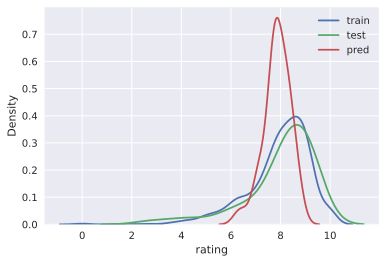

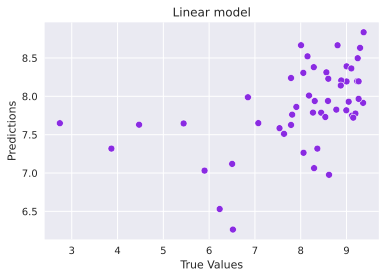

In [92]:
target_distr_linear(y_train, y_test, y_pred)

IMP: [4.07910732 2.41636511 5.60592291 0.00918607 0.         0.8114414
 0.         0.36684218 0.76170652 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.40982824 0.        ]


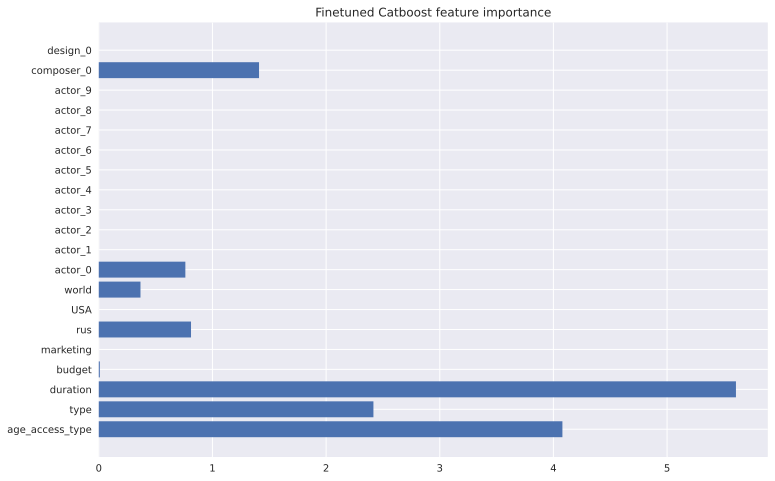

In [93]:
get_feature_imp(best_cat, train_dataset)

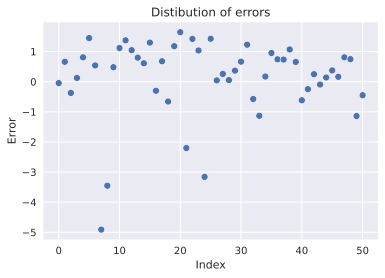

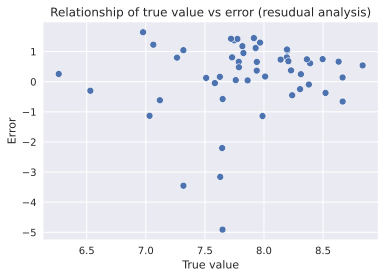

In [94]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [95]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.6198207937344045
RMSE:  1.2727218053189804
R2:    0.21052628803715312
MAE:   0.9109643502738852
MedAE: 0.6786787416106126
------------------------------


In [96]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                                               name  \
10378               16                                         Тихие воды   
7938                16                      Русские грузины. Фильм второй   
10377               16              Я знаю твои секреты 7. Дыхание смерти   
7698                12                                      Тайна амулета   
10370               18                                          Два холма   
10369               18                                            Оффлайн   
10368               16                              И снова здравствуйте!   
5410                16                                         Другое имя   
4462                16                                         Селфимания   
10391                0                               Мой мир. Поем вместе   
10390               18                                             Смычок   
7909                 0                        Три кота и море приключений   
8189                12  Все в сад! Или русская классика в цветах. Сезон 2   
10475               18  Что делать женщине, если у неё два любовника, ...   
10399               18                                               Жиза   
7644                 6                                       Забытое чудо   
5474                18                                             Модель   
10440               18                                   Закрыть гештальт   
10389               16                            Кабинет Путешественника   
5542                16                                        Многоэтажка   
7505                18                                               Ника   
5556                16                                         Бодибилдер   
6304                 6                           Кощей. Похититель невест   
5208                12                          1941. Крылья над Берлином   
6183                16                                     Доктор Свисток   
6354                16                                    Молодой человек   
6404                16                                           Свингеры   
6435                18                                          Приплыли!   
6012                 6                                   Мой папа – вождь   
5925                16                                              Дикая   
10246               12                            Предпоследняя инстанция   
6673                16                                        Страна Саша   
6697                16                        Эластико: Двенадцатый игрок   
6771                18                                              Рэпер   
10281                0                                         Спорт Тоша   
10286               18                                          Номинация   
10306               16                                              Агеев   
5681                16                             День слепого Валентина   
7499                12                                      Мистер Нокаут   
5566                16                                         Хочу замуж   
6267                16                                        Убить босса   
10341               16                                          Пианистка   
7515                12                                       Первый Оскар   
10349               16                                     Танцы на углях   
10350               16                                             Янычар   
10352               16                            Исправление и наказание   
10354               16                          Орлинская. Стрелы Нептуна   
7549                16                                         Бультерьер   
7565                 6                                             Финник   
5551                16                                             Стикер   
10486                6                                       Большие игры   

  